In [134]:
from random import random

import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from transformers import GPT2Config, GPT2LMHeadModel
import matplotlib.pyplot as plt
from functions import *
from CONSTANTS import *
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [137]:
class LLM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.1):
        super(LLM, self).__init__()

        # Store dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Attention tracking
        self.attention_scores_dict = {}
        self.last_attention_scores = []

        # Embedding layer maps input features to hidden dimension
        self.embedding = nn.Linear(input_size, hidden_size)
        
        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size) for _ in range(num_layers)
        ])

        # Layer normalization for stability
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden_size) for _ in range(num_layers)
        ])

        # Self-attention mechanisms - now properly sized
        self.attention_weights = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size) for _ in range(num_layers)
        ])

        # Output layer
        self.output = nn.Linear(hidden_size, 1)

        # Activation
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        
        # Initialize weights properly
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using He/Kaiming initialization for ReLU activations"""
        # Initialize embedding layer
        nn.init.kaiming_uniform_(self.embedding.weight, nonlinearity='relu')
        nn.init.zeros_(self.embedding.bias)
        
        # Initialize hidden layers
        for layer in self.hidden_layers:
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            nn.init.zeros_(layer.bias)
        
        # Initialize attention weights
        for attn in self.attention_weights:
            nn.init.kaiming_uniform_(attn.weight, nonlinearity='relu')
            nn.init.zeros_(attn.bias)
        
        # Initialize output layer 
        nn.init.kaiming_uniform_(self.output.weight, nonlinearity='relu')
        nn.init.zeros_(self.output.bias)

    def forward(self, x):
        batch_size = x.shape[0]
        
        # Reset attention dictionary at the start of each forward pass
        self.attention_scores_dict = {i: {} for i in range(batch_size)}
        self.last_attention_scores = []
        
        # Initial embedding
        x = self.embedding(x)
        x = self.activation(x)
        x = self.dropout(x)

        # Process through hidden layers with attention
        for layer_idx, (layer, layer_norm, attention) in enumerate(zip(
            self.hidden_layers, self.layer_norms, self.attention_weights)):
            
            # Apply the hidden layer transformation first
            hidden = layer(x)
            
            # Calculate self-attention weights
            scores = attention(hidden)  # shape: [batch_size, hidden_size]
            scores = torch.softmax(scores, dim=1)  # shape: [batch_size, hidden_size]
            
            # Store attention scores for visualization/analysis
            self.last_attention_scores.append(scores)
            for i in range(batch_size):
                self.attention_scores_dict[i][f"layer_{layer_idx+1}"] = scores[i].detach()

            # Apply attention weights to the hidden state
            weighted_hidden = hidden * scores
            
            # Apply normalization, activation and dropout
            x = layer_norm(weighted_hidden)
            x = self.activation(x)
            x = self.dropout(x)

        # Final output
        output = self.output(x)

        return output

    def get_full_attention_dict(self, dataset_size):
        """Get a complete attention dictionary for all samples in dataset"""
        full_dict = {}
        for i in range(dataset_size):
            if i < len(self.attention_scores_dict):
                full_dict[i] = self.attention_scores_dict[i]
            else:
                # Fill missing entries with empty dictionaries
                full_dict[i] = {}
        return full_dict

    def reset_attention_tracking(self):
        """Reset attention tracking between runs"""
        self.attention_scores_dict = {}
        self.last_attention_scores = []

# Sample

input shape: torch.Size([10, 5])
target shape: torch.Size([10, 1])


Text(0, 0.5, 'MSE')

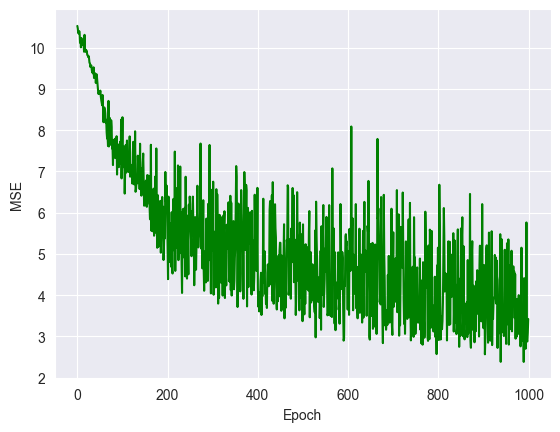

In [138]:
# Initialize the model
input_size = 5  # Number of previous numbers in the sequence
hidden_size = 128
num_layers = 2
model = LLM(input_size, hidden_size, num_layers)
lossFunction = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
data = [
    ([1, 2, 3, 4, 5], 6),
    ([2, 3, 4, 5, 6], 7),
    ([3, 4, 5, 6, 7], 8),
    ([4, 5, 6, 7, 8], 9),
    ([5, 6, 7, 8, 9], 10),
    ([6, 7, 8, 9, 10], 11),
    ([7, 8, 9, 10, 11], 12),
    ([8, 9, 10, 11, 12], 13),
    ([9, 10, 11, 12, 13], 14),
    ([10, 11, 12, 13, 14], 15)
]

# Convert data to tensors
inputs = torch.tensor([item[0] for item in data], dtype=torch.float32)
targets = torch.tensor([item[1] for item in data], dtype=torch.float32).unsqueeze(1)
print('input shape:', inputs.shape)
print('target shape:', targets.shape)

# Training loop
epochs = 1000
losses = []
for epoch in range(epochs):
    # Forward pass
    predictions = model(inputs)
    loss = lossFunction(predictions, targets) ** 0.5

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss = loss.item()
    losses.append(loss)
    if loss < 1e-2:
        print(f'Early Stopping at Epoch {epoch+1}')
        break

# Test the model
# test_data = range(11, 16, 1)
# test_input = torch.tensor([list(test_data)], dtype=torch.float32)
# predicted_output = model(test_input).item()
# print(f"Predicted next number: {predicted_output:.2f}")
pd.Series(losses).plot(color='green')
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [139]:
def average(attention_scores, index):
    tensor_list = list(attention_scores.get(index, {}).values())
    if tensor_list is None or tensor_list == []:
        return torch.tensor([])
    stacked = torch.stack(tensor_list)
    average = torch.mean(stacked, dim=0)
    return average

model.get_full_attention_dict(len(data)-10)

{}

# Try the NN for the full data

Preprocess bitcoin data

In [140]:
data = setup('BTC')[0]
data.set_index('time', inplace=True, drop=True)
data

low      high      open     close        volume   change  \
time                                                                        
2024-05-08  60851.04  63013.05  62315.75  61169.53   7486.425968 -1146.22   
2024-05-09  60601.60  63424.14  61169.53  63073.57   8360.055382  1904.04   
2024-05-10  60150.00  63470.00  63073.55  60787.47  11511.129910 -2286.08   
2024-05-11  60450.13  61482.00  60787.99  60814.63   2338.068108    26.64   
2024-05-12  60576.05  61843.45  60814.64  61453.02   2694.975779   638.38   
...              ...       ...       ...       ...           ...      ...   
2025-05-03  95765.13  96974.78  96929.81  95861.33   2077.556760 -1068.48   
2025-05-04  94151.67  96312.51  95865.47  94272.55   2834.396865 -1592.92   
2025-05-05  93500.01  95218.82  94272.54  94733.99   5180.158939   461.45   
2025-05-06  93363.28  96916.25  94733.99  96839.17   6163.867558  2105.18   
2025-05-07  96207.28  97738.05  96843.84  97061.99   4431.918646   218.15   

            pct_change      SMA_20      SMA_50        EMA_20  ...  \
time                                                          ...   
2024-05-08   -1.839374  65890.2210  66417.9682  64677.302333  ...   
2024-05-09    3.112726  66247.8435  66426.8854  65046.541526  ...   
2024-05-10   -3.624467  66472.6375  66371.6810  65254.222740  ...   
2024-05-11    0.043824  66850.1930  66373.6450  65724.407239  ...   
2024-05-12    1.049714  67183.0820  66410.7176  66241.225895  ...   
...                ...         ...         ...           ...  ...   
2025-05-03   -1.102323  72647.6545  69787.8322  76875.959487  ...   
2025-05-04   -1.661620  71251.6105  69155.3058  74877.499433  ...   
2025-05-05    0.489485  69965.3730  68533.2834  72835.915163  ...   
2025-05-06    2.222201  68693.1570  67843.8636  70530.854654  ...   
2025-05-07    0.225260  67274.8845  67142.8744  67761.558302  ...   

            Unnamed: 0.1  Unnamed: 0  title  date  link  text  sentiment  \
time                                                                       
2024-05-08           0.0         0.0      -   NaN     -     -          -   
2024-05-09           0.0         0.0      -   NaN     -     -          -   
2024-05-10           0.0         0.0      -   NaN     -     -          -   
2024-05-11           0.0         0.0      -   NaN     -     -          -   
2024-05-12           0.0         0.0      -   NaN     -     -          -   
...                  ...         ...    ...   ...   ...   ...        ...   
2025-05-03           0.0         0.0      -   NaN     -     -          -   
2025-05-04           0.0         0.0      -   NaN     -     -          -   
2025-05-05           0.0         0.0      -   NaN     -     -          -   
2025-05-06           0.0         0.0      -   NaN     -     -          -   
2025-05-07           0.0         0.0      -   NaN     -     -          -   

            score  gradient  TextType  
time                                   
2024-05-08    0.0      0.00     tweet  
2024-05-09    0.0   1904.04     tweet  
2024-05-10    0.0  -2286.10     tweet  
2024-05-11    0.0     27.16     tweet  
2024-05-12    0.0    638.39     tweet  
...           ...       ...       ...  
2025-05-03    0.0  -1068.48     tweet  
2025-05-04    0.0  -1588.78     tweet  
2025-05-05    0.0    461.44     tweet  
2025-05-06    0.0   2105.18     tweet  
2025-05-07    0.0    222.82     tweet  

[437 rows x 37 columns]

In [141]:
sequences = []
for i in range(len(data)-1):
    # create a sequence of all the previous values followed by the next one
    # to be separated into different columns at the bottom
    sequences.append(sequence(data['gradient'], i))

last = data['gradient'].values.tolist() # address the last value
item = (last, 0)
sequences.append(item)

# add it to the data and separate
# padding required to make it go through
data['list'] = [i[0] for i in sequences]
data['list'] = data['list'].apply(lambda a: padding(a, len(data)))
data['next'] = [i[1] for i in sequences]
data[['gradient', 'list', 'next']]

gradient                                               list  \
time                                                                      
2024-05-08      0.00  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2024-05-09   1904.04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2024-05-10  -2286.10  [0.0, 1904.0400000000009, 0.0, 0.0, 0.0, 0.0, ...   
2024-05-11     27.16  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-12    638.39  [0.0, 1904.0400000000009, -2286.0999999999985,...   
...              ...                                                ...   
2025-05-03  -1068.48  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2025-05-04  -1588.78  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2025-05-05    461.44  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2025-05-06   2105.18  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2025-05-07    222.82  [0.0, 1904.0400000000009, -2286.0999999999985,...   

               next  
time                 
2024-05-08  1904.04  
2024-05-09 -2286.10  
2024-05-10    27.16  
2024-05-11   638.39  
2024-05-12  1479.35  
...             ...  
2025-05-03 -1588.78  
2025-05-04   461.44  
2025-05-05  2105.18  
2025-05-06   222.82  
2025-05-07     0.00  

[437 rows x 3 columns]

### Fit the model on the list and next

Preprocessing & Train Test Split

In [145]:
TRAIN_PCT = 0.8
train = data[:int(len(data) * TRAIN_PCT)]
test = data[int(len(data) * TRAIN_PCT):]
X = train[['list']]
y = train['next']

X_train_full = X.copy()
y_train_full = y.copy()
X_test_full = test[['list']]
y_test_full = test['next']

tscv = TimeSeriesSplit(n_splits=5)
splits = tscv.split(X)
X_trains = []
y_trains = []
X_tests = []
y_tests = []
for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)

Fit the model

In [151]:
import copy
from tqdm import tqdm

def fit_llm(X_train, y_train, X_test, y_test, hidden_size=64, num_layers=2, 
           epochs=100, lr=1e-2, early_stopping_patience=15, dropout_rate=0.1):
    # Get actual input size from your data
    input_size = len(X_train['list'].iloc[0])
    print(f"Input size: {input_size}")

    # Initialize model with correct input size and dropout
    model = LLM(input_size, hidden_size, num_layers, dropout_rate)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # Added weight decay
    
    # Learning rate scheduler with reduced patience for faster adaptation
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10, verbose=True
    )

    # Convert to tensors
    inputs = torch.tensor(X_train['list'].tolist(), dtype=torch.float32)
    targets = torch.tensor(y_train.tolist(), dtype=torch.float32).unsqueeze(1)
    
    # Prepare validation data
    val_inputs = torch.tensor(X_test['list'].tolist(), dtype=torch.float32)
    val_targets = torch.tensor(y_test.tolist(), dtype=torch.float32).unsqueeze(1)

    # Training loop
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None
    
    for i in tqdm(range(epochs)):
        # Training step
        model.train()
        optimizer.zero_grad()
        
        predictions = model(inputs)
        train_loss = torch.sqrt(loss_function(predictions, targets))  # RMSE

        # Backward pass and optimization
        train_loss.backward()
        
        # Gradient clipping with higher threshold
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        train_losses.append(train_loss.item())
        
        # Validation step
        model.eval()
        with torch.no_grad():
            val_predictions = model(val_inputs)
            val_loss = torch.sqrt(loss_function(val_predictions, val_targets))
            val_losses.append(val_loss.item())
            
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            best_model = copy.deepcopy(model)
        else:
            patience_counter += 1
            
        
    
    # Use the best model for final evaluation
    if best_model is not None:
        model = best_model
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Final evaluation
    model.eval()
    with torch.no_grad():
        test_predictions = model(val_inputs)
        test_loss = torch.sqrt(loss_function(test_predictions, val_targets))
    
    print(f"Final validation RMSE: {test_loss.item():.4f}")

    return model, train_losses, val_losses, test_loss.item(), test_predictions.detach().numpy()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Input size: 437


  5%|▍         | 48/1000 [00:00<00:02, 473.96it/s]

Epoch 0: Train RMSE: 1467.7017, Val RMSE: 1829.0157
Epoch 10: Train RMSE: 1466.5778, Val RMSE: 1829.2107
Epoch 20: Train RMSE: 1466.0608, Val RMSE: 1829.6423
Epoch 30: Train RMSE: 1467.0776, Val RMSE: 1830.0004
Epoch 40: Train RMSE: 1466.0729, Val RMSE: 1830.2476
Epoch 50: Train RMSE: 1467.1212, Val RMSE: 1830.3339
Epoch 60: Train RMSE: 1464.6044, Val RMSE: 1830.3617
Epoch 70: Train RMSE: 1464.9865, Val RMSE: 1830.3807
Epoch 80: Train RMSE: 1466.2078, Val RMSE: 1830.3928
Epoch 90: Train RMSE: 1464.0861, Val RMSE: 1830.3999


 21%|██▏       | 213/1000 [00:00<00:01, 555.85it/s]

Epoch 100: Train RMSE: 1465.3557, Val RMSE: 1830.4049
Epoch 110: Train RMSE: 1465.7101, Val RMSE: 1830.4073
Epoch 120: Train RMSE: 1467.3779, Val RMSE: 1830.4083
Epoch 130: Train RMSE: 1466.8396, Val RMSE: 1830.4086
Epoch 140: Train RMSE: 1467.8130, Val RMSE: 1830.4091
Epoch 150: Train RMSE: 1464.6990, Val RMSE: 1830.4091
Epoch 160: Train RMSE: 1461.2924, Val RMSE: 1830.4092
Epoch 170: Train RMSE: 1466.5029, Val RMSE: 1830.4093
Epoch 180: Train RMSE: 1465.3346, Val RMSE: 1830.4093
Epoch 190: Train RMSE: 1465.1517, Val RMSE: 1830.4093
Epoch 200: Train RMSE: 1466.4209, Val RMSE: 1830.4093
Epoch 210: Train RMSE: 1465.0725, Val RMSE: 1830.4093


 34%|███▍      | 340/1000 [00:00<00:01, 598.77it/s]

Epoch 220: Train RMSE: 1466.2416, Val RMSE: 1830.4093
Epoch 230: Train RMSE: 1466.6733, Val RMSE: 1830.4093
Epoch 240: Train RMSE: 1465.9471, Val RMSE: 1830.4093
Epoch 250: Train RMSE: 1467.7174, Val RMSE: 1830.4093
Epoch 260: Train RMSE: 1467.5909, Val RMSE: 1830.4093
Epoch 270: Train RMSE: 1464.3784, Val RMSE: 1830.4093
Epoch 280: Train RMSE: 1465.8608, Val RMSE: 1830.4093
Epoch 290: Train RMSE: 1469.2778, Val RMSE: 1830.4093
Epoch 300: Train RMSE: 1466.8552, Val RMSE: 1830.4093
Epoch 310: Train RMSE: 1466.5236, Val RMSE: 1830.4093
Epoch 320: Train RMSE: 1465.2090, Val RMSE: 1830.4093
Epoch 330: Train RMSE: 1466.2467, Val RMSE: 1830.4093
Epoch 340: Train RMSE: 1465.7770, Val RMSE: 1830.4093


 46%|████▋     | 463/1000 [00:00<00:00, 598.48it/s]

Epoch 350: Train RMSE: 1465.7605, Val RMSE: 1830.4093
Epoch 360: Train RMSE: 1465.5273, Val RMSE: 1830.4093
Epoch 370: Train RMSE: 1467.0378, Val RMSE: 1830.4093
Epoch 380: Train RMSE: 1466.2775, Val RMSE: 1830.4093
Epoch 390: Train RMSE: 1465.1212, Val RMSE: 1830.4093
Epoch 400: Train RMSE: 1466.3982, Val RMSE: 1830.4093
Epoch 410: Train RMSE: 1465.7302, Val RMSE: 1830.4093
Epoch 420: Train RMSE: 1466.4668, Val RMSE: 1830.4093
Epoch 430: Train RMSE: 1466.2042, Val RMSE: 1830.4093
Epoch 440: Train RMSE: 1468.2832, Val RMSE: 1830.4093
Epoch 450: Train RMSE: 1468.3232, Val RMSE: 1830.4093
Epoch 460: Train RMSE: 1465.7877, Val RMSE: 1830.4093
Epoch 470: Train RMSE: 1467.9451, Val RMSE: 1830.4093


 60%|█████▉    | 599/1000 [00:01<00:00, 640.83it/s]

Epoch 480: Train RMSE: 1465.5100, Val RMSE: 1830.4093
Epoch 490: Train RMSE: 1468.2122, Val RMSE: 1830.4093
Epoch 500: Train RMSE: 1465.1854, Val RMSE: 1830.4093
Epoch 510: Train RMSE: 1465.7595, Val RMSE: 1830.4093
Epoch 520: Train RMSE: 1467.2048, Val RMSE: 1830.4093
Epoch 530: Train RMSE: 1465.6063, Val RMSE: 1830.4093
Epoch 540: Train RMSE: 1465.8324, Val RMSE: 1830.4093
Epoch 550: Train RMSE: 1465.4486, Val RMSE: 1830.4093
Epoch 560: Train RMSE: 1466.9071, Val RMSE: 1830.4093
Epoch 570: Train RMSE: 1465.4808, Val RMSE: 1830.4093
Epoch 580: Train RMSE: 1466.2947, Val RMSE: 1830.4093
Epoch 590: Train RMSE: 1466.1311, Val RMSE: 1830.4093
Epoch 600: Train RMSE: 1466.5232, Val RMSE: 1830.4093
Epoch 610: Train RMSE: 1463.6000, Val RMSE: 1830.4093


 73%|███████▎  | 733/1000 [00:01<00:00, 644.38it/s]

Epoch 620: Train RMSE: 1466.1797, Val RMSE: 1830.4093
Epoch 630: Train RMSE: 1467.2740, Val RMSE: 1830.4093
Epoch 640: Train RMSE: 1466.4071, Val RMSE: 1830.4093
Epoch 650: Train RMSE: 1466.7408, Val RMSE: 1830.4093
Epoch 660: Train RMSE: 1467.2986, Val RMSE: 1830.4093
Epoch 670: Train RMSE: 1466.1344, Val RMSE: 1830.4093
Epoch 680: Train RMSE: 1466.6121, Val RMSE: 1830.4093
Epoch 690: Train RMSE: 1464.7155, Val RMSE: 1830.4093
Epoch 700: Train RMSE: 1465.7424, Val RMSE: 1830.4093
Epoch 710: Train RMSE: 1466.7690, Val RMSE: 1830.4093
Epoch 720: Train RMSE: 1466.4369, Val RMSE: 1830.4093
Epoch 730: Train RMSE: 1464.1412, Val RMSE: 1830.4093
Epoch 740: Train RMSE: 1464.4899, Val RMSE: 1830.4093


 86%|████████▌ | 860/1000 [00:01<00:00, 604.62it/s]

Epoch 750: Train RMSE: 1464.2626, Val RMSE: 1830.4093
Epoch 760: Train RMSE: 1466.5741, Val RMSE: 1830.4093
Epoch 770: Train RMSE: 1466.5491, Val RMSE: 1830.4093
Epoch 780: Train RMSE: 1465.5803, Val RMSE: 1830.4093
Epoch 790: Train RMSE: 1466.8418, Val RMSE: 1830.4093
Epoch 800: Train RMSE: 1464.5325, Val RMSE: 1830.4093
Epoch 810: Train RMSE: 1466.9520, Val RMSE: 1830.4093
Epoch 820: Train RMSE: 1465.2750, Val RMSE: 1830.4093
Epoch 830: Train RMSE: 1467.5474, Val RMSE: 1830.4093
Epoch 840: Train RMSE: 1468.0176, Val RMSE: 1830.4093
Epoch 850: Train RMSE: 1466.6940, Val RMSE: 1830.4093
Epoch 860: Train RMSE: 1466.6165, Val RMSE: 1830.4093


 99%|█████████▉| 991/1000 [00:01<00:00, 615.77it/s]

Epoch 870: Train RMSE: 1465.5526, Val RMSE: 1830.4093
Epoch 880: Train RMSE: 1467.5402, Val RMSE: 1830.4093
Epoch 890: Train RMSE: 1465.5215, Val RMSE: 1830.4093
Epoch 900: Train RMSE: 1465.0492, Val RMSE: 1830.4093
Epoch 910: Train RMSE: 1465.6619, Val RMSE: 1830.4093
Epoch 920: Train RMSE: 1467.0950, Val RMSE: 1830.4093
Epoch 930: Train RMSE: 1464.9514, Val RMSE: 1830.4093
Epoch 940: Train RMSE: 1466.5947, Val RMSE: 1830.4093
Epoch 950: Train RMSE: 1465.9131, Val RMSE: 1830.4093
Epoch 960: Train RMSE: 1466.8394, Val RMSE: 1830.4093
Epoch 970: Train RMSE: 1467.2523, Val RMSE: 1830.4093
Epoch 980: Train RMSE: 1466.6716, Val RMSE: 1830.4093
Epoch 990: Train RMSE: 1467.4442, Val RMSE: 1830.4093


100%|██████████| 1000/1000 [00:01<00:00, 595.09it/s]


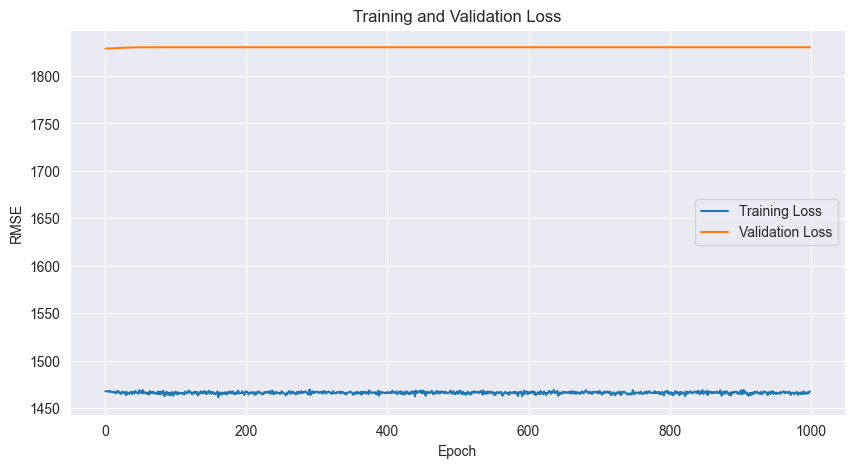

Final validation RMSE: 1829.0157


In [152]:
idx = 0
theModel, train_losses, val_losses, test_loss, test_predictions = fit_llm(X_trains[idx], y_trains[idx], X_tests[idx], y_tests[idx], hidden_size=64, num_layers=2, epochs=1000, lr=1e-1)

In [153]:
train_losses

[1467.70166015625,
 1467.5439453125,
 1467.4490966796875,
 1467.5697021484375,
 1467.7176513671875,
 1467.076904296875,
 1467.8348388671875,
 1467.2427978515625,
 1466.9141845703125,
 1467.0484619140625,
 1466.5777587890625,
 1467.0091552734375,
 1467.06396484375,
 1465.8729248046875,
 1466.249267578125,
 1465.5933837890625,
 1466.541748046875,
 1467.9251708984375,
 1467.736328125,
 1466.1556396484375,
 1466.060791015625,
 1466.2164306640625,
 1464.7083740234375,
 1466.2413330078125,
 1467.157470703125,
 1466.203369140625,
 1465.77685546875,
 1466.5137939453125,
 1465.589599609375,
 1463.7362060546875,
 1467.07763671875,
 1464.33251953125,
 1465.511474609375,
 1465.85400390625,
 1464.8641357421875,
 1466.406005859375,
 1465.8369140625,
 1467.0037841796875,
 1464.8275146484375,
 1466.5413818359375,
 1466.0728759765625,
 1465.1455078125,
 1467.7596435546875,
 1467.66943359375,
 1466.6484375,
 1465.914306640625,
 1465.5726318359375,
 1464.987548828125,
 1468.7174072265625,
 1466.903930664

In [154]:
averages = []
theData = X_trains[idx]
for i in range(len(theData)):
    avg = average(theModel.attention_scores_dict, i)
    averages.append(avg)
theData['attentions'] = averages

/var/folders/mh/b5m2p8fd04x2knz5_hwd1rqw0000gn/T/ipykernel_33496/3970097156.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theData['attentions'] = averages


In [155]:
theData[['list', 'attentions']]

list  \
time                                                            
2024-05-08  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2024-05-09  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2024-05-10  [0.0, 1904.0400000000009, 0.0, 0.0, 0.0, 0.0, ...   
2024-05-11  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-12  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-13  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-14  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-15  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-16  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-17  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-18  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-19  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-20  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-21  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-22  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-23  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-24  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-25  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-26  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-27  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-28  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-29  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-30  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-31  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-01  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-02  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-03  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-04  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-05  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-06  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-07  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-08  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-09  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-10  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-11  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-12  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-13  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-14  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-15  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-16  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-17  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-17  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-18  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-19  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-20  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-21  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-22  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-23  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-24  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-25  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-26  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-27  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-28  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-29  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-06-30  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-07-01  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-07-02  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-07-03  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-07-04  [0.0, 1904.0400000000009, -2286.0999999999985,...   

                                                   attentions  
time                       

## Cross Validation for My LLM

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 1 - Train size: 59, Test size: 58
Input size: 437


  1%|▏         | 14/1000 [00:00<00:07, 129.82it/s]

Epoch 0: Train RMSE: 1467.7312, Val RMSE: 1828.9982
Epoch 10: Train RMSE: 1467.8779, Val RMSE: 1828.9968
Epoch 20: Train RMSE: 1467.8734, Val RMSE: 1828.9978


  6%|▌         | 55/1000 [00:00<00:07, 126.60it/s]

Epoch 30: Train RMSE: 1467.6583, Val RMSE: 1828.9990
Epoch 40: Train RMSE: 1467.7802, Val RMSE: 1829.0024
Epoch 50: Train RMSE: 1468.1144, Val RMSE: 1829.0033


  8%|▊         | 84/1000 [00:00<00:06, 135.65it/s]

Epoch 60: Train RMSE: 1467.8737, Val RMSE: 1829.0038
Epoch 70: Train RMSE: 1467.7217, Val RMSE: 1829.0037
Epoch 80: Train RMSE: 1467.7227, Val RMSE: 1829.0035


 11%|█▏        | 113/1000 [00:00<00:06, 136.33it/s]

Epoch 90: Train RMSE: 1467.9293, Val RMSE: 1829.0037
Epoch 100: Train RMSE: 1467.9113, Val RMSE: 1829.0034
Epoch 110: Train RMSE: 1467.6681, Val RMSE: 1829.0035


 14%|█▍        | 144/1000 [00:01<00:05, 144.39it/s]

Epoch 120: Train RMSE: 1467.5728, Val RMSE: 1829.0033
Epoch 130: Train RMSE: 1467.7933, Val RMSE: 1829.0035
Epoch 140: Train RMSE: 1467.5299, Val RMSE: 1829.0035
Epoch 150: Train RMSE: 1467.8759, Val RMSE: 1829.0033


 18%|█▊        | 179/1000 [00:01<00:05, 156.45it/s]

Epoch 160: Train RMSE: 1467.7472, Val RMSE: 1829.0033
Epoch 170: Train RMSE: 1467.6750, Val RMSE: 1829.0035
Epoch 180: Train RMSE: 1467.7094, Val RMSE: 1829.0034
Epoch 190: Train RMSE: 1467.8928, Val RMSE: 1829.0034


 23%|██▎       | 230/1000 [00:01<00:04, 163.15it/s]

Epoch 200: Train RMSE: 1467.9222, Val RMSE: 1829.0034
Epoch 210: Train RMSE: 1467.6251, Val RMSE: 1829.0034
Epoch 220: Train RMSE: 1467.5787, Val RMSE: 1829.0035
Epoch 230: Train RMSE: 1467.9565, Val RMSE: 1829.0034


 26%|██▋       | 265/1000 [00:01<00:04, 165.08it/s]

Epoch 240: Train RMSE: 1467.8820, Val RMSE: 1829.0034
Epoch 250: Train RMSE: 1467.8069, Val RMSE: 1829.0034
Epoch 260: Train RMSE: 1467.7932, Val RMSE: 1829.0034
Epoch 270: Train RMSE: 1467.8503, Val RMSE: 1829.0034


 30%|██▉       | 299/1000 [00:02<00:04, 157.82it/s]

Epoch 280: Train RMSE: 1467.8424, Val RMSE: 1829.0034
Epoch 290: Train RMSE: 1467.7273, Val RMSE: 1829.0034
Epoch 300: Train RMSE: 1467.6007, Val RMSE: 1829.0034
Epoch 310: Train RMSE: 1467.5425, Val RMSE: 1829.0034


 35%|███▌      | 352/1000 [00:02<00:03, 166.86it/s]

Epoch 320: Train RMSE: 1467.6929, Val RMSE: 1829.0034
Epoch 330: Train RMSE: 1467.7289, Val RMSE: 1829.0034
Epoch 340: Train RMSE: 1467.8273, Val RMSE: 1829.0034
Epoch 350: Train RMSE: 1467.8494, Val RMSE: 1829.0034


 39%|███▊      | 386/1000 [00:02<00:03, 160.70it/s]

Epoch 360: Train RMSE: 1467.9336, Val RMSE: 1829.0034
Epoch 370: Train RMSE: 1467.7515, Val RMSE: 1829.0034
Epoch 380: Train RMSE: 1467.8030, Val RMSE: 1829.0035
Epoch 390: Train RMSE: 1467.8351, Val RMSE: 1829.0035


 42%|████▏     | 421/1000 [00:02<00:03, 164.04it/s]

Epoch 400: Train RMSE: 1467.9238, Val RMSE: 1829.0035
Epoch 410: Train RMSE: 1467.6647, Val RMSE: 1829.0035
Epoch 420: Train RMSE: 1467.7467, Val RMSE: 1829.0035
Epoch 430: Train RMSE: 1467.9219, Val RMSE: 1829.0035


 46%|████▌     | 455/1000 [00:02<00:03, 152.95it/s]

Epoch 440: Train RMSE: 1467.8918, Val RMSE: 1829.0035
Epoch 450: Train RMSE: 1468.0122, Val RMSE: 1829.0035
Epoch 460: Train RMSE: 1467.6776, Val RMSE: 1829.0035


 49%|████▊     | 487/1000 [00:03<00:03, 149.73it/s]

Epoch 470: Train RMSE: 1467.6548, Val RMSE: 1829.0035
Epoch 480: Train RMSE: 1467.8340, Val RMSE: 1829.0035
Epoch 490: Train RMSE: 1467.7395, Val RMSE: 1829.0035
Epoch 500: Train RMSE: 1467.8124, Val RMSE: 1829.0035


 54%|█████▎    | 537/1000 [00:03<00:02, 157.24it/s]

Epoch 510: Train RMSE: 1467.9645, Val RMSE: 1829.0035
Epoch 520: Train RMSE: 1467.6029, Val RMSE: 1829.0035
Epoch 530: Train RMSE: 1467.6875, Val RMSE: 1829.0035
Epoch 540: Train RMSE: 1467.8887, Val RMSE: 1829.0035


 57%|█████▋    | 570/1000 [00:03<00:02, 153.11it/s]

Epoch 550: Train RMSE: 1467.8276, Val RMSE: 1829.0035
Epoch 560: Train RMSE: 1467.6655, Val RMSE: 1829.0035
Epoch 570: Train RMSE: 1467.8191, Val RMSE: 1829.0035
Epoch 580: Train RMSE: 1467.4895, Val RMSE: 1829.0035


 62%|██████▏   | 621/1000 [00:04<00:02, 159.63it/s]

Epoch 590: Train RMSE: 1467.7594, Val RMSE: 1829.0035
Epoch 600: Train RMSE: 1467.7076, Val RMSE: 1829.0035
Epoch 610: Train RMSE: 1467.4878, Val RMSE: 1829.0035
Epoch 620: Train RMSE: 1467.5828, Val RMSE: 1829.0035


 65%|██████▌   | 654/1000 [00:04<00:02, 156.11it/s]

Epoch 630: Train RMSE: 1467.4633, Val RMSE: 1829.0035
Epoch 640: Train RMSE: 1467.8083, Val RMSE: 1829.0035
Epoch 650: Train RMSE: 1467.9105, Val RMSE: 1829.0035
Epoch 660: Train RMSE: 1467.8203, Val RMSE: 1829.0034


 69%|██████▊   | 686/1000 [00:04<00:02, 156.96it/s]

Epoch 670: Train RMSE: 1467.7252, Val RMSE: 1829.0035
Epoch 680: Train RMSE: 1467.7163, Val RMSE: 1829.0035
Epoch 690: Train RMSE: 1467.8126, Val RMSE: 1829.0035
Epoch 700: Train RMSE: 1467.9762, Val RMSE: 1829.0035


 74%|███████▎  | 735/1000 [00:04<00:01, 157.30it/s]

Epoch 710: Train RMSE: 1467.7600, Val RMSE: 1829.0035
Epoch 720: Train RMSE: 1467.8313, Val RMSE: 1829.0035
Epoch 730: Train RMSE: 1467.6996, Val RMSE: 1829.0035
Epoch 740: Train RMSE: 1467.9475, Val RMSE: 1829.0035


 77%|███████▋  | 768/1000 [00:04<00:01, 157.26it/s]

Epoch 750: Train RMSE: 1467.8235, Val RMSE: 1829.0035
Epoch 760: Train RMSE: 1467.8181, Val RMSE: 1829.0035
Epoch 770: Train RMSE: 1467.9023, Val RMSE: 1829.0035
Epoch 780: Train RMSE: 1467.6047, Val RMSE: 1829.0035


 82%|████████▏ | 815/1000 [00:05<00:01, 142.16it/s]

Epoch 790: Train RMSE: 1467.8156, Val RMSE: 1829.0035
Epoch 800: Train RMSE: 1467.7550, Val RMSE: 1829.0035
Epoch 810: Train RMSE: 1467.8507, Val RMSE: 1829.0035


 85%|████████▍ | 846/1000 [00:05<00:01, 143.69it/s]

Epoch 820: Train RMSE: 1467.8590, Val RMSE: 1829.0035
Epoch 830: Train RMSE: 1467.8793, Val RMSE: 1829.0035
Epoch 840: Train RMSE: 1467.6571, Val RMSE: 1829.0035


 88%|████████▊ | 876/1000 [00:05<00:00, 142.32it/s]

Epoch 850: Train RMSE: 1467.8171, Val RMSE: 1829.0035
Epoch 860: Train RMSE: 1467.4276, Val RMSE: 1829.0035
Epoch 870: Train RMSE: 1467.7737, Val RMSE: 1829.0035


 91%|█████████ | 906/1000 [00:05<00:00, 145.54it/s]

Epoch 880: Train RMSE: 1467.7246, Val RMSE: 1829.0035
Epoch 890: Train RMSE: 1467.8636, Val RMSE: 1829.0035
Epoch 900: Train RMSE: 1467.9064, Val RMSE: 1829.0035


 94%|█████████▎| 936/1000 [00:06<00:00, 144.97it/s]

Epoch 910: Train RMSE: 1467.9429, Val RMSE: 1829.0035
Epoch 920: Train RMSE: 1467.7870, Val RMSE: 1829.0035
Epoch 930: Train RMSE: 1467.6364, Val RMSE: 1829.0035


 97%|█████████▋| 966/1000 [00:06<00:00, 138.58it/s]

Epoch 940: Train RMSE: 1467.7476, Val RMSE: 1829.0035
Epoch 950: Train RMSE: 1467.6464, Val RMSE: 1829.0035
Epoch 960: Train RMSE: 1467.6591, Val RMSE: 1829.0035


100%|██████████| 1000/1000 [00:06<00:00, 150.80it/s]

Epoch 970: Train RMSE: 1468.0195, Val RMSE: 1829.0035
Epoch 980: Train RMSE: 1468.0215, Val RMSE: 1829.0035
Epoch 990: Train RMSE: 1467.6792, Val RMSE: 1829.0035


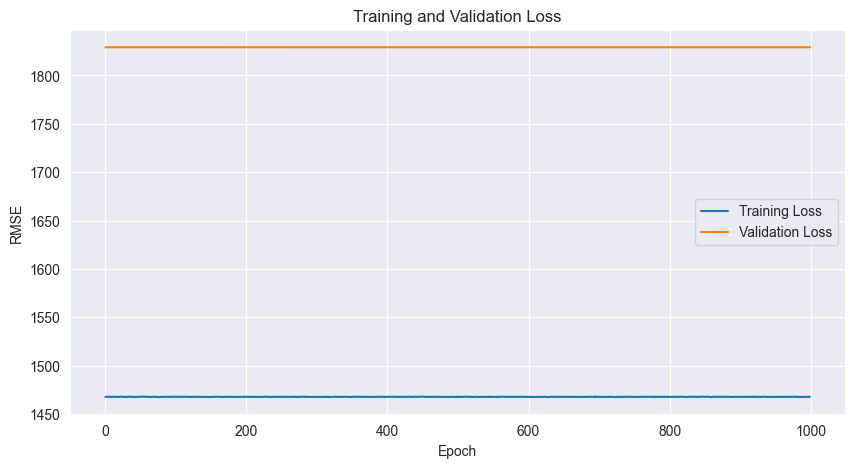

/var/folders/mh/b5m2p8fd04x2knz5_hwd1rqw0000gn/T/ipykernel_33496/690836615.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['attentions'] = averages


Final validation RMSE: 1828.9344
Fold 2 - Train size: 117, Test size: 58
Input size: 437


  1%|          | 12/1000 [00:00<00:08, 116.44it/s]

Epoch 0: Train RMSE: 1656.6569, Val RMSE: 1316.0204
Epoch 10: Train RMSE: 1656.6819, Val RMSE: 1316.2185
Epoch 20: Train RMSE: 1656.4524, Val RMSE: 1316.1268


  6%|▌         | 55/1000 [00:00<00:07, 133.77it/s]

Epoch 30: Train RMSE: 1656.7004, Val RMSE: 1316.0758
Epoch 40: Train RMSE: 1656.8120, Val RMSE: 1316.2797
Epoch 50: Train RMSE: 1656.6708, Val RMSE: 1316.2798
Epoch 60: Train RMSE: 1656.6713, Val RMSE: 1316.2789


  8%|▊         | 84/1000 [00:00<00:06, 135.11it/s]

Epoch 70: Train RMSE: 1656.7982, Val RMSE: 1316.2802
Epoch 80: Train RMSE: 1656.8506, Val RMSE: 1316.2805
Epoch 90: Train RMSE: 1656.6787, Val RMSE: 1316.2811


 13%|█▎        | 126/1000 [00:00<00:06, 135.49it/s]

Epoch 100: Train RMSE: 1656.7623, Val RMSE: 1316.2812
Epoch 110: Train RMSE: 1656.8506, Val RMSE: 1316.2812
Epoch 120: Train RMSE: 1656.6589, Val RMSE: 1316.2814


 16%|█▌        | 155/1000 [00:01<00:06, 136.75it/s]

Epoch 130: Train RMSE: 1656.6067, Val RMSE: 1316.2814
Epoch 140: Train RMSE: 1656.8907, Val RMSE: 1316.2814
Epoch 150: Train RMSE: 1656.8506, Val RMSE: 1316.2814


 18%|█▊        | 184/1000 [00:01<00:06, 134.64it/s]

Epoch 160: Train RMSE: 1656.7778, Val RMSE: 1316.2814
Epoch 170: Train RMSE: 1656.6367, Val RMSE: 1316.2814
Epoch 180: Train RMSE: 1656.6755, Val RMSE: 1316.2814


 21%|██▏       | 214/1000 [00:01<00:05, 138.67it/s]

Epoch 190: Train RMSE: 1656.7395, Val RMSE: 1316.2814
Epoch 200: Train RMSE: 1656.6403, Val RMSE: 1316.2814
Epoch 210: Train RMSE: 1656.7162, Val RMSE: 1316.2814


 24%|██▍       | 242/1000 [00:01<00:05, 133.10it/s]

Epoch 220: Train RMSE: 1656.5359, Val RMSE: 1316.2814
Epoch 230: Train RMSE: 1656.6630, Val RMSE: 1316.2814
Epoch 240: Train RMSE: 1656.4779, Val RMSE: 1316.2814


 27%|██▋       | 270/1000 [00:02<00:05, 133.62it/s]

Epoch 250: Train RMSE: 1656.6224, Val RMSE: 1316.2814
Epoch 260: Train RMSE: 1656.7653, Val RMSE: 1316.2814
Epoch 270: Train RMSE: 1656.6040, Val RMSE: 1316.2814


 30%|███       | 300/1000 [00:02<00:04, 140.43it/s]

Epoch 280: Train RMSE: 1656.6340, Val RMSE: 1316.2814
Epoch 290: Train RMSE: 1656.7312, Val RMSE: 1316.2814
Epoch 300: Train RMSE: 1656.7130, Val RMSE: 1316.2814


 33%|███▎      | 329/1000 [00:02<00:04, 136.47it/s]

Epoch 310: Train RMSE: 1656.5221, Val RMSE: 1316.2814
Epoch 320: Train RMSE: 1656.5643, Val RMSE: 1316.2814
Epoch 330: Train RMSE: 1656.6864, Val RMSE: 1316.2814


 36%|███▌      | 360/1000 [00:02<00:04, 140.72it/s]

Epoch 340: Train RMSE: 1656.6453, Val RMSE: 1316.2814
Epoch 350: Train RMSE: 1656.9707, Val RMSE: 1316.2814
Epoch 360: Train RMSE: 1656.7307, Val RMSE: 1316.2814


 39%|███▉      | 389/1000 [00:02<00:04, 133.99it/s]

Epoch 370: Train RMSE: 1656.6039, Val RMSE: 1316.2814
Epoch 380: Train RMSE: 1656.5530, Val RMSE: 1316.2814
Epoch 390: Train RMSE: 1656.8604, Val RMSE: 1316.2814


 42%|████▏     | 418/1000 [00:03<00:04, 137.94it/s]

Epoch 400: Train RMSE: 1656.6333, Val RMSE: 1316.2814
Epoch 410: Train RMSE: 1656.7107, Val RMSE: 1316.2814
Epoch 420: Train RMSE: 1656.8558, Val RMSE: 1316.2814


 45%|████▍     | 449/1000 [00:03<00:03, 140.72it/s]

Epoch 430: Train RMSE: 1656.6609, Val RMSE: 1316.2814
Epoch 440: Train RMSE: 1656.7007, Val RMSE: 1316.2814
Epoch 450: Train RMSE: 1656.6075, Val RMSE: 1316.2814


 48%|████▊     | 478/1000 [00:03<00:03, 137.91it/s]

Epoch 460: Train RMSE: 1656.6449, Val RMSE: 1316.2814
Epoch 470: Train RMSE: 1656.6012, Val RMSE: 1316.2814
Epoch 480: Train RMSE: 1656.6550, Val RMSE: 1316.2814


 51%|█████     | 507/1000 [00:03<00:03, 138.29it/s]

Epoch 490: Train RMSE: 1656.6272, Val RMSE: 1316.2814
Epoch 500: Train RMSE: 1656.6333, Val RMSE: 1316.2814
Epoch 510: Train RMSE: 1656.3987, Val RMSE: 1316.2814


 54%|█████▍    | 538/1000 [00:03<00:03, 134.20it/s]

Epoch 520: Train RMSE: 1656.6359, Val RMSE: 1316.2814
Epoch 530: Train RMSE: 1656.6582, Val RMSE: 1316.2814
Epoch 540: Train RMSE: 1656.7867, Val RMSE: 1316.2814


 57%|█████▋    | 569/1000 [00:04<00:03, 137.58it/s]

Epoch 550: Train RMSE: 1656.6304, Val RMSE: 1316.2814
Epoch 560: Train RMSE: 1656.6128, Val RMSE: 1316.2814
Epoch 570: Train RMSE: 1656.5822, Val RMSE: 1316.2814


 60%|█████▉    | 598/1000 [00:04<00:02, 137.79it/s]

Epoch 580: Train RMSE: 1656.4618, Val RMSE: 1316.2814
Epoch 590: Train RMSE: 1656.5631, Val RMSE: 1316.2814
Epoch 600: Train RMSE: 1656.6899, Val RMSE: 1316.2814


 63%|██████▎   | 626/1000 [00:04<00:02, 133.28it/s]

Epoch 610: Train RMSE: 1656.7261, Val RMSE: 1316.2814
Epoch 620: Train RMSE: 1656.5940, Val RMSE: 1316.2814
Epoch 630: Train RMSE: 1656.5850, Val RMSE: 1316.2814


 65%|██████▌   | 654/1000 [00:04<00:02, 132.50it/s]

Epoch 640: Train RMSE: 1656.6019, Val RMSE: 1316.2814
Epoch 650: Train RMSE: 1656.7472, Val RMSE: 1316.2814
Epoch 660: Train RMSE: 1656.7065, Val RMSE: 1316.2814


 70%|██████▉   | 697/1000 [00:05<00:02, 121.56it/s]

Epoch 670: Train RMSE: 1656.6974, Val RMSE: 1316.2814
Epoch 680: Train RMSE: 1656.6509, Val RMSE: 1316.2814
Epoch 690: Train RMSE: 1656.5251, Val RMSE: 1316.2814


 72%|███████▎  | 725/1000 [00:05<00:02, 130.72it/s]

Epoch 700: Train RMSE: 1656.6625, Val RMSE: 1316.2814
Epoch 710: Train RMSE: 1656.6235, Val RMSE: 1316.2814
Epoch 720: Train RMSE: 1656.5743, Val RMSE: 1316.2814


 75%|███████▌  | 754/1000 [00:05<00:01, 136.05it/s]

Epoch 730: Train RMSE: 1656.8728, Val RMSE: 1316.2814
Epoch 740: Train RMSE: 1656.7753, Val RMSE: 1316.2814
Epoch 750: Train RMSE: 1656.8810, Val RMSE: 1316.2814


 78%|███████▊  | 783/1000 [00:05<00:01, 135.49it/s]

Epoch 760: Train RMSE: 1656.7009, Val RMSE: 1316.2814
Epoch 770: Train RMSE: 1656.5944, Val RMSE: 1316.2814
Epoch 780: Train RMSE: 1656.6521, Val RMSE: 1316.2814


 81%|████████▏ | 813/1000 [00:06<00:01, 140.91it/s]

Epoch 790: Train RMSE: 1656.9673, Val RMSE: 1316.2814
Epoch 800: Train RMSE: 1656.7751, Val RMSE: 1316.2814
Epoch 810: Train RMSE: 1656.7115, Val RMSE: 1316.2814


 84%|████████▍ | 842/1000 [00:06<00:01, 132.26it/s]

Epoch 820: Train RMSE: 1656.8203, Val RMSE: 1316.2814
Epoch 830: Train RMSE: 1656.6294, Val RMSE: 1316.2814
Epoch 840: Train RMSE: 1656.9684, Val RMSE: 1316.2814


 87%|████████▋ | 871/1000 [00:06<00:00, 134.71it/s]

Epoch 850: Train RMSE: 1656.8953, Val RMSE: 1316.2814
Epoch 860: Train RMSE: 1656.5712, Val RMSE: 1316.2814
Epoch 870: Train RMSE: 1656.7640, Val RMSE: 1316.2814


 90%|████████▉ | 899/1000 [00:06<00:00, 134.78it/s]

Epoch 880: Train RMSE: 1656.5391, Val RMSE: 1316.2814
Epoch 890: Train RMSE: 1656.6385, Val RMSE: 1316.2814
Epoch 900: Train RMSE: 1656.5992, Val RMSE: 1316.2814


 93%|█████████▎| 927/1000 [00:06<00:00, 132.49it/s]

Epoch 910: Train RMSE: 1656.7278, Val RMSE: 1316.2814
Epoch 920: Train RMSE: 1656.5890, Val RMSE: 1316.2814
Epoch 930: Train RMSE: 1656.6801, Val RMSE: 1316.2814


 96%|█████████▌| 958/1000 [00:07<00:00, 140.22it/s]

Epoch 940: Train RMSE: 1656.7545, Val RMSE: 1316.2814
Epoch 950: Train RMSE: 1656.7206, Val RMSE: 1316.2814
Epoch 960: Train RMSE: 1656.6703, Val RMSE: 1316.2814


 99%|█████████▉| 988/1000 [00:07<00:00, 139.50it/s]

Epoch 970: Train RMSE: 1656.6401, Val RMSE: 1316.2814
Epoch 980: Train RMSE: 1656.6157, Val RMSE: 1316.2814
Epoch 990: Train RMSE: 1656.6503, Val RMSE: 1316.2814


100%|██████████| 1000/1000 [00:07<00:00, 134.43it/s]


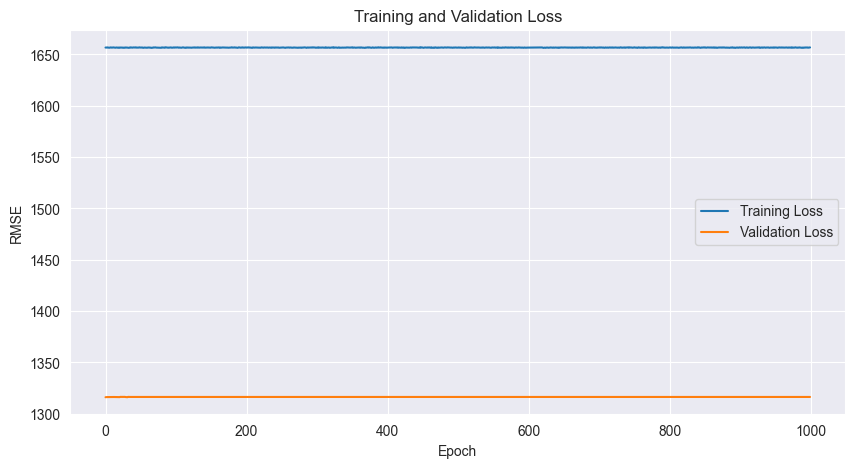

/var/folders/mh/b5m2p8fd04x2knz5_hwd1rqw0000gn/T/ipykernel_33496/690836615.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['attentions'] = averages
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Final validation RMSE: 1316.0204
Fold 3 - Train size: 175, Test size: 58
Input size: 437


  1%|          | 7/1000 [00:00<00:14, 68.41it/s]

Epoch 0: Train RMSE: 1551.9485, Val RMSE: 2262.2168
Epoch 10: Train RMSE: 1551.9535, Val RMSE: 2262.2173


  4%|▎         | 35/1000 [00:00<00:11, 87.37it/s]

Epoch 20: Train RMSE: 1551.8896, Val RMSE: 2262.0564
Epoch 30: Train RMSE: 1551.9127, Val RMSE: 2262.0955
Epoch 40: Train RMSE: 1551.9427, Val RMSE: 2262.2776


  7%|▋         | 74/1000 [00:00<00:08, 113.67it/s]

Epoch 50: Train RMSE: 1551.8737, Val RMSE: 2262.0127
Epoch 60: Train RMSE: 1551.9973, Val RMSE: 2262.0676
Epoch 70: Train RMSE: 1551.8823, Val RMSE: 2262.1033


  9%|▊         | 87/1000 [00:00<00:07, 115.75it/s]

Epoch 80: Train RMSE: 1551.8701, Val RMSE: 2262.0244
Epoch 90: Train RMSE: 1551.8696, Val RMSE: 2261.9688


 11%|█         | 110/1000 [00:01<00:09, 95.16it/s]

Epoch 100: Train RMSE: 1551.8567, Val RMSE: 2261.9460
Epoch 110: Train RMSE: 1551.9663, Val RMSE: 2261.9446
Epoch 120: Train RMSE: 1551.9503, Val RMSE: 2261.9487


 15%|█▍        | 149/1000 [00:01<00:07, 110.70it/s]

Epoch 130: Train RMSE: 1551.9095, Val RMSE: 2261.9463
Epoch 140: Train RMSE: 1551.9714, Val RMSE: 2261.9451
Epoch 150: Train RMSE: 1551.9055, Val RMSE: 2261.9446


 17%|█▋        | 173/1000 [00:01<00:07, 112.08it/s]

Epoch 160: Train RMSE: 1551.9369, Val RMSE: 2261.9448
Epoch 170: Train RMSE: 1551.9830, Val RMSE: 2261.9448
Epoch 180: Train RMSE: 1551.8922, Val RMSE: 2261.9448


 21%|██▏       | 213/1000 [00:01<00:06, 121.99it/s]

Epoch 190: Train RMSE: 1551.9376, Val RMSE: 2261.9448
Epoch 200: Train RMSE: 1551.9532, Val RMSE: 2261.9448
Epoch 210: Train RMSE: 1551.9966, Val RMSE: 2261.9448


 24%|██▍       | 239/1000 [00:02<00:06, 116.13it/s]

Epoch 220: Train RMSE: 1551.8613, Val RMSE: 2261.9448
Epoch 230: Train RMSE: 1551.9106, Val RMSE: 2261.9448
Epoch 240: Train RMSE: 1552.0519, Val RMSE: 2261.9448


 26%|██▋       | 263/1000 [00:02<00:06, 114.38it/s]

Epoch 250: Train RMSE: 1551.9644, Val RMSE: 2261.9448
Epoch 260: Train RMSE: 1551.9694, Val RMSE: 2261.9448
Epoch 270: Train RMSE: 1551.9734, Val RMSE: 2261.9448


 30%|███       | 301/1000 [00:02<00:06, 111.77it/s]

Epoch 280: Train RMSE: 1551.9291, Val RMSE: 2261.9448
Epoch 290: Train RMSE: 1551.9120, Val RMSE: 2261.9448
Epoch 300: Train RMSE: 1551.8358, Val RMSE: 2261.9448


 33%|███▎      | 326/1000 [00:02<00:05, 115.01it/s]

Epoch 310: Train RMSE: 1551.9716, Val RMSE: 2261.9448
Epoch 320: Train RMSE: 1551.9717, Val RMSE: 2261.9448
Epoch 330: Train RMSE: 1552.0597, Val RMSE: 2261.9448


 35%|███▌      | 353/1000 [00:03<00:05, 120.22it/s]

Epoch 340: Train RMSE: 1551.9951, Val RMSE: 2261.9448
Epoch 350: Train RMSE: 1551.9938, Val RMSE: 2261.9448
Epoch 360: Train RMSE: 1551.9677, Val RMSE: 2261.9448


 38%|███▊      | 379/1000 [00:03<00:06, 94.96it/s] 

Epoch 370: Train RMSE: 1551.9872, Val RMSE: 2261.9448
Epoch 380: Train RMSE: 1551.9221, Val RMSE: 2261.9448


 40%|████      | 404/1000 [00:03<00:05, 106.82it/s]

Epoch 390: Train RMSE: 1551.9172, Val RMSE: 2261.9448
Epoch 400: Train RMSE: 1552.0059, Val RMSE: 2261.9448
Epoch 410: Train RMSE: 1551.9324, Val RMSE: 2261.9448


 44%|████▍     | 442/1000 [00:04<00:04, 114.13it/s]

Epoch 420: Train RMSE: 1552.0322, Val RMSE: 2261.9448
Epoch 430: Train RMSE: 1552.0098, Val RMSE: 2261.9448
Epoch 440: Train RMSE: 1551.8209, Val RMSE: 2261.9448


 47%|████▋     | 466/1000 [00:04<00:04, 116.72it/s]

Epoch 450: Train RMSE: 1551.9214, Val RMSE: 2261.9448
Epoch 460: Train RMSE: 1552.0139, Val RMSE: 2261.9448
Epoch 470: Train RMSE: 1551.8645, Val RMSE: 2261.9448


 50%|█████     | 502/1000 [00:04<00:04, 115.35it/s]

Epoch 480: Train RMSE: 1552.1320, Val RMSE: 2261.9448
Epoch 490: Train RMSE: 1551.9564, Val RMSE: 2261.9451
Epoch 500: Train RMSE: 1551.9185, Val RMSE: 2261.9451


 53%|█████▎    | 526/1000 [00:04<00:04, 113.99it/s]

Epoch 510: Train RMSE: 1551.9176, Val RMSE: 2261.9448
Epoch 520: Train RMSE: 1551.9628, Val RMSE: 2261.9448
Epoch 530: Train RMSE: 1551.9446, Val RMSE: 2261.9448


 56%|█████▌    | 560/1000 [00:05<00:04, 105.39it/s]

Epoch 540: Train RMSE: 1551.9327, Val RMSE: 2261.9448
Epoch 550: Train RMSE: 1551.9539, Val RMSE: 2261.9451
Epoch 560: Train RMSE: 1551.8986, Val RMSE: 2261.9448


 58%|█████▊    | 582/1000 [00:05<00:04, 103.49it/s]

Epoch 570: Train RMSE: 1551.8374, Val RMSE: 2261.9448
Epoch 580: Train RMSE: 1551.9500, Val RMSE: 2261.9448
Epoch 590: Train RMSE: 1551.8826, Val RMSE: 2261.9448


 62%|██████▏   | 615/1000 [00:05<00:03, 100.33it/s]

Epoch 600: Train RMSE: 1551.8568, Val RMSE: 2261.9448
Epoch 610: Train RMSE: 1551.9971, Val RMSE: 2261.9448
Epoch 620: Train RMSE: 1551.9630, Val RMSE: 2261.9448


 65%|██████▌   | 651/1000 [00:05<00:03, 111.71it/s]

Epoch 630: Train RMSE: 1551.8787, Val RMSE: 2261.9448
Epoch 640: Train RMSE: 1551.9912, Val RMSE: 2261.9448
Epoch 650: Train RMSE: 1551.8689, Val RMSE: 2261.9448


 68%|██████▊   | 676/1000 [00:06<00:02, 113.28it/s]

Epoch 660: Train RMSE: 1551.8911, Val RMSE: 2261.9448
Epoch 670: Train RMSE: 1552.0837, Val RMSE: 2261.9448
Epoch 680: Train RMSE: 1551.8497, Val RMSE: 2261.9446


 71%|███████▏  | 713/1000 [00:06<00:02, 117.50it/s]

Epoch 690: Train RMSE: 1551.8726, Val RMSE: 2261.9446
Epoch 700: Train RMSE: 1551.9734, Val RMSE: 2261.9446
Epoch 710: Train RMSE: 1552.0038, Val RMSE: 2261.9446


 74%|███████▍  | 738/1000 [00:06<00:02, 118.11it/s]

Epoch 720: Train RMSE: 1551.9539, Val RMSE: 2261.9446
Epoch 730: Train RMSE: 1551.9187, Val RMSE: 2261.9443
Epoch 740: Train RMSE: 1552.1385, Val RMSE: 2261.9446


 78%|███████▊  | 775/1000 [00:07<00:01, 117.82it/s]

Epoch 750: Train RMSE: 1552.0009, Val RMSE: 2261.9443
Epoch 760: Train RMSE: 1551.9481, Val RMSE: 2261.9446
Epoch 770: Train RMSE: 1551.9357, Val RMSE: 2261.9443


 80%|███████▉  | 799/1000 [00:07<00:01, 117.04it/s]

Epoch 780: Train RMSE: 1552.0338, Val RMSE: 2261.9446
Epoch 790: Train RMSE: 1551.9266, Val RMSE: 2261.9446
Epoch 800: Train RMSE: 1551.9237, Val RMSE: 2261.9446


 82%|████████▏ | 823/1000 [00:07<00:01, 106.42it/s]

Epoch 810: Train RMSE: 1551.9122, Val RMSE: 2261.9446
Epoch 820: Train RMSE: 1551.9608, Val RMSE: 2261.9446


 84%|████████▍ | 845/1000 [00:07<00:01, 106.38it/s]

Epoch 830: Train RMSE: 1551.7777, Val RMSE: 2261.9446
Epoch 840: Train RMSE: 1551.8817, Val RMSE: 2261.9446
Epoch 850: Train RMSE: 1552.0112, Val RMSE: 2261.9446


 87%|████████▋ | 871/1000 [00:07<00:01, 113.70it/s]

Epoch 860: Train RMSE: 1551.8016, Val RMSE: 2261.9446
Epoch 870: Train RMSE: 1551.9633, Val RMSE: 2261.9446
Epoch 880: Train RMSE: 1551.8169, Val RMSE: 2261.9446


 91%|█████████ | 909/1000 [00:08<00:00, 116.39it/s]

Epoch 890: Train RMSE: 1551.8074, Val RMSE: 2261.9446
Epoch 900: Train RMSE: 1551.8312, Val RMSE: 2261.9446
Epoch 910: Train RMSE: 1551.9022, Val RMSE: 2261.9446


 93%|█████████▎| 934/1000 [00:08<00:00, 117.53it/s]

Epoch 920: Train RMSE: 1551.7538, Val RMSE: 2261.9446
Epoch 930: Train RMSE: 1551.9535, Val RMSE: 2261.9446
Epoch 940: Train RMSE: 1551.9142, Val RMSE: 2261.9446


 97%|█████████▋| 971/1000 [00:08<00:00, 118.33it/s]

Epoch 950: Train RMSE: 1551.8887, Val RMSE: 2261.9446
Epoch 960: Train RMSE: 1551.9923, Val RMSE: 2261.9446
Epoch 970: Train RMSE: 1552.0345, Val RMSE: 2261.9446


100%|██████████| 1000/1000 [00:08<00:00, 111.19it/s]

Epoch 980: Train RMSE: 1551.8907, Val RMSE: 2261.9446
Epoch 990: Train RMSE: 1551.9214, Val RMSE: 2261.9446


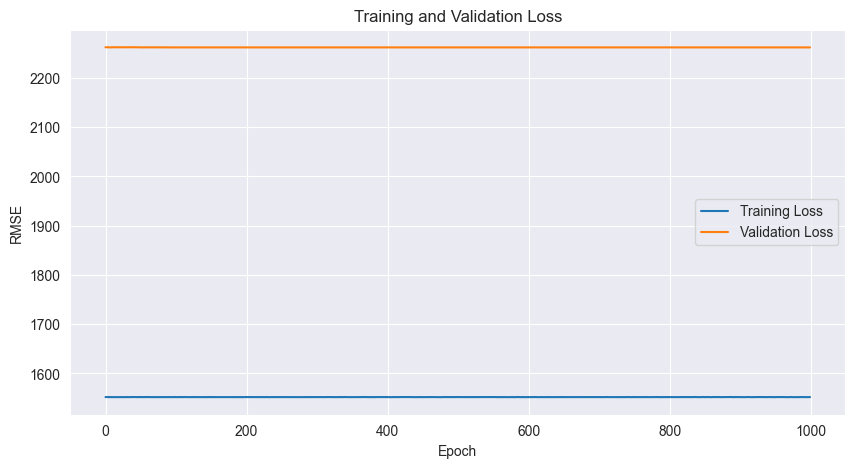

/var/folders/mh/b5m2p8fd04x2knz5_hwd1rqw0000gn/T/ipykernel_33496/690836615.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['attentions'] = averages
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Final validation RMSE: 2261.9417
Fold 4 - Train size: 233, Test size: 58
Input size: 437


  1%|          | 9/1000 [00:00<00:12, 82.28it/s]

Epoch 0: Train RMSE: 1756.0015, Val RMSE: 2261.7859
Epoch 10: Train RMSE: 1755.9159, Val RMSE: 2261.8025


  4%|▍         | 39/1000 [00:00<00:09, 97.17it/s]

Epoch 20: Train RMSE: 1755.7754, Val RMSE: 2261.8450
Epoch 30: Train RMSE: 1755.8013, Val RMSE: 2261.8430
Epoch 40: Train RMSE: 1755.6974, Val RMSE: 2261.7983


  7%|▋         | 69/1000 [00:00<00:09, 96.49it/s]

Epoch 50: Train RMSE: 1755.8585, Val RMSE: 2261.7737
Epoch 60: Train RMSE: 1755.8236, Val RMSE: 2261.8813
Epoch 70: Train RMSE: 1755.7302, Val RMSE: 2261.8813


  9%|▉         | 91/1000 [00:00<00:08, 102.35it/s]

Epoch 80: Train RMSE: 1755.7167, Val RMSE: 2261.8809
Epoch 90: Train RMSE: 1755.7965, Val RMSE: 2261.8811
Epoch 100: Train RMSE: 1755.8395, Val RMSE: 2261.8811


 12%|█▏        | 124/1000 [00:01<00:08, 103.18it/s]

Epoch 110: Train RMSE: 1755.8146, Val RMSE: 2261.8813
Epoch 120: Train RMSE: 1755.7551, Val RMSE: 2261.8811
Epoch 130: Train RMSE: 1755.6989, Val RMSE: 2261.8813


 16%|█▌        | 157/1000 [00:01<00:09, 90.80it/s] 

Epoch 140: Train RMSE: 1755.7805, Val RMSE: 2261.8811
Epoch 150: Train RMSE: 1755.7380, Val RMSE: 2261.8813


 18%|█▊        | 179/1000 [00:01<00:08, 97.86it/s]

Epoch 160: Train RMSE: 1755.8372, Val RMSE: 2261.8813
Epoch 170: Train RMSE: 1755.8733, Val RMSE: 2261.8813
Epoch 180: Train RMSE: 1755.7939, Val RMSE: 2261.8813


 20%|██        | 201/1000 [00:02<00:07, 101.94it/s]

Epoch 190: Train RMSE: 1755.8240, Val RMSE: 2261.8813
Epoch 200: Train RMSE: 1755.7308, Val RMSE: 2261.8813


 22%|██▏       | 223/1000 [00:02<00:07, 99.29it/s] 

Epoch 210: Train RMSE: 1755.7631, Val RMSE: 2261.8813
Epoch 220: Train RMSE: 1755.5741, Val RMSE: 2261.8813
Epoch 230: Train RMSE: 1755.8413, Val RMSE: 2261.8813


 26%|██▌       | 257/1000 [00:02<00:07, 104.85it/s]

Epoch 240: Train RMSE: 1755.8169, Val RMSE: 2261.8813
Epoch 250: Train RMSE: 1755.7721, Val RMSE: 2261.8813
Epoch 260: Train RMSE: 1755.7919, Val RMSE: 2261.8813


 29%|██▉       | 290/1000 [00:02<00:06, 103.87it/s]

Epoch 270: Train RMSE: 1755.8895, Val RMSE: 2261.8813
Epoch 280: Train RMSE: 1755.7710, Val RMSE: 2261.8813
Epoch 290: Train RMSE: 1755.7161, Val RMSE: 2261.8813


 31%|███       | 312/1000 [00:03<00:06, 104.96it/s]

Epoch 300: Train RMSE: 1755.7749, Val RMSE: 2261.8813
Epoch 310: Train RMSE: 1755.7555, Val RMSE: 2261.8813
Epoch 320: Train RMSE: 1755.8074, Val RMSE: 2261.8813


 35%|███▍      | 346/1000 [00:03<00:06, 103.64it/s]

Epoch 330: Train RMSE: 1755.7246, Val RMSE: 2261.8813
Epoch 340: Train RMSE: 1755.8060, Val RMSE: 2261.8813
Epoch 350: Train RMSE: 1755.8485, Val RMSE: 2261.8813


 38%|███▊      | 379/1000 [00:03<00:05, 105.73it/s]

Epoch 360: Train RMSE: 1755.8190, Val RMSE: 2261.8813
Epoch 370: Train RMSE: 1755.7832, Val RMSE: 2261.8813
Epoch 380: Train RMSE: 1755.7461, Val RMSE: 2261.8813


 41%|████▏     | 413/1000 [00:04<00:05, 106.89it/s]

Epoch 390: Train RMSE: 1755.8103, Val RMSE: 2261.8813
Epoch 400: Train RMSE: 1755.7538, Val RMSE: 2261.8813
Epoch 410: Train RMSE: 1755.7673, Val RMSE: 2261.8813


 44%|████▎     | 435/1000 [00:04<00:05, 102.83it/s]

Epoch 420: Train RMSE: 1755.6636, Val RMSE: 2261.8813
Epoch 430: Train RMSE: 1755.8367, Val RMSE: 2261.8813


 46%|████▌     | 457/1000 [00:04<00:05, 102.82it/s]

Epoch 440: Train RMSE: 1755.7247, Val RMSE: 2261.8813
Epoch 450: Train RMSE: 1755.7593, Val RMSE: 2261.8813
Epoch 460: Train RMSE: 1755.7982, Val RMSE: 2261.8813


 49%|████▉     | 491/1000 [00:04<00:04, 104.36it/s]

Epoch 470: Train RMSE: 1755.7628, Val RMSE: 2261.8813
Epoch 480: Train RMSE: 1755.7646, Val RMSE: 2261.8813
Epoch 490: Train RMSE: 1755.6691, Val RMSE: 2261.8813


 50%|█████     | 502/1000 [00:04<00:04, 101.63it/s]

Epoch 500: Train RMSE: 1755.7222, Val RMSE: 2261.8813
Epoch 510: Train RMSE: 1755.8531, Val RMSE: 2261.8813


 54%|█████▎    | 535/1000 [00:05<00:04, 93.58it/s] 

Epoch 520: Train RMSE: 1755.7214, Val RMSE: 2261.8813
Epoch 530: Train RMSE: 1755.7528, Val RMSE: 2261.8813
Epoch 540: Train RMSE: 1755.7509, Val RMSE: 2261.8813


 57%|█████▋    | 568/1000 [00:05<00:04, 101.56it/s]

Epoch 550: Train RMSE: 1755.8813, Val RMSE: 2261.8813
Epoch 560: Train RMSE: 1755.7107, Val RMSE: 2261.8813
Epoch 570: Train RMSE: 1755.6871, Val RMSE: 2261.8813


 59%|█████▉    | 591/1000 [00:05<00:03, 103.71it/s]

Epoch 580: Train RMSE: 1755.6710, Val RMSE: 2261.8811
Epoch 590: Train RMSE: 1755.7910, Val RMSE: 2261.8811


 61%|██████▏   | 613/1000 [00:06<00:03, 103.05it/s]

Epoch 600: Train RMSE: 1755.7202, Val RMSE: 2261.8811
Epoch 610: Train RMSE: 1755.7314, Val RMSE: 2261.8811
Epoch 620: Train RMSE: 1755.6580, Val RMSE: 2261.8811


 65%|██████▍   | 647/1000 [00:06<00:03, 107.52it/s]

Epoch 630: Train RMSE: 1755.6519, Val RMSE: 2261.8811
Epoch 640: Train RMSE: 1755.8015, Val RMSE: 2261.8813
Epoch 650: Train RMSE: 1755.8328, Val RMSE: 2261.8813


 68%|██████▊   | 680/1000 [00:06<00:03, 102.57it/s]

Epoch 660: Train RMSE: 1755.5612, Val RMSE: 2261.8813
Epoch 670: Train RMSE: 1755.6879, Val RMSE: 2261.8813
Epoch 680: Train RMSE: 1755.7098, Val RMSE: 2261.8813


 70%|███████   | 702/1000 [00:07<00:02, 104.49it/s]

Epoch 690: Train RMSE: 1755.8696, Val RMSE: 2261.8813
Epoch 700: Train RMSE: 1755.7263, Val RMSE: 2261.8813
Epoch 710: Train RMSE: 1755.7336, Val RMSE: 2261.8813


 74%|███████▎  | 735/1000 [00:07<00:02, 101.59it/s]

Epoch 720: Train RMSE: 1755.7810, Val RMSE: 2261.8813
Epoch 730: Train RMSE: 1755.8193, Val RMSE: 2261.8813


 76%|███████▌  | 757/1000 [00:07<00:02, 101.78it/s]

Epoch 740: Train RMSE: 1755.7555, Val RMSE: 2261.8813
Epoch 750: Train RMSE: 1755.8077, Val RMSE: 2261.8813
Epoch 760: Train RMSE: 1755.7955, Val RMSE: 2261.8813


 79%|███████▉  | 790/1000 [00:07<00:02, 102.12it/s]

Epoch 770: Train RMSE: 1755.7617, Val RMSE: 2261.8813
Epoch 780: Train RMSE: 1755.6942, Val RMSE: 2261.8813
Epoch 790: Train RMSE: 1755.9321, Val RMSE: 2261.8813


 81%|████████  | 812/1000 [00:08<00:01, 102.01it/s]

Epoch 800: Train RMSE: 1755.7961, Val RMSE: 2261.8813
Epoch 810: Train RMSE: 1755.6711, Val RMSE: 2261.8813
Epoch 820: Train RMSE: 1755.7233, Val RMSE: 2261.8813


 85%|████████▍ | 846/1000 [00:08<00:01, 99.13it/s] 

Epoch 830: Train RMSE: 1755.6626, Val RMSE: 2261.8813
Epoch 840: Train RMSE: 1755.8516, Val RMSE: 2261.8813


 87%|████████▋ | 868/1000 [00:08<00:01, 101.61it/s]

Epoch 850: Train RMSE: 1755.8115, Val RMSE: 2261.8813
Epoch 860: Train RMSE: 1755.7830, Val RMSE: 2261.8813
Epoch 870: Train RMSE: 1755.6592, Val RMSE: 2261.8813


 89%|████████▉ | 891/1000 [00:08<00:01, 83.50it/s] 

Epoch 880: Train RMSE: 1755.8315, Val RMSE: 2261.8813
Epoch 890: Train RMSE: 1755.7123, Val RMSE: 2261.8813


 91%|█████████ | 912/1000 [00:09<00:00, 91.71it/s]

Epoch 900: Train RMSE: 1755.9126, Val RMSE: 2261.8813
Epoch 910: Train RMSE: 1755.6882, Val RMSE: 2261.8813
Epoch 920: Train RMSE: 1755.7766, Val RMSE: 2261.8813


 95%|█████████▍| 947/1000 [00:09<00:00, 98.82it/s] 

Epoch 930: Train RMSE: 1755.7258, Val RMSE: 2261.8813
Epoch 940: Train RMSE: 1755.7411, Val RMSE: 2261.8813


 97%|█████████▋| 969/1000 [00:09<00:00, 100.50it/s]

Epoch 950: Train RMSE: 1755.7456, Val RMSE: 2261.8813
Epoch 960: Train RMSE: 1755.8251, Val RMSE: 2261.8813
Epoch 970: Train RMSE: 1755.6873, Val RMSE: 2261.8813


100%|██████████| 1000/1000 [00:09<00:00, 100.42it/s]

Epoch 980: Train RMSE: 1755.8175, Val RMSE: 2261.8813
Epoch 990: Train RMSE: 1755.7032, Val RMSE: 2261.8813


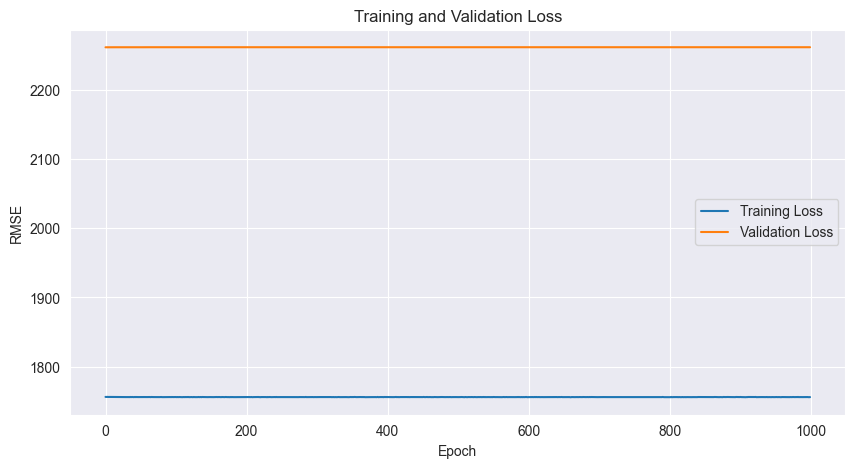

/var/folders/mh/b5m2p8fd04x2knz5_hwd1rqw0000gn/T/ipykernel_33496/690836615.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['attentions'] = averages
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Final validation RMSE: 2261.7664
Fold 5 - Train size: 291, Test size: 58
Input size: 437


  1%|          | 7/1000 [00:00<00:14, 69.42it/s]

Epoch 0: Train RMSE: 1867.6489, Val RMSE: 2493.2048
Epoch 10: Train RMSE: 1867.7538, Val RMSE: 2493.2148


  3%|▎         | 31/1000 [00:00<00:12, 75.89it/s]

Epoch 20: Train RMSE: 1867.6879, Val RMSE: 2493.2424
Epoch 30: Train RMSE: 1867.6279, Val RMSE: 2493.2129


  5%|▌         | 50/1000 [00:00<00:11, 83.57it/s]

Epoch 40: Train RMSE: 1867.6617, Val RMSE: 2493.2229
Epoch 50: Train RMSE: 1867.5530, Val RMSE: 2493.2444


  8%|▊         | 80/1000 [00:00<00:10, 91.91it/s]

Epoch 60: Train RMSE: 1867.5306, Val RMSE: 2493.2812
Epoch 70: Train RMSE: 1867.5343, Val RMSE: 2493.2986


  9%|▉         | 90/1000 [00:01<00:09, 92.78it/s]

Epoch 80: Train RMSE: 1867.6747, Val RMSE: 2493.3005
Epoch 90: Train RMSE: 1867.6053, Val RMSE: 2493.2993


 11%|█         | 110/1000 [00:01<00:10, 88.78it/s]

Epoch 100: Train RMSE: 1867.6102, Val RMSE: 2493.3000
Epoch 110: Train RMSE: 1867.6755, Val RMSE: 2493.2991


 13%|█▎        | 131/1000 [00:01<00:09, 93.33it/s]

Epoch 120: Train RMSE: 1867.6984, Val RMSE: 2493.2986
Epoch 130: Train RMSE: 1867.5729, Val RMSE: 2493.2981


 15%|█▌        | 150/1000 [00:01<00:10, 78.31it/s]

Epoch 140: Train RMSE: 1867.6168, Val RMSE: 2493.2976
Epoch 150: Train RMSE: 1867.4966, Val RMSE: 2493.2974


 17%|█▋        | 170/1000 [00:02<00:09, 85.78it/s]

Epoch 160: Train RMSE: 1867.6229, Val RMSE: 2493.2974
Epoch 170: Train RMSE: 1867.5974, Val RMSE: 2493.2974


 19%|█▉        | 191/1000 [00:02<00:08, 91.65it/s]

Epoch 180: Train RMSE: 1867.6359, Val RMSE: 2493.2974
Epoch 190: Train RMSE: 1867.6227, Val RMSE: 2493.2974


 21%|██        | 211/1000 [00:02<00:08, 90.18it/s]

Epoch 200: Train RMSE: 1867.6002, Val RMSE: 2493.2974
Epoch 210: Train RMSE: 1867.6405, Val RMSE: 2493.2974


 23%|██▎       | 231/1000 [00:02<00:08, 92.38it/s]

Epoch 220: Train RMSE: 1867.5472, Val RMSE: 2493.2974
Epoch 230: Train RMSE: 1867.6305, Val RMSE: 2493.2974


 25%|██▌       | 253/1000 [00:02<00:07, 97.35it/s]

Epoch 240: Train RMSE: 1867.6631, Val RMSE: 2493.2974
Epoch 250: Train RMSE: 1867.6284, Val RMSE: 2493.2974


 27%|██▋       | 274/1000 [00:03<00:07, 93.56it/s]

Epoch 260: Train RMSE: 1867.6691, Val RMSE: 2493.2974
Epoch 270: Train RMSE: 1867.6262, Val RMSE: 2493.2974


 29%|██▉       | 294/1000 [00:03<00:07, 92.08it/s]

Epoch 280: Train RMSE: 1867.5171, Val RMSE: 2493.2974
Epoch 290: Train RMSE: 1867.7174, Val RMSE: 2493.2974


 31%|███▏      | 314/1000 [00:03<00:07, 91.44it/s]

Epoch 300: Train RMSE: 1867.6779, Val RMSE: 2493.2974
Epoch 310: Train RMSE: 1867.6484, Val RMSE: 2493.2974


 33%|███▎      | 333/1000 [00:03<00:07, 88.18it/s]

Epoch 320: Train RMSE: 1867.4824, Val RMSE: 2493.2974
Epoch 330: Train RMSE: 1867.8433, Val RMSE: 2493.2974


 34%|███▍      | 343/1000 [00:03<00:09, 71.65it/s]

Epoch 340: Train RMSE: 1867.5377, Val RMSE: 2493.2974


 36%|███▌      | 361/1000 [00:04<00:08, 77.89it/s]

Epoch 350: Train RMSE: 1867.7115, Val RMSE: 2493.2974
Epoch 360: Train RMSE: 1867.6542, Val RMSE: 2493.2974


 38%|███▊      | 380/1000 [00:04<00:07, 85.01it/s]

Epoch 370: Train RMSE: 1867.5842, Val RMSE: 2493.2976
Epoch 380: Train RMSE: 1867.6477, Val RMSE: 2493.2976


 40%|████      | 400/1000 [00:04<00:06, 90.25it/s]

Epoch 390: Train RMSE: 1867.5691, Val RMSE: 2493.2976
Epoch 400: Train RMSE: 1867.5001, Val RMSE: 2493.2976


 42%|████▏     | 420/1000 [00:04<00:06, 89.37it/s]

Epoch 410: Train RMSE: 1867.7076, Val RMSE: 2493.2976
Epoch 420: Train RMSE: 1867.5859, Val RMSE: 2493.2976


 44%|████▍     | 440/1000 [00:05<00:06, 89.65it/s]

Epoch 430: Train RMSE: 1867.5848, Val RMSE: 2493.2976
Epoch 440: Train RMSE: 1867.6400, Val RMSE: 2493.2976


 46%|████▌     | 461/1000 [00:05<00:05, 93.71it/s]

Epoch 450: Train RMSE: 1867.6196, Val RMSE: 2493.2976
Epoch 460: Train RMSE: 1867.6460, Val RMSE: 2493.2974


 48%|████▊     | 481/1000 [00:05<00:05, 89.95it/s]

Epoch 470: Train RMSE: 1867.5516, Val RMSE: 2493.2974
Epoch 480: Train RMSE: 1867.7390, Val RMSE: 2493.2976


 50%|█████     | 501/1000 [00:05<00:05, 92.14it/s]

Epoch 490: Train RMSE: 1867.6138, Val RMSE: 2493.2976
Epoch 500: Train RMSE: 1867.5502, Val RMSE: 2493.2976


 52%|█████▏    | 521/1000 [00:05<00:05, 89.45it/s]

Epoch 510: Train RMSE: 1867.6049, Val RMSE: 2493.2976
Epoch 520: Train RMSE: 1867.6592, Val RMSE: 2493.2976


 54%|█████▍    | 539/1000 [00:06<00:05, 86.81it/s]

Epoch 530: Train RMSE: 1867.5790, Val RMSE: 2493.2976
Epoch 540: Train RMSE: 1867.5796, Val RMSE: 2493.2976


 56%|█████▋    | 564/1000 [00:06<00:07, 60.37it/s]

Epoch 550: Train RMSE: 1867.5681, Val RMSE: 2493.2976
Epoch 560: Train RMSE: 1867.6229, Val RMSE: 2493.2976


 58%|█████▊    | 581/1000 [00:06<00:06, 67.37it/s]

Epoch 570: Train RMSE: 1867.5704, Val RMSE: 2493.2976
Epoch 580: Train RMSE: 1867.5634, Val RMSE: 2493.2976


 60%|██████    | 605/1000 [00:07<00:05, 71.53it/s]

Epoch 590: Train RMSE: 1867.7388, Val RMSE: 2493.2976
Epoch 600: Train RMSE: 1867.5745, Val RMSE: 2493.2976


 62%|██████▏   | 624/1000 [00:07<00:04, 78.77it/s]

Epoch 610: Train RMSE: 1867.7859, Val RMSE: 2493.2976
Epoch 620: Train RMSE: 1867.6694, Val RMSE: 2493.2976


 64%|██████▍   | 643/1000 [00:07<00:04, 84.85it/s]

Epoch 630: Train RMSE: 1867.6519, Val RMSE: 2493.2974
Epoch 640: Train RMSE: 1867.6053, Val RMSE: 2493.2974


 66%|██████▌   | 661/1000 [00:07<00:04, 83.44it/s]

Epoch 650: Train RMSE: 1867.6433, Val RMSE: 2493.2976
Epoch 660: Train RMSE: 1867.6050, Val RMSE: 2493.2976


 69%|██████▉   | 689/1000 [00:08<00:03, 88.63it/s]

Epoch 670: Train RMSE: 1867.6077, Val RMSE: 2493.2976
Epoch 680: Train RMSE: 1867.6799, Val RMSE: 2493.2976


 71%|███████   | 707/1000 [00:08<00:03, 85.44it/s]

Epoch 690: Train RMSE: 1867.6531, Val RMSE: 2493.2976
Epoch 700: Train RMSE: 1867.5260, Val RMSE: 2493.2976


 72%|███████▎  | 725/1000 [00:08<00:03, 84.48it/s]

Epoch 710: Train RMSE: 1867.6843, Val RMSE: 2493.2974
Epoch 720: Train RMSE: 1867.6135, Val RMSE: 2493.2974


 74%|███████▍  | 744/1000 [00:08<00:02, 87.14it/s]

Epoch 730: Train RMSE: 1867.6118, Val RMSE: 2493.2976
Epoch 740: Train RMSE: 1867.5411, Val RMSE: 2493.2976


 75%|███████▌  | 753/1000 [00:08<00:02, 85.49it/s]

Epoch 750: Train RMSE: 1867.4521, Val RMSE: 2493.2976


 77%|███████▋  | 772/1000 [00:09<00:03, 73.69it/s]

Epoch 760: Train RMSE: 1867.6057, Val RMSE: 2493.2976
Epoch 770: Train RMSE: 1867.7437, Val RMSE: 2493.2976


 79%|███████▉  | 791/1000 [00:09<00:02, 81.08it/s]

Epoch 780: Train RMSE: 1867.5579, Val RMSE: 2493.2976
Epoch 790: Train RMSE: 1867.6151, Val RMSE: 2493.2976


 82%|████████▏ | 820/1000 [00:09<00:02, 89.77it/s]

Epoch 800: Train RMSE: 1867.5818, Val RMSE: 2493.2974
Epoch 810: Train RMSE: 1867.5697, Val RMSE: 2493.2976


 83%|████████▎ | 830/1000 [00:09<00:01, 87.99it/s]

Epoch 820: Train RMSE: 1867.5984, Val RMSE: 2493.2974
Epoch 830: Train RMSE: 1867.4561, Val RMSE: 2493.2976


 86%|████████▌ | 857/1000 [00:10<00:01, 86.49it/s]

Epoch 840: Train RMSE: 1867.5365, Val RMSE: 2493.2976
Epoch 850: Train RMSE: 1867.5848, Val RMSE: 2493.2976


 88%|████████▊ | 876/1000 [00:10<00:01, 88.61it/s]

Epoch 860: Train RMSE: 1867.6431, Val RMSE: 2493.2976
Epoch 870: Train RMSE: 1867.5612, Val RMSE: 2493.2976


 90%|████████▉ | 895/1000 [00:10<00:01, 85.99it/s]

Epoch 880: Train RMSE: 1867.6100, Val RMSE: 2493.2976
Epoch 890: Train RMSE: 1867.6359, Val RMSE: 2493.2976


 91%|█████████▏| 914/1000 [00:10<00:00, 87.94it/s]

Epoch 900: Train RMSE: 1867.5509, Val RMSE: 2493.2976
Epoch 910: Train RMSE: 1867.6176, Val RMSE: 2493.2976


 93%|█████████▎| 934/1000 [00:11<00:00, 91.05it/s]

Epoch 920: Train RMSE: 1867.6298, Val RMSE: 2493.2976
Epoch 930: Train RMSE: 1867.5826, Val RMSE: 2493.2974


 95%|█████████▌| 954/1000 [00:11<00:00, 91.03it/s]

Epoch 940: Train RMSE: 1867.5592, Val RMSE: 2493.2974
Epoch 950: Train RMSE: 1867.6886, Val RMSE: 2493.2974


 96%|█████████▋| 964/1000 [00:11<00:00, 71.44it/s]

Epoch 960: Train RMSE: 1867.6244, Val RMSE: 2493.2974
Epoch 970: Train RMSE: 1867.5801, Val RMSE: 2493.2976


 99%|█████████▉| 992/1000 [00:11<00:00, 80.83it/s]

Epoch 980: Train RMSE: 1867.6053, Val RMSE: 2493.2976
Epoch 990: Train RMSE: 1867.6862, Val RMSE: 2493.2976


100%|██████████| 1000/1000 [00:11<00:00, 84.16it/s]


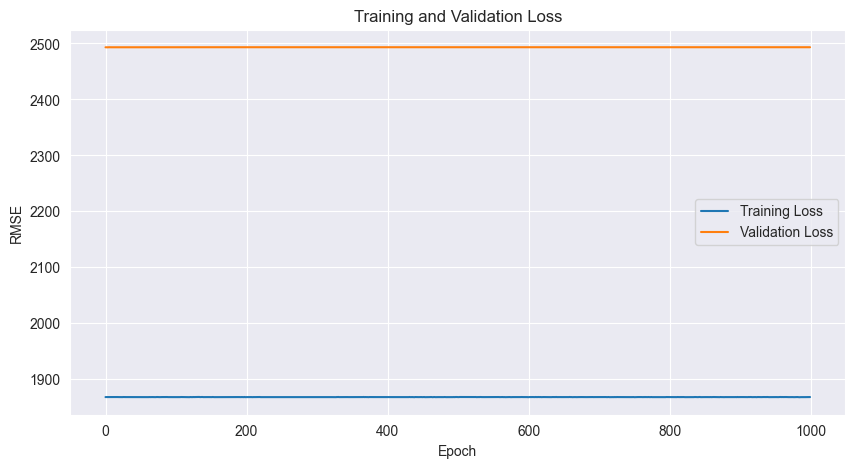

/var/folders/mh/b5m2p8fd04x2knz5_hwd1rqw0000gn/T/ipykernel_33496/690836615.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['attentions'] = averages


Final validation RMSE: 2493.1240


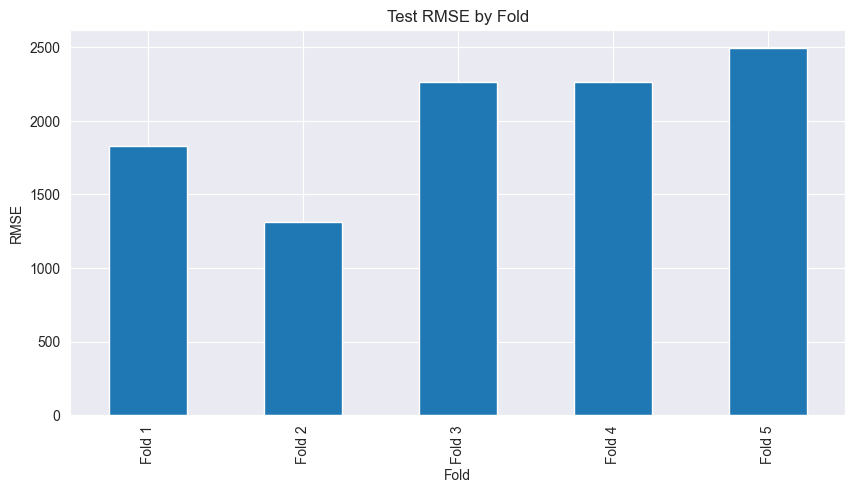

In [156]:
testLosses = []
for idx, (X_train, X_test, y_train, y_test) in enumerate(zip(X_trains, X_tests, y_trains, y_tests)):
    print(f"Fold {idx+1} - Train size: {len(X_train)}, Test size: {len(X_test)}")
    model, train_losses, val_losses, test_loss, test_predictions = fit_llm(X_train, y_train, X_test, y_test, hidden_size=64, num_layers=10, epochs=1000, lr=1e-3)
    
    # After training, process attention scores for this fold
    averages = []
    for i in range(len(X_train)):
        if i < len(model.attention_scores_dict):
            avg = average(model.attention_scores_dict, i)
        else:
            # Create placeholder tensor for missing entries
            avg = torch.zeros(len(X_train['list'].iloc[0]))
        averages.append(avg)
    
    # Store attention values and results
    X_train['attentions'] = averages
    testLosses.append(test_loss)

# Plot results
pd.Series(testLosses).plot.bar(figsize=(10, 5))
plt.title('Test RMSE by Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.xticks(range(len(testLosses)), [f'Fold {i+1}' for i in range(len(testLosses))])
plt.grid(True, axis='y')

In [158]:
np.array(testLosses).mean()

2032.357373046875

The model does the best on Fold 2.

## Hyperparameter Tuning

In [159]:
def tune_hyperparameters(X_trains, y_trains, X_tests, y_tests, 
                        hidden_sizes=[32, 64, 128], 
                        layers_options=[2, 5, 10], 
                        learning_rates=[1e-4, 1e-3, 1e-2],
                        epochs=500, 
                        verbose=True):
    """
    Tune hyperparameters for LLM model using grid search
    
    Parameters:
    -----------
    X_trains, y_trains, X_tests, y_tests: Lists of train/test data from cross-validation
    hidden_sizes: List of hidden size options to try
    layers_options: List of layer count options to try
    learning_rates: List of learning rate options to try
    epochs: Number of epochs for each model training
    verbose: Whether to print progress details
    
    Returns:
    --------
    best_params: Dictionary of best parameters
    results_df: DataFrame with all results
    """
    import itertools
    from tqdm.notebook import tqdm
    
    # Create all combinations of hyperparameters
    param_grid = list(itertools.product(hidden_sizes, layers_options, learning_rates))
    
    # Store results
    results = []
    best_rmse = float('inf')
    best_params = {}
    
    # Progress bar for all combinations
    total_combinations = len(param_grid)
    if verbose:
        print(f"Tuning {total_combinations} hyperparameter combinations...")
    
    # Loop through all combinations
    for hidden_size, num_layers, lr in tqdm(param_grid):
        if verbose:
            print(f"\nTesting: hidden_size={hidden_size}, layers={num_layers}, lr={lr}")
        
        # Run cross-validation
        fold_losses = []
        fold_train_losses = []
        fold_val_losses = []
        
        for fold, (X_train, y_train, X_test, y_test) in enumerate(zip(X_trains, y_trains, X_tests, y_tests)):
            if verbose:
                print(f"  Fold {fold+1}/{len(X_trains)}")
            
            # Train model with current hyperparameters
            model, train_losses, val_losses, test_loss, _ = fit_llm(
                X_train, y_train, X_test, y_test,
                hidden_size=hidden_size,
                num_layers=num_layers,
                epochs=epochs,
                lr=lr
            )
            
            fold_losses.append(test_loss)
            fold_train_losses.append(train_losses[-1])  # Final training loss
            fold_val_losses.append(val_losses[-1])      # Final validation loss
        
        # Calculate average metrics across folds
        avg_rmse = np.mean(fold_losses)
        avg_train_loss = np.mean(fold_train_losses)
        avg_val_loss = np.mean(fold_val_losses)
        std_rmse = np.std(fold_losses)
        
        # Store results
        results.append({
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'learning_rate': lr,
            'avg_rmse': avg_rmse,
            'std_rmse': std_rmse,
            'avg_train_loss': avg_train_loss,
            'avg_val_loss': avg_val_loss,
            'fold_losses': fold_losses
        })
        
        if verbose:
            print(f"  Avg RMSE: {avg_rmse:.4f} ± {std_rmse:.4f}")
        
        # Update best parameters if we found a better model
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_params = {
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'learning_rate': lr
            }
            if verbose:
                print(f"  New best model found!")
    
    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    # Sort by average RMSE
    results_df = results_df.sort_values('avg_rmse')
    
    # Print best parameters
    if verbose:
        print("\n" + "="*50)
        print(f"Best parameters: hidden_size={best_params['hidden_size']}, "
              f"num_layers={best_params['num_layers']}, "
              f"learning_rate={best_params['learning_rate']}")
        print(f"Best average RMSE: {best_rmse:.4f}")
        print("="*50)
    
    return best_params, results_df

Tuning 27 hyperparameter combinations...


  0%|          | 0/27 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Testing: hidden_size=32, layers=2, lr=0.0001
  Fold 1/5
Input size: 437



 12%|█▏        | 58/500 [00:00<00:00, 572.68it/s]

Epoch 0: Train RMSE: 1468.0240, Val RMSE: 1828.9065
Epoch 10: Train RMSE: 1467.8513, Val RMSE: 1828.9158
Epoch 20: Train RMSE: 1468.0393, Val RMSE: 1828.9095
Epoch 30: Train RMSE: 1467.7987, Val RMSE: 1828.9094
Epoch 40: Train RMSE: 1467.8217, Val RMSE: 1828.9091
Epoch 50: Train RMSE: 1467.8270, Val RMSE: 1828.9088
Epoch 60: Train RMSE: 1467.8756, Val RMSE: 1828.9087
Epoch 70: Train RMSE: 1468.0468, Val RMSE: 1828.9086
Epoch 80: Train RMSE: 1467.7689, Val RMSE: 1828.9084
Epoch 90: Train RMSE: 1467.7515, Val RMSE: 1828.9086
Epoch 100: Train RMSE: 1467.7512, Val RMSE: 1828.9084
Epoch 110: Train RMSE: 1467.9275, Val RMSE: 1828.9084
Epoch 120: Train RMSE: 1467.7252, Val RMSE: 1828.9084



 51%|█████     | 255/500 [00:00<00:00, 616.88it/s]

Epoch 130: Train RMSE: 1467.6720, Val RMSE: 1828.9084
Epoch 140: Train RMSE: 1467.8903, Val RMSE: 1828.9084
Epoch 150: Train RMSE: 1467.8750, Val RMSE: 1828.9084
Epoch 160: Train RMSE: 1467.5122, Val RMSE: 1828.9084
Epoch 170: Train RMSE: 1467.7123, Val RMSE: 1828.9084
Epoch 180: Train RMSE: 1467.8760, Val RMSE: 1828.9084
Epoch 190: Train RMSE: 1467.9102, Val RMSE: 1828.9084
Epoch 200: Train RMSE: 1467.9725, Val RMSE: 1828.9084
Epoch 210: Train RMSE: 1467.8669, Val RMSE: 1828.9084
Epoch 220: Train RMSE: 1467.8676, Val RMSE: 1828.9084
Epoch 230: Train RMSE: 1467.6859, Val RMSE: 1828.9084
Epoch 240: Train RMSE: 1468.0201, Val RMSE: 1828.9084
Epoch 250: Train RMSE: 1467.5669, Val RMSE: 1828.9084



 76%|███████▋  | 382/500 [00:00<00:00, 610.93it/s]

Epoch 260: Train RMSE: 1467.6205, Val RMSE: 1828.9084
Epoch 270: Train RMSE: 1467.6600, Val RMSE: 1828.9084
Epoch 280: Train RMSE: 1467.9581, Val RMSE: 1828.9084
Epoch 290: Train RMSE: 1467.8269, Val RMSE: 1828.9084
Epoch 300: Train RMSE: 1467.6292, Val RMSE: 1828.9084
Epoch 310: Train RMSE: 1467.7095, Val RMSE: 1828.9084
Epoch 320: Train RMSE: 1467.9091, Val RMSE: 1828.9084
Epoch 330: Train RMSE: 1467.8713, Val RMSE: 1828.9084
Epoch 340: Train RMSE: 1467.8518, Val RMSE: 1828.9084
Epoch 350: Train RMSE: 1467.6929, Val RMSE: 1828.9084
Epoch 360: Train RMSE: 1467.7788, Val RMSE: 1828.9084
Epoch 370: Train RMSE: 1467.9236, Val RMSE: 1828.9084
Epoch 380: Train RMSE: 1467.5796, Val RMSE: 1828.9084



100%|██████████| 500/500 [00:00<00:00, 599.02it/s]

Epoch 390: Train RMSE: 1467.7850, Val RMSE: 1828.9084
Epoch 400: Train RMSE: 1467.9926, Val RMSE: 1828.9084
Epoch 410: Train RMSE: 1467.6847, Val RMSE: 1828.9084
Epoch 420: Train RMSE: 1467.6260, Val RMSE: 1828.9084
Epoch 430: Train RMSE: 1467.7390, Val RMSE: 1828.9084
Epoch 440: Train RMSE: 1467.7775, Val RMSE: 1828.9084
Epoch 450: Train RMSE: 1467.8885, Val RMSE: 1828.9084
Epoch 460: Train RMSE: 1467.8734, Val RMSE: 1828.9084
Epoch 470: Train RMSE: 1467.9443, Val RMSE: 1828.9084
Epoch 480: Train RMSE: 1468.0247, Val RMSE: 1828.9084
Epoch 490: Train RMSE: 1467.8918, Val RMSE: 1828.9084


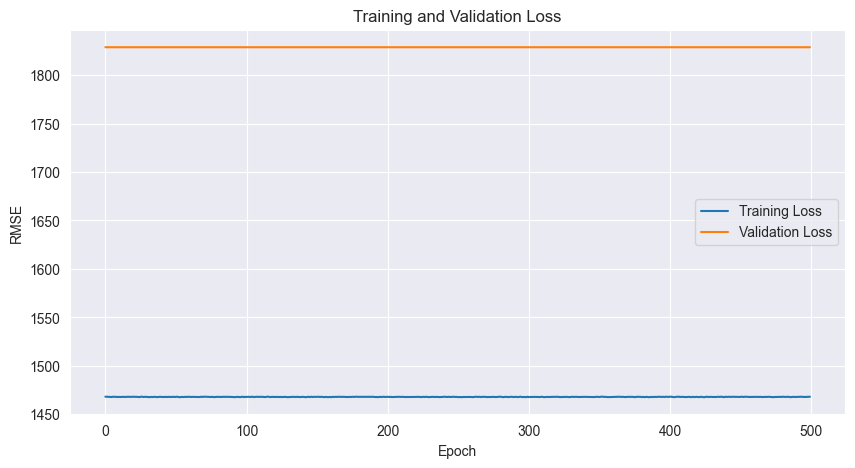

Final validation RMSE: 1828.9055
  Fold 2/5
Input size: 437



 12%|█▏        | 60/500 [00:00<00:00, 594.94it/s]

Epoch 0: Train RMSE: 1656.7572, Val RMSE: 1315.7548
Epoch 10: Train RMSE: 1656.7930, Val RMSE: 1315.7662
Epoch 20: Train RMSE: 1656.7548, Val RMSE: 1315.7502
Epoch 30: Train RMSE: 1656.6982, Val RMSE: 1315.7473
Epoch 40: Train RMSE: 1656.7014, Val RMSE: 1315.7480
Epoch 50: Train RMSE: 1656.7753, Val RMSE: 1315.7485
Epoch 60: Train RMSE: 1656.7147, Val RMSE: 1315.7493
Epoch 70: Train RMSE: 1656.6857, Val RMSE: 1315.7509
Epoch 80: Train RMSE: 1656.7457, Val RMSE: 1315.7529
Epoch 90: Train RMSE: 1656.7014, Val RMSE: 1315.7522
Epoch 100: Train RMSE: 1656.7543, Val RMSE: 1315.7529
Epoch 110: Train RMSE: 1656.7771, Val RMSE: 1315.7532



 36%|███▌      | 179/500 [00:00<00:00, 566.43it/s]

Epoch 120: Train RMSE: 1656.7771, Val RMSE: 1315.7528
Epoch 130: Train RMSE: 1656.6899, Val RMSE: 1315.7528
Epoch 140: Train RMSE: 1656.7698, Val RMSE: 1315.7528
Epoch 150: Train RMSE: 1656.6738, Val RMSE: 1315.7528
Epoch 160: Train RMSE: 1656.7909, Val RMSE: 1315.7528
Epoch 170: Train RMSE: 1656.7621, Val RMSE: 1315.7528
Epoch 180: Train RMSE: 1656.7070, Val RMSE: 1315.7527
Epoch 190: Train RMSE: 1656.6995, Val RMSE: 1315.7527
Epoch 200: Train RMSE: 1656.6790, Val RMSE: 1315.7527
Epoch 210: Train RMSE: 1656.7673, Val RMSE: 1315.7527
Epoch 220: Train RMSE: 1656.7240, Val RMSE: 1315.7527
Epoch 230: Train RMSE: 1656.7231, Val RMSE: 1315.7527



 71%|███████   | 354/500 [00:00<00:00, 566.71it/s]

Epoch 240: Train RMSE: 1656.7119, Val RMSE: 1315.7527
Epoch 250: Train RMSE: 1656.7659, Val RMSE: 1315.7527
Epoch 260: Train RMSE: 1656.7262, Val RMSE: 1315.7527
Epoch 270: Train RMSE: 1656.7098, Val RMSE: 1315.7527
Epoch 280: Train RMSE: 1656.7621, Val RMSE: 1315.7527
Epoch 290: Train RMSE: 1656.6827, Val RMSE: 1315.7526
Epoch 300: Train RMSE: 1656.7065, Val RMSE: 1315.7526
Epoch 310: Train RMSE: 1656.7781, Val RMSE: 1315.7526
Epoch 320: Train RMSE: 1656.7422, Val RMSE: 1315.7526
Epoch 330: Train RMSE: 1656.6691, Val RMSE: 1315.7524
Epoch 340: Train RMSE: 1656.7291, Val RMSE: 1315.7524
Epoch 350: Train RMSE: 1656.7286, Val RMSE: 1315.7524



 94%|█████████▍| 469/500 [00:00<00:00, 567.23it/s]

Epoch 360: Train RMSE: 1656.7196, Val RMSE: 1315.7526
Epoch 370: Train RMSE: 1656.7610, Val RMSE: 1315.7526
Epoch 380: Train RMSE: 1656.7500, Val RMSE: 1315.7526
Epoch 390: Train RMSE: 1656.7736, Val RMSE: 1315.7526
Epoch 400: Train RMSE: 1656.7603, Val RMSE: 1315.7524
Epoch 410: Train RMSE: 1656.6930, Val RMSE: 1315.7523
Epoch 420: Train RMSE: 1656.7273, Val RMSE: 1315.7523
Epoch 430: Train RMSE: 1656.7289, Val RMSE: 1315.7523
Epoch 440: Train RMSE: 1656.7589, Val RMSE: 1315.7522
Epoch 450: Train RMSE: 1656.7301, Val RMSE: 1315.7521
Epoch 460: Train RMSE: 1656.7052, Val RMSE: 1315.7521
Epoch 470: Train RMSE: 1656.7065, Val RMSE: 1315.7521


100%|██████████| 500/500 [00:00<00:00, 569.33it/s]


Epoch 480: Train RMSE: 1656.7428, Val RMSE: 1315.7521
Epoch 490: Train RMSE: 1656.7448, Val RMSE: 1315.7521


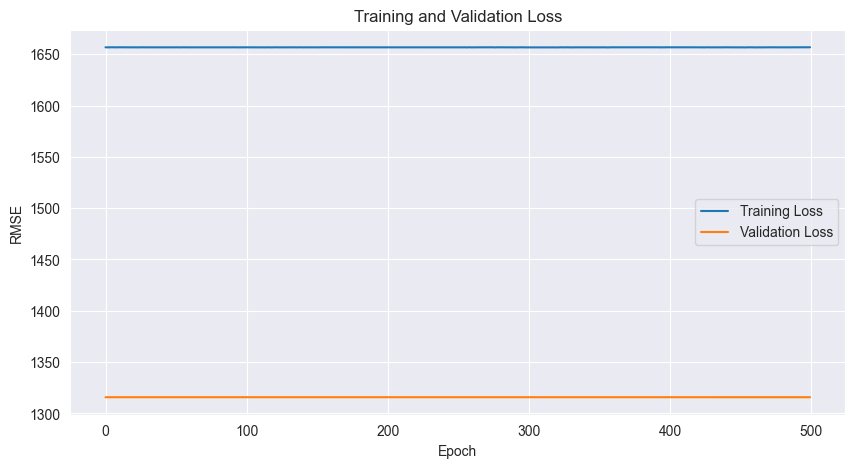

Final validation RMSE: 1315.7428
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1552.0508, Val RMSE: 2262.4092
Epoch 10: Train RMSE: 1552.0607, Val RMSE: 2262.4038
Epoch 20: Train RMSE: 1551.9877, Val RMSE: 2262.4038



  7%|▋         | 36/500 [00:00<00:01, 358.78it/s]

Epoch 30: Train RMSE: 1552.0381, Val RMSE: 2262.4021
Epoch 40: Train RMSE: 1552.0588, Val RMSE: 2262.4011
Epoch 50: Train RMSE: 1552.0018, Val RMSE: 2262.4009
Epoch 60: Train RMSE: 1552.0895, Val RMSE: 2262.4006
Epoch 70: Train RMSE: 1551.9752, Val RMSE: 2262.4006



 16%|█▋        | 82/500 [00:00<00:01, 415.89it/s]

Epoch 80: Train RMSE: 1552.0652, Val RMSE: 2262.4006
Epoch 90: Train RMSE: 1552.0569, Val RMSE: 2262.4004
Epoch 100: Train RMSE: 1552.0538, Val RMSE: 2262.4004
Epoch 110: Train RMSE: 1552.0068, Val RMSE: 2262.4004
Epoch 120: Train RMSE: 1552.0392, Val RMSE: 2262.4004



 26%|██▌       | 128/500 [00:00<00:00, 432.79it/s]

Epoch 130: Train RMSE: 1551.9722, Val RMSE: 2262.4004
Epoch 140: Train RMSE: 1552.0310, Val RMSE: 2262.4004
Epoch 150: Train RMSE: 1552.0305, Val RMSE: 2262.4004
Epoch 160: Train RMSE: 1552.0238, Val RMSE: 2262.4004
Epoch 170: Train RMSE: 1552.0293, Val RMSE: 2262.4004



 36%|███▌      | 181/500 [00:00<00:00, 469.73it/s]

Epoch 180: Train RMSE: 1552.0181, Val RMSE: 2262.4004



 46%|████▌     | 229/500 [00:00<00:00, 470.90it/s]

Epoch 190: Train RMSE: 1552.0518, Val RMSE: 2262.4004
Epoch 200: Train RMSE: 1551.9645, Val RMSE: 2262.4004
Epoch 210: Train RMSE: 1552.0453, Val RMSE: 2262.4004
Epoch 220: Train RMSE: 1552.0250, Val RMSE: 2262.4004
Epoch 230: Train RMSE: 1552.0332, Val RMSE: 2262.4004
Epoch 240: Train RMSE: 1552.0192, Val RMSE: 2262.4004
Epoch 250: Train RMSE: 1552.0073, Val RMSE: 2262.4004
Epoch 260: Train RMSE: 1552.0276, Val RMSE: 2262.4004
Epoch 270: Train RMSE: 1552.0326, Val RMSE: 2262.4004



 56%|█████▌    | 280/500 [00:00<00:00, 481.84it/s]

Epoch 280: Train RMSE: 1552.0173, Val RMSE: 2262.4004



 67%|██████▋   | 334/500 [00:00<00:00, 500.47it/s]

Epoch 290: Train RMSE: 1552.0634, Val RMSE: 2262.4004
Epoch 300: Train RMSE: 1552.0541, Val RMSE: 2262.4004
Epoch 310: Train RMSE: 1551.9861, Val RMSE: 2262.4004
Epoch 320: Train RMSE: 1552.0459, Val RMSE: 2262.4004
Epoch 330: Train RMSE: 1551.9691, Val RMSE: 2262.4004
Epoch 340: Train RMSE: 1552.0442, Val RMSE: 2262.4004



 79%|███████▉  | 395/500 [00:00<00:00, 532.70it/s]

Epoch 350: Train RMSE: 1552.0669, Val RMSE: 2262.4004
Epoch 360: Train RMSE: 1552.0234, Val RMSE: 2262.4004
Epoch 370: Train RMSE: 1552.0002, Val RMSE: 2262.4004
Epoch 380: Train RMSE: 1552.0629, Val RMSE: 2262.4004
Epoch 390: Train RMSE: 1552.0188, Val RMSE: 2262.4004
Epoch 400: Train RMSE: 1552.0713, Val RMSE: 2262.4004



 91%|█████████ | 453/500 [00:00<00:00, 546.01it/s]

Epoch 410: Train RMSE: 1551.9258, Val RMSE: 2262.4004
Epoch 420: Train RMSE: 1551.9639, Val RMSE: 2262.4004
Epoch 430: Train RMSE: 1552.0157, Val RMSE: 2262.4004
Epoch 440: Train RMSE: 1551.9845, Val RMSE: 2262.4004
Epoch 450: Train RMSE: 1552.0624, Val RMSE: 2262.4004
Epoch 460: Train RMSE: 1551.9960, Val RMSE: 2262.4004


100%|██████████| 500/500 [00:01<00:00, 499.81it/s]


Epoch 470: Train RMSE: 1552.0353, Val RMSE: 2262.4004
Epoch 480: Train RMSE: 1552.0216, Val RMSE: 2262.4004
Epoch 490: Train RMSE: 1552.0074, Val RMSE: 2262.4004


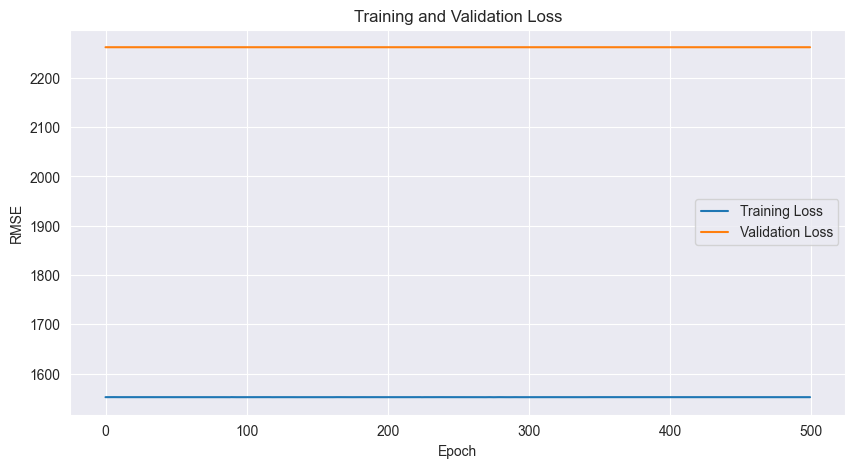

Final validation RMSE: 2262.4004
  Fold 4/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1755.9364, Val RMSE: 2261.8730
Epoch 10: Train RMSE: 1755.8936, Val RMSE: 2261.8105
Epoch 20: Train RMSE: 1755.9031, Val RMSE: 2261.8193



  9%|▊         | 43/500 [00:00<00:01, 423.19it/s]

Epoch 30: Train RMSE: 1755.8094, Val RMSE: 2261.8203
Epoch 40: Train RMSE: 1755.9689, Val RMSE: 2261.8108
Epoch 50: Train RMSE: 1755.8153, Val RMSE: 2261.8110
Epoch 60: Train RMSE: 1755.8696, Val RMSE: 2261.8113
Epoch 70: Train RMSE: 1755.8210, Val RMSE: 2261.8113
Epoch 80: Train RMSE: 1755.8322, Val RMSE: 2261.8113



 17%|█▋        | 87/500 [00:00<00:00, 431.71it/s]

Epoch 90: Train RMSE: 1755.8806, Val RMSE: 2261.8110
Epoch 100: Train RMSE: 1755.8243, Val RMSE: 2261.8113
Epoch 110: Train RMSE: 1755.9408, Val RMSE: 2261.8110
Epoch 120: Train RMSE: 1755.8363, Val RMSE: 2261.8113



 39%|███▉      | 195/500 [00:00<00:00, 499.25it/s]

Epoch 130: Train RMSE: 1755.9716, Val RMSE: 2261.8113
Epoch 140: Train RMSE: 1755.9789, Val RMSE: 2261.8113
Epoch 150: Train RMSE: 1755.8754, Val RMSE: 2261.8113
Epoch 160: Train RMSE: 1755.9192, Val RMSE: 2261.8113
Epoch 170: Train RMSE: 1755.9395, Val RMSE: 2261.8113
Epoch 180: Train RMSE: 1755.8079, Val RMSE: 2261.8113
Epoch 190: Train RMSE: 1755.9430, Val RMSE: 2261.8113
Epoch 200: Train RMSE: 1755.8176, Val RMSE: 2261.8113
Epoch 210: Train RMSE: 1755.9774, Val RMSE: 2261.8113
Epoch 220: Train RMSE: 1756.0337, Val RMSE: 2261.8113
Epoch 230: Train RMSE: 1755.9481, Val RMSE: 2261.8113



 61%|██████    | 303/500 [00:00<00:00, 523.61it/s]

Epoch 240: Train RMSE: 1755.8961, Val RMSE: 2261.8113
Epoch 250: Train RMSE: 1755.7468, Val RMSE: 2261.8113
Epoch 260: Train RMSE: 1755.9404, Val RMSE: 2261.8113
Epoch 270: Train RMSE: 1755.9861, Val RMSE: 2261.8113
Epoch 280: Train RMSE: 1755.9307, Val RMSE: 2261.8113
Epoch 290: Train RMSE: 1755.9205, Val RMSE: 2261.8113
Epoch 300: Train RMSE: 1755.8291, Val RMSE: 2261.8113
Epoch 310: Train RMSE: 1755.7888, Val RMSE: 2261.8113
Epoch 320: Train RMSE: 1755.9131, Val RMSE: 2261.8113
Epoch 330: Train RMSE: 1755.8983, Val RMSE: 2261.8113
Epoch 340: Train RMSE: 1755.9314, Val RMSE: 2261.8113
Epoch 350: Train RMSE: 1755.9604, Val RMSE: 2261.8113



 83%|████████▎ | 415/500 [00:00<00:00, 540.76it/s]

Epoch 360: Train RMSE: 1755.8031, Val RMSE: 2261.8113
Epoch 370: Train RMSE: 1755.9819, Val RMSE: 2261.8113
Epoch 380: Train RMSE: 1755.8014, Val RMSE: 2261.8113
Epoch 390: Train RMSE: 1755.8513, Val RMSE: 2261.8113
Epoch 400: Train RMSE: 1755.8882, Val RMSE: 2261.8113
Epoch 410: Train RMSE: 1755.9672, Val RMSE: 2261.8113
Epoch 420: Train RMSE: 1755.9800, Val RMSE: 2261.8113
Epoch 430: Train RMSE: 1755.9493, Val RMSE: 2261.8113



 94%|█████████▍| 470/500 [00:00<00:00, 537.73it/s]

Epoch 440: Train RMSE: 1755.9836, Val RMSE: 2261.8113
Epoch 450: Train RMSE: 1755.8265, Val RMSE: 2261.8113
Epoch 460: Train RMSE: 1756.0295, Val RMSE: 2261.8113


100%|██████████| 500/500 [00:00<00:00, 509.21it/s]


Epoch 470: Train RMSE: 1755.8552, Val RMSE: 2261.8113
Epoch 480: Train RMSE: 1755.8468, Val RMSE: 2261.8113
Epoch 490: Train RMSE: 1755.9381, Val RMSE: 2261.8113


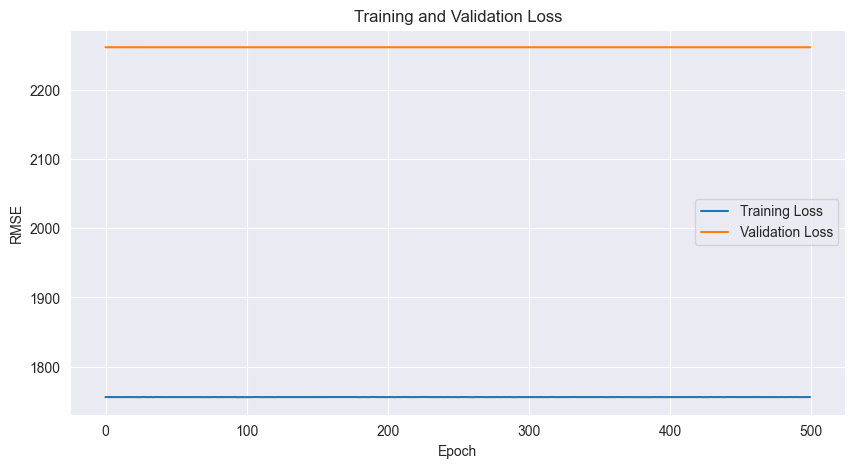

Final validation RMSE: 2261.8093
  Fold 5/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1867.7341, Val RMSE: 2493.1577
Epoch 10: Train RMSE: 1867.7278, Val RMSE: 2493.1685
Epoch 20: Train RMSE: 1867.7981, Val RMSE: 2493.1736



  8%|▊         | 41/500 [00:00<00:01, 408.01it/s]

Epoch 30: Train RMSE: 1867.7081, Val RMSE: 2493.1763
Epoch 40: Train RMSE: 1867.7075, Val RMSE: 2493.1775
Epoch 50: Train RMSE: 1867.7189, Val RMSE: 2493.1780
Epoch 60: Train RMSE: 1867.6952, Val RMSE: 2493.1787
Epoch 70: Train RMSE: 1867.7213, Val RMSE: 2493.1790
Epoch 80: Train RMSE: 1867.7281, Val RMSE: 2493.1790



 17%|█▋        | 85/500 [00:00<00:00, 424.54it/s]

Epoch 90: Train RMSE: 1867.7135, Val RMSE: 2493.1792
Epoch 100: Train RMSE: 1867.7051, Val RMSE: 2493.1792
Epoch 110: Train RMSE: 1867.6575, Val RMSE: 2493.1792
Epoch 120: Train RMSE: 1867.6993, Val RMSE: 2493.1792



 36%|███▌      | 178/500 [00:00<00:00, 442.68it/s]

Epoch 130: Train RMSE: 1867.7753, Val RMSE: 2493.1792
Epoch 140: Train RMSE: 1867.6562, Val RMSE: 2493.1792
Epoch 150: Train RMSE: 1867.7194, Val RMSE: 2493.1792
Epoch 160: Train RMSE: 1867.7269, Val RMSE: 2493.1792
Epoch 170: Train RMSE: 1867.7555, Val RMSE: 2493.1792
Epoch 180: Train RMSE: 1867.6857, Val RMSE: 2493.1792
Epoch 190: Train RMSE: 1867.6921, Val RMSE: 2493.1792
Epoch 200: Train RMSE: 1867.7565, Val RMSE: 2493.1792
Epoch 210: Train RMSE: 1867.7104, Val RMSE: 2493.1792



 54%|█████▍    | 272/500 [00:00<00:00, 445.41it/s]

Epoch 220: Train RMSE: 1867.7406, Val RMSE: 2493.1792
Epoch 230: Train RMSE: 1867.6941, Val RMSE: 2493.1792
Epoch 240: Train RMSE: 1867.6910, Val RMSE: 2493.1792
Epoch 250: Train RMSE: 1867.7443, Val RMSE: 2493.1792
Epoch 260: Train RMSE: 1867.7372, Val RMSE: 2493.1792
Epoch 270: Train RMSE: 1867.6465, Val RMSE: 2493.1792
Epoch 280: Train RMSE: 1867.7303, Val RMSE: 2493.1792
Epoch 290: Train RMSE: 1867.7463, Val RMSE: 2493.1792
Epoch 300: Train RMSE: 1867.6425, Val RMSE: 2493.1792
Epoch 310: Train RMSE: 1867.7626, Val RMSE: 2493.1792



 74%|███████▍  | 371/500 [00:00<00:00, 468.31it/s]

Epoch 320: Train RMSE: 1867.7804, Val RMSE: 2493.1792
Epoch 330: Train RMSE: 1867.7255, Val RMSE: 2493.1792
Epoch 340: Train RMSE: 1867.7521, Val RMSE: 2493.1792
Epoch 350: Train RMSE: 1867.7021, Val RMSE: 2493.1792
Epoch 360: Train RMSE: 1867.7405, Val RMSE: 2493.1792
Epoch 370: Train RMSE: 1867.6655, Val RMSE: 2493.1792
Epoch 380: Train RMSE: 1867.7003, Val RMSE: 2493.1792



 84%|████████▎ | 418/500 [00:00<00:00, 467.40it/s]

Epoch 390: Train RMSE: 1867.6743, Val RMSE: 2493.1792
Epoch 400: Train RMSE: 1867.7109, Val RMSE: 2493.1794
Epoch 410: Train RMSE: 1867.7839, Val RMSE: 2493.1794



 93%|█████████▎| 465/500 [00:01<00:00, 442.18it/s]

Epoch 420: Train RMSE: 1867.6570, Val RMSE: 2493.1794
Epoch 430: Train RMSE: 1867.7083, Val RMSE: 2493.1794
Epoch 440: Train RMSE: 1867.7104, Val RMSE: 2493.1794
Epoch 450: Train RMSE: 1867.6962, Val RMSE: 2493.1794
Epoch 460: Train RMSE: 1867.7396, Val RMSE: 2493.1794
Epoch 470: Train RMSE: 1867.7007, Val RMSE: 2493.1794


100%|██████████| 500/500 [00:01<00:00, 444.14it/s]

Epoch 480: Train RMSE: 1867.7120, Val RMSE: 2493.1794
Epoch 490: Train RMSE: 1867.7142, Val RMSE: 2493.1794


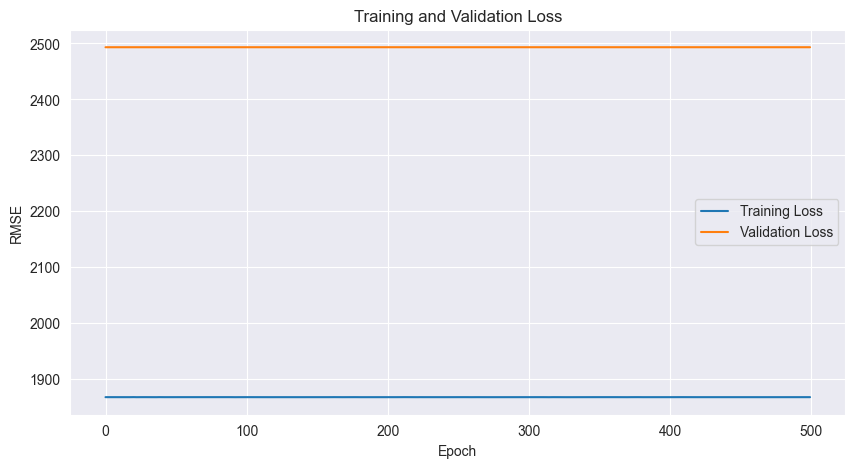

Final validation RMSE: 2493.1577
  Avg RMSE: 2032.4031 ± 417.8119
  New best model found!

Testing: hidden_size=32, layers=2, lr=0.001
  Fold 1/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1468.0115, Val RMSE: 1828.9758
Epoch 10: Train RMSE: 1467.7870, Val RMSE: 1828.9580
Epoch 20: Train RMSE: 1467.7516, Val RMSE: 1829.0265
Epoch 30: Train RMSE: 1467.5890, Val RMSE: 1829.0099
Epoch 40: Train RMSE: 1467.7675, Val RMSE: 1829.0200



 11%|█         | 56/500 [00:00<00:00, 557.56it/s]

Epoch 50: Train RMSE: 1467.6348, Val RMSE: 1829.0216
Epoch 60: Train RMSE: 1467.6567, Val RMSE: 1829.0685
Epoch 70: Train RMSE: 1467.4268, Val RMSE: 1829.0677
Epoch 80: Train RMSE: 1467.6467, Val RMSE: 1829.0680
Epoch 90: Train RMSE: 1467.5455, Val RMSE: 1829.0681
Epoch 100: Train RMSE: 1467.4034, Val RMSE: 1829.0682
Epoch 110: Train RMSE: 1467.4559, Val RMSE: 1829.0681
Epoch 120: Train RMSE: 1467.5854, Val RMSE: 1829.0682



 25%|██▍       | 124/500 [00:00<00:00, 629.23it/s]

Epoch 130: Train RMSE: 1467.7864, Val RMSE: 1829.0681
Epoch 140: Train RMSE: 1467.4501, Val RMSE: 1829.0682
Epoch 150: Train RMSE: 1467.4465, Val RMSE: 1829.0682
Epoch 160: Train RMSE: 1467.6476, Val RMSE: 1829.0681
Epoch 170: Train RMSE: 1467.6406, Val RMSE: 1829.0681



 37%|███▋      | 187/500 [00:00<00:00, 582.25it/s]

Epoch 180: Train RMSE: 1467.5101, Val RMSE: 1829.0681
Epoch 190: Train RMSE: 1467.5243, Val RMSE: 1829.0681
Epoch 200: Train RMSE: 1467.6224, Val RMSE: 1829.0681
Epoch 210: Train RMSE: 1467.7258, Val RMSE: 1829.0681
Epoch 220: Train RMSE: 1467.5916, Val RMSE: 1829.0681
Epoch 230: Train RMSE: 1467.6073, Val RMSE: 1829.0681
Epoch 240: Train RMSE: 1467.5638, Val RMSE: 1829.0682



 50%|████▉     | 249/500 [00:00<00:00, 590.90it/s]

Epoch 250: Train RMSE: 1467.5447, Val RMSE: 1829.0682
Epoch 260: Train RMSE: 1467.5436, Val RMSE: 1829.0682
Epoch 270: Train RMSE: 1467.4413, Val RMSE: 1829.0682
Epoch 280: Train RMSE: 1467.6208, Val RMSE: 1829.0682
Epoch 290: Train RMSE: 1467.4453, Val RMSE: 1829.0682
Epoch 300: Train RMSE: 1467.4137, Val RMSE: 1829.0682



 81%|████████  | 403/500 [00:00<00:00, 695.55it/s]

Epoch 310: Train RMSE: 1467.6360, Val RMSE: 1829.0682
Epoch 320: Train RMSE: 1467.5605, Val RMSE: 1829.0682
Epoch 330: Train RMSE: 1467.5820, Val RMSE: 1829.0682
Epoch 340: Train RMSE: 1467.5878, Val RMSE: 1829.0682
Epoch 350: Train RMSE: 1467.6604, Val RMSE: 1829.0682
Epoch 360: Train RMSE: 1467.6000, Val RMSE: 1829.0682
Epoch 370: Train RMSE: 1467.5624, Val RMSE: 1829.0682
Epoch 380: Train RMSE: 1467.3739, Val RMSE: 1829.0682
Epoch 390: Train RMSE: 1467.5574, Val RMSE: 1829.0682
Epoch 400: Train RMSE: 1467.4764, Val RMSE: 1829.0682
Epoch 410: Train RMSE: 1467.5891, Val RMSE: 1829.0682
Epoch 420: Train RMSE: 1467.6538, Val RMSE: 1829.0682
Epoch 430: Train RMSE: 1467.5792, Val RMSE: 1829.0682
Epoch 440: Train RMSE: 1467.5171, Val RMSE: 1829.0682
Epoch 450: Train RMSE: 1467.4039, Val RMSE: 1829.0682
Epoch 460: Train RMSE: 1467.6700, Val RMSE: 1829.0682
Epoch 470: Train RMSE: 1467.5990, Val RMSE: 1829.0682



100%|██████████| 500/500 [00:00<00:00, 675.17it/s]

Epoch 480: Train RMSE: 1467.4717, Val RMSE: 1829.0682
Epoch 490: Train RMSE: 1467.4724, Val RMSE: 1829.0682


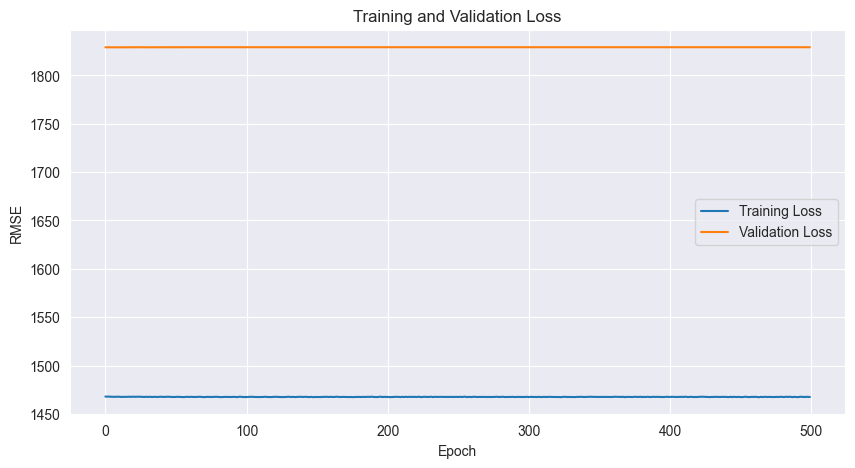

Final validation RMSE: 1828.9550
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.6709, Val RMSE: 1315.8600
Epoch 10: Train RMSE: 1656.6957, Val RMSE: 1316.0967
Epoch 20: Train RMSE: 1656.5918, Val RMSE: 1316.1947
Epoch 30: Train RMSE: 1656.5824, Val RMSE: 1316.2452
Epoch 40: Train RMSE: 1656.6282, Val RMSE: 1316.2687
Epoch 50: Train RMSE: 1656.5123, Val RMSE: 1316.2849



 11%|█         | 54/500 [00:00<00:00, 533.25it/s]

Epoch 60: Train RMSE: 1656.4612, Val RMSE: 1316.2936
Epoch 70: Train RMSE: 1656.6305, Val RMSE: 1316.2985
Epoch 80: Train RMSE: 1656.4972, Val RMSE: 1316.3008
Epoch 90: Train RMSE: 1656.6599, Val RMSE: 1316.3020
Epoch 100: Train RMSE: 1656.5498, Val RMSE: 1316.3026
Epoch 110: Train RMSE: 1656.5422, Val RMSE: 1316.3030



 23%|██▎       | 116/500 [00:00<00:00, 581.39it/s]

Epoch 120: Train RMSE: 1656.5312, Val RMSE: 1316.3031
Epoch 130: Train RMSE: 1656.7721, Val RMSE: 1316.3032



 38%|███▊      | 188/500 [00:00<00:00, 640.75it/s]

Epoch 140: Train RMSE: 1656.6321, Val RMSE: 1316.3033
Epoch 150: Train RMSE: 1656.5870, Val RMSE: 1316.3033
Epoch 160: Train RMSE: 1656.5216, Val RMSE: 1316.3033
Epoch 170: Train RMSE: 1656.4365, Val RMSE: 1316.3035
Epoch 180: Train RMSE: 1656.4379, Val RMSE: 1316.3035
Epoch 190: Train RMSE: 1656.6013, Val RMSE: 1316.3035



 52%|█████▏    | 261/500 [00:00<00:00, 675.70it/s]

Epoch 200: Train RMSE: 1656.5868, Val RMSE: 1316.3035
Epoch 210: Train RMSE: 1656.6378, Val RMSE: 1316.3035
Epoch 220: Train RMSE: 1656.5199, Val RMSE: 1316.3035
Epoch 230: Train RMSE: 1656.5359, Val RMSE: 1316.3035
Epoch 240: Train RMSE: 1656.3984, Val RMSE: 1316.3033
Epoch 250: Train RMSE: 1656.5150, Val RMSE: 1316.3033
Epoch 260: Train RMSE: 1656.5881, Val RMSE: 1316.3033
Epoch 270: Train RMSE: 1656.5128, Val RMSE: 1316.3033
Epoch 280: Train RMSE: 1656.5970, Val RMSE: 1316.3033



 66%|██████▋   | 332/500 [00:00<00:00, 687.08it/s]

Epoch 290: Train RMSE: 1656.5509, Val RMSE: 1316.3033
Epoch 300: Train RMSE: 1656.5292, Val RMSE: 1316.3033
Epoch 310: Train RMSE: 1656.6169, Val RMSE: 1316.3035
Epoch 320: Train RMSE: 1656.5461, Val RMSE: 1316.3035
Epoch 330: Train RMSE: 1656.5323, Val RMSE: 1316.3035
Epoch 340: Train RMSE: 1656.5583, Val RMSE: 1316.3035
Epoch 350: Train RMSE: 1656.5831, Val RMSE: 1316.3035
Epoch 360: Train RMSE: 1656.5050, Val RMSE: 1316.3035
Epoch 370: Train RMSE: 1656.6145, Val RMSE: 1316.3035
Epoch 380: Train RMSE: 1656.5483, Val RMSE: 1316.3035
Epoch 390: Train RMSE: 1656.5394, Val RMSE: 1316.3035



 80%|████████  | 401/500 [00:00<00:00, 631.41it/s]

Epoch 400: Train RMSE: 1656.5902, Val RMSE: 1316.3035



 93%|█████████▎| 465/500 [00:00<00:00, 628.99it/s]

Epoch 410: Train RMSE: 1656.5624, Val RMSE: 1316.3035
Epoch 420: Train RMSE: 1656.5891, Val RMSE: 1316.3035
Epoch 430: Train RMSE: 1656.4744, Val RMSE: 1316.3035
Epoch 440: Train RMSE: 1656.5159, Val RMSE: 1316.3035
Epoch 450: Train RMSE: 1656.4885, Val RMSE: 1316.3035
Epoch 460: Train RMSE: 1656.5236, Val RMSE: 1316.3035


100%|██████████| 500/500 [00:00<00:00, 637.07it/s]

Epoch 470: Train RMSE: 1656.4337, Val RMSE: 1316.3035
Epoch 480: Train RMSE: 1656.6218, Val RMSE: 1316.3035
Epoch 490: Train RMSE: 1656.5074, Val RMSE: 1316.3035


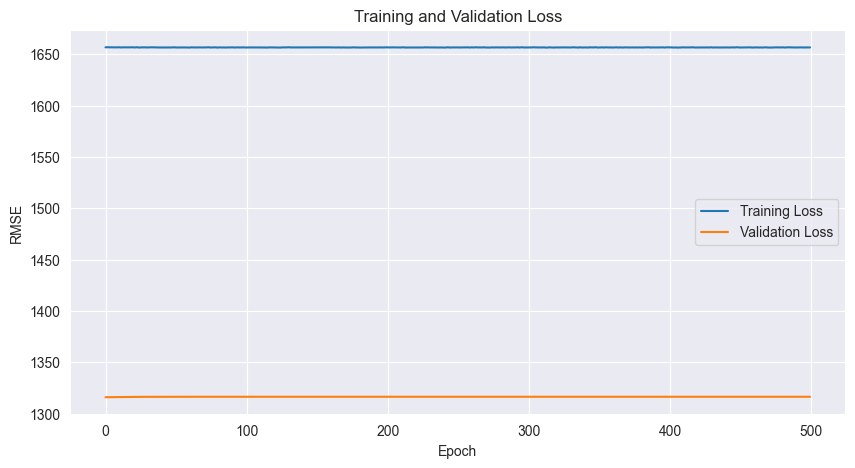

Final validation RMSE: 1315.8600
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1552.1161, Val RMSE: 2262.5891
Epoch 10: Train RMSE: 1552.0027, Val RMSE: 2262.3452
Epoch 20: Train RMSE: 1551.9078, Val RMSE: 2262.2068



  7%|▋         | 36/500 [00:00<00:01, 358.95it/s]

Epoch 30: Train RMSE: 1551.7844, Val RMSE: 2261.8428
Epoch 40: Train RMSE: 1551.9921, Val RMSE: 2261.7903
Epoch 50: Train RMSE: 1551.6071, Val RMSE: 2261.7290
Epoch 60: Train RMSE: 1551.7214, Val RMSE: 2261.6492



 14%|█▍        | 72/500 [00:00<00:01, 352.79it/s]

Epoch 70: Train RMSE: 1551.8492, Val RMSE: 2261.6787
Epoch 80: Train RMSE: 1551.6639, Val RMSE: 2261.6670
Epoch 90: Train RMSE: 1551.6714, Val RMSE: 2261.6606
Epoch 100: Train RMSE: 1551.5400, Val RMSE: 2261.6575
Epoch 110: Train RMSE: 1551.5663, Val RMSE: 2261.6562



 25%|██▍       | 123/500 [00:00<00:00, 423.09it/s]

Epoch 120: Train RMSE: 1551.5743, Val RMSE: 2261.6553
Epoch 130: Train RMSE: 1551.5679, Val RMSE: 2261.6550
Epoch 140: Train RMSE: 1551.7518, Val RMSE: 2261.6548
Epoch 150: Train RMSE: 1551.7383, Val RMSE: 2261.6545
Epoch 160: Train RMSE: 1551.7295, Val RMSE: 2261.6545
Epoch 170: Train RMSE: 1551.7125, Val RMSE: 2261.6545
Epoch 180: Train RMSE: 1551.5662, Val RMSE: 2261.6543



 37%|███▋      | 186/500 [00:00<00:00, 498.04it/s]

Epoch 190: Train RMSE: 1551.6300, Val RMSE: 2261.6543
Epoch 200: Train RMSE: 1551.7512, Val RMSE: 2261.6543
Epoch 210: Train RMSE: 1551.7136, Val RMSE: 2261.6545
Epoch 220: Train RMSE: 1551.6249, Val RMSE: 2261.6545
Epoch 230: Train RMSE: 1551.6302, Val RMSE: 2261.6545
Epoch 240: Train RMSE: 1551.6356, Val RMSE: 2261.6545



 62%|██████▏   | 309/500 [00:00<00:00, 559.33it/s]

Epoch 250: Train RMSE: 1551.4845, Val RMSE: 2261.6545
Epoch 260: Train RMSE: 1551.6027, Val RMSE: 2261.6545
Epoch 270: Train RMSE: 1551.6534, Val RMSE: 2261.6545
Epoch 280: Train RMSE: 1551.5732, Val RMSE: 2261.6545
Epoch 290: Train RMSE: 1551.5873, Val RMSE: 2261.6543
Epoch 300: Train RMSE: 1551.5693, Val RMSE: 2261.6543
Epoch 310: Train RMSE: 1551.6141, Val RMSE: 2261.6543
Epoch 320: Train RMSE: 1551.4352, Val RMSE: 2261.6543



 74%|███████▍  | 372/500 [00:00<00:00, 577.13it/s]

Epoch 330: Train RMSE: 1551.6526, Val RMSE: 2261.6543
Epoch 340: Train RMSE: 1551.5936, Val RMSE: 2261.6543
Epoch 350: Train RMSE: 1551.6768, Val RMSE: 2261.6543
Epoch 360: Train RMSE: 1551.5830, Val RMSE: 2261.6545
Epoch 370: Train RMSE: 1551.7150, Val RMSE: 2261.6545



 86%|████████▌ | 430/500 [00:00<00:00, 577.28it/s]

Epoch 380: Train RMSE: 1551.6101, Val RMSE: 2261.6545
Epoch 390: Train RMSE: 1551.6724, Val RMSE: 2261.6545
Epoch 400: Train RMSE: 1551.6841, Val RMSE: 2261.6545
Epoch 410: Train RMSE: 1551.6783, Val RMSE: 2261.6543
Epoch 420: Train RMSE: 1551.6288, Val RMSE: 2261.6543
Epoch 430: Train RMSE: 1551.7073, Val RMSE: 2261.6543
Epoch 440: Train RMSE: 1551.7717, Val RMSE: 2261.6543



 98%|█████████▊| 488/500 [00:00<00:00, 571.44it/s]

Epoch 450: Train RMSE: 1551.5134, Val RMSE: 2261.6545
Epoch 460: Train RMSE: 1551.7544, Val RMSE: 2261.6545
Epoch 470: Train RMSE: 1551.4686, Val RMSE: 2261.6545
Epoch 480: Train RMSE: 1551.6439, Val RMSE: 2261.6545
Epoch 490: Train RMSE: 1551.6479, Val RMSE: 2261.6543


100%|██████████| 500/500 [00:00<00:00, 533.83it/s]


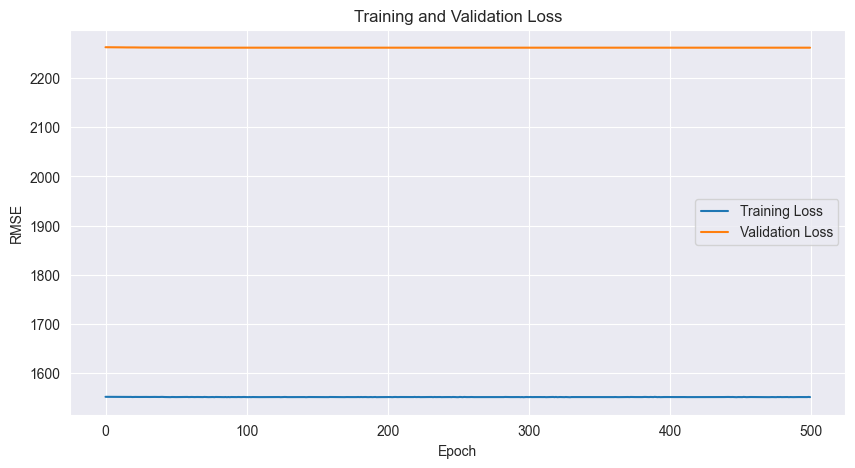

Final validation RMSE: 2261.5559
  Fold 4/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1756.0461, Val RMSE: 2261.7471
Epoch 10: Train RMSE: 1755.9739, Val RMSE: 2261.7639
Epoch 20: Train RMSE: 1755.9473, Val RMSE: 2261.7510



 10%|▉         | 48/500 [00:00<00:00, 478.31it/s]

Epoch 30: Train RMSE: 1755.9371, Val RMSE: 2261.7620
Epoch 40: Train RMSE: 1755.9530, Val RMSE: 2261.7615
Epoch 50: Train RMSE: 1755.9607, Val RMSE: 2261.7686
Epoch 60: Train RMSE: 1755.9487, Val RMSE: 2261.7686
Epoch 70: Train RMSE: 1755.9309, Val RMSE: 2261.7686
Epoch 80: Train RMSE: 1755.9326, Val RMSE: 2261.7686
Epoch 90: Train RMSE: 1755.9154, Val RMSE: 2261.7686



 19%|█▉        | 97/500 [00:00<00:00, 482.96it/s]

Epoch 100: Train RMSE: 1755.9083, Val RMSE: 2261.7686
Epoch 110: Train RMSE: 1755.8971, Val RMSE: 2261.7688
Epoch 120: Train RMSE: 1755.9142, Val RMSE: 2261.7686



 39%|███▉      | 194/500 [00:00<00:00, 470.23it/s]

Epoch 130: Train RMSE: 1755.9003, Val RMSE: 2261.7686
Epoch 140: Train RMSE: 1755.9270, Val RMSE: 2261.7686
Epoch 150: Train RMSE: 1755.9091, Val RMSE: 2261.7686
Epoch 160: Train RMSE: 1755.9181, Val RMSE: 2261.7686
Epoch 170: Train RMSE: 1755.8958, Val RMSE: 2261.7686
Epoch 180: Train RMSE: 1755.9344, Val RMSE: 2261.7686
Epoch 190: Train RMSE: 1755.9447, Val RMSE: 2261.7686
Epoch 200: Train RMSE: 1755.9260, Val RMSE: 2261.7686
Epoch 210: Train RMSE: 1755.9298, Val RMSE: 2261.7686
Epoch 220: Train RMSE: 1755.8794, Val RMSE: 2261.7686



 60%|██████    | 301/500 [00:00<00:00, 508.58it/s]

Epoch 230: Train RMSE: 1755.9296, Val RMSE: 2261.7686
Epoch 240: Train RMSE: 1755.9442, Val RMSE: 2261.7686
Epoch 250: Train RMSE: 1755.9259, Val RMSE: 2261.7686
Epoch 260: Train RMSE: 1755.9158, Val RMSE: 2261.7686
Epoch 270: Train RMSE: 1755.8994, Val RMSE: 2261.7686
Epoch 280: Train RMSE: 1755.9479, Val RMSE: 2261.7686
Epoch 290: Train RMSE: 1755.9220, Val RMSE: 2261.7686
Epoch 300: Train RMSE: 1755.9263, Val RMSE: 2261.7686
Epoch 310: Train RMSE: 1755.9325, Val RMSE: 2261.7686
Epoch 320: Train RMSE: 1755.9321, Val RMSE: 2261.7686
Epoch 330: Train RMSE: 1755.9678, Val RMSE: 2261.7686



 83%|████████▎ | 413/500 [00:00<00:00, 533.13it/s]

Epoch 340: Train RMSE: 1755.9060, Val RMSE: 2261.7686
Epoch 350: Train RMSE: 1755.9415, Val RMSE: 2261.7686
Epoch 360: Train RMSE: 1755.9283, Val RMSE: 2261.7686
Epoch 370: Train RMSE: 1755.9344, Val RMSE: 2261.7686
Epoch 380: Train RMSE: 1755.9180, Val RMSE: 2261.7686
Epoch 390: Train RMSE: 1755.9120, Val RMSE: 2261.7686
Epoch 400: Train RMSE: 1755.9058, Val RMSE: 2261.7686
Epoch 410: Train RMSE: 1755.9437, Val RMSE: 2261.7686
Epoch 420: Train RMSE: 1755.9264, Val RMSE: 2261.7686
Epoch 430: Train RMSE: 1755.9214, Val RMSE: 2261.7686
Epoch 440: Train RMSE: 1755.9186, Val RMSE: 2261.7686



100%|██████████| 500/500 [00:00<00:00, 504.98it/s]


Epoch 450: Train RMSE: 1755.9224, Val RMSE: 2261.7686
Epoch 460: Train RMSE: 1755.8845, Val RMSE: 2261.7686
Epoch 470: Train RMSE: 1755.9030, Val RMSE: 2261.7686
Epoch 480: Train RMSE: 1755.9678, Val RMSE: 2261.7686
Epoch 490: Train RMSE: 1755.9128, Val RMSE: 2261.7686


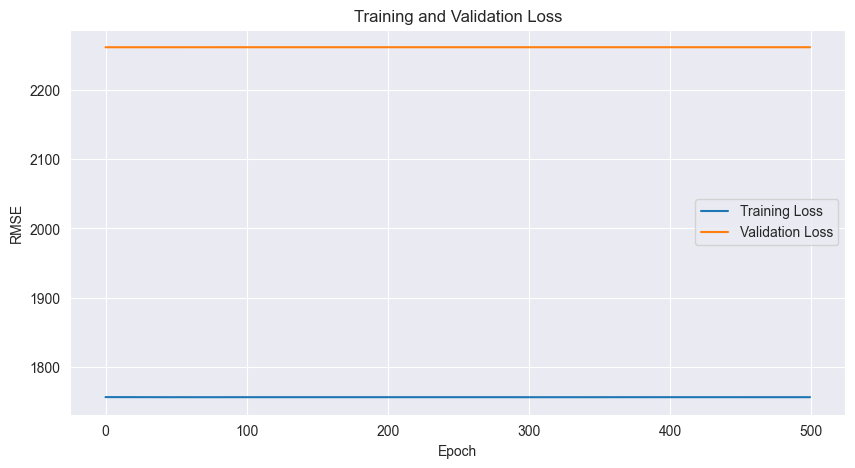

Final validation RMSE: 2261.7217
  Fold 5/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1867.7419, Val RMSE: 2493.1172



  8%|▊         | 41/500 [00:00<00:01, 398.19it/s]

Epoch 10: Train RMSE: 1867.7249, Val RMSE: 2493.1216
Epoch 20: Train RMSE: 1867.7208, Val RMSE: 2493.1384
Epoch 30: Train RMSE: 1867.7510, Val RMSE: 2493.1519
Epoch 40: Train RMSE: 1867.7197, Val RMSE: 2493.1609
Epoch 50: Train RMSE: 1867.7489, Val RMSE: 2493.1680
Epoch 60: Train RMSE: 1867.7439, Val RMSE: 2493.1719
Epoch 70: Train RMSE: 1867.7750, Val RMSE: 2493.1736
Epoch 80: Train RMSE: 1867.7277, Val RMSE: 2493.1746



 17%|█▋        | 85/500 [00:00<00:00, 417.48it/s]

Epoch 90: Train RMSE: 1867.7208, Val RMSE: 2493.1753



 27%|██▋       | 135/500 [00:00<00:00, 454.53it/s]

Epoch 100: Train RMSE: 1867.7225, Val RMSE: 2493.1753
Epoch 110: Train RMSE: 1867.7551, Val RMSE: 2493.1758
Epoch 120: Train RMSE: 1867.7095, Val RMSE: 2493.1758
Epoch 130: Train RMSE: 1867.7363, Val RMSE: 2493.1758
Epoch 140: Train RMSE: 1867.7542, Val RMSE: 2493.1758
Epoch 150: Train RMSE: 1867.7435, Val RMSE: 2493.1758
Epoch 160: Train RMSE: 1867.7377, Val RMSE: 2493.1758
Epoch 170: Train RMSE: 1867.7388, Val RMSE: 2493.1758



 36%|███▌      | 181/500 [00:00<00:00, 444.05it/s]

Epoch 180: Train RMSE: 1867.7604, Val RMSE: 2493.1758
Epoch 190: Train RMSE: 1867.7155, Val RMSE: 2493.1758



 46%|████▌     | 231/500 [00:00<00:00, 461.46it/s]

Epoch 200: Train RMSE: 1867.7003, Val RMSE: 2493.1758
Epoch 210: Train RMSE: 1867.6899, Val RMSE: 2493.1758
Epoch 220: Train RMSE: 1867.7219, Val RMSE: 2493.1758
Epoch 230: Train RMSE: 1867.7155, Val RMSE: 2493.1758
Epoch 240: Train RMSE: 1867.7405, Val RMSE: 2493.1758
Epoch 250: Train RMSE: 1867.7317, Val RMSE: 2493.1758
Epoch 260: Train RMSE: 1867.7394, Val RMSE: 2493.1758
Epoch 270: Train RMSE: 1867.7416, Val RMSE: 2493.1758



 56%|█████▌    | 279/500 [00:00<00:00, 464.78it/s]

Epoch 280: Train RMSE: 1867.7374, Val RMSE: 2493.1758
Epoch 290: Train RMSE: 1867.7050, Val RMSE: 2493.1758



 76%|███████▌  | 379/500 [00:00<00:00, 481.56it/s]

Epoch 300: Train RMSE: 1867.6952, Val RMSE: 2493.1758
Epoch 310: Train RMSE: 1867.7122, Val RMSE: 2493.1758
Epoch 320: Train RMSE: 1867.7341, Val RMSE: 2493.1758
Epoch 330: Train RMSE: 1867.7102, Val RMSE: 2493.1758
Epoch 340: Train RMSE: 1867.7463, Val RMSE: 2493.1758
Epoch 350: Train RMSE: 1867.7238, Val RMSE: 2493.1758
Epoch 360: Train RMSE: 1867.7021, Val RMSE: 2493.1758
Epoch 370: Train RMSE: 1867.7197, Val RMSE: 2493.1758
Epoch 380: Train RMSE: 1867.7070, Val RMSE: 2493.1758
Epoch 390: Train RMSE: 1867.7524, Val RMSE: 2493.1758
Epoch 400: Train RMSE: 1867.7830, Val RMSE: 2493.1758



 86%|████████▌ | 428/500 [00:00<00:00, 468.66it/s]

Epoch 410: Train RMSE: 1867.7557, Val RMSE: 2493.1758
Epoch 420: Train RMSE: 1867.6960, Val RMSE: 2493.1758
Epoch 430: Train RMSE: 1867.7771, Val RMSE: 2493.1758
Epoch 440: Train RMSE: 1867.7242, Val RMSE: 2493.1758
Epoch 450: Train RMSE: 1867.7062, Val RMSE: 2493.1758
Epoch 460: Train RMSE: 1867.6984, Val RMSE: 2493.1758



 95%|█████████▌| 475/500 [00:01<00:00, 457.02it/s]

Epoch 470: Train RMSE: 1867.7107, Val RMSE: 2493.1758
Epoch 480: Train RMSE: 1867.7646, Val RMSE: 2493.1758
Epoch 490: Train RMSE: 1867.7484, Val RMSE: 2493.1758


100%|██████████| 500/500 [00:01<00:00, 457.56it/s]


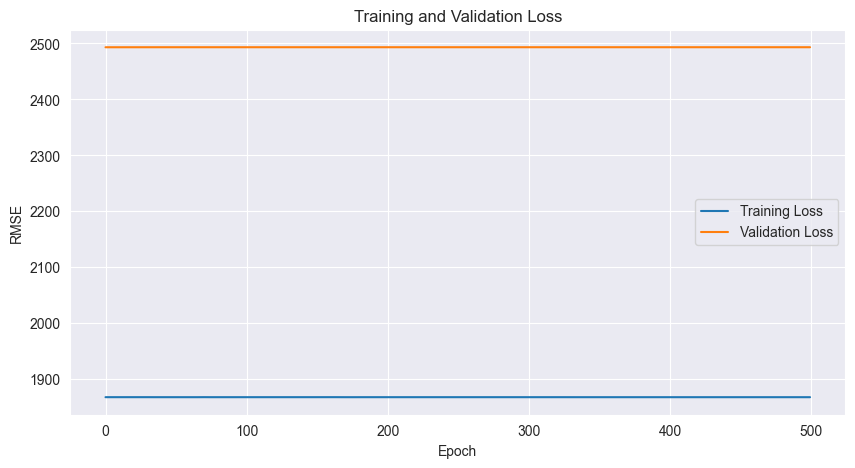

Final validation RMSE: 2493.1172
  Avg RMSE: 2032.2419 ± 417.6555
  New best model found!

Testing: hidden_size=32, layers=2, lr=0.01
  Fold 1/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1467.7998, Val RMSE: 1829.0818
Epoch 10: Train RMSE: 1467.2865, Val RMSE: 1829.0283
Epoch 20: Train RMSE: 1467.2986, Val RMSE: 1829.0397
Epoch 30: Train RMSE: 1467.1759, Val RMSE: 1829.0450



 13%|█▎        | 67/500 [00:00<00:00, 665.05it/s]

Epoch 40: Train RMSE: 1467.8073, Val RMSE: 1829.0475
Epoch 50: Train RMSE: 1467.6025, Val RMSE: 1829.0494
Epoch 60: Train RMSE: 1467.7312, Val RMSE: 1829.0502


Epoch 70: Train RMSE: 1467.4456, Val RMSE: 1829.0509
Epoch 80: Train RMSE: 1467.3158, Val RMSE: 1829.0513
Epoch 90: Train RMSE: 1467.4474, Val RMSE: 1829.0515
Epoch 100: Train RMSE: 1467.4607, Val RMSE: 1829.0515
Epoch 110: Train RMSE: 1467.7974, Val RMSE: 1829.0515
Epoch 120: Train RMSE: 1467.5687, Val RMSE: 1829.0516


Epoch 130: Train RMSE: 1467.0721, Val RMSE: 1829.0515


 27%|██▋       | 134/500 [00:00<00:00, 660.38it/s]

Epoch 140: Train RMSE: 1467.6239, Val RMSE: 1829.0515
Epoch 150: Train RMSE: 1467.7034, Val RMSE: 1829.0516
Epoch 160: Train RMSE: 1467.6248, Val RMSE: 1829.0516
Epoch 170: Train RMSE: 1467.4216, Val RMSE: 1829.0516



 41%|████      | 203/500 [00:00<00:00, 671.76it/s]

Epoch 180: Train RMSE: 1467.4298, Val RMSE: 1829.0516
Epoch 190: Train RMSE: 1467.6241, Val RMSE: 1829.0516
Epoch 200: Train RMSE: 1467.6802, Val RMSE: 1829.0516
Epoch 210: Train RMSE: 1467.4155, Val RMSE: 1829.0516
Epoch 220: Train RMSE: 1467.4728, Val RMSE: 1829.0516
Epoch 230: Train RMSE: 1467.3976, Val RMSE: 1829.0516
Epoch 240: Train RMSE: 1467.1957, Val RMSE: 1829.0516
Epoch 250: Train RMSE: 1467.7191, Val RMSE: 1829.0516
Epoch 260: Train RMSE: 1467.3512, Val RMSE: 1829.0516
Epoch 270: Train RMSE: 1467.4438, Val RMSE: 1829.0516



 56%|█████▌    | 280/500 [00:00<00:00, 707.21it/s]

Epoch 280: Train RMSE: 1467.4237, Val RMSE: 1829.0516
Epoch 290: Train RMSE: 1467.4808, Val RMSE: 1829.0516
Epoch 300: Train RMSE: 1467.2506, Val RMSE: 1829.0516
Epoch 310: Train RMSE: 1467.7943, Val RMSE: 1829.0516
Epoch 320: Train RMSE: 1467.3958, Val RMSE: 1829.0516



 72%|███████▏  | 359/500 [00:00<00:00, 735.97it/s]

Epoch 330: Train RMSE: 1467.7670, Val RMSE: 1829.0516
Epoch 340: Train RMSE: 1467.5083, Val RMSE: 1829.0516
Epoch 350: Train RMSE: 1467.4271, Val RMSE: 1829.0516
Epoch 360: Train RMSE: 1467.5763, Val RMSE: 1829.0516



 89%|████████▉ | 447/500 [00:00<00:00, 782.58it/s]

Epoch 370: Train RMSE: 1467.6675, Val RMSE: 1829.0516
Epoch 380: Train RMSE: 1467.5627, Val RMSE: 1829.0516
Epoch 390: Train RMSE: 1467.1195, Val RMSE: 1829.0516
Epoch 400: Train RMSE: 1467.5027, Val RMSE: 1829.0516
Epoch 410: Train RMSE: 1467.5602, Val RMSE: 1829.0516
Epoch 420: Train RMSE: 1467.7157, Val RMSE: 1829.0516
Epoch 430: Train RMSE: 1467.5586, Val RMSE: 1829.0516
Epoch 440: Train RMSE: 1467.5953, Val RMSE: 1829.0516
Epoch 450: Train RMSE: 1467.4680, Val RMSE: 1829.0516


100%|██████████| 500/500 [00:00<00:00, 749.58it/s]

Epoch 460: Train RMSE: 1467.4413, Val RMSE: 1829.0516
Epoch 470: Train RMSE: 1467.3674, Val RMSE: 1829.0516
Epoch 480: Train RMSE: 1467.9094, Val RMSE: 1829.0516
Epoch 490: Train RMSE: 1467.5496, Val RMSE: 1829.0516


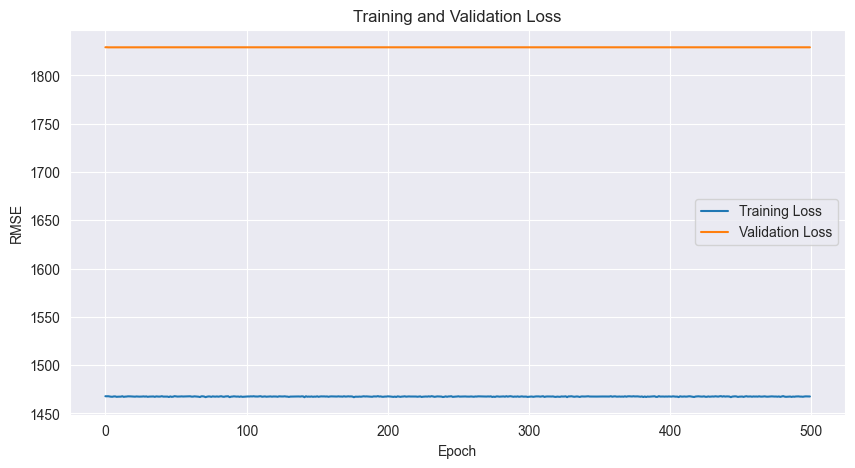

Final validation RMSE: 1829.0098
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.7349, Val RMSE: 1315.7545
Epoch 10: Train RMSE: 1656.6375, Val RMSE: 1316.2526
Epoch 20: Train RMSE: 1656.6896, Val RMSE: 1316.2832
Epoch 30: Train RMSE: 1656.7357, Val RMSE: 1316.3203



 10%|▉         | 49/500 [00:00<00:00, 482.83it/s]

Epoch 40: Train RMSE: 1656.6650, Val RMSE: 1316.3351
Epoch 50: Train RMSE: 1656.4113, Val RMSE: 1316.3458
Epoch 60: Train RMSE: 1656.6621, Val RMSE: 1316.3521
Epoch 70: Train RMSE: 1656.6998, Val RMSE: 1316.3541
Epoch 80: Train RMSE: 1656.7295, Val RMSE: 1316.3552
Epoch 90: Train RMSE: 1656.5547, Val RMSE: 1316.3560
Epoch 100: Train RMSE: 1656.6254, Val RMSE: 1316.3567



 22%|██▏       | 108/500 [00:00<00:00, 543.11it/s]

Epoch 110: Train RMSE: 1656.7494, Val RMSE: 1316.3568
Epoch 120: Train RMSE: 1656.9110, Val RMSE: 1316.3569
Epoch 130: Train RMSE: 1656.4540, Val RMSE: 1316.3571
Epoch 140: Train RMSE: 1656.7096, Val RMSE: 1316.3569
Epoch 150: Train RMSE: 1656.6196, Val RMSE: 1316.3571
Epoch 160: Train RMSE: 1656.6411, Val RMSE: 1316.3571



 50%|█████     | 250/500 [00:00<00:00, 648.18it/s]

Epoch 170: Train RMSE: 1656.6895, Val RMSE: 1316.3571
Epoch 180: Train RMSE: 1656.8253, Val RMSE: 1316.3571
Epoch 190: Train RMSE: 1656.7531, Val RMSE: 1316.3571
Epoch 200: Train RMSE: 1656.6873, Val RMSE: 1316.3571
Epoch 210: Train RMSE: 1656.5804, Val RMSE: 1316.3571
Epoch 220: Train RMSE: 1656.6738, Val RMSE: 1316.3571
Epoch 230: Train RMSE: 1656.7560, Val RMSE: 1316.3571
Epoch 240: Train RMSE: 1656.8049, Val RMSE: 1316.3571
Epoch 250: Train RMSE: 1656.5641, Val RMSE: 1316.3571
Epoch 260: Train RMSE: 1656.4042, Val RMSE: 1316.3571
Epoch 270: Train RMSE: 1656.7112, Val RMSE: 1316.3571
Epoch 280: Train RMSE: 1656.6979, Val RMSE: 1316.3571
Epoch 290: Train RMSE: 1656.5758, Val RMSE: 1316.3571
Epoch 300: Train RMSE: 1656.6525, Val RMSE: 1316.3571
Epoch 310: Train RMSE: 1656.6497, Val RMSE: 1316.3571



 80%|████████  | 400/500 [00:00<00:00, 703.21it/s]

Epoch 320: Train RMSE: 1656.4637, Val RMSE: 1316.3571
Epoch 330: Train RMSE: 1656.7220, Val RMSE: 1316.3571
Epoch 340: Train RMSE: 1656.7288, Val RMSE: 1316.3571
Epoch 350: Train RMSE: 1656.7113, Val RMSE: 1316.3571
Epoch 360: Train RMSE: 1656.7103, Val RMSE: 1316.3571
Epoch 370: Train RMSE: 1656.7355, Val RMSE: 1316.3571
Epoch 380: Train RMSE: 1656.7013, Val RMSE: 1316.3571
Epoch 390: Train RMSE: 1656.6979, Val RMSE: 1316.3571
Epoch 400: Train RMSE: 1656.8752, Val RMSE: 1316.3571
Epoch 410: Train RMSE: 1656.6774, Val RMSE: 1316.3571
Epoch 420: Train RMSE: 1656.7131, Val RMSE: 1316.3571
Epoch 430: Train RMSE: 1656.6184, Val RMSE: 1316.3571
Epoch 440: Train RMSE: 1656.6542, Val RMSE: 1316.3571
Epoch 450: Train RMSE: 1656.6100, Val RMSE: 1316.3571



100%|██████████| 500/500 [00:00<00:00, 656.95it/s]


Epoch 460: Train RMSE: 1656.6260, Val RMSE: 1316.3571
Epoch 470: Train RMSE: 1656.7914, Val RMSE: 1316.3571
Epoch 480: Train RMSE: 1656.7571, Val RMSE: 1316.3571
Epoch 490: Train RMSE: 1656.5311, Val RMSE: 1316.3571


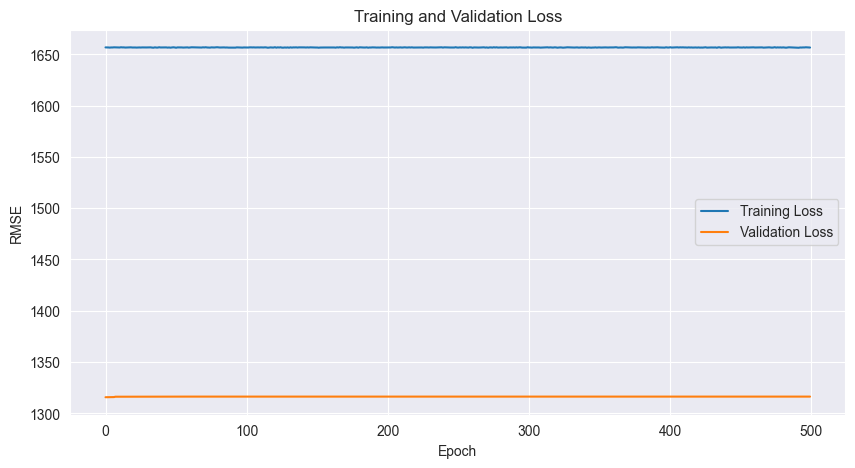

Final validation RMSE: 1315.7545
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1552.0957, Val RMSE: 2262.3818
Epoch 10: Train RMSE: 1551.9930, Val RMSE: 2262.2339
Epoch 20: Train RMSE: 1551.9465, Val RMSE: 2261.8411



  7%|▋         | 35/500 [00:00<00:01, 341.16it/s]

Epoch 30: Train RMSE: 1551.9946, Val RMSE: 2261.4810
Epoch 40: Train RMSE: 1551.8588, Val RMSE: 2261.1904
Epoch 50: Train RMSE: 1551.8292, Val RMSE: 2260.9548
Epoch 60: Train RMSE: 1551.6890, Val RMSE: 2260.8223



 14%|█▍        | 70/500 [00:00<00:01, 333.98it/s]

Epoch 70: Train RMSE: 1551.6986, Val RMSE: 2260.6777
Epoch 80: Train RMSE: 1551.5898, Val RMSE: 2260.5808
Epoch 90: Train RMSE: 1551.6787, Val RMSE: 2260.5171



 21%|██▏       | 107/500 [00:00<00:01, 344.95it/s]

Epoch 100: Train RMSE: 1551.8170, Val RMSE: 2260.4863
Epoch 110: Train RMSE: 1551.5145, Val RMSE: 2260.4736
Epoch 120: Train RMSE: 1551.6740, Val RMSE: 2260.4648
Epoch 130: Train RMSE: 1551.6757, Val RMSE: 2260.4609
Epoch 140: Train RMSE: 1551.7716, Val RMSE: 2260.4592



 28%|██▊       | 142/500 [00:00<00:01, 343.59it/s]

Epoch 150: Train RMSE: 1551.5310, Val RMSE: 2260.4583
Epoch 160: Train RMSE: 1551.5699, Val RMSE: 2260.4580
Epoch 170: Train RMSE: 1551.7350, Val RMSE: 2260.4575
Epoch 180: Train RMSE: 1551.5284, Val RMSE: 2260.4575



 52%|█████▏    | 259/500 [00:00<00:00, 483.28it/s]

Epoch 190: Train RMSE: 1551.5188, Val RMSE: 2260.4573
Epoch 200: Train RMSE: 1551.6134, Val RMSE: 2260.4573
Epoch 210: Train RMSE: 1551.5779, Val RMSE: 2260.4573
Epoch 220: Train RMSE: 1551.5125, Val RMSE: 2260.4573
Epoch 230: Train RMSE: 1551.6396, Val RMSE: 2260.4573
Epoch 240: Train RMSE: 1551.6219, Val RMSE: 2260.4573
Epoch 250: Train RMSE: 1551.7618, Val RMSE: 2260.4573
Epoch 260: Train RMSE: 1551.6000, Val RMSE: 2260.4573
Epoch 270: Train RMSE: 1552.0100, Val RMSE: 2260.4573
Epoch 280: Train RMSE: 1551.8724, Val RMSE: 2260.4573
Epoch 290: Train RMSE: 1551.8165, Val RMSE: 2260.4573
Epoch 300: Train RMSE: 1551.6765, Val RMSE: 2260.4573
Epoch 310: Train RMSE: 1551.7185, Val RMSE: 2260.4573



 77%|███████▋  | 385/500 [00:00<00:00, 560.05it/s]

Epoch 320: Train RMSE: 1551.4058, Val RMSE: 2260.4573
Epoch 330: Train RMSE: 1551.8320, Val RMSE: 2260.4573
Epoch 340: Train RMSE: 1551.5654, Val RMSE: 2260.4573
Epoch 350: Train RMSE: 1551.6862, Val RMSE: 2260.4573
Epoch 360: Train RMSE: 1551.6268, Val RMSE: 2260.4573
Epoch 370: Train RMSE: 1551.3965, Val RMSE: 2260.4573
Epoch 380: Train RMSE: 1551.7740, Val RMSE: 2260.4573
Epoch 390: Train RMSE: 1551.8817, Val RMSE: 2260.4573
Epoch 400: Train RMSE: 1551.6230, Val RMSE: 2260.4573
Epoch 410: Train RMSE: 1551.5809, Val RMSE: 2260.4573
Epoch 420: Train RMSE: 1551.5581, Val RMSE: 2260.4573
Epoch 430: Train RMSE: 1551.5498, Val RMSE: 2260.4573



100%|██████████| 500/500 [00:01<00:00, 487.70it/s]

Epoch 440: Train RMSE: 1551.7640, Val RMSE: 2260.4573
Epoch 450: Train RMSE: 1551.3695, Val RMSE: 2260.4573
Epoch 460: Train RMSE: 1551.5619, Val RMSE: 2260.4573
Epoch 470: Train RMSE: 1551.5883, Val RMSE: 2260.4573
Epoch 480: Train RMSE: 1551.6470, Val RMSE: 2260.4573
Epoch 490: Train RMSE: 1551.4615, Val RMSE: 2260.4573


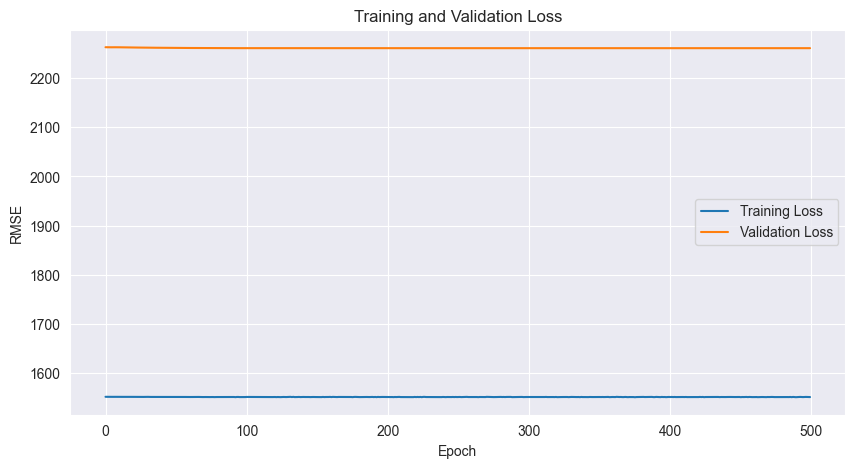

Final validation RMSE: 2260.4573
  Fold 4/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1755.7299, Val RMSE: 2261.8530



  8%|▊         | 39/500 [00:00<00:01, 388.51it/s]

Epoch 10: Train RMSE: 1755.8047, Val RMSE: 2261.8850
Epoch 20: Train RMSE: 1755.3973, Val RMSE: 2261.9592
Epoch 30: Train RMSE: 1755.4281, Val RMSE: 2261.9875
Epoch 40: Train RMSE: 1755.3596, Val RMSE: 2262.0005
Epoch 50: Train RMSE: 1755.3621, Val RMSE: 2262.0078
Epoch 60: Train RMSE: 1755.2822, Val RMSE: 2262.0129
Epoch 70: Train RMSE: 1755.0775, Val RMSE: 2262.0151



 16%|█▋        | 82/500 [00:00<00:01, 410.83it/s]

Epoch 80: Train RMSE: 1755.2690, Val RMSE: 2262.0166
Epoch 90: Train RMSE: 1755.1725, Val RMSE: 2262.0171



 27%|██▋       | 134/500 [00:00<00:00, 455.75it/s]

Epoch 100: Train RMSE: 1755.3054, Val RMSE: 2262.0176
Epoch 110: Train RMSE: 1755.3442, Val RMSE: 2262.0176
Epoch 120: Train RMSE: 1755.2633, Val RMSE: 2262.0178
Epoch 130: Train RMSE: 1755.1454, Val RMSE: 2262.0178
Epoch 140: Train RMSE: 1755.2518, Val RMSE: 2262.0178
Epoch 150: Train RMSE: 1755.2345, Val RMSE: 2262.0178
Epoch 160: Train RMSE: 1755.1652, Val RMSE: 2262.0178
Epoch 170: Train RMSE: 1755.0969, Val RMSE: 2262.0178
Epoch 180: Train RMSE: 1755.1619, Val RMSE: 2262.0181



 37%|███▋      | 184/500 [00:00<00:00, 471.96it/s]

Epoch 190: Train RMSE: 1755.2611, Val RMSE: 2262.0181



 59%|█████▉    | 294/500 [00:00<00:00, 514.18it/s]

Epoch 200: Train RMSE: 1755.2987, Val RMSE: 2262.0181
Epoch 210: Train RMSE: 1755.2528, Val RMSE: 2262.0181
Epoch 220: Train RMSE: 1755.4247, Val RMSE: 2262.0181
Epoch 230: Train RMSE: 1755.2008, Val RMSE: 2262.0181
Epoch 240: Train RMSE: 1755.2982, Val RMSE: 2262.0181
Epoch 250: Train RMSE: 1755.2765, Val RMSE: 2262.0181
Epoch 260: Train RMSE: 1755.3809, Val RMSE: 2262.0181
Epoch 270: Train RMSE: 1755.2533, Val RMSE: 2262.0181
Epoch 280: Train RMSE: 1755.0450, Val RMSE: 2262.0181
Epoch 290: Train RMSE: 1755.1469, Val RMSE: 2262.0181
Epoch 300: Train RMSE: 1755.2183, Val RMSE: 2262.0181
Epoch 310: Train RMSE: 1755.1862, Val RMSE: 2262.0181



 81%|████████  | 405/500 [00:00<00:00, 537.16it/s]

Epoch 320: Train RMSE: 1755.2163, Val RMSE: 2262.0181
Epoch 330: Train RMSE: 1755.1919, Val RMSE: 2262.0181
Epoch 340: Train RMSE: 1755.0593, Val RMSE: 2262.0181
Epoch 350: Train RMSE: 1755.2931, Val RMSE: 2262.0181
Epoch 360: Train RMSE: 1755.1379, Val RMSE: 2262.0181
Epoch 370: Train RMSE: 1755.1744, Val RMSE: 2262.0181
Epoch 380: Train RMSE: 1755.2651, Val RMSE: 2262.0181
Epoch 390: Train RMSE: 1755.2212, Val RMSE: 2262.0181
Epoch 400: Train RMSE: 1755.2297, Val RMSE: 2262.0181
Epoch 410: Train RMSE: 1755.1562, Val RMSE: 2262.0181
Epoch 420: Train RMSE: 1755.3295, Val RMSE: 2262.0181
Epoch 430: Train RMSE: 1755.3004, Val RMSE: 2262.0181



100%|██████████| 500/500 [00:01<00:00, 498.88it/s]


Epoch 440: Train RMSE: 1755.2228, Val RMSE: 2262.0181
Epoch 450: Train RMSE: 1755.2692, Val RMSE: 2262.0181
Epoch 460: Train RMSE: 1755.0786, Val RMSE: 2262.0181
Epoch 470: Train RMSE: 1755.2258, Val RMSE: 2262.0181
Epoch 480: Train RMSE: 1755.0438, Val RMSE: 2262.0181
Epoch 490: Train RMSE: 1755.1456, Val RMSE: 2262.0181


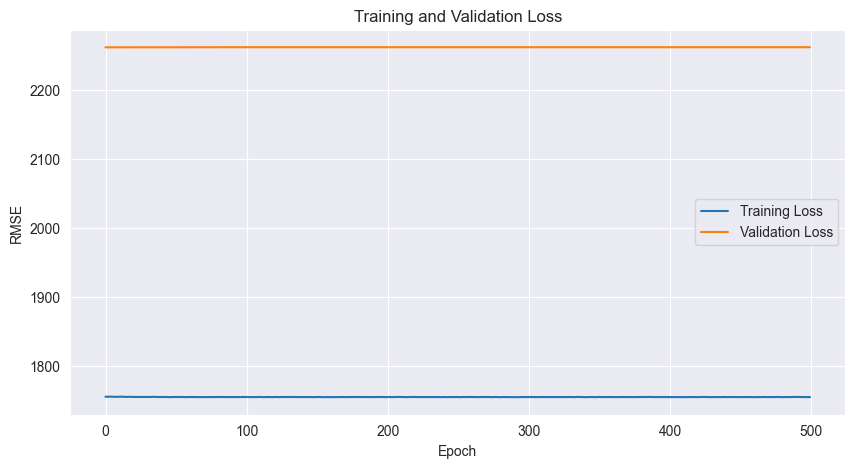

Final validation RMSE: 2261.8088
  Fold 5/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1867.7620, Val RMSE: 2493.2759



  1%|          | 3/500 [00:00<00:17, 28.54it/s]

Epoch 10: Train RMSE: 1867.4091, Val RMSE: 2493.6658
Epoch 20: Train RMSE: 1867.2892, Val RMSE: 2493.7678
Epoch 30: Train RMSE: 1867.3230, Val RMSE: 2493.8521
Epoch 40: Train RMSE: 1867.2118, Val RMSE: 2493.8948



 16%|█▌        | 81/500 [00:00<00:01, 298.95it/s]

Epoch 50: Train RMSE: 1867.1255, Val RMSE: 2493.9219
Epoch 60: Train RMSE: 1867.0553, Val RMSE: 2493.9363
Epoch 70: Train RMSE: 1867.0839, Val RMSE: 2493.9429
Epoch 80: Train RMSE: 1866.9011, Val RMSE: 2493.9468
Epoch 90: Train RMSE: 1867.2039, Val RMSE: 2493.9487
Epoch 100: Train RMSE: 1867.1826, Val RMSE: 2493.9497
Epoch 110: Train RMSE: 1867.3190, Val RMSE: 2493.9502



 24%|██▍       | 121/500 [00:00<00:01, 337.36it/s]

Epoch 120: Train RMSE: 1867.1597, Val RMSE: 2493.9504



 35%|███▍      | 173/500 [00:00<00:00, 400.45it/s]

Epoch 130: Train RMSE: 1867.2136, Val RMSE: 2493.9507
Epoch 140: Train RMSE: 1867.1355, Val RMSE: 2493.9507
Epoch 150: Train RMSE: 1867.1998, Val RMSE: 2493.9507
Epoch 160: Train RMSE: 1867.1680, Val RMSE: 2493.9507
Epoch 170: Train RMSE: 1867.0020, Val RMSE: 2493.9507
Epoch 180: Train RMSE: 1867.1245, Val RMSE: 2493.9507
Epoch 190: Train RMSE: 1867.2004, Val RMSE: 2493.9509
Epoch 200: Train RMSE: 1867.0885, Val RMSE: 2493.9509
Epoch 210: Train RMSE: 1867.0863, Val RMSE: 2493.9509
Epoch 220: Train RMSE: 1867.2510, Val RMSE: 2493.9509



 44%|████▍     | 222/500 [00:00<00:00, 429.46it/s]

Epoch 230: Train RMSE: 1867.1439, Val RMSE: 2493.9509



 54%|█████▍    | 270/500 [00:00<00:00, 444.34it/s]

Epoch 240: Train RMSE: 1867.1793, Val RMSE: 2493.9509
Epoch 250: Train RMSE: 1867.1093, Val RMSE: 2493.9509
Epoch 260: Train RMSE: 1867.1737, Val RMSE: 2493.9509
Epoch 270: Train RMSE: 1867.1504, Val RMSE: 2493.9509
Epoch 280: Train RMSE: 1867.1711, Val RMSE: 2493.9509



 64%|██████▍   | 319/500 [00:00<00:00, 457.72it/s]

Epoch 290: Train RMSE: 1867.0598, Val RMSE: 2493.9509
Epoch 300: Train RMSE: 1867.1617, Val RMSE: 2493.9509
Epoch 310: Train RMSE: 1867.1475, Val RMSE: 2493.9509
Epoch 320: Train RMSE: 1867.1074, Val RMSE: 2493.9509
Epoch 330: Train RMSE: 1867.0902, Val RMSE: 2493.9509



 73%|███████▎  | 365/500 [00:00<00:00, 445.74it/s]

Epoch 340: Train RMSE: 1867.1399, Val RMSE: 2493.9509
Epoch 350: Train RMSE: 1867.0521, Val RMSE: 2493.9509
Epoch 360: Train RMSE: 1866.9911, Val RMSE: 2493.9509
Epoch 370: Train RMSE: 1867.2003, Val RMSE: 2493.9509
Epoch 380: Train RMSE: 1867.0435, Val RMSE: 2493.9509
Epoch 390: Train RMSE: 1867.1499, Val RMSE: 2493.9509
Epoch 400: Train RMSE: 1866.9257, Val RMSE: 2493.9509



 82%|████████▏ | 410/500 [00:01<00:00, 411.53it/s]

Epoch 410: Train RMSE: 1867.0784, Val RMSE: 2493.9509



 90%|█████████ | 452/500 [00:01<00:00, 408.20it/s]

Epoch 420: Train RMSE: 1867.2062, Val RMSE: 2493.9509
Epoch 430: Train RMSE: 1867.2656, Val RMSE: 2493.9509
Epoch 440: Train RMSE: 1867.1987, Val RMSE: 2493.9509
Epoch 450: Train RMSE: 1867.1825, Val RMSE: 2493.9509



 99%|█████████▉| 496/500 [00:01<00:00, 416.27it/s]

Epoch 460: Train RMSE: 1867.0798, Val RMSE: 2493.9509
Epoch 470: Train RMSE: 1867.0648, Val RMSE: 2493.9509
Epoch 480: Train RMSE: 1867.1201, Val RMSE: 2493.9509
Epoch 490: Train RMSE: 1867.0861, Val RMSE: 2493.9509


100%|██████████| 500/500 [00:01<00:00, 394.14it/s]


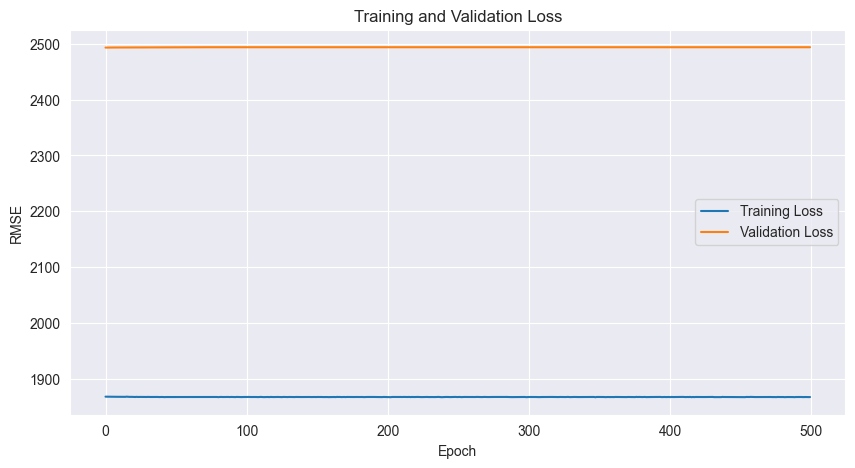

Final validation RMSE: 2493.2759
  Avg RMSE: 2032.0613 ± 417.6106
  New best model found!

Testing: hidden_size=32, layers=5, lr=0.0001
  Fold 1/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1467.8025, Val RMSE: 1828.9845



  6%|▌         | 29/500 [00:00<00:01, 289.89it/s]

Epoch 10: Train RMSE: 1467.8304, Val RMSE: 1828.9944
Epoch 20: Train RMSE: 1467.6743, Val RMSE: 1828.9932
Epoch 30: Train RMSE: 1467.6862, Val RMSE: 1828.9883
Epoch 40: Train RMSE: 1467.8661, Val RMSE: 1828.9867
Epoch 50: Train RMSE: 1467.6858, Val RMSE: 1828.9872



 12%|█▏        | 58/500 [00:00<00:01, 288.78it/s]

Epoch 60: Train RMSE: 1467.9393, Val RMSE: 1828.9879
Epoch 70: Train RMSE: 1467.6821, Val RMSE: 1828.9884



 27%|██▋       | 136/500 [00:00<00:01, 350.76it/s]

Epoch 80: Train RMSE: 1467.8589, Val RMSE: 1828.9885
Epoch 90: Train RMSE: 1467.7703, Val RMSE: 1828.9886
Epoch 100: Train RMSE: 1467.8160, Val RMSE: 1828.9888
Epoch 110: Train RMSE: 1467.6608, Val RMSE: 1828.9888
Epoch 120: Train RMSE: 1467.7258, Val RMSE: 1828.9888
Epoch 130: Train RMSE: 1467.7664, Val RMSE: 1828.9888
Epoch 140: Train RMSE: 1467.8124, Val RMSE: 1828.9888
Epoch 150: Train RMSE: 1467.6908, Val RMSE: 1828.9888



 43%|████▎     | 214/500 [00:00<00:00, 371.92it/s]

Epoch 160: Train RMSE: 1467.8657, Val RMSE: 1828.9888
Epoch 170: Train RMSE: 1467.8114, Val RMSE: 1828.9888
Epoch 180: Train RMSE: 1467.7485, Val RMSE: 1828.9888
Epoch 190: Train RMSE: 1467.7010, Val RMSE: 1828.9888
Epoch 200: Train RMSE: 1467.7932, Val RMSE: 1828.9888
Epoch 210: Train RMSE: 1467.8307, Val RMSE: 1828.9888
Epoch 220: Train RMSE: 1467.7596, Val RMSE: 1828.9888
Epoch 230: Train RMSE: 1467.8085, Val RMSE: 1828.9888



 58%|█████▊    | 291/500 [00:00<00:00, 373.37it/s]

Epoch 240: Train RMSE: 1467.7806, Val RMSE: 1828.9888
Epoch 250: Train RMSE: 1467.6360, Val RMSE: 1828.9888
Epoch 260: Train RMSE: 1467.7438, Val RMSE: 1828.9888
Epoch 270: Train RMSE: 1467.8950, Val RMSE: 1828.9888
Epoch 280: Train RMSE: 1467.8176, Val RMSE: 1828.9888
Epoch 290: Train RMSE: 1467.8075, Val RMSE: 1828.9888
Epoch 300: Train RMSE: 1467.6729, Val RMSE: 1828.9888
Epoch 310: Train RMSE: 1467.6965, Val RMSE: 1828.9888



 74%|███████▎  | 368/500 [00:01<00:00, 365.14it/s]

Epoch 320: Train RMSE: 1467.8684, Val RMSE: 1828.9888
Epoch 330: Train RMSE: 1467.6830, Val RMSE: 1828.9888
Epoch 340: Train RMSE: 1467.7822, Val RMSE: 1828.9888
Epoch 350: Train RMSE: 1467.7888, Val RMSE: 1828.9888
Epoch 360: Train RMSE: 1467.7407, Val RMSE: 1828.9888
Epoch 370: Train RMSE: 1467.7312, Val RMSE: 1828.9888
Epoch 380: Train RMSE: 1467.7782, Val RMSE: 1828.9888
Epoch 390: Train RMSE: 1467.7745, Val RMSE: 1828.9888



 89%|████████▉ | 446/500 [00:01<00:00, 359.77it/s]

Epoch 400: Train RMSE: 1467.6799, Val RMSE: 1828.9888
Epoch 410: Train RMSE: 1467.7902, Val RMSE: 1828.9888
Epoch 420: Train RMSE: 1467.7555, Val RMSE: 1828.9888
Epoch 430: Train RMSE: 1467.6207, Val RMSE: 1828.9888
Epoch 440: Train RMSE: 1467.6239, Val RMSE: 1828.9888
Epoch 450: Train RMSE: 1467.6177, Val RMSE: 1828.9888
Epoch 460: Train RMSE: 1467.7405, Val RMSE: 1828.9888
Epoch 470: Train RMSE: 1467.7126, Val RMSE: 1828.9888



100%|██████████| 500/500 [00:01<00:00, 358.87it/s]


Epoch 480: Train RMSE: 1467.7667, Val RMSE: 1828.9888
Epoch 490: Train RMSE: 1467.8700, Val RMSE: 1828.9888


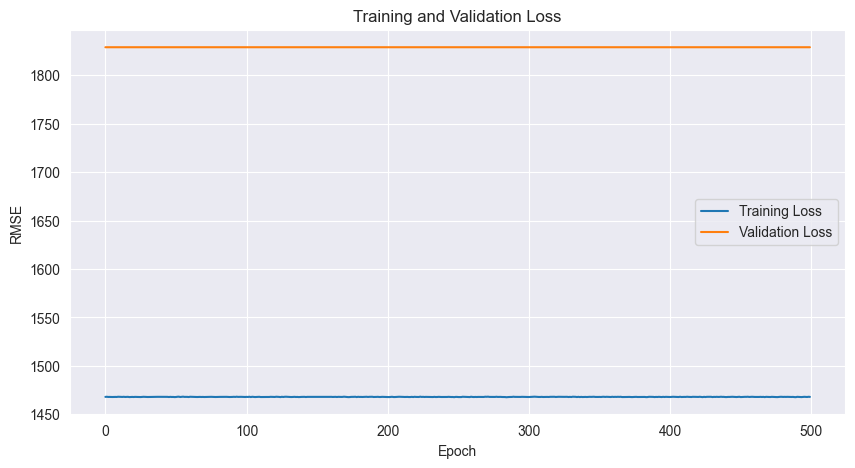

Final validation RMSE: 1828.9819
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.7313, Val RMSE: 1316.0046
Epoch 10: Train RMSE: 1656.7322, Val RMSE: 1316.0496



  5%|▍         | 23/500 [00:00<00:02, 227.52it/s]

Epoch 20: Train RMSE: 1656.7330, Val RMSE: 1316.0559
Epoch 30: Train RMSE: 1656.6874, Val RMSE: 1316.0574
Epoch 40: Train RMSE: 1656.7408, Val RMSE: 1316.0588



 10%|█         | 50/500 [00:00<00:01, 250.29it/s]

Epoch 50: Train RMSE: 1656.6858, Val RMSE: 1316.0591
Epoch 60: Train RMSE: 1656.7333, Val RMSE: 1316.0599
Epoch 70: Train RMSE: 1656.6805, Val RMSE: 1316.0605



 22%|██▏       | 111/500 [00:00<00:01, 287.01it/s]

Epoch 80: Train RMSE: 1656.7407, Val RMSE: 1316.0605
Epoch 90: Train RMSE: 1656.8080, Val RMSE: 1316.0608
Epoch 100: Train RMSE: 1656.7305, Val RMSE: 1316.0608
Epoch 110: Train RMSE: 1656.6108, Val RMSE: 1316.0608
Epoch 120: Train RMSE: 1656.7572, Val RMSE: 1316.0608
Epoch 130: Train RMSE: 1656.8484, Val RMSE: 1316.0608



 28%|██▊       | 142/500 [00:00<00:01, 294.48it/s]

Epoch 140: Train RMSE: 1656.6101, Val RMSE: 1316.0608



 35%|███▌      | 176/500 [00:00<00:01, 307.22it/s]

Epoch 150: Train RMSE: 1656.7758, Val RMSE: 1316.0608
Epoch 160: Train RMSE: 1656.6390, Val RMSE: 1316.0608
Epoch 170: Train RMSE: 1656.7317, Val RMSE: 1316.0608
Epoch 180: Train RMSE: 1656.6593, Val RMSE: 1316.0608
Epoch 190: Train RMSE: 1656.7078, Val RMSE: 1316.0608
Epoch 200: Train RMSE: 1656.6851, Val RMSE: 1316.0608



 41%|████▏     | 207/500 [00:00<00:00, 295.38it/s]

Epoch 210: Train RMSE: 1656.8634, Val RMSE: 1316.0608



 47%|████▋     | 237/500 [00:00<00:00, 288.19it/s]

Epoch 220: Train RMSE: 1656.5505, Val RMSE: 1316.0608
Epoch 230: Train RMSE: 1656.8230, Val RMSE: 1316.0608
Epoch 240: Train RMSE: 1656.6384, Val RMSE: 1316.0608



 54%|█████▍    | 269/500 [00:00<00:00, 297.10it/s]

Epoch 250: Train RMSE: 1656.7157, Val RMSE: 1316.0608
Epoch 260: Train RMSE: 1656.7181, Val RMSE: 1316.0608
Epoch 270: Train RMSE: 1656.6873, Val RMSE: 1316.0608
Epoch 280: Train RMSE: 1656.7914, Val RMSE: 1316.0608



 60%|██████    | 301/500 [00:01<00:00, 301.47it/s]

Epoch 290: Train RMSE: 1656.7014, Val RMSE: 1316.0608
Epoch 300: Train RMSE: 1656.5540, Val RMSE: 1316.0608
Epoch 310: Train RMSE: 1656.7316, Val RMSE: 1316.0608



 67%|██████▋   | 334/500 [00:01<00:00, 309.29it/s]

Epoch 320: Train RMSE: 1656.7791, Val RMSE: 1316.0608
Epoch 330: Train RMSE: 1656.7739, Val RMSE: 1316.0608
Epoch 340: Train RMSE: 1656.7549, Val RMSE: 1316.0608
Epoch 350: Train RMSE: 1656.7987, Val RMSE: 1316.0608



 74%|███████▎  | 368/500 [00:01<00:00, 317.03it/s]

Epoch 360: Train RMSE: 1656.8647, Val RMSE: 1316.0608
Epoch 370: Train RMSE: 1656.6233, Val RMSE: 1316.0608
Epoch 380: Train RMSE: 1656.6417, Val RMSE: 1316.0608
Epoch 390: Train RMSE: 1656.8051, Val RMSE: 1316.0608



 80%|████████  | 400/500 [00:01<00:00, 271.10it/s]

Epoch 400: Train RMSE: 1656.8774, Val RMSE: 1316.0608
Epoch 410: Train RMSE: 1656.7190, Val RMSE: 1316.0608
Epoch 420: Train RMSE: 1656.6554, Val RMSE: 1316.0608



 86%|████████▌ | 429/500 [00:01<00:00, 250.91it/s]

Epoch 430: Train RMSE: 1656.6456, Val RMSE: 1316.0608
Epoch 440: Train RMSE: 1656.6941, Val RMSE: 1316.0608
Epoch 450: Train RMSE: 1656.7225, Val RMSE: 1316.0608



 92%|█████████▏| 461/500 [00:01<00:00, 268.48it/s]

Epoch 460: Train RMSE: 1656.6255, Val RMSE: 1316.0608



 99%|█████████▉| 496/500 [00:01<00:00, 288.97it/s]

Epoch 470: Train RMSE: 1656.6696, Val RMSE: 1316.0608
Epoch 480: Train RMSE: 1656.6479, Val RMSE: 1316.0608
Epoch 490: Train RMSE: 1656.6476, Val RMSE: 1316.0608


100%|██████████| 500/500 [00:01<00:00, 285.74it/s]


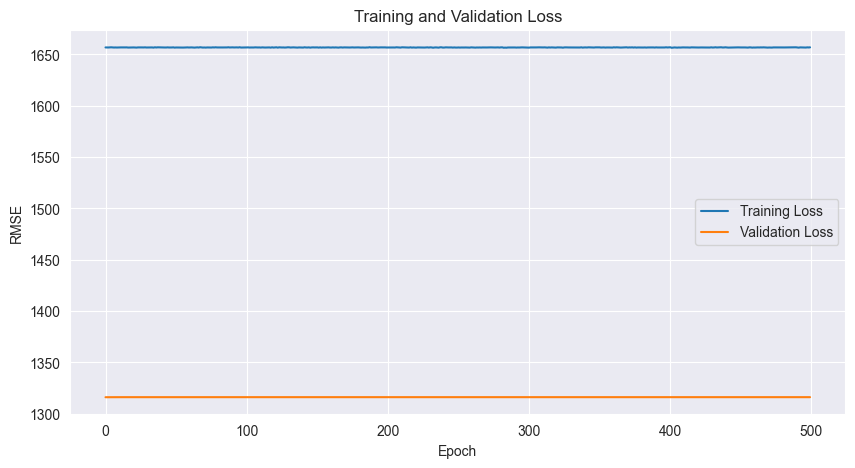

Final validation RMSE: 1316.0046
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1552.0291, Val RMSE: 2262.4302



  3%|▎         | 17/500 [00:00<00:02, 163.51it/s]

Epoch 10: Train RMSE: 1551.9608, Val RMSE: 2262.4304
Epoch 20: Train RMSE: 1551.9908, Val RMSE: 2262.3813
Epoch 30: Train RMSE: 1552.0095, Val RMSE: 2262.3782



  7%|▋         | 34/500 [00:00<00:02, 160.85it/s]

Epoch 40: Train RMSE: 1552.0226, Val RMSE: 2262.3828



 18%|█▊        | 92/500 [00:00<00:01, 241.73it/s]

Epoch 50: Train RMSE: 1551.9819, Val RMSE: 2262.3816
Epoch 60: Train RMSE: 1551.9954, Val RMSE: 2262.3918
Epoch 70: Train RMSE: 1552.0068, Val RMSE: 2262.3865
Epoch 80: Train RMSE: 1552.0343, Val RMSE: 2262.3860
Epoch 90: Train RMSE: 1552.0040, Val RMSE: 2262.3857
Epoch 100: Train RMSE: 1552.0387, Val RMSE: 2262.3855



 29%|██▉       | 146/500 [00:00<00:01, 246.30it/s]

Epoch 110: Train RMSE: 1552.0253, Val RMSE: 2262.3855
Epoch 120: Train RMSE: 1552.0806, Val RMSE: 2262.3855
Epoch 130: Train RMSE: 1552.0125, Val RMSE: 2262.3855
Epoch 140: Train RMSE: 1552.0255, Val RMSE: 2262.3855
Epoch 150: Train RMSE: 1551.9197, Val RMSE: 2262.3855
Epoch 160: Train RMSE: 1551.9175, Val RMSE: 2262.3855



 40%|████      | 202/500 [00:00<00:01, 261.50it/s]

Epoch 170: Train RMSE: 1551.9769, Val RMSE: 2262.3855
Epoch 180: Train RMSE: 1552.0546, Val RMSE: 2262.3855
Epoch 190: Train RMSE: 1551.9358, Val RMSE: 2262.3855
Epoch 200: Train RMSE: 1552.0343, Val RMSE: 2262.3855
Epoch 210: Train RMSE: 1551.9587, Val RMSE: 2262.3855
Epoch 220: Train RMSE: 1551.9895, Val RMSE: 2262.3855



 52%|█████▏    | 260/500 [00:01<00:00, 250.56it/s]

Epoch 230: Train RMSE: 1552.0826, Val RMSE: 2262.3855
Epoch 240: Train RMSE: 1551.9320, Val RMSE: 2262.3855
Epoch 250: Train RMSE: 1551.9822, Val RMSE: 2262.3855
Epoch 260: Train RMSE: 1551.9176, Val RMSE: 2262.3855
Epoch 270: Train RMSE: 1551.9677, Val RMSE: 2262.3855



 63%|██████▎   | 313/500 [00:01<00:00, 251.73it/s]

Epoch 280: Train RMSE: 1552.0522, Val RMSE: 2262.3855
Epoch 290: Train RMSE: 1552.0225, Val RMSE: 2262.3855
Epoch 300: Train RMSE: 1551.9618, Val RMSE: 2262.3855
Epoch 310: Train RMSE: 1551.9537, Val RMSE: 2262.3855
Epoch 320: Train RMSE: 1552.0089, Val RMSE: 2262.3855
Epoch 330: Train RMSE: 1552.0054, Val RMSE: 2262.3855



 74%|███████▍  | 371/500 [00:01<00:00, 267.49it/s]

Epoch 340: Train RMSE: 1551.9628, Val RMSE: 2262.3855
Epoch 350: Train RMSE: 1552.0750, Val RMSE: 2262.3855
Epoch 360: Train RMSE: 1552.0334, Val RMSE: 2262.3855
Epoch 370: Train RMSE: 1551.9144, Val RMSE: 2262.3855
Epoch 380: Train RMSE: 1551.9700, Val RMSE: 2262.3855
Epoch 390: Train RMSE: 1551.9700, Val RMSE: 2262.3855



 85%|████████▌ | 425/500 [00:01<00:00, 255.83it/s]

Epoch 400: Train RMSE: 1552.0067, Val RMSE: 2262.3855
Epoch 410: Train RMSE: 1552.0172, Val RMSE: 2262.3855
Epoch 420: Train RMSE: 1552.0931, Val RMSE: 2262.3855
Epoch 430: Train RMSE: 1551.9772, Val RMSE: 2262.3855
Epoch 440: Train RMSE: 1551.9951, Val RMSE: 2262.3855



 96%|█████████▋| 482/500 [00:01<00:00, 269.27it/s]

Epoch 450: Train RMSE: 1552.0101, Val RMSE: 2262.3855
Epoch 460: Train RMSE: 1552.0376, Val RMSE: 2262.3855
Epoch 470: Train RMSE: 1551.9672, Val RMSE: 2262.3855
Epoch 480: Train RMSE: 1552.0853, Val RMSE: 2262.3855


100%|██████████| 500/500 [00:01<00:00, 254.56it/s]

Epoch 490: Train RMSE: 1551.8842, Val RMSE: 2262.3855


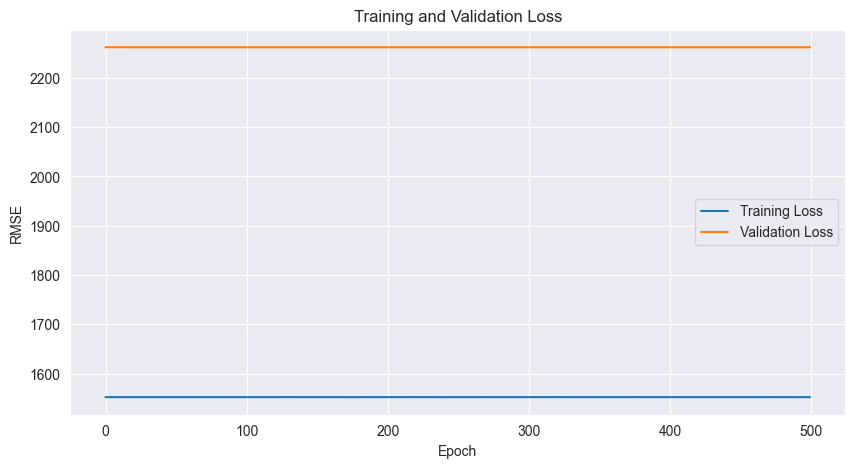

Final validation RMSE: 2262.3716
  Fold 4/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1755.9760, Val RMSE: 2261.7673
Epoch 10: Train RMSE: 1755.9583, Val RMSE: 2261.7600



  4%|▍         | 19/500 [00:00<00:02, 182.13it/s]

Epoch 20: Train RMSE: 1755.8567, Val RMSE: 2261.8091
Epoch 30: Train RMSE: 1755.9169, Val RMSE: 2261.8049
Epoch 40: Train RMSE: 1755.9440, Val RMSE: 2261.8057


 13%|█▎        | 65/500 [00:00<00:02, 215.95it/s]


Epoch 50: Train RMSE: 1755.9210, Val RMSE: 2261.8062
Epoch 60: Train RMSE: 1755.8409, Val RMSE: 2261.8035
Epoch 70: Train RMSE: 1755.8579, Val RMSE: 2261.8042
Epoch 80: Train RMSE: 1755.8350, Val RMSE: 2261.8042



 23%|██▎       | 115/500 [00:00<00:01, 234.31it/s]

Epoch 90: Train RMSE: 1755.9141, Val RMSE: 2261.8044
Epoch 100: Train RMSE: 1755.8937, Val RMSE: 2261.8047
Epoch 110: Train RMSE: 1755.9164, Val RMSE: 2261.8047
Epoch 120: Train RMSE: 1755.8398, Val RMSE: 2261.8044
Epoch 130: Train RMSE: 1755.8596, Val RMSE: 2261.8044



 33%|███▎      | 163/500 [00:00<00:01, 230.90it/s]

Epoch 140: Train RMSE: 1755.8171, Val RMSE: 2261.8044
Epoch 150: Train RMSE: 1755.8608, Val RMSE: 2261.8044
Epoch 160: Train RMSE: 1755.8624, Val RMSE: 2261.8044



 37%|███▋      | 187/500 [00:00<00:01, 230.44it/s]

Epoch 170: Train RMSE: 1755.9005, Val RMSE: 2261.8044
Epoch 180: Train RMSE: 1755.9135, Val RMSE: 2261.8044



 43%|████▎     | 214/500 [00:00<00:01, 240.95it/s]

Epoch 190: Train RMSE: 1755.8552, Val RMSE: 2261.8044
Epoch 200: Train RMSE: 1755.9287, Val RMSE: 2261.8044
Epoch 210: Train RMSE: 1755.9038, Val RMSE: 2261.8044
Epoch 220: Train RMSE: 1755.8290, Val RMSE: 2261.8044



 48%|████▊     | 239/500 [00:01<00:01, 243.10it/s]

Epoch 230: Train RMSE: 1755.8617, Val RMSE: 2261.8044
Epoch 240: Train RMSE: 1755.9485, Val RMSE: 2261.8044



 53%|█████▎    | 266/500 [00:01<00:00, 249.31it/s]

Epoch 250: Train RMSE: 1755.8411, Val RMSE: 2261.8044
Epoch 260: Train RMSE: 1755.8055, Val RMSE: 2261.8044
Epoch 270: Train RMSE: 1755.8402, Val RMSE: 2261.8044
Epoch 280: Train RMSE: 1755.8585, Val RMSE: 2261.8044



 58%|█████▊    | 291/500 [00:01<00:00, 249.14it/s]

Epoch 290: Train RMSE: 1755.8625, Val RMSE: 2261.8044



 63%|██████▎   | 316/500 [00:01<00:00, 240.72it/s]

Epoch 300: Train RMSE: 1755.8605, Val RMSE: 2261.8044
Epoch 310: Train RMSE: 1755.8783, Val RMSE: 2261.8044
Epoch 320: Train RMSE: 1755.8507, Val RMSE: 2261.8044
Epoch 330: Train RMSE: 1755.8099, Val RMSE: 2261.8044



 68%|██████▊   | 342/500 [00:01<00:00, 246.13it/s]

Epoch 340: Train RMSE: 1755.9330, Val RMSE: 2261.8044
Epoch 350: Train RMSE: 1755.9506, Val RMSE: 2261.8044



 74%|███████▎  | 368/500 [00:01<00:00, 248.68it/s]

Epoch 360: Train RMSE: 1755.8901, Val RMSE: 2261.8044
Epoch 370: Train RMSE: 1755.8931, Val RMSE: 2261.8044
Epoch 380: Train RMSE: 1755.8226, Val RMSE: 2261.8044
Epoch 390: Train RMSE: 1756.0105, Val RMSE: 2261.8044



 79%|███████▉  | 395/500 [00:01<00:00, 250.72it/s]

Epoch 400: Train RMSE: 1755.9261, Val RMSE: 2261.8044
Epoch 410: Train RMSE: 1755.7715, Val RMSE: 2261.8044



 84%|████████▍ | 421/500 [00:01<00:00, 249.89it/s]


Epoch 420: Train RMSE: 1755.8416, Val RMSE: 2261.8044
Epoch 430: Train RMSE: 1755.8824, Val RMSE: 2261.8044
Epoch 440: Train RMSE: 1755.8820, Val RMSE: 2261.8044


 89%|████████▉ | 447/500 [00:01<00:00, 238.89it/s]

Epoch 450: Train RMSE: 1755.9318, Val RMSE: 2261.8044
Epoch 460: Train RMSE: 1755.8544, Val RMSE: 2261.8044



100%|██████████| 500/500 [00:02<00:00, 239.21it/s]

Epoch 470: Train RMSE: 1755.9639, Val RMSE: 2261.8044
Epoch 480: Train RMSE: 1755.9275, Val RMSE: 2261.8044
Epoch 490: Train RMSE: 1755.9025, Val RMSE: 2261.8044


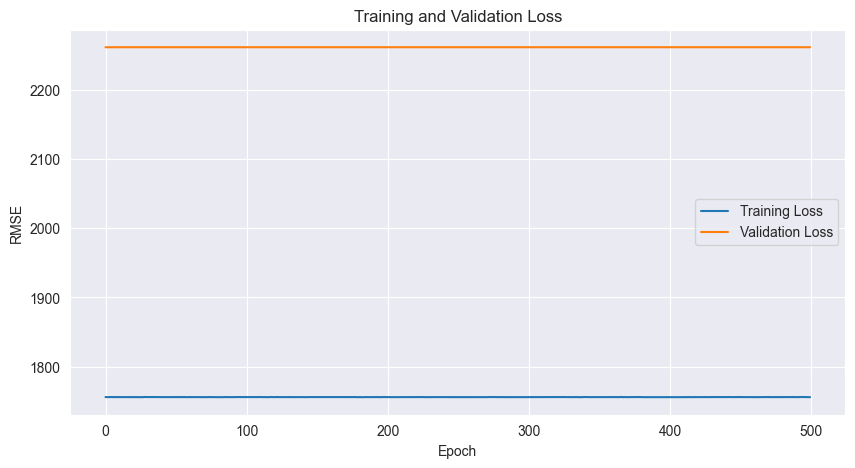

Final validation RMSE: 2261.7476
  Fold 5/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1867.5719, Val RMSE: 2493.3213



  4%|▎         | 18/500 [00:00<00:02, 175.35it/s]

Epoch 10: Train RMSE: 1867.5626, Val RMSE: 2493.3928
Epoch 20: Train RMSE: 1867.4963, Val RMSE: 2493.2056
Epoch 30: Train RMSE: 1867.5330, Val RMSE: 2493.1973



  7%|▋         | 36/500 [00:00<00:02, 158.44it/s]

Epoch 40: Train RMSE: 1867.5383, Val RMSE: 2493.2375



 16%|█▋        | 82/500 [00:00<00:02, 203.27it/s]

Epoch 50: Train RMSE: 1867.6359, Val RMSE: 2493.2378
Epoch 60: Train RMSE: 1867.6495, Val RMSE: 2493.2375
Epoch 70: Train RMSE: 1867.6282, Val RMSE: 2493.2375
Epoch 80: Train RMSE: 1867.4382, Val RMSE: 2493.2375
Epoch 90: Train RMSE: 1867.5240, Val RMSE: 2493.2375



 26%|██▌       | 129/500 [00:00<00:01, 216.50it/s]

Epoch 100: Train RMSE: 1867.5402, Val RMSE: 2493.2375
Epoch 110: Train RMSE: 1867.5022, Val RMSE: 2493.2375
Epoch 120: Train RMSE: 1867.4564, Val RMSE: 2493.2375



 35%|███▍      | 173/500 [00:00<00:01, 178.14it/s]

Epoch 130: Train RMSE: 1867.5680, Val RMSE: 2493.2375
Epoch 140: Train RMSE: 1867.5024, Val RMSE: 2493.2375
Epoch 150: Train RMSE: 1867.5293, Val RMSE: 2493.2375
Epoch 160: Train RMSE: 1867.6537, Val RMSE: 2493.2375
Epoch 170: Train RMSE: 1867.5536, Val RMSE: 2493.2375



 44%|████▍     | 219/500 [00:01<00:01, 199.51it/s]

Epoch 180: Train RMSE: 1867.5255, Val RMSE: 2493.2375
Epoch 190: Train RMSE: 1867.5024, Val RMSE: 2493.2375
Epoch 200: Train RMSE: 1867.5857, Val RMSE: 2493.2375
Epoch 210: Train RMSE: 1867.5846, Val RMSE: 2493.2375
Epoch 220: Train RMSE: 1867.6140, Val RMSE: 2493.2375



 53%|█████▎    | 264/500 [00:01<00:01, 204.27it/s]

Epoch 230: Train RMSE: 1867.4733, Val RMSE: 2493.2375
Epoch 240: Train RMSE: 1867.5664, Val RMSE: 2493.2375
Epoch 250: Train RMSE: 1867.5876, Val RMSE: 2493.2375
Epoch 260: Train RMSE: 1867.6206, Val RMSE: 2493.2375
Epoch 270: Train RMSE: 1867.6010, Val RMSE: 2493.2375



 62%|██████▏   | 308/500 [00:01<00:00, 211.23it/s]

Epoch 280: Train RMSE: 1867.4993, Val RMSE: 2493.2375
Epoch 290: Train RMSE: 1867.4707, Val RMSE: 2493.2375
Epoch 300: Train RMSE: 1867.5842, Val RMSE: 2493.2375
Epoch 310: Train RMSE: 1867.5710, Val RMSE: 2493.2375
Epoch 320: Train RMSE: 1867.6310, Val RMSE: 2493.2375



 71%|███████   | 353/500 [00:01<00:00, 214.46it/s]

Epoch 330: Train RMSE: 1867.5887, Val RMSE: 2493.2375
Epoch 340: Train RMSE: 1867.4811, Val RMSE: 2493.2375
Epoch 350: Train RMSE: 1867.5016, Val RMSE: 2493.2375
Epoch 360: Train RMSE: 1867.5721, Val RMSE: 2493.2375
Epoch 370: Train RMSE: 1867.5901, Val RMSE: 2493.2375



 83%|████████▎ | 417/500 [00:02<00:00, 192.16it/s]

Epoch 380: Train RMSE: 1867.5597, Val RMSE: 2493.2375
Epoch 390: Train RMSE: 1867.5275, Val RMSE: 2493.2375
Epoch 400: Train RMSE: 1867.6671, Val RMSE: 2493.2375
Epoch 410: Train RMSE: 1867.5563, Val RMSE: 2493.2375



 91%|█████████ | 456/500 [00:02<00:00, 185.09it/s]

Epoch 420: Train RMSE: 1867.5015, Val RMSE: 2493.2375
Epoch 430: Train RMSE: 1867.6200, Val RMSE: 2493.2375
Epoch 440: Train RMSE: 1867.6960, Val RMSE: 2493.2375
Epoch 450: Train RMSE: 1867.5922, Val RMSE: 2493.2375



 99%|█████████▉| 494/500 [00:02<00:00, 179.73it/s]

Epoch 460: Train RMSE: 1867.5238, Val RMSE: 2493.2375
Epoch 470: Train RMSE: 1867.5150, Val RMSE: 2493.2375
Epoch 480: Train RMSE: 1867.5607, Val RMSE: 2493.2375
Epoch 490: Train RMSE: 1867.6151, Val RMSE: 2493.2375


100%|██████████| 500/500 [00:02<00:00, 193.59it/s]


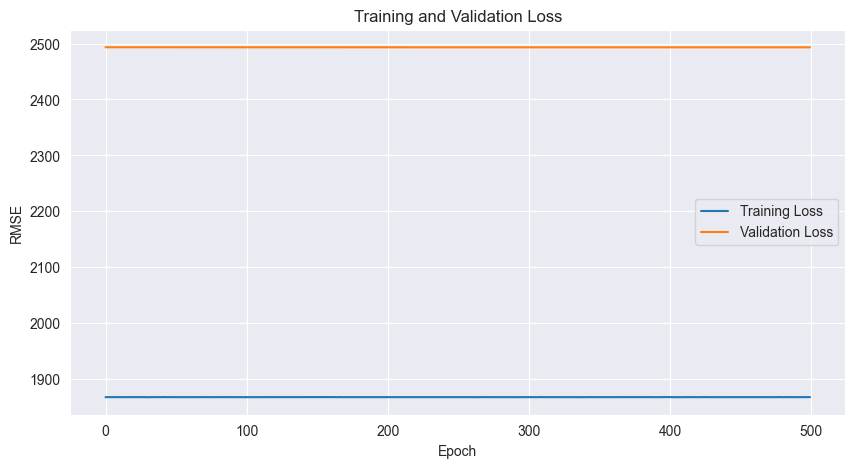

Final validation RMSE: 2493.1897
  Avg RMSE: 2032.4591 ± 417.7118

Testing: hidden_size=32, layers=5, lr=0.001
  Fold 1/5
Input size: 437



  7%|▋         | 33/500 [00:00<00:01, 323.37it/s]

Epoch 0: Train RMSE: 1467.7427, Val RMSE: 1828.9580
Epoch 10: Train RMSE: 1467.9904, Val RMSE: 1829.0018
Epoch 20: Train RMSE: 1467.5702, Val RMSE: 1829.0062
Epoch 30: Train RMSE: 1467.7168, Val RMSE: 1829.0094
Epoch 40: Train RMSE: 1467.7765, Val RMSE: 1829.0101
Epoch 50: Train RMSE: 1467.6661, Val RMSE: 1829.0101
Epoch 60: Train RMSE: 1467.7733, Val RMSE: 1829.0114



 26%|██▌       | 131/500 [00:00<00:01, 311.53it/s]

Epoch 70: Train RMSE: 1468.0637, Val RMSE: 1829.0179
Epoch 80: Train RMSE: 1467.8975, Val RMSE: 1829.0165
Epoch 90: Train RMSE: 1467.7673, Val RMSE: 1829.0172
Epoch 100: Train RMSE: 1467.7522, Val RMSE: 1829.0156
Epoch 110: Train RMSE: 1467.6030, Val RMSE: 1829.0138
Epoch 120: Train RMSE: 1467.7484, Val RMSE: 1829.0138
Epoch 130: Train RMSE: 1467.5669, Val RMSE: 1829.0138



 39%|███▉      | 196/500 [00:00<00:01, 298.20it/s]

Epoch 140: Train RMSE: 1467.6696, Val RMSE: 1829.0138
Epoch 150: Train RMSE: 1467.8171, Val RMSE: 1829.0138
Epoch 160: Train RMSE: 1467.7964, Val RMSE: 1829.0138
Epoch 170: Train RMSE: 1467.7375, Val RMSE: 1829.0138
Epoch 180: Train RMSE: 1467.8622, Val RMSE: 1829.0138
Epoch 190: Train RMSE: 1467.8276, Val RMSE: 1829.0138



 54%|█████▎    | 268/500 [00:00<00:00, 323.52it/s]

Epoch 200: Train RMSE: 1467.7904, Val RMSE: 1829.0138
Epoch 210: Train RMSE: 1467.9232, Val RMSE: 1829.0138
Epoch 220: Train RMSE: 1467.6470, Val RMSE: 1829.0138
Epoch 230: Train RMSE: 1467.7706, Val RMSE: 1829.0138
Epoch 240: Train RMSE: 1467.8691, Val RMSE: 1829.0138
Epoch 250: Train RMSE: 1467.6764, Val RMSE: 1829.0138
Epoch 260: Train RMSE: 1467.8497, Val RMSE: 1829.0138
Epoch 270: Train RMSE: 1467.6157, Val RMSE: 1829.0138



 69%|██████▉   | 346/500 [00:01<00:00, 356.48it/s]

Epoch 280: Train RMSE: 1467.6462, Val RMSE: 1829.0138
Epoch 290: Train RMSE: 1467.6562, Val RMSE: 1829.0138
Epoch 300: Train RMSE: 1467.8859, Val RMSE: 1829.0138
Epoch 310: Train RMSE: 1467.7159, Val RMSE: 1829.0138
Epoch 320: Train RMSE: 1467.8433, Val RMSE: 1829.0138
Epoch 330: Train RMSE: 1467.7621, Val RMSE: 1829.0137
Epoch 340: Train RMSE: 1467.8141, Val RMSE: 1829.0138
Epoch 350: Train RMSE: 1467.8927, Val RMSE: 1829.0138



 85%|████████▌ | 427/500 [00:01<00:00, 379.83it/s]

Epoch 360: Train RMSE: 1468.0048, Val RMSE: 1829.0138
Epoch 370: Train RMSE: 1467.8243, Val RMSE: 1829.0137
Epoch 380: Train RMSE: 1467.7235, Val RMSE: 1829.0137
Epoch 390: Train RMSE: 1467.5380, Val RMSE: 1829.0137
Epoch 400: Train RMSE: 1467.8405, Val RMSE: 1829.0137
Epoch 410: Train RMSE: 1467.6342, Val RMSE: 1829.0137
Epoch 420: Train RMSE: 1467.8723, Val RMSE: 1829.0137
Epoch 430: Train RMSE: 1467.8643, Val RMSE: 1829.0137
Epoch 440: Train RMSE: 1467.7898, Val RMSE: 1829.0137



100%|██████████| 500/500 [00:01<00:00, 339.60it/s]

Epoch 450: Train RMSE: 1467.5378, Val RMSE: 1829.0137
Epoch 460: Train RMSE: 1467.8165, Val RMSE: 1829.0137
Epoch 470: Train RMSE: 1468.1818, Val RMSE: 1829.0137
Epoch 480: Train RMSE: 1467.8188, Val RMSE: 1829.0137
Epoch 490: Train RMSE: 1467.8646, Val RMSE: 1829.0137


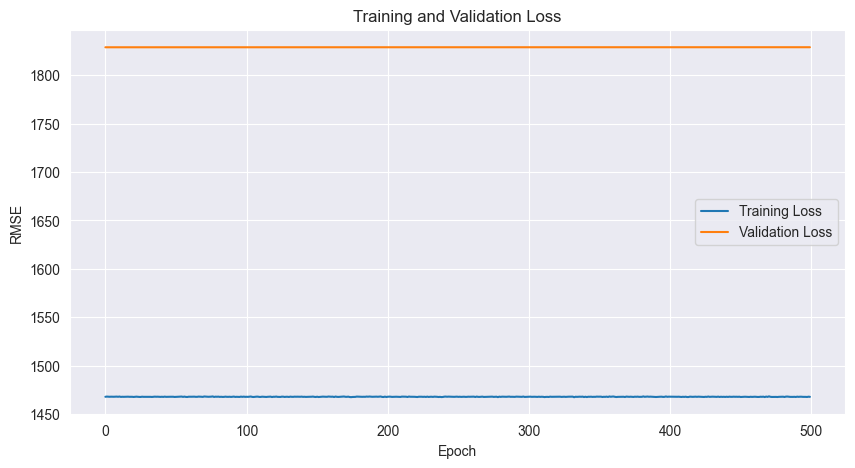

Final validation RMSE: 1828.9580
  Fold 2/5
Input size: 437



  4%|▍         | 22/500 [00:00<00:02, 215.05it/s]

Epoch 0: Train RMSE: 1656.7625, Val RMSE: 1315.4858
Epoch 10: Train RMSE: 1656.7273, Val RMSE: 1315.6656
Epoch 20: Train RMSE: 1656.6687, Val RMSE: 1315.6744
Epoch 30: Train RMSE: 1656.7660, Val RMSE: 1315.6848
Epoch 40: Train RMSE: 1656.6882, Val RMSE: 1315.6798



 20%|█▉        | 99/500 [00:00<00:01, 244.39it/s]

Epoch 50: Train RMSE: 1656.7313, Val RMSE: 1315.6844
Epoch 60: Train RMSE: 1656.7296, Val RMSE: 1315.6870
Epoch 70: Train RMSE: 1656.7870, Val RMSE: 1315.6859
Epoch 80: Train RMSE: 1656.7540, Val RMSE: 1315.6859
Epoch 90: Train RMSE: 1656.6995, Val RMSE: 1315.6858
Epoch 100: Train RMSE: 1656.7406, Val RMSE: 1315.6857



 32%|███▏      | 160/500 [00:00<00:01, 280.12it/s]

Epoch 110: Train RMSE: 1656.6665, Val RMSE: 1315.6858
Epoch 120: Train RMSE: 1656.7561, Val RMSE: 1315.6858
Epoch 130: Train RMSE: 1656.5997, Val RMSE: 1315.6858
Epoch 140: Train RMSE: 1656.7313, Val RMSE: 1315.6858
Epoch 150: Train RMSE: 1656.7463, Val RMSE: 1315.6858
Epoch 160: Train RMSE: 1656.6876, Val RMSE: 1315.6858
Epoch 170: Train RMSE: 1656.7550, Val RMSE: 1315.6858



 45%|████▌     | 226/500 [00:00<00:00, 304.07it/s]

Epoch 180: Train RMSE: 1656.7878, Val RMSE: 1315.6858
Epoch 190: Train RMSE: 1656.7090, Val RMSE: 1315.6858
Epoch 200: Train RMSE: 1656.6305, Val RMSE: 1315.6858
Epoch 210: Train RMSE: 1656.7010, Val RMSE: 1315.6858
Epoch 220: Train RMSE: 1656.6700, Val RMSE: 1315.6858
Epoch 230: Train RMSE: 1656.7490, Val RMSE: 1315.6858
Epoch 240: Train RMSE: 1656.6854, Val RMSE: 1315.6858



 58%|█████▊    | 290/500 [00:01<00:00, 302.50it/s]

Epoch 250: Train RMSE: 1656.6616, Val RMSE: 1315.6858
Epoch 260: Train RMSE: 1656.6749, Val RMSE: 1315.6858
Epoch 270: Train RMSE: 1656.6198, Val RMSE: 1315.6858
Epoch 280: Train RMSE: 1656.7720, Val RMSE: 1315.6858
Epoch 290: Train RMSE: 1656.7673, Val RMSE: 1315.6858
Epoch 300: Train RMSE: 1656.7574, Val RMSE: 1315.6858
Epoch 310: Train RMSE: 1656.7078, Val RMSE: 1315.6858



 71%|███████   | 353/500 [00:01<00:00, 299.22it/s]

Epoch 320: Train RMSE: 1656.6799, Val RMSE: 1315.6858
Epoch 330: Train RMSE: 1656.6742, Val RMSE: 1315.6858
Epoch 340: Train RMSE: 1656.7640, Val RMSE: 1315.6858
Epoch 350: Train RMSE: 1656.6598, Val RMSE: 1315.6858
Epoch 360: Train RMSE: 1656.7158, Val RMSE: 1315.6858
Epoch 370: Train RMSE: 1656.8278, Val RMSE: 1315.6858



 83%|████████▎ | 413/500 [00:01<00:00, 288.05it/s]

Epoch 380: Train RMSE: 1656.6930, Val RMSE: 1315.6858
Epoch 390: Train RMSE: 1656.7495, Val RMSE: 1315.6858
Epoch 400: Train RMSE: 1656.6151, Val RMSE: 1315.6858
Epoch 410: Train RMSE: 1656.7296, Val RMSE: 1315.6858
Epoch 420: Train RMSE: 1656.8710, Val RMSE: 1315.6858
Epoch 430: Train RMSE: 1656.8752, Val RMSE: 1315.6858
Epoch 440: Train RMSE: 1656.7098, Val RMSE: 1315.6858



100%|██████████| 500/500 [00:01<00:00, 290.38it/s]


Epoch 450: Train RMSE: 1656.6897, Val RMSE: 1315.6858
Epoch 460: Train RMSE: 1656.7206, Val RMSE: 1315.6858
Epoch 470: Train RMSE: 1656.6013, Val RMSE: 1315.6858
Epoch 480: Train RMSE: 1656.6493, Val RMSE: 1315.6858
Epoch 490: Train RMSE: 1656.7186, Val RMSE: 1315.6858


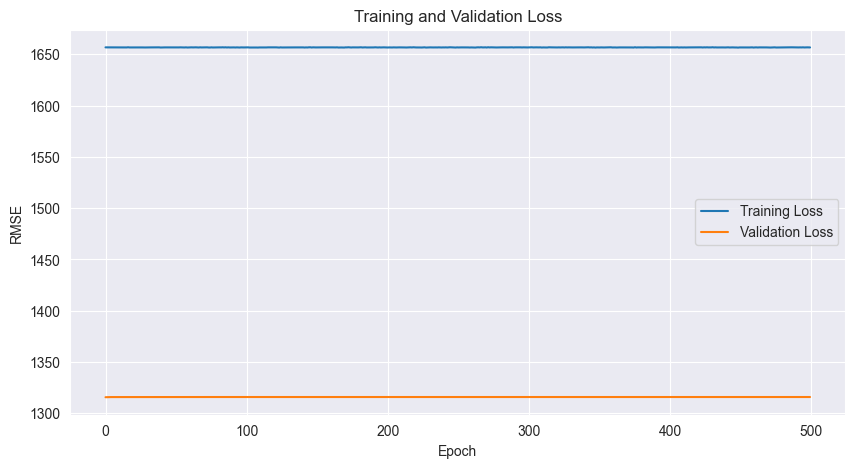

Final validation RMSE: 1315.4858
  Fold 3/5
Input size: 437



  4%|▍         | 22/500 [00:00<00:02, 213.81it/s]

Epoch 0: Train RMSE: 1551.9047, Val RMSE: 2261.9866
Epoch 10: Train RMSE: 1551.8694, Val RMSE: 2262.0696
Epoch 20: Train RMSE: 1552.0078, Val RMSE: 2262.0576
Epoch 30: Train RMSE: 1551.9509, Val RMSE: 2261.9385



 13%|█▎        | 64/500 [00:00<00:02, 174.39it/s]

Epoch 40: Train RMSE: 1551.9293, Val RMSE: 2261.9038
Epoch 50: Train RMSE: 1551.9635, Val RMSE: 2261.8970
Epoch 60: Train RMSE: 1552.0807, Val RMSE: 2261.8928
Epoch 70: Train RMSE: 1551.9689, Val RMSE: 2261.8889



 22%|██▏       | 109/500 [00:00<00:01, 203.74it/s]

Epoch 80: Train RMSE: 1552.0396, Val RMSE: 2261.8879
Epoch 90: Train RMSE: 1551.8053, Val RMSE: 2261.8875
Epoch 100: Train RMSE: 1551.9495, Val RMSE: 2261.8872
Epoch 110: Train RMSE: 1551.8645, Val RMSE: 2261.8870
Epoch 120: Train RMSE: 1552.0154, Val RMSE: 2261.8870
Epoch 130: Train RMSE: 1551.8856, Val RMSE: 2261.8870



 38%|███▊      | 190/500 [00:00<00:01, 242.79it/s]

Epoch 140: Train RMSE: 1552.0546, Val RMSE: 2261.8870
Epoch 150: Train RMSE: 1551.9308, Val RMSE: 2261.8870
Epoch 160: Train RMSE: 1552.0187, Val RMSE: 2261.8870
Epoch 170: Train RMSE: 1552.0343, Val RMSE: 2261.8870
Epoch 180: Train RMSE: 1552.0314, Val RMSE: 2261.8870
Epoch 190: Train RMSE: 1552.0106, Val RMSE: 2261.8870



 44%|████▍     | 220/500 [00:00<00:01, 258.68it/s]

Epoch 200: Train RMSE: 1552.0094, Val RMSE: 2261.8870
Epoch 210: Train RMSE: 1551.9432, Val RMSE: 2261.8870
Epoch 220: Train RMSE: 1551.8593, Val RMSE: 2261.8870
Epoch 230: Train RMSE: 1552.0145, Val RMSE: 2261.8870
Epoch 240: Train RMSE: 1552.0126, Val RMSE: 2261.8870



 54%|█████▍    | 271/500 [00:01<00:01, 212.66it/s]

Epoch 250: Train RMSE: 1551.9310, Val RMSE: 2261.8870
Epoch 260: Train RMSE: 1552.0049, Val RMSE: 2261.8867
Epoch 270: Train RMSE: 1551.8971, Val RMSE: 2261.8867
Epoch 280: Train RMSE: 1552.0190, Val RMSE: 2261.8867
Epoch 290: Train RMSE: 1552.0011, Val RMSE: 2261.8867



 71%|███████   | 355/500 [00:01<00:00, 256.04it/s]

Epoch 300: Train RMSE: 1551.9457, Val RMSE: 2261.8867
Epoch 310: Train RMSE: 1551.8348, Val RMSE: 2261.8867
Epoch 320: Train RMSE: 1552.0590, Val RMSE: 2261.8867
Epoch 330: Train RMSE: 1551.9039, Val RMSE: 2261.8867
Epoch 340: Train RMSE: 1551.9833, Val RMSE: 2261.8867
Epoch 350: Train RMSE: 1551.9723, Val RMSE: 2261.8867



 82%|████████▏ | 411/500 [00:01<00:00, 261.09it/s]

Epoch 360: Train RMSE: 1552.0402, Val RMSE: 2261.8867
Epoch 370: Train RMSE: 1551.9160, Val RMSE: 2261.8870
Epoch 380: Train RMSE: 1552.0635, Val RMSE: 2261.8870
Epoch 390: Train RMSE: 1552.0331, Val RMSE: 2261.8870
Epoch 400: Train RMSE: 1551.7981, Val RMSE: 2261.8870
Epoch 410: Train RMSE: 1552.0834, Val RMSE: 2261.8870



 88%|████████▊ | 438/500 [00:01<00:00, 255.15it/s]

Epoch 420: Train RMSE: 1551.9309, Val RMSE: 2261.8870
Epoch 430: Train RMSE: 1551.9572, Val RMSE: 2261.8870
Epoch 440: Train RMSE: 1551.9250, Val RMSE: 2261.8870



100%|██████████| 500/500 [00:02<00:00, 228.43it/s]

Epoch 450: Train RMSE: 1551.9073, Val RMSE: 2261.8870
Epoch 460: Train RMSE: 1552.0098, Val RMSE: 2261.8870
Epoch 470: Train RMSE: 1552.0664, Val RMSE: 2261.8870
Epoch 480: Train RMSE: 1551.8591, Val RMSE: 2261.8870
Epoch 490: Train RMSE: 1551.9200, Val RMSE: 2261.8870


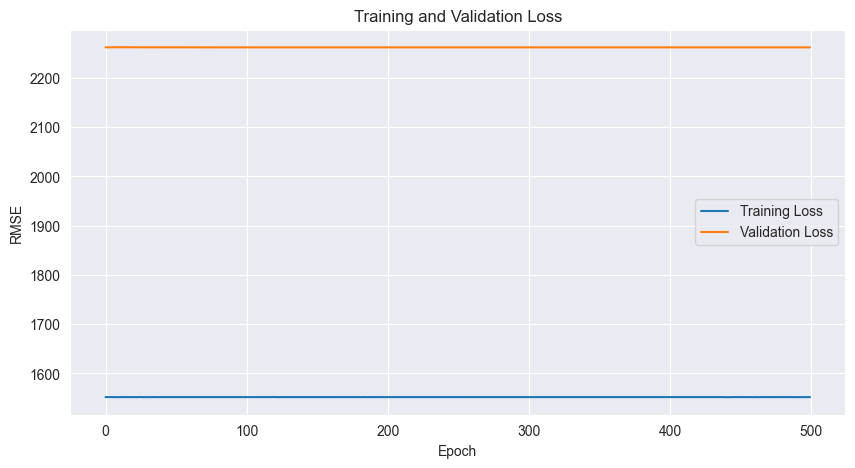

Final validation RMSE: 2261.8867
  Fold 4/5
Input size: 437



  4%|▍         | 20/500 [00:00<00:02, 191.03it/s]

Epoch 0: Train RMSE: 1756.0374, Val RMSE: 2261.7888
Epoch 10: Train RMSE: 1755.8993, Val RMSE: 2261.8049
Epoch 20: Train RMSE: 1755.8645, Val RMSE: 2261.8108
Epoch 30: Train RMSE: 1755.7888, Val RMSE: 2261.8223



  9%|▊         | 43/500 [00:00<00:02, 213.00it/s]

Epoch 40: Train RMSE: 1755.7104, Val RMSE: 2261.8320



 13%|█▎        | 66/500 [00:00<00:01, 218.65it/s]

Epoch 50: Train RMSE: 1755.7815, Val RMSE: 2261.8420
Epoch 60: Train RMSE: 1755.7438, Val RMSE: 2261.8447
Epoch 70: Train RMSE: 1755.7400, Val RMSE: 2261.8457
Epoch 80: Train RMSE: 1755.8171, Val RMSE: 2261.8464



 18%|█▊        | 89/500 [00:00<00:01, 223.06it/s]

Epoch 90: Train RMSE: 1755.7948, Val RMSE: 2261.8469



 27%|██▋       | 136/500 [00:00<00:01, 225.58it/s]

Epoch 100: Train RMSE: 1755.7975, Val RMSE: 2261.8469
Epoch 110: Train RMSE: 1755.7538, Val RMSE: 2261.8469
Epoch 120: Train RMSE: 1755.8385, Val RMSE: 2261.8469
Epoch 130: Train RMSE: 1755.8098, Val RMSE: 2261.8469
Epoch 140: Train RMSE: 1755.8063, Val RMSE: 2261.8469



 37%|███▋      | 187/500 [00:00<00:01, 240.02it/s]

Epoch 150: Train RMSE: 1755.7518, Val RMSE: 2261.8469
Epoch 160: Train RMSE: 1755.7878, Val RMSE: 2261.8469
Epoch 170: Train RMSE: 1755.7559, Val RMSE: 2261.8469
Epoch 180: Train RMSE: 1755.7610, Val RMSE: 2261.8469
Epoch 190: Train RMSE: 1755.7640, Val RMSE: 2261.8469
Epoch 200: Train RMSE: 1755.7864, Val RMSE: 2261.8469



 48%|████▊     | 238/500 [00:01<00:01, 244.88it/s]

Epoch 210: Train RMSE: 1755.7827, Val RMSE: 2261.8469
Epoch 220: Train RMSE: 1755.7821, Val RMSE: 2261.8469
Epoch 230: Train RMSE: 1755.7571, Val RMSE: 2261.8469
Epoch 240: Train RMSE: 1755.7538, Val RMSE: 2261.8469
Epoch 250: Train RMSE: 1755.7887, Val RMSE: 2261.8469
Epoch 260: Train RMSE: 1755.8180, Val RMSE: 2261.8469



 58%|█████▊    | 289/500 [00:01<00:00, 236.67it/s]

Epoch 270: Train RMSE: 1755.7584, Val RMSE: 2261.8469
Epoch 280: Train RMSE: 1755.7931, Val RMSE: 2261.8469
Epoch 290: Train RMSE: 1755.8029, Val RMSE: 2261.8469
Epoch 300: Train RMSE: 1755.7522, Val RMSE: 2261.8469



 63%|██████▎   | 313/500 [00:01<00:00, 228.68it/s]

Epoch 310: Train RMSE: 1755.7334, Val RMSE: 2261.8469



 67%|██████▋   | 336/500 [00:01<00:00, 228.94it/s]

Epoch 320: Train RMSE: 1755.7738, Val RMSE: 2261.8469
Epoch 330: Train RMSE: 1755.7953, Val RMSE: 2261.8469
Epoch 340: Train RMSE: 1755.7853, Val RMSE: 2261.8469
Epoch 350: Train RMSE: 1755.7762, Val RMSE: 2261.8469



 72%|███████▏  | 359/500 [00:01<00:00, 223.79it/s]

Epoch 360: Train RMSE: 1755.7909, Val RMSE: 2261.8469



 76%|███████▋  | 382/500 [00:01<00:00, 221.28it/s]

Epoch 370: Train RMSE: 1755.7731, Val RMSE: 2261.8469
Epoch 380: Train RMSE: 1755.7716, Val RMSE: 2261.8469
Epoch 390: Train RMSE: 1755.7753, Val RMSE: 2261.8469
Epoch 400: Train RMSE: 1755.8075, Val RMSE: 2261.8469



 81%|████████  | 405/500 [00:01<00:00, 214.21it/s]

Epoch 410: Train RMSE: 1755.7717, Val RMSE: 2261.8469



 90%|████████▉ | 449/500 [00:01<00:00, 213.97it/s]

Epoch 420: Train RMSE: 1755.7839, Val RMSE: 2261.8469
Epoch 430: Train RMSE: 1755.7277, Val RMSE: 2261.8469
Epoch 440: Train RMSE: 1755.7872, Val RMSE: 2261.8469
Epoch 450: Train RMSE: 1755.7593, Val RMSE: 2261.8469
Epoch 460: Train RMSE: 1755.7964, Val RMSE: 2261.8469



100%|██████████| 500/500 [00:02<00:00, 226.02it/s]

Epoch 470: Train RMSE: 1755.7007, Val RMSE: 2261.8469
Epoch 480: Train RMSE: 1755.7611, Val RMSE: 2261.8469
Epoch 490: Train RMSE: 1755.8074, Val RMSE: 2261.8469


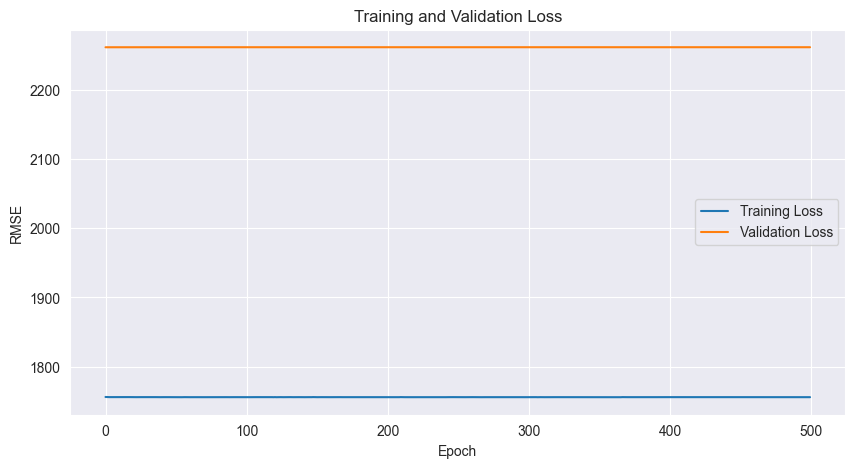

Final validation RMSE: 2261.7888
  Fold 5/5
Input size: 437



  4%|▎         | 18/500 [00:00<00:02, 177.58it/s]

Epoch 0: Train RMSE: 1867.6886, Val RMSE: 2493.2249
Epoch 10: Train RMSE: 1867.6371, Val RMSE: 2493.3174
Epoch 20: Train RMSE: 1867.6168, Val RMSE: 2493.3232
Epoch 30: Train RMSE: 1867.6167, Val RMSE: 2493.3296



 14%|█▍        | 72/500 [00:00<00:02, 168.22it/s]

Epoch 40: Train RMSE: 1867.6791, Val RMSE: 2493.3342
Epoch 50: Train RMSE: 1867.6027, Val RMSE: 2493.3369
Epoch 60: Train RMSE: 1867.6506, Val RMSE: 2493.3384
Epoch 70: Train RMSE: 1867.6069, Val RMSE: 2493.3391



 21%|██        | 106/500 [00:00<00:02, 166.55it/s]

Epoch 80: Train RMSE: 1867.5746, Val RMSE: 2493.3398
Epoch 90: Train RMSE: 1867.6492, Val RMSE: 2493.3401
Epoch 100: Train RMSE: 1867.6508, Val RMSE: 2493.3401
Epoch 110: Train RMSE: 1867.5814, Val RMSE: 2493.3403



 29%|██▉       | 145/500 [00:00<00:02, 177.25it/s]

Epoch 120: Train RMSE: 1867.7200, Val RMSE: 2493.3403
Epoch 130: Train RMSE: 1867.6110, Val RMSE: 2493.3403
Epoch 140: Train RMSE: 1867.5511, Val RMSE: 2493.3403
Epoch 150: Train RMSE: 1867.6547, Val RMSE: 2493.3403



 37%|███▋      | 184/500 [00:01<00:01, 180.60it/s]

Epoch 160: Train RMSE: 1867.5831, Val RMSE: 2493.3403
Epoch 170: Train RMSE: 1867.6381, Val RMSE: 2493.3403
Epoch 180: Train RMSE: 1867.5532, Val RMSE: 2493.3403
Epoch 190: Train RMSE: 1867.5864, Val RMSE: 2493.3403



 44%|████▍     | 222/500 [00:01<00:01, 179.76it/s]

Epoch 200: Train RMSE: 1867.6599, Val RMSE: 2493.3403
Epoch 210: Train RMSE: 1867.6855, Val RMSE: 2493.3403
Epoch 220: Train RMSE: 1867.6635, Val RMSE: 2493.3403
Epoch 230: Train RMSE: 1867.7057, Val RMSE: 2493.3403



 52%|█████▏    | 261/500 [00:01<00:01, 183.89it/s]

Epoch 240: Train RMSE: 1867.6185, Val RMSE: 2493.3403
Epoch 250: Train RMSE: 1867.6210, Val RMSE: 2493.3403
Epoch 260: Train RMSE: 1867.5574, Val RMSE: 2493.3403
Epoch 270: Train RMSE: 1867.6727, Val RMSE: 2493.3403



 60%|██████    | 300/500 [00:01<00:01, 183.84it/s]

Epoch 280: Train RMSE: 1867.5990, Val RMSE: 2493.3403
Epoch 290: Train RMSE: 1867.6465, Val RMSE: 2493.3403
Epoch 300: Train RMSE: 1867.6128, Val RMSE: 2493.3403
Epoch 310: Train RMSE: 1867.6755, Val RMSE: 2493.3403



 72%|███████▏  | 361/500 [00:01<00:00, 194.66it/s]

Epoch 320: Train RMSE: 1867.6436, Val RMSE: 2493.3403
Epoch 330: Train RMSE: 1867.6912, Val RMSE: 2493.3403
Epoch 340: Train RMSE: 1867.6373, Val RMSE: 2493.3403
Epoch 350: Train RMSE: 1867.6046, Val RMSE: 2493.3403
Epoch 360: Train RMSE: 1867.6444, Val RMSE: 2493.3403



 80%|████████  | 401/500 [00:02<00:00, 189.75it/s]

Epoch 370: Train RMSE: 1867.6119, Val RMSE: 2493.3403
Epoch 380: Train RMSE: 1867.7010, Val RMSE: 2493.3403
Epoch 390: Train RMSE: 1867.6459, Val RMSE: 2493.3403
Epoch 400: Train RMSE: 1867.6411, Val RMSE: 2493.3403



 88%|████████▊ | 442/500 [00:02<00:00, 194.95it/s]

Epoch 410: Train RMSE: 1867.6134, Val RMSE: 2493.3403
Epoch 420: Train RMSE: 1867.6646, Val RMSE: 2493.3403
Epoch 430: Train RMSE: 1867.7235, Val RMSE: 2493.3403
Epoch 440: Train RMSE: 1867.7220, Val RMSE: 2493.3403
Epoch 450: Train RMSE: 1867.7314, Val RMSE: 2493.3403



 97%|█████████▋| 483/500 [00:02<00:00, 195.50it/s]

Epoch 460: Train RMSE: 1867.5029, Val RMSE: 2493.3403
Epoch 470: Train RMSE: 1867.6196, Val RMSE: 2493.3403
Epoch 480: Train RMSE: 1867.5928, Val RMSE: 2493.3403
Epoch 490: Train RMSE: 1867.6765, Val RMSE: 2493.3403


100%|██████████| 500/500 [00:02<00:00, 184.48it/s]


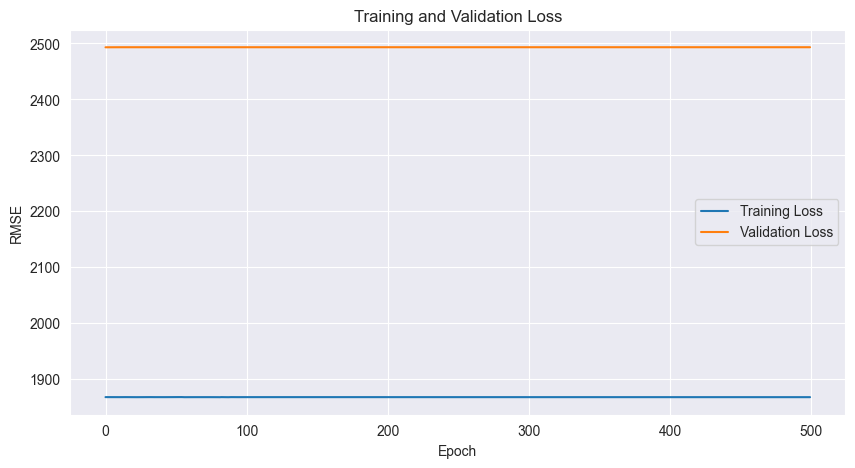

Final validation RMSE: 2493.2156
  Avg RMSE: 2032.2670 ± 417.8490

Testing: hidden_size=32, layers=5, lr=0.01
  Fold 1/5
Input size: 437



  5%|▌         | 26/500 [00:00<00:01, 254.45it/s]

Epoch 0: Train RMSE: 1467.8235, Val RMSE: 1828.9956
Epoch 10: Train RMSE: 1468.0242, Val RMSE: 1829.0029
Epoch 20: Train RMSE: 1467.5924, Val RMSE: 1829.0323
Epoch 30: Train RMSE: 1467.7268, Val RMSE: 1829.0392
Epoch 40: Train RMSE: 1467.8031, Val RMSE: 1829.0417
Epoch 50: Train RMSE: 1467.9078, Val RMSE: 1829.0432



 23%|██▎       | 116/500 [00:00<00:01, 293.28it/s]

Epoch 60: Train RMSE: 1467.7899, Val RMSE: 1829.0447
Epoch 70: Train RMSE: 1467.1476, Val RMSE: 1829.0454
Epoch 80: Train RMSE: 1467.3372, Val RMSE: 1829.0457
Epoch 90: Train RMSE: 1467.7357, Val RMSE: 1829.0459
Epoch 100: Train RMSE: 1467.7560, Val RMSE: 1829.0461
Epoch 110: Train RMSE: 1467.5275, Val RMSE: 1829.0461
Epoch 120: Train RMSE: 1467.8900, Val RMSE: 1829.0461



 36%|███▌      | 181/500 [00:00<00:01, 308.63it/s]

Epoch 130: Train RMSE: 1467.7098, Val RMSE: 1829.0460
Epoch 140: Train RMSE: 1467.4890, Val RMSE: 1829.0460
Epoch 150: Train RMSE: 1467.4355, Val RMSE: 1829.0460
Epoch 160: Train RMSE: 1467.3826, Val RMSE: 1829.0459
Epoch 170: Train RMSE: 1467.7937, Val RMSE: 1829.0459
Epoch 180: Train RMSE: 1467.6311, Val RMSE: 1829.0461
Epoch 190: Train RMSE: 1467.4503, Val RMSE: 1829.0460



 50%|█████     | 252/500 [00:00<00:00, 330.52it/s]

Epoch 200: Train RMSE: 1467.8190, Val RMSE: 1829.0460
Epoch 210: Train RMSE: 1467.2844, Val RMSE: 1829.0460
Epoch 220: Train RMSE: 1467.2981, Val RMSE: 1829.0460
Epoch 230: Train RMSE: 1467.7932, Val RMSE: 1829.0460
Epoch 240: Train RMSE: 1467.3812, Val RMSE: 1829.0460
Epoch 250: Train RMSE: 1467.7103, Val RMSE: 1829.0460
Epoch 260: Train RMSE: 1467.1112, Val RMSE: 1829.0460
Epoch 270: Train RMSE: 1467.4866, Val RMSE: 1829.0460



 65%|██████▍   | 324/500 [00:01<00:00, 324.20it/s]

Epoch 280: Train RMSE: 1467.7805, Val RMSE: 1829.0460
Epoch 290: Train RMSE: 1467.2642, Val RMSE: 1829.0460
Epoch 300: Train RMSE: 1467.4734, Val RMSE: 1829.0460
Epoch 310: Train RMSE: 1467.7340, Val RMSE: 1829.0460
Epoch 320: Train RMSE: 1467.2588, Val RMSE: 1829.0460
Epoch 330: Train RMSE: 1467.4911, Val RMSE: 1829.0460
Epoch 340: Train RMSE: 1467.6237, Val RMSE: 1829.0460



 79%|███████▉  | 395/500 [00:01<00:00, 337.97it/s]

Epoch 350: Train RMSE: 1467.7760, Val RMSE: 1829.0460
Epoch 360: Train RMSE: 1467.9780, Val RMSE: 1829.0460
Epoch 370: Train RMSE: 1467.4004, Val RMSE: 1829.0460
Epoch 380: Train RMSE: 1467.8619, Val RMSE: 1829.0460
Epoch 390: Train RMSE: 1467.6340, Val RMSE: 1829.0460
Epoch 400: Train RMSE: 1467.6184, Val RMSE: 1829.0460
Epoch 410: Train RMSE: 1467.6226, Val RMSE: 1829.0460
Epoch 420: Train RMSE: 1467.3430, Val RMSE: 1829.0460



 94%|█████████▍| 470/500 [00:01<00:00, 344.92it/s]

Epoch 430: Train RMSE: 1467.5657, Val RMSE: 1829.0460
Epoch 440: Train RMSE: 1467.4926, Val RMSE: 1829.0460
Epoch 450: Train RMSE: 1467.6833, Val RMSE: 1829.0460
Epoch 460: Train RMSE: 1467.5601, Val RMSE: 1829.0460
Epoch 470: Train RMSE: 1467.5387, Val RMSE: 1829.0460
Epoch 480: Train RMSE: 1467.8779, Val RMSE: 1829.0460
Epoch 490: Train RMSE: 1467.6267, Val RMSE: 1829.0460


100%|██████████| 500/500 [00:01<00:00, 320.79it/s]


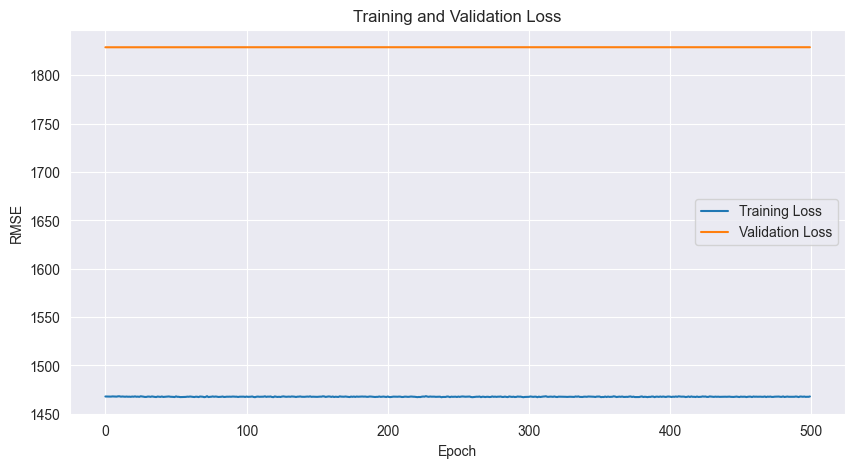

Final validation RMSE: 1828.9948
  Fold 2/5
Input size: 437



  5%|▌         | 25/500 [00:00<00:01, 246.74it/s]

Epoch 0: Train RMSE: 1656.7314, Val RMSE: 1315.6875
Epoch 10: Train RMSE: 1656.7742, Val RMSE: 1316.1947
Epoch 20: Train RMSE: 1656.8737, Val RMSE: 1316.2452
Epoch 30: Train RMSE: 1656.7031, Val RMSE: 1316.6772
Epoch 40: Train RMSE: 1656.8407, Val RMSE: 1316.7946



 15%|█▌        | 76/500 [00:00<00:01, 248.51it/s]

Epoch 50: Train RMSE: 1656.1982, Val RMSE: 1316.8669
Epoch 60: Train RMSE: 1656.1725, Val RMSE: 1316.8944
Epoch 70: Train RMSE: 1656.3716, Val RMSE: 1316.9126
Epoch 80: Train RMSE: 1656.3896, Val RMSE: 1316.9213
Epoch 90: Train RMSE: 1655.9324, Val RMSE: 1316.9252
Epoch 100: Train RMSE: 1656.3760, Val RMSE: 1316.9275



 32%|███▏      | 161/500 [00:00<00:01, 261.64it/s]

Epoch 110: Train RMSE: 1656.0104, Val RMSE: 1316.9287
Epoch 120: Train RMSE: 1656.2321, Val RMSE: 1316.9294
Epoch 130: Train RMSE: 1656.0393, Val RMSE: 1316.9298
Epoch 140: Train RMSE: 1656.2004, Val RMSE: 1316.9299
Epoch 150: Train RMSE: 1656.3594, Val RMSE: 1316.9301
Epoch 160: Train RMSE: 1656.4086, Val RMSE: 1316.9302



 44%|████▎     | 218/500 [00:00<00:01, 268.08it/s]

Epoch 170: Train RMSE: 1656.7546, Val RMSE: 1316.9302
Epoch 180: Train RMSE: 1656.0493, Val RMSE: 1316.9302
Epoch 190: Train RMSE: 1656.3234, Val RMSE: 1316.9302
Epoch 200: Train RMSE: 1656.5027, Val RMSE: 1316.9302
Epoch 210: Train RMSE: 1656.5552, Val RMSE: 1316.9302
Epoch 220: Train RMSE: 1656.5193, Val RMSE: 1316.9302



 55%|█████▍    | 273/500 [00:01<00:00, 263.38it/s]

Epoch 230: Train RMSE: 1656.1429, Val RMSE: 1316.9302
Epoch 240: Train RMSE: 1656.8676, Val RMSE: 1316.9302
Epoch 250: Train RMSE: 1656.7571, Val RMSE: 1316.9302
Epoch 260: Train RMSE: 1656.5699, Val RMSE: 1316.9302
Epoch 270: Train RMSE: 1656.4147, Val RMSE: 1316.9302
Epoch 280: Train RMSE: 1656.2963, Val RMSE: 1316.9302



 67%|██████▋   | 335/500 [00:01<00:00, 281.52it/s]

Epoch 290: Train RMSE: 1656.0828, Val RMSE: 1316.9302
Epoch 300: Train RMSE: 1656.3955, Val RMSE: 1316.9302
Epoch 310: Train RMSE: 1655.9072, Val RMSE: 1316.9302
Epoch 320: Train RMSE: 1656.5983, Val RMSE: 1316.9302
Epoch 330: Train RMSE: 1655.8141, Val RMSE: 1316.9302
Epoch 340: Train RMSE: 1656.6823, Val RMSE: 1316.9302



 78%|███████▊  | 392/500 [00:01<00:00, 271.55it/s]

Epoch 350: Train RMSE: 1655.8954, Val RMSE: 1316.9302
Epoch 360: Train RMSE: 1655.8525, Val RMSE: 1316.9302
Epoch 370: Train RMSE: 1656.5762, Val RMSE: 1316.9302
Epoch 380: Train RMSE: 1656.0157, Val RMSE: 1316.9302
Epoch 390: Train RMSE: 1656.6169, Val RMSE: 1316.9302
Epoch 400: Train RMSE: 1656.2998, Val RMSE: 1316.9302



 89%|████████▉ | 447/500 [00:01<00:00, 265.54it/s]

Epoch 410: Train RMSE: 1656.8292, Val RMSE: 1316.9302
Epoch 420: Train RMSE: 1656.8397, Val RMSE: 1316.9302
Epoch 430: Train RMSE: 1656.6454, Val RMSE: 1316.9302
Epoch 440: Train RMSE: 1656.8062, Val RMSE: 1316.9302
Epoch 450: Train RMSE: 1656.1284, Val RMSE: 1316.9302



100%|██████████| 500/500 [00:01<00:00, 266.37it/s]


Epoch 460: Train RMSE: 1657.0327, Val RMSE: 1316.9302
Epoch 470: Train RMSE: 1656.6680, Val RMSE: 1316.9302
Epoch 480: Train RMSE: 1656.4343, Val RMSE: 1316.9302
Epoch 490: Train RMSE: 1656.3673, Val RMSE: 1316.9302


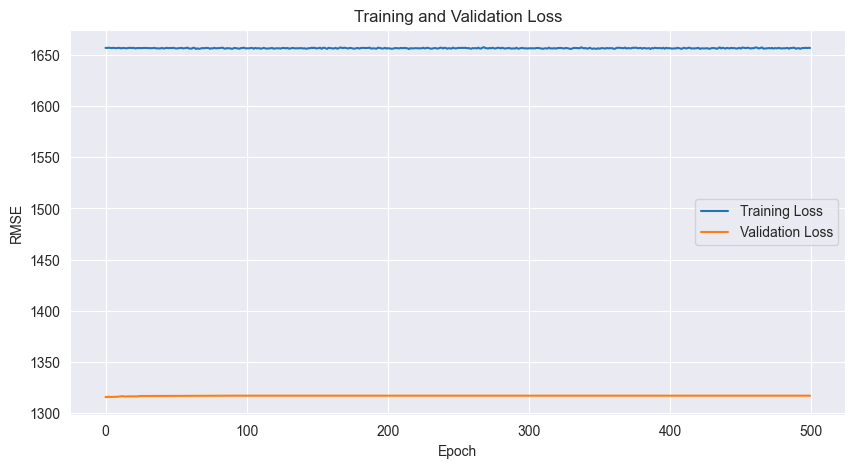

Final validation RMSE: 1315.4283
  Fold 3/5
Input size: 437



  2%|▏         | 12/500 [00:00<00:04, 115.56it/s]

Epoch 0: Train RMSE: 1552.0980, Val RMSE: 2262.2290
Epoch 10: Train RMSE: 1551.9840, Val RMSE: 2262.1082
Epoch 20: Train RMSE: 1551.9974, Val RMSE: 2261.8821



 10%|█         | 52/500 [00:00<00:03, 126.64it/s]

Epoch 30: Train RMSE: 1551.9352, Val RMSE: 2261.7317
Epoch 40: Train RMSE: 1551.9176, Val RMSE: 2261.6936
Epoch 50: Train RMSE: 1551.9618, Val RMSE: 2261.6667



 16%|█▌        | 78/500 [00:00<00:03, 106.44it/s]

Epoch 60: Train RMSE: 1551.9225, Val RMSE: 2261.6516
Epoch 70: Train RMSE: 1551.7913, Val RMSE: 2261.6431
Epoch 80: Train RMSE: 1551.9142, Val RMSE: 2261.6387



 23%|██▎       | 113/500 [00:00<00:02, 139.89it/s]

Epoch 90: Train RMSE: 1551.7509, Val RMSE: 2261.6365
Epoch 100: Train RMSE: 1551.8362, Val RMSE: 2261.6348
Epoch 110: Train RMSE: 1551.9707, Val RMSE: 2261.6338
Epoch 120: Train RMSE: 1551.9148, Val RMSE: 2261.6333
Epoch 130: Train RMSE: 1551.8881, Val RMSE: 2261.6331



 37%|███▋      | 185/500 [00:01<00:01, 204.36it/s]

Epoch 140: Train RMSE: 1551.8568, Val RMSE: 2261.6328
Epoch 150: Train RMSE: 1551.8452, Val RMSE: 2261.6328
Epoch 160: Train RMSE: 1551.8938, Val RMSE: 2261.6328
Epoch 170: Train RMSE: 1551.9863, Val RMSE: 2261.6328
Epoch 180: Train RMSE: 1551.8578, Val RMSE: 2261.6328



 46%|████▌     | 231/500 [00:01<00:01, 215.48it/s]

Epoch 190: Train RMSE: 1551.9648, Val RMSE: 2261.6328
Epoch 200: Train RMSE: 1551.8270, Val RMSE: 2261.6328
Epoch 210: Train RMSE: 1551.9600, Val RMSE: 2261.6328
Epoch 220: Train RMSE: 1551.7832, Val RMSE: 2261.6328
Epoch 230: Train RMSE: 1551.8855, Val RMSE: 2261.6328



 56%|█████▌    | 279/500 [00:01<00:00, 226.31it/s]

Epoch 240: Train RMSE: 1551.9520, Val RMSE: 2261.6328
Epoch 250: Train RMSE: 1551.8464, Val RMSE: 2261.6328
Epoch 260: Train RMSE: 1551.8427, Val RMSE: 2261.6328
Epoch 270: Train RMSE: 1551.9052, Val RMSE: 2261.6328
Epoch 280: Train RMSE: 1552.0435, Val RMSE: 2261.6328



 65%|██████▌   | 327/500 [00:01<00:00, 229.93it/s]

Epoch 290: Train RMSE: 1551.9789, Val RMSE: 2261.6328
Epoch 300: Train RMSE: 1551.9198, Val RMSE: 2261.6328
Epoch 310: Train RMSE: 1551.9485, Val RMSE: 2261.6328
Epoch 320: Train RMSE: 1551.8876, Val RMSE: 2261.6328
Epoch 330: Train RMSE: 1551.8381, Val RMSE: 2261.6328



 75%|███████▍  | 374/500 [00:02<00:00, 214.87it/s]

Epoch 340: Train RMSE: 1551.9510, Val RMSE: 2261.6328
Epoch 350: Train RMSE: 1551.9160, Val RMSE: 2261.6328
Epoch 360: Train RMSE: 1551.8499, Val RMSE: 2261.6328
Epoch 370: Train RMSE: 1551.9132, Val RMSE: 2261.6328
Epoch 380: Train RMSE: 1551.8796, Val RMSE: 2261.6328



 84%|████████▎ | 418/500 [00:02<00:00, 210.15it/s]

Epoch 390: Train RMSE: 1551.9291, Val RMSE: 2261.6328
Epoch 400: Train RMSE: 1551.9154, Val RMSE: 2261.6328
Epoch 410: Train RMSE: 1551.9993, Val RMSE: 2261.6328
Epoch 420: Train RMSE: 1551.8484, Val RMSE: 2261.6328
Epoch 430: Train RMSE: 1551.8728, Val RMSE: 2261.6328



 93%|█████████▎| 463/500 [00:02<00:00, 210.69it/s]

Epoch 440: Train RMSE: 1551.9296, Val RMSE: 2261.6328
Epoch 450: Train RMSE: 1551.9464, Val RMSE: 2261.6328
Epoch 460: Train RMSE: 1551.8313, Val RMSE: 2261.6328
Epoch 470: Train RMSE: 1551.9720, Val RMSE: 2261.6328
Epoch 480: Train RMSE: 1551.8491, Val RMSE: 2261.6328



100%|██████████| 500/500 [00:02<00:00, 187.57it/s]


Epoch 490: Train RMSE: 1551.8353, Val RMSE: 2261.6328


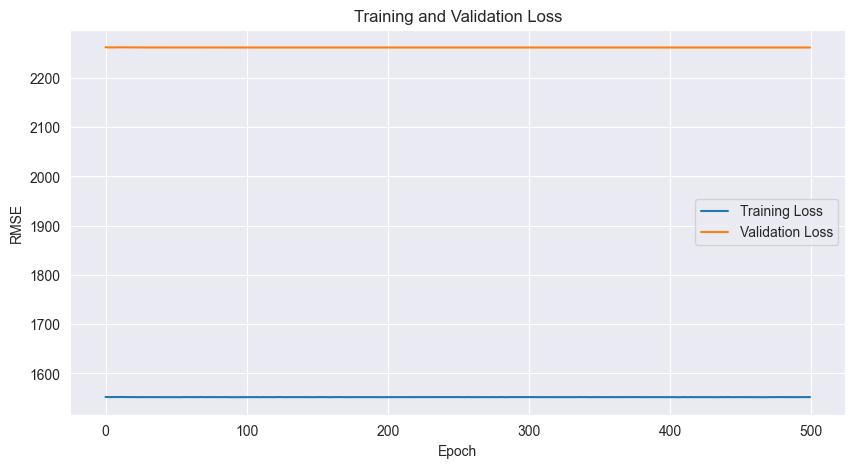

Final validation RMSE: 2261.6328
  Fold 4/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1755.9620, Val RMSE: 2261.7952
Epoch 10: Train RMSE: 1755.5676, Val RMSE: 2261.8726



  3%|▎         | 17/500 [00:00<00:02, 165.18it/s]

Epoch 20: Train RMSE: 1755.5040, Val RMSE: 2261.9197
Epoch 30: Train RMSE: 1755.4111, Val RMSE: 2261.9368



 12%|█▏        | 60/500 [00:00<00:02, 198.92it/s]

Epoch 40: Train RMSE: 1755.3541, Val RMSE: 2261.9485
Epoch 50: Train RMSE: 1755.3557, Val RMSE: 2261.9583
Epoch 60: Train RMSE: 1755.3265, Val RMSE: 2261.9658
Epoch 70: Train RMSE: 1755.1862, Val RMSE: 2261.9731



 20%|█▉        | 99/500 [00:00<00:02, 175.27it/s]

Epoch 80: Train RMSE: 1755.3242, Val RMSE: 2261.9775
Epoch 90: Train RMSE: 1755.4127, Val RMSE: 2261.9790
Epoch 100: Train RMSE: 1755.3905, Val RMSE: 2261.9800
Epoch 110: Train RMSE: 1755.3865, Val RMSE: 2261.9805



 28%|██▊       | 140/500 [00:00<00:01, 185.82it/s]

Epoch 120: Train RMSE: 1755.3955, Val RMSE: 2261.9805
Epoch 130: Train RMSE: 1755.4402, Val RMSE: 2261.9807
Epoch 140: Train RMSE: 1755.1836, Val RMSE: 2261.9807
Epoch 150: Train RMSE: 1755.5073, Val RMSE: 2261.9807



 33%|███▎      | 164/500 [00:00<00:01, 199.67it/s]

Epoch 160: Train RMSE: 1755.2242, Val RMSE: 2261.9807



 37%|███▋      | 186/500 [00:00<00:01, 203.93it/s]

Epoch 170: Train RMSE: 1755.4669, Val RMSE: 2261.9807
Epoch 180: Train RMSE: 1755.2970, Val RMSE: 2261.9807
Epoch 190: Train RMSE: 1755.3029, Val RMSE: 2261.9807
Epoch 200: Train RMSE: 1755.2560, Val RMSE: 2261.9807



 46%|████▌     | 228/500 [00:01<00:01, 195.59it/s]

Epoch 210: Train RMSE: 1755.3107, Val RMSE: 2261.9807
Epoch 220: Train RMSE: 1755.3774, Val RMSE: 2261.9807
Epoch 230: Train RMSE: 1755.2255, Val RMSE: 2261.9807
Epoch 240: Train RMSE: 1755.1888, Val RMSE: 2261.9807



 57%|█████▋    | 287/500 [00:01<00:01, 187.80it/s]

Epoch 250: Train RMSE: 1755.2673, Val RMSE: 2261.9807
Epoch 260: Train RMSE: 1755.4224, Val RMSE: 2261.9807
Epoch 270: Train RMSE: 1755.4149, Val RMSE: 2261.9807
Epoch 280: Train RMSE: 1755.3522, Val RMSE: 2261.9807



 65%|██████▌   | 325/500 [00:01<00:00, 185.57it/s]

Epoch 290: Train RMSE: 1755.4279, Val RMSE: 2261.9807
Epoch 300: Train RMSE: 1755.2728, Val RMSE: 2261.9807
Epoch 310: Train RMSE: 1755.3400, Val RMSE: 2261.9807
Epoch 320: Train RMSE: 1755.1260, Val RMSE: 2261.9807



 73%|███████▎  | 367/500 [00:01<00:00, 196.84it/s]

Epoch 330: Train RMSE: 1755.3912, Val RMSE: 2261.9807
Epoch 340: Train RMSE: 1755.4340, Val RMSE: 2261.9807
Epoch 350: Train RMSE: 1755.3070, Val RMSE: 2261.9807
Epoch 360: Train RMSE: 1755.0784, Val RMSE: 2261.9807
Epoch 370: Train RMSE: 1755.2209, Val RMSE: 2261.9807



 83%|████████▎ | 413/500 [00:02<00:00, 209.21it/s]

Epoch 380: Train RMSE: 1755.2816, Val RMSE: 2261.9807
Epoch 390: Train RMSE: 1755.3837, Val RMSE: 2261.9807
Epoch 400: Train RMSE: 1755.1493, Val RMSE: 2261.9807
Epoch 410: Train RMSE: 1755.2335, Val RMSE: 2261.9807
Epoch 420: Train RMSE: 1755.2791, Val RMSE: 2261.9807



 92%|█████████▏| 458/500 [00:02<00:00, 204.99it/s]

Epoch 430: Train RMSE: 1755.3243, Val RMSE: 2261.9807
Epoch 440: Train RMSE: 1755.3984, Val RMSE: 2261.9807
Epoch 450: Train RMSE: 1755.2869, Val RMSE: 2261.9807
Epoch 460: Train RMSE: 1755.5085, Val RMSE: 2261.9807
Epoch 470: Train RMSE: 1755.5099, Val RMSE: 2261.9807



100%|██████████| 500/500 [00:02<00:00, 195.97it/s]


Epoch 480: Train RMSE: 1755.3906, Val RMSE: 2261.9807
Epoch 490: Train RMSE: 1755.3094, Val RMSE: 2261.9807


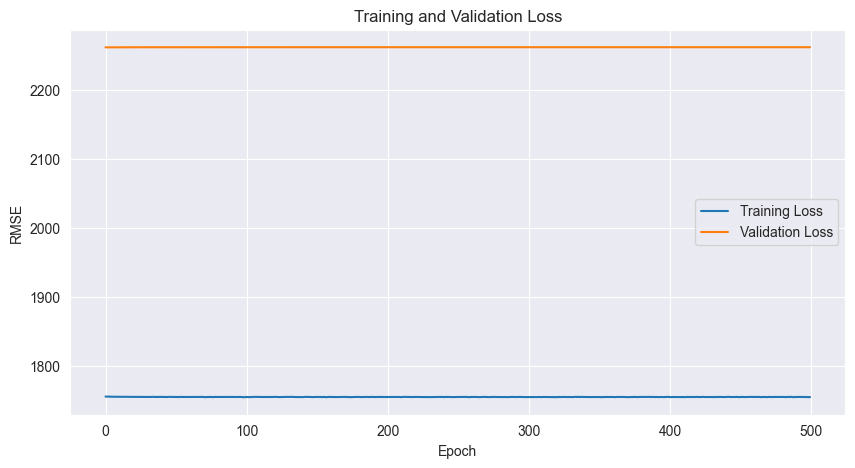

Final validation RMSE: 2261.7947
  Fold 5/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1867.7386, Val RMSE: 2493.2258



  3%|▎         | 16/500 [00:00<00:03, 154.50it/s]

Epoch 10: Train RMSE: 1867.4374, Val RMSE: 2493.4614
Epoch 20: Train RMSE: 1867.5499, Val RMSE: 2493.4561
Epoch 30: Train RMSE: 1867.5179, Val RMSE: 2493.5999



  7%|▋         | 34/500 [00:00<00:02, 164.96it/s]

Epoch 40: Train RMSE: 1867.3933, Val RMSE: 2493.6956



 14%|█▍        | 70/500 [00:00<00:02, 168.58it/s]

Epoch 50: Train RMSE: 1867.3781, Val RMSE: 2493.7146
Epoch 60: Train RMSE: 1867.3456, Val RMSE: 2493.7258
Epoch 70: Train RMSE: 1867.3816, Val RMSE: 2493.7336
Epoch 80: Train RMSE: 1867.2625, Val RMSE: 2493.7422



 22%|██▏       | 109/500 [00:00<00:02, 179.56it/s]

Epoch 90: Train RMSE: 1867.3594, Val RMSE: 2493.7449
Epoch 100: Train RMSE: 1867.2828, Val RMSE: 2493.7468
Epoch 110: Train RMSE: 1867.4146, Val RMSE: 2493.7476



 26%|██▌       | 129/500 [00:00<00:01, 185.57it/s]

Epoch 120: Train RMSE: 1867.3256, Val RMSE: 2493.7483



 30%|██▉       | 148/500 [00:00<00:01, 181.24it/s]

Epoch 130: Train RMSE: 1867.3247, Val RMSE: 2493.7483
Epoch 140: Train RMSE: 1867.2111, Val RMSE: 2493.7485
Epoch 150: Train RMSE: 1867.2964, Val RMSE: 2493.7485



 33%|███▎      | 167/500 [00:00<00:01, 182.43it/s]

Epoch 160: Train RMSE: 1867.2117, Val RMSE: 2493.7485



 37%|███▋      | 186/500 [00:01<00:01, 183.51it/s]

Epoch 170: Train RMSE: 1867.3424, Val RMSE: 2493.7488
Epoch 180: Train RMSE: 1867.2056, Val RMSE: 2493.7488
Epoch 190: Train RMSE: 1867.3735, Val RMSE: 2493.7488



 41%|████      | 205/500 [00:01<00:01, 185.26it/s]

Epoch 200: Train RMSE: 1867.2968, Val RMSE: 2493.7488



 45%|████▍     | 224/500 [00:01<00:01, 186.33it/s]

Epoch 210: Train RMSE: 1867.2074, Val RMSE: 2493.7488
Epoch 220: Train RMSE: 1867.2352, Val RMSE: 2493.7488
Epoch 230: Train RMSE: 1867.2769, Val RMSE: 2493.7488



 53%|█████▎    | 264/500 [00:01<00:01, 160.46it/s]

Epoch 240: Train RMSE: 1867.3137, Val RMSE: 2493.7488
Epoch 250: Train RMSE: 1867.3077, Val RMSE: 2493.7488
Epoch 260: Train RMSE: 1867.2789, Val RMSE: 2493.7488
Epoch 270: Train RMSE: 1867.3835, Val RMSE: 2493.7488
Epoch 280: Train RMSE: 1867.2330, Val RMSE: 2493.7488



 65%|██████▌   | 325/500 [00:01<00:00, 185.01it/s]

Epoch 290: Train RMSE: 1867.3713, Val RMSE: 2493.7488
Epoch 300: Train RMSE: 1867.1315, Val RMSE: 2493.7488
Epoch 310: Train RMSE: 1867.3667, Val RMSE: 2493.7488
Epoch 320: Train RMSE: 1867.2885, Val RMSE: 2493.7488
Epoch 330: Train RMSE: 1867.3502, Val RMSE: 2493.7488



 73%|███████▎  | 365/500 [00:02<00:00, 186.14it/s]

Epoch 340: Train RMSE: 1867.2975, Val RMSE: 2493.7488
Epoch 350: Train RMSE: 1867.3597, Val RMSE: 2493.7488
Epoch 360: Train RMSE: 1867.3019, Val RMSE: 2493.7488
Epoch 370: Train RMSE: 1867.2789, Val RMSE: 2493.7488



 81%|████████  | 404/500 [00:02<00:00, 188.38it/s]

Epoch 380: Train RMSE: 1867.1503, Val RMSE: 2493.7488
Epoch 390: Train RMSE: 1867.3513, Val RMSE: 2493.7488
Epoch 400: Train RMSE: 1867.2969, Val RMSE: 2493.7488
Epoch 410: Train RMSE: 1867.3254, Val RMSE: 2493.7488



 89%|████████▉ | 444/500 [00:02<00:00, 189.07it/s]

Epoch 420: Train RMSE: 1867.3315, Val RMSE: 2493.7488
Epoch 430: Train RMSE: 1867.3300, Val RMSE: 2493.7488
Epoch 440: Train RMSE: 1867.1750, Val RMSE: 2493.7488
Epoch 450: Train RMSE: 1867.3163, Val RMSE: 2493.7488



 96%|█████████▋| 482/500 [00:02<00:00, 179.31it/s]

Epoch 460: Train RMSE: 1867.3195, Val RMSE: 2493.7488
Epoch 470: Train RMSE: 1867.3182, Val RMSE: 2493.7488
Epoch 480: Train RMSE: 1867.3453, Val RMSE: 2493.7488
Epoch 490: Train RMSE: 1867.3018, Val RMSE: 2493.7488


100%|██████████| 500/500 [00:02<00:00, 179.05it/s]


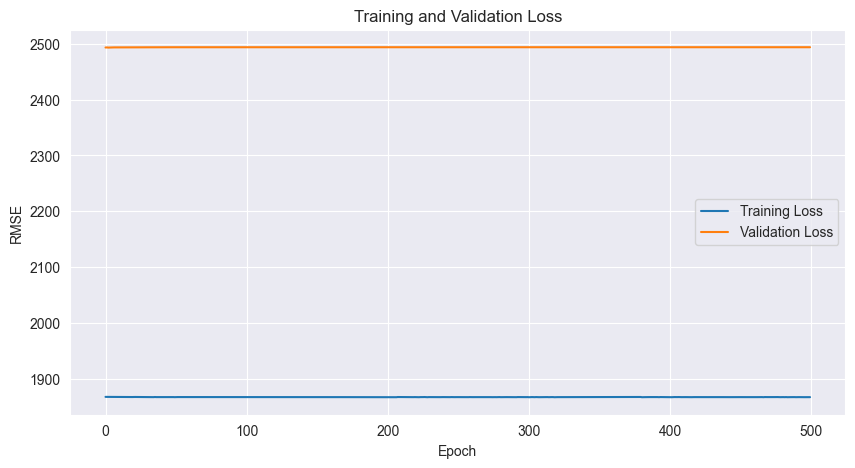

Final validation RMSE: 2493.1147
  Avg RMSE: 2032.1931 ± 417.8156

Testing: hidden_size=32, layers=10, lr=0.0001
  Fold 1/5
Input size: 437



  3%|▎         | 15/500 [00:00<00:03, 142.11it/s]

Epoch 0: Train RMSE: 1467.8867, Val RMSE: 1828.8324
Epoch 10: Train RMSE: 1467.7853, Val RMSE: 1828.8431
Epoch 20: Train RMSE: 1467.6235, Val RMSE: 1828.7880



 10%|█         | 50/500 [00:00<00:02, 165.67it/s]


Epoch 30: Train RMSE: 1468.0081, Val RMSE: 1828.8313
Epoch 40: Train RMSE: 1467.8125, Val RMSE: 1828.8546
Epoch 50: Train RMSE: 1467.6896, Val RMSE: 1828.8424
Epoch 60: Train RMSE: 1467.6553, Val RMSE: 1828.8402


 21%|██        | 104/500 [00:00<00:02, 174.70it/s]

Epoch 70: Train RMSE: 1467.5948, Val RMSE: 1828.8405
Epoch 80: Train RMSE: 1468.0803, Val RMSE: 1828.8406
Epoch 90: Train RMSE: 1467.5822, Val RMSE: 1828.8405
Epoch 100: Train RMSE: 1467.7980, Val RMSE: 1828.8407



 28%|██▊       | 139/500 [00:00<00:02, 162.07it/s]

Epoch 110: Train RMSE: 1467.6323, Val RMSE: 1828.8406
Epoch 120: Train RMSE: 1467.8274, Val RMSE: 1828.8406
Epoch 130: Train RMSE: 1467.9075, Val RMSE: 1828.8406
Epoch 140: Train RMSE: 1467.8860, Val RMSE: 1828.8406



 36%|███▌      | 178/500 [00:01<00:01, 174.07it/s]

Epoch 150: Train RMSE: 1467.9900, Val RMSE: 1828.8406
Epoch 160: Train RMSE: 1468.0262, Val RMSE: 1828.8406
Epoch 170: Train RMSE: 1467.6305, Val RMSE: 1828.8406
Epoch 180: Train RMSE: 1467.8689, Val RMSE: 1828.8406



 43%|████▎     | 217/500 [00:01<00:01, 176.41it/s]

Epoch 190: Train RMSE: 1467.8989, Val RMSE: 1828.8406
Epoch 200: Train RMSE: 1467.7773, Val RMSE: 1828.8406
Epoch 210: Train RMSE: 1467.9655, Val RMSE: 1828.8406
Epoch 220: Train RMSE: 1467.8740, Val RMSE: 1828.8406



 50%|█████     | 252/500 [00:01<00:01, 167.95it/s]

Epoch 230: Train RMSE: 1468.1561, Val RMSE: 1828.8406
Epoch 240: Train RMSE: 1467.9137, Val RMSE: 1828.8406
Epoch 250: Train RMSE: 1467.9154, Val RMSE: 1828.8406
Epoch 260: Train RMSE: 1467.7371, Val RMSE: 1828.8406



 58%|█████▊    | 288/500 [00:01<00:01, 168.18it/s]

Epoch 270: Train RMSE: 1467.6907, Val RMSE: 1828.8406
Epoch 280: Train RMSE: 1467.9540, Val RMSE: 1828.8406
Epoch 290: Train RMSE: 1467.9249, Val RMSE: 1828.8406
Epoch 300: Train RMSE: 1467.7688, Val RMSE: 1828.8406



 68%|██████▊   | 338/500 [00:02<00:01, 150.76it/s]

Epoch 310: Train RMSE: 1467.9557, Val RMSE: 1828.8406
Epoch 320: Train RMSE: 1468.0917, Val RMSE: 1828.8406
Epoch 330: Train RMSE: 1467.9866, Val RMSE: 1828.8406



 71%|███████   | 354/500 [00:02<00:00, 146.46it/s]

Epoch 340: Train RMSE: 1467.9089, Val RMSE: 1828.8406
Epoch 350: Train RMSE: 1467.5697, Val RMSE: 1828.8406
Epoch 360: Train RMSE: 1467.8253, Val RMSE: 1828.8406



 80%|███████▉  | 399/500 [00:02<00:00, 142.55it/s]

Epoch 370: Train RMSE: 1467.8722, Val RMSE: 1828.8406
Epoch 380: Train RMSE: 1467.7106, Val RMSE: 1828.8406
Epoch 390: Train RMSE: 1467.7316, Val RMSE: 1828.8406



 86%|████████▌ | 429/500 [00:02<00:00, 141.97it/s]

Epoch 400: Train RMSE: 1467.8475, Val RMSE: 1828.8406
Epoch 410: Train RMSE: 1467.8451, Val RMSE: 1828.8406
Epoch 420: Train RMSE: 1467.7142, Val RMSE: 1828.8406



 92%|█████████▏| 459/500 [00:02<00:00, 142.05it/s]

Epoch 430: Train RMSE: 1467.9421, Val RMSE: 1828.8406
Epoch 440: Train RMSE: 1467.8351, Val RMSE: 1828.8406
Epoch 450: Train RMSE: 1467.8116, Val RMSE: 1828.8406



 98%|█████████▊| 489/500 [00:03<00:00, 141.17it/s]

Epoch 460: Train RMSE: 1467.6991, Val RMSE: 1828.8406
Epoch 470: Train RMSE: 1467.9399, Val RMSE: 1828.8406
Epoch 480: Train RMSE: 1467.8728, Val RMSE: 1828.8406


100%|██████████| 500/500 [00:03<00:00, 155.42it/s]


Epoch 490: Train RMSE: 1468.0457, Val RMSE: 1828.8406


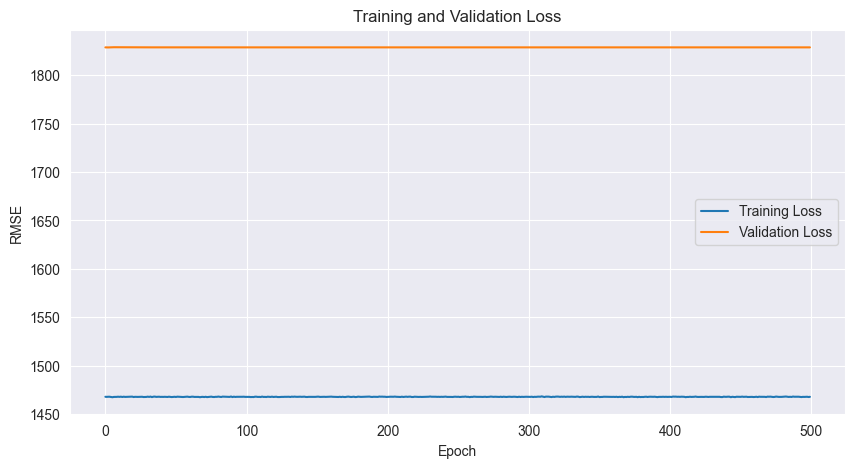

Final validation RMSE: 1828.7637
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.7142, Val RMSE: 1315.8274



  2%|▏         | 9/500 [00:00<00:05, 85.82it/s]

Epoch 10: Train RMSE: 1656.6804, Val RMSE: 1315.8512
Epoch 20: Train RMSE: 1656.6906, Val RMSE: 1315.8561



  7%|▋         | 33/500 [00:00<00:04, 108.06it/s]

Epoch 30: Train RMSE: 1656.7263, Val RMSE: 1315.8390
Epoch 40: Train RMSE: 1656.7717, Val RMSE: 1315.8425



 10%|▉         | 49/500 [00:00<00:03, 125.77it/s]

Epoch 50: Train RMSE: 1656.7704, Val RMSE: 1315.8441
Epoch 60: Train RMSE: 1656.7765, Val RMSE: 1315.8456



 13%|█▎        | 65/500 [00:00<00:03, 135.05it/s]

Epoch 70: Train RMSE: 1656.7666, Val RMSE: 1315.8463



 16%|█▌        | 81/500 [00:00<00:02, 142.72it/s]

Epoch 80: Train RMSE: 1656.7471, Val RMSE: 1315.8472



 19%|█▉        | 97/500 [00:00<00:02, 147.75it/s]

Epoch 90: Train RMSE: 1656.7433, Val RMSE: 1315.8478
Epoch 100: Train RMSE: 1656.6454, Val RMSE: 1315.8475



 22%|██▏       | 112/500 [00:00<00:02, 142.39it/s]

Epoch 110: Train RMSE: 1656.7085, Val RMSE: 1315.8475



 26%|██▌       | 128/500 [00:00<00:02, 145.78it/s]

Epoch 120: Train RMSE: 1656.6780, Val RMSE: 1315.8475
Epoch 130: Train RMSE: 1656.7209, Val RMSE: 1315.8475
Epoch 140: Train RMSE: 1656.7722, Val RMSE: 1315.8475



 29%|██▉       | 144/500 [00:01<00:02, 147.76it/s]

Epoch 150: Train RMSE: 1656.6875, Val RMSE: 1315.8475



 36%|███▌      | 178/500 [00:01<00:02, 157.88it/s]

Epoch 160: Train RMSE: 1656.7552, Val RMSE: 1315.8475
Epoch 170: Train RMSE: 1656.7200, Val RMSE: 1315.8475
Epoch 180: Train RMSE: 1656.7684, Val RMSE: 1315.8475



 39%|███▉      | 194/500 [00:01<00:01, 154.55it/s]

Epoch 190: Train RMSE: 1656.7693, Val RMSE: 1315.8475



 42%|████▏     | 210/500 [00:01<00:01, 149.78it/s]

Epoch 200: Train RMSE: 1656.6821, Val RMSE: 1315.8475
Epoch 210: Train RMSE: 1656.7815, Val RMSE: 1315.8475



 45%|████▌     | 226/500 [00:01<00:01, 151.56it/s]

Epoch 220: Train RMSE: 1656.6609, Val RMSE: 1315.8475
Epoch 230: Train RMSE: 1656.7880, Val RMSE: 1315.8475



 48%|████▊     | 242/500 [00:01<00:01, 150.91it/s]

Epoch 240: Train RMSE: 1656.8257, Val RMSE: 1315.8475
Epoch 250: Train RMSE: 1656.7195, Val RMSE: 1315.8475



 52%|█████▏    | 258/500 [00:01<00:01, 150.67it/s]

Epoch 260: Train RMSE: 1656.6329, Val RMSE: 1315.8475



 58%|█████▊    | 289/500 [00:02<00:01, 145.68it/s]

Epoch 270: Train RMSE: 1656.7705, Val RMSE: 1315.8475
Epoch 280: Train RMSE: 1656.7029, Val RMSE: 1315.8475
Epoch 290: Train RMSE: 1656.7783, Val RMSE: 1315.8475



 64%|██████▍   | 321/500 [00:02<00:01, 153.11it/s]

Epoch 300: Train RMSE: 1656.6559, Val RMSE: 1315.8475
Epoch 310: Train RMSE: 1656.7314, Val RMSE: 1315.8475
Epoch 320: Train RMSE: 1656.7931, Val RMSE: 1315.8475
Epoch 330: Train RMSE: 1656.7234, Val RMSE: 1315.8475



 71%|███████   | 353/500 [00:02<00:00, 153.03it/s]

Epoch 340: Train RMSE: 1656.6465, Val RMSE: 1315.8475
Epoch 350: Train RMSE: 1656.7311, Val RMSE: 1315.8475
Epoch 360: Train RMSE: 1656.6417, Val RMSE: 1315.8475



 77%|███████▋  | 384/500 [00:02<00:00, 140.99it/s]

Epoch 370: Train RMSE: 1656.7333, Val RMSE: 1315.8475
Epoch 380: Train RMSE: 1656.7074, Val RMSE: 1315.8475
Epoch 390: Train RMSE: 1656.6965, Val RMSE: 1315.8475



 86%|████████▌ | 428/500 [00:02<00:00, 137.21it/s]

Epoch 400: Train RMSE: 1656.7180, Val RMSE: 1315.8475
Epoch 410: Train RMSE: 1656.6897, Val RMSE: 1315.8475
Epoch 420: Train RMSE: 1656.7947, Val RMSE: 1315.8475



 91%|█████████ | 456/500 [00:03<00:00, 135.52it/s]

Epoch 430: Train RMSE: 1656.7670, Val RMSE: 1315.8475
Epoch 440: Train RMSE: 1656.5879, Val RMSE: 1315.8475
Epoch 450: Train RMSE: 1656.8229, Val RMSE: 1315.8475



 98%|█████████▊| 488/500 [00:03<00:00, 147.03it/s]

Epoch 460: Train RMSE: 1656.7058, Val RMSE: 1315.8475
Epoch 470: Train RMSE: 1656.7822, Val RMSE: 1315.8475
Epoch 480: Train RMSE: 1656.6487, Val RMSE: 1315.8475
Epoch 490: Train RMSE: 1656.7319, Val RMSE: 1315.8475


100%|██████████| 500/500 [00:03<00:00, 143.70it/s]


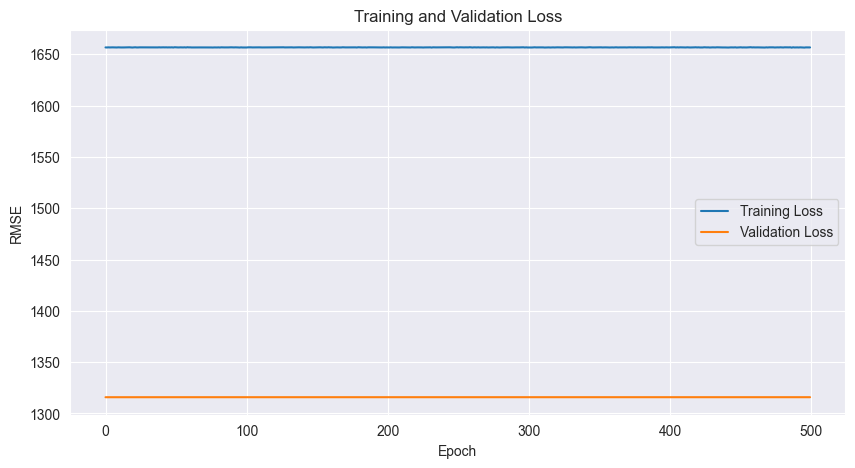

Final validation RMSE: 1315.8253
  Fold 3/5
Input size: 437



  2%|▏         | 10/500 [00:00<00:04, 98.00it/s]

Epoch 0: Train RMSE: 1551.8865, Val RMSE: 2262.3630
Epoch 10: Train RMSE: 1552.0768, Val RMSE: 2262.3611
Epoch 20: Train RMSE: 1552.0768, Val RMSE: 2262.3596



  7%|▋         | 37/500 [00:00<00:03, 121.63it/s]

Epoch 30: Train RMSE: 1551.8586, Val RMSE: 2262.3621
Epoch 40: Train RMSE: 1552.0084, Val RMSE: 2262.3572



 15%|█▍        | 74/500 [00:00<00:04, 101.58it/s]

Epoch 50: Train RMSE: 1551.9363, Val RMSE: 2262.3564
Epoch 60: Train RMSE: 1552.1141, Val RMSE: 2262.3560
Epoch 70: Train RMSE: 1552.0127, Val RMSE: 2262.3560



 20%|██        | 101/500 [00:00<00:03, 116.43it/s]

Epoch 80: Train RMSE: 1551.9253, Val RMSE: 2262.3560
Epoch 90: Train RMSE: 1552.0862, Val RMSE: 2262.3560
Epoch 100: Train RMSE: 1551.9816, Val RMSE: 2262.3560



 25%|██▌       | 126/500 [00:01<00:03, 113.88it/s]

Epoch 110: Train RMSE: 1552.0043, Val RMSE: 2262.3560
Epoch 120: Train RMSE: 1552.0984, Val RMSE: 2262.3560
Epoch 130: Train RMSE: 1551.9702, Val RMSE: 2262.3560



 33%|███▎      | 167/500 [00:01<00:02, 128.43it/s]

Epoch 140: Train RMSE: 1551.9486, Val RMSE: 2262.3560
Epoch 150: Train RMSE: 1551.9547, Val RMSE: 2262.3560
Epoch 160: Train RMSE: 1552.0768, Val RMSE: 2262.3560



 39%|███▉      | 195/500 [00:01<00:02, 130.48it/s]

Epoch 170: Train RMSE: 1551.8877, Val RMSE: 2262.3560
Epoch 180: Train RMSE: 1551.9836, Val RMSE: 2262.3560
Epoch 190: Train RMSE: 1552.1073, Val RMSE: 2262.3560



 45%|████▍     | 224/500 [00:01<00:02, 132.18it/s]

Epoch 200: Train RMSE: 1552.0352, Val RMSE: 2262.3560
Epoch 210: Train RMSE: 1552.0007, Val RMSE: 2262.3560
Epoch 220: Train RMSE: 1552.1776, Val RMSE: 2262.3560



 50%|█████     | 252/500 [00:02<00:01, 133.80it/s]

Epoch 230: Train RMSE: 1552.0177, Val RMSE: 2262.3560
Epoch 240: Train RMSE: 1551.9242, Val RMSE: 2262.3560
Epoch 250: Train RMSE: 1552.0375, Val RMSE: 2262.3560



 56%|█████▌    | 280/500 [00:02<00:01, 129.82it/s]

Epoch 260: Train RMSE: 1552.0525, Val RMSE: 2262.3560
Epoch 270: Train RMSE: 1552.1760, Val RMSE: 2262.3560
Epoch 280: Train RMSE: 1551.9944, Val RMSE: 2262.3560



 62%|██████▏   | 308/500 [00:02<00:01, 133.38it/s]

Epoch 290: Train RMSE: 1552.0457, Val RMSE: 2262.3560
Epoch 300: Train RMSE: 1552.0505, Val RMSE: 2262.3560
Epoch 310: Train RMSE: 1551.9482, Val RMSE: 2262.3560



 67%|██████▋   | 337/500 [00:02<00:01, 136.88it/s]

Epoch 320: Train RMSE: 1552.0267, Val RMSE: 2262.3560
Epoch 330: Train RMSE: 1552.1455, Val RMSE: 2262.3560
Epoch 340: Train RMSE: 1552.0112, Val RMSE: 2262.3560



 73%|███████▎  | 365/500 [00:02<00:01, 129.81it/s]

Epoch 350: Train RMSE: 1552.0304, Val RMSE: 2262.3560
Epoch 360: Train RMSE: 1551.9457, Val RMSE: 2262.3560
Epoch 370: Train RMSE: 1552.0643, Val RMSE: 2262.3560



 82%|████████▏ | 409/500 [00:03<00:00, 138.37it/s]

Epoch 380: Train RMSE: 1552.0184, Val RMSE: 2262.3560
Epoch 390: Train RMSE: 1551.7733, Val RMSE: 2262.3560
Epoch 400: Train RMSE: 1551.9556, Val RMSE: 2262.3560



 87%|████████▋ | 437/500 [00:03<00:00, 133.52it/s]

Epoch 410: Train RMSE: 1551.8864, Val RMSE: 2262.3560
Epoch 420: Train RMSE: 1551.9514, Val RMSE: 2262.3560
Epoch 430: Train RMSE: 1552.1658, Val RMSE: 2262.3560



 93%|█████████▎| 466/500 [00:03<00:00, 135.66it/s]

Epoch 440: Train RMSE: 1552.0018, Val RMSE: 2262.3560
Epoch 450: Train RMSE: 1551.9205, Val RMSE: 2262.3560
Epoch 460: Train RMSE: 1552.0546, Val RMSE: 2262.3560



 99%|█████████▉| 496/500 [00:03<00:00, 140.01it/s]

Epoch 470: Train RMSE: 1552.0487, Val RMSE: 2262.3560
Epoch 480: Train RMSE: 1552.1547, Val RMSE: 2262.3560
Epoch 490: Train RMSE: 1551.9482, Val RMSE: 2262.3560


100%|██████████| 500/500 [00:03<00:00, 126.67it/s]


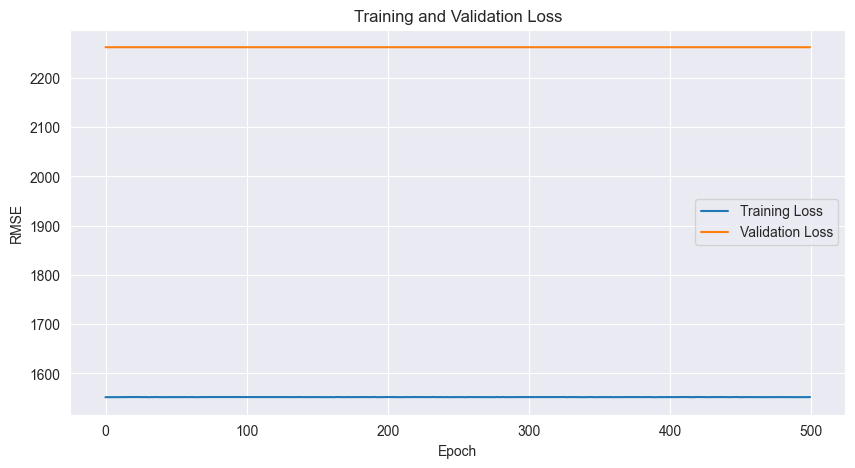

Final validation RMSE: 2262.3560
  Fold 4/5
Input size: 437



  2%|▏         | 8/500 [00:00<00:06, 75.45it/s]

Epoch 0: Train RMSE: 1756.0094, Val RMSE: 2261.7830
Epoch 10: Train RMSE: 1755.9894, Val RMSE: 2261.7773



  9%|▉         | 47/500 [00:00<00:03, 119.94it/s]

Epoch 20: Train RMSE: 1756.0001, Val RMSE: 2261.7766
Epoch 30: Train RMSE: 1755.9749, Val RMSE: 2261.7769
Epoch 40: Train RMSE: 1756.0271, Val RMSE: 2261.7766



 15%|█▍        | 73/500 [00:00<00:03, 115.55it/s]

Epoch 50: Train RMSE: 1755.9960, Val RMSE: 2261.7766
Epoch 60: Train RMSE: 1755.9663, Val RMSE: 2261.7766
Epoch 70: Train RMSE: 1755.9868, Val RMSE: 2261.7769



 20%|█▉        | 99/500 [00:00<00:03, 119.96it/s]

Epoch 80: Train RMSE: 1755.9961, Val RMSE: 2261.7769
Epoch 90: Train RMSE: 1756.0020, Val RMSE: 2261.7769
Epoch 100: Train RMSE: 1756.0122, Val RMSE: 2261.7769



 25%|██▌       | 125/500 [00:01<00:03, 116.11it/s]

Epoch 110: Train RMSE: 1755.9717, Val RMSE: 2261.7769
Epoch 120: Train RMSE: 1756.0311, Val RMSE: 2261.7769
Epoch 130: Train RMSE: 1756.0209, Val RMSE: 2261.7769



 33%|███▎      | 163/500 [00:01<00:02, 122.06it/s]

Epoch 140: Train RMSE: 1756.0359, Val RMSE: 2261.7769
Epoch 150: Train RMSE: 1755.9913, Val RMSE: 2261.7769
Epoch 160: Train RMSE: 1755.9843, Val RMSE: 2261.7769



 35%|███▌      | 176/500 [00:01<00:02, 123.72it/s]

Epoch 170: Train RMSE: 1755.9735, Val RMSE: 2261.7769
Epoch 180: Train RMSE: 1756.1138, Val RMSE: 2261.7769



 43%|████▎     | 215/500 [00:01<00:02, 108.57it/s]

Epoch 190: Train RMSE: 1756.0695, Val RMSE: 2261.7769
Epoch 200: Train RMSE: 1755.9762, Val RMSE: 2261.7769
Epoch 210: Train RMSE: 1755.9998, Val RMSE: 2261.7769



 48%|████▊     | 239/500 [00:02<00:02, 112.18it/s]

Epoch 220: Train RMSE: 1756.0718, Val RMSE: 2261.7769
Epoch 230: Train RMSE: 1756.0563, Val RMSE: 2261.7769
Epoch 240: Train RMSE: 1755.9996, Val RMSE: 2261.7769



 53%|█████▎    | 263/500 [00:02<00:02, 104.67it/s]

Epoch 250: Train RMSE: 1756.0173, Val RMSE: 2261.7769
Epoch 260: Train RMSE: 1755.9913, Val RMSE: 2261.7769



 57%|█████▋    | 285/500 [00:02<00:02, 101.78it/s]

Epoch 270: Train RMSE: 1755.9794, Val RMSE: 2261.7769
Epoch 280: Train RMSE: 1755.9783, Val RMSE: 2261.7769
Epoch 290: Train RMSE: 1755.9678, Val RMSE: 2261.7769



 64%|██████▍   | 319/500 [00:02<00:01, 105.60it/s]

Epoch 300: Train RMSE: 1756.0199, Val RMSE: 2261.7769
Epoch 310: Train RMSE: 1756.0095, Val RMSE: 2261.7769
Epoch 320: Train RMSE: 1756.0854, Val RMSE: 2261.7769



 68%|██████▊   | 342/500 [00:03<00:01, 108.11it/s]

Epoch 330: Train RMSE: 1756.0442, Val RMSE: 2261.7769
Epoch 340: Train RMSE: 1756.0116, Val RMSE: 2261.7769
Epoch 350: Train RMSE: 1756.0243, Val RMSE: 2261.7769



 76%|███████▌  | 378/500 [00:03<00:01, 107.61it/s]

Epoch 360: Train RMSE: 1756.0498, Val RMSE: 2261.7769
Epoch 370: Train RMSE: 1756.0209, Val RMSE: 2261.7769
Epoch 380: Train RMSE: 1756.0713, Val RMSE: 2261.7769



 83%|████████▎ | 413/500 [00:03<00:00, 112.31it/s]

Epoch 390: Train RMSE: 1756.0168, Val RMSE: 2261.7769
Epoch 400: Train RMSE: 1756.0895, Val RMSE: 2261.7769
Epoch 410: Train RMSE: 1756.0729, Val RMSE: 2261.7769



 87%|████████▋ | 437/500 [00:03<00:00, 113.23it/s]

Epoch 420: Train RMSE: 1756.0796, Val RMSE: 2261.7769
Epoch 430: Train RMSE: 1756.0233, Val RMSE: 2261.7769
Epoch 440: Train RMSE: 1755.9662, Val RMSE: 2261.7769



 95%|█████████▌| 476/500 [00:04<00:00, 121.42it/s]

Epoch 450: Train RMSE: 1755.9630, Val RMSE: 2261.7769
Epoch 460: Train RMSE: 1756.0040, Val RMSE: 2261.7769
Epoch 470: Train RMSE: 1755.9801, Val RMSE: 2261.7769



100%|██████████| 500/500 [00:04<00:00, 111.13it/s]

Epoch 480: Train RMSE: 1755.9497, Val RMSE: 2261.7769
Epoch 490: Train RMSE: 1756.0470, Val RMSE: 2261.7769


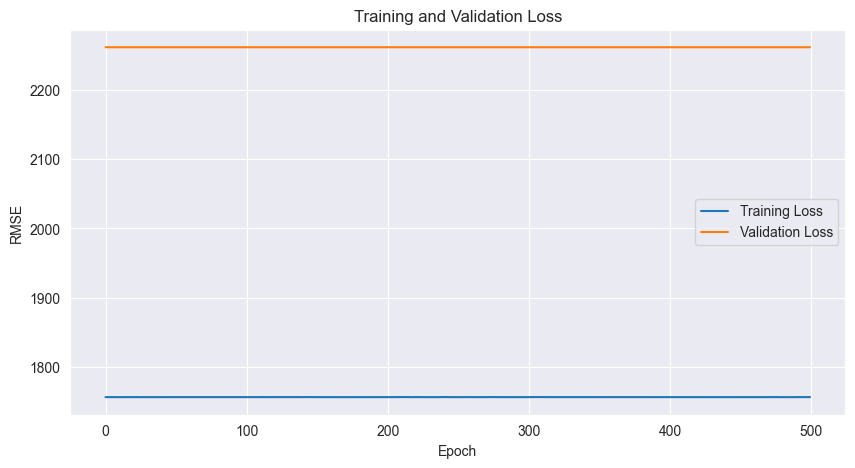

Final validation RMSE: 2261.7747
  Fold 5/5
Input size: 437



  2%|▏         | 9/500 [00:00<00:06, 80.43it/s]

Epoch 0: Train RMSE: 1867.7158, Val RMSE: 2493.2456
Epoch 10: Train RMSE: 1867.7621, Val RMSE: 2493.2261



  6%|▌         | 29/500 [00:00<00:07, 64.25it/s]

Epoch 20: Train RMSE: 1867.6990, Val RMSE: 2493.2444



 10%|█         | 52/500 [00:00<00:05, 87.63it/s]

Epoch 30: Train RMSE: 1867.6157, Val RMSE: 2493.2979
Epoch 40: Train RMSE: 1867.8124, Val RMSE: 2493.2786
Epoch 50: Train RMSE: 1867.6807, Val RMSE: 2493.2422



 15%|█▌        | 75/500 [00:00<00:04, 99.01it/s]

Epoch 60: Train RMSE: 1867.5730, Val RMSE: 2493.2458
Epoch 70: Train RMSE: 1867.7498, Val RMSE: 2493.2664
Epoch 80: Train RMSE: 1867.6603, Val RMSE: 2493.2695



 22%|██▏       | 109/500 [00:01<00:03, 103.45it/s]

Epoch 90: Train RMSE: 1867.6383, Val RMSE: 2493.2693
Epoch 100: Train RMSE: 1867.6782, Val RMSE: 2493.2690
Epoch 110: Train RMSE: 1867.6024, Val RMSE: 2493.2668



 28%|██▊       | 142/500 [00:01<00:03, 107.26it/s]

Epoch 120: Train RMSE: 1867.6351, Val RMSE: 2493.2656
Epoch 130: Train RMSE: 1867.7053, Val RMSE: 2493.2656
Epoch 140: Train RMSE: 1867.6859, Val RMSE: 2493.2659



 33%|███▎      | 164/500 [00:01<00:03, 102.44it/s]

Epoch 150: Train RMSE: 1867.7321, Val RMSE: 2493.2659
Epoch 160: Train RMSE: 1867.5780, Val RMSE: 2493.2659
Epoch 170: Train RMSE: 1867.7582, Val RMSE: 2493.2659



 40%|████      | 200/500 [00:02<00:02, 110.40it/s]

Epoch 180: Train RMSE: 1867.6647, Val RMSE: 2493.2659
Epoch 190: Train RMSE: 1867.6171, Val RMSE: 2493.2659
Epoch 200: Train RMSE: 1867.6282, Val RMSE: 2493.2659



 45%|████▍     | 223/500 [00:02<00:02, 96.47it/s] 

Epoch 210: Train RMSE: 1867.6305, Val RMSE: 2493.2659
Epoch 220: Train RMSE: 1867.7047, Val RMSE: 2493.2659



 47%|████▋     | 234/500 [00:02<00:03, 79.95it/s]

Epoch 230: Train RMSE: 1867.7144, Val RMSE: 2493.2659
Epoch 240: Train RMSE: 1867.6273, Val RMSE: 2493.2659



 53%|█████▎    | 264/500 [00:02<00:02, 88.67it/s]

Epoch 250: Train RMSE: 1867.6643, Val RMSE: 2493.2656
Epoch 260: Train RMSE: 1867.7515, Val RMSE: 2493.2656



 57%|█████▋    | 284/500 [00:03<00:02, 92.14it/s]

Epoch 270: Train RMSE: 1867.7094, Val RMSE: 2493.2656
Epoch 280: Train RMSE: 1867.6334, Val RMSE: 2493.2656



 61%|██████    | 304/500 [00:03<00:02, 89.00it/s]

Epoch 290: Train RMSE: 1867.6676, Val RMSE: 2493.2656
Epoch 300: Train RMSE: 1867.6788, Val RMSE: 2493.2656



 65%|██████▍   | 324/500 [00:03<00:01, 91.56it/s]

Epoch 310: Train RMSE: 1867.7070, Val RMSE: 2493.2654
Epoch 320: Train RMSE: 1867.6620, Val RMSE: 2493.2656



 69%|██████▉   | 344/500 [00:03<00:01, 94.98it/s]

Epoch 330: Train RMSE: 1867.6412, Val RMSE: 2493.2656
Epoch 340: Train RMSE: 1867.5837, Val RMSE: 2493.2656
Epoch 350: Train RMSE: 1867.5486, Val RMSE: 2493.2656



 75%|███████▌  | 377/500 [00:03<00:01, 99.77it/s]

Epoch 360: Train RMSE: 1867.5729, Val RMSE: 2493.2656
Epoch 370: Train RMSE: 1867.6755, Val RMSE: 2493.2656
Epoch 380: Train RMSE: 1867.6945, Val RMSE: 2493.2654



 81%|████████▏ | 407/500 [00:04<00:00, 98.70it/s]

Epoch 390: Train RMSE: 1867.6490, Val RMSE: 2493.2654
Epoch 400: Train RMSE: 1867.7039, Val RMSE: 2493.2654
Epoch 410: Train RMSE: 1867.6815, Val RMSE: 2493.2656



 88%|████████▊ | 440/500 [00:04<00:00, 103.16it/s]

Epoch 420: Train RMSE: 1867.6371, Val RMSE: 2493.2651
Epoch 430: Train RMSE: 1867.6948, Val RMSE: 2493.2654
Epoch 440: Train RMSE: 1867.6788, Val RMSE: 2493.2654



 92%|█████████▏| 461/500 [00:04<00:00, 85.40it/s]

Epoch 450: Train RMSE: 1867.6993, Val RMSE: 2493.2656
Epoch 460: Train RMSE: 1867.6234, Val RMSE: 2493.2654
Epoch 470: Train RMSE: 1867.6582, Val RMSE: 2493.2651



100%|██████████| 500/500 [00:05<00:00, 94.83it/s]

Epoch 480: Train RMSE: 1867.7513, Val RMSE: 2493.2654
Epoch 490: Train RMSE: 1867.6626, Val RMSE: 2493.2654


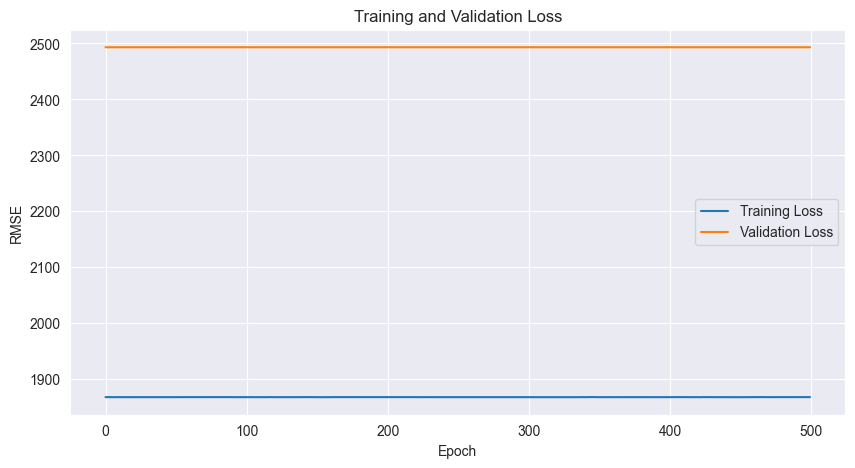

Final validation RMSE: 2493.2229
  Avg RMSE: 2032.3885 ± 417.8031

Testing: hidden_size=32, layers=10, lr=0.001
  Fold 1/5
Input size: 437



  3%|▎         | 17/500 [00:00<00:03, 158.60it/s]

Epoch 0: Train RMSE: 1467.7794, Val RMSE: 1828.9971
Epoch 10: Train RMSE: 1467.9451, Val RMSE: 1829.0142
Epoch 20: Train RMSE: 1467.6991, Val RMSE: 1828.9907



 11%|█         | 54/500 [00:00<00:02, 173.61it/s]

Epoch 30: Train RMSE: 1467.9324, Val RMSE: 1829.0001
Epoch 40: Train RMSE: 1467.8949, Val RMSE: 1828.9995
Epoch 50: Train RMSE: 1467.7786, Val RMSE: 1828.9991
Epoch 60: Train RMSE: 1467.7654, Val RMSE: 1828.9993
Epoch 70: Train RMSE: 1467.7805, Val RMSE: 1828.9995



 24%|██▎       | 118/500 [00:00<00:01, 191.95it/s]

Epoch 80: Train RMSE: 1467.6921, Val RMSE: 1828.9993
Epoch 90: Train RMSE: 1467.8165, Val RMSE: 1828.9995
Epoch 100: Train RMSE: 1467.8059, Val RMSE: 1828.9993
Epoch 110: Train RMSE: 1467.5630, Val RMSE: 1828.9993



 32%|███▏      | 158/500 [00:00<00:01, 191.27it/s]

Epoch 120: Train RMSE: 1467.7585, Val RMSE: 1828.9993
Epoch 130: Train RMSE: 1467.6122, Val RMSE: 1828.9993
Epoch 140: Train RMSE: 1467.7773, Val RMSE: 1828.9993
Epoch 150: Train RMSE: 1468.1221, Val RMSE: 1828.9993



 40%|███▉      | 199/500 [00:01<00:01, 195.69it/s]

Epoch 160: Train RMSE: 1468.0325, Val RMSE: 1828.9993
Epoch 170: Train RMSE: 1467.6461, Val RMSE: 1828.9993
Epoch 180: Train RMSE: 1467.6693, Val RMSE: 1828.9993
Epoch 190: Train RMSE: 1467.6913, Val RMSE: 1828.9993
Epoch 200: Train RMSE: 1467.6418, Val RMSE: 1828.9993



 48%|████▊     | 239/500 [00:01<00:01, 181.16it/s]

Epoch 210: Train RMSE: 1467.8895, Val RMSE: 1828.9993
Epoch 220: Train RMSE: 1467.7971, Val RMSE: 1828.9993
Epoch 230: Train RMSE: 1467.7512, Val RMSE: 1828.9993
Epoch 240: Train RMSE: 1467.5974, Val RMSE: 1828.9993



 56%|█████▌    | 280/500 [00:01<00:01, 191.59it/s]

Epoch 250: Train RMSE: 1467.7344, Val RMSE: 1828.9993
Epoch 260: Train RMSE: 1467.7235, Val RMSE: 1828.9993
Epoch 270: Train RMSE: 1467.8622, Val RMSE: 1828.9993
Epoch 280: Train RMSE: 1467.5211, Val RMSE: 1828.9993
Epoch 290: Train RMSE: 1467.6288, Val RMSE: 1828.9993



 64%|██████▍   | 321/500 [00:01<00:00, 195.91it/s]

Epoch 300: Train RMSE: 1467.7561, Val RMSE: 1828.9993
Epoch 310: Train RMSE: 1467.7736, Val RMSE: 1828.9993
Epoch 320: Train RMSE: 1467.8157, Val RMSE: 1828.9993
Epoch 330: Train RMSE: 1467.9349, Val RMSE: 1828.9993



 72%|███████▏  | 361/500 [00:01<00:00, 183.57it/s]

Epoch 340: Train RMSE: 1467.8385, Val RMSE: 1828.9993
Epoch 350: Train RMSE: 1467.8265, Val RMSE: 1828.9993
Epoch 360: Train RMSE: 1467.8052, Val RMSE: 1828.9993
Epoch 370: Train RMSE: 1467.7655, Val RMSE: 1828.9993
Epoch 380: Train RMSE: 1467.8445, Val RMSE: 1828.9993



 85%|████████▌ | 425/500 [00:02<00:00, 199.23it/s]

Epoch 390: Train RMSE: 1467.7754, Val RMSE: 1828.9993
Epoch 400: Train RMSE: 1467.8461, Val RMSE: 1828.9993
Epoch 410: Train RMSE: 1467.5844, Val RMSE: 1828.9993
Epoch 420: Train RMSE: 1467.7827, Val RMSE: 1828.9993
Epoch 430: Train RMSE: 1467.8087, Val RMSE: 1828.9993



 93%|█████████▎| 466/500 [00:02<00:00, 189.88it/s]

Epoch 440: Train RMSE: 1467.7404, Val RMSE: 1828.9993
Epoch 450: Train RMSE: 1467.9697, Val RMSE: 1828.9993
Epoch 460: Train RMSE: 1467.6874, Val RMSE: 1828.9993
Epoch 470: Train RMSE: 1467.7120, Val RMSE: 1828.9993



100%|██████████| 500/500 [00:02<00:00, 188.47it/s]


Epoch 480: Train RMSE: 1467.9362, Val RMSE: 1828.9993
Epoch 490: Train RMSE: 1467.6188, Val RMSE: 1828.9993


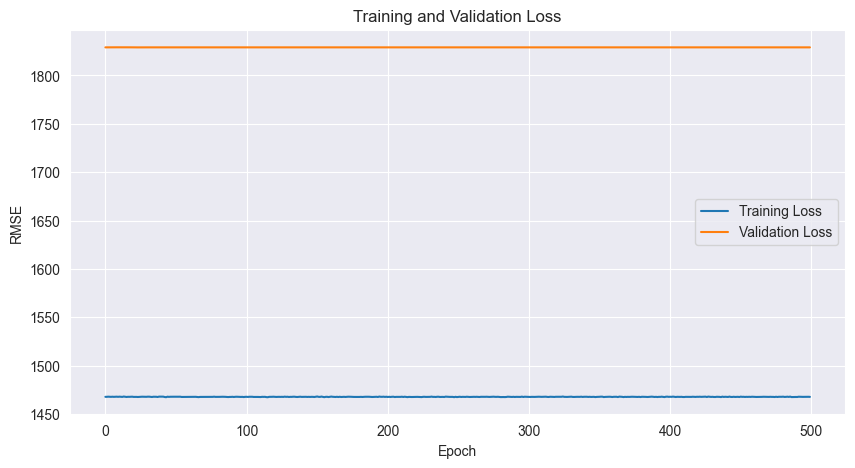

Final validation RMSE: 1828.9642
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.8735, Val RMSE: 1315.7065



  2%|▏         | 12/500 [00:00<00:04, 118.46it/s]

Epoch 10: Train RMSE: 1656.8218, Val RMSE: 1315.6868
Epoch 20: Train RMSE: 1656.8090, Val RMSE: 1315.8651



  5%|▌         | 26/500 [00:00<00:03, 128.83it/s]

Epoch 30: Train RMSE: 1656.5413, Val RMSE: 1315.7528



 11%|█         | 55/500 [00:00<00:03, 136.85it/s]

Epoch 40: Train RMSE: 1656.8024, Val RMSE: 1315.6597
Epoch 50: Train RMSE: 1656.6809, Val RMSE: 1315.6682
Epoch 60: Train RMSE: 1656.7314, Val RMSE: 1315.6918



 16%|█▋        | 82/500 [00:00<00:03, 117.79it/s]

Epoch 70: Train RMSE: 1656.6396, Val RMSE: 1315.6864
Epoch 80: Train RMSE: 1656.7260, Val RMSE: 1315.6691
Epoch 90: Train RMSE: 1656.8038, Val RMSE: 1315.6592



 22%|██▏       | 109/500 [00:00<00:03, 124.42it/s]

Epoch 100: Train RMSE: 1656.7137, Val RMSE: 1315.6530
Epoch 110: Train RMSE: 1656.8425, Val RMSE: 1315.6500
Epoch 120: Train RMSE: 1656.7495, Val RMSE: 1315.6499



 25%|██▌       | 126/500 [00:00<00:02, 137.24it/s]

Epoch 130: Train RMSE: 1656.7643, Val RMSE: 1315.6492



 32%|███▏      | 159/500 [00:01<00:02, 148.58it/s]

Epoch 140: Train RMSE: 1656.8093, Val RMSE: 1315.6490
Epoch 150: Train RMSE: 1656.8679, Val RMSE: 1315.6489
Epoch 160: Train RMSE: 1656.6876, Val RMSE: 1315.6490
Epoch 170: Train RMSE: 1656.7939, Val RMSE: 1315.6490



 38%|███▊      | 190/500 [00:01<00:02, 147.39it/s]

Epoch 180: Train RMSE: 1656.7195, Val RMSE: 1315.6490
Epoch 190: Train RMSE: 1656.6588, Val RMSE: 1315.6492
Epoch 200: Train RMSE: 1656.8384, Val RMSE: 1315.6492



 42%|████▏     | 208/500 [00:01<00:01, 154.87it/s]

Epoch 210: Train RMSE: 1656.7827, Val RMSE: 1315.6492



 48%|████▊     | 240/500 [00:01<00:01, 154.54it/s]

Epoch 220: Train RMSE: 1656.8336, Val RMSE: 1315.6492
Epoch 230: Train RMSE: 1656.6641, Val RMSE: 1315.6490
Epoch 240: Train RMSE: 1656.7369, Val RMSE: 1315.6490
Epoch 250: Train RMSE: 1656.7520, Val RMSE: 1315.6490



 54%|█████▍    | 272/500 [00:01<00:01, 148.21it/s]

Epoch 260: Train RMSE: 1656.8008, Val RMSE: 1315.6490
Epoch 270: Train RMSE: 1656.6794, Val RMSE: 1315.6490



 58%|█████▊    | 289/500 [00:02<00:01, 154.07it/s]

Epoch 280: Train RMSE: 1656.7797, Val RMSE: 1315.6490
Epoch 290: Train RMSE: 1656.6730, Val RMSE: 1315.6490



 61%|██████    | 305/500 [00:02<00:01, 152.93it/s]

Epoch 300: Train RMSE: 1656.5588, Val RMSE: 1315.6490
Epoch 310: Train RMSE: 1656.7756, Val RMSE: 1315.6490



 64%|██████▍   | 321/500 [00:02<00:01, 152.47it/s]

Epoch 320: Train RMSE: 1656.7792, Val RMSE: 1315.6490
Epoch 330: Train RMSE: 1656.6479, Val RMSE: 1315.6490



 67%|██████▋   | 337/500 [00:02<00:01, 153.88it/s]

Epoch 340: Train RMSE: 1656.5934, Val RMSE: 1315.6490



 71%|███████   | 353/500 [00:02<00:01, 144.67it/s]

Epoch 350: Train RMSE: 1656.7133, Val RMSE: 1315.6490
Epoch 360: Train RMSE: 1656.8324, Val RMSE: 1315.6490



 74%|███████▍  | 370/500 [00:02<00:00, 149.79it/s]

Epoch 370: Train RMSE: 1656.7937, Val RMSE: 1315.6490
Epoch 380: Train RMSE: 1656.6719, Val RMSE: 1315.6490



 81%|████████  | 403/500 [00:02<00:00, 155.72it/s]

Epoch 390: Train RMSE: 1656.6072, Val RMSE: 1315.6490
Epoch 400: Train RMSE: 1656.6799, Val RMSE: 1315.6490



 84%|████████▍ | 420/500 [00:02<00:00, 159.59it/s]

Epoch 410: Train RMSE: 1656.9232, Val RMSE: 1315.6490
Epoch 420: Train RMSE: 1656.7386, Val RMSE: 1315.6490



 87%|████████▋ | 437/500 [00:03<00:00, 148.70it/s]

Epoch 430: Train RMSE: 1656.7570, Val RMSE: 1315.6490



 91%|█████████ | 453/500 [00:03<00:00, 150.45it/s]

Epoch 440: Train RMSE: 1656.8195, Val RMSE: 1315.6490
Epoch 450: Train RMSE: 1656.6962, Val RMSE: 1315.6490



 94%|█████████▍| 469/500 [00:03<00:00, 151.31it/s]

Epoch 460: Train RMSE: 1656.8624, Val RMSE: 1315.6490
Epoch 470: Train RMSE: 1656.7806, Val RMSE: 1315.6490



 97%|█████████▋| 485/500 [00:03<00:00, 151.06it/s]

Epoch 480: Train RMSE: 1656.7268, Val RMSE: 1315.6490


100%|██████████| 500/500 [00:03<00:00, 145.83it/s]

Epoch 490: Train RMSE: 1656.8097, Val RMSE: 1315.6490


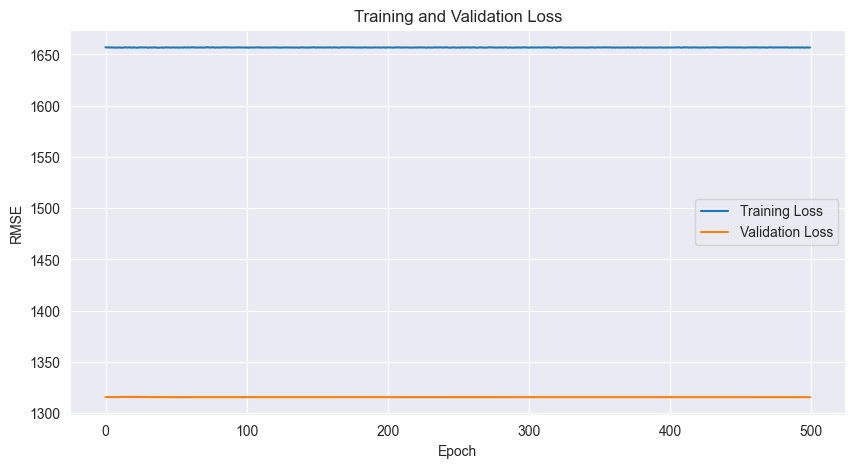

Final validation RMSE: 1315.5935
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1552.1274, Val RMSE: 2262.3909



  2%|▏         | 11/500 [00:00<00:04, 100.51it/s]

Epoch 10: Train RMSE: 1551.9911, Val RMSE: 2262.4517
Epoch 20: Train RMSE: 1551.9060, Val RMSE: 2262.3979



  7%|▋         | 33/500 [00:00<00:05, 79.11it/s] 

Epoch 30: Train RMSE: 1552.0841, Val RMSE: 2262.3894



  8%|▊         | 42/500 [00:00<00:05, 80.33it/s]

Epoch 40: Train RMSE: 1552.1158, Val RMSE: 2262.3425



 10%|█         | 51/500 [00:00<00:05, 78.14it/s]

Epoch 50: Train RMSE: 1552.0153, Val RMSE: 2262.3147



 12%|█▏        | 59/500 [00:00<00:06, 71.88it/s]

Epoch 60: Train RMSE: 1552.0331, Val RMSE: 2262.3005



 17%|█▋        | 87/500 [00:00<00:04, 102.83it/s]

Epoch 70: Train RMSE: 1551.9990, Val RMSE: 2262.3074
Epoch 80: Train RMSE: 1551.8481, Val RMSE: 2262.3096
Epoch 90: Train RMSE: 1551.9858, Val RMSE: 2262.3079



 23%|██▎       | 113/500 [00:01<00:03, 113.01it/s]

Epoch 100: Train RMSE: 1552.1055, Val RMSE: 2262.3062
Epoch 110: Train RMSE: 1551.9656, Val RMSE: 2262.3057
Epoch 120: Train RMSE: 1551.9490, Val RMSE: 2262.3054



 28%|██▊       | 140/500 [00:01<00:02, 122.04it/s]

Epoch 130: Train RMSE: 1552.0936, Val RMSE: 2262.3052
Epoch 140: Train RMSE: 1551.9257, Val RMSE: 2262.3049



 31%|███       | 154/500 [00:01<00:02, 125.43it/s]

Epoch 150: Train RMSE: 1551.9777, Val RMSE: 2262.3049



 34%|███▎      | 168/500 [00:01<00:02, 128.17it/s]

Epoch 160: Train RMSE: 1552.0984, Val RMSE: 2262.3049
Epoch 170: Train RMSE: 1552.0667, Val RMSE: 2262.3049



 36%|███▌      | 181/500 [00:01<00:02, 126.95it/s]

Epoch 180: Train RMSE: 1551.9011, Val RMSE: 2262.3049



 39%|███▉      | 194/500 [00:01<00:02, 122.36it/s]

Epoch 190: Train RMSE: 1551.9958, Val RMSE: 2262.3049
Epoch 200: Train RMSE: 1551.9194, Val RMSE: 2262.3049



 42%|████▏     | 208/500 [00:01<00:02, 125.50it/s]

Epoch 210: Train RMSE: 1551.9857, Val RMSE: 2262.3049



 47%|████▋     | 236/500 [00:02<00:02, 131.30it/s]

Epoch 220: Train RMSE: 1552.0676, Val RMSE: 2262.3049
Epoch 230: Train RMSE: 1551.8701, Val RMSE: 2262.3049
Epoch 240: Train RMSE: 1551.9276, Val RMSE: 2262.3049



 53%|█████▎    | 265/500 [00:02<00:01, 129.02it/s]

Epoch 250: Train RMSE: 1551.9960, Val RMSE: 2262.3049
Epoch 260: Train RMSE: 1551.8328, Val RMSE: 2262.3049
Epoch 270: Train RMSE: 1552.1310, Val RMSE: 2262.3049



 59%|█████▉    | 295/500 [00:02<00:01, 137.01it/s]

Epoch 280: Train RMSE: 1551.9602, Val RMSE: 2262.3049
Epoch 290: Train RMSE: 1552.1493, Val RMSE: 2262.3049



 62%|██████▏   | 310/500 [00:02<00:01, 138.29it/s]

Epoch 300: Train RMSE: 1552.1296, Val RMSE: 2262.3049



 65%|██████▌   | 325/500 [00:02<00:01, 140.45it/s]

Epoch 310: Train RMSE: 1552.0391, Val RMSE: 2262.3049
Epoch 320: Train RMSE: 1551.9536, Val RMSE: 2262.3049
Epoch 330: Train RMSE: 1551.9946, Val RMSE: 2262.3049



 68%|██████▊   | 340/500 [00:02<00:01, 132.10it/s]

Epoch 340: Train RMSE: 1552.1077, Val RMSE: 2262.3049



 71%|███████   | 354/500 [00:03<00:01, 103.92it/s]

Epoch 350: Train RMSE: 1552.0992, Val RMSE: 2262.3049



 73%|███████▎  | 366/500 [00:03<00:01, 104.74it/s]

Epoch 360: Train RMSE: 1552.0569, Val RMSE: 2262.3049



 76%|███████▌  | 378/500 [00:03<00:01, 106.36it/s]

Epoch 370: Train RMSE: 1552.0544, Val RMSE: 2262.3049
Epoch 380: Train RMSE: 1552.0927, Val RMSE: 2262.3049



 78%|███████▊  | 390/500 [00:03<00:01, 105.61it/s]

Epoch 390: Train RMSE: 1552.0243, Val RMSE: 2262.3049



 83%|████████▎ | 414/500 [00:03<00:00, 110.65it/s]

Epoch 400: Train RMSE: 1552.0692, Val RMSE: 2262.3049
Epoch 410: Train RMSE: 1552.0469, Val RMSE: 2262.3049
Epoch 420: Train RMSE: 1551.9946, Val RMSE: 2262.3049



 88%|████████▊ | 439/500 [00:03<00:00, 114.35it/s]

Epoch 430: Train RMSE: 1552.0747, Val RMSE: 2262.3049
Epoch 440: Train RMSE: 1552.0024, Val RMSE: 2262.3049



 90%|█████████ | 451/500 [00:03<00:00, 112.39it/s]

Epoch 450: Train RMSE: 1552.0029, Val RMSE: 2262.3049



 93%|█████████▎| 463/500 [00:04<00:00, 111.65it/s]

Epoch 460: Train RMSE: 1552.0609, Val RMSE: 2262.3049
Epoch 470: Train RMSE: 1551.9817, Val RMSE: 2262.3049



 95%|█████████▌| 475/500 [00:04<00:00, 113.87it/s]

Epoch 480: Train RMSE: 1551.9362, Val RMSE: 2262.3049



100%|██████████| 500/500 [00:04<00:00, 113.85it/s]

Epoch 490: Train RMSE: 1552.0299, Val RMSE: 2262.3049


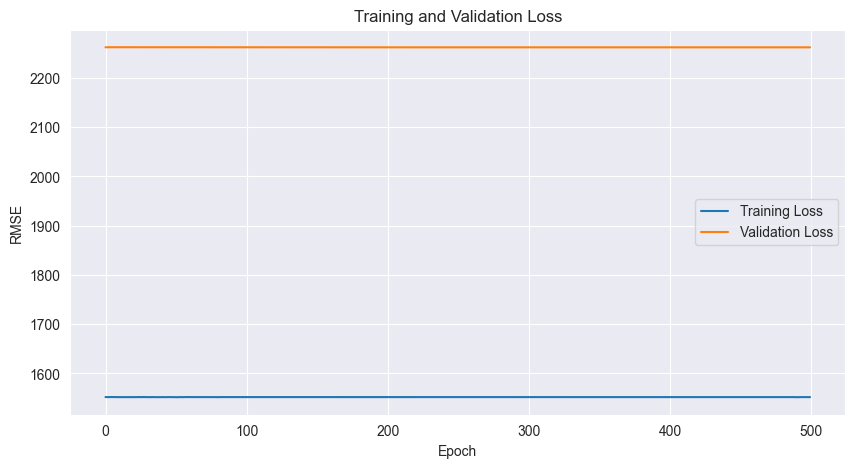

Final validation RMSE: 2262.3005
  Fold 4/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1755.9304, Val RMSE: 2261.7825



  2%|▏         | 8/500 [00:00<00:06, 76.72it/s]

Epoch 10: Train RMSE: 1755.9379, Val RMSE: 2261.8354



  6%|▌         | 31/500 [00:00<00:04, 101.87it/s]

Epoch 20: Train RMSE: 1755.8175, Val RMSE: 2261.8350
Epoch 30: Train RMSE: 1755.7848, Val RMSE: 2261.8457



  9%|▊         | 43/500 [00:00<00:04, 107.20it/s]

Epoch 40: Train RMSE: 1755.9133, Val RMSE: 2261.7949



 11%|█         | 55/500 [00:00<00:04, 108.96it/s]

Epoch 50: Train RMSE: 1755.8585, Val RMSE: 2261.7959
Epoch 60: Train RMSE: 1755.7284, Val RMSE: 2261.8250



 13%|█▎        | 66/500 [00:00<00:04, 107.97it/s]

Epoch 70: Train RMSE: 1755.9272, Val RMSE: 2261.8252



 18%|█▊        | 90/500 [00:00<00:03, 110.62it/s]

Epoch 80: Train RMSE: 1755.9144, Val RMSE: 2261.8821
Epoch 90: Train RMSE: 1755.7694, Val RMSE: 2261.8821



 21%|██        | 103/500 [00:00<00:03, 115.26it/s]

Epoch 100: Train RMSE: 1755.9081, Val RMSE: 2261.8821
Epoch 110: Train RMSE: 1755.8735, Val RMSE: 2261.8821



 23%|██▎       | 115/500 [00:01<00:04, 91.10it/s] 

Epoch 120: Train RMSE: 1755.8701, Val RMSE: 2261.8257



 28%|██▊       | 138/500 [00:01<00:03, 99.91it/s]

Epoch 130: Train RMSE: 1755.9192, Val RMSE: 2261.8257
Epoch 140: Train RMSE: 1755.8433, Val RMSE: 2261.8254



 30%|██▉       | 149/500 [00:01<00:03, 101.73it/s]

Epoch 150: Train RMSE: 1755.8696, Val RMSE: 2261.8257



 32%|███▏      | 160/500 [00:01<00:03, 101.62it/s]

Epoch 160: Train RMSE: 1755.8796, Val RMSE: 2261.8257



 34%|███▍      | 171/500 [00:01<00:03, 96.22it/s] 

Epoch 170: Train RMSE: 1755.6841, Val RMSE: 2261.8254



 36%|███▌      | 181/500 [00:01<00:03, 90.23it/s]

Epoch 180: Train RMSE: 1755.8362, Val RMSE: 2261.8254



 38%|███▊      | 191/500 [00:01<00:03, 89.92it/s]

Epoch 190: Train RMSE: 1756.0009, Val RMSE: 2261.8254



 40%|████      | 201/500 [00:02<00:03, 92.22it/s]

Epoch 200: Train RMSE: 1755.9756, Val RMSE: 2261.8254
Epoch 210: Train RMSE: 1755.7045, Val RMSE: 2261.8254



 47%|████▋     | 233/500 [00:02<00:02, 96.88it/s]

Epoch 220: Train RMSE: 1755.8080, Val RMSE: 2261.8254
Epoch 230: Train RMSE: 1755.9060, Val RMSE: 2261.8254
Epoch 240: Train RMSE: 1755.8302, Val RMSE: 2261.8254



 53%|█████▎    | 267/500 [00:02<00:02, 103.98it/s]

Epoch 250: Train RMSE: 1755.8779, Val RMSE: 2261.8257
Epoch 260: Train RMSE: 1755.8856, Val RMSE: 2261.8257
Epoch 270: Train RMSE: 1755.8563, Val RMSE: 2261.8257



 60%|██████    | 301/500 [00:02<00:01, 108.12it/s]

Epoch 280: Train RMSE: 1755.8359, Val RMSE: 2261.8257
Epoch 290: Train RMSE: 1755.8822, Val RMSE: 2261.8257
Epoch 300: Train RMSE: 1755.8918, Val RMSE: 2261.8257



 65%|██████▍   | 324/500 [00:03<00:01, 110.64it/s]

Epoch 310: Train RMSE: 1755.8883, Val RMSE: 2261.8257
Epoch 320: Train RMSE: 1755.8954, Val RMSE: 2261.8257
Epoch 330: Train RMSE: 1755.9142, Val RMSE: 2261.8257



 72%|███████▏  | 361/500 [00:03<00:01, 114.92it/s]

Epoch 340: Train RMSE: 1755.9797, Val RMSE: 2261.8257
Epoch 350: Train RMSE: 1755.8898, Val RMSE: 2261.8257
Epoch 360: Train RMSE: 1755.9597, Val RMSE: 2261.8257



 77%|███████▋  | 385/500 [00:03<00:00, 117.10it/s]

Epoch 370: Train RMSE: 1755.8285, Val RMSE: 2261.8257
Epoch 380: Train RMSE: 1755.9305, Val RMSE: 2261.8257
Epoch 390: Train RMSE: 1755.9890, Val RMSE: 2261.8257



 84%|████████▍ | 422/500 [00:04<00:00, 117.21it/s]

Epoch 400: Train RMSE: 1755.8140, Val RMSE: 2261.8257
Epoch 410: Train RMSE: 1755.8210, Val RMSE: 2261.8257
Epoch 420: Train RMSE: 1755.8098, Val RMSE: 2261.8257



 89%|████████▉ | 446/500 [00:04<00:00, 116.09it/s]

Epoch 430: Train RMSE: 1755.8503, Val RMSE: 2261.8257
Epoch 440: Train RMSE: 1755.8580, Val RMSE: 2261.8257
Epoch 450: Train RMSE: 1755.7590, Val RMSE: 2261.8257



 97%|█████████▋| 483/500 [00:04<00:00, 113.78it/s]

Epoch 460: Train RMSE: 1755.8048, Val RMSE: 2261.8257
Epoch 470: Train RMSE: 1755.8662, Val RMSE: 2261.8257
Epoch 480: Train RMSE: 1755.8416, Val RMSE: 2261.8257



100%|██████████| 500/500 [00:04<00:00, 106.34it/s]


Epoch 490: Train RMSE: 1755.7504, Val RMSE: 2261.8257


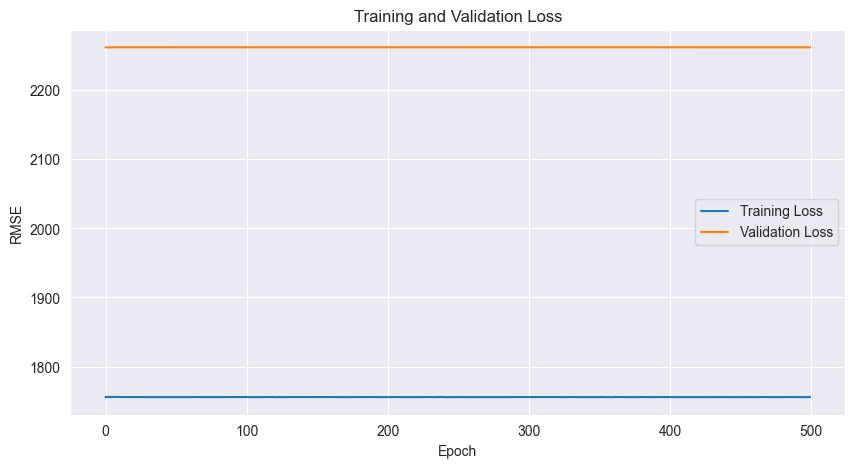

Final validation RMSE: 2261.7341
  Fold 5/5
Input size: 437



  2%|▏         | 8/500 [00:00<00:06, 76.51it/s]

Epoch 0: Train RMSE: 1867.5918, Val RMSE: 2493.3479
Epoch 10: Train RMSE: 1867.6628, Val RMSE: 2493.3457



  8%|▊         | 40/500 [00:00<00:04, 101.61it/s]

Epoch 20: Train RMSE: 1867.5757, Val RMSE: 2493.4226
Epoch 30: Train RMSE: 1867.6843, Val RMSE: 2493.4092
Epoch 40: Train RMSE: 1867.5814, Val RMSE: 2493.4231



 12%|█▏        | 62/500 [00:00<00:04, 102.99it/s]

Epoch 50: Train RMSE: 1867.6245, Val RMSE: 2493.4380
Epoch 60: Train RMSE: 1867.5974, Val RMSE: 2493.4341
Epoch 70: Train RMSE: 1867.5823, Val RMSE: 2493.4338



 19%|█▉        | 96/500 [00:00<00:03, 105.02it/s]

Epoch 80: Train RMSE: 1867.5897, Val RMSE: 2493.4346
Epoch 90: Train RMSE: 1867.5763, Val RMSE: 2493.4346
Epoch 100: Train RMSE: 1867.5583, Val RMSE: 2493.4348



 26%|██▌       | 129/500 [00:01<00:03, 101.92it/s]

Epoch 110: Train RMSE: 1867.5328, Val RMSE: 2493.4351
Epoch 120: Train RMSE: 1867.5913, Val RMSE: 2493.4351
Epoch 130: Train RMSE: 1867.6019, Val RMSE: 2493.4351



 33%|███▎      | 163/500 [00:01<00:03, 105.12it/s]

Epoch 140: Train RMSE: 1867.4927, Val RMSE: 2493.4351
Epoch 150: Train RMSE: 1867.5341, Val RMSE: 2493.4351
Epoch 160: Train RMSE: 1867.5991, Val RMSE: 2493.4351



 37%|███▋      | 186/500 [00:01<00:02, 106.26it/s]

Epoch 170: Train RMSE: 1867.4928, Val RMSE: 2493.4351
Epoch 180: Train RMSE: 1867.6312, Val RMSE: 2493.4351



 42%|████▏     | 208/500 [00:02<00:03, 88.24it/s]

Epoch 190: Train RMSE: 1867.6133, Val RMSE: 2493.4351
Epoch 200: Train RMSE: 1867.5989, Val RMSE: 2493.4351
Epoch 210: Train RMSE: 1867.5099, Val RMSE: 2493.4351



 48%|████▊     | 239/500 [00:02<00:02, 93.61it/s]

Epoch 220: Train RMSE: 1867.5978, Val RMSE: 2493.4351
Epoch 230: Train RMSE: 1867.5820, Val RMSE: 2493.4351



 52%|█████▏    | 260/500 [00:02<00:02, 94.69it/s]

Epoch 240: Train RMSE: 1867.6371, Val RMSE: 2493.4351
Epoch 250: Train RMSE: 1867.6775, Val RMSE: 2493.4351



 54%|█████▍    | 270/500 [00:02<00:02, 93.59it/s]

Epoch 260: Train RMSE: 1867.5906, Val RMSE: 2493.4351
Epoch 270: Train RMSE: 1867.6432, Val RMSE: 2493.4351



 58%|█████▊    | 290/500 [00:03<00:02, 89.89it/s]

Epoch 280: Train RMSE: 1867.6190, Val RMSE: 2493.4351
Epoch 290: Train RMSE: 1867.5365, Val RMSE: 2493.4351



 62%|██████▏   | 311/500 [00:03<00:02, 93.65it/s]

Epoch 300: Train RMSE: 1867.5726, Val RMSE: 2493.4351
Epoch 310: Train RMSE: 1867.6328, Val RMSE: 2493.4351



 66%|██████▌   | 331/500 [00:03<00:01, 91.72it/s]

Epoch 320: Train RMSE: 1867.5795, Val RMSE: 2493.4351
Epoch 330: Train RMSE: 1867.5659, Val RMSE: 2493.4351



 70%|███████   | 351/500 [00:03<00:01, 89.70it/s]

Epoch 340: Train RMSE: 1867.6292, Val RMSE: 2493.4351
Epoch 350: Train RMSE: 1867.6667, Val RMSE: 2493.4351



 74%|███████▍  | 372/500 [00:03<00:01, 95.34it/s]

Epoch 360: Train RMSE: 1867.5544, Val RMSE: 2493.4351
Epoch 370: Train RMSE: 1867.5143, Val RMSE: 2493.4351
Epoch 380: Train RMSE: 1867.6868, Val RMSE: 2493.4351



 79%|███████▉  | 396/500 [00:04<00:01, 80.27it/s] 

Epoch 390: Train RMSE: 1867.5453, Val RMSE: 2493.4351
Epoch 400: Train RMSE: 1867.5420, Val RMSE: 2493.4351



 86%|████████▌ | 429/500 [00:04<00:00, 97.05it/s]

Epoch 410: Train RMSE: 1867.5853, Val RMSE: 2493.4351
Epoch 420: Train RMSE: 1867.6454, Val RMSE: 2493.4351
Epoch 430: Train RMSE: 1867.5979, Val RMSE: 2493.4351



 90%|█████████ | 451/500 [00:04<00:00, 96.60it/s]

Epoch 440: Train RMSE: 1867.5868, Val RMSE: 2493.4351
Epoch 450: Train RMSE: 1867.5604, Val RMSE: 2493.4351
Epoch 460: Train RMSE: 1867.6113, Val RMSE: 2493.4351



 97%|█████████▋| 485/500 [00:05<00:00, 101.72it/s]

Epoch 470: Train RMSE: 1867.5480, Val RMSE: 2493.4351
Epoch 480: Train RMSE: 1867.6027, Val RMSE: 2493.4351
Epoch 490: Train RMSE: 1867.5352, Val RMSE: 2493.4351



100%|██████████| 500/500 [00:05<00:00, 96.15it/s] 


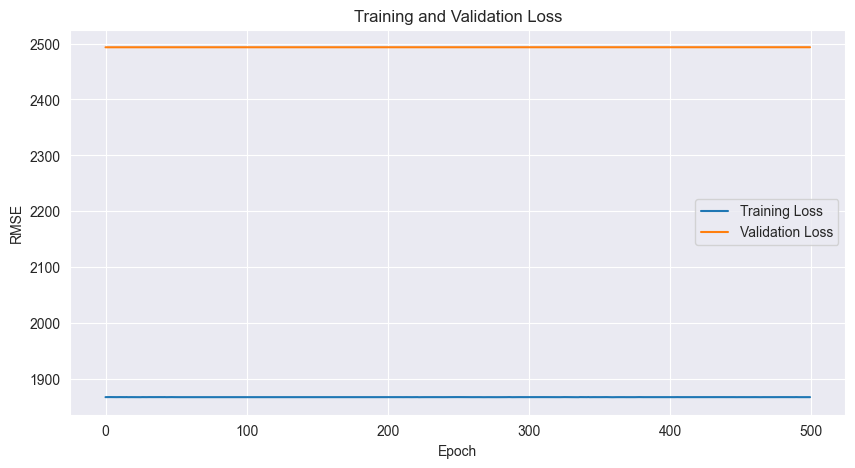

Final validation RMSE: 2493.3081
  Avg RMSE: 2032.3801 ± 417.8714

Testing: hidden_size=32, layers=10, lr=0.01
  Fold 1/5
Input size: 437



  2%|▏         | 11/500 [00:00<00:04, 106.60it/s]

Epoch 0: Train RMSE: 1467.8864, Val RMSE: 1829.1434
Epoch 10: Train RMSE: 1467.9601, Val RMSE: 1828.7567
Epoch 20: Train RMSE: 1467.7821, Val RMSE: 1828.9883



 14%|█▍        | 70/500 [00:00<00:02, 183.79it/s]

Epoch 30: Train RMSE: 1467.6885, Val RMSE: 1829.0029
Epoch 40: Train RMSE: 1467.8429, Val RMSE: 1829.0048
Epoch 50: Train RMSE: 1467.6505, Val RMSE: 1829.0055
Epoch 60: Train RMSE: 1467.6497, Val RMSE: 1829.0063
Epoch 70: Train RMSE: 1467.8564, Val RMSE: 1829.0089



 22%|██▏       | 108/500 [00:00<00:02, 174.51it/s]

Epoch 80: Train RMSE: 1467.8903, Val RMSE: 1829.0100
Epoch 90: Train RMSE: 1467.6593, Val RMSE: 1829.0104
Epoch 100: Train RMSE: 1467.7369, Val RMSE: 1829.0114
Epoch 110: Train RMSE: 1467.6407, Val RMSE: 1829.0117



 29%|██▉       | 145/500 [00:00<00:02, 175.23it/s]

Epoch 120: Train RMSE: 1467.8131, Val RMSE: 1829.0120
Epoch 130: Train RMSE: 1467.7913, Val RMSE: 1829.0121
Epoch 140: Train RMSE: 1467.7817, Val RMSE: 1829.0121
Epoch 150: Train RMSE: 1467.7660, Val RMSE: 1829.0121



 37%|███▋      | 184/500 [00:01<00:01, 179.67it/s]

Epoch 160: Train RMSE: 1467.8572, Val RMSE: 1829.0121
Epoch 170: Train RMSE: 1467.6379, Val RMSE: 1829.0121
Epoch 180: Train RMSE: 1467.8701, Val RMSE: 1829.0121
Epoch 190: Train RMSE: 1467.8772, Val RMSE: 1829.0121



 44%|████▍     | 222/500 [00:01<00:01, 178.74it/s]

Epoch 200: Train RMSE: 1467.7223, Val RMSE: 1829.0121
Epoch 210: Train RMSE: 1467.8016, Val RMSE: 1829.0121
Epoch 220: Train RMSE: 1467.8531, Val RMSE: 1829.0121
Epoch 230: Train RMSE: 1467.6532, Val RMSE: 1829.0121



 52%|█████▏    | 262/500 [00:01<00:01, 187.42it/s]

Epoch 240: Train RMSE: 1467.8739, Val RMSE: 1829.0121
Epoch 250: Train RMSE: 1467.4679, Val RMSE: 1829.0121
Epoch 260: Train RMSE: 1467.7394, Val RMSE: 1829.0121
Epoch 270: Train RMSE: 1467.6718, Val RMSE: 1829.0122



 60%|██████    | 302/500 [00:01<00:01, 172.98it/s]

Epoch 280: Train RMSE: 1467.7938, Val RMSE: 1829.0122
Epoch 290: Train RMSE: 1467.8517, Val RMSE: 1829.0122
Epoch 300: Train RMSE: 1467.5811, Val RMSE: 1829.0122



 67%|██████▋   | 337/500 [00:01<00:00, 163.95it/s]

Epoch 310: Train RMSE: 1467.5530, Val RMSE: 1829.0122
Epoch 320: Train RMSE: 1467.8275, Val RMSE: 1829.0122
Epoch 330: Train RMSE: 1467.6830, Val RMSE: 1829.0122
Epoch 340: Train RMSE: 1467.7986, Val RMSE: 1829.0121



 75%|███████▌  | 376/500 [00:02<00:00, 176.81it/s]

Epoch 350: Train RMSE: 1467.5962, Val RMSE: 1829.0121
Epoch 360: Train RMSE: 1467.7432, Val RMSE: 1829.0121
Epoch 370: Train RMSE: 1467.4493, Val RMSE: 1829.0121
Epoch 380: Train RMSE: 1467.6921, Val RMSE: 1829.0121



 82%|████████▏ | 412/500 [00:02<00:00, 162.56it/s]

Epoch 390: Train RMSE: 1467.7469, Val RMSE: 1829.0121
Epoch 400: Train RMSE: 1467.8535, Val RMSE: 1829.0121
Epoch 410: Train RMSE: 1467.7540, Val RMSE: 1829.0121
Epoch 420: Train RMSE: 1467.5714, Val RMSE: 1829.0121



 93%|█████████▎| 463/500 [00:02<00:00, 160.68it/s]

Epoch 430: Train RMSE: 1467.7329, Val RMSE: 1829.0121
Epoch 440: Train RMSE: 1467.4478, Val RMSE: 1829.0121
Epoch 450: Train RMSE: 1467.7306, Val RMSE: 1829.0121
Epoch 460: Train RMSE: 1467.8416, Val RMSE: 1829.0121



100%|██████████| 500/500 [00:02<00:00, 168.89it/s]

Epoch 470: Train RMSE: 1467.7611, Val RMSE: 1829.0121
Epoch 480: Train RMSE: 1467.6351, Val RMSE: 1829.0121
Epoch 490: Train RMSE: 1467.6243, Val RMSE: 1829.0121


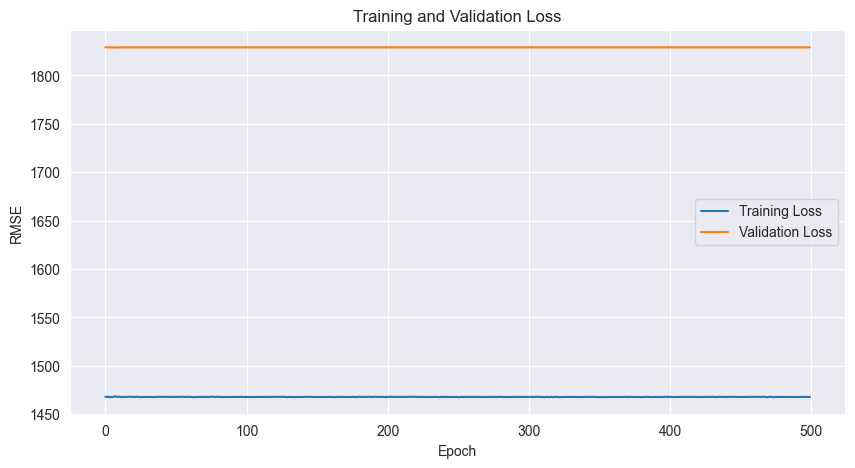

Final validation RMSE: 1828.7567
  Fold 2/5
Input size: 437



  2%|▏         | 10/500 [00:00<00:04, 98.23it/s]

Epoch 0: Train RMSE: 1656.7510, Val RMSE: 1315.9154
Epoch 10: Train RMSE: 1656.7449, Val RMSE: 1315.6974
Epoch 20: Train RMSE: 1656.7369, Val RMSE: 1315.7781



 10%|█         | 52/500 [00:00<00:03, 131.63it/s]

Epoch 30: Train RMSE: 1656.6267, Val RMSE: 1315.8759
Epoch 40: Train RMSE: 1656.7955, Val RMSE: 1315.8612
Epoch 50: Train RMSE: 1656.6688, Val RMSE: 1315.8644



 16%|█▌        | 81/500 [00:00<00:03, 130.68it/s]

Epoch 60: Train RMSE: 1656.6987, Val RMSE: 1315.8711
Epoch 70: Train RMSE: 1656.7061, Val RMSE: 1315.8768
Epoch 80: Train RMSE: 1656.8201, Val RMSE: 1315.8770



 22%|██▏       | 109/500 [00:00<00:02, 131.11it/s]

Epoch 90: Train RMSE: 1656.7198, Val RMSE: 1315.8760
Epoch 100: Train RMSE: 1656.7089, Val RMSE: 1315.8762
Epoch 110: Train RMSE: 1656.5793, Val RMSE: 1315.8766



 28%|██▊       | 138/500 [00:01<00:02, 137.46it/s]

Epoch 120: Train RMSE: 1656.6096, Val RMSE: 1315.8768
Epoch 130: Train RMSE: 1656.8273, Val RMSE: 1315.8770
Epoch 140: Train RMSE: 1656.7418, Val RMSE: 1315.8770
Epoch 150: Train RMSE: 1656.8979, Val RMSE: 1315.8770



 38%|███▊      | 188/500 [00:01<00:01, 156.70it/s]

Epoch 160: Train RMSE: 1656.6519, Val RMSE: 1315.8770
Epoch 170: Train RMSE: 1656.8278, Val RMSE: 1315.8770
Epoch 180: Train RMSE: 1657.0066, Val RMSE: 1315.8770
Epoch 190: Train RMSE: 1656.6841, Val RMSE: 1315.8770



 44%|████▍     | 221/500 [00:01<00:01, 150.78it/s]

Epoch 200: Train RMSE: 1656.7416, Val RMSE: 1315.8770
Epoch 210: Train RMSE: 1656.6803, Val RMSE: 1315.8770
Epoch 220: Train RMSE: 1656.5713, Val RMSE: 1315.8770
Epoch 230: Train RMSE: 1656.6879, Val RMSE: 1315.8770



 55%|█████▍    | 273/500 [00:01<00:01, 161.99it/s]

Epoch 240: Train RMSE: 1656.6602, Val RMSE: 1315.8770
Epoch 250: Train RMSE: 1656.7692, Val RMSE: 1315.8770
Epoch 260: Train RMSE: 1656.7805, Val RMSE: 1315.8770
Epoch 270: Train RMSE: 1656.6930, Val RMSE: 1315.8770



 58%|█████▊    | 290/500 [00:02<00:01, 120.58it/s]

Epoch 280: Train RMSE: 1656.5898, Val RMSE: 1315.8770
Epoch 290: Train RMSE: 1656.6965, Val RMSE: 1315.8770



 64%|██████▍   | 322/500 [00:02<00:01, 135.65it/s]

Epoch 300: Train RMSE: 1656.7622, Val RMSE: 1315.8770
Epoch 310: Train RMSE: 1656.8114, Val RMSE: 1315.8770
Epoch 320: Train RMSE: 1656.7029, Val RMSE: 1315.8770
Epoch 330: Train RMSE: 1656.6116, Val RMSE: 1315.8770



 71%|███████   | 355/500 [00:02<00:01, 137.38it/s]

Epoch 340: Train RMSE: 1656.6444, Val RMSE: 1315.8770
Epoch 350: Train RMSE: 1656.6429, Val RMSE: 1315.8770
Epoch 360: Train RMSE: 1656.7303, Val RMSE: 1315.8770



 78%|███████▊  | 389/500 [00:02<00:00, 138.30it/s]

Epoch 370: Train RMSE: 1656.5839, Val RMSE: 1315.8770
Epoch 380: Train RMSE: 1656.5975, Val RMSE: 1315.8770
Epoch 390: Train RMSE: 1656.7781, Val RMSE: 1315.8770



 84%|████████▍ | 421/500 [00:03<00:00, 145.55it/s]

Epoch 400: Train RMSE: 1656.7815, Val RMSE: 1315.8770
Epoch 410: Train RMSE: 1656.8551, Val RMSE: 1315.8770
Epoch 420: Train RMSE: 1656.6218, Val RMSE: 1315.8770
Epoch 430: Train RMSE: 1656.5883, Val RMSE: 1315.8770



 94%|█████████▍| 470/500 [00:03<00:00, 151.32it/s]

Epoch 440: Train RMSE: 1656.4868, Val RMSE: 1315.8770
Epoch 450: Train RMSE: 1656.6273, Val RMSE: 1315.8770
Epoch 460: Train RMSE: 1656.6663, Val RMSE: 1315.8770
Epoch 470: Train RMSE: 1656.7451, Val RMSE: 1315.8770



100%|██████████| 500/500 [00:03<00:00, 141.65it/s]


Epoch 480: Train RMSE: 1656.8165, Val RMSE: 1315.8770
Epoch 490: Train RMSE: 1656.9379, Val RMSE: 1315.8770


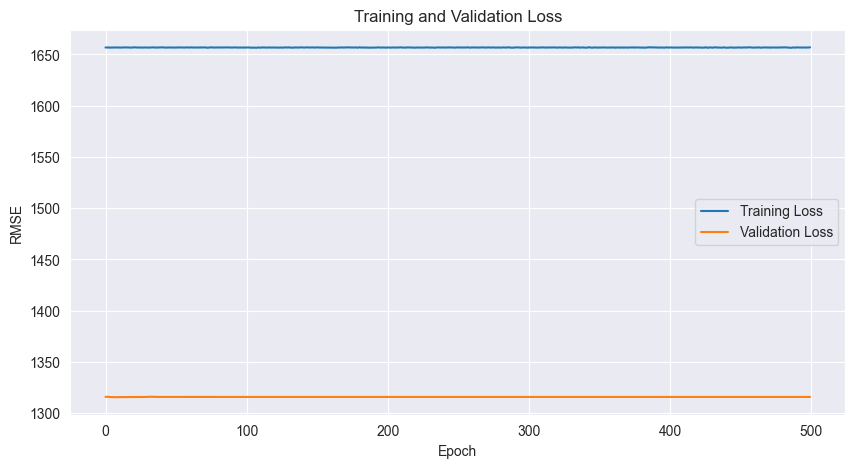

Final validation RMSE: 1315.5951
  Fold 3/5
Input size: 437



  2%|▏         | 10/500 [00:00<00:05, 95.01it/s]

Epoch 0: Train RMSE: 1552.1714, Val RMSE: 2262.4631
Epoch 10: Train RMSE: 1552.0062, Val RMSE: 2262.2278



  6%|▌         | 29/500 [00:00<00:05, 86.16it/s]

Epoch 20: Train RMSE: 1551.8936, Val RMSE: 2261.4077
Epoch 30: Train RMSE: 1551.8745, Val RMSE: 2260.9412
Epoch 40: Train RMSE: 1551.8220, Val RMSE: 2260.7751



 12%|█▏        | 61/500 [00:00<00:05, 82.83it/s]

Epoch 50: Train RMSE: 1551.6101, Val RMSE: 2260.6052
Epoch 60: Train RMSE: 1551.4803, Val RMSE: 2260.3252



 16%|█▌        | 78/500 [00:00<00:05, 74.32it/s]

Epoch 70: Train RMSE: 1551.7084, Val RMSE: 2260.0798
Epoch 80: Train RMSE: 1551.6021, Val RMSE: 2259.9097



 20%|██        | 102/500 [00:01<00:05, 71.84it/s]

Epoch 90: Train RMSE: 1551.6829, Val RMSE: 2259.8044
Epoch 100: Train RMSE: 1551.4380, Val RMSE: 2259.7039



 25%|██▌       | 126/500 [00:01<00:05, 65.97it/s]

Epoch 110: Train RMSE: 1551.6688, Val RMSE: 2259.6655
Epoch 120: Train RMSE: 1551.5569, Val RMSE: 2259.6458



 28%|██▊       | 142/500 [00:01<00:04, 71.61it/s]

Epoch 130: Train RMSE: 1551.5985, Val RMSE: 2259.6326
Epoch 140: Train RMSE: 1551.4745, Val RMSE: 2259.6211



 33%|███▎      | 167/500 [00:02<00:04, 78.57it/s]

Epoch 150: Train RMSE: 1551.3677, Val RMSE: 2259.6152
Epoch 160: Train RMSE: 1551.4574, Val RMSE: 2259.6116



 37%|███▋      | 187/500 [00:02<00:03, 89.13it/s]

Epoch 170: Train RMSE: 1551.4180, Val RMSE: 2259.6094
Epoch 180: Train RMSE: 1551.4702, Val RMSE: 2259.6082
Epoch 190: Train RMSE: 1551.6917, Val RMSE: 2259.6079



 46%|████▌     | 228/500 [00:02<00:02, 118.90it/s]

Epoch 200: Train RMSE: 1551.5405, Val RMSE: 2259.6074
Epoch 210: Train RMSE: 1551.3353, Val RMSE: 2259.6072
Epoch 220: Train RMSE: 1551.3884, Val RMSE: 2259.6072



 51%|█████     | 254/500 [00:02<00:02, 118.13it/s]

Epoch 230: Train RMSE: 1551.6202, Val RMSE: 2259.6072
Epoch 240: Train RMSE: 1551.2510, Val RMSE: 2259.6072
Epoch 250: Train RMSE: 1551.4789, Val RMSE: 2259.6072



 56%|█████▌    | 281/500 [00:03<00:01, 125.19it/s]

Epoch 260: Train RMSE: 1551.7623, Val RMSE: 2259.6072
Epoch 270: Train RMSE: 1551.1525, Val RMSE: 2259.6072
Epoch 280: Train RMSE: 1551.4435, Val RMSE: 2259.6072



 59%|█████▉    | 296/500 [00:03<00:01, 130.68it/s]

Epoch 290: Train RMSE: 1551.6030, Val RMSE: 2259.6072
Epoch 300: Train RMSE: 1551.3738, Val RMSE: 2259.6072



 68%|██████▊   | 340/500 [00:03<00:01, 121.23it/s]

Epoch 310: Train RMSE: 1551.3014, Val RMSE: 2259.6072
Epoch 320: Train RMSE: 1551.3916, Val RMSE: 2259.6072
Epoch 330: Train RMSE: 1551.8086, Val RMSE: 2259.6072



 71%|███████   | 355/500 [00:03<00:01, 126.82it/s]

Epoch 340: Train RMSE: 1551.4722, Val RMSE: 2259.6072
Epoch 350: Train RMSE: 1551.8022, Val RMSE: 2259.6072
Epoch 360: Train RMSE: 1551.4182, Val RMSE: 2259.6072



 77%|███████▋  | 384/500 [00:04<00:00, 125.79it/s]

Epoch 370: Train RMSE: 1551.6613, Val RMSE: 2259.6072
Epoch 380: Train RMSE: 1551.7903, Val RMSE: 2259.6072
Epoch 390: Train RMSE: 1551.5948, Val RMSE: 2259.6072



 86%|████████▌ | 430/500 [00:04<00:00, 139.53it/s]

Epoch 400: Train RMSE: 1551.2190, Val RMSE: 2259.6072
Epoch 410: Train RMSE: 1551.1888, Val RMSE: 2259.6072
Epoch 420: Train RMSE: 1551.7979, Val RMSE: 2259.6072



 89%|████████▉ | 445/500 [00:04<00:00, 141.53it/s]

Epoch 430: Train RMSE: 1551.6129, Val RMSE: 2259.6072
Epoch 440: Train RMSE: 1551.7529, Val RMSE: 2259.6072
Epoch 450: Train RMSE: 1551.4862, Val RMSE: 2259.6072



 95%|█████████▍| 474/500 [00:04<00:00, 133.13it/s]

Epoch 460: Train RMSE: 1551.2598, Val RMSE: 2259.6072
Epoch 470: Train RMSE: 1551.1787, Val RMSE: 2259.6072
Epoch 480: Train RMSE: 1551.4828, Val RMSE: 2259.6072



100%|██████████| 500/500 [00:04<00:00, 101.18it/s]


Epoch 490: Train RMSE: 1551.7294, Val RMSE: 2259.6072


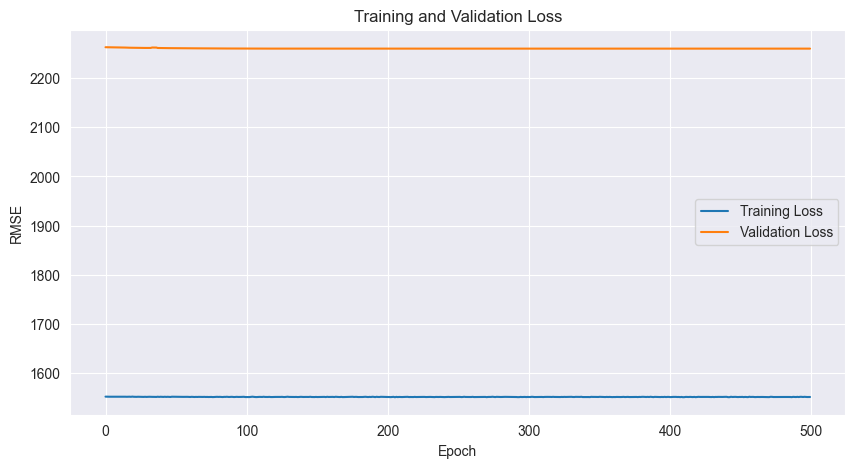

Final validation RMSE: 2259.6072
  Fold 4/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1755.9510, Val RMSE: 2261.8247



  2%|▏         | 10/500 [00:00<00:05, 90.89it/s]

Epoch 10: Train RMSE: 1755.7986, Val RMSE: 2261.8386



  7%|▋         | 33/500 [00:00<00:04, 107.89it/s]

Epoch 20: Train RMSE: 1755.7164, Val RMSE: 2261.8721
Epoch 30: Train RMSE: 1755.6182, Val RMSE: 2261.8821



  9%|▉         | 46/500 [00:00<00:03, 116.25it/s]

Epoch 40: Train RMSE: 1755.6786, Val RMSE: 2261.8894



 12%|█▏        | 59/500 [00:00<00:03, 117.87it/s]

Epoch 50: Train RMSE: 1755.5217, Val RMSE: 2261.8928
Epoch 60: Train RMSE: 1755.6143, Val RMSE: 2261.8945



 14%|█▍        | 71/500 [00:00<00:03, 112.18it/s]

Epoch 70: Train RMSE: 1755.5237, Val RMSE: 2261.8948



 17%|█▋        | 83/500 [00:00<00:03, 112.43it/s]

Epoch 80: Train RMSE: 1755.6259, Val RMSE: 2261.8960
Epoch 90: Train RMSE: 1755.4751, Val RMSE: 2261.8965



 19%|█▉        | 95/500 [00:00<00:03, 113.17it/s]

Epoch 100: Train RMSE: 1755.4547, Val RMSE: 2261.8970



 24%|██▍       | 119/500 [00:01<00:03, 115.04it/s]

Epoch 110: Train RMSE: 1755.5930, Val RMSE: 2261.8967
Epoch 120: Train RMSE: 1755.6399, Val RMSE: 2261.8970



 26%|██▌       | 131/500 [00:01<00:03, 115.38it/s]

Epoch 130: Train RMSE: 1755.5372, Val RMSE: 2261.8970



 29%|██▊       | 143/500 [00:01<00:03, 111.22it/s]

Epoch 140: Train RMSE: 1755.6147, Val RMSE: 2261.8970
Epoch 150: Train RMSE: 1755.6139, Val RMSE: 2261.8970



 31%|███       | 155/500 [00:01<00:03, 112.38it/s]

Epoch 160: Train RMSE: 1755.4901, Val RMSE: 2261.8970



 36%|███▌      | 180/500 [00:01<00:02, 117.51it/s]

Epoch 170: Train RMSE: 1755.6565, Val RMSE: 2261.8970
Epoch 180: Train RMSE: 1755.6006, Val RMSE: 2261.8970



 38%|███▊      | 192/500 [00:01<00:02, 117.59it/s]

Epoch 190: Train RMSE: 1755.5009, Val RMSE: 2261.8970



 41%|████      | 204/500 [00:01<00:02, 113.03it/s]

Epoch 200: Train RMSE: 1755.6733, Val RMSE: 2261.8970
Epoch 210: Train RMSE: 1755.6442, Val RMSE: 2261.8970



 43%|████▎     | 216/500 [00:01<00:02, 113.41it/s]

Epoch 220: Train RMSE: 1755.5311, Val RMSE: 2261.8970



 48%|████▊     | 240/500 [00:02<00:02, 113.14it/s]

Epoch 230: Train RMSE: 1755.4541, Val RMSE: 2261.8970
Epoch 240: Train RMSE: 1755.5112, Val RMSE: 2261.8970



 51%|█████     | 253/500 [00:02<00:02, 116.61it/s]

Epoch 250: Train RMSE: 1755.5625, Val RMSE: 2261.8970



 53%|█████▎    | 265/500 [00:02<00:02, 110.38it/s]

Epoch 260: Train RMSE: 1755.6217, Val RMSE: 2261.8970
Epoch 270: Train RMSE: 1755.5457, Val RMSE: 2261.8970



 60%|██████    | 300/500 [00:02<00:01, 107.72it/s]

Epoch 280: Train RMSE: 1755.5339, Val RMSE: 2261.8970
Epoch 290: Train RMSE: 1755.5698, Val RMSE: 2261.8970
Epoch 300: Train RMSE: 1755.5322, Val RMSE: 2261.8970



 64%|██████▍   | 322/500 [00:02<00:01, 90.93it/s]

Epoch 310: Train RMSE: 1755.5868, Val RMSE: 2261.8970
Epoch 320: Train RMSE: 1755.4763, Val RMSE: 2261.8970
Epoch 330: Train RMSE: 1755.5283, Val RMSE: 2261.8970



 71%|███████   | 356/500 [00:03<00:01, 100.66it/s]

Epoch 340: Train RMSE: 1755.5649, Val RMSE: 2261.8970
Epoch 350: Train RMSE: 1755.6515, Val RMSE: 2261.8970
Epoch 360: Train RMSE: 1755.6180, Val RMSE: 2261.8970



 78%|███████▊  | 390/500 [00:03<00:01, 105.04it/s]

Epoch 370: Train RMSE: 1755.4114, Val RMSE: 2261.8970
Epoch 380: Train RMSE: 1755.3704, Val RMSE: 2261.8970
Epoch 390: Train RMSE: 1755.6063, Val RMSE: 2261.8970



 82%|████████▏ | 412/500 [00:03<00:00, 106.01it/s]

Epoch 400: Train RMSE: 1755.6476, Val RMSE: 2261.8970
Epoch 410: Train RMSE: 1755.4362, Val RMSE: 2261.8970
Epoch 420: Train RMSE: 1755.5966, Val RMSE: 2261.8970



 90%|████████▉ | 449/500 [00:04<00:00, 111.53it/s]

Epoch 430: Train RMSE: 1755.5016, Val RMSE: 2261.8970
Epoch 440: Train RMSE: 1755.3850, Val RMSE: 2261.8970
Epoch 450: Train RMSE: 1755.6562, Val RMSE: 2261.8970



 95%|█████████▍| 473/500 [00:04<00:00, 113.37it/s]

Epoch 460: Train RMSE: 1755.6661, Val RMSE: 2261.8970
Epoch 470: Train RMSE: 1755.6254, Val RMSE: 2261.8970
Epoch 480: Train RMSE: 1755.5122, Val RMSE: 2261.8970



100%|██████████| 500/500 [00:04<00:00, 108.63it/s]


Epoch 490: Train RMSE: 1755.5237, Val RMSE: 2261.8970


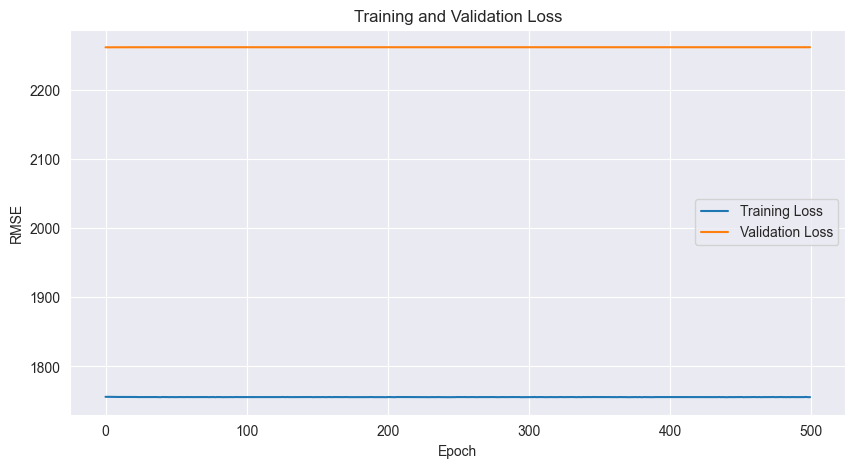

Final validation RMSE: 2261.7419
  Fold 5/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1867.6045, Val RMSE: 2493.3005



  2%|▏         | 8/500 [00:00<00:06, 78.85it/s]

Epoch 10: Train RMSE: 1867.5704, Val RMSE: 2493.3752



  6%|▌         | 29/500 [00:00<00:04, 97.80it/s]

Epoch 20: Train RMSE: 1867.6021, Val RMSE: 2493.4172
Epoch 30: Train RMSE: 1867.6511, Val RMSE: 2493.4429



  8%|▊         | 40/500 [00:00<00:04, 98.72it/s]

Epoch 40: Train RMSE: 1867.5028, Val RMSE: 2493.4568



 12%|█▏        | 60/500 [00:00<00:04, 97.36it/s]

Epoch 50: Train RMSE: 1867.5902, Val RMSE: 2493.4648



 14%|█▍        | 71/500 [00:00<00:04, 100.73it/s]

Epoch 60: Train RMSE: 1867.5116, Val RMSE: 2493.4692
Epoch 70: Train RMSE: 1867.4373, Val RMSE: 2493.4717



 16%|█▋        | 82/500 [00:00<00:04, 102.31it/s]

Epoch 80: Train RMSE: 1867.4971, Val RMSE: 2493.4727
Epoch 90: Train RMSE: 1867.5682, Val RMSE: 2493.4734



 21%|██        | 104/500 [00:01<00:04, 86.03it/s]

Epoch 100: Train RMSE: 1867.4105, Val RMSE: 2493.4736
Epoch 110: Train RMSE: 1867.5225, Val RMSE: 2493.4739



 23%|██▎       | 115/500 [00:01<00:04, 92.03it/s]

Epoch 120: Train RMSE: 1867.5812, Val RMSE: 2493.4739



 27%|██▋       | 137/500 [00:01<00:03, 99.20it/s]

Epoch 130: Train RMSE: 1867.4918, Val RMSE: 2493.4739
Epoch 140: Train RMSE: 1867.4506, Val RMSE: 2493.4739



 34%|███▍      | 171/500 [00:01<00:03, 102.92it/s]

Epoch 150: Train RMSE: 1867.5476, Val RMSE: 2493.4739
Epoch 160: Train RMSE: 1867.4780, Val RMSE: 2493.4739
Epoch 170: Train RMSE: 1867.5535, Val RMSE: 2493.4739



 39%|███▉      | 194/500 [00:01<00:02, 105.92it/s]

Epoch 180: Train RMSE: 1867.4095, Val RMSE: 2493.4739
Epoch 190: Train RMSE: 1867.5479, Val RMSE: 2493.4739
Epoch 200: Train RMSE: 1867.5441, Val RMSE: 2493.4739



 46%|████▌     | 228/500 [00:02<00:02, 104.44it/s]

Epoch 210: Train RMSE: 1867.6527, Val RMSE: 2493.4739
Epoch 220: Train RMSE: 1867.4982, Val RMSE: 2493.4739
Epoch 230: Train RMSE: 1867.5237, Val RMSE: 2493.4739



 52%|█████▏    | 262/500 [00:02<00:02, 106.77it/s]

Epoch 240: Train RMSE: 1867.5856, Val RMSE: 2493.4739
Epoch 250: Train RMSE: 1867.4797, Val RMSE: 2493.4739
Epoch 260: Train RMSE: 1867.5504, Val RMSE: 2493.4739



 57%|█████▋    | 284/500 [00:02<00:02, 100.68it/s]

Epoch 270: Train RMSE: 1867.3687, Val RMSE: 2493.4739
Epoch 280: Train RMSE: 1867.5004, Val RMSE: 2493.4739
Epoch 290: Train RMSE: 1867.4856, Val RMSE: 2493.4739



 63%|██████▎   | 316/500 [00:03<00:02, 82.93it/s]

Epoch 300: Train RMSE: 1867.5315, Val RMSE: 2493.4739
Epoch 310: Train RMSE: 1867.5349, Val RMSE: 2493.4739



 67%|██████▋   | 337/500 [00:03<00:01, 89.68it/s]

Epoch 320: Train RMSE: 1867.5505, Val RMSE: 2493.4739
Epoch 330: Train RMSE: 1867.5031, Val RMSE: 2493.4739
Epoch 340: Train RMSE: 1867.5211, Val RMSE: 2493.4739



 74%|███████▎  | 368/500 [00:03<00:01, 94.25it/s]

Epoch 350: Train RMSE: 1867.5627, Val RMSE: 2493.4739
Epoch 360: Train RMSE: 1867.5879, Val RMSE: 2493.4739



 78%|███████▊  | 388/500 [00:04<00:01, 94.18it/s]

Epoch 370: Train RMSE: 1867.4137, Val RMSE: 2493.4739
Epoch 380: Train RMSE: 1867.4429, Val RMSE: 2493.4739



 82%|████████▏ | 408/500 [00:04<00:01, 91.16it/s]

Epoch 390: Train RMSE: 1867.4373, Val RMSE: 2493.4739
Epoch 400: Train RMSE: 1867.4243, Val RMSE: 2493.4739



 86%|████████▌ | 428/500 [00:04<00:00, 90.47it/s]

Epoch 410: Train RMSE: 1867.5601, Val RMSE: 2493.4739
Epoch 420: Train RMSE: 1867.4635, Val RMSE: 2493.4739



 90%|████████▉ | 449/500 [00:04<00:00, 94.90it/s]

Epoch 430: Train RMSE: 1867.4563, Val RMSE: 2493.4739
Epoch 440: Train RMSE: 1867.4670, Val RMSE: 2493.4739



 92%|█████████▏| 459/500 [00:04<00:00, 94.26it/s]

Epoch 450: Train RMSE: 1867.5098, Val RMSE: 2493.4739
Epoch 460: Train RMSE: 1867.5725, Val RMSE: 2493.4739



 98%|█████████▊| 489/500 [00:05<00:00, 92.31it/s]

Epoch 470: Train RMSE: 1867.4700, Val RMSE: 2493.4739
Epoch 480: Train RMSE: 1867.4232, Val RMSE: 2493.4739



100%|██████████| 500/500 [00:05<00:00, 94.99it/s]

Epoch 490: Train RMSE: 1867.5610, Val RMSE: 2493.4739


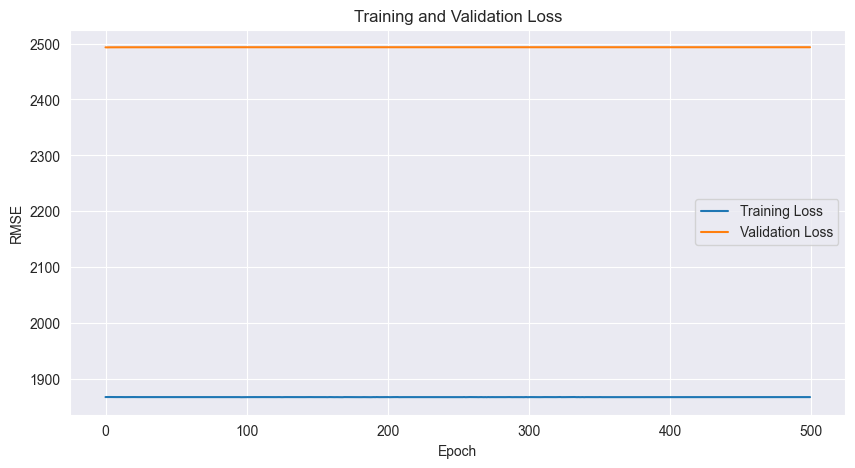

Final validation RMSE: 2493.1794
  Avg RMSE: 2031.7761 ± 417.5683
  New best model found!

Testing: hidden_size=64, layers=2, lr=0.0001
  Fold 1/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1467.8495, Val RMSE: 1829.0500
Epoch 10: Train RMSE: 1467.8300, Val RMSE: 1829.0588



 10%|█         | 51/500 [00:00<00:00, 506.30it/s]

Epoch 20: Train RMSE: 1467.7596, Val RMSE: 1829.0647
Epoch 30: Train RMSE: 1467.7977, Val RMSE: 1829.0675
Epoch 40: Train RMSE: 1467.7910, Val RMSE: 1829.0690
Epoch 50: Train RMSE: 1467.7515, Val RMSE: 1829.0699
Epoch 60: Train RMSE: 1467.7668, Val RMSE: 1829.0704
Epoch 70: Train RMSE: 1467.7013, Val RMSE: 1829.0706
Epoch 80: Train RMSE: 1467.7013, Val RMSE: 1829.0707
Epoch 90: Train RMSE: 1467.7692, Val RMSE: 1829.0709
Epoch 100: Train RMSE: 1467.7252, Val RMSE: 1829.0709



 21%|██        | 105/500 [00:00<00:00, 526.05it/s]

Epoch 110: Train RMSE: 1467.7205, Val RMSE: 1829.0709
Epoch 120: Train RMSE: 1467.8568, Val RMSE: 1829.0709



 45%|████▌     | 227/500 [00:00<00:00, 584.97it/s]

Epoch 130: Train RMSE: 1467.7037, Val RMSE: 1829.0709
Epoch 140: Train RMSE: 1467.9122, Val RMSE: 1829.0709
Epoch 150: Train RMSE: 1467.7494, Val RMSE: 1829.0709
Epoch 160: Train RMSE: 1467.7437, Val RMSE: 1829.0709
Epoch 170: Train RMSE: 1467.8468, Val RMSE: 1829.0709
Epoch 180: Train RMSE: 1467.7560, Val RMSE: 1829.0709
Epoch 190: Train RMSE: 1467.8048, Val RMSE: 1829.0709
Epoch 200: Train RMSE: 1467.7745, Val RMSE: 1829.0709
Epoch 210: Train RMSE: 1467.7767, Val RMSE: 1829.0709
Epoch 220: Train RMSE: 1467.8257, Val RMSE: 1829.0709
Epoch 230: Train RMSE: 1467.7246, Val RMSE: 1829.0709
Epoch 240: Train RMSE: 1467.7799, Val RMSE: 1829.0709
Epoch 250: Train RMSE: 1467.7017, Val RMSE: 1829.0709



 70%|██████▉   | 348/500 [00:00<00:00, 564.90it/s]

Epoch 260: Train RMSE: 1467.7025, Val RMSE: 1829.0709
Epoch 270: Train RMSE: 1467.8383, Val RMSE: 1829.0709
Epoch 280: Train RMSE: 1467.8673, Val RMSE: 1829.0709
Epoch 290: Train RMSE: 1467.7935, Val RMSE: 1829.0709
Epoch 300: Train RMSE: 1467.7523, Val RMSE: 1829.0709
Epoch 310: Train RMSE: 1467.8434, Val RMSE: 1829.0709
Epoch 320: Train RMSE: 1467.8610, Val RMSE: 1829.0709
Epoch 330: Train RMSE: 1467.7245, Val RMSE: 1829.0709
Epoch 340: Train RMSE: 1467.7394, Val RMSE: 1829.0709
Epoch 350: Train RMSE: 1467.7388, Val RMSE: 1829.0709
Epoch 360: Train RMSE: 1467.6171, Val RMSE: 1829.0709



 92%|█████████▏| 462/500 [00:00<00:00, 543.04it/s]

Epoch 370: Train RMSE: 1467.7725, Val RMSE: 1829.0709
Epoch 380: Train RMSE: 1467.7489, Val RMSE: 1829.0709
Epoch 390: Train RMSE: 1467.7075, Val RMSE: 1829.0709
Epoch 400: Train RMSE: 1467.7817, Val RMSE: 1829.0709
Epoch 410: Train RMSE: 1467.5695, Val RMSE: 1829.0709
Epoch 420: Train RMSE: 1467.8616, Val RMSE: 1829.0709
Epoch 430: Train RMSE: 1467.7213, Val RMSE: 1829.0709
Epoch 440: Train RMSE: 1467.8334, Val RMSE: 1829.0709
Epoch 450: Train RMSE: 1467.8102, Val RMSE: 1829.0709
Epoch 460: Train RMSE: 1467.7993, Val RMSE: 1829.0709
Epoch 470: Train RMSE: 1467.7399, Val RMSE: 1829.0709


100%|██████████| 500/500 [00:00<00:00, 552.02it/s]


Epoch 480: Train RMSE: 1467.6633, Val RMSE: 1829.0709
Epoch 490: Train RMSE: 1467.7430, Val RMSE: 1829.0709


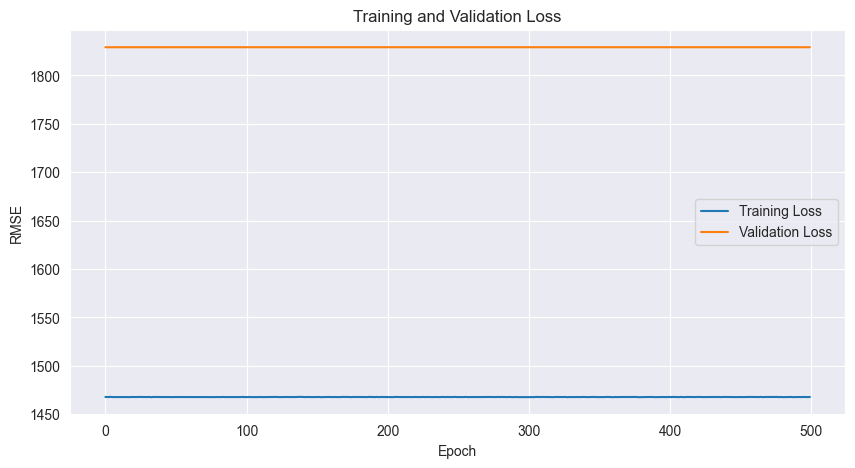

Final validation RMSE: 1829.0500
  Fold 2/5
Input size: 437



  8%|▊         | 40/500 [00:00<00:01, 397.78it/s]

Epoch 0: Train RMSE: 1656.7751, Val RMSE: 1315.7675
Epoch 10: Train RMSE: 1656.8948, Val RMSE: 1315.7726
Epoch 20: Train RMSE: 1656.8663, Val RMSE: 1315.7697
Epoch 30: Train RMSE: 1656.8602, Val RMSE: 1315.7660
Epoch 40: Train RMSE: 1656.8163, Val RMSE: 1315.7638
Epoch 50: Train RMSE: 1656.8938, Val RMSE: 1315.7633
Epoch 60: Train RMSE: 1656.8826, Val RMSE: 1315.7628
Epoch 70: Train RMSE: 1656.9836, Val RMSE: 1315.7626



 16%|█▌        | 81/500 [00:00<00:01, 404.74it/s]

Epoch 80: Train RMSE: 1656.8613, Val RMSE: 1315.7625



 25%|██▌       | 126/500 [00:00<00:00, 422.55it/s]

Epoch 90: Train RMSE: 1656.7909, Val RMSE: 1315.7623
Epoch 100: Train RMSE: 1656.8374, Val RMSE: 1315.7623
Epoch 110: Train RMSE: 1656.8042, Val RMSE: 1315.7623
Epoch 120: Train RMSE: 1656.8160, Val RMSE: 1315.7623
Epoch 130: Train RMSE: 1656.8146, Val RMSE: 1315.7623
Epoch 140: Train RMSE: 1656.8450, Val RMSE: 1315.7623
Epoch 150: Train RMSE: 1656.8038, Val RMSE: 1315.7623
Epoch 160: Train RMSE: 1656.7324, Val RMSE: 1315.7623
Epoch 170: Train RMSE: 1656.7577, Val RMSE: 1315.7623



 35%|███▌      | 177/500 [00:00<00:00, 454.50it/s]

Epoch 180: Train RMSE: 1656.7021, Val RMSE: 1315.7623



 54%|█████▍    | 272/500 [00:00<00:00, 460.15it/s]

Epoch 190: Train RMSE: 1656.9084, Val RMSE: 1315.7623
Epoch 200: Train RMSE: 1657.0261, Val RMSE: 1315.7623
Epoch 210: Train RMSE: 1656.7825, Val RMSE: 1315.7623
Epoch 220: Train RMSE: 1656.7023, Val RMSE: 1315.7623
Epoch 230: Train RMSE: 1656.7256, Val RMSE: 1315.7623
Epoch 240: Train RMSE: 1656.8273, Val RMSE: 1315.7623
Epoch 250: Train RMSE: 1656.7229, Val RMSE: 1315.7623
Epoch 260: Train RMSE: 1656.7924, Val RMSE: 1315.7623
Epoch 270: Train RMSE: 1656.8387, Val RMSE: 1315.7623
Epoch 280: Train RMSE: 1656.8561, Val RMSE: 1315.7623



 73%|███████▎  | 365/500 [00:00<00:00, 449.56it/s]

Epoch 290: Train RMSE: 1656.9598, Val RMSE: 1315.7623
Epoch 300: Train RMSE: 1656.7506, Val RMSE: 1315.7623
Epoch 310: Train RMSE: 1656.7921, Val RMSE: 1315.7623
Epoch 320: Train RMSE: 1656.8011, Val RMSE: 1315.7623
Epoch 330: Train RMSE: 1656.8395, Val RMSE: 1315.7623
Epoch 340: Train RMSE: 1656.7667, Val RMSE: 1315.7623
Epoch 350: Train RMSE: 1656.8154, Val RMSE: 1315.7623
Epoch 360: Train RMSE: 1656.8580, Val RMSE: 1315.7623
Epoch 370: Train RMSE: 1656.7961, Val RMSE: 1315.7623
Epoch 380: Train RMSE: 1656.7712, Val RMSE: 1315.7623



 93%|█████████▎| 467/500 [00:01<00:00, 476.43it/s]

Epoch 390: Train RMSE: 1656.8173, Val RMSE: 1315.7623
Epoch 400: Train RMSE: 1656.7946, Val RMSE: 1315.7623
Epoch 410: Train RMSE: 1656.8224, Val RMSE: 1315.7623
Epoch 420: Train RMSE: 1656.8395, Val RMSE: 1315.7623
Epoch 430: Train RMSE: 1656.7167, Val RMSE: 1315.7623
Epoch 440: Train RMSE: 1656.7642, Val RMSE: 1315.7623
Epoch 450: Train RMSE: 1656.7937, Val RMSE: 1315.7623
Epoch 460: Train RMSE: 1656.8271, Val RMSE: 1315.7623
Epoch 470: Train RMSE: 1656.7896, Val RMSE: 1315.7622
Epoch 480: Train RMSE: 1656.8682, Val RMSE: 1315.7622
Epoch 490: Train RMSE: 1656.9296, Val RMSE: 1315.7622


100%|██████████| 500/500 [00:01<00:00, 457.54it/s]


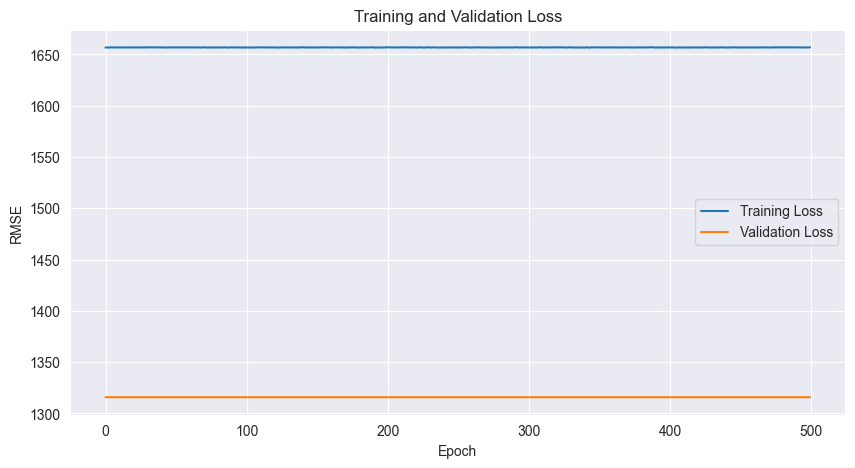

Final validation RMSE: 1315.7590
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1552.0293, Val RMSE: 2262.3474
Epoch 10: Train RMSE: 1551.9519, Val RMSE: 2262.4980
Epoch 20: Train RMSE: 1552.0227, Val RMSE: 2262.4915



  8%|▊         | 39/500 [00:00<00:01, 381.02it/s]

Epoch 30: Train RMSE: 1552.0436, Val RMSE: 2262.4873
Epoch 40: Train RMSE: 1551.9629, Val RMSE: 2262.4849
Epoch 50: Train RMSE: 1552.1526, Val RMSE: 2262.4839
Epoch 60: Train RMSE: 1552.0458, Val RMSE: 2262.4834
Epoch 70: Train RMSE: 1552.0513, Val RMSE: 2262.4832



 16%|█▌        | 78/500 [00:00<00:01, 356.97it/s]

Epoch 80: Train RMSE: 1551.9696, Val RMSE: 2262.4832
Epoch 90: Train RMSE: 1552.0768, Val RMSE: 2262.4829
Epoch 100: Train RMSE: 1551.9448, Val RMSE: 2262.4827



 24%|██▍       | 121/500 [00:00<00:00, 386.21it/s]

Epoch 110: Train RMSE: 1551.9608, Val RMSE: 2262.4827
Epoch 120: Train RMSE: 1552.0851, Val RMSE: 2262.4827
Epoch 130: Train RMSE: 1551.9628, Val RMSE: 2262.4827
Epoch 140: Train RMSE: 1552.0924, Val RMSE: 2262.4827
Epoch 150: Train RMSE: 1551.9822, Val RMSE: 2262.4827



 32%|███▏      | 161/500 [00:00<00:00, 391.04it/s]

Epoch 160: Train RMSE: 1552.0997, Val RMSE: 2262.4827
Epoch 170: Train RMSE: 1552.0038, Val RMSE: 2262.4827
Epoch 180: Train RMSE: 1552.0702, Val RMSE: 2262.4827
Epoch 190: Train RMSE: 1552.0453, Val RMSE: 2262.4827



 40%|████      | 202/500 [00:00<00:00, 396.75it/s]

Epoch 200: Train RMSE: 1552.0662, Val RMSE: 2262.4827
Epoch 210: Train RMSE: 1552.0823, Val RMSE: 2262.4827
Epoch 220: Train RMSE: 1552.0208, Val RMSE: 2262.4827
Epoch 230: Train RMSE: 1552.0055, Val RMSE: 2262.4827
Epoch 240: Train RMSE: 1552.0603, Val RMSE: 2262.4827



 49%|████▉     | 246/500 [00:00<00:00, 408.22it/s]

Epoch 250: Train RMSE: 1551.9170, Val RMSE: 2262.4827
Epoch 260: Train RMSE: 1552.0190, Val RMSE: 2262.4827
Epoch 270: Train RMSE: 1552.0870, Val RMSE: 2262.4827
Epoch 280: Train RMSE: 1551.9771, Val RMSE: 2262.4827



 58%|█████▊    | 288/500 [00:00<00:00, 407.89it/s]


Epoch 290: Train RMSE: 1551.9017, Val RMSE: 2262.4827
Epoch 300: Train RMSE: 1552.1169, Val RMSE: 2262.4827
Epoch 310: Train RMSE: 1552.0132, Val RMSE: 2262.4827
Epoch 320: Train RMSE: 1551.9929, Val RMSE: 2262.4827


 66%|██████▌   | 329/500 [00:00<00:00, 394.68it/s]

Epoch 330: Train RMSE: 1552.1208, Val RMSE: 2262.4827
Epoch 340: Train RMSE: 1552.0913, Val RMSE: 2262.4827
Epoch 350: Train RMSE: 1552.0009, Val RMSE: 2262.4827
Epoch 360: Train RMSE: 1551.9568, Val RMSE: 2262.4827
Epoch 370: Train RMSE: 1552.0192, Val RMSE: 2262.4827



 83%|████████▎ | 417/500 [00:01<00:00, 414.75it/s]

Epoch 380: Train RMSE: 1552.0331, Val RMSE: 2262.4827
Epoch 390: Train RMSE: 1552.0944, Val RMSE: 2262.4827
Epoch 400: Train RMSE: 1551.9921, Val RMSE: 2262.4827
Epoch 410: Train RMSE: 1552.0511, Val RMSE: 2262.4827
Epoch 420: Train RMSE: 1552.0427, Val RMSE: 2262.4827



 92%|█████████▏| 461/500 [00:01<00:00, 421.17it/s]

Epoch 430: Train RMSE: 1551.9644, Val RMSE: 2262.4827
Epoch 440: Train RMSE: 1551.9657, Val RMSE: 2262.4827
Epoch 450: Train RMSE: 1551.9926, Val RMSE: 2262.4827
Epoch 460: Train RMSE: 1552.0964, Val RMSE: 2262.4827


100%|██████████| 500/500 [00:01<00:00, 402.82it/s]

Epoch 470: Train RMSE: 1552.0099, Val RMSE: 2262.4827
Epoch 480: Train RMSE: 1551.9896, Val RMSE: 2262.4827
Epoch 490: Train RMSE: 1552.0372, Val RMSE: 2262.4827


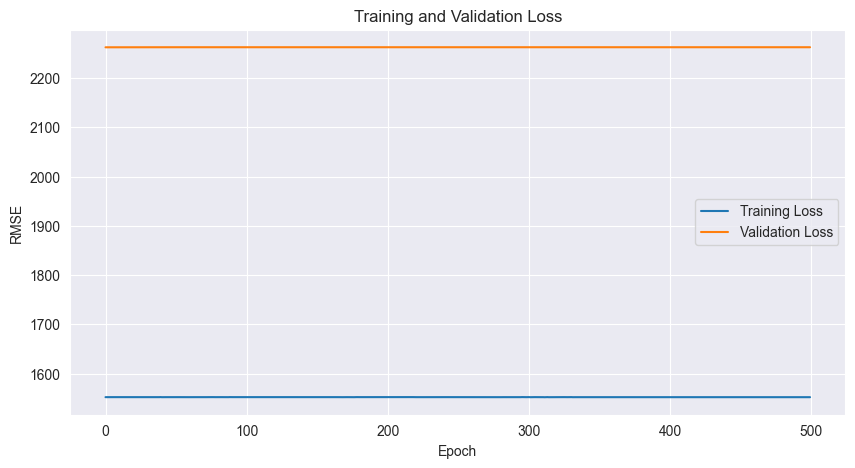

Final validation RMSE: 2262.3457
  Fold 4/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1755.9115, Val RMSE: 2261.7861



  7%|▋         | 36/500 [00:00<00:01, 355.42it/s]

Epoch 10: Train RMSE: 1755.9274, Val RMSE: 2261.7876
Epoch 20: Train RMSE: 1755.9026, Val RMSE: 2261.7883
Epoch 30: Train RMSE: 1755.9370, Val RMSE: 2261.7888
Epoch 40: Train RMSE: 1755.9316, Val RMSE: 2261.7888
Epoch 50: Train RMSE: 1755.9070, Val RMSE: 2261.7891
Epoch 60: Train RMSE: 1755.9143, Val RMSE: 2261.7893



 14%|█▍        | 72/500 [00:00<00:01, 343.72it/s]

Epoch 70: Train RMSE: 1755.9260, Val RMSE: 2261.7893
Epoch 80: Train RMSE: 1755.9344, Val RMSE: 2261.7893



 22%|██▏       | 110/500 [00:00<00:01, 359.21it/s]

Epoch 90: Train RMSE: 1755.9136, Val RMSE: 2261.7893
Epoch 100: Train RMSE: 1755.9001, Val RMSE: 2261.7893
Epoch 110: Train RMSE: 1755.9232, Val RMSE: 2261.7893
Epoch 120: Train RMSE: 1755.8984, Val RMSE: 2261.7893
Epoch 130: Train RMSE: 1755.8983, Val RMSE: 2261.7893
Epoch 140: Train RMSE: 1755.9236, Val RMSE: 2261.7893
Epoch 150: Train RMSE: 1755.9083, Val RMSE: 2261.7893



 30%|███       | 152/500 [00:00<00:00, 382.64it/s]

Epoch 160: Train RMSE: 1755.9229, Val RMSE: 2261.7893
Epoch 170: Train RMSE: 1755.9282, Val RMSE: 2261.7893



 46%|████▌     | 230/500 [00:00<00:00, 380.37it/s]

Epoch 180: Train RMSE: 1755.8961, Val RMSE: 2261.7893
Epoch 190: Train RMSE: 1755.9242, Val RMSE: 2261.7893
Epoch 200: Train RMSE: 1755.9000, Val RMSE: 2261.7893
Epoch 210: Train RMSE: 1755.9338, Val RMSE: 2261.7893
Epoch 220: Train RMSE: 1755.8958, Val RMSE: 2261.7893
Epoch 230: Train RMSE: 1755.9143, Val RMSE: 2261.7893
Epoch 240: Train RMSE: 1755.9130, Val RMSE: 2261.7893
Epoch 250: Train RMSE: 1755.9078, Val RMSE: 2261.7893



 64%|██████▍   | 319/500 [00:00<00:00, 411.98it/s]

Epoch 260: Train RMSE: 1755.9073, Val RMSE: 2261.7893
Epoch 270: Train RMSE: 1755.8978, Val RMSE: 2261.7893
Epoch 280: Train RMSE: 1755.9143, Val RMSE: 2261.7893
Epoch 290: Train RMSE: 1755.9344, Val RMSE: 2261.7893
Epoch 300: Train RMSE: 1755.9022, Val RMSE: 2261.7893
Epoch 310: Train RMSE: 1755.9165, Val RMSE: 2261.7893
Epoch 320: Train RMSE: 1755.9304, Val RMSE: 2261.7893
Epoch 330: Train RMSE: 1755.9421, Val RMSE: 2261.7893
Epoch 340: Train RMSE: 1755.8796, Val RMSE: 2261.7893



 81%|████████▏ | 407/500 [00:01<00:00, 412.57it/s]

Epoch 350: Train RMSE: 1755.9272, Val RMSE: 2261.7893
Epoch 360: Train RMSE: 1755.8877, Val RMSE: 2261.7893
Epoch 370: Train RMSE: 1755.8993, Val RMSE: 2261.7893
Epoch 380: Train RMSE: 1755.9082, Val RMSE: 2261.7893
Epoch 390: Train RMSE: 1755.9178, Val RMSE: 2261.7893
Epoch 400: Train RMSE: 1755.9259, Val RMSE: 2261.7893
Epoch 410: Train RMSE: 1755.9139, Val RMSE: 2261.7893
Epoch 420: Train RMSE: 1755.9272, Val RMSE: 2261.7893



100%|██████████| 500/500 [00:01<00:00, 394.80it/s]

Epoch 430: Train RMSE: 1755.9159, Val RMSE: 2261.7893
Epoch 440: Train RMSE: 1755.9312, Val RMSE: 2261.7893
Epoch 450: Train RMSE: 1755.9146, Val RMSE: 2261.7893
Epoch 460: Train RMSE: 1755.9146, Val RMSE: 2261.7893
Epoch 470: Train RMSE: 1755.9222, Val RMSE: 2261.7893
Epoch 480: Train RMSE: 1755.9159, Val RMSE: 2261.7893
Epoch 490: Train RMSE: 1755.9064, Val RMSE: 2261.7893


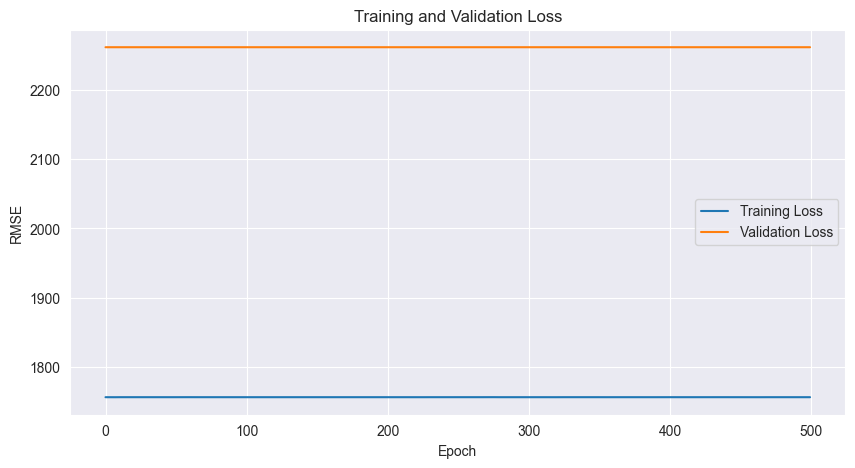

Final validation RMSE: 2261.7861
  Fold 5/5
Input size: 437



  6%|▌         | 29/500 [00:00<00:01, 280.82it/s]

Epoch 0: Train RMSE: 1867.7488, Val RMSE: 2493.2051
Epoch 10: Train RMSE: 1867.7378, Val RMSE: 2493.1985
Epoch 20: Train RMSE: 1867.7449, Val RMSE: 2493.1895
Epoch 30: Train RMSE: 1867.7000, Val RMSE: 2493.1819
Epoch 40: Train RMSE: 1867.7086, Val RMSE: 2493.1833
Epoch 50: Train RMSE: 1867.7390, Val RMSE: 2493.1843
Epoch 60: Train RMSE: 1867.7330, Val RMSE: 2493.1848



 19%|█▉        | 96/500 [00:00<00:01, 314.21it/s]

Epoch 70: Train RMSE: 1867.7422, Val RMSE: 2493.1851
Epoch 80: Train RMSE: 1867.7086, Val RMSE: 2493.1851
Epoch 90: Train RMSE: 1867.7411, Val RMSE: 2493.1851
Epoch 100: Train RMSE: 1867.7220, Val RMSE: 2493.1851
Epoch 110: Train RMSE: 1867.7167, Val RMSE: 2493.1851
Epoch 120: Train RMSE: 1867.7184, Val RMSE: 2493.1851



 26%|██▌       | 128/500 [00:00<00:01, 312.97it/s]

Epoch 130: Train RMSE: 1867.6790, Val RMSE: 2493.1853



 41%|████▏     | 207/500 [00:00<00:00, 358.00it/s]

Epoch 140: Train RMSE: 1867.7238, Val RMSE: 2493.1853
Epoch 150: Train RMSE: 1867.7496, Val RMSE: 2493.1853
Epoch 160: Train RMSE: 1867.7843, Val RMSE: 2493.1853
Epoch 170: Train RMSE: 1867.7267, Val RMSE: 2493.1853
Epoch 180: Train RMSE: 1867.7540, Val RMSE: 2493.1853
Epoch 190: Train RMSE: 1867.7241, Val RMSE: 2493.1853
Epoch 200: Train RMSE: 1867.7719, Val RMSE: 2493.1853
Epoch 210: Train RMSE: 1867.7007, Val RMSE: 2493.1853
Epoch 220: Train RMSE: 1867.7700, Val RMSE: 2493.1853



 56%|█████▌    | 279/500 [00:00<00:00, 345.78it/s]

Epoch 230: Train RMSE: 1867.6975, Val RMSE: 2493.1853
Epoch 240: Train RMSE: 1867.7194, Val RMSE: 2493.1853
Epoch 250: Train RMSE: 1867.7444, Val RMSE: 2493.1853
Epoch 260: Train RMSE: 1867.7048, Val RMSE: 2493.1853
Epoch 270: Train RMSE: 1867.7615, Val RMSE: 2493.1853
Epoch 280: Train RMSE: 1867.7615, Val RMSE: 2493.1853
Epoch 290: Train RMSE: 1867.6895, Val RMSE: 2493.1853



 71%|███████   | 356/500 [00:01<00:00, 364.74it/s]

Epoch 300: Train RMSE: 1867.7306, Val RMSE: 2493.1853
Epoch 310: Train RMSE: 1867.7096, Val RMSE: 2493.1853
Epoch 320: Train RMSE: 1867.8152, Val RMSE: 2493.1853
Epoch 330: Train RMSE: 1867.7106, Val RMSE: 2493.1853
Epoch 340: Train RMSE: 1867.6831, Val RMSE: 2493.1853
Epoch 350: Train RMSE: 1867.7692, Val RMSE: 2493.1853
Epoch 360: Train RMSE: 1867.7853, Val RMSE: 2493.1853
Epoch 370: Train RMSE: 1867.7458, Val RMSE: 2493.1853



 79%|███████▊  | 393/500 [00:01<00:00, 322.02it/s]

Epoch 380: Train RMSE: 1867.7798, Val RMSE: 2493.1853
Epoch 390: Train RMSE: 1867.7500, Val RMSE: 2493.1853
Epoch 400: Train RMSE: 1867.7701, Val RMSE: 2493.1853
Epoch 410: Train RMSE: 1867.7531, Val RMSE: 2493.1853



 85%|████████▌ | 427/500 [00:01<00:00, 310.59it/s]

Epoch 420: Train RMSE: 1867.7385, Val RMSE: 2493.1853
Epoch 430: Train RMSE: 1867.7125, Val RMSE: 2493.1853



 92%|█████████▏| 459/500 [00:01<00:00, 312.51it/s]

Epoch 440: Train RMSE: 1867.7460, Val RMSE: 2493.1853
Epoch 450: Train RMSE: 1867.7407, Val RMSE: 2493.1853
Epoch 460: Train RMSE: 1867.7096, Val RMSE: 2493.1853
Epoch 470: Train RMSE: 1867.7233, Val RMSE: 2493.1853
Epoch 480: Train RMSE: 1867.7411, Val RMSE: 2493.1853



100%|██████████| 500/500 [00:01<00:00, 326.27it/s]

Epoch 490: Train RMSE: 1867.7412, Val RMSE: 2493.1853


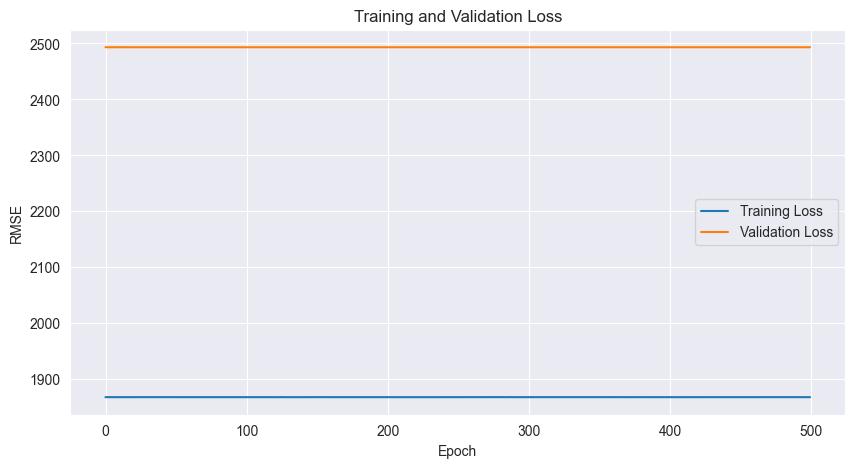

Final validation RMSE: 2493.1777
  Avg RMSE: 2032.4237 ± 417.7881

Testing: hidden_size=64, layers=2, lr=0.001
  Fold 1/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1467.8387, Val RMSE: 1828.9792
Epoch 10: Train RMSE: 1467.7101, Val RMSE: 1828.9946
Epoch 20: Train RMSE: 1467.7325, Val RMSE: 1828.9919
Epoch 30: Train RMSE: 1467.6639, Val RMSE: 1829.0111
Epoch 40: Train RMSE: 1467.7538, Val RMSE: 1829.0125



 11%|█         | 54/500 [00:00<00:00, 536.47it/s]

Epoch 50: Train RMSE: 1467.6476, Val RMSE: 1829.0131
Epoch 60: Train RMSE: 1467.6666, Val RMSE: 1829.0135
Epoch 70: Train RMSE: 1467.5935, Val RMSE: 1829.0137
Epoch 80: Train RMSE: 1467.6819, Val RMSE: 1829.0139
Epoch 90: Train RMSE: 1467.4553, Val RMSE: 1829.0139
Epoch 100: Train RMSE: 1467.7340, Val RMSE: 1829.0139



 22%|██▏       | 110/500 [00:00<00:00, 547.35it/s]

Epoch 110: Train RMSE: 1467.6523, Val RMSE: 1829.0139
Epoch 120: Train RMSE: 1467.7341, Val RMSE: 1829.0140
Epoch 130: Train RMSE: 1467.7183, Val RMSE: 1829.0140
Epoch 140: Train RMSE: 1467.6072, Val RMSE: 1829.0140
Epoch 150: Train RMSE: 1467.6434, Val RMSE: 1829.0140
Epoch 160: Train RMSE: 1467.5703, Val RMSE: 1829.0139



 34%|███▎      | 168/500 [00:00<00:00, 558.39it/s]

Epoch 170: Train RMSE: 1467.9169, Val RMSE: 1829.0140
Epoch 180: Train RMSE: 1467.4645, Val RMSE: 1829.0140
Epoch 190: Train RMSE: 1467.5671, Val RMSE: 1829.0140
Epoch 200: Train RMSE: 1467.6564, Val RMSE: 1829.0140
Epoch 210: Train RMSE: 1467.6050, Val RMSE: 1829.0140



 45%|████▍     | 224/500 [00:00<00:00, 534.69it/s]

Epoch 220: Train RMSE: 1467.7256, Val RMSE: 1829.0140
Epoch 230: Train RMSE: 1467.6642, Val RMSE: 1829.0140
Epoch 240: Train RMSE: 1467.5822, Val RMSE: 1829.0140
Epoch 250: Train RMSE: 1467.4542, Val RMSE: 1829.0140
Epoch 260: Train RMSE: 1467.7030, Val RMSE: 1829.0140
Epoch 270: Train RMSE: 1467.6610, Val RMSE: 1829.0140



 56%|█████▌    | 280/500 [00:00<00:00, 543.04it/s]

Epoch 280: Train RMSE: 1467.7418, Val RMSE: 1829.0140
Epoch 290: Train RMSE: 1467.5819, Val RMSE: 1829.0140
Epoch 300: Train RMSE: 1467.7446, Val RMSE: 1829.0140
Epoch 310: Train RMSE: 1467.6575, Val RMSE: 1829.0140
Epoch 320: Train RMSE: 1467.6586, Val RMSE: 1829.0140
Epoch 330: Train RMSE: 1467.5929, Val RMSE: 1829.0140



 81%|████████  | 406/500 [00:00<00:00, 590.51it/s]

Epoch 340: Train RMSE: 1467.6567, Val RMSE: 1829.0140
Epoch 350: Train RMSE: 1467.8243, Val RMSE: 1829.0140
Epoch 360: Train RMSE: 1467.5829, Val RMSE: 1829.0140
Epoch 370: Train RMSE: 1467.6659, Val RMSE: 1829.0140
Epoch 380: Train RMSE: 1467.7212, Val RMSE: 1829.0140
Epoch 390: Train RMSE: 1467.6765, Val RMSE: 1829.0140
Epoch 400: Train RMSE: 1467.6536, Val RMSE: 1829.0140



 95%|█████████▌| 475/500 [00:00<00:00, 620.18it/s]

Epoch 410: Train RMSE: 1467.5856, Val RMSE: 1829.0140
Epoch 420: Train RMSE: 1467.6796, Val RMSE: 1829.0140
Epoch 430: Train RMSE: 1467.8668, Val RMSE: 1829.0140
Epoch 440: Train RMSE: 1467.6765, Val RMSE: 1829.0140
Epoch 450: Train RMSE: 1467.6869, Val RMSE: 1829.0140
Epoch 460: Train RMSE: 1467.8125, Val RMSE: 1829.0140
Epoch 470: Train RMSE: 1467.7322, Val RMSE: 1829.0140


100%|██████████| 500/500 [00:00<00:00, 573.72it/s]


Epoch 480: Train RMSE: 1467.8036, Val RMSE: 1829.0140
Epoch 490: Train RMSE: 1467.5763, Val RMSE: 1829.0140


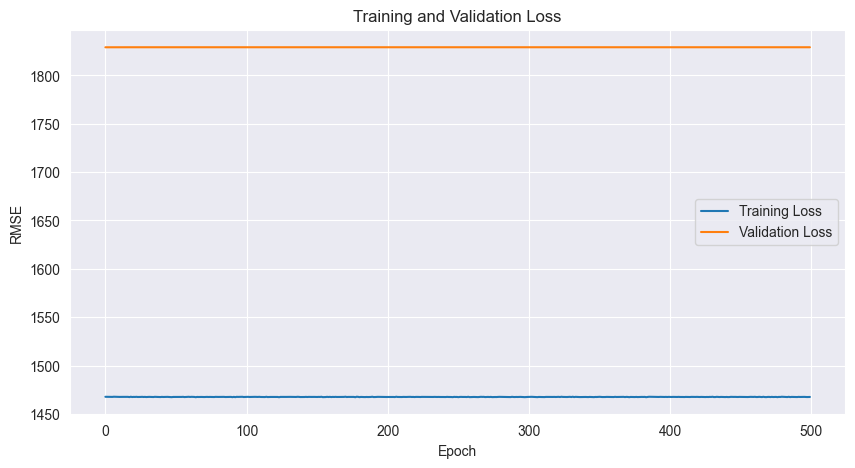

Final validation RMSE: 1828.9792
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.7416, Val RMSE: 1315.5140
Epoch 10: Train RMSE: 1656.7452, Val RMSE: 1315.7825
Epoch 20: Train RMSE: 1656.6643, Val RMSE: 1315.9857
Epoch 30: Train RMSE: 1656.6873, Val RMSE: 1316.0894



  9%|▉         | 46/500 [00:00<00:00, 454.15it/s]

Epoch 40: Train RMSE: 1656.6749, Val RMSE: 1316.1523
Epoch 50: Train RMSE: 1656.5856, Val RMSE: 1316.1877
Epoch 60: Train RMSE: 1656.5110, Val RMSE: 1316.2072
Epoch 70: Train RMSE: 1656.5298, Val RMSE: 1316.2183
Epoch 80: Train RMSE: 1656.6312, Val RMSE: 1316.2242
Epoch 90: Train RMSE: 1656.5085, Val RMSE: 1316.2272



 18%|█▊        | 92/500 [00:00<00:00, 447.57it/s]

Epoch 100: Train RMSE: 1656.6094, Val RMSE: 1316.2289
Epoch 110: Train RMSE: 1656.5093, Val RMSE: 1316.2296
Epoch 120: Train RMSE: 1656.5402, Val RMSE: 1316.2300
Epoch 130: Train RMSE: 1656.6361, Val RMSE: 1316.2302



 28%|██▊       | 139/500 [00:00<00:00, 456.07it/s]

Epoch 140: Train RMSE: 1656.6173, Val RMSE: 1316.2302
Epoch 150: Train RMSE: 1656.6570, Val RMSE: 1316.2303
Epoch 160: Train RMSE: 1656.6550, Val RMSE: 1316.2303
Epoch 170: Train RMSE: 1656.5576, Val RMSE: 1316.2305
Epoch 180: Train RMSE: 1656.5057, Val RMSE: 1316.2305



 37%|███▋      | 185/500 [00:00<00:00, 450.57it/s]

Epoch 190: Train RMSE: 1656.5360, Val RMSE: 1316.2305



 47%|████▋     | 234/500 [00:00<00:00, 461.57it/s]

Epoch 200: Train RMSE: 1656.6841, Val RMSE: 1316.2305
Epoch 210: Train RMSE: 1656.5413, Val RMSE: 1316.2305
Epoch 220: Train RMSE: 1656.4331, Val RMSE: 1316.2305
Epoch 230: Train RMSE: 1656.5360, Val RMSE: 1316.2305



 56%|█████▌    | 281/500 [00:00<00:00, 464.38it/s]

Epoch 240: Train RMSE: 1656.5541, Val RMSE: 1316.2305
Epoch 250: Train RMSE: 1656.5643, Val RMSE: 1316.2305
Epoch 260: Train RMSE: 1656.7394, Val RMSE: 1316.2305
Epoch 270: Train RMSE: 1656.6771, Val RMSE: 1316.2305
Epoch 280: Train RMSE: 1656.6686, Val RMSE: 1316.2305
Epoch 290: Train RMSE: 1656.6615, Val RMSE: 1316.2305



 66%|██████▌   | 328/500 [00:00<00:00, 463.58it/s]

Epoch 300: Train RMSE: 1656.6532, Val RMSE: 1316.2305
Epoch 310: Train RMSE: 1656.6418, Val RMSE: 1316.2305
Epoch 320: Train RMSE: 1656.5710, Val RMSE: 1316.2305
Epoch 330: Train RMSE: 1656.4994, Val RMSE: 1316.2305



 75%|███████▌  | 377/500 [00:00<00:00, 468.82it/s]

Epoch 340: Train RMSE: 1656.6171, Val RMSE: 1316.2305
Epoch 350: Train RMSE: 1656.5889, Val RMSE: 1316.2305
Epoch 360: Train RMSE: 1656.6129, Val RMSE: 1316.2305
Epoch 370: Train RMSE: 1656.5282, Val RMSE: 1316.2305
Epoch 380: Train RMSE: 1656.4113, Val RMSE: 1316.2305
Epoch 390: Train RMSE: 1656.4976, Val RMSE: 1316.2305



 85%|████████▌ | 426/500 [00:00<00:00, 472.77it/s]

Epoch 400: Train RMSE: 1656.6637, Val RMSE: 1316.2305
Epoch 410: Train RMSE: 1656.6449, Val RMSE: 1316.2305
Epoch 420: Train RMSE: 1656.7122, Val RMSE: 1316.2305
Epoch 430: Train RMSE: 1656.5807, Val RMSE: 1316.2305



 95%|█████████▍| 474/500 [00:01<00:00, 470.77it/s]

Epoch 440: Train RMSE: 1656.5016, Val RMSE: 1316.2305
Epoch 450: Train RMSE: 1656.5127, Val RMSE: 1316.2305
Epoch 460: Train RMSE: 1656.5231, Val RMSE: 1316.2305
Epoch 470: Train RMSE: 1656.7135, Val RMSE: 1316.2305
Epoch 480: Train RMSE: 1656.5392, Val RMSE: 1316.2306
Epoch 490: Train RMSE: 1656.6681, Val RMSE: 1316.2306


100%|██████████| 500/500 [00:01<00:00, 463.42it/s]


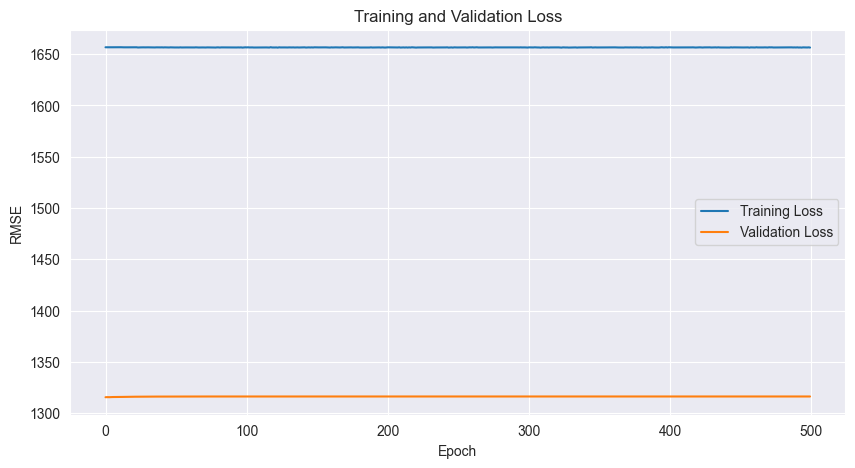

Final validation RMSE: 1315.5140
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1552.1626, Val RMSE: 2262.3484
Epoch 10: Train RMSE: 1552.0177, Val RMSE: 2262.2686
Epoch 20: Train RMSE: 1552.0243, Val RMSE: 2262.3096



  6%|▌         | 30/500 [00:00<00:01, 292.67it/s]

Epoch 30: Train RMSE: 1552.0394, Val RMSE: 2262.3350
Epoch 40: Train RMSE: 1552.0089, Val RMSE: 2262.2854
Epoch 50: Train RMSE: 1552.0465, Val RMSE: 2262.3110
Epoch 60: Train RMSE: 1551.9807, Val RMSE: 2262.3066



 14%|█▍        | 72/500 [00:00<00:01, 363.76it/s]

Epoch 70: Train RMSE: 1551.9900, Val RMSE: 2262.3042



 23%|██▎       | 113/500 [00:00<00:01, 383.50it/s]

Epoch 80: Train RMSE: 1552.0106, Val RMSE: 2262.3025
Epoch 90: Train RMSE: 1552.0138, Val RMSE: 2262.3020
Epoch 100: Train RMSE: 1551.9907, Val RMSE: 2262.3018
Epoch 110: Train RMSE: 1552.0243, Val RMSE: 2262.3018
Epoch 120: Train RMSE: 1551.9996, Val RMSE: 2262.3015
Epoch 130: Train RMSE: 1552.0592, Val RMSE: 2262.3015
Epoch 140: Train RMSE: 1551.9955, Val RMSE: 2262.3015



 30%|███       | 152/500 [00:00<00:00, 377.66it/s]

Epoch 150: Train RMSE: 1552.0077, Val RMSE: 2262.3015



 38%|███▊      | 192/500 [00:00<00:00, 382.13it/s]

Epoch 160: Train RMSE: 1551.9868, Val RMSE: 2262.3015
Epoch 170: Train RMSE: 1551.9967, Val RMSE: 2262.3013
Epoch 180: Train RMSE: 1552.0133, Val RMSE: 2262.3013
Epoch 190: Train RMSE: 1551.9847, Val RMSE: 2262.3013
Epoch 200: Train RMSE: 1552.0087, Val RMSE: 2262.3013
Epoch 210: Train RMSE: 1551.9785, Val RMSE: 2262.3013
Epoch 220: Train RMSE: 1552.0096, Val RMSE: 2262.3013



 46%|████▌     | 231/500 [00:00<00:00, 370.73it/s]

Epoch 230: Train RMSE: 1551.9824, Val RMSE: 2262.3013



 55%|█████▍    | 273/500 [00:00<00:00, 385.67it/s]

Epoch 240: Train RMSE: 1551.9755, Val RMSE: 2262.3013
Epoch 250: Train RMSE: 1552.0190, Val RMSE: 2262.3013
Epoch 260: Train RMSE: 1551.9857, Val RMSE: 2262.3013
Epoch 270: Train RMSE: 1551.9850, Val RMSE: 2262.3013
Epoch 280: Train RMSE: 1552.0317, Val RMSE: 2262.3013
Epoch 290: Train RMSE: 1552.0127, Val RMSE: 2262.3013
Epoch 300: Train RMSE: 1551.9635, Val RMSE: 2262.3013
Epoch 310: Train RMSE: 1552.0486, Val RMSE: 2262.3013



 63%|██████▎   | 316/500 [00:00<00:00, 397.53it/s]

Epoch 320: Train RMSE: 1551.9817, Val RMSE: 2262.3013



 72%|███████▏  | 359/500 [00:00<00:00, 405.69it/s]

Epoch 330: Train RMSE: 1551.9446, Val RMSE: 2262.3013
Epoch 340: Train RMSE: 1551.9924, Val RMSE: 2262.3013
Epoch 350: Train RMSE: 1551.9199, Val RMSE: 2262.3013
Epoch 360: Train RMSE: 1551.9288, Val RMSE: 2262.3013



 80%|████████  | 401/500 [00:01<00:00, 407.29it/s]

Epoch 370: Train RMSE: 1551.9575, Val RMSE: 2262.3013
Epoch 380: Train RMSE: 1551.9810, Val RMSE: 2262.3013
Epoch 390: Train RMSE: 1551.9885, Val RMSE: 2262.3013
Epoch 400: Train RMSE: 1552.0392, Val RMSE: 2262.3013
Epoch 410: Train RMSE: 1552.0189, Val RMSE: 2262.3013



 88%|████████▊ | 442/500 [00:01<00:00, 402.01it/s]

Epoch 420: Train RMSE: 1552.0518, Val RMSE: 2262.3013
Epoch 430: Train RMSE: 1551.9255, Val RMSE: 2262.3013
Epoch 440: Train RMSE: 1551.9247, Val RMSE: 2262.3013



 97%|█████████▋| 486/500 [00:01<00:00, 412.22it/s]

Epoch 450: Train RMSE: 1551.9893, Val RMSE: 2262.3013
Epoch 460: Train RMSE: 1551.9457, Val RMSE: 2262.3013
Epoch 470: Train RMSE: 1551.9895, Val RMSE: 2262.3013
Epoch 480: Train RMSE: 1552.0122, Val RMSE: 2262.3013
Epoch 490: Train RMSE: 1551.9829, Val RMSE: 2262.3013


100%|██████████| 500/500 [00:01<00:00, 391.86it/s]


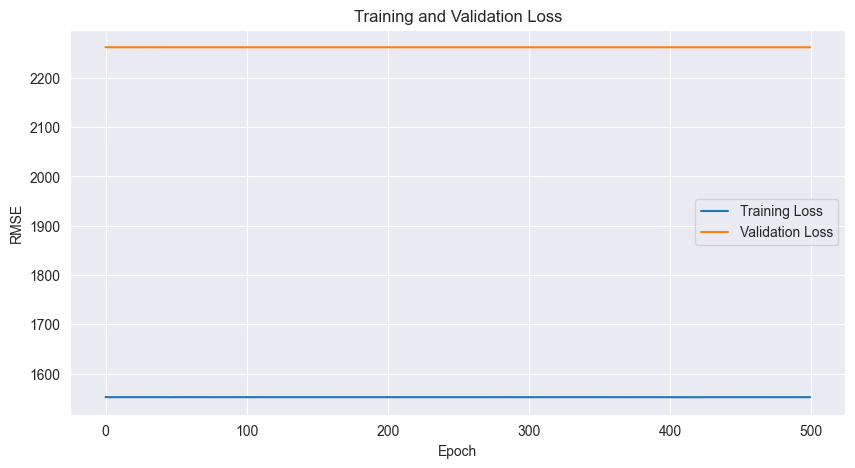

Final validation RMSE: 2262.2563
  Fold 4/5
Input size: 437



  7%|▋         | 37/500 [00:00<00:01, 363.60it/s]

Epoch 0: Train RMSE: 1755.9708, Val RMSE: 2261.7700
Epoch 10: Train RMSE: 1755.8308, Val RMSE: 2261.8203
Epoch 20: Train RMSE: 1755.7538, Val RMSE: 2261.8315
Epoch 30: Train RMSE: 1755.7251, Val RMSE: 2261.8357
Epoch 40: Train RMSE: 1755.7317, Val RMSE: 2261.8381
Epoch 50: Train RMSE: 1755.7025, Val RMSE: 2261.8396
Epoch 60: Train RMSE: 1755.7200, Val RMSE: 2261.8403
Epoch 70: Train RMSE: 1755.7369, Val RMSE: 2261.8406



 23%|██▎       | 117/500 [00:00<00:01, 353.50it/s]

Epoch 80: Train RMSE: 1755.7922, Val RMSE: 2261.8408
Epoch 90: Train RMSE: 1755.7883, Val RMSE: 2261.8411
Epoch 100: Train RMSE: 1755.6985, Val RMSE: 2261.8408
Epoch 110: Train RMSE: 1755.6954, Val RMSE: 2261.8411
Epoch 120: Train RMSE: 1755.6042, Val RMSE: 2261.8411
Epoch 130: Train RMSE: 1755.7125, Val RMSE: 2261.8411
Epoch 140: Train RMSE: 1755.7448, Val RMSE: 2261.8411
Epoch 150: Train RMSE: 1755.7467, Val RMSE: 2261.8411



 50%|████▉     | 249/500 [00:00<00:00, 413.98it/s]

Epoch 160: Train RMSE: 1755.8153, Val RMSE: 2261.8411
Epoch 170: Train RMSE: 1755.7218, Val RMSE: 2261.8411
Epoch 180: Train RMSE: 1755.7477, Val RMSE: 2261.8411
Epoch 190: Train RMSE: 1755.7041, Val RMSE: 2261.8411
Epoch 200: Train RMSE: 1755.6930, Val RMSE: 2261.8411
Epoch 210: Train RMSE: 1755.7600, Val RMSE: 2261.8411
Epoch 220: Train RMSE: 1755.6980, Val RMSE: 2261.8411
Epoch 230: Train RMSE: 1755.7059, Val RMSE: 2261.8411
Epoch 240: Train RMSE: 1755.8041, Val RMSE: 2261.8411



 58%|█████▊    | 291/500 [00:00<00:00, 408.61it/s]

Epoch 250: Train RMSE: 1755.7174, Val RMSE: 2261.8411
Epoch 260: Train RMSE: 1755.7550, Val RMSE: 2261.8411
Epoch 270: Train RMSE: 1755.7224, Val RMSE: 2261.8411
Epoch 280: Train RMSE: 1755.7310, Val RMSE: 2261.8411
Epoch 290: Train RMSE: 1755.7292, Val RMSE: 2261.8411
Epoch 300: Train RMSE: 1755.7816, Val RMSE: 2261.8411
Epoch 310: Train RMSE: 1755.7526, Val RMSE: 2261.8411
Epoch 320: Train RMSE: 1755.7046, Val RMSE: 2261.8411



 74%|███████▍  | 372/500 [00:00<00:00, 384.60it/s]

Epoch 330: Train RMSE: 1755.6470, Val RMSE: 2261.8411
Epoch 340: Train RMSE: 1755.6682, Val RMSE: 2261.8411
Epoch 350: Train RMSE: 1755.7144, Val RMSE: 2261.8411
Epoch 360: Train RMSE: 1755.6637, Val RMSE: 2261.8411
Epoch 370: Train RMSE: 1755.6669, Val RMSE: 2261.8411
Epoch 380: Train RMSE: 1755.6884, Val RMSE: 2261.8411
Epoch 390: Train RMSE: 1755.6918, Val RMSE: 2261.8411
Epoch 400: Train RMSE: 1755.7733, Val RMSE: 2261.8411
Epoch 410: Train RMSE: 1755.7310, Val RMSE: 2261.8411



100%|██████████| 500/500 [00:01<00:00, 396.91it/s]


Epoch 420: Train RMSE: 1755.7332, Val RMSE: 2261.8411
Epoch 430: Train RMSE: 1755.7305, Val RMSE: 2261.8411
Epoch 440: Train RMSE: 1755.6687, Val RMSE: 2261.8411
Epoch 450: Train RMSE: 1755.7311, Val RMSE: 2261.8411
Epoch 460: Train RMSE: 1755.7876, Val RMSE: 2261.8411
Epoch 470: Train RMSE: 1755.6803, Val RMSE: 2261.8411
Epoch 480: Train RMSE: 1755.7981, Val RMSE: 2261.8411
Epoch 490: Train RMSE: 1755.6763, Val RMSE: 2261.8411


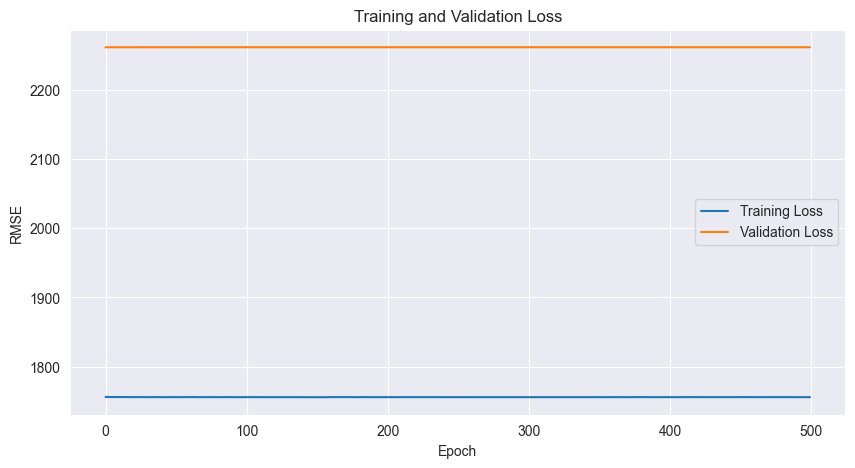

Final validation RMSE: 2261.7700
  Fold 5/5
Input size: 437



  5%|▌         | 27/500 [00:00<00:01, 268.58it/s]

Epoch 0: Train RMSE: 1867.7671, Val RMSE: 2493.0686
Epoch 10: Train RMSE: 1867.6852, Val RMSE: 2493.2742
Epoch 20: Train RMSE: 1867.6136, Val RMSE: 2493.3801
Epoch 30: Train RMSE: 1867.5356, Val RMSE: 2493.4270
Epoch 40: Train RMSE: 1867.5442, Val RMSE: 2493.4480
Epoch 50: Train RMSE: 1867.5288, Val RMSE: 2493.4592



 12%|█▏        | 61/500 [00:00<00:01, 308.38it/s]

Epoch 60: Train RMSE: 1867.5343, Val RMSE: 2493.4644



 19%|█▉        | 95/500 [00:00<00:01, 318.45it/s]

Epoch 70: Train RMSE: 1867.4652, Val RMSE: 2493.4670
Epoch 80: Train RMSE: 1867.5225, Val RMSE: 2493.4685
Epoch 90: Train RMSE: 1867.4683, Val RMSE: 2493.4695
Epoch 100: Train RMSE: 1867.4972, Val RMSE: 2493.4697
Epoch 110: Train RMSE: 1867.4856, Val RMSE: 2493.4700
Epoch 120: Train RMSE: 1867.5435, Val RMSE: 2493.4700



 26%|██▌       | 130/500 [00:00<00:01, 327.99it/s]

Epoch 130: Train RMSE: 1867.5015, Val RMSE: 2493.4702



 33%|███▎      | 165/500 [00:00<00:00, 335.26it/s]

Epoch 140: Train RMSE: 1867.4594, Val RMSE: 2493.4702
Epoch 150: Train RMSE: 1867.5210, Val RMSE: 2493.4702
Epoch 160: Train RMSE: 1867.5785, Val RMSE: 2493.4702
Epoch 170: Train RMSE: 1867.4989, Val RMSE: 2493.4700
Epoch 180: Train RMSE: 1867.5031, Val RMSE: 2493.4700
Epoch 190: Train RMSE: 1867.4805, Val RMSE: 2493.4700



 40%|███▉      | 199/500 [00:00<00:00, 318.11it/s]

Epoch 200: Train RMSE: 1867.5175, Val RMSE: 2493.4700



 46%|████▌     | 231/500 [00:00<00:00, 308.17it/s]

Epoch 210: Train RMSE: 1867.5442, Val RMSE: 2493.4700
Epoch 220: Train RMSE: 1867.5923, Val RMSE: 2493.4702
Epoch 230: Train RMSE: 1867.5157, Val RMSE: 2493.4702
Epoch 240: Train RMSE: 1867.4828, Val RMSE: 2493.4702
Epoch 250: Train RMSE: 1867.4749, Val RMSE: 2493.4702



 52%|█████▏    | 262/500 [00:00<00:00, 296.05it/s]

Epoch 260: Train RMSE: 1867.4879, Val RMSE: 2493.4702



 58%|█████▊    | 292/500 [00:00<00:00, 289.06it/s]

Epoch 270: Train RMSE: 1867.5109, Val RMSE: 2493.4702
Epoch 280: Train RMSE: 1867.5024, Val RMSE: 2493.4702
Epoch 290: Train RMSE: 1867.6211, Val RMSE: 2493.4702
Epoch 300: Train RMSE: 1867.5902, Val RMSE: 2493.4702
Epoch 310: Train RMSE: 1867.5137, Val RMSE: 2493.4702



 65%|██████▍   | 323/500 [00:01<00:00, 294.62it/s]

Epoch 320: Train RMSE: 1867.5084, Val RMSE: 2493.4702



 71%|███████▏  | 357/500 [00:01<00:00, 305.16it/s]

Epoch 330: Train RMSE: 1867.5314, Val RMSE: 2493.4702
Epoch 340: Train RMSE: 1867.5961, Val RMSE: 2493.4702
Epoch 350: Train RMSE: 1867.5413, Val RMSE: 2493.4702
Epoch 360: Train RMSE: 1867.5254, Val RMSE: 2493.4702
Epoch 370: Train RMSE: 1867.5148, Val RMSE: 2493.4702
Epoch 380: Train RMSE: 1867.4882, Val RMSE: 2493.4702



 78%|███████▊  | 391/500 [00:01<00:00, 315.29it/s]

Epoch 390: Train RMSE: 1867.4785, Val RMSE: 2493.4702



 85%|████████▍ | 423/500 [00:01<00:00, 312.66it/s]

Epoch 400: Train RMSE: 1867.5195, Val RMSE: 2493.4702
Epoch 410: Train RMSE: 1867.4901, Val RMSE: 2493.4702
Epoch 420: Train RMSE: 1867.5692, Val RMSE: 2493.4702
Epoch 430: Train RMSE: 1867.4844, Val RMSE: 2493.4702
Epoch 440: Train RMSE: 1867.5037, Val RMSE: 2493.4702
Epoch 450: Train RMSE: 1867.5143, Val RMSE: 2493.4702



 91%|█████████ | 455/500 [00:01<00:00, 311.58it/s]

Epoch 460: Train RMSE: 1867.5822, Val RMSE: 2493.4702



100%|██████████| 500/500 [00:01<00:00, 307.97it/s]


Epoch 470: Train RMSE: 1867.5320, Val RMSE: 2493.4702
Epoch 480: Train RMSE: 1867.5037, Val RMSE: 2493.4702
Epoch 490: Train RMSE: 1867.5375, Val RMSE: 2493.4702


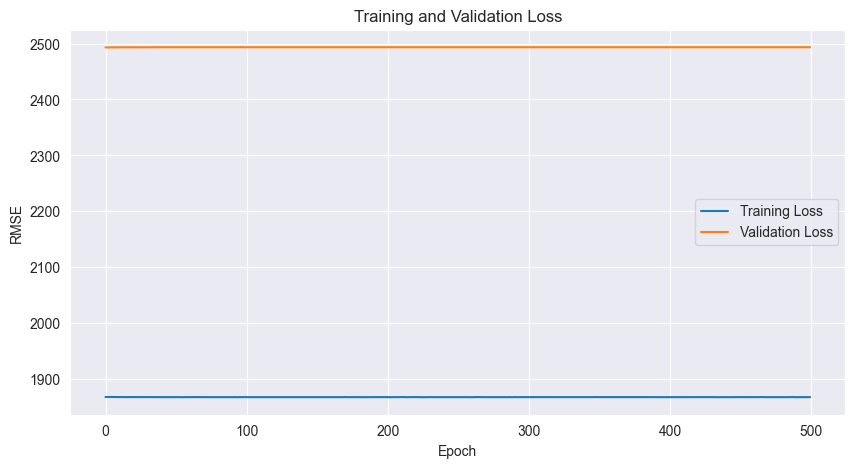

Final validation RMSE: 2493.0686
  Avg RMSE: 2032.3177 ± 417.8434

Testing: hidden_size=64, layers=2, lr=0.01
  Fold 1/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1467.9875, Val RMSE: 1829.1193



 10%|▉         | 48/500 [00:00<00:00, 473.61it/s]

Epoch 10: Train RMSE: 1466.8905, Val RMSE: 1829.0590
Epoch 20: Train RMSE: 1467.6416, Val RMSE: 1828.9827
Epoch 30: Train RMSE: 1467.9404, Val RMSE: 1828.9841
Epoch 40: Train RMSE: 1467.7388, Val RMSE: 1828.9852
Epoch 50: Train RMSE: 1467.7676, Val RMSE: 1828.9856
Epoch 60: Train RMSE: 1467.8372, Val RMSE: 1828.9858
Epoch 70: Train RMSE: 1467.9368, Val RMSE: 1828.9860
Epoch 80: Train RMSE: 1467.6274, Val RMSE: 1828.9860
Epoch 90: Train RMSE: 1467.9261, Val RMSE: 1828.9860



 19%|█▉        | 96/500 [00:00<00:00, 474.89it/s]

Epoch 100: Train RMSE: 1467.8904, Val RMSE: 1828.9861



 39%|███▉      | 195/500 [00:00<00:00, 483.28it/s]

Epoch 110: Train RMSE: 1467.8973, Val RMSE: 1828.9861
Epoch 120: Train RMSE: 1467.7526, Val RMSE: 1828.9860
Epoch 130: Train RMSE: 1467.9670, Val RMSE: 1828.9861
Epoch 140: Train RMSE: 1467.8350, Val RMSE: 1828.9861
Epoch 150: Train RMSE: 1468.3778, Val RMSE: 1828.9860
Epoch 160: Train RMSE: 1467.6115, Val RMSE: 1828.9860
Epoch 170: Train RMSE: 1467.8984, Val RMSE: 1828.9860
Epoch 180: Train RMSE: 1467.6810, Val RMSE: 1828.9860
Epoch 190: Train RMSE: 1467.6173, Val RMSE: 1828.9860
Epoch 200: Train RMSE: 1468.0771, Val RMSE: 1828.9860



 63%|██████▎   | 314/500 [00:00<00:00, 540.56it/s]

Epoch 210: Train RMSE: 1467.8804, Val RMSE: 1828.9860
Epoch 220: Train RMSE: 1467.8478, Val RMSE: 1828.9860
Epoch 230: Train RMSE: 1467.7743, Val RMSE: 1828.9860
Epoch 240: Train RMSE: 1467.6455, Val RMSE: 1828.9860
Epoch 250: Train RMSE: 1467.8328, Val RMSE: 1828.9860
Epoch 260: Train RMSE: 1467.6715, Val RMSE: 1828.9860
Epoch 270: Train RMSE: 1467.6108, Val RMSE: 1828.9860
Epoch 280: Train RMSE: 1467.9663, Val RMSE: 1828.9860
Epoch 290: Train RMSE: 1467.8195, Val RMSE: 1828.9860
Epoch 300: Train RMSE: 1467.8356, Val RMSE: 1828.9860
Epoch 310: Train RMSE: 1468.1538, Val RMSE: 1828.9860
Epoch 320: Train RMSE: 1467.9149, Val RMSE: 1828.9860



 85%|████████▍ | 423/500 [00:00<00:00, 519.52it/s]

Epoch 330: Train RMSE: 1468.0469, Val RMSE: 1828.9860
Epoch 340: Train RMSE: 1468.1860, Val RMSE: 1828.9860
Epoch 350: Train RMSE: 1468.1375, Val RMSE: 1828.9860
Epoch 360: Train RMSE: 1467.7587, Val RMSE: 1828.9860
Epoch 370: Train RMSE: 1467.8712, Val RMSE: 1828.9860
Epoch 380: Train RMSE: 1467.7833, Val RMSE: 1828.9860
Epoch 390: Train RMSE: 1467.7825, Val RMSE: 1828.9860
Epoch 400: Train RMSE: 1467.6467, Val RMSE: 1828.9860
Epoch 410: Train RMSE: 1467.9906, Val RMSE: 1828.9860
Epoch 420: Train RMSE: 1467.7244, Val RMSE: 1828.9860
Epoch 430: Train RMSE: 1467.5787, Val RMSE: 1828.9860



100%|██████████| 500/500 [00:00<00:00, 519.37it/s]


Epoch 440: Train RMSE: 1467.6797, Val RMSE: 1828.9860
Epoch 450: Train RMSE: 1467.8772, Val RMSE: 1828.9860
Epoch 460: Train RMSE: 1467.6665, Val RMSE: 1828.9860
Epoch 470: Train RMSE: 1467.7340, Val RMSE: 1828.9860
Epoch 480: Train RMSE: 1467.6666, Val RMSE: 1828.9860
Epoch 490: Train RMSE: 1468.0472, Val RMSE: 1828.9860


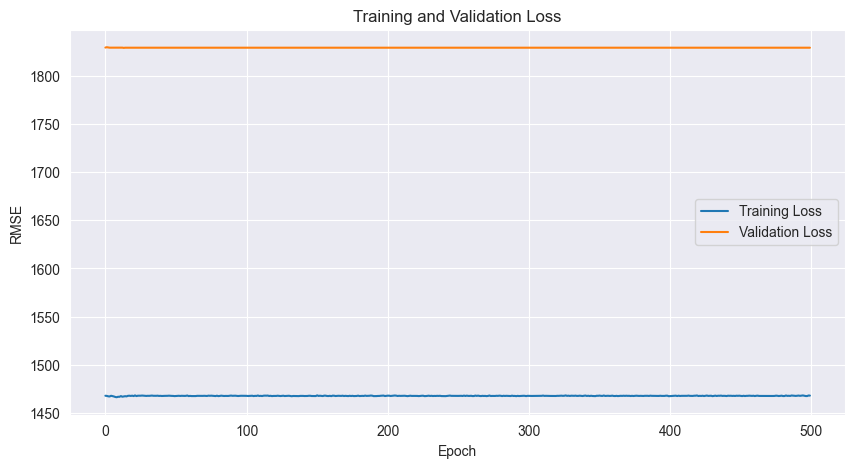

Final validation RMSE: 1828.8125
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.8335, Val RMSE: 1315.3286



  9%|▉         | 44/500 [00:00<00:01, 438.41it/s]

Epoch 10: Train RMSE: 1656.4432, Val RMSE: 1316.1884
Epoch 20: Train RMSE: 1656.5088, Val RMSE: 1316.2550
Epoch 30: Train RMSE: 1656.3380, Val RMSE: 1316.2998
Epoch 40: Train RMSE: 1656.5598, Val RMSE: 1316.5172
Epoch 50: Train RMSE: 1656.4054, Val RMSE: 1316.7241
Epoch 60: Train RMSE: 1656.2767, Val RMSE: 1316.7815
Epoch 70: Train RMSE: 1656.4816, Val RMSE: 1316.8113
Epoch 80: Train RMSE: 1656.2825, Val RMSE: 1316.8234



 18%|█▊        | 88/500 [00:00<00:00, 438.75it/s]

Epoch 90: Train RMSE: 1656.2880, Val RMSE: 1316.8317



 38%|███▊      | 188/500 [00:00<00:00, 480.99it/s]

Epoch 100: Train RMSE: 1656.4580, Val RMSE: 1316.8357
Epoch 110: Train RMSE: 1656.5286, Val RMSE: 1316.8374
Epoch 120: Train RMSE: 1656.4005, Val RMSE: 1316.8383
Epoch 130: Train RMSE: 1656.5259, Val RMSE: 1316.8387
Epoch 140: Train RMSE: 1656.2062, Val RMSE: 1316.8390
Epoch 150: Train RMSE: 1656.5522, Val RMSE: 1316.8391
Epoch 160: Train RMSE: 1656.3850, Val RMSE: 1316.8391
Epoch 170: Train RMSE: 1656.5120, Val RMSE: 1316.8392
Epoch 180: Train RMSE: 1656.3185, Val RMSE: 1316.8392
Epoch 190: Train RMSE: 1656.5646, Val RMSE: 1316.8392
Epoch 200: Train RMSE: 1656.4982, Val RMSE: 1316.8391



 58%|█████▊    | 292/500 [00:00<00:00, 501.43it/s]

Epoch 210: Train RMSE: 1656.3014, Val RMSE: 1316.8391
Epoch 220: Train RMSE: 1656.1949, Val RMSE: 1316.8392
Epoch 230: Train RMSE: 1656.3275, Val RMSE: 1316.8392
Epoch 240: Train RMSE: 1656.4207, Val RMSE: 1316.8392
Epoch 250: Train RMSE: 1656.2716, Val RMSE: 1316.8392
Epoch 260: Train RMSE: 1656.0620, Val RMSE: 1316.8392
Epoch 270: Train RMSE: 1656.5861, Val RMSE: 1316.8392
Epoch 280: Train RMSE: 1656.6105, Val RMSE: 1316.8392
Epoch 290: Train RMSE: 1656.2241, Val RMSE: 1316.8392
Epoch 300: Train RMSE: 1656.3046, Val RMSE: 1316.8392
Epoch 310: Train RMSE: 1656.5404, Val RMSE: 1316.8392



 79%|███████▊  | 393/500 [00:00<00:00, 472.03it/s]

Epoch 320: Train RMSE: 1656.4695, Val RMSE: 1316.8392
Epoch 330: Train RMSE: 1656.4807, Val RMSE: 1316.8392
Epoch 340: Train RMSE: 1656.3521, Val RMSE: 1316.8392
Epoch 350: Train RMSE: 1656.3191, Val RMSE: 1316.8392
Epoch 360: Train RMSE: 1656.5217, Val RMSE: 1316.8392
Epoch 370: Train RMSE: 1656.4596, Val RMSE: 1316.8392
Epoch 380: Train RMSE: 1656.4102, Val RMSE: 1316.8392
Epoch 390: Train RMSE: 1656.5038, Val RMSE: 1316.8392
Epoch 400: Train RMSE: 1656.5033, Val RMSE: 1316.8392



100%|██████████| 500/500 [00:01<00:00, 480.74it/s]

Epoch 410: Train RMSE: 1656.4045, Val RMSE: 1316.8392
Epoch 420: Train RMSE: 1656.4863, Val RMSE: 1316.8392
Epoch 430: Train RMSE: 1656.2518, Val RMSE: 1316.8392
Epoch 440: Train RMSE: 1656.3090, Val RMSE: 1316.8392
Epoch 450: Train RMSE: 1656.3657, Val RMSE: 1316.8392
Epoch 460: Train RMSE: 1656.3859, Val RMSE: 1316.8392
Epoch 470: Train RMSE: 1656.2573, Val RMSE: 1316.8392
Epoch 480: Train RMSE: 1656.4329, Val RMSE: 1316.8392
Epoch 490: Train RMSE: 1656.6528, Val RMSE: 1316.8392


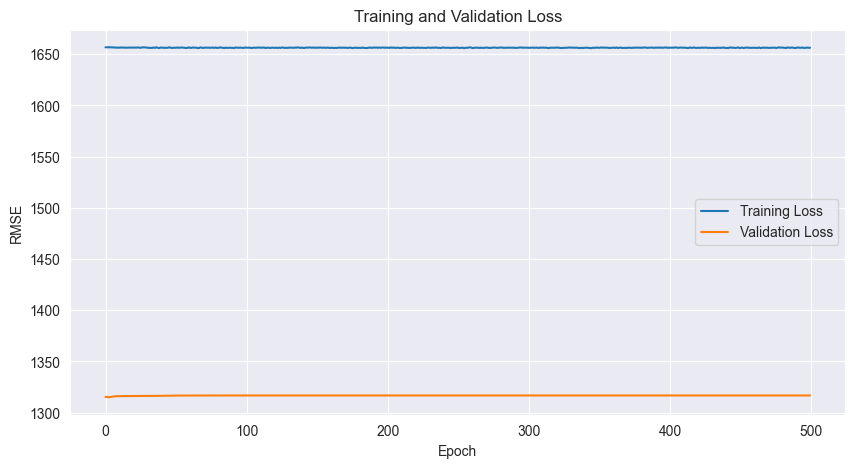

Final validation RMSE: 1315.1161
  Fold 3/5
Input size: 437



  8%|▊         | 38/500 [00:00<00:01, 375.23it/s]

Epoch 0: Train RMSE: 1552.0193, Val RMSE: 2261.8650
Epoch 10: Train RMSE: 1551.9655, Val RMSE: 2262.0667
Epoch 20: Train RMSE: 1552.0270, Val RMSE: 2261.9512
Epoch 30: Train RMSE: 1551.8727, Val RMSE: 2261.8879
Epoch 40: Train RMSE: 1552.0184, Val RMSE: 2261.8457
Epoch 50: Train RMSE: 1551.9644, Val RMSE: 2261.8198
Epoch 60: Train RMSE: 1551.8126, Val RMSE: 2261.8062
Epoch 70: Train RMSE: 1551.8909, Val RMSE: 2261.7988



 24%|██▍       | 121/500 [00:00<00:00, 388.63it/s]

Epoch 80: Train RMSE: 1551.9551, Val RMSE: 2261.7949
Epoch 90: Train RMSE: 1551.7560, Val RMSE: 2261.7932
Epoch 100: Train RMSE: 1551.9187, Val RMSE: 2261.7925
Epoch 110: Train RMSE: 1551.8652, Val RMSE: 2261.7920
Epoch 120: Train RMSE: 1551.9263, Val RMSE: 2261.7917
Epoch 130: Train RMSE: 1551.9000, Val RMSE: 2261.7915
Epoch 140: Train RMSE: 1551.8787, Val RMSE: 2261.7913
Epoch 150: Train RMSE: 1551.8441, Val RMSE: 2261.7913
Epoch 160: Train RMSE: 1551.8304, Val RMSE: 2261.7913



 44%|████▍     | 222/500 [00:00<00:00, 456.24it/s]

Epoch 170: Train RMSE: 1551.8905, Val RMSE: 2261.7913
Epoch 180: Train RMSE: 1551.8423, Val RMSE: 2261.7913
Epoch 190: Train RMSE: 1551.8207, Val RMSE: 2261.7913
Epoch 200: Train RMSE: 1551.9982, Val RMSE: 2261.7913
Epoch 210: Train RMSE: 1551.8798, Val RMSE: 2261.7913
Epoch 220: Train RMSE: 1551.8779, Val RMSE: 2261.7913
Epoch 230: Train RMSE: 1551.8663, Val RMSE: 2261.7913
Epoch 240: Train RMSE: 1551.9691, Val RMSE: 2261.7913
Epoch 250: Train RMSE: 1551.8372, Val RMSE: 2261.7913
Epoch 260: Train RMSE: 1551.9260, Val RMSE: 2261.7913
Epoch 270: Train RMSE: 1551.9255, Val RMSE: 2261.7913



 65%|██████▌   | 327/500 [00:00<00:00, 483.84it/s]

Epoch 280: Train RMSE: 1551.9208, Val RMSE: 2261.7913
Epoch 290: Train RMSE: 1551.9673, Val RMSE: 2261.7913
Epoch 300: Train RMSE: 1551.8190, Val RMSE: 2261.7913
Epoch 310: Train RMSE: 1551.9132, Val RMSE: 2261.7913
Epoch 320: Train RMSE: 1551.9795, Val RMSE: 2261.7913
Epoch 330: Train RMSE: 1551.8542, Val RMSE: 2261.7913
Epoch 340: Train RMSE: 1551.8983, Val RMSE: 2261.7913
Epoch 350: Train RMSE: 1551.7616, Val RMSE: 2261.7913
Epoch 360: Train RMSE: 1551.8480, Val RMSE: 2261.7913
Epoch 370: Train RMSE: 1551.8733, Val RMSE: 2261.7913



 95%|█████████▌| 475/500 [00:01<00:00, 471.62it/s]

Epoch 380: Train RMSE: 1551.9764, Val RMSE: 2261.7913
Epoch 390: Train RMSE: 1551.9926, Val RMSE: 2261.7913
Epoch 400: Train RMSE: 1551.9381, Val RMSE: 2261.7913
Epoch 410: Train RMSE: 1551.8759, Val RMSE: 2261.7913
Epoch 420: Train RMSE: 1551.8085, Val RMSE: 2261.7913
Epoch 430: Train RMSE: 1551.8213, Val RMSE: 2261.7913
Epoch 440: Train RMSE: 1551.8784, Val RMSE: 2261.7913
Epoch 450: Train RMSE: 1551.8827, Val RMSE: 2261.7913
Epoch 460: Train RMSE: 1551.9966, Val RMSE: 2261.7913
Epoch 470: Train RMSE: 1552.0051, Val RMSE: 2261.7913


100%|██████████| 500/500 [00:01<00:00, 453.96it/s]


Epoch 480: Train RMSE: 1551.8177, Val RMSE: 2261.7913
Epoch 490: Train RMSE: 1551.7384, Val RMSE: 2261.7913


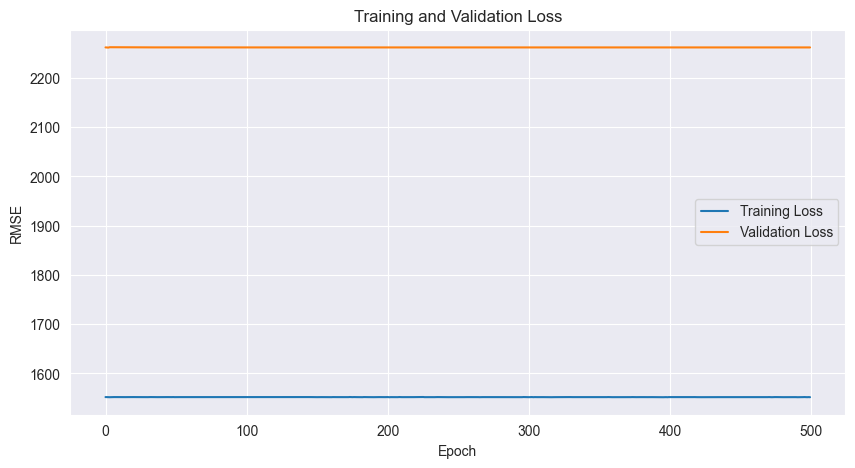

Final validation RMSE: 2261.4717
  Fold 4/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1755.9629, Val RMSE: 2261.8562
Epoch 10: Train RMSE: 1755.2097, Val RMSE: 2262.0271
Epoch 20: Train RMSE: 1754.9166, Val RMSE: 2262.1130



  7%|▋         | 35/500 [00:00<00:01, 345.56it/s]

Epoch 30: Train RMSE: 1754.6775, Val RMSE: 2262.1704
Epoch 40: Train RMSE: 1754.7242, Val RMSE: 2262.2048
Epoch 50: Train RMSE: 1754.5748, Val RMSE: 2262.2219
Epoch 60: Train RMSE: 1754.6129, Val RMSE: 2262.2322



 15%|█▍        | 73/500 [00:00<00:01, 362.06it/s]

Epoch 70: Train RMSE: 1754.5704, Val RMSE: 2262.2375
Epoch 80: Train RMSE: 1754.6002, Val RMSE: 2262.2405
Epoch 90: Train RMSE: 1754.5897, Val RMSE: 2262.2422
Epoch 100: Train RMSE: 1754.5785, Val RMSE: 2262.2429



 22%|██▏       | 110/500 [00:00<00:01, 360.02it/s]

Epoch 110: Train RMSE: 1754.5551, Val RMSE: 2262.2434
Epoch 120: Train RMSE: 1754.5720, Val RMSE: 2262.2439
Epoch 130: Train RMSE: 1754.6249, Val RMSE: 2262.2439
Epoch 140: Train RMSE: 1754.8400, Val RMSE: 2262.2439
Epoch 150: Train RMSE: 1754.5720, Val RMSE: 2262.2439



 31%|███       | 155/500 [00:00<00:00, 392.61it/s]

Epoch 160: Train RMSE: 1754.4584, Val RMSE: 2262.2439



 39%|███▉      | 197/500 [00:00<00:00, 400.08it/s]

Epoch 170: Train RMSE: 1754.4867, Val RMSE: 2262.2439
Epoch 180: Train RMSE: 1754.5559, Val RMSE: 2262.2439
Epoch 190: Train RMSE: 1754.4005, Val RMSE: 2262.2439



 48%|████▊     | 242/500 [00:00<00:00, 416.47it/s]

Epoch 200: Train RMSE: 1754.2949, Val RMSE: 2262.2439
Epoch 210: Train RMSE: 1754.4637, Val RMSE: 2262.2439
Epoch 220: Train RMSE: 1754.4567, Val RMSE: 2262.2439
Epoch 230: Train RMSE: 1754.5393, Val RMSE: 2262.2439
Epoch 240: Train RMSE: 1754.4226, Val RMSE: 2262.2439
Epoch 250: Train RMSE: 1754.4526, Val RMSE: 2262.2439



 57%|█████▋    | 284/500 [00:00<00:00, 408.02it/s]

Epoch 260: Train RMSE: 1754.5107, Val RMSE: 2262.2439
Epoch 270: Train RMSE: 1754.8083, Val RMSE: 2262.2439
Epoch 280: Train RMSE: 1754.6731, Val RMSE: 2262.2439



 65%|██████▌   | 325/500 [00:00<00:00, 393.08it/s]

Epoch 290: Train RMSE: 1754.3522, Val RMSE: 2262.2439
Epoch 300: Train RMSE: 1754.3766, Val RMSE: 2262.2439
Epoch 310: Train RMSE: 1754.4513, Val RMSE: 2262.2441
Epoch 320: Train RMSE: 1754.5944, Val RMSE: 2262.2441
Epoch 330: Train RMSE: 1754.4988, Val RMSE: 2262.2441



 73%|███████▎  | 366/500 [00:00<00:00, 397.19it/s]

Epoch 340: Train RMSE: 1754.5288, Val RMSE: 2262.2441
Epoch 350: Train RMSE: 1754.5106, Val RMSE: 2262.2441
Epoch 360: Train RMSE: 1754.5197, Val RMSE: 2262.2441



 81%|████████  | 406/500 [00:01<00:00, 387.05it/s]

Epoch 370: Train RMSE: 1754.5522, Val RMSE: 2262.2441
Epoch 380: Train RMSE: 1754.4921, Val RMSE: 2262.2441
Epoch 390: Train RMSE: 1754.6943, Val RMSE: 2262.2441
Epoch 400: Train RMSE: 1754.5439, Val RMSE: 2262.2441
Epoch 410: Train RMSE: 1754.6185, Val RMSE: 2262.2441



 89%|████████▉ | 445/500 [00:01<00:00, 380.79it/s]

Epoch 420: Train RMSE: 1754.5498, Val RMSE: 2262.2441
Epoch 430: Train RMSE: 1754.6371, Val RMSE: 2262.2441
Epoch 440: Train RMSE: 1754.5599, Val RMSE: 2262.2441



 97%|█████████▋| 484/500 [00:01<00:00, 376.12it/s]

Epoch 450: Train RMSE: 1754.5864, Val RMSE: 2262.2441
Epoch 460: Train RMSE: 1754.4421, Val RMSE: 2262.2439
Epoch 470: Train RMSE: 1754.5007, Val RMSE: 2262.2439
Epoch 480: Train RMSE: 1754.6140, Val RMSE: 2262.2439
Epoch 490: Train RMSE: 1754.5654, Val RMSE: 2262.2439


100%|██████████| 500/500 [00:01<00:00, 385.17it/s]


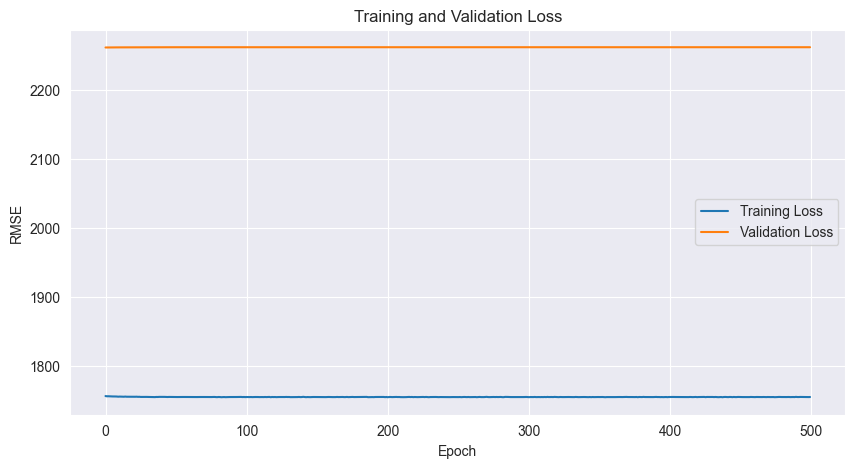

Final validation RMSE: 2261.8562
  Fold 5/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1867.7578, Val RMSE: 2493.0198
Epoch 10: Train RMSE: 1867.5315, Val RMSE: 2493.4004
Epoch 20: Train RMSE: 1867.3794, Val RMSE: 2493.5410



  6%|▌         | 28/500 [00:00<00:01, 276.47it/s]

Epoch 30: Train RMSE: 1867.3113, Val RMSE: 2493.5898
Epoch 40: Train RMSE: 1867.2544, Val RMSE: 2493.5974
Epoch 50: Train RMSE: 1867.2837, Val RMSE: 2493.6113



 11%|█         | 56/500 [00:00<00:01, 246.82it/s]

Epoch 60: Train RMSE: 1867.3395, Val RMSE: 2493.6240
Epoch 70: Train RMSE: 1867.2261, Val RMSE: 2493.6294
Epoch 80: Train RMSE: 1867.2981, Val RMSE: 2493.6311



 17%|█▋        | 85/500 [00:00<00:01, 264.39it/s]

Epoch 90: Train RMSE: 1867.2386, Val RMSE: 2493.6321
Epoch 100: Train RMSE: 1867.2151, Val RMSE: 2493.6328
Epoch 110: Train RMSE: 1867.2852, Val RMSE: 2493.6331



 23%|██▎       | 117/500 [00:00<00:01, 284.29it/s]

Epoch 120: Train RMSE: 1867.2014, Val RMSE: 2493.6333



 30%|███       | 152/500 [00:00<00:01, 303.28it/s]

Epoch 130: Train RMSE: 1867.4243, Val RMSE: 2493.6333
Epoch 140: Train RMSE: 1867.2029, Val RMSE: 2493.6335
Epoch 150: Train RMSE: 1867.3256, Val RMSE: 2493.6333



 37%|███▋      | 183/500 [00:00<00:01, 294.30it/s]

Epoch 160: Train RMSE: 1867.1947, Val RMSE: 2493.6335
Epoch 170: Train RMSE: 1867.4061, Val RMSE: 2493.6335
Epoch 180: Train RMSE: 1867.2556, Val RMSE: 2493.6335



 43%|████▎     | 213/500 [00:00<00:00, 295.57it/s]

Epoch 190: Train RMSE: 1867.5149, Val RMSE: 2493.6335
Epoch 200: Train RMSE: 1867.2322, Val RMSE: 2493.6335
Epoch 210: Train RMSE: 1867.2091, Val RMSE: 2493.6335



 49%|████▊     | 243/500 [00:00<00:00, 296.00it/s]

Epoch 220: Train RMSE: 1867.3630, Val RMSE: 2493.6335
Epoch 230: Train RMSE: 1867.3170, Val RMSE: 2493.6335
Epoch 240: Train RMSE: 1867.1722, Val RMSE: 2493.6335
Epoch 250: Train RMSE: 1867.2487, Val RMSE: 2493.6335



 55%|█████▍    | 273/500 [00:00<00:00, 297.11it/s]

Epoch 260: Train RMSE: 1867.3802, Val RMSE: 2493.6335
Epoch 270: Train RMSE: 1867.2817, Val RMSE: 2493.6335
Epoch 280: Train RMSE: 1867.2716, Val RMSE: 2493.6335



 61%|██████    | 303/500 [00:01<00:00, 293.68it/s]

Epoch 290: Train RMSE: 1867.2817, Val RMSE: 2493.6335
Epoch 300: Train RMSE: 1867.1733, Val RMSE: 2493.6335
Epoch 310: Train RMSE: 1867.0911, Val RMSE: 2493.6335
Epoch 320: Train RMSE: 1867.3054, Val RMSE: 2493.6335



 67%|██████▋   | 333/500 [00:01<00:00, 291.31it/s]

Epoch 330: Train RMSE: 1867.3403, Val RMSE: 2493.6335
Epoch 340: Train RMSE: 1867.2722, Val RMSE: 2493.6335



 73%|███████▎  | 366/500 [00:01<00:00, 301.88it/s]

Epoch 350: Train RMSE: 1867.2714, Val RMSE: 2493.6335
Epoch 360: Train RMSE: 1867.3597, Val RMSE: 2493.6335
Epoch 370: Train RMSE: 1867.2656, Val RMSE: 2493.6335
Epoch 380: Train RMSE: 1867.3785, Val RMSE: 2493.6335
Epoch 390: Train RMSE: 1867.1753, Val RMSE: 2493.6335



 81%|████████  | 404/500 [00:01<00:00, 322.62it/s]

Epoch 400: Train RMSE: 1867.4423, Val RMSE: 2493.6335
Epoch 410: Train RMSE: 1867.1581, Val RMSE: 2493.6335
Epoch 420: Train RMSE: 1867.3434, Val RMSE: 2493.6335



 88%|████████▊ | 438/500 [00:01<00:00, 326.04it/s]

Epoch 430: Train RMSE: 1867.3480, Val RMSE: 2493.6335
Epoch 440: Train RMSE: 1867.3358, Val RMSE: 2493.6335
Epoch 450: Train RMSE: 1867.4017, Val RMSE: 2493.6335
Epoch 460: Train RMSE: 1867.2679, Val RMSE: 2493.6335



100%|██████████| 500/500 [00:01<00:00, 304.88it/s]

Epoch 470: Train RMSE: 1867.1692, Val RMSE: 2493.6335
Epoch 480: Train RMSE: 1867.2062, Val RMSE: 2493.6335
Epoch 490: Train RMSE: 1867.2404, Val RMSE: 2493.6335


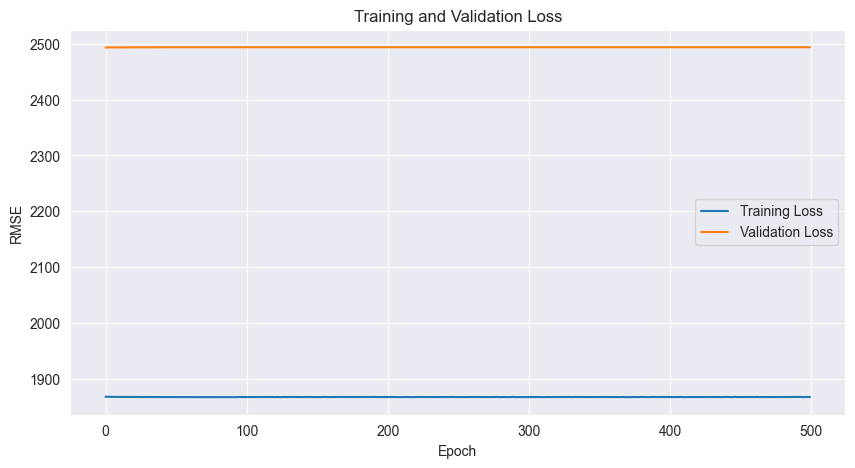

Final validation RMSE: 2493.0198
  Avg RMSE: 2032.0552 ± 417.9086

Testing: hidden_size=64, layers=5, lr=0.0001
  Fold 1/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1467.7745, Val RMSE: 1828.9404



  3%|▎         | 17/500 [00:00<00:02, 164.00it/s]

Epoch 10: Train RMSE: 1467.8602, Val RMSE: 1828.9365
Epoch 20: Train RMSE: 1467.9379, Val RMSE: 1828.9299
Epoch 30: Train RMSE: 1467.7906, Val RMSE: 1828.9279



  7%|▋         | 34/500 [00:00<00:02, 164.20it/s]

Epoch 40: Train RMSE: 1467.6368, Val RMSE: 1828.9272



 17%|█▋        | 84/500 [00:00<00:01, 222.94it/s]

Epoch 50: Train RMSE: 1467.6434, Val RMSE: 1828.9270
Epoch 60: Train RMSE: 1467.8202, Val RMSE: 1828.9271
Epoch 70: Train RMSE: 1467.8275, Val RMSE: 1828.9271
Epoch 80: Train RMSE: 1467.7028, Val RMSE: 1828.9269
Epoch 90: Train RMSE: 1467.7241, Val RMSE: 1828.9269
Epoch 100: Train RMSE: 1467.6743, Val RMSE: 1828.9269



 27%|██▋       | 133/500 [00:00<00:01, 234.03it/s]

Epoch 110: Train RMSE: 1467.4875, Val RMSE: 1828.9269
Epoch 120: Train RMSE: 1467.5616, Val RMSE: 1828.9269
Epoch 130: Train RMSE: 1467.6907, Val RMSE: 1828.9269
Epoch 140: Train RMSE: 1467.9598, Val RMSE: 1828.9269
Epoch 150: Train RMSE: 1467.9253, Val RMSE: 1828.9269



 32%|███▏      | 161/500 [00:00<00:01, 246.76it/s]

Epoch 160: Train RMSE: 1467.7678, Val RMSE: 1828.9269



 38%|███▊      | 191/500 [00:00<00:01, 261.84it/s]

Epoch 170: Train RMSE: 1467.9343, Val RMSE: 1828.9269
Epoch 180: Train RMSE: 1467.7061, Val RMSE: 1828.9269
Epoch 190: Train RMSE: 1467.7576, Val RMSE: 1828.9269
Epoch 200: Train RMSE: 1467.7988, Val RMSE: 1828.9269
Epoch 210: Train RMSE: 1467.7019, Val RMSE: 1828.9269



 44%|████▍     | 220/500 [00:00<00:01, 267.15it/s]

Epoch 220: Train RMSE: 1467.8456, Val RMSE: 1828.9269



 49%|████▉     | 247/500 [00:01<00:00, 255.92it/s]

Epoch 230: Train RMSE: 1467.9760, Val RMSE: 1828.9269
Epoch 240: Train RMSE: 1467.8822, Val RMSE: 1828.9269
Epoch 250: Train RMSE: 1467.8461, Val RMSE: 1828.9269
Epoch 260: Train RMSE: 1467.5441, Val RMSE: 1828.9269



 55%|█████▍    | 273/500 [00:01<00:00, 247.54it/s]

Epoch 270: Train RMSE: 1467.6472, Val RMSE: 1828.9269



 60%|█████▉    | 299/500 [00:01<00:00, 251.10it/s]

Epoch 280: Train RMSE: 1467.7203, Val RMSE: 1828.9269
Epoch 290: Train RMSE: 1467.6703, Val RMSE: 1828.9269
Epoch 300: Train RMSE: 1467.6892, Val RMSE: 1828.9269
Epoch 310: Train RMSE: 1467.6930, Val RMSE: 1828.9269
Epoch 320: Train RMSE: 1467.6952, Val RMSE: 1828.9269



 65%|██████▌   | 326/500 [00:01<00:00, 256.05it/s]

Epoch 330: Train RMSE: 1467.6589, Val RMSE: 1828.9269



 76%|███████▌  | 379/500 [00:01<00:00, 254.37it/s]

Epoch 340: Train RMSE: 1467.6671, Val RMSE: 1828.9269
Epoch 350: Train RMSE: 1467.8865, Val RMSE: 1828.9269
Epoch 360: Train RMSE: 1467.6652, Val RMSE: 1828.9269
Epoch 370: Train RMSE: 1467.5245, Val RMSE: 1828.9269
Epoch 380: Train RMSE: 1467.6704, Val RMSE: 1828.9269
Epoch 390: Train RMSE: 1467.6844, Val RMSE: 1828.9269



 86%|████████▋ | 432/500 [00:01<00:00, 252.36it/s]

Epoch 400: Train RMSE: 1467.6505, Val RMSE: 1828.9269
Epoch 410: Train RMSE: 1467.6599, Val RMSE: 1828.9269
Epoch 420: Train RMSE: 1467.6791, Val RMSE: 1828.9269
Epoch 430: Train RMSE: 1467.5938, Val RMSE: 1828.9269
Epoch 440: Train RMSE: 1467.8798, Val RMSE: 1828.9269
Epoch 450: Train RMSE: 1467.8016, Val RMSE: 1828.9269



100%|██████████| 500/500 [00:02<00:00, 245.61it/s]

Epoch 460: Train RMSE: 1467.6769, Val RMSE: 1828.9269
Epoch 470: Train RMSE: 1467.9172, Val RMSE: 1828.9269
Epoch 480: Train RMSE: 1467.7688, Val RMSE: 1828.9269
Epoch 490: Train RMSE: 1467.9445, Val RMSE: 1828.9269


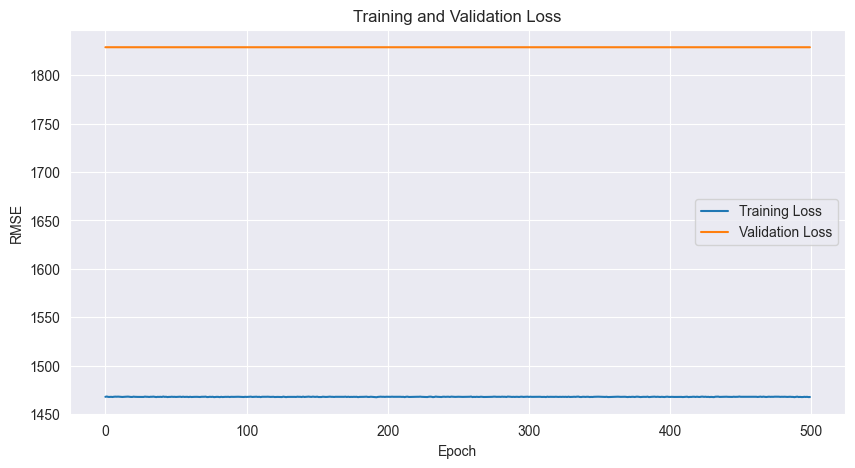

Final validation RMSE: 1828.9269
  Fold 2/5
Input size: 437



  4%|▎         | 18/500 [00:00<00:02, 175.48it/s]

Epoch 0: Train RMSE: 1656.7094, Val RMSE: 1316.0991
Epoch 10: Train RMSE: 1656.6987, Val RMSE: 1316.1600
Epoch 20: Train RMSE: 1656.8324, Val RMSE: 1316.1851
Epoch 30: Train RMSE: 1656.6786, Val RMSE: 1316.1849



 18%|█▊        | 89/500 [00:00<00:01, 230.18it/s]

Epoch 40: Train RMSE: 1656.8069, Val RMSE: 1316.1821
Epoch 50: Train RMSE: 1656.7739, Val RMSE: 1316.1818
Epoch 60: Train RMSE: 1656.6449, Val RMSE: 1316.1818
Epoch 70: Train RMSE: 1656.6084, Val RMSE: 1316.1821
Epoch 80: Train RMSE: 1656.7175, Val RMSE: 1316.1830
Epoch 90: Train RMSE: 1656.6990, Val RMSE: 1316.1832



 28%|██▊       | 141/500 [00:00<00:01, 225.60it/s]

Epoch 100: Train RMSE: 1656.7023, Val RMSE: 1316.1831
Epoch 110: Train RMSE: 1656.7205, Val RMSE: 1316.1832
Epoch 120: Train RMSE: 1656.6063, Val RMSE: 1316.1832
Epoch 130: Train RMSE: 1656.7247, Val RMSE: 1316.1832
Epoch 140: Train RMSE: 1656.5565, Val RMSE: 1316.1832



 38%|███▊      | 189/500 [00:00<00:01, 224.97it/s]

Epoch 150: Train RMSE: 1656.7086, Val RMSE: 1316.1832
Epoch 160: Train RMSE: 1656.6748, Val RMSE: 1316.1831
Epoch 170: Train RMSE: 1656.7256, Val RMSE: 1316.1831
Epoch 180: Train RMSE: 1656.5809, Val RMSE: 1316.1831
Epoch 190: Train RMSE: 1656.5720, Val RMSE: 1316.1831



 47%|████▋     | 234/500 [00:01<00:01, 213.89it/s]

Epoch 200: Train RMSE: 1656.7074, Val RMSE: 1316.1831
Epoch 210: Train RMSE: 1656.6060, Val RMSE: 1316.1831
Epoch 220: Train RMSE: 1656.7197, Val RMSE: 1316.1831
Epoch 230: Train RMSE: 1656.6520, Val RMSE: 1316.1831
Epoch 240: Train RMSE: 1656.6857, Val RMSE: 1316.1831



 56%|█████▌    | 278/500 [00:01<00:01, 209.38it/s]

Epoch 250: Train RMSE: 1656.7032, Val RMSE: 1316.1831
Epoch 260: Train RMSE: 1656.6302, Val RMSE: 1316.1831
Epoch 270: Train RMSE: 1656.6411, Val RMSE: 1316.1831
Epoch 280: Train RMSE: 1656.6254, Val RMSE: 1316.1831
Epoch 290: Train RMSE: 1656.7338, Val RMSE: 1316.1831



 65%|██████▍   | 324/500 [00:01<00:00, 217.23it/s]

Epoch 300: Train RMSE: 1656.6985, Val RMSE: 1316.1831
Epoch 310: Train RMSE: 1656.6761, Val RMSE: 1316.1831
Epoch 320: Train RMSE: 1656.6272, Val RMSE: 1316.1831
Epoch 330: Train RMSE: 1656.7493, Val RMSE: 1316.1831
Epoch 340: Train RMSE: 1656.6661, Val RMSE: 1316.1831



 75%|███████▌  | 376/500 [00:01<00:00, 232.75it/s]

Epoch 350: Train RMSE: 1656.7509, Val RMSE: 1316.1831
Epoch 360: Train RMSE: 1656.7092, Val RMSE: 1316.1831
Epoch 370: Train RMSE: 1656.7070, Val RMSE: 1316.1831
Epoch 380: Train RMSE: 1656.7394, Val RMSE: 1316.1831
Epoch 390: Train RMSE: 1656.6572, Val RMSE: 1316.1831



 85%|████████▍ | 423/500 [00:01<00:00, 218.39it/s]

Epoch 400: Train RMSE: 1656.5942, Val RMSE: 1316.1831
Epoch 410: Train RMSE: 1656.6559, Val RMSE: 1316.1831
Epoch 420: Train RMSE: 1656.7184, Val RMSE: 1316.1831
Epoch 430: Train RMSE: 1656.7378, Val RMSE: 1316.1831
Epoch 440: Train RMSE: 1656.8121, Val RMSE: 1316.1831



100%|██████████| 500/500 [00:02<00:00, 222.56it/s]

Epoch 450: Train RMSE: 1656.6195, Val RMSE: 1316.1831
Epoch 460: Train RMSE: 1656.7382, Val RMSE: 1316.1831
Epoch 470: Train RMSE: 1656.6957, Val RMSE: 1316.1831
Epoch 480: Train RMSE: 1656.7876, Val RMSE: 1316.1831
Epoch 490: Train RMSE: 1656.7461, Val RMSE: 1316.1831


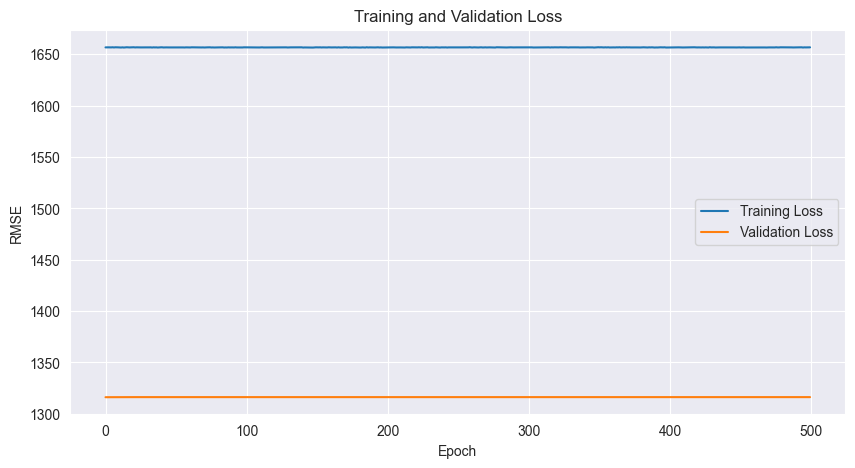

Final validation RMSE: 1316.0861
  Fold 3/5
Input size: 437



  0%|          | 1/500 [00:00<01:03,  7.90it/s]

Epoch 0: Train RMSE: 1552.0337, Val RMSE: 2262.2700
Epoch 10: Train RMSE: 1552.0558, Val RMSE: 2262.3069



 10%|▉         | 49/500 [00:00<00:03, 127.76it/s]

Epoch 20: Train RMSE: 1551.9951, Val RMSE: 2262.3433
Epoch 30: Train RMSE: 1552.0382, Val RMSE: 2262.3350
Epoch 40: Train RMSE: 1552.0122, Val RMSE: 2262.3311
Epoch 50: Train RMSE: 1552.0908, Val RMSE: 2262.3176



 17%|█▋        | 84/500 [00:00<00:02, 151.56it/s]

Epoch 60: Train RMSE: 1551.8652, Val RMSE: 2262.3152
Epoch 70: Train RMSE: 1551.8636, Val RMSE: 2262.3159
Epoch 80: Train RMSE: 1551.9415, Val RMSE: 2262.3157
Epoch 90: Train RMSE: 1551.9008, Val RMSE: 2262.3157



 24%|██▍       | 121/500 [00:00<00:02, 164.58it/s]

Epoch 100: Train RMSE: 1552.0735, Val RMSE: 2262.3152
Epoch 110: Train RMSE: 1552.1545, Val RMSE: 2262.3152
Epoch 120: Train RMSE: 1551.9341, Val RMSE: 2262.3152
Epoch 130: Train RMSE: 1551.9890, Val RMSE: 2262.3152



 32%|███▏      | 161/500 [00:01<00:01, 179.39it/s]

Epoch 140: Train RMSE: 1551.9351, Val RMSE: 2262.3152
Epoch 150: Train RMSE: 1551.8696, Val RMSE: 2262.3152
Epoch 160: Train RMSE: 1551.9061, Val RMSE: 2262.3152
Epoch 170: Train RMSE: 1551.9844, Val RMSE: 2262.3152



 45%|████▍     | 223/500 [00:01<00:01, 198.25it/s]

Epoch 180: Train RMSE: 1551.8330, Val RMSE: 2262.3152
Epoch 190: Train RMSE: 1552.0739, Val RMSE: 2262.3152
Epoch 200: Train RMSE: 1552.0049, Val RMSE: 2262.3152
Epoch 210: Train RMSE: 1551.9313, Val RMSE: 2262.3152
Epoch 220: Train RMSE: 1551.9779, Val RMSE: 2262.3152



 53%|█████▎    | 263/500 [00:01<00:01, 185.72it/s]

Epoch 230: Train RMSE: 1552.0793, Val RMSE: 2262.3152
Epoch 240: Train RMSE: 1552.1525, Val RMSE: 2262.3152
Epoch 250: Train RMSE: 1551.9882, Val RMSE: 2262.3152
Epoch 260: Train RMSE: 1551.8936, Val RMSE: 2262.3152



 60%|██████    | 301/500 [00:01<00:01, 182.95it/s]

Epoch 270: Train RMSE: 1551.9734, Val RMSE: 2262.3152
Epoch 280: Train RMSE: 1552.0334, Val RMSE: 2262.3152
Epoch 290: Train RMSE: 1551.8850, Val RMSE: 2262.3152
Epoch 300: Train RMSE: 1552.0065, Val RMSE: 2262.3152



 68%|██████▊   | 340/500 [00:02<00:00, 184.16it/s]

Epoch 310: Train RMSE: 1552.0056, Val RMSE: 2262.3152
Epoch 320: Train RMSE: 1551.8540, Val RMSE: 2262.3152
Epoch 330: Train RMSE: 1551.9374, Val RMSE: 2262.3152
Epoch 340: Train RMSE: 1551.8842, Val RMSE: 2262.3152



 76%|███████▌  | 380/500 [00:02<00:00, 186.70it/s]

Epoch 350: Train RMSE: 1551.8109, Val RMSE: 2262.3152
Epoch 360: Train RMSE: 1552.1067, Val RMSE: 2262.3152
Epoch 370: Train RMSE: 1552.0073, Val RMSE: 2262.3152
Epoch 380: Train RMSE: 1552.0220, Val RMSE: 2262.3152



 84%|████████▍ | 421/500 [00:02<00:00, 194.15it/s]

Epoch 390: Train RMSE: 1551.8915, Val RMSE: 2262.3152
Epoch 400: Train RMSE: 1551.9758, Val RMSE: 2262.3152
Epoch 410: Train RMSE: 1551.9502, Val RMSE: 2262.3149
Epoch 420: Train RMSE: 1552.0045, Val RMSE: 2262.3149
Epoch 430: Train RMSE: 1552.0193, Val RMSE: 2262.3149



 92%|█████████▏| 461/500 [00:02<00:00, 158.78it/s]

Epoch 440: Train RMSE: 1552.0847, Val RMSE: 2262.3149
Epoch 450: Train RMSE: 1551.8694, Val RMSE: 2262.3149
Epoch 460: Train RMSE: 1552.0010, Val RMSE: 2262.3149



100%|██████████| 500/500 [00:02<00:00, 168.97it/s]

Epoch 470: Train RMSE: 1551.8621, Val RMSE: 2262.3149
Epoch 480: Train RMSE: 1552.0317, Val RMSE: 2262.3149
Epoch 490: Train RMSE: 1551.9550, Val RMSE: 2262.3149


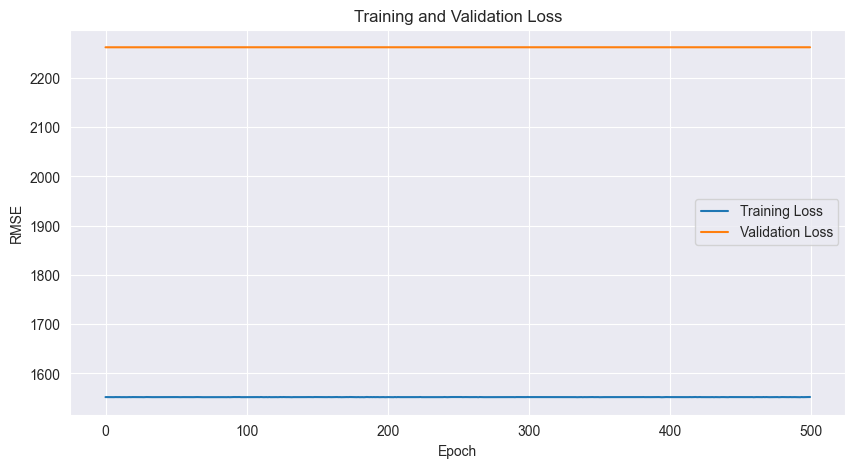

Final validation RMSE: 2262.2437
  Fold 4/5
Input size: 437



  2%|▏         | 12/500 [00:00<00:04, 119.51it/s]

Epoch 0: Train RMSE: 1755.9108, Val RMSE: 2261.7915
Epoch 10: Train RMSE: 1755.9458, Val RMSE: 2261.7891
Epoch 20: Train RMSE: 1755.8544, Val RMSE: 2261.7720



  9%|▉         | 46/500 [00:00<00:02, 154.72it/s]

Epoch 30: Train RMSE: 1755.8634, Val RMSE: 2261.8059
Epoch 40: Train RMSE: 1755.8511, Val RMSE: 2261.8062
Epoch 50: Train RMSE: 1755.9160, Val RMSE: 2261.8062
Epoch 60: Train RMSE: 1755.8719, Val RMSE: 2261.8064



 19%|█▉        | 94/500 [00:00<00:02, 152.79it/s]

Epoch 70: Train RMSE: 1755.8777, Val RMSE: 2261.8062
Epoch 80: Train RMSE: 1755.7816, Val RMSE: 2261.8064
Epoch 90: Train RMSE: 1755.9081, Val RMSE: 2261.8064
Epoch 100: Train RMSE: 1755.8529, Val RMSE: 2261.8066



 26%|██▌       | 129/500 [00:00<00:02, 161.00it/s]

Epoch 110: Train RMSE: 1755.9279, Val RMSE: 2261.8066
Epoch 120: Train RMSE: 1755.8792, Val RMSE: 2261.8066
Epoch 130: Train RMSE: 1755.8834, Val RMSE: 2261.8066
Epoch 140: Train RMSE: 1755.8931, Val RMSE: 2261.8066



 37%|███▋      | 183/500 [00:01<00:01, 172.71it/s]

Epoch 150: Train RMSE: 1755.9260, Val RMSE: 2261.8066
Epoch 160: Train RMSE: 1755.8115, Val RMSE: 2261.8066
Epoch 170: Train RMSE: 1755.8740, Val RMSE: 2261.8066
Epoch 180: Train RMSE: 1755.9015, Val RMSE: 2261.8066



 44%|████▎     | 218/500 [00:01<00:01, 168.12it/s]

Epoch 190: Train RMSE: 1755.9043, Val RMSE: 2261.8066
Epoch 200: Train RMSE: 1755.8567, Val RMSE: 2261.8066
Epoch 210: Train RMSE: 1755.8665, Val RMSE: 2261.8066
Epoch 220: Train RMSE: 1755.8534, Val RMSE: 2261.8066



 51%|█████     | 253/500 [00:01<00:01, 164.87it/s]

Epoch 230: Train RMSE: 1755.8468, Val RMSE: 2261.8066
Epoch 240: Train RMSE: 1755.8518, Val RMSE: 2261.8066
Epoch 250: Train RMSE: 1755.8077, Val RMSE: 2261.8066
Epoch 260: Train RMSE: 1755.9115, Val RMSE: 2261.8066



 58%|█████▊    | 292/500 [00:01<00:01, 177.96it/s]

Epoch 270: Train RMSE: 1755.8702, Val RMSE: 2261.8066
Epoch 280: Train RMSE: 1755.8333, Val RMSE: 2261.8066
Epoch 290: Train RMSE: 1755.8307, Val RMSE: 2261.8066
Epoch 300: Train RMSE: 1755.9340, Val RMSE: 2261.8066



 66%|██████▌   | 328/500 [00:01<00:01, 168.77it/s]

Epoch 310: Train RMSE: 1755.8761, Val RMSE: 2261.8066
Epoch 320: Train RMSE: 1755.9270, Val RMSE: 2261.8066
Epoch 330: Train RMSE: 1755.9167, Val RMSE: 2261.8066
Epoch 340: Train RMSE: 1755.7545, Val RMSE: 2261.8066



 77%|███████▋  | 387/500 [00:02<00:00, 183.51it/s]

Epoch 350: Train RMSE: 1755.7970, Val RMSE: 2261.8066
Epoch 360: Train RMSE: 1755.9626, Val RMSE: 2261.8066
Epoch 370: Train RMSE: 1755.8623, Val RMSE: 2261.8066
Epoch 380: Train RMSE: 1755.9279, Val RMSE: 2261.8066
Epoch 390: Train RMSE: 1755.9574, Val RMSE: 2261.8066



 85%|████████▍ | 424/500 [00:02<00:00, 173.02it/s]

Epoch 400: Train RMSE: 1755.8193, Val RMSE: 2261.8066
Epoch 410: Train RMSE: 1755.7778, Val RMSE: 2261.8066
Epoch 420: Train RMSE: 1755.9464, Val RMSE: 2261.8066
Epoch 430: Train RMSE: 1755.9240, Val RMSE: 2261.8066



 92%|█████████▏| 459/500 [00:02<00:00, 165.20it/s]

Epoch 440: Train RMSE: 1755.8481, Val RMSE: 2261.8066
Epoch 450: Train RMSE: 1755.8042, Val RMSE: 2261.8066
Epoch 460: Train RMSE: 1755.9000, Val RMSE: 2261.8066
Epoch 470: Train RMSE: 1755.7932, Val RMSE: 2261.8066



100%|██████████| 500/500 [00:03<00:00, 165.79it/s]


Epoch 480: Train RMSE: 1755.8715, Val RMSE: 2261.8066
Epoch 490: Train RMSE: 1755.8901, Val RMSE: 2261.8066


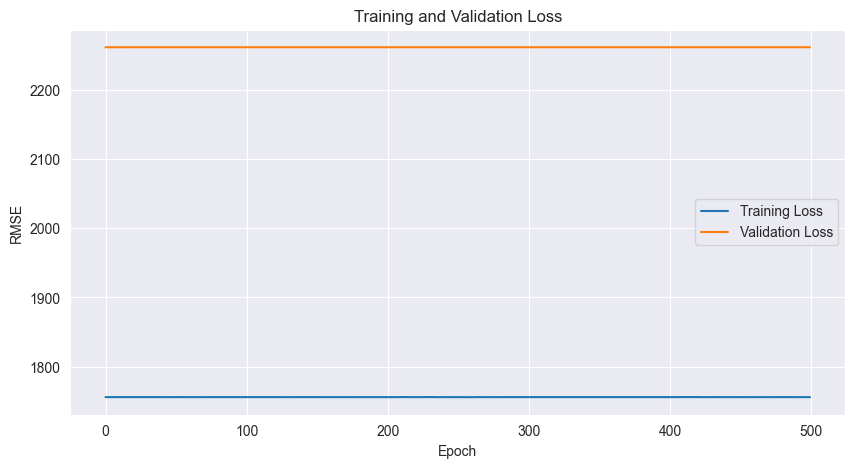

Final validation RMSE: 2261.7666
  Fold 5/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1867.6770, Val RMSE: 2493.2805



  3%|▎         | 15/500 [00:00<00:03, 141.58it/s]

Epoch 10: Train RMSE: 1867.6594, Val RMSE: 2493.2952
Epoch 20: Train RMSE: 1867.7388, Val RMSE: 2493.2908



  6%|▌         | 30/500 [00:00<00:03, 139.01it/s]

Epoch 30: Train RMSE: 1867.6681, Val RMSE: 2493.2954



 12%|█▏        | 62/500 [00:00<00:02, 152.24it/s]

Epoch 40: Train RMSE: 1867.6714, Val RMSE: 2493.2974
Epoch 50: Train RMSE: 1867.5677, Val RMSE: 2493.2974
Epoch 60: Train RMSE: 1867.7185, Val RMSE: 2493.2988
Epoch 70: Train RMSE: 1867.7157, Val RMSE: 2493.2986



 19%|█▉        | 94/500 [00:00<00:02, 149.01it/s]

Epoch 80: Train RMSE: 1867.6754, Val RMSE: 2493.2988
Epoch 90: Train RMSE: 1867.6392, Val RMSE: 2493.2988



 22%|██▏       | 109/500 [00:00<00:02, 148.67it/s]

Epoch 100: Train RMSE: 1867.6488, Val RMSE: 2493.2991



 25%|██▌       | 127/500 [00:00<00:02, 156.65it/s]

Epoch 110: Train RMSE: 1867.5837, Val RMSE: 2493.2991
Epoch 120: Train RMSE: 1867.6364, Val RMSE: 2493.2991
Epoch 130: Train RMSE: 1867.7064, Val RMSE: 2493.2988



 29%|██▉       | 145/500 [00:00<00:02, 161.95it/s]

Epoch 140: Train RMSE: 1867.7335, Val RMSE: 2493.2988



 32%|███▏      | 162/500 [00:01<00:02, 161.68it/s]

Epoch 150: Train RMSE: 1867.6666, Val RMSE: 2493.2988
Epoch 160: Train RMSE: 1867.7427, Val RMSE: 2493.2988
Epoch 170: Train RMSE: 1867.5850, Val RMSE: 2493.2988



 36%|███▌      | 179/500 [00:01<00:01, 161.75it/s]

Epoch 180: Train RMSE: 1867.7172, Val RMSE: 2493.2988



 39%|███▉      | 196/500 [00:01<00:01, 155.14it/s]

Epoch 190: Train RMSE: 1867.6478, Val RMSE: 2493.2988
Epoch 200: Train RMSE: 1867.6909, Val RMSE: 2493.2988
Epoch 210: Train RMSE: 1867.5927, Val RMSE: 2493.2988



 43%|████▎     | 213/500 [00:01<00:01, 158.75it/s]

Epoch 220: Train RMSE: 1867.6661, Val RMSE: 2493.2988



 50%|████▉     | 248/500 [00:01<00:01, 164.23it/s]

Epoch 230: Train RMSE: 1867.6836, Val RMSE: 2493.2988
Epoch 240: Train RMSE: 1867.7042, Val RMSE: 2493.2988
Epoch 250: Train RMSE: 1867.7435, Val RMSE: 2493.2988
Epoch 260: Train RMSE: 1867.5999, Val RMSE: 2493.2988



 53%|█████▎    | 267/500 [00:01<00:01, 168.33it/s]

Epoch 270: Train RMSE: 1867.6847, Val RMSE: 2493.2988
Epoch 280: Train RMSE: 1867.5505, Val RMSE: 2493.2988



 64%|██████▍   | 322/500 [00:02<00:01, 154.24it/s]

Epoch 290: Train RMSE: 1867.6075, Val RMSE: 2493.2988
Epoch 300: Train RMSE: 1867.7373, Val RMSE: 2493.2988
Epoch 310: Train RMSE: 1867.7218, Val RMSE: 2493.2988
Epoch 320: Train RMSE: 1867.6521, Val RMSE: 2493.2988



 71%|███████▏  | 357/500 [00:02<00:00, 152.41it/s]

Epoch 330: Train RMSE: 1867.5940, Val RMSE: 2493.2988
Epoch 340: Train RMSE: 1867.6698, Val RMSE: 2493.2988
Epoch 350: Train RMSE: 1867.6516, Val RMSE: 2493.2991



 79%|███████▊  | 393/500 [00:02<00:00, 161.18it/s]

Epoch 360: Train RMSE: 1867.7366, Val RMSE: 2493.2991
Epoch 370: Train RMSE: 1867.5896, Val RMSE: 2493.2991
Epoch 380: Train RMSE: 1867.6389, Val RMSE: 2493.2991
Epoch 390: Train RMSE: 1867.7651, Val RMSE: 2493.2991



 85%|████████▌ | 427/500 [00:02<00:00, 159.58it/s]

Epoch 400: Train RMSE: 1867.6633, Val RMSE: 2493.2991
Epoch 410: Train RMSE: 1867.6166, Val RMSE: 2493.2991
Epoch 420: Train RMSE: 1867.6985, Val RMSE: 2493.2991
Epoch 430: Train RMSE: 1867.6769, Val RMSE: 2493.2991



 92%|█████████▏| 461/500 [00:02<00:00, 156.37it/s]

Epoch 440: Train RMSE: 1867.6279, Val RMSE: 2493.2991
Epoch 450: Train RMSE: 1867.6073, Val RMSE: 2493.2991
Epoch 460: Train RMSE: 1867.6615, Val RMSE: 2493.2991
Epoch 470: Train RMSE: 1867.6909, Val RMSE: 2493.2991



100%|██████████| 500/500 [00:03<00:00, 155.81it/s]

Epoch 480: Train RMSE: 1867.8040, Val RMSE: 2493.2991
Epoch 490: Train RMSE: 1867.8346, Val RMSE: 2493.2991


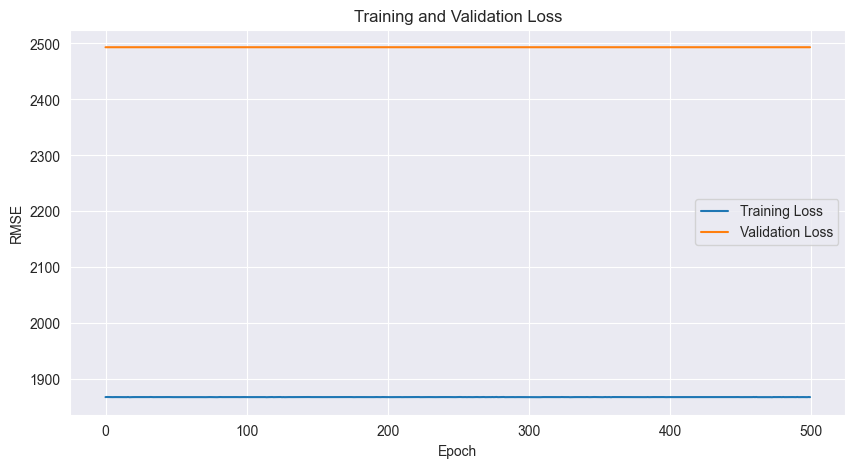

Final validation RMSE: 2493.2756
  Avg RMSE: 2032.4598 ± 417.6962

Testing: hidden_size=64, layers=5, lr=0.001
  Fold 1/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1467.7769, Val RMSE: 1829.3066



  4%|▍         | 20/500 [00:00<00:02, 191.41it/s]

Epoch 10: Train RMSE: 1467.5419, Val RMSE: 1829.5029
Epoch 20: Train RMSE: 1467.7780, Val RMSE: 1829.0282
Epoch 30: Train RMSE: 1467.7999, Val RMSE: 1828.9631



  8%|▊         | 40/500 [00:00<00:02, 189.58it/s]

Epoch 40: Train RMSE: 1467.9009, Val RMSE: 1828.9880
Epoch 50: Train RMSE: 1467.4686, Val RMSE: 1828.9985



 19%|█▉        | 96/500 [00:00<00:01, 250.60it/s]

Epoch 60: Train RMSE: 1467.6365, Val RMSE: 1828.9980
Epoch 70: Train RMSE: 1467.9281, Val RMSE: 1828.9978
Epoch 80: Train RMSE: 1467.8188, Val RMSE: 1828.9976
Epoch 90: Train RMSE: 1467.9236, Val RMSE: 1828.9977
Epoch 100: Train RMSE: 1467.6595, Val RMSE: 1828.9978
Epoch 110: Train RMSE: 1467.6156, Val RMSE: 1828.9977
Epoch 120: Train RMSE: 1467.6300, Val RMSE: 1828.9978



 31%|███▏      | 157/500 [00:00<00:01, 269.30it/s]

Epoch 130: Train RMSE: 1467.6405, Val RMSE: 1828.9978
Epoch 140: Train RMSE: 1467.8204, Val RMSE: 1828.9978
Epoch 150: Train RMSE: 1467.7211, Val RMSE: 1828.9977
Epoch 160: Train RMSE: 1467.9004, Val RMSE: 1828.9977
Epoch 170: Train RMSE: 1467.7408, Val RMSE: 1828.9977
Epoch 180: Train RMSE: 1467.8225, Val RMSE: 1828.9977



 37%|███▋      | 185/500 [00:00<00:01, 259.26it/s]

Epoch 190: Train RMSE: 1467.6820, Val RMSE: 1828.9977
Epoch 200: Train RMSE: 1467.6506, Val RMSE: 1828.9977



 48%|████▊     | 242/500 [00:00<00:00, 267.09it/s]

Epoch 210: Train RMSE: 1467.9768, Val RMSE: 1828.9977
Epoch 220: Train RMSE: 1467.7178, Val RMSE: 1828.9977
Epoch 230: Train RMSE: 1468.0201, Val RMSE: 1828.9977
Epoch 240: Train RMSE: 1467.4866, Val RMSE: 1828.9977
Epoch 250: Train RMSE: 1467.6454, Val RMSE: 1828.9977
Epoch 260: Train RMSE: 1467.6427, Val RMSE: 1828.9977



 61%|██████    | 303/500 [00:01<00:00, 282.58it/s]

Epoch 270: Train RMSE: 1467.7397, Val RMSE: 1828.9977
Epoch 280: Train RMSE: 1467.7435, Val RMSE: 1828.9977
Epoch 290: Train RMSE: 1467.6372, Val RMSE: 1828.9977
Epoch 300: Train RMSE: 1467.7014, Val RMSE: 1828.9977
Epoch 310: Train RMSE: 1467.6696, Val RMSE: 1828.9977
Epoch 320: Train RMSE: 1467.8820, Val RMSE: 1828.9977



 72%|███████▏  | 362/500 [00:01<00:00, 270.41it/s]

Epoch 330: Train RMSE: 1467.4084, Val RMSE: 1828.9977
Epoch 340: Train RMSE: 1467.6270, Val RMSE: 1828.9977
Epoch 350: Train RMSE: 1467.5026, Val RMSE: 1828.9977
Epoch 360: Train RMSE: 1467.7213, Val RMSE: 1828.9977
Epoch 370: Train RMSE: 1467.4424, Val RMSE: 1828.9977
Epoch 380: Train RMSE: 1467.4415, Val RMSE: 1828.9977



 85%|████████▍ | 424/500 [00:01<00:00, 288.20it/s]

Epoch 390: Train RMSE: 1467.8424, Val RMSE: 1828.9977
Epoch 400: Train RMSE: 1467.6647, Val RMSE: 1828.9977
Epoch 410: Train RMSE: 1467.6261, Val RMSE: 1828.9977
Epoch 420: Train RMSE: 1467.6267, Val RMSE: 1828.9977
Epoch 430: Train RMSE: 1467.7092, Val RMSE: 1828.9977
Epoch 440: Train RMSE: 1467.5027, Val RMSE: 1828.9977
Epoch 450: Train RMSE: 1467.7561, Val RMSE: 1828.9977



100%|██████████| 500/500 [00:01<00:00, 269.82it/s]

Epoch 460: Train RMSE: 1467.6191, Val RMSE: 1828.9977
Epoch 470: Train RMSE: 1467.5322, Val RMSE: 1828.9977
Epoch 480: Train RMSE: 1467.4640, Val RMSE: 1828.9977
Epoch 490: Train RMSE: 1467.5952, Val RMSE: 1828.9977


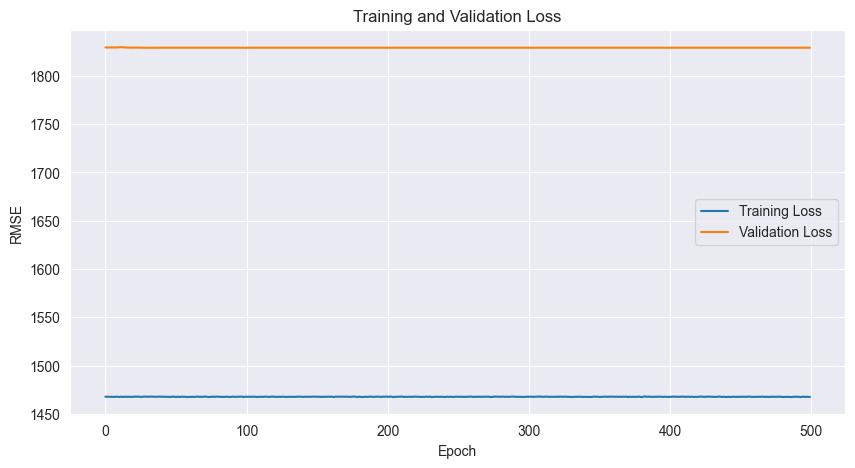

Final validation RMSE: 1828.9480
  Fold 2/5
Input size: 437



  4%|▍         | 21/500 [00:00<00:02, 207.57it/s]

Epoch 0: Train RMSE: 1656.7848, Val RMSE: 1315.6234
Epoch 10: Train RMSE: 1656.6814, Val RMSE: 1315.7073
Epoch 20: Train RMSE: 1656.8013, Val RMSE: 1315.8612
Epoch 30: Train RMSE: 1656.6404, Val RMSE: 1315.9717



  8%|▊         | 42/500 [00:00<00:02, 206.16it/s]

Epoch 40: Train RMSE: 1656.6656, Val RMSE: 1316.0900



 13%|█▎        | 65/500 [00:00<00:02, 215.76it/s]

Epoch 50: Train RMSE: 1656.5852, Val RMSE: 1316.1521
Epoch 60: Train RMSE: 1656.5647, Val RMSE: 1316.1699
Epoch 70: Train RMSE: 1656.3988, Val RMSE: 1316.1749
Epoch 80: Train RMSE: 1656.7218, Val RMSE: 1316.1788



 18%|█▊        | 89/500 [00:00<00:01, 221.65it/s]

Epoch 90: Train RMSE: 1656.7655, Val RMSE: 1316.1807



 22%|██▏       | 112/500 [00:00<00:01, 219.62it/s]

Epoch 100: Train RMSE: 1656.6250, Val RMSE: 1316.1810
Epoch 110: Train RMSE: 1656.6646, Val RMSE: 1316.1814
Epoch 120: Train RMSE: 1656.7555, Val RMSE: 1316.1814
Epoch 130: Train RMSE: 1656.6694, Val RMSE: 1316.1814



 27%|██▋       | 134/500 [00:00<00:01, 211.05it/s]

Epoch 140: Train RMSE: 1656.6001, Val RMSE: 1316.1815



 36%|███▌      | 180/500 [00:00<00:01, 219.80it/s]

Epoch 150: Train RMSE: 1656.4924, Val RMSE: 1316.1816
Epoch 160: Train RMSE: 1656.5398, Val RMSE: 1316.1816
Epoch 170: Train RMSE: 1656.5033, Val RMSE: 1316.1815
Epoch 180: Train RMSE: 1656.6289, Val RMSE: 1316.1815
Epoch 190: Train RMSE: 1656.8508, Val RMSE: 1316.1815



 45%|████▌     | 225/500 [00:01<00:01, 203.91it/s]

Epoch 200: Train RMSE: 1656.7908, Val RMSE: 1316.1815
Epoch 210: Train RMSE: 1656.4484, Val RMSE: 1316.1815
Epoch 220: Train RMSE: 1656.4542, Val RMSE: 1316.1816
Epoch 230: Train RMSE: 1656.7737, Val RMSE: 1316.1816



 53%|█████▎    | 266/500 [00:01<00:01, 192.93it/s]

Epoch 240: Train RMSE: 1656.5149, Val RMSE: 1316.1815
Epoch 250: Train RMSE: 1656.7975, Val RMSE: 1316.1815
Epoch 260: Train RMSE: 1656.6947, Val RMSE: 1316.1815
Epoch 270: Train RMSE: 1656.7021, Val RMSE: 1316.1815



 61%|██████▏   | 307/500 [00:01<00:00, 197.02it/s]

Epoch 280: Train RMSE: 1656.6210, Val RMSE: 1316.1815
Epoch 290: Train RMSE: 1656.6400, Val RMSE: 1316.1815
Epoch 300: Train RMSE: 1656.5225, Val RMSE: 1316.1816
Epoch 310: Train RMSE: 1656.7301, Val RMSE: 1316.1816
Epoch 320: Train RMSE: 1656.5908, Val RMSE: 1316.1816



 69%|██████▉   | 347/500 [00:01<00:00, 195.81it/s]

Epoch 330: Train RMSE: 1656.5640, Val RMSE: 1316.1816
Epoch 340: Train RMSE: 1656.6816, Val RMSE: 1316.1816



 74%|███████▍  | 369/500 [00:01<00:00, 201.80it/s]

Epoch 350: Train RMSE: 1656.5309, Val RMSE: 1316.1816
Epoch 360: Train RMSE: 1656.5354, Val RMSE: 1316.1816
Epoch 370: Train RMSE: 1656.7758, Val RMSE: 1316.1816



 78%|███████▊  | 392/500 [00:01<00:00, 207.96it/s]

Epoch 380: Train RMSE: 1656.6350, Val RMSE: 1316.1816
Epoch 390: Train RMSE: 1656.7045, Val RMSE: 1316.1818



 83%|████████▎ | 416/500 [00:02<00:00, 215.46it/s]

Epoch 400: Train RMSE: 1656.6675, Val RMSE: 1316.1818
Epoch 410: Train RMSE: 1656.6442, Val RMSE: 1316.1818
Epoch 420: Train RMSE: 1656.5474, Val RMSE: 1316.1818



 88%|████████▊ | 438/500 [00:02<00:00, 215.50it/s]

Epoch 430: Train RMSE: 1656.6746, Val RMSE: 1316.1818
Epoch 440: Train RMSE: 1656.6703, Val RMSE: 1316.1818



 92%|█████████▏| 460/500 [00:02<00:00, 214.30it/s]

Epoch 450: Train RMSE: 1656.5422, Val RMSE: 1316.1818
Epoch 460: Train RMSE: 1656.6265, Val RMSE: 1316.1818
Epoch 470: Train RMSE: 1656.4626, Val RMSE: 1316.1818



 96%|█████████▋| 482/500 [00:02<00:00, 207.15it/s]

Epoch 480: Train RMSE: 1656.7819, Val RMSE: 1316.1818
Epoch 490: Train RMSE: 1656.5148, Val RMSE: 1316.1818


100%|██████████| 500/500 [00:02<00:00, 207.60it/s]


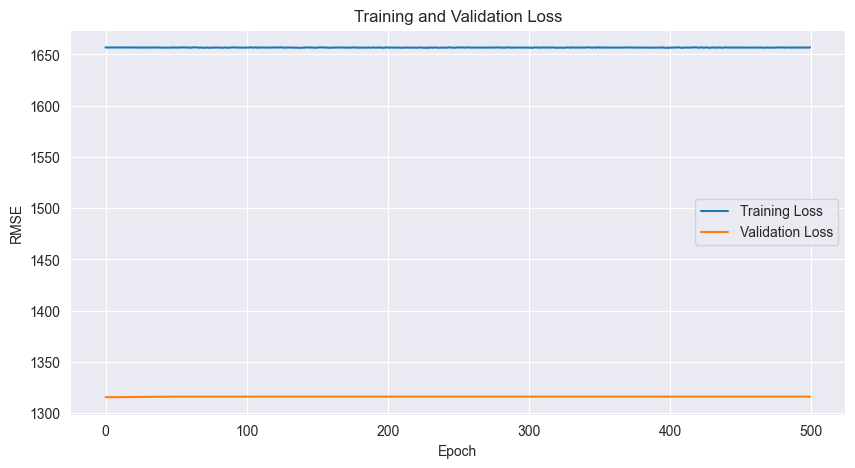

Final validation RMSE: 1315.6234
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1552.1095, Val RMSE: 2262.6409



  3%|▎         | 14/500 [00:00<00:03, 131.47it/s]

Epoch 10: Train RMSE: 1552.1080, Val RMSE: 2262.0229
Epoch 20: Train RMSE: 1551.8990, Val RMSE: 2262.0747



  6%|▌         | 29/500 [00:00<00:03, 135.10it/s]

Epoch 30: Train RMSE: 1552.0430, Val RMSE: 2261.8318



  9%|▊         | 43/500 [00:00<00:03, 128.89it/s]

Epoch 40: Train RMSE: 1551.8711, Val RMSE: 2261.7134
Epoch 50: Train RMSE: 1551.7190, Val RMSE: 2261.7324



 12%|█▏        | 58/500 [00:00<00:03, 132.98it/s]

Epoch 60: Train RMSE: 1551.7141, Val RMSE: 2261.5793



 14%|█▍        | 72/500 [00:00<00:03, 122.71it/s]

Epoch 70: Train RMSE: 1551.5372, Val RMSE: 2261.5754
Epoch 80: Train RMSE: 1551.8234, Val RMSE: 2261.5732



 17%|█▋        | 85/500 [00:00<00:03, 121.18it/s]

Epoch 90: Train RMSE: 1551.9803, Val RMSE: 2261.5720



 24%|██▍       | 119/500 [00:00<00:02, 144.23it/s]

Epoch 100: Train RMSE: 1551.7109, Val RMSE: 2261.5715
Epoch 110: Train RMSE: 1551.9669, Val RMSE: 2261.5713
Epoch 120: Train RMSE: 1551.7446, Val RMSE: 2261.5713
Epoch 130: Train RMSE: 1551.7448, Val RMSE: 2261.5713



 31%|███       | 155/500 [00:01<00:02, 159.73it/s]

Epoch 140: Train RMSE: 1551.5505, Val RMSE: 2261.5710
Epoch 150: Train RMSE: 1551.8196, Val RMSE: 2261.5710
Epoch 160: Train RMSE: 1552.1370, Val RMSE: 2261.5710



 35%|███▍      | 173/500 [00:01<00:01, 165.67it/s]

Epoch 170: Train RMSE: 1551.8555, Val RMSE: 2261.5710



 38%|███▊      | 191/500 [00:01<00:01, 169.75it/s]

Epoch 180: Train RMSE: 1551.7288, Val RMSE: 2261.5710
Epoch 190: Train RMSE: 1551.9758, Val RMSE: 2261.5710
Epoch 200: Train RMSE: 1551.6877, Val RMSE: 2261.5710



 42%|████▏     | 210/500 [00:01<00:01, 172.61it/s]

Epoch 210: Train RMSE: 1551.7581, Val RMSE: 2261.5710



 46%|████▌     | 228/500 [00:01<00:01, 169.56it/s]

Epoch 220: Train RMSE: 1551.5703, Val RMSE: 2261.5710
Epoch 230: Train RMSE: 1551.9019, Val RMSE: 2261.5710
Epoch 240: Train RMSE: 1552.0393, Val RMSE: 2261.5710



 49%|████▉     | 247/500 [00:01<00:01, 172.69it/s]

Epoch 250: Train RMSE: 1551.7731, Val RMSE: 2261.5710



 57%|█████▋    | 285/500 [00:01<00:01, 178.42it/s]

Epoch 260: Train RMSE: 1551.9310, Val RMSE: 2261.5710
Epoch 270: Train RMSE: 1551.6323, Val RMSE: 2261.5710
Epoch 280: Train RMSE: 1551.7260, Val RMSE: 2261.5710
Epoch 290: Train RMSE: 1551.6888, Val RMSE: 2261.5710



 65%|██████▌   | 325/500 [00:02<00:00, 182.34it/s]

Epoch 300: Train RMSE: 1551.6655, Val RMSE: 2261.5710
Epoch 310: Train RMSE: 1551.3651, Val RMSE: 2261.5710
Epoch 320: Train RMSE: 1551.8368, Val RMSE: 2261.5710
Epoch 330: Train RMSE: 1551.9746, Val RMSE: 2261.5710



 73%|███████▎  | 363/500 [00:02<00:00, 180.66it/s]

Epoch 340: Train RMSE: 1551.7908, Val RMSE: 2261.5710
Epoch 350: Train RMSE: 1551.6722, Val RMSE: 2261.5710
Epoch 360: Train RMSE: 1551.6890, Val RMSE: 2261.5710
Epoch 370: Train RMSE: 1551.8776, Val RMSE: 2261.5710



 81%|████████  | 406/500 [00:02<00:00, 193.04it/s]

Epoch 380: Train RMSE: 1551.6135, Val RMSE: 2261.5710
Epoch 390: Train RMSE: 1552.1040, Val RMSE: 2261.5710
Epoch 400: Train RMSE: 1551.8105, Val RMSE: 2261.5710
Epoch 410: Train RMSE: 1552.1207, Val RMSE: 2261.5710
Epoch 420: Train RMSE: 1551.9677, Val RMSE: 2261.5710



 89%|████████▉ | 447/500 [00:02<00:00, 198.15it/s]

Epoch 430: Train RMSE: 1551.8656, Val RMSE: 2261.5710
Epoch 440: Train RMSE: 1552.0952, Val RMSE: 2261.5710
Epoch 450: Train RMSE: 1552.1166, Val RMSE: 2261.5710
Epoch 460: Train RMSE: 1552.0488, Val RMSE: 2261.5710



 93%|█████████▎| 467/500 [00:02<00:00, 196.62it/s]

Epoch 470: Train RMSE: 1551.5562, Val RMSE: 2261.5710


100%|██████████| 500/500 [00:02<00:00, 170.84it/s]



Epoch 480: Train RMSE: 1551.8154, Val RMSE: 2261.5710
Epoch 490: Train RMSE: 1551.6719, Val RMSE: 2261.5710


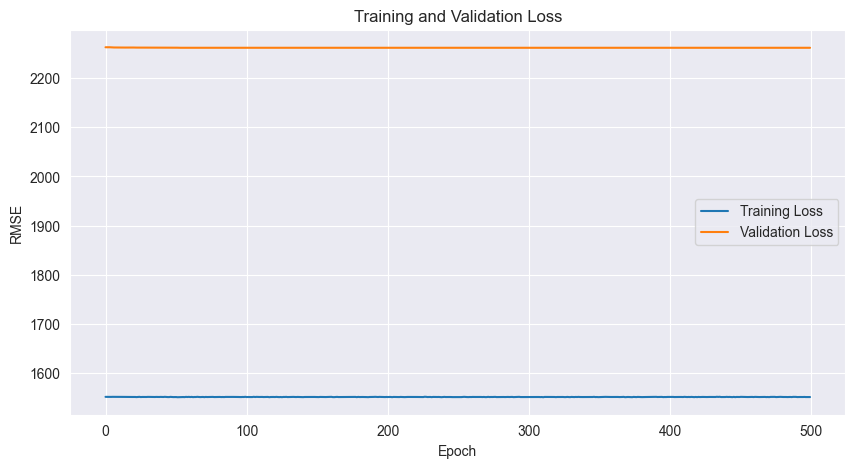

Final validation RMSE: 2261.5710
  Fold 4/5
Input size: 437



  3%|▎         | 16/500 [00:00<00:03, 159.19it/s]

Epoch 0: Train RMSE: 1755.8341, Val RMSE: 2261.8267
Epoch 10: Train RMSE: 1756.0332, Val RMSE: 2261.7959
Epoch 20: Train RMSE: 1755.6594, Val RMSE: 2261.8567



  6%|▋         | 32/500 [00:00<00:02, 157.34it/s]

Epoch 30: Train RMSE: 1755.8085, Val RMSE: 2261.8655



 10%|█         | 51/500 [00:00<00:02, 170.15it/s]

Epoch 40: Train RMSE: 1755.7266, Val RMSE: 2261.8677
Epoch 50: Train RMSE: 1755.7578, Val RMSE: 2261.8682
Epoch 60: Train RMSE: 1755.7620, Val RMSE: 2261.8689



 14%|█▍        | 70/500 [00:00<00:02, 173.77it/s]

Epoch 70: Train RMSE: 1755.6447, Val RMSE: 2261.9929



 18%|█▊        | 88/500 [00:00<00:02, 171.15it/s]

Epoch 80: Train RMSE: 1755.7312, Val RMSE: 2261.9846
Epoch 90: Train RMSE: 1755.7888, Val RMSE: 2261.9836
Epoch 100: Train RMSE: 1755.7045, Val RMSE: 2261.9834



 21%|██        | 106/500 [00:00<00:02, 166.56it/s]

Epoch 110: Train RMSE: 1755.8724, Val RMSE: 2261.9832



 28%|██▊       | 142/500 [00:00<00:02, 171.49it/s]

Epoch 120: Train RMSE: 1755.7241, Val RMSE: 2261.9829
Epoch 130: Train RMSE: 1755.6704, Val RMSE: 2261.9829
Epoch 140: Train RMSE: 1755.8035, Val RMSE: 2261.9827
Epoch 150: Train RMSE: 1755.7948, Val RMSE: 2261.9829



 36%|███▌      | 178/500 [00:01<00:01, 174.52it/s]

Epoch 160: Train RMSE: 1755.6899, Val RMSE: 2261.9829
Epoch 170: Train RMSE: 1755.8618, Val RMSE: 2261.9829
Epoch 180: Train RMSE: 1755.8022, Val RMSE: 2261.9829
Epoch 190: Train RMSE: 1755.6370, Val RMSE: 2261.9829



 43%|████▎     | 214/500 [00:01<00:01, 158.10it/s]

Epoch 200: Train RMSE: 1755.6799, Val RMSE: 2261.9829
Epoch 210: Train RMSE: 1755.5746, Val RMSE: 2261.9829
Epoch 220: Train RMSE: 1755.8174, Val RMSE: 2261.9829



 50%|████▉     | 248/500 [00:01<00:01, 153.07it/s]

Epoch 230: Train RMSE: 1755.6442, Val RMSE: 2261.9829
Epoch 240: Train RMSE: 1755.7539, Val RMSE: 2261.9829
Epoch 250: Train RMSE: 1755.5784, Val RMSE: 2261.9829
Epoch 260: Train RMSE: 1755.6478, Val RMSE: 2261.9829



 56%|█████▋    | 282/500 [00:01<00:01, 157.36it/s]

Epoch 270: Train RMSE: 1755.9077, Val RMSE: 2261.9829
Epoch 280: Train RMSE: 1755.7271, Val RMSE: 2261.9829



 60%|█████▉    | 298/500 [00:01<00:01, 157.22it/s]

Epoch 290: Train RMSE: 1755.6093, Val RMSE: 2261.9829
Epoch 300: Train RMSE: 1755.7219, Val RMSE: 2261.9829



 63%|██████▎   | 315/500 [00:01<00:01, 159.13it/s]

Epoch 310: Train RMSE: 1755.7965, Val RMSE: 2261.9829
Epoch 320: Train RMSE: 1755.7528, Val RMSE: 2261.9829



 66%|██████▋   | 332/500 [00:02<00:01, 160.58it/s]

Epoch 330: Train RMSE: 1755.8405, Val RMSE: 2261.9829
Epoch 340: Train RMSE: 1755.8018, Val RMSE: 2261.9827



 70%|███████   | 350/500 [00:02<00:00, 164.45it/s]

Epoch 350: Train RMSE: 1755.8307, Val RMSE: 2261.9827
Epoch 360: Train RMSE: 1755.7867, Val RMSE: 2261.9827



 74%|███████▎  | 368/500 [00:02<00:00, 165.97it/s]

Epoch 370: Train RMSE: 1755.7039, Val RMSE: 2261.9827
Epoch 380: Train RMSE: 1755.5953, Val RMSE: 2261.9827



 80%|████████  | 402/500 [00:02<00:00, 163.84it/s]

Epoch 390: Train RMSE: 1755.7314, Val RMSE: 2261.9827
Epoch 400: Train RMSE: 1755.8137, Val RMSE: 2261.9827



 84%|████████▍ | 421/500 [00:02<00:00, 169.18it/s]

Epoch 410: Train RMSE: 1755.6993, Val RMSE: 2261.9827
Epoch 420: Train RMSE: 1755.7522, Val RMSE: 2261.9827



 88%|████████▊ | 440/500 [00:02<00:00, 173.37it/s]

Epoch 430: Train RMSE: 1755.6910, Val RMSE: 2261.9827
Epoch 440: Train RMSE: 1755.7434, Val RMSE: 2261.9827



 92%|█████████▏| 459/500 [00:02<00:00, 176.36it/s]

Epoch 450: Train RMSE: 1755.8383, Val RMSE: 2261.9827
Epoch 460: Train RMSE: 1755.7363, Val RMSE: 2261.9829



 95%|█████████▌| 477/500 [00:02<00:00, 173.70it/s]

Epoch 470: Train RMSE: 1755.6533, Val RMSE: 2261.9829
Epoch 480: Train RMSE: 1755.6130, Val RMSE: 2261.9827



100%|██████████| 500/500 [00:03<00:00, 165.89it/s]

Epoch 490: Train RMSE: 1755.7473, Val RMSE: 2261.9827


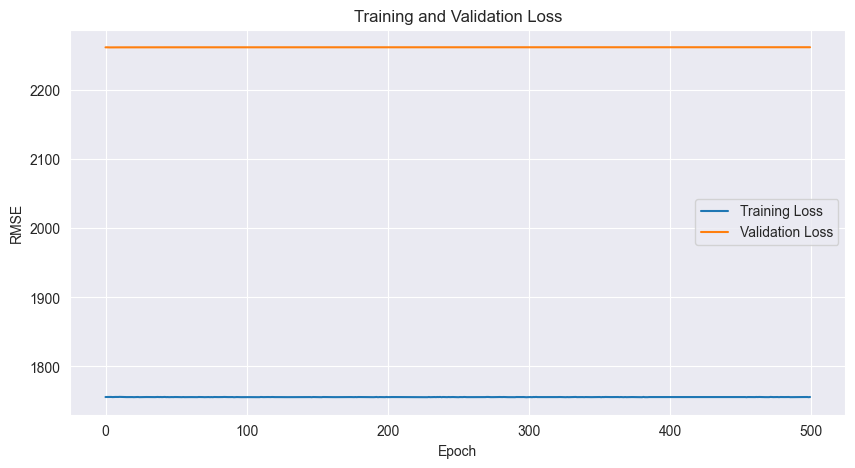

Final validation RMSE: 2261.7170
  Fold 5/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1867.7091, Val RMSE: 2493.2527



  2%|▏         | 8/500 [00:00<00:10, 47.03it/s]

Epoch 10: Train RMSE: 1867.4990, Val RMSE: 2493.2781



  8%|▊         | 39/500 [00:00<00:03, 116.64it/s]

Epoch 20: Train RMSE: 1867.5065, Val RMSE: 2493.2834
Epoch 30: Train RMSE: 1867.3895, Val RMSE: 2493.2930
Epoch 40: Train RMSE: 1867.3165, Val RMSE: 2493.2974
Epoch 50: Train RMSE: 1867.6078, Val RMSE: 2493.3022



 14%|█▍        | 70/500 [00:00<00:03, 137.85it/s]

Epoch 60: Train RMSE: 1867.3463, Val RMSE: 2493.3052
Epoch 70: Train RMSE: 1867.4877, Val RMSE: 2493.3066
Epoch 80: Train RMSE: 1867.3917, Val RMSE: 2493.3074



 17%|█▋        | 85/500 [00:00<00:02, 140.89it/s]

Epoch 90: Train RMSE: 1867.5995, Val RMSE: 2493.3079



 23%|██▎       | 115/500 [00:00<00:02, 142.32it/s]

Epoch 100: Train RMSE: 1867.4257, Val RMSE: 2493.3081
Epoch 110: Train RMSE: 1867.4996, Val RMSE: 2493.3081



 26%|██▌       | 131/500 [00:00<00:02, 146.58it/s]

Epoch 120: Train RMSE: 1867.3601, Val RMSE: 2493.3081
Epoch 130: Train RMSE: 1867.6240, Val RMSE: 2493.3081



 29%|██▉       | 147/500 [00:01<00:02, 150.18it/s]

Epoch 140: Train RMSE: 1867.4734, Val RMSE: 2493.3081
Epoch 150: Train RMSE: 1867.4482, Val RMSE: 2493.3081



 33%|███▎      | 163/500 [00:01<00:02, 150.67it/s]

Epoch 160: Train RMSE: 1867.4625, Val RMSE: 2493.3081
Epoch 170: Train RMSE: 1867.5620, Val RMSE: 2493.3081



 36%|███▌      | 179/500 [00:01<00:02, 151.93it/s]

Epoch 180: Train RMSE: 1867.4790, Val RMSE: 2493.3081
Epoch 190: Train RMSE: 1867.4916, Val RMSE: 2493.3081



 39%|███▉      | 196/500 [00:01<00:01, 155.50it/s]

Epoch 200: Train RMSE: 1867.5308, Val RMSE: 2493.3081
Epoch 210: Train RMSE: 1867.5007, Val RMSE: 2493.3081



 46%|████▌     | 229/500 [00:01<00:01, 155.53it/s]

Epoch 220: Train RMSE: 1867.6207, Val RMSE: 2493.3081
Epoch 230: Train RMSE: 1867.4401, Val RMSE: 2493.3081



 49%|████▉     | 245/500 [00:01<00:01, 155.65it/s]

Epoch 240: Train RMSE: 1867.5367, Val RMSE: 2493.3081
Epoch 250: Train RMSE: 1867.4727, Val RMSE: 2493.3081



 52%|█████▏    | 262/500 [00:01<00:01, 157.67it/s]

Epoch 260: Train RMSE: 1867.5183, Val RMSE: 2493.3081
Epoch 270: Train RMSE: 1867.5046, Val RMSE: 2493.3081



 56%|█████▌    | 279/500 [00:01<00:01, 158.65it/s]

Epoch 280: Train RMSE: 1867.4163, Val RMSE: 2493.3081
Epoch 290: Train RMSE: 1867.3695, Val RMSE: 2493.3081



 62%|██████▏   | 311/500 [00:02<00:01, 155.00it/s]

Epoch 300: Train RMSE: 1867.4913, Val RMSE: 2493.3081
Epoch 310: Train RMSE: 1867.5043, Val RMSE: 2493.3081



 66%|██████▌   | 329/500 [00:02<00:01, 160.47it/s]

Epoch 320: Train RMSE: 1867.3357, Val RMSE: 2493.3081
Epoch 330: Train RMSE: 1867.3962, Val RMSE: 2493.3081



 69%|██████▉   | 346/500 [00:02<00:00, 160.78it/s]

Epoch 340: Train RMSE: 1867.2822, Val RMSE: 2493.3081
Epoch 350: Train RMSE: 1867.4805, Val RMSE: 2493.3081



 73%|███████▎  | 363/500 [00:02<00:00, 163.24it/s]

Epoch 360: Train RMSE: 1867.5795, Val RMSE: 2493.3081
Epoch 370: Train RMSE: 1867.5173, Val RMSE: 2493.3081



 76%|███████▌  | 380/500 [00:02<00:00, 148.96it/s]

Epoch 380: Train RMSE: 1867.4575, Val RMSE: 2493.3081



 79%|███████▉  | 396/500 [00:02<00:00, 139.34it/s]

Epoch 390: Train RMSE: 1867.4109, Val RMSE: 2493.3081
Epoch 400: Train RMSE: 1867.6084, Val RMSE: 2493.3081



 82%|████████▏ | 411/500 [00:02<00:00, 136.26it/s]

Epoch 410: Train RMSE: 1867.5580, Val RMSE: 2493.3081



 85%|████████▌ | 427/500 [00:02<00:00, 141.28it/s]

Epoch 420: Train RMSE: 1867.5931, Val RMSE: 2493.3083
Epoch 430: Train RMSE: 1867.5425, Val RMSE: 2493.3083
Epoch 440: Train RMSE: 1867.5751, Val RMSE: 2493.3083



 89%|████████▊ | 443/500 [00:03<00:00, 145.17it/s]

Epoch 450: Train RMSE: 1867.4355, Val RMSE: 2493.3083



 95%|█████████▍| 473/500 [00:03<00:00, 145.27it/s]

Epoch 460: Train RMSE: 1867.5057, Val RMSE: 2493.3083
Epoch 470: Train RMSE: 1867.5416, Val RMSE: 2493.3083



 98%|█████████▊| 489/500 [00:03<00:00, 149.17it/s]

Epoch 480: Train RMSE: 1867.4580, Val RMSE: 2493.3083
Epoch 490: Train RMSE: 1867.5028, Val RMSE: 2493.3083


100%|██████████| 500/500 [00:03<00:00, 145.52it/s]


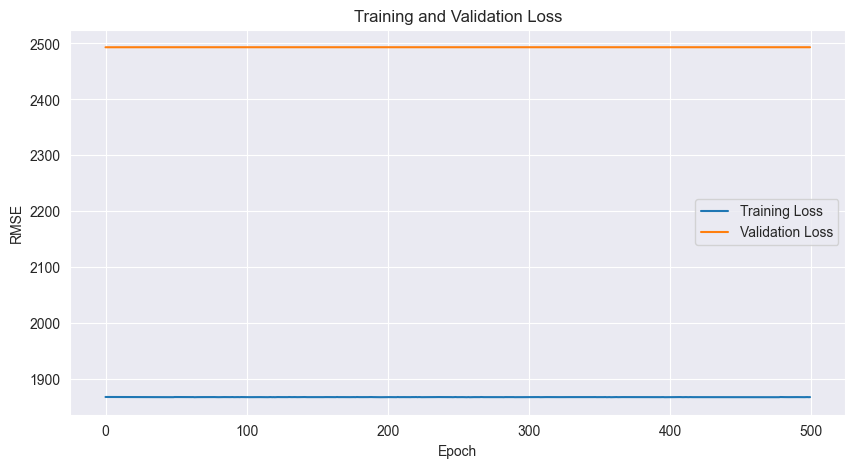

Final validation RMSE: 2493.2148
  Avg RMSE: 2032.2149 ± 417.7600

Testing: hidden_size=64, layers=5, lr=0.01
  Fold 1/5
Input size: 437



  5%|▍         | 23/500 [00:00<00:02, 224.05it/s]

Epoch 0: Train RMSE: 1467.5847, Val RMSE: 1829.0587
Epoch 10: Train RMSE: 1467.3003, Val RMSE: 1829.0513
Epoch 20: Train RMSE: 1467.3577, Val RMSE: 1829.0667
Epoch 30: Train RMSE: 1467.9485, Val RMSE: 1829.0784
Epoch 40: Train RMSE: 1467.0831, Val RMSE: 1829.0845



 15%|█▌        | 75/500 [00:00<00:01, 235.23it/s]

Epoch 50: Train RMSE: 1466.4949, Val RMSE: 1829.0872
Epoch 60: Train RMSE: 1466.6973, Val RMSE: 1829.0892
Epoch 70: Train RMSE: 1467.4752, Val RMSE: 1829.0907
Epoch 80: Train RMSE: 1467.4153, Val RMSE: 1829.0916
Epoch 90: Train RMSE: 1467.2728, Val RMSE: 1829.0918
Epoch 100: Train RMSE: 1466.3123, Val RMSE: 1829.0920



 33%|███▎      | 165/500 [00:00<00:01, 280.33it/s]

Epoch 110: Train RMSE: 1466.6492, Val RMSE: 1829.0922
Epoch 120: Train RMSE: 1467.2701, Val RMSE: 1829.0922
Epoch 130: Train RMSE: 1467.2382, Val RMSE: 1829.0922
Epoch 140: Train RMSE: 1466.8359, Val RMSE: 1829.0922
Epoch 150: Train RMSE: 1467.1987, Val RMSE: 1829.0922
Epoch 160: Train RMSE: 1467.4611, Val RMSE: 1829.0922
Epoch 170: Train RMSE: 1467.6069, Val RMSE: 1829.0922



 45%|████▍     | 223/500 [00:00<00:01, 260.34it/s]

Epoch 180: Train RMSE: 1467.4143, Val RMSE: 1829.0923
Epoch 190: Train RMSE: 1467.6520, Val RMSE: 1829.0923
Epoch 200: Train RMSE: 1467.3043, Val RMSE: 1829.0923
Epoch 210: Train RMSE: 1467.4303, Val RMSE: 1829.0922
Epoch 220: Train RMSE: 1466.8046, Val RMSE: 1829.0922



 56%|█████▌    | 280/500 [00:01<00:00, 269.89it/s]

Epoch 230: Train RMSE: 1466.6846, Val RMSE: 1829.0922
Epoch 240: Train RMSE: 1466.5081, Val RMSE: 1829.0922
Epoch 250: Train RMSE: 1466.9053, Val RMSE: 1829.0922
Epoch 260: Train RMSE: 1467.7660, Val RMSE: 1829.0922
Epoch 270: Train RMSE: 1467.6538, Val RMSE: 1829.0922
Epoch 280: Train RMSE: 1467.2378, Val RMSE: 1829.0922



 67%|██████▋   | 336/500 [00:01<00:00, 266.75it/s]

Epoch 290: Train RMSE: 1467.3479, Val RMSE: 1829.0922
Epoch 300: Train RMSE: 1467.7523, Val RMSE: 1829.0922
Epoch 310: Train RMSE: 1467.0205, Val RMSE: 1829.0922
Epoch 320: Train RMSE: 1467.1892, Val RMSE: 1829.0922
Epoch 330: Train RMSE: 1467.3866, Val RMSE: 1829.0922
Epoch 340: Train RMSE: 1467.3451, Val RMSE: 1829.0922



 78%|███████▊  | 390/500 [00:01<00:00, 253.56it/s]

Epoch 350: Train RMSE: 1467.1558, Val RMSE: 1829.0922
Epoch 360: Train RMSE: 1467.1665, Val RMSE: 1829.0922
Epoch 370: Train RMSE: 1467.5975, Val RMSE: 1829.0922
Epoch 380: Train RMSE: 1466.7448, Val RMSE: 1829.0922
Epoch 390: Train RMSE: 1467.4269, Val RMSE: 1829.0922



 90%|████████▉ | 448/500 [00:01<00:00, 270.09it/s]

Epoch 400: Train RMSE: 1467.5619, Val RMSE: 1829.0922
Epoch 410: Train RMSE: 1466.6200, Val RMSE: 1829.0922
Epoch 420: Train RMSE: 1467.5602, Val RMSE: 1829.0922
Epoch 430: Train RMSE: 1467.0107, Val RMSE: 1829.0922
Epoch 440: Train RMSE: 1467.5441, Val RMSE: 1829.0922
Epoch 450: Train RMSE: 1467.4641, Val RMSE: 1829.0922



100%|██████████| 500/500 [00:01<00:00, 261.84it/s]

Epoch 460: Train RMSE: 1466.5222, Val RMSE: 1829.0922
Epoch 470: Train RMSE: 1467.4617, Val RMSE: 1829.0922
Epoch 480: Train RMSE: 1466.8223, Val RMSE: 1829.0922
Epoch 490: Train RMSE: 1466.9124, Val RMSE: 1829.0922


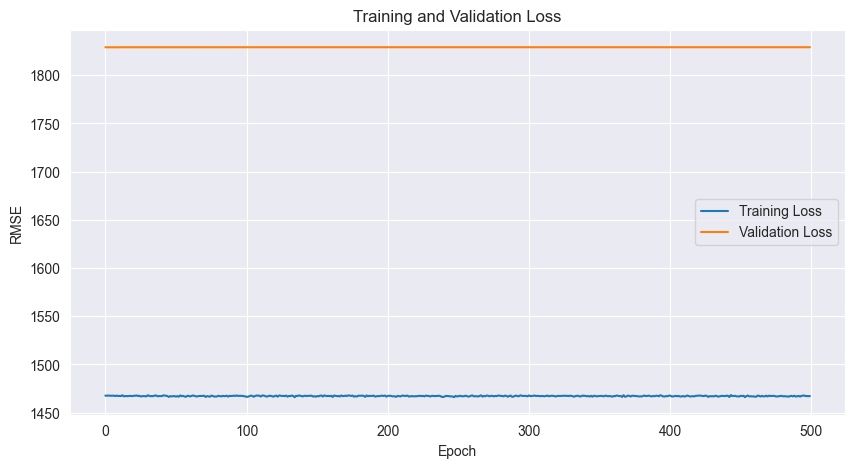

Final validation RMSE: 1829.0107
  Fold 2/5
Input size: 437



  4%|▎         | 18/500 [00:00<00:02, 178.37it/s]

Epoch 0: Train RMSE: 1656.7357, Val RMSE: 1315.9314
Epoch 10: Train RMSE: 1656.8285, Val RMSE: 1315.1270
Epoch 20: Train RMSE: 1656.8822, Val RMSE: 1315.2441
Epoch 30: Train RMSE: 1656.7334, Val RMSE: 1315.2932



 12%|█▏        | 59/500 [00:00<00:02, 188.36it/s]


Epoch 40: Train RMSE: 1656.5378, Val RMSE: 1315.3147
Epoch 50: Train RMSE: 1656.6666, Val RMSE: 1315.3201
Epoch 60: Train RMSE: 1656.9197, Val RMSE: 1315.3246
Epoch 70: Train RMSE: 1656.7526, Val RMSE: 1315.3292
Epoch 80: Train RMSE: 1656.6935, Val RMSE: 1315.3322


 26%|██▌       | 131/500 [00:00<00:01, 219.50it/s]

Epoch 90: Train RMSE: 1656.6960, Val RMSE: 1315.3334
Epoch 100: Train RMSE: 1656.7863, Val RMSE: 1315.3337
Epoch 110: Train RMSE: 1656.7449, Val RMSE: 1315.3341
Epoch 120: Train RMSE: 1656.8058, Val RMSE: 1315.3342
Epoch 130: Train RMSE: 1656.6973, Val RMSE: 1315.3342
Epoch 140: Train RMSE: 1656.6298, Val RMSE: 1315.3342



 35%|███▌      | 176/500 [00:00<00:01, 209.50it/s]

Epoch 150: Train RMSE: 1656.6941, Val RMSE: 1315.3342
Epoch 160: Train RMSE: 1657.0255, Val RMSE: 1315.3344
Epoch 170: Train RMSE: 1656.8021, Val RMSE: 1315.3344
Epoch 180: Train RMSE: 1656.6335, Val RMSE: 1315.3344
Epoch 190: Train RMSE: 1656.5406, Val RMSE: 1315.3344



 49%|████▉     | 244/500 [00:01<00:01, 214.60it/s]

Epoch 200: Train RMSE: 1656.7926, Val RMSE: 1315.3344
Epoch 210: Train RMSE: 1656.7070, Val RMSE: 1315.3344
Epoch 220: Train RMSE: 1656.6752, Val RMSE: 1315.3344
Epoch 230: Train RMSE: 1656.7285, Val RMSE: 1315.3344
Epoch 240: Train RMSE: 1656.9963, Val RMSE: 1315.3344



 58%|█████▊    | 292/500 [00:01<00:00, 225.99it/s]

Epoch 250: Train RMSE: 1656.6111, Val RMSE: 1315.3344
Epoch 260: Train RMSE: 1656.6147, Val RMSE: 1315.3344
Epoch 270: Train RMSE: 1656.8790, Val RMSE: 1315.3344
Epoch 280: Train RMSE: 1656.8115, Val RMSE: 1315.3344
Epoch 290: Train RMSE: 1656.6947, Val RMSE: 1315.3344



 69%|██████▉   | 345/500 [00:01<00:00, 243.47it/s]

Epoch 300: Train RMSE: 1656.8557, Val RMSE: 1315.3344
Epoch 310: Train RMSE: 1656.7924, Val RMSE: 1315.3344
Epoch 320: Train RMSE: 1656.6698, Val RMSE: 1315.3344
Epoch 330: Train RMSE: 1656.7769, Val RMSE: 1315.3344
Epoch 340: Train RMSE: 1656.4944, Val RMSE: 1315.3344
Epoch 350: Train RMSE: 1656.8020, Val RMSE: 1315.3344



 79%|███████▉  | 395/500 [00:01<00:00, 230.63it/s]

Epoch 360: Train RMSE: 1656.8228, Val RMSE: 1315.3344
Epoch 370: Train RMSE: 1656.8181, Val RMSE: 1315.3344
Epoch 380: Train RMSE: 1656.9380, Val RMSE: 1315.3344
Epoch 390: Train RMSE: 1656.8141, Val RMSE: 1315.3344
Epoch 400: Train RMSE: 1656.7397, Val RMSE: 1315.3344



 90%|████████▉ | 449/500 [00:01<00:00, 245.57it/s]

Epoch 410: Train RMSE: 1656.8972, Val RMSE: 1315.3344
Epoch 420: Train RMSE: 1656.6573, Val RMSE: 1315.3344
Epoch 430: Train RMSE: 1656.7036, Val RMSE: 1315.3344
Epoch 440: Train RMSE: 1656.8835, Val RMSE: 1315.3344
Epoch 450: Train RMSE: 1656.8196, Val RMSE: 1315.3344
Epoch 460: Train RMSE: 1656.7290, Val RMSE: 1315.3344



100%|██████████| 500/500 [00:02<00:00, 228.26it/s]


Epoch 470: Train RMSE: 1656.9932, Val RMSE: 1315.3344
Epoch 480: Train RMSE: 1656.7476, Val RMSE: 1315.3344
Epoch 490: Train RMSE: 1656.9061, Val RMSE: 1315.3344


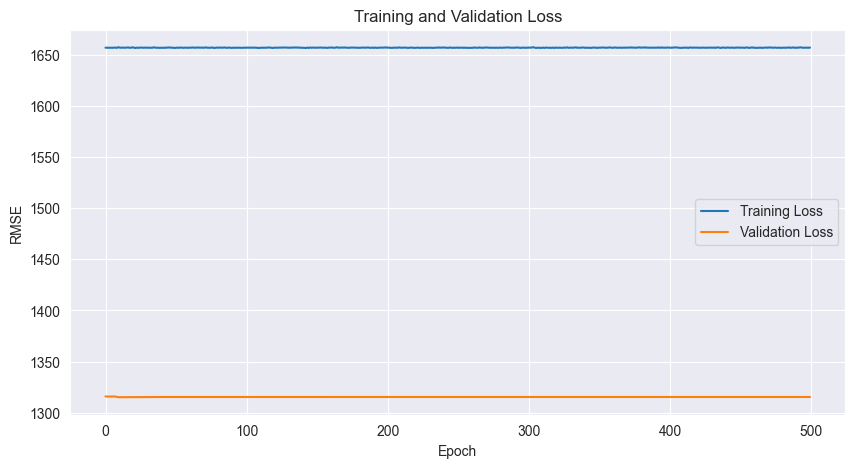

Final validation RMSE: 1315.1168
  Fold 3/5
Input size: 437



  3%|▎         | 13/500 [00:00<00:03, 125.79it/s]

Epoch 0: Train RMSE: 1552.1084, Val RMSE: 2262.4497
Epoch 10: Train RMSE: 1551.9429, Val RMSE: 2262.2588
Epoch 20: Train RMSE: 1552.0070, Val RMSE: 2262.0935



  8%|▊         | 41/500 [00:00<00:04, 94.48it/s] 

Epoch 30: Train RMSE: 1552.0049, Val RMSE: 2261.9399
Epoch 40: Train RMSE: 1551.8088, Val RMSE: 2261.8450



 14%|█▎        | 68/500 [00:00<00:03, 111.84it/s]

Epoch 50: Train RMSE: 1551.8221, Val RMSE: 2261.7874
Epoch 60: Train RMSE: 1551.9454, Val RMSE: 2261.7444
Epoch 70: Train RMSE: 1551.7101, Val RMSE: 2261.6750



 19%|█▉        | 95/500 [00:00<00:03, 121.45it/s]

Epoch 80: Train RMSE: 1551.6746, Val RMSE: 2261.6187
Epoch 90: Train RMSE: 1551.7648, Val RMSE: 2261.5769
Epoch 100: Train RMSE: 1552.0791, Val RMSE: 2261.5574



 25%|██▌       | 125/500 [00:01<00:02, 133.48it/s]

Epoch 110: Train RMSE: 1551.9738, Val RMSE: 2261.5537
Epoch 120: Train RMSE: 1552.0161, Val RMSE: 2261.5498
Epoch 130: Train RMSE: 1551.7595, Val RMSE: 2261.5464



 36%|███▌      | 179/500 [00:01<00:01, 166.39it/s]

Epoch 140: Train RMSE: 1551.8538, Val RMSE: 2261.5447
Epoch 150: Train RMSE: 1551.8617, Val RMSE: 2261.5442
Epoch 160: Train RMSE: 1551.7906, Val RMSE: 2261.5439
Epoch 170: Train RMSE: 1551.9313, Val RMSE: 2261.5439



 45%|████▍     | 223/500 [00:01<00:01, 190.57it/s]

Epoch 180: Train RMSE: 1551.7579, Val RMSE: 2261.5437
Epoch 190: Train RMSE: 1551.8735, Val RMSE: 2261.5439
Epoch 200: Train RMSE: 1552.0269, Val RMSE: 2261.5437
Epoch 210: Train RMSE: 1552.0493, Val RMSE: 2261.5437
Epoch 220: Train RMSE: 1551.7047, Val RMSE: 2261.5437



 53%|█████▎    | 265/500 [00:01<00:01, 192.77it/s]

Epoch 230: Train RMSE: 1552.0291, Val RMSE: 2261.5437
Epoch 240: Train RMSE: 1551.7552, Val RMSE: 2261.5437
Epoch 250: Train RMSE: 1551.8947, Val RMSE: 2261.5437
Epoch 260: Train RMSE: 1552.0750, Val RMSE: 2261.5437
Epoch 270: Train RMSE: 1551.8406, Val RMSE: 2261.5437



 62%|██████▏   | 309/500 [00:01<00:00, 202.36it/s]

Epoch 280: Train RMSE: 1551.9674, Val RMSE: 2261.5437
Epoch 290: Train RMSE: 1551.8180, Val RMSE: 2261.5437
Epoch 300: Train RMSE: 1552.0203, Val RMSE: 2261.5437
Epoch 310: Train RMSE: 1551.8013, Val RMSE: 2261.5437
Epoch 320: Train RMSE: 1551.6698, Val RMSE: 2261.5437



 71%|███████   | 354/500 [00:02<00:00, 210.22it/s]

Epoch 330: Train RMSE: 1551.5743, Val RMSE: 2261.5437
Epoch 340: Train RMSE: 1551.8241, Val RMSE: 2261.5437
Epoch 350: Train RMSE: 1552.0776, Val RMSE: 2261.5437
Epoch 360: Train RMSE: 1552.1769, Val RMSE: 2261.5437
Epoch 370: Train RMSE: 1551.9674, Val RMSE: 2261.5437



 85%|████████▍ | 423/500 [00:02<00:00, 217.16it/s]

Epoch 380: Train RMSE: 1551.6704, Val RMSE: 2261.5437
Epoch 390: Train RMSE: 1551.9921, Val RMSE: 2261.5437
Epoch 400: Train RMSE: 1551.9482, Val RMSE: 2261.5437
Epoch 410: Train RMSE: 1551.9225, Val RMSE: 2261.5437
Epoch 420: Train RMSE: 1551.9781, Val RMSE: 2261.5437



 94%|█████████▍| 469/500 [00:02<00:00, 214.95it/s]

Epoch 430: Train RMSE: 1551.7244, Val RMSE: 2261.5437
Epoch 440: Train RMSE: 1551.8907, Val RMSE: 2261.5437
Epoch 450: Train RMSE: 1551.8264, Val RMSE: 2261.5437
Epoch 460: Train RMSE: 1551.7726, Val RMSE: 2261.5437
Epoch 470: Train RMSE: 1552.0210, Val RMSE: 2261.5437



100%|██████████| 500/500 [00:02<00:00, 173.64it/s]


Epoch 480: Train RMSE: 1551.8694, Val RMSE: 2261.5437
Epoch 490: Train RMSE: 1551.6602, Val RMSE: 2261.5437


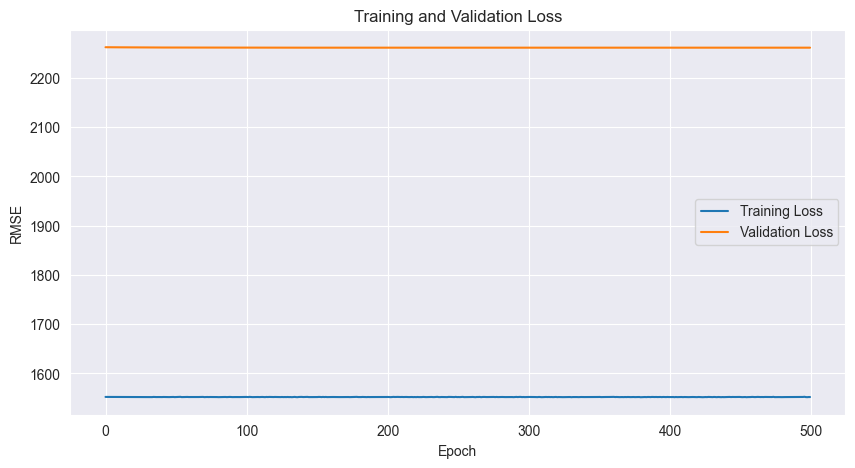

Final validation RMSE: 2261.5437
  Fold 4/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1755.8954, Val RMSE: 2261.8262



  3%|▎         | 16/500 [00:00<00:03, 158.55it/s]

Epoch 10: Train RMSE: 1755.4824, Val RMSE: 2261.8953
Epoch 20: Train RMSE: 1755.3822, Val RMSE: 2261.9507
Epoch 30: Train RMSE: 1755.1409, Val RMSE: 2261.9963



  7%|▋         | 34/500 [00:00<00:02, 169.45it/s]

Epoch 40: Train RMSE: 1755.1202, Val RMSE: 2262.0320



 14%|█▎        | 68/500 [00:00<00:02, 162.42it/s]

Epoch 50: Train RMSE: 1755.0181, Val RMSE: 2262.0464
Epoch 60: Train RMSE: 1755.2415, Val RMSE: 2262.0554
Epoch 70: Train RMSE: 1755.0868, Val RMSE: 2262.0608
Epoch 80: Train RMSE: 1755.1658, Val RMSE: 2262.0637



 21%|██        | 105/500 [00:00<00:02, 174.86it/s]

Epoch 90: Train RMSE: 1754.9427, Val RMSE: 2262.0654
Epoch 100: Train RMSE: 1755.1228, Val RMSE: 2262.0662
Epoch 110: Train RMSE: 1755.0505, Val RMSE: 2262.0669
Epoch 120: Train RMSE: 1755.1134, Val RMSE: 2262.0671



 25%|██▌       | 126/500 [00:00<00:02, 184.31it/s]

Epoch 130: Train RMSE: 1755.0410, Val RMSE: 2262.0671



 33%|███▎      | 165/500 [00:00<00:01, 183.86it/s]

Epoch 140: Train RMSE: 1755.0764, Val RMSE: 2262.0671
Epoch 150: Train RMSE: 1754.9762, Val RMSE: 2262.0674
Epoch 160: Train RMSE: 1754.9258, Val RMSE: 2262.0671
Epoch 170: Train RMSE: 1754.9609, Val RMSE: 2262.0674



 41%|████      | 204/500 [00:01<00:01, 180.27it/s]

Epoch 180: Train RMSE: 1755.3856, Val RMSE: 2262.0674
Epoch 190: Train RMSE: 1754.9305, Val RMSE: 2262.0674
Epoch 200: Train RMSE: 1755.0988, Val RMSE: 2262.0674
Epoch 210: Train RMSE: 1754.9758, Val RMSE: 2262.0674



 49%|████▊     | 243/500 [00:01<00:01, 187.32it/s]

Epoch 220: Train RMSE: 1754.9601, Val RMSE: 2262.0674
Epoch 230: Train RMSE: 1754.9106, Val RMSE: 2262.0674
Epoch 240: Train RMSE: 1754.9673, Val RMSE: 2262.0674
Epoch 250: Train RMSE: 1755.0649, Val RMSE: 2262.0674
Epoch 260: Train RMSE: 1755.0811, Val RMSE: 2262.0674



 57%|█████▋    | 284/500 [00:01<00:01, 171.10it/s]

Epoch 270: Train RMSE: 1755.0225, Val RMSE: 2262.0674
Epoch 280: Train RMSE: 1755.0259, Val RMSE: 2262.0674
Epoch 290: Train RMSE: 1755.0011, Val RMSE: 2262.0674



 64%|██████▍   | 320/500 [00:01<00:01, 169.55it/s]

Epoch 300: Train RMSE: 1755.0565, Val RMSE: 2262.0674
Epoch 310: Train RMSE: 1755.1355, Val RMSE: 2262.0674
Epoch 320: Train RMSE: 1754.9430, Val RMSE: 2262.0674
Epoch 330: Train RMSE: 1754.9730, Val RMSE: 2262.0674



 72%|███████▏  | 361/500 [00:02<00:00, 184.30it/s]

Epoch 340: Train RMSE: 1755.0570, Val RMSE: 2262.0674
Epoch 350: Train RMSE: 1755.1139, Val RMSE: 2262.0674
Epoch 360: Train RMSE: 1755.2275, Val RMSE: 2262.0674
Epoch 370: Train RMSE: 1755.1422, Val RMSE: 2262.0674



 80%|███████▉  | 398/500 [00:02<00:00, 178.65it/s]

Epoch 380: Train RMSE: 1755.0271, Val RMSE: 2262.0674
Epoch 390: Train RMSE: 1754.9857, Val RMSE: 2262.0674
Epoch 400: Train RMSE: 1755.1177, Val RMSE: 2262.0674



 84%|████████▎ | 418/500 [00:02<00:00, 183.19it/s]

Epoch 410: Train RMSE: 1755.0249, Val RMSE: 2262.0674



 87%|████████▋ | 437/500 [00:02<00:00, 184.62it/s]

Epoch 420: Train RMSE: 1755.2225, Val RMSE: 2262.0674
Epoch 430: Train RMSE: 1755.2051, Val RMSE: 2262.0674
Epoch 440: Train RMSE: 1754.9554, Val RMSE: 2262.0674



 91%|█████████ | 456/500 [00:02<00:00, 184.18it/s]

Epoch 450: Train RMSE: 1755.0236, Val RMSE: 2262.0674



 95%|█████████▌| 475/500 [00:02<00:00, 175.79it/s]

Epoch 460: Train RMSE: 1755.0874, Val RMSE: 2262.0674
Epoch 470: Train RMSE: 1755.1228, Val RMSE: 2262.0674
Epoch 480: Train RMSE: 1754.9180, Val RMSE: 2262.0674



 99%|█████████▊| 493/500 [00:02<00:00, 175.83it/s]

Epoch 490: Train RMSE: 1755.2903, Val RMSE: 2262.0674


100%|██████████| 500/500 [00:02<00:00, 177.49it/s]


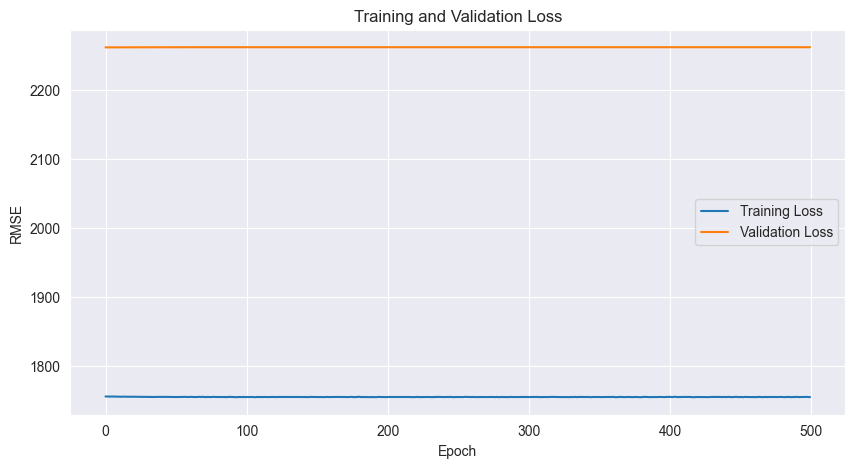

Final validation RMSE: 2261.7881
  Fold 5/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1867.7344, Val RMSE: 2493.1128



  2%|▏         | 12/500 [00:00<00:04, 118.08it/s]

Epoch 10: Train RMSE: 1867.4702, Val RMSE: 2493.5032
Epoch 20: Train RMSE: 1867.3258, Val RMSE: 2493.6887



  6%|▌         | 28/500 [00:00<00:03, 138.98it/s]

Epoch 30: Train RMSE: 1868.0518, Val RMSE: 2493.0359
Epoch 40: Train RMSE: 1867.9834, Val RMSE: 2493.0515



 12%|█▏        | 58/500 [00:00<00:03, 138.09it/s]

Epoch 50: Train RMSE: 1867.7594, Val RMSE: 2493.0615



 15%|█▌        | 75/500 [00:00<00:02, 146.91it/s]

Epoch 60: Train RMSE: 1867.8395, Val RMSE: 2493.0664
Epoch 70: Train RMSE: 1867.5980, Val RMSE: 2493.0691
Epoch 80: Train RMSE: 1868.0537, Val RMSE: 2493.0706



 18%|█▊        | 92/500 [00:00<00:02, 153.86it/s]

Epoch 90: Train RMSE: 1867.8075, Val RMSE: 2493.0713



 22%|██▏       | 110/500 [00:00<00:02, 160.10it/s]

Epoch 100: Train RMSE: 1867.7537, Val RMSE: 2493.0718
Epoch 110: Train RMSE: 1867.5417, Val RMSE: 2493.0720
Epoch 120: Train RMSE: 1867.6704, Val RMSE: 2493.0720



 25%|██▌       | 127/500 [00:00<00:02, 160.17it/s]

Epoch 130: Train RMSE: 1867.6069, Val RMSE: 2493.0720



 32%|███▏      | 161/500 [00:01<00:02, 156.85it/s]

Epoch 140: Train RMSE: 1867.5715, Val RMSE: 2493.0720
Epoch 150: Train RMSE: 1867.7953, Val RMSE: 2493.0720
Epoch 160: Train RMSE: 1867.6145, Val RMSE: 2493.0720
Epoch 170: Train RMSE: 1867.6185, Val RMSE: 2493.0720



 39%|███▉      | 196/500 [00:01<00:01, 164.24it/s]

Epoch 180: Train RMSE: 1867.5085, Val RMSE: 2493.0720
Epoch 190: Train RMSE: 1867.6366, Val RMSE: 2493.0720
Epoch 200: Train RMSE: 1867.9027, Val RMSE: 2493.0720



 43%|████▎     | 214/500 [00:01<00:01, 167.44it/s]

Epoch 210: Train RMSE: 1867.9287, Val RMSE: 2493.0720



 46%|████▌     | 231/500 [00:01<00:01, 161.22it/s]

Epoch 220: Train RMSE: 1867.7539, Val RMSE: 2493.0720
Epoch 230: Train RMSE: 1867.7080, Val RMSE: 2493.0720



 53%|█████▎    | 265/500 [00:01<00:01, 136.25it/s]

Epoch 240: Train RMSE: 1867.5316, Val RMSE: 2493.0720
Epoch 250: Train RMSE: 1867.4711, Val RMSE: 2493.0720
Epoch 260: Train RMSE: 1867.7052, Val RMSE: 2493.0720
Epoch 270: Train RMSE: 1867.7532, Val RMSE: 2493.0720



 60%|█████▉    | 299/500 [00:02<00:01, 147.06it/s]

Epoch 280: Train RMSE: 1867.8920, Val RMSE: 2493.0720
Epoch 290: Train RMSE: 1867.9417, Val RMSE: 2493.0720
Epoch 300: Train RMSE: 1867.7150, Val RMSE: 2493.0720
Epoch 310: Train RMSE: 1867.7355, Val RMSE: 2493.0720



 70%|███████   | 351/500 [00:02<00:00, 162.88it/s]

Epoch 320: Train RMSE: 1867.7158, Val RMSE: 2493.0720
Epoch 330: Train RMSE: 1867.8364, Val RMSE: 2493.0720
Epoch 340: Train RMSE: 1867.8730, Val RMSE: 2493.0720
Epoch 350: Train RMSE: 1867.5245, Val RMSE: 2493.0720



 77%|███████▋  | 387/500 [00:02<00:00, 168.56it/s]

Epoch 360: Train RMSE: 1867.5719, Val RMSE: 2493.0720
Epoch 370: Train RMSE: 1867.6561, Val RMSE: 2493.0720
Epoch 380: Train RMSE: 1867.9186, Val RMSE: 2493.0720
Epoch 390: Train RMSE: 1867.7609, Val RMSE: 2493.0720



 85%|████████▍ | 423/500 [00:02<00:00, 166.76it/s]

Epoch 400: Train RMSE: 1867.7115, Val RMSE: 2493.0720
Epoch 410: Train RMSE: 1867.8651, Val RMSE: 2493.0720
Epoch 420: Train RMSE: 1867.9489, Val RMSE: 2493.0720
Epoch 430: Train RMSE: 1867.7546, Val RMSE: 2493.0720



 92%|█████████▏| 460/500 [00:02<00:00, 173.37it/s]

Epoch 440: Train RMSE: 1867.5226, Val RMSE: 2493.0720
Epoch 450: Train RMSE: 1867.4105, Val RMSE: 2493.0720
Epoch 460: Train RMSE: 1867.6951, Val RMSE: 2493.0720
Epoch 470: Train RMSE: 1867.6832, Val RMSE: 2493.0720



100%|██████████| 500/500 [00:03<00:00, 156.80it/s]


Epoch 480: Train RMSE: 1867.8846, Val RMSE: 2493.0720
Epoch 490: Train RMSE: 1867.5127, Val RMSE: 2493.0720


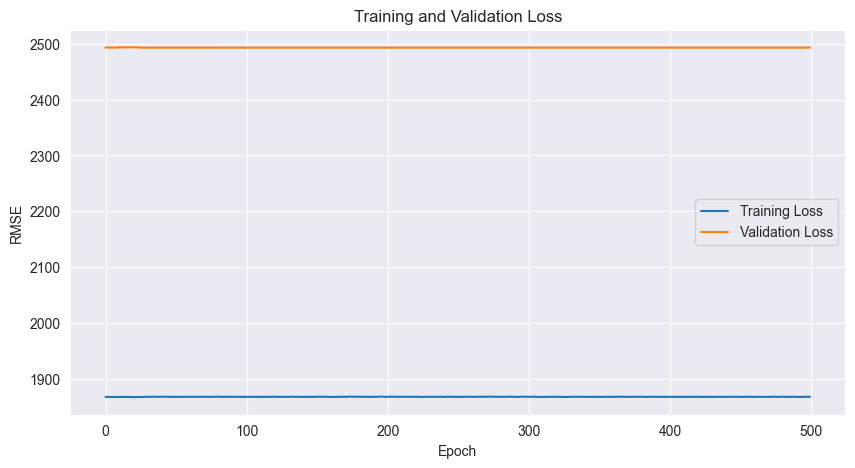

Final validation RMSE: 2493.0264
  Avg RMSE: 2032.0971 ± 417.8910

Testing: hidden_size=64, layers=10, lr=0.0001
  Fold 1/5
Input size: 437



  2%|▏         | 8/500 [00:00<00:06, 79.82it/s]

Epoch 0: Train RMSE: 1467.7677, Val RMSE: 1828.9745
Epoch 10: Train RMSE: 1467.7917, Val RMSE: 1828.8502



  4%|▍         | 22/500 [00:00<00:04, 111.29it/s]

Epoch 20: Train RMSE: 1467.7383, Val RMSE: 1828.8943



  8%|▊         | 38/500 [00:00<00:03, 132.84it/s]

Epoch 30: Train RMSE: 1467.7350, Val RMSE: 1828.9062
Epoch 40: Train RMSE: 1467.6200, Val RMSE: 1828.9291
Epoch 50: Train RMSE: 1467.8199, Val RMSE: 1828.9293



 17%|█▋        | 85/500 [00:00<00:03, 138.33it/s]

Epoch 60: Train RMSE: 1467.6974, Val RMSE: 1828.9266
Epoch 70: Train RMSE: 1467.6814, Val RMSE: 1828.9265
Epoch 80: Train RMSE: 1467.5957, Val RMSE: 1828.9254



 23%|██▎       | 114/500 [00:00<00:02, 137.96it/s]

Epoch 90: Train RMSE: 1467.8335, Val RMSE: 1828.9252
Epoch 100: Train RMSE: 1467.4652, Val RMSE: 1828.9248
Epoch 110: Train RMSE: 1467.9050, Val RMSE: 1828.9248



 28%|██▊       | 142/500 [00:01<00:02, 126.43it/s]

Epoch 120: Train RMSE: 1467.7671, Val RMSE: 1828.9247
Epoch 130: Train RMSE: 1467.8771, Val RMSE: 1828.9247
Epoch 140: Train RMSE: 1467.9210, Val RMSE: 1828.9247



 34%|███▍      | 170/500 [00:01<00:02, 129.73it/s]

Epoch 150: Train RMSE: 1467.6757, Val RMSE: 1828.9247
Epoch 160: Train RMSE: 1467.7185, Val RMSE: 1828.9247
Epoch 170: Train RMSE: 1467.5559, Val RMSE: 1828.9247



 41%|████      | 203/500 [00:01<00:02, 142.63it/s]

Epoch 180: Train RMSE: 1467.4857, Val RMSE: 1828.9247
Epoch 190: Train RMSE: 1467.6541, Val RMSE: 1828.9247
Epoch 200: Train RMSE: 1467.7256, Val RMSE: 1828.9247



 47%|████▋     | 235/500 [00:01<00:01, 145.30it/s]

Epoch 210: Train RMSE: 1467.7094, Val RMSE: 1828.9247
Epoch 220: Train RMSE: 1467.8593, Val RMSE: 1828.9247
Epoch 230: Train RMSE: 1467.7394, Val RMSE: 1828.9247
Epoch 240: Train RMSE: 1467.8510, Val RMSE: 1828.9246



 54%|█████▍    | 270/500 [00:01<00:01, 156.01it/s]

Epoch 250: Train RMSE: 1467.7576, Val RMSE: 1828.9246
Epoch 260: Train RMSE: 1467.7493, Val RMSE: 1828.9246
Epoch 270: Train RMSE: 1467.6196, Val RMSE: 1828.9246
Epoch 280: Train RMSE: 1467.9113, Val RMSE: 1828.9246



 64%|██████▍   | 320/500 [00:02<00:01, 153.20it/s]

Epoch 290: Train RMSE: 1467.8915, Val RMSE: 1828.9246
Epoch 300: Train RMSE: 1467.7593, Val RMSE: 1828.9246
Epoch 310: Train RMSE: 1467.7632, Val RMSE: 1828.9246



 71%|███████   | 355/500 [00:02<00:00, 162.12it/s]

Epoch 320: Train RMSE: 1467.8489, Val RMSE: 1828.9246
Epoch 330: Train RMSE: 1467.7788, Val RMSE: 1828.9246
Epoch 340: Train RMSE: 1467.6830, Val RMSE: 1828.9246
Epoch 350: Train RMSE: 1467.6256, Val RMSE: 1828.9246



 78%|███████▊  | 389/500 [00:02<00:00, 151.71it/s]

Epoch 360: Train RMSE: 1467.7810, Val RMSE: 1828.9247
Epoch 370: Train RMSE: 1467.6276, Val RMSE: 1828.9247
Epoch 380: Train RMSE: 1467.5819, Val RMSE: 1828.9247



 84%|████████▍ | 422/500 [00:02<00:00, 154.94it/s]

Epoch 390: Train RMSE: 1467.7235, Val RMSE: 1828.9246
Epoch 400: Train RMSE: 1467.8912, Val RMSE: 1828.9247
Epoch 410: Train RMSE: 1467.7555, Val RMSE: 1828.9247
Epoch 420: Train RMSE: 1467.6340, Val RMSE: 1828.9247



 91%|█████████ | 455/500 [00:03<00:00, 147.67it/s]

Epoch 430: Train RMSE: 1467.6786, Val RMSE: 1828.9247
Epoch 440: Train RMSE: 1467.8634, Val RMSE: 1828.9247
Epoch 450: Train RMSE: 1467.7919, Val RMSE: 1828.9247



 97%|█████████▋| 485/500 [00:03<00:00, 142.13it/s]

Epoch 460: Train RMSE: 1467.7557, Val RMSE: 1828.9247
Epoch 470: Train RMSE: 1467.7035, Val RMSE: 1828.9247
Epoch 480: Train RMSE: 1467.8164, Val RMSE: 1828.9247


100%|██████████| 500/500 [00:03<00:00, 144.50it/s]

Epoch 490: Train RMSE: 1467.6108, Val RMSE: 1828.9247


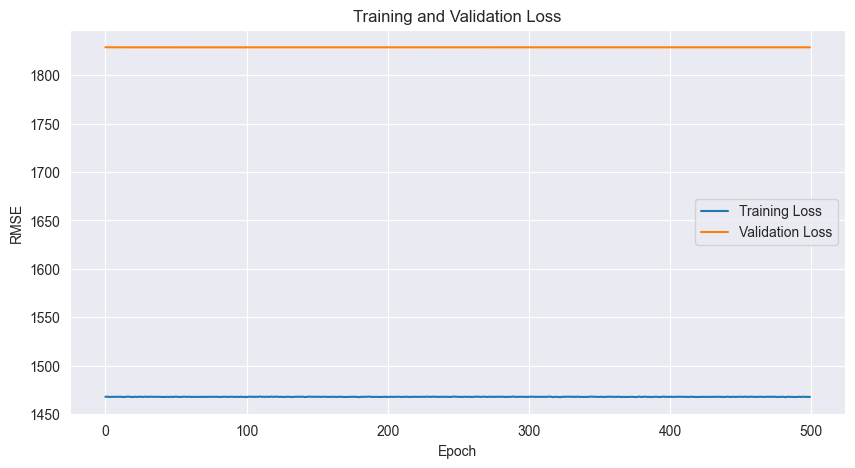

Final validation RMSE: 1828.8467
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.6876, Val RMSE: 1315.4490



  2%|▏         | 11/500 [00:00<00:04, 102.02it/s]

Epoch 10: Train RMSE: 1656.7712, Val RMSE: 1315.5349
Epoch 20: Train RMSE: 1656.9218, Val RMSE: 1315.4941



  5%|▍         | 23/500 [00:00<00:04, 111.89it/s]

Epoch 30: Train RMSE: 1656.7955, Val RMSE: 1315.4946



  9%|▉         | 47/500 [00:00<00:04, 105.90it/s]

Epoch 40: Train RMSE: 1656.7572, Val RMSE: 1315.4655
Epoch 50: Train RMSE: 1656.7668, Val RMSE: 1315.4648



 12%|█▏        | 59/500 [00:00<00:04, 110.00it/s]

Epoch 60: Train RMSE: 1656.6958, Val RMSE: 1315.4614



 17%|█▋        | 84/500 [00:00<00:03, 116.32it/s]

Epoch 70: Train RMSE: 1656.6982, Val RMSE: 1315.4607
Epoch 80: Train RMSE: 1657.0121, Val RMSE: 1315.4601
Epoch 90: Train RMSE: 1656.8054, Val RMSE: 1315.4601



 22%|██▏       | 109/500 [00:00<00:03, 117.52it/s]

Epoch 100: Train RMSE: 1656.7515, Val RMSE: 1315.4595
Epoch 110: Train RMSE: 1656.8617, Val RMSE: 1315.4594



 25%|██▍       | 123/500 [00:01<00:03, 122.07it/s]

Epoch 120: Train RMSE: 1656.8285, Val RMSE: 1315.4592



 27%|██▋       | 136/500 [00:01<00:02, 123.40it/s]

Epoch 130: Train RMSE: 1656.6155, Val RMSE: 1315.4592
Epoch 140: Train RMSE: 1656.7959, Val RMSE: 1315.4592



 30%|██▉       | 149/500 [00:01<00:02, 122.63it/s]

Epoch 150: Train RMSE: 1656.7358, Val RMSE: 1315.4592



 32%|███▏      | 162/500 [00:01<00:02, 120.01it/s]

Epoch 160: Train RMSE: 1656.6847, Val RMSE: 1315.4592
Epoch 170: Train RMSE: 1656.8748, Val RMSE: 1315.4592



 35%|███▌      | 175/500 [00:01<00:02, 113.01it/s]

Epoch 180: Train RMSE: 1656.8605, Val RMSE: 1315.4592



 40%|████      | 200/500 [00:01<00:02, 115.86it/s]

Epoch 190: Train RMSE: 1656.8302, Val RMSE: 1315.4592
Epoch 200: Train RMSE: 1656.5688, Val RMSE: 1315.4592



 42%|████▏     | 212/500 [00:01<00:02, 114.65it/s]

Epoch 210: Train RMSE: 1656.6313, Val RMSE: 1315.4592



 45%|████▍     | 224/500 [00:01<00:02, 113.64it/s]

Epoch 220: Train RMSE: 1656.8210, Val RMSE: 1315.4592
Epoch 230: Train RMSE: 1656.7698, Val RMSE: 1315.4592



 47%|████▋     | 236/500 [00:02<00:02, 113.09it/s]

Epoch 240: Train RMSE: 1656.8137, Val RMSE: 1315.4592



 52%|█████▏    | 260/500 [00:02<00:02, 114.52it/s]

Epoch 250: Train RMSE: 1656.4886, Val RMSE: 1315.4592
Epoch 260: Train RMSE: 1656.7007, Val RMSE: 1315.4592



 55%|█████▍    | 273/500 [00:02<00:01, 117.27it/s]

Epoch 270: Train RMSE: 1656.9150, Val RMSE: 1315.4592



 57%|█████▋    | 285/500 [00:02<00:01, 116.35it/s]

Epoch 280: Train RMSE: 1656.6254, Val RMSE: 1315.4592
Epoch 290: Train RMSE: 1656.8900, Val RMSE: 1315.4592



 59%|█████▉    | 297/500 [00:02<00:01, 113.97it/s]

Epoch 300: Train RMSE: 1656.7299, Val RMSE: 1315.4592



 65%|██████▍   | 324/500 [00:02<00:01, 122.49it/s]

Epoch 310: Train RMSE: 1656.8245, Val RMSE: 1315.4592
Epoch 320: Train RMSE: 1656.7920, Val RMSE: 1315.4592



 68%|██████▊   | 338/500 [00:02<00:01, 125.37it/s]

Epoch 330: Train RMSE: 1656.6813, Val RMSE: 1315.4592



 70%|███████   | 352/500 [00:03<00:01, 127.61it/s]

Epoch 340: Train RMSE: 1656.8960, Val RMSE: 1315.4592
Epoch 350: Train RMSE: 1656.7924, Val RMSE: 1315.4592



 73%|███████▎  | 365/500 [00:03<00:01, 123.65it/s]

Epoch 360: Train RMSE: 1657.0101, Val RMSE: 1315.4592



 76%|███████▌  | 378/500 [00:03<00:01, 115.15it/s]

Epoch 370: Train RMSE: 1656.7712, Val RMSE: 1315.4592
Epoch 380: Train RMSE: 1656.6351, Val RMSE: 1315.4592



 78%|███████▊  | 390/500 [00:03<00:00, 112.00it/s]

Epoch 390: Train RMSE: 1656.7743, Val RMSE: 1315.4592



 83%|████████▎ | 415/500 [00:03<00:00, 115.05it/s]

Epoch 400: Train RMSE: 1656.6129, Val RMSE: 1315.4592
Epoch 410: Train RMSE: 1656.7396, Val RMSE: 1315.4592


Epoch 420: Train RMSE: 1656.7550, Val RMSE: 1315.4592



 88%|████████▊ | 440/500 [00:03<00:00, 116.27it/s]

Epoch 430: Train RMSE: 1656.8304, Val RMSE: 1315.4592
Epoch 440: Train RMSE: 1656.4910, Val RMSE: 1315.4592



 91%|█████████ | 454/500 [00:03<00:00, 120.75it/s]

Epoch 450: Train RMSE: 1656.8002, Val RMSE: 1315.4592
Epoch 460: Train RMSE: 1656.5332, Val RMSE: 1315.4592



 93%|█████████▎| 467/500 [00:04<00:00, 97.50it/s] 

Epoch 470: Train RMSE: 1656.7773, Val RMSE: 1315.4592



 98%|█████████▊| 491/500 [00:04<00:00, 106.28it/s]

Epoch 480: Train RMSE: 1656.8523, Val RMSE: 1315.4592
Epoch 490: Train RMSE: 1656.7454, Val RMSE: 1315.4592


100%|██████████| 500/500 [00:04<00:00, 114.57it/s]


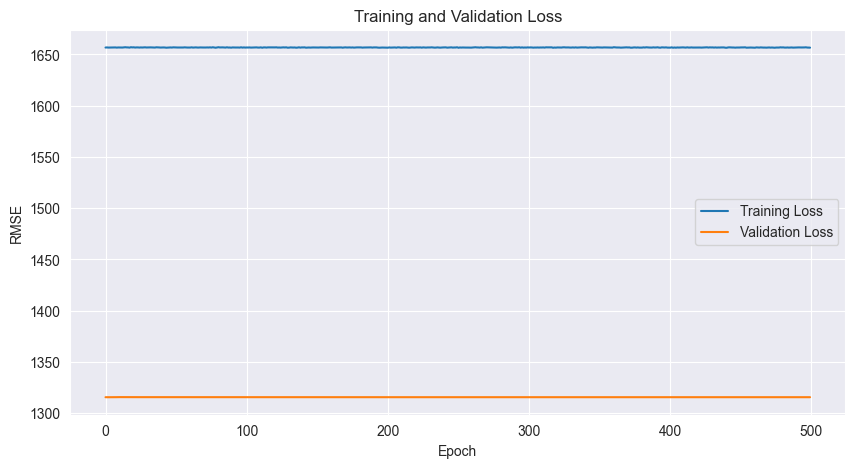

Final validation RMSE: 1315.4344
  Fold 3/5
Input size: 437



  2%|▏         | 10/500 [00:00<00:05, 95.00it/s]

Epoch 0: Train RMSE: 1552.0363, Val RMSE: 2262.3223
Epoch 10: Train RMSE: 1552.0181, Val RMSE: 2262.4297
Epoch 20: Train RMSE: 1552.1917, Val RMSE: 2262.4363



  9%|▉         | 45/500 [00:00<00:04, 101.92it/s]

Epoch 30: Train RMSE: 1551.9840, Val RMSE: 2262.4155
Epoch 40: Train RMSE: 1552.0168, Val RMSE: 2262.4148
Epoch 50: Train RMSE: 1551.9073, Val RMSE: 2262.4226



 16%|█▋        | 82/500 [00:00<00:03, 114.65it/s]

Epoch 60: Train RMSE: 1551.8966, Val RMSE: 2262.4260
Epoch 70: Train RMSE: 1552.0034, Val RMSE: 2262.4246
Epoch 80: Train RMSE: 1551.9800, Val RMSE: 2262.4236



 21%|██        | 106/500 [00:00<00:03, 108.59it/s]

Epoch 90: Train RMSE: 1552.0403, Val RMSE: 2262.4233
Epoch 100: Train RMSE: 1552.1215, Val RMSE: 2262.4236
Epoch 110: Train RMSE: 1551.9359, Val RMSE: 2262.4233



 28%|██▊       | 142/500 [00:01<00:03, 113.56it/s]

Epoch 120: Train RMSE: 1552.1085, Val RMSE: 2262.4233
Epoch 130: Train RMSE: 1552.0406, Val RMSE: 2262.4233
Epoch 140: Train RMSE: 1552.0133, Val RMSE: 2262.4233



 33%|███▎      | 165/500 [00:01<00:03, 107.46it/s]

Epoch 150: Train RMSE: 1551.9707, Val RMSE: 2262.4233
Epoch 160: Train RMSE: 1552.1138, Val RMSE: 2262.4233
Epoch 170: Train RMSE: 1551.9735, Val RMSE: 2262.4233



 40%|████      | 200/500 [00:01<00:02, 113.78it/s]

Epoch 180: Train RMSE: 1552.1145, Val RMSE: 2262.4233
Epoch 190: Train RMSE: 1552.0013, Val RMSE: 2262.4233
Epoch 200: Train RMSE: 1552.0811, Val RMSE: 2262.4233



 45%|████▍     | 224/500 [00:02<00:02, 111.30it/s]

Epoch 210: Train RMSE: 1552.1725, Val RMSE: 2262.4233
Epoch 220: Train RMSE: 1552.1010, Val RMSE: 2262.4233
Epoch 230: Train RMSE: 1551.9856, Val RMSE: 2262.4233



 52%|█████▏    | 261/500 [00:02<00:02, 114.25it/s]

Epoch 240: Train RMSE: 1552.0654, Val RMSE: 2262.4233
Epoch 250: Train RMSE: 1551.9877, Val RMSE: 2262.4233
Epoch 260: Train RMSE: 1552.0946, Val RMSE: 2262.4233



 57%|█████▋    | 285/500 [00:02<00:01, 112.79it/s]

Epoch 270: Train RMSE: 1552.0186, Val RMSE: 2262.4233
Epoch 280: Train RMSE: 1552.1097, Val RMSE: 2262.4233
Epoch 290: Train RMSE: 1551.9971, Val RMSE: 2262.4233



 64%|██████▍   | 322/500 [00:02<00:01, 116.70it/s]

Epoch 300: Train RMSE: 1552.0323, Val RMSE: 2262.4233
Epoch 310: Train RMSE: 1552.0634, Val RMSE: 2262.4233
Epoch 320: Train RMSE: 1551.8966, Val RMSE: 2262.4233



 69%|██████▉   | 346/500 [00:03<00:01, 116.24it/s]

Epoch 330: Train RMSE: 1552.1310, Val RMSE: 2262.4233
Epoch 340: Train RMSE: 1552.1262, Val RMSE: 2262.4233
Epoch 350: Train RMSE: 1552.0751, Val RMSE: 2262.4233



 77%|███████▋  | 383/500 [00:03<00:01, 114.72it/s]

Epoch 360: Train RMSE: 1552.0793, Val RMSE: 2262.4233
Epoch 370: Train RMSE: 1551.8870, Val RMSE: 2262.4233
Epoch 380: Train RMSE: 1552.0045, Val RMSE: 2262.4233



 82%|████████▏ | 408/500 [00:03<00:00, 117.41it/s]

Epoch 390: Train RMSE: 1552.1528, Val RMSE: 2262.4233
Epoch 400: Train RMSE: 1552.0867, Val RMSE: 2262.4233
Epoch 410: Train RMSE: 1552.0248, Val RMSE: 2262.4233



 86%|████████▋ | 432/500 [00:03<00:00, 110.68it/s]

Epoch 420: Train RMSE: 1552.0370, Val RMSE: 2262.4233
Epoch 430: Train RMSE: 1552.0819, Val RMSE: 2262.4233
Epoch 440: Train RMSE: 1551.9930, Val RMSE: 2262.4233



 94%|█████████▍| 470/500 [00:04<00:00, 117.09it/s]

Epoch 450: Train RMSE: 1552.0515, Val RMSE: 2262.4233
Epoch 460: Train RMSE: 1552.1094, Val RMSE: 2262.4233
Epoch 470: Train RMSE: 1552.0562, Val RMSE: 2262.4233



100%|██████████| 500/500 [00:04<00:00, 111.66it/s]

Epoch 480: Train RMSE: 1552.1039, Val RMSE: 2262.4233
Epoch 490: Train RMSE: 1552.0753, Val RMSE: 2262.4233


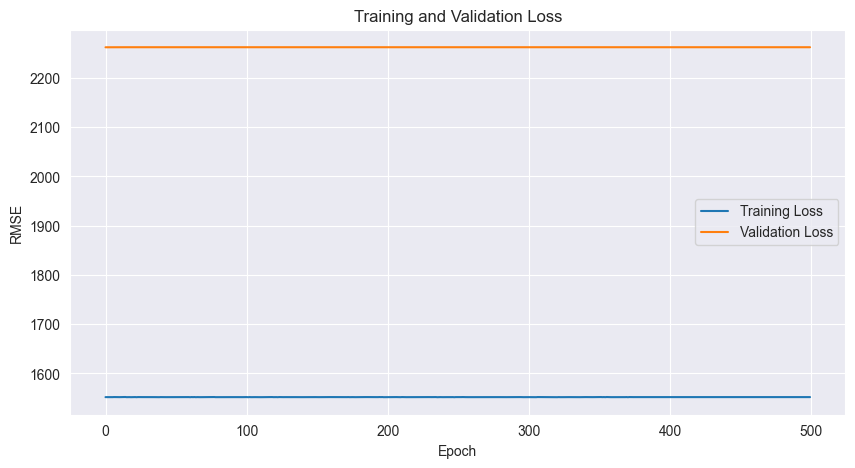

Final validation RMSE: 2262.3223
  Fold 4/5
Input size: 437



  1%|          | 6/500 [00:00<00:08, 56.15it/s]

Epoch 0: Train RMSE: 1755.9294, Val RMSE: 2261.7795
Epoch 10: Train RMSE: 1755.9415, Val RMSE: 2261.8159



  6%|▌         | 28/500 [00:00<00:08, 52.97it/s]

Epoch 20: Train RMSE: 1755.7798, Val RMSE: 2261.8245



 10%|▉         | 48/500 [00:00<00:06, 74.42it/s]

Epoch 30: Train RMSE: 1755.8922, Val RMSE: 2261.8337
Epoch 40: Train RMSE: 1755.9150, Val RMSE: 2261.8848



 13%|█▎        | 67/500 [00:00<00:05, 82.07it/s]

Epoch 50: Train RMSE: 1755.8188, Val RMSE: 2261.8262
Epoch 60: Train RMSE: 1755.8361, Val RMSE: 2261.8555



 17%|█▋        | 85/500 [00:01<00:04, 85.47it/s]

Epoch 70: Train RMSE: 1755.8114, Val RMSE: 2261.8516
Epoch 80: Train RMSE: 1755.8541, Val RMSE: 2261.8484



 21%|██        | 105/500 [00:01<00:04, 90.19it/s]

Epoch 90: Train RMSE: 1755.7781, Val RMSE: 2261.8486
Epoch 100: Train RMSE: 1755.8688, Val RMSE: 2261.8484



 25%|██▍       | 124/500 [00:01<00:04, 87.03it/s]

Epoch 110: Train RMSE: 1755.7919, Val RMSE: 2261.8486
Epoch 120: Train RMSE: 1755.8160, Val RMSE: 2261.8496



 29%|██▊       | 143/500 [00:01<00:04, 88.91it/s]

Epoch 130: Train RMSE: 1755.7721, Val RMSE: 2261.8501
Epoch 140: Train RMSE: 1755.8868, Val RMSE: 2261.8501



 32%|███▏      | 162/500 [00:01<00:03, 89.04it/s]

Epoch 150: Train RMSE: 1755.9668, Val RMSE: 2261.8501
Epoch 160: Train RMSE: 1755.8978, Val RMSE: 2261.8503



 36%|███▌      | 180/500 [00:02<00:03, 87.39it/s]

Epoch 170: Train RMSE: 1755.8451, Val RMSE: 2261.8503
Epoch 180: Train RMSE: 1755.8290, Val RMSE: 2261.8503



 42%|████▏     | 208/500 [00:02<00:03, 88.51it/s]

Epoch 190: Train RMSE: 1755.8447, Val RMSE: 2261.8503
Epoch 200: Train RMSE: 1755.7626, Val RMSE: 2261.8503



 45%|████▌     | 226/500 [00:02<00:03, 87.56it/s]

Epoch 210: Train RMSE: 1755.8898, Val RMSE: 2261.8503
Epoch 220: Train RMSE: 1755.8043, Val RMSE: 2261.8503



 49%|████▉     | 245/500 [00:02<00:02, 89.54it/s]

Epoch 230: Train RMSE: 1755.9205, Val RMSE: 2261.8503
Epoch 240: Train RMSE: 1755.9883, Val RMSE: 2261.8503



 53%|█████▎    | 265/500 [00:03<00:02, 88.57it/s]

Epoch 250: Train RMSE: 1755.9257, Val RMSE: 2261.8503
Epoch 260: Train RMSE: 1755.8364, Val RMSE: 2261.8503



 57%|█████▋    | 285/500 [00:03<00:02, 89.90it/s]

Epoch 270: Train RMSE: 1755.8965, Val RMSE: 2261.8503
Epoch 280: Train RMSE: 1755.9374, Val RMSE: 2261.8503



 61%|██████    | 305/500 [00:03<00:02, 93.88it/s]

Epoch 290: Train RMSE: 1755.8832, Val RMSE: 2261.8503
Epoch 300: Train RMSE: 1755.7671, Val RMSE: 2261.8503



 65%|██████▌   | 325/500 [00:03<00:01, 89.13it/s]

Epoch 310: Train RMSE: 1755.8042, Val RMSE: 2261.8503
Epoch 320: Train RMSE: 1755.8014, Val RMSE: 2261.8503



 69%|██████▉   | 345/500 [00:04<00:01, 92.58it/s]

Epoch 330: Train RMSE: 1755.8495, Val RMSE: 2261.8503
Epoch 340: Train RMSE: 1755.8848, Val RMSE: 2261.8503
Epoch 350: Train RMSE: 1755.9149, Val RMSE: 2261.8503



 75%|███████▌  | 376/500 [00:04<00:01, 92.12it/s]

Epoch 360: Train RMSE: 1755.8560, Val RMSE: 2261.8503
Epoch 370: Train RMSE: 1755.9222, Val RMSE: 2261.8503



 79%|███████▉  | 397/500 [00:04<00:01, 96.69it/s]

Epoch 380: Train RMSE: 1755.8885, Val RMSE: 2261.8503
Epoch 390: Train RMSE: 1755.9288, Val RMSE: 2261.8503
Epoch 400: Train RMSE: 1755.8604, Val RMSE: 2261.8503



 85%|████████▌ | 425/500 [00:04<00:00, 80.69it/s]

Epoch 410: Train RMSE: 1756.0366, Val RMSE: 2261.8503
Epoch 420: Train RMSE: 1755.8322, Val RMSE: 2261.8503



 89%|████████▉ | 446/500 [00:05<00:00, 90.67it/s]

Epoch 430: Train RMSE: 1755.8651, Val RMSE: 2261.8503
Epoch 440: Train RMSE: 1755.9149, Val RMSE: 2261.8503
Epoch 450: Train RMSE: 1755.7460, Val RMSE: 2261.8503



 95%|█████████▌| 477/500 [00:05<00:00, 91.76it/s]

Epoch 460: Train RMSE: 1755.7935, Val RMSE: 2261.8503
Epoch 470: Train RMSE: 1755.8606, Val RMSE: 2261.8503



 99%|█████████▉| 497/500 [00:05<00:00, 90.10it/s]

Epoch 480: Train RMSE: 1755.8770, Val RMSE: 2261.8503
Epoch 490: Train RMSE: 1755.8986, Val RMSE: 2261.8501


100%|██████████| 500/500 [00:05<00:00, 87.00it/s]


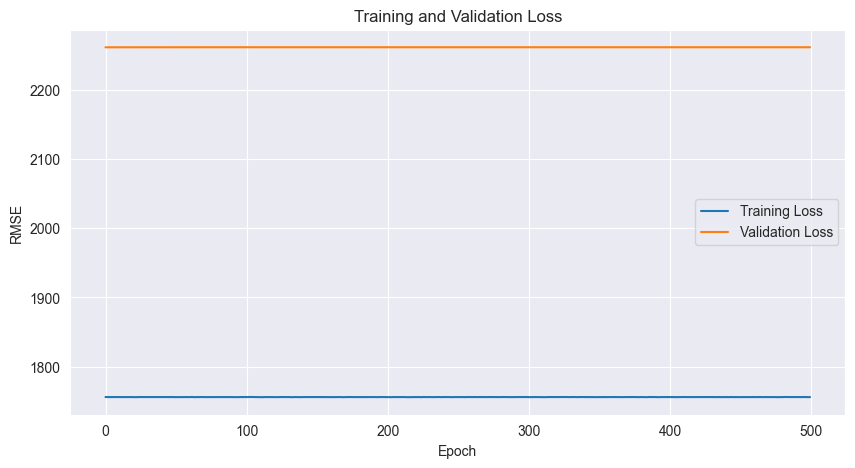

Final validation RMSE: 2261.7769
  Fold 5/5
Input size: 437



  1%|▏         | 7/500 [00:00<00:07, 62.27it/s]

Epoch 0: Train RMSE: 1867.6682, Val RMSE: 2493.2686
Epoch 10: Train RMSE: 1867.7064, Val RMSE: 2493.2837



  6%|▋         | 32/500 [00:00<00:06, 77.35it/s]

Epoch 20: Train RMSE: 1867.7855, Val RMSE: 2493.2817
Epoch 30: Train RMSE: 1867.6544, Val RMSE: 2493.2832



 10%|█         | 50/500 [00:00<00:05, 80.80it/s]

Epoch 40: Train RMSE: 1867.7068, Val RMSE: 2493.2847
Epoch 50: Train RMSE: 1867.6904, Val RMSE: 2493.2856



 16%|█▌        | 78/500 [00:00<00:05, 83.76it/s]

Epoch 60: Train RMSE: 1867.6813, Val RMSE: 2493.2856
Epoch 70: Train RMSE: 1867.6759, Val RMSE: 2493.2859



 19%|█▉        | 96/500 [00:01<00:04, 85.23it/s]

Epoch 80: Train RMSE: 1867.6865, Val RMSE: 2493.2859
Epoch 90: Train RMSE: 1867.6823, Val RMSE: 2493.2859



 23%|██▎       | 114/500 [00:01<00:04, 80.53it/s]

Epoch 100: Train RMSE: 1867.7054, Val RMSE: 2493.2859
Epoch 110: Train RMSE: 1867.7666, Val RMSE: 2493.2859



 26%|██▋       | 132/500 [00:01<00:04, 82.20it/s]

Epoch 120: Train RMSE: 1867.7164, Val RMSE: 2493.2859
Epoch 130: Train RMSE: 1867.7007, Val RMSE: 2493.2859



 28%|██▊       | 141/500 [00:01<00:04, 82.43it/s]

Epoch 140: Train RMSE: 1867.7058, Val RMSE: 2493.2859



 33%|███▎      | 167/500 [00:02<00:04, 73.18it/s]

Epoch 150: Train RMSE: 1867.7650, Val RMSE: 2493.2859
Epoch 160: Train RMSE: 1867.6770, Val RMSE: 2493.2859



 37%|███▋      | 186/500 [00:02<00:04, 77.70it/s]

Epoch 170: Train RMSE: 1867.6729, Val RMSE: 2493.2859
Epoch 180: Train RMSE: 1867.7440, Val RMSE: 2493.2859



 41%|████      | 203/500 [00:02<00:03, 79.45it/s]

Epoch 190: Train RMSE: 1867.6914, Val RMSE: 2493.2859
Epoch 200: Train RMSE: 1867.6501, Val RMSE: 2493.2859



 44%|████▍     | 221/500 [00:02<00:03, 78.66it/s]

Epoch 210: Train RMSE: 1867.6781, Val RMSE: 2493.2859
Epoch 220: Train RMSE: 1867.6234, Val RMSE: 2493.2859



 49%|████▉     | 246/500 [00:03<00:03, 77.59it/s]

Epoch 230: Train RMSE: 1867.6268, Val RMSE: 2493.2859
Epoch 240: Train RMSE: 1867.6581, Val RMSE: 2493.2859



 52%|█████▏    | 262/500 [00:03<00:03, 77.06it/s]

Epoch 250: Train RMSE: 1867.6713, Val RMSE: 2493.2859
Epoch 260: Train RMSE: 1867.5787, Val RMSE: 2493.2859



 56%|█████▌    | 278/500 [00:03<00:02, 75.45it/s]

Epoch 270: Train RMSE: 1867.7283, Val RMSE: 2493.2859
Epoch 280: Train RMSE: 1867.6849, Val RMSE: 2493.2859



 61%|██████    | 303/500 [00:03<00:02, 78.23it/s]

Epoch 290: Train RMSE: 1867.8147, Val RMSE: 2493.2859
Epoch 300: Train RMSE: 1867.6655, Val RMSE: 2493.2859



 64%|██████▍   | 321/500 [00:04<00:02, 78.55it/s]

Epoch 310: Train RMSE: 1867.7596, Val RMSE: 2493.2859
Epoch 320: Train RMSE: 1867.7487, Val RMSE: 2493.2859



 70%|██████▉   | 348/500 [00:04<00:01, 83.21it/s]

Epoch 330: Train RMSE: 1867.6593, Val RMSE: 2493.2859
Epoch 340: Train RMSE: 1867.6821, Val RMSE: 2493.2859



 71%|███████▏  | 357/500 [00:04<00:02, 62.08it/s]

Epoch 350: Train RMSE: 1867.7247, Val RMSE: 2493.2859



 74%|███████▍  | 371/500 [00:04<00:01, 64.77it/s]

Epoch 360: Train RMSE: 1867.6796, Val RMSE: 2493.2859
Epoch 370: Train RMSE: 1867.6886, Val RMSE: 2493.2859



 80%|███████▉  | 398/500 [00:05<00:01, 77.96it/s]

Epoch 380: Train RMSE: 1867.6221, Val RMSE: 2493.2859
Epoch 390: Train RMSE: 1867.7960, Val RMSE: 2493.2859



 83%|████████▎ | 416/500 [00:05<00:01, 78.86it/s]

Epoch 400: Train RMSE: 1867.7091, Val RMSE: 2493.2859
Epoch 410: Train RMSE: 1867.6581, Val RMSE: 2493.2859



 87%|████████▋ | 434/500 [00:05<00:00, 82.24it/s]

Epoch 420: Train RMSE: 1867.7444, Val RMSE: 2493.2859
Epoch 430: Train RMSE: 1867.7162, Val RMSE: 2493.2859



 91%|█████████ | 453/500 [00:05<00:00, 83.19it/s]

Epoch 440: Train RMSE: 1867.6837, Val RMSE: 2493.2859
Epoch 450: Train RMSE: 1867.7609, Val RMSE: 2493.2859



 94%|█████████▍| 471/500 [00:06<00:00, 80.21it/s]

Epoch 460: Train RMSE: 1867.7986, Val RMSE: 2493.2859
Epoch 470: Train RMSE: 1867.7118, Val RMSE: 2493.2859



 98%|█████████▊| 489/500 [00:06<00:00, 81.19it/s]

Epoch 480: Train RMSE: 1867.6349, Val RMSE: 2493.2859
Epoch 490: Train RMSE: 1867.7673, Val RMSE: 2493.2859



100%|██████████| 500/500 [00:06<00:00, 77.35it/s]


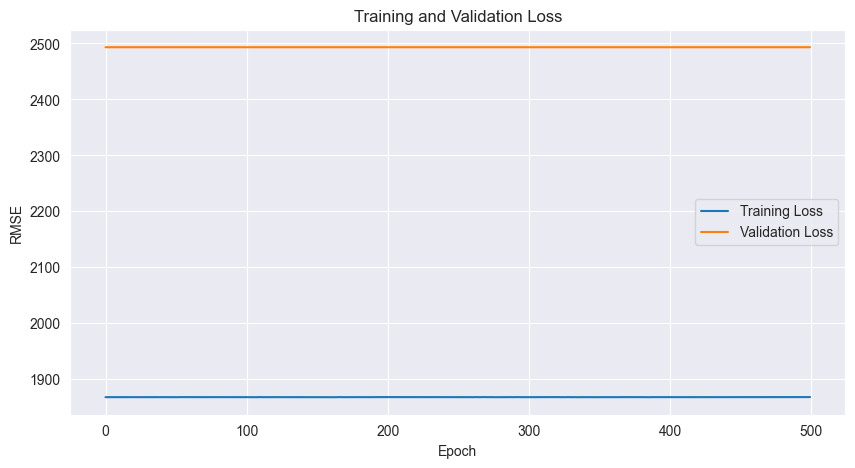

Final validation RMSE: 2493.2686
  Avg RMSE: 2032.3298 ± 417.9357

Testing: hidden_size=64, layers=10, lr=0.001
  Fold 1/5
Input size: 437



  1%|▏         | 7/500 [00:00<00:07, 69.19it/s]

Epoch 0: Train RMSE: 1467.7024, Val RMSE: 1829.0144
Epoch 10: Train RMSE: 1467.8142, Val RMSE: 1828.8898



  9%|▉         | 47/500 [00:00<00:03, 121.47it/s]

Epoch 20: Train RMSE: 1467.6707, Val RMSE: 1828.9080
Epoch 30: Train RMSE: 1467.6604, Val RMSE: 1829.0123
Epoch 40: Train RMSE: 1467.7825, Val RMSE: 1829.0078



 15%|█▍        | 74/500 [00:00<00:03, 125.43it/s]

Epoch 50: Train RMSE: 1467.6700, Val RMSE: 1828.9818
Epoch 60: Train RMSE: 1467.9254, Val RMSE: 1829.0007
Epoch 70: Train RMSE: 1467.7119, Val RMSE: 1829.0054



 20%|█▉        | 99/500 [00:00<00:03, 112.40it/s]

Epoch 80: Train RMSE: 1467.8768, Val RMSE: 1829.0094
Epoch 90: Train RMSE: 1467.6816, Val RMSE: 1829.0046
Epoch 100: Train RMSE: 1467.6038, Val RMSE: 1829.0049



 25%|██▌       | 125/500 [00:01<00:03, 118.27it/s]

Epoch 110: Train RMSE: 1467.7041, Val RMSE: 1829.0061
Epoch 120: Train RMSE: 1467.9086, Val RMSE: 1829.0050
Epoch 130: Train RMSE: 1467.6134, Val RMSE: 1829.0044



 34%|███▍      | 170/500 [00:01<00:02, 138.54it/s]

Epoch 140: Train RMSE: 1467.6134, Val RMSE: 1829.0043
Epoch 150: Train RMSE: 1467.6090, Val RMSE: 1829.0044
Epoch 160: Train RMSE: 1467.3916, Val RMSE: 1829.0043



 37%|███▋      | 184/500 [00:01<00:02, 138.57it/s]

Epoch 170: Train RMSE: 1467.8329, Val RMSE: 1829.0043
Epoch 180: Train RMSE: 1467.6810, Val RMSE: 1829.0043
Epoch 190: Train RMSE: 1467.7992, Val RMSE: 1829.0043



 46%|████▌     | 229/500 [00:01<00:01, 141.41it/s]

Epoch 200: Train RMSE: 1467.6998, Val RMSE: 1829.0043
Epoch 210: Train RMSE: 1467.7159, Val RMSE: 1829.0043
Epoch 220: Train RMSE: 1467.6487, Val RMSE: 1829.0043



 52%|█████▏    | 260/500 [00:02<00:01, 141.97it/s]

Epoch 230: Train RMSE: 1467.7107, Val RMSE: 1829.0043
Epoch 240: Train RMSE: 1467.8179, Val RMSE: 1829.0043
Epoch 250: Train RMSE: 1467.2953, Val RMSE: 1829.0043



 55%|█████▌    | 275/500 [00:02<00:01, 139.26it/s]

Epoch 260: Train RMSE: 1467.7402, Val RMSE: 1829.0043
Epoch 270: Train RMSE: 1467.5336, Val RMSE: 1829.0043
Epoch 280: Train RMSE: 1467.8840, Val RMSE: 1829.0043



 64%|██████▍   | 321/500 [00:02<00:01, 143.27it/s]

Epoch 290: Train RMSE: 1467.2721, Val RMSE: 1829.0043
Epoch 300: Train RMSE: 1467.7509, Val RMSE: 1829.0043
Epoch 310: Train RMSE: 1467.6483, Val RMSE: 1829.0043
Epoch 320: Train RMSE: 1467.6249, Val RMSE: 1829.0043



 70%|███████   | 351/500 [00:02<00:01, 138.03it/s]

Epoch 330: Train RMSE: 1467.6821, Val RMSE: 1829.0043
Epoch 340: Train RMSE: 1467.6216, Val RMSE: 1829.0043
Epoch 350: Train RMSE: 1467.6344, Val RMSE: 1829.0043



 76%|███████▌  | 379/500 [00:02<00:00, 134.30it/s]

Epoch 360: Train RMSE: 1467.5012, Val RMSE: 1829.0043
Epoch 370: Train RMSE: 1467.8800, Val RMSE: 1829.0043
Epoch 380: Train RMSE: 1467.6658, Val RMSE: 1829.0043



 81%|████████▏ | 407/500 [00:03<00:00, 136.06it/s]

Epoch 390: Train RMSE: 1467.5560, Val RMSE: 1829.0043
Epoch 400: Train RMSE: 1467.8042, Val RMSE: 1829.0043
Epoch 410: Train RMSE: 1467.7166, Val RMSE: 1829.0043



 87%|████████▋ | 437/500 [00:03<00:00, 116.71it/s]

Epoch 420: Train RMSE: 1467.4993, Val RMSE: 1829.0043
Epoch 430: Train RMSE: 1467.8064, Val RMSE: 1829.0043
Epoch 440: Train RMSE: 1467.4541, Val RMSE: 1829.0043
Epoch 450: Train RMSE: 1467.6904, Val RMSE: 1829.0043



 97%|█████████▋| 486/500 [00:03<00:00, 138.17it/s]

Epoch 460: Train RMSE: 1467.3446, Val RMSE: 1829.0043
Epoch 470: Train RMSE: 1467.6246, Val RMSE: 1829.0043
Epoch 480: Train RMSE: 1467.7129, Val RMSE: 1829.0043


100%|██████████| 500/500 [00:03<00:00, 129.62it/s]


Epoch 490: Train RMSE: 1467.8943, Val RMSE: 1829.0043


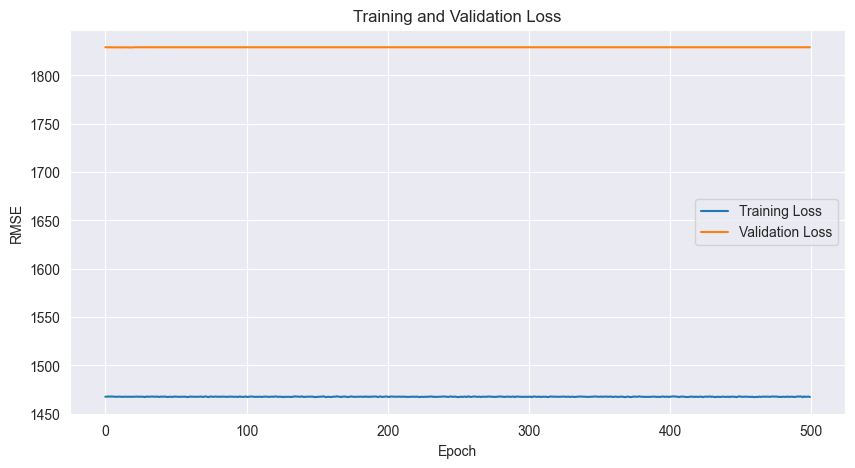

Final validation RMSE: 1828.7526
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.7834, Val RMSE: 1315.7283



  2%|▏         | 9/500 [00:00<00:06, 78.51it/s]

Epoch 10: Train RMSE: 1656.5851, Val RMSE: 1315.8434



  5%|▌         | 26/500 [00:00<00:05, 80.48it/s]

Epoch 20: Train RMSE: 1656.7385, Val RMSE: 1315.6403



  7%|▋         | 36/500 [00:00<00:05, 85.77it/s]

Epoch 30: Train RMSE: 1656.7799, Val RMSE: 1315.5195



  9%|▉         | 47/500 [00:00<00:04, 92.84it/s]

Epoch 40: Train RMSE: 1656.7272, Val RMSE: 1315.7390
Epoch 50: Train RMSE: 1656.7853, Val RMSE: 1315.6890



 12%|█▏        | 59/500 [00:00<00:04, 100.10it/s]

Epoch 60: Train RMSE: 1656.7195, Val RMSE: 1315.6774



 17%|█▋        | 85/500 [00:00<00:03, 114.01it/s]

Epoch 70: Train RMSE: 1656.6509, Val RMSE: 1315.6691
Epoch 80: Train RMSE: 1656.7369, Val RMSE: 1315.6655
Epoch 90: Train RMSE: 1656.6317, Val RMSE: 1315.6641



 22%|██▏       | 109/500 [00:01<00:03, 112.24it/s]

Epoch 100: Train RMSE: 1656.6625, Val RMSE: 1315.6647
Epoch 110: Train RMSE: 1656.7816, Val RMSE: 1315.6653



 24%|██▍       | 122/500 [00:01<00:03, 116.66it/s]

Epoch 120: Train RMSE: 1656.7483, Val RMSE: 1315.6653



 27%|██▋       | 135/500 [00:01<00:03, 119.59it/s]

Epoch 130: Train RMSE: 1656.7947, Val RMSE: 1315.6653
Epoch 140: Train RMSE: 1656.7333, Val RMSE: 1315.6653



 30%|██▉       | 149/500 [00:01<00:02, 123.21it/s]

Epoch 150: Train RMSE: 1656.6412, Val RMSE: 1315.6653



 32%|███▏      | 162/500 [00:01<00:02, 121.15it/s]

Epoch 160: Train RMSE: 1656.7222, Val RMSE: 1315.6653
Epoch 170: Train RMSE: 1656.7960, Val RMSE: 1315.6653



 35%|███▌      | 175/500 [00:01<00:02, 116.53it/s]

Epoch 180: Train RMSE: 1656.6355, Val RMSE: 1315.6653



 40%|████      | 202/500 [00:01<00:02, 123.07it/s]

Epoch 190: Train RMSE: 1656.6951, Val RMSE: 1315.6653
Epoch 200: Train RMSE: 1656.6755, Val RMSE: 1315.6653



 43%|████▎     | 216/500 [00:01<00:02, 127.46it/s]

Epoch 210: Train RMSE: 1656.8405, Val RMSE: 1315.6653



 46%|████▌     | 229/500 [00:02<00:02, 127.78it/s]

Epoch 220: Train RMSE: 1656.8253, Val RMSE: 1315.6653
Epoch 230: Train RMSE: 1656.7620, Val RMSE: 1315.6653



 48%|████▊     | 242/500 [00:02<00:02, 120.92it/s]

Epoch 240: Train RMSE: 1656.6752, Val RMSE: 1315.6653



 51%|█████     | 255/500 [00:02<00:02, 119.68it/s]

Epoch 250: Train RMSE: 1656.8527, Val RMSE: 1315.6653
Epoch 260: Train RMSE: 1656.7278, Val RMSE: 1315.6653



 54%|█████▎    | 268/500 [00:02<00:01, 119.57it/s]

Epoch 270: Train RMSE: 1656.6343, Val RMSE: 1315.6653



 59%|█████▉    | 296/500 [00:02<00:01, 127.41it/s]

Epoch 280: Train RMSE: 1656.6884, Val RMSE: 1315.6653
Epoch 290: Train RMSE: 1656.7651, Val RMSE: 1315.6653
Epoch 300: Train RMSE: 1656.6445, Val RMSE: 1315.6653



 64%|██████▍   | 322/500 [00:02<00:01, 120.92it/s]

Epoch 310: Train RMSE: 1656.7045, Val RMSE: 1315.6653
Epoch 320: Train RMSE: 1656.7964, Val RMSE: 1315.6653



 67%|██████▋   | 336/500 [00:02<00:01, 124.94it/s]

Epoch 330: Train RMSE: 1656.6801, Val RMSE: 1315.6653



 70%|███████   | 350/500 [00:03<00:01, 128.68it/s]

Epoch 340: Train RMSE: 1656.6719, Val RMSE: 1315.6653
Epoch 350: Train RMSE: 1656.6899, Val RMSE: 1315.6653



 73%|███████▎  | 364/500 [00:03<00:01, 129.91it/s]

Epoch 360: Train RMSE: 1656.8666, Val RMSE: 1315.6653



 76%|███████▌  | 378/500 [00:03<00:00, 123.98it/s]

Epoch 370: Train RMSE: 1656.7839, Val RMSE: 1315.6653
Epoch 380: Train RMSE: 1656.6624, Val RMSE: 1315.6653



 78%|███████▊  | 391/500 [00:03<00:00, 120.26it/s]

Epoch 390: Train RMSE: 1656.8628, Val RMSE: 1315.6653



 81%|████████  | 404/500 [00:03<00:00, 121.98it/s]

Epoch 400: Train RMSE: 1656.7540, Val RMSE: 1315.6653
Epoch 410: Train RMSE: 1656.7563, Val RMSE: 1315.6653



 83%|████████▎ | 417/500 [00:03<00:00, 119.41it/s]

Epoch 420: Train RMSE: 1656.7684, Val RMSE: 1315.6653



 88%|████████▊ | 442/500 [00:03<00:00, 119.47it/s]

Epoch 430: Train RMSE: 1656.6675, Val RMSE: 1315.6653
Epoch 440: Train RMSE: 1656.5966, Val RMSE: 1315.6653



 91%|█████████ | 454/500 [00:03<00:00, 115.80it/s]

Epoch 450: Train RMSE: 1656.5415, Val RMSE: 1315.6653



 93%|█████████▎| 467/500 [00:03<00:00, 117.88it/s]

Epoch 460: Train RMSE: 1656.6350, Val RMSE: 1315.6653
Epoch 470: Train RMSE: 1656.8279, Val RMSE: 1315.6653



 96%|█████████▌| 480/500 [00:04<00:00, 119.53it/s]

Epoch 480: Train RMSE: 1656.8250, Val RMSE: 1315.6653



100%|██████████| 500/500 [00:04<00:00, 117.10it/s]


Epoch 490: Train RMSE: 1656.7721, Val RMSE: 1315.6653


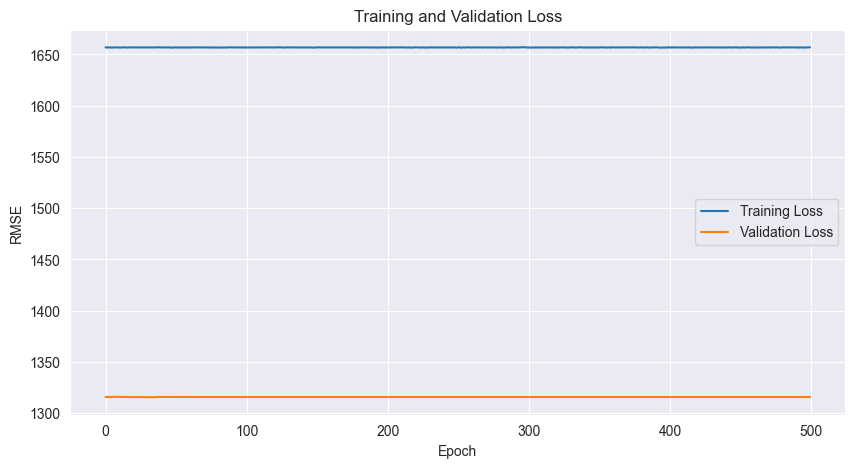

Final validation RMSE: 1315.4905
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1552.1207, Val RMSE: 2262.6514



  1%|▏         | 7/500 [00:00<00:07, 61.77it/s]

Epoch 10: Train RMSE: 1551.9740, Val RMSE: 2262.2664



  5%|▌         | 25/500 [00:00<00:05, 80.18it/s]

Epoch 20: Train RMSE: 1551.8860, Val RMSE: 2262.1055



  7%|▋         | 37/500 [00:00<00:04, 94.24it/s]

Epoch 30: Train RMSE: 1551.9364, Val RMSE: 2262.0894
Epoch 40: Train RMSE: 1552.0820, Val RMSE: 2262.0969



 10%|▉         | 48/500 [00:00<00:04, 96.84it/s]

Epoch 50: Train RMSE: 1551.9606, Val RMSE: 2262.1067



 14%|█▍        | 69/500 [00:00<00:04, 99.14it/s]

Epoch 60: Train RMSE: 1552.0588, Val RMSE: 2262.1411
Epoch 70: Train RMSE: 1552.0474, Val RMSE: 2262.1321



 16%|█▌        | 81/500 [00:00<00:04, 104.36it/s]

Epoch 80: Train RMSE: 1551.8765, Val RMSE: 2262.0952



 18%|█▊        | 92/500 [00:00<00:04, 96.43it/s] 

Epoch 90: Train RMSE: 1551.8367, Val RMSE: 2262.1304



 20%|██        | 102/500 [00:01<00:04, 90.26it/s]

Epoch 100: Train RMSE: 1551.9415, Val RMSE: 2262.1331



 22%|██▏       | 112/500 [00:01<00:04, 89.99it/s]

Epoch 110: Train RMSE: 1552.0205, Val RMSE: 2262.1284



 24%|██▍       | 122/500 [00:01<00:04, 91.09it/s]

Epoch 120: Train RMSE: 1552.1019, Val RMSE: 2262.1262



 27%|██▋       | 133/500 [00:01<00:03, 95.70it/s]

Epoch 130: Train RMSE: 1552.0187, Val RMSE: 2262.1262
Epoch 140: Train RMSE: 1552.1292, Val RMSE: 2262.1262



 29%|██▉       | 144/500 [00:01<00:03, 97.51it/s]

Epoch 150: Train RMSE: 1551.9652, Val RMSE: 2262.1262



 33%|███▎      | 165/500 [00:01<00:03, 97.17it/s]

Epoch 160: Train RMSE: 1551.9327, Val RMSE: 2262.1262



 35%|███▌      | 176/500 [00:01<00:03, 99.98it/s]

Epoch 170: Train RMSE: 1551.9303, Val RMSE: 2262.1262



 37%|███▋      | 187/500 [00:01<00:03, 100.81it/s]

Epoch 180: Train RMSE: 1552.0533, Val RMSE: 2262.1262
Epoch 190: Train RMSE: 1552.0681, Val RMSE: 2262.1262



 40%|███▉      | 198/500 [00:02<00:02, 100.97it/s]

Epoch 200: Train RMSE: 1552.1071, Val RMSE: 2262.1262



 44%|████▍     | 220/500 [00:02<00:02, 99.33it/s] 

Epoch 210: Train RMSE: 1551.9731, Val RMSE: 2262.1262
Epoch 220: Train RMSE: 1551.9471, Val RMSE: 2262.1262



 46%|████▌     | 231/500 [00:02<00:02, 99.58it/s]


Epoch 230: Train RMSE: 1551.9031, Val RMSE: 2262.1262
Epoch 240: Train RMSE: 1552.0389, Val RMSE: 2262.1262


 49%|████▉     | 244/500 [00:02<00:02, 106.38it/s]

Epoch 250: Train RMSE: 1551.7401, Val RMSE: 2262.1262



 53%|█████▎    | 267/500 [00:02<00:02, 107.43it/s]

Epoch 260: Train RMSE: 1551.9205, Val RMSE: 2262.1262
Epoch 270: Train RMSE: 1551.9193, Val RMSE: 2262.1262



 58%|█████▊    | 291/500 [00:03<00:02, 93.84it/s]

Epoch 280: Train RMSE: 1551.9218, Val RMSE: 2262.1262
Epoch 290: Train RMSE: 1552.0046, Val RMSE: 2262.1262



 61%|██████    | 303/500 [00:03<00:01, 99.58it/s]

Epoch 300: Train RMSE: 1551.9502, Val RMSE: 2262.1262



 63%|██████▎   | 315/500 [00:03<00:01, 103.44it/s]

Epoch 310: Train RMSE: 1551.8782, Val RMSE: 2262.1262
Epoch 320: Train RMSE: 1551.9382, Val RMSE: 2262.1262



 65%|██████▌   | 327/500 [00:03<00:01, 105.29it/s]

Epoch 330: Train RMSE: 1552.0464, Val RMSE: 2262.1262



 70%|██████▉   | 349/500 [00:03<00:01, 103.50it/s]

Epoch 340: Train RMSE: 1551.9286, Val RMSE: 2262.1262
Epoch 350: Train RMSE: 1551.9968, Val RMSE: 2262.1262



 72%|███████▏  | 361/500 [00:03<00:01, 107.65it/s]

Epoch 360: Train RMSE: 1551.8643, Val RMSE: 2262.1262



 74%|███████▍  | 372/500 [00:03<00:01, 107.65it/s]

Epoch 370: Train RMSE: 1551.9824, Val RMSE: 2262.1262
Epoch 380: Train RMSE: 1552.0276, Val RMSE: 2262.1262



 77%|███████▋  | 384/500 [00:03<00:01, 107.91it/s]

Epoch 390: Train RMSE: 1552.1661, Val RMSE: 2262.1262



 81%|████████  | 406/500 [00:04<00:00, 103.15it/s]

Epoch 400: Train RMSE: 1552.0068, Val RMSE: 2262.1265
Epoch 410: Train RMSE: 1552.0110, Val RMSE: 2262.1265



 83%|████████▎ | 417/500 [00:04<00:00, 103.45it/s]

Epoch 420: Train RMSE: 1552.0027, Val RMSE: 2262.1265



 88%|████████▊ | 439/500 [00:04<00:00, 100.28it/s]

Epoch 430: Train RMSE: 1552.2336, Val RMSE: 2262.1265



 90%|█████████ | 450/500 [00:04<00:00, 99.63it/s] 

Epoch 440: Train RMSE: 1551.9976, Val RMSE: 2262.1265
Epoch 450: Train RMSE: 1552.0098, Val RMSE: 2262.1265



 92%|█████████▏| 460/500 [00:04<00:00, 93.92it/s]

Epoch 460: Train RMSE: 1551.8635, Val RMSE: 2262.1265



 94%|█████████▍| 470/500 [00:04<00:00, 93.09it/s]

Epoch 470: Train RMSE: 1551.9802, Val RMSE: 2262.1265



 96%|█████████▌| 481/500 [00:04<00:00, 96.30it/s]

Epoch 480: Train RMSE: 1552.0565, Val RMSE: 2262.1265
Epoch 490: Train RMSE: 1551.9884, Val RMSE: 2262.1262



100%|██████████| 500/500 [00:05<00:00, 98.25it/s]


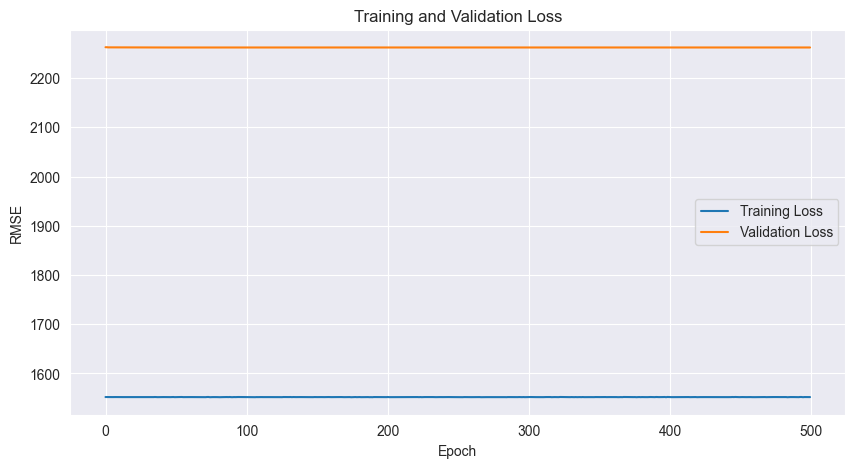

Final validation RMSE: 2262.0540
  Fold 4/5
Input size: 437



  2%|▏         | 8/500 [00:00<00:06, 78.70it/s]

Epoch 0: Train RMSE: 1755.8811, Val RMSE: 2261.7576
Epoch 10: Train RMSE: 1755.8773, Val RMSE: 2261.8396



  8%|▊         | 38/500 [00:00<00:04, 93.61it/s]

Epoch 20: Train RMSE: 1755.7247, Val RMSE: 2261.8584
Epoch 30: Train RMSE: 1755.7222, Val RMSE: 2261.8640



 12%|█▏        | 58/500 [00:00<00:04, 90.13it/s]

Epoch 40: Train RMSE: 1755.7029, Val RMSE: 2261.8679
Epoch 50: Train RMSE: 1755.6228, Val RMSE: 2261.8708



 16%|█▌        | 78/500 [00:00<00:04, 93.58it/s]

Epoch 60: Train RMSE: 1755.6229, Val RMSE: 2261.8726
Epoch 70: Train RMSE: 1755.7220, Val RMSE: 2261.8733



 20%|█▉        | 98/500 [00:01<00:04, 91.69it/s]

Epoch 80: Train RMSE: 1755.6949, Val RMSE: 2261.8738
Epoch 90: Train RMSE: 1755.7540, Val RMSE: 2261.8738



 24%|██▎       | 118/500 [00:01<00:04, 93.80it/s]

Epoch 100: Train RMSE: 1755.7046, Val RMSE: 2261.8740
Epoch 110: Train RMSE: 1755.6809, Val RMSE: 2261.8740



 28%|██▊       | 138/500 [00:01<00:03, 91.65it/s]

Epoch 120: Train RMSE: 1755.7468, Val RMSE: 2261.8740
Epoch 130: Train RMSE: 1755.7205, Val RMSE: 2261.8740



 30%|██▉       | 148/500 [00:01<00:04, 87.90it/s]


Epoch 140: Train RMSE: 1755.6735, Val RMSE: 2261.8740
Epoch 150: Train RMSE: 1755.7380, Val RMSE: 2261.8740


 36%|███▌      | 178/500 [00:01<00:03, 94.17it/s]

Epoch 160: Train RMSE: 1755.7063, Val RMSE: 2261.8740
Epoch 170: Train RMSE: 1755.6689, Val RMSE: 2261.8740
Epoch 180: Train RMSE: 1755.6305, Val RMSE: 2261.8740



 42%|████▏     | 208/500 [00:02<00:03, 93.09it/s]

Epoch 190: Train RMSE: 1755.8677, Val RMSE: 2261.8740
Epoch 200: Train RMSE: 1755.6749, Val RMSE: 2261.8740



 46%|████▌     | 228/500 [00:02<00:02, 92.29it/s]

Epoch 210: Train RMSE: 1755.7379, Val RMSE: 2261.8740
Epoch 220: Train RMSE: 1755.6635, Val RMSE: 2261.8740



 50%|████▉     | 248/500 [00:02<00:02, 88.68it/s]

Epoch 230: Train RMSE: 1755.7133, Val RMSE: 2261.8740
Epoch 240: Train RMSE: 1755.6562, Val RMSE: 2261.8740



 53%|█████▎    | 266/500 [00:02<00:02, 86.54it/s]

Epoch 250: Train RMSE: 1755.6691, Val RMSE: 2261.8740
Epoch 260: Train RMSE: 1755.7362, Val RMSE: 2261.8740



 55%|█████▌    | 276/500 [00:03<00:02, 87.53it/s]

Epoch 270: Train RMSE: 1755.6382, Val RMSE: 2261.8740



 59%|█████▉    | 295/500 [00:03<00:02, 75.99it/s]

Epoch 280: Train RMSE: 1755.7583, Val RMSE: 2261.8740
Epoch 290: Train RMSE: 1755.6711, Val RMSE: 2261.8740



 63%|██████▎   | 316/500 [00:03<00:02, 87.78it/s]

Epoch 300: Train RMSE: 1755.6812, Val RMSE: 2261.8740
Epoch 310: Train RMSE: 1755.7335, Val RMSE: 2261.8740



 67%|██████▋   | 336/500 [00:03<00:01, 87.11it/s]

Epoch 320: Train RMSE: 1755.7369, Val RMSE: 2261.8740
Epoch 330: Train RMSE: 1755.6989, Val RMSE: 2261.8740



 71%|███████   | 354/500 [00:03<00:01, 86.86it/s]

Epoch 340: Train RMSE: 1755.6215, Val RMSE: 2261.8740
Epoch 350: Train RMSE: 1755.6715, Val RMSE: 2261.8740



 74%|███████▍  | 372/500 [00:04<00:01, 87.07it/s]

Epoch 360: Train RMSE: 1755.7515, Val RMSE: 2261.8740
Epoch 370: Train RMSE: 1755.5824, Val RMSE: 2261.8740



 78%|███████▊  | 391/500 [00:04<00:01, 88.24it/s]

Epoch 380: Train RMSE: 1755.7747, Val RMSE: 2261.8740
Epoch 390: Train RMSE: 1755.6641, Val RMSE: 2261.8740



 82%|████████▏ | 411/500 [00:04<00:00, 92.66it/s]

Epoch 400: Train RMSE: 1755.7478, Val RMSE: 2261.8740
Epoch 410: Train RMSE: 1755.7148, Val RMSE: 2261.8740



 86%|████████▌ | 431/500 [00:04<00:00, 89.73it/s]

Epoch 420: Train RMSE: 1755.7428, Val RMSE: 2261.8740
Epoch 430: Train RMSE: 1755.7865, Val RMSE: 2261.8740



 92%|█████████▏| 459/500 [00:05<00:00, 90.59it/s]

Epoch 440: Train RMSE: 1755.7018, Val RMSE: 2261.8740
Epoch 450: Train RMSE: 1755.6635, Val RMSE: 2261.8740



 96%|█████████▌| 480/500 [00:05<00:00, 94.24it/s]

Epoch 460: Train RMSE: 1755.7207, Val RMSE: 2261.8740
Epoch 470: Train RMSE: 1755.7106, Val RMSE: 2261.8740



 98%|█████████▊| 490/500 [00:05<00:00, 91.86it/s]

Epoch 480: Train RMSE: 1755.8298, Val RMSE: 2261.8740
Epoch 490: Train RMSE: 1755.7126, Val RMSE: 2261.8740



100%|██████████| 500/500 [00:05<00:00, 89.25it/s]


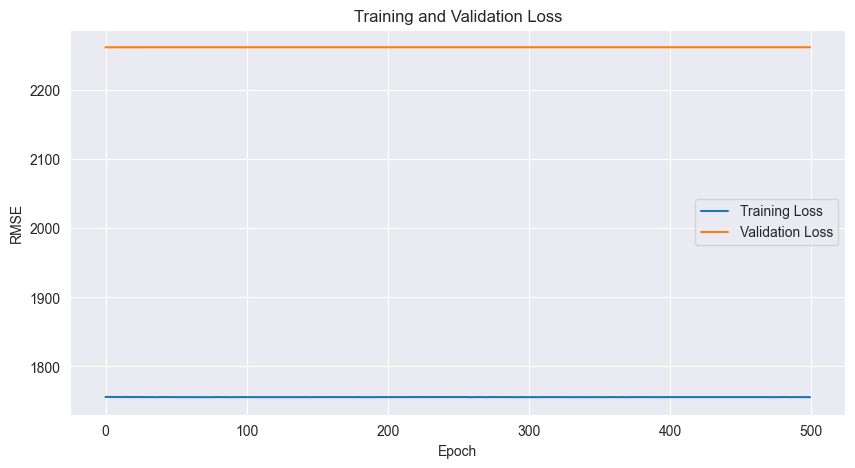

Final validation RMSE: 2261.7576
  Fold 5/5
Input size: 437



  1%|          | 6/500 [00:00<00:08, 55.36it/s]

Epoch 0: Train RMSE: 1867.7659, Val RMSE: 2493.1606
Epoch 10: Train RMSE: 1867.7913, Val RMSE: 2493.2773



  6%|▌         | 31/500 [00:00<00:06, 72.55it/s]

Epoch 20: Train RMSE: 1867.7085, Val RMSE: 2493.2205
Epoch 30: Train RMSE: 1867.6788, Val RMSE: 2493.2854



 11%|█         | 55/500 [00:00<00:06, 73.60it/s]

Epoch 40: Train RMSE: 1867.6339, Val RMSE: 2493.3577
Epoch 50: Train RMSE: 1867.6611, Val RMSE: 2493.3623



 14%|█▍        | 72/500 [00:00<00:05, 78.99it/s]

Epoch 60: Train RMSE: 1867.7324, Val RMSE: 2493.3718
Epoch 70: Train RMSE: 1867.7001, Val RMSE: 2493.3767



 18%|█▊        | 89/500 [00:01<00:06, 66.45it/s]

Epoch 80: Train RMSE: 1867.7111, Val RMSE: 2493.3787
Epoch 90: Train RMSE: 1867.6310, Val RMSE: 2493.3796



 23%|██▎       | 113/500 [00:01<00:05, 73.42it/s]

Epoch 100: Train RMSE: 1867.7623, Val RMSE: 2493.3801
Epoch 110: Train RMSE: 1867.6396, Val RMSE: 2493.3804



 26%|██▌       | 129/500 [00:01<00:04, 75.71it/s]

Epoch 120: Train RMSE: 1867.6945, Val RMSE: 2493.3804
Epoch 130: Train RMSE: 1867.6371, Val RMSE: 2493.3801



 31%|███       | 154/500 [00:02<00:04, 77.28it/s]

Epoch 140: Train RMSE: 1867.6497, Val RMSE: 2493.3804
Epoch 150: Train RMSE: 1867.6443, Val RMSE: 2493.3804



 34%|███▍      | 170/500 [00:02<00:04, 76.73it/s]

Epoch 160: Train RMSE: 1867.6749, Val RMSE: 2493.3804
Epoch 170: Train RMSE: 1867.6130, Val RMSE: 2493.3804



 39%|███▉      | 194/500 [00:02<00:03, 77.71it/s]

Epoch 180: Train RMSE: 1867.7129, Val RMSE: 2493.3804
Epoch 190: Train RMSE: 1867.6672, Val RMSE: 2493.3804



 42%|████▏     | 210/500 [00:02<00:03, 77.29it/s]

Epoch 200: Train RMSE: 1867.5756, Val RMSE: 2493.3804
Epoch 210: Train RMSE: 1867.7076, Val RMSE: 2493.3804



 47%|████▋     | 234/500 [00:03<00:03, 73.57it/s]

Epoch 220: Train RMSE: 1867.6350, Val RMSE: 2493.3804
Epoch 230: Train RMSE: 1867.6844, Val RMSE: 2493.3804



 50%|█████     | 250/500 [00:03<00:03, 72.06it/s]

Epoch 240: Train RMSE: 1867.7133, Val RMSE: 2493.3804
Epoch 250: Train RMSE: 1867.6123, Val RMSE: 2493.3804



 55%|█████▌    | 275/500 [00:03<00:03, 74.62it/s]

Epoch 260: Train RMSE: 1867.6528, Val RMSE: 2493.3804
Epoch 270: Train RMSE: 1867.6827, Val RMSE: 2493.3804



 57%|█████▋    | 283/500 [00:03<00:03, 60.32it/s]

Epoch 280: Train RMSE: 1867.6385, Val RMSE: 2493.3804



 60%|██████    | 300/500 [00:04<00:02, 68.41it/s]

Epoch 290: Train RMSE: 1867.6234, Val RMSE: 2493.3804
Epoch 300: Train RMSE: 1867.7279, Val RMSE: 2493.3804



 65%|██████▍   | 324/500 [00:04<00:02, 74.08it/s]

Epoch 310: Train RMSE: 1867.6659, Val RMSE: 2493.3804
Epoch 320: Train RMSE: 1867.6547, Val RMSE: 2493.3804



 68%|██████▊   | 340/500 [00:04<00:02, 74.78it/s]

Epoch 330: Train RMSE: 1867.6699, Val RMSE: 2493.3804
Epoch 340: Train RMSE: 1867.7156, Val RMSE: 2493.3801



 73%|███████▎  | 364/500 [00:04<00:01, 75.57it/s]

Epoch 350: Train RMSE: 1867.6984, Val RMSE: 2493.3801
Epoch 360: Train RMSE: 1867.6976, Val RMSE: 2493.3801



 76%|███████▌  | 381/500 [00:05<00:01, 77.82it/s]

Epoch 370: Train RMSE: 1867.5927, Val RMSE: 2493.3801
Epoch 380: Train RMSE: 1867.6974, Val RMSE: 2493.3801



 81%|████████  | 406/500 [00:05<00:01, 76.29it/s]

Epoch 390: Train RMSE: 1867.7351, Val RMSE: 2493.3801
Epoch 400: Train RMSE: 1867.6350, Val RMSE: 2493.3801



 84%|████████▍ | 422/500 [00:05<00:01, 76.97it/s]

Epoch 410: Train RMSE: 1867.6788, Val RMSE: 2493.3801
Epoch 420: Train RMSE: 1867.6875, Val RMSE: 2493.3801



 88%|████████▊ | 439/500 [00:05<00:00, 77.98it/s]

Epoch 430: Train RMSE: 1867.6591, Val RMSE: 2493.3801
Epoch 440: Train RMSE: 1867.6313, Val RMSE: 2493.3801



 93%|█████████▎| 463/500 [00:06<00:00, 77.13it/s]

Epoch 450: Train RMSE: 1867.6082, Val RMSE: 2493.3801
Epoch 460: Train RMSE: 1867.6375, Val RMSE: 2493.3801



 96%|█████████▌| 480/500 [00:06<00:00, 76.68it/s]

Epoch 470: Train RMSE: 1867.6177, Val RMSE: 2493.3801
Epoch 480: Train RMSE: 1867.7380, Val RMSE: 2493.3801



 99%|█████████▉| 496/500 [00:06<00:00, 59.15it/s]

Epoch 490: Train RMSE: 1867.7194, Val RMSE: 2493.3801


100%|██████████| 500/500 [00:06<00:00, 72.97it/s]


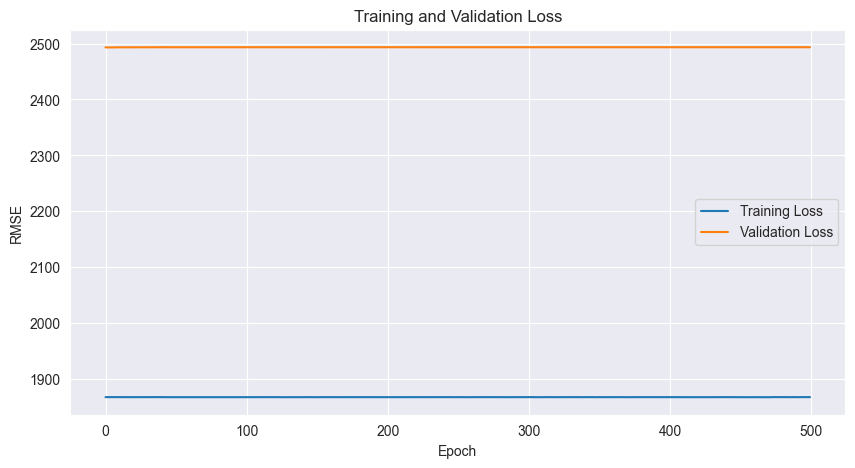

Final validation RMSE: 2493.0164
  Avg RMSE: 2032.2142 ± 417.8384

Testing: hidden_size=64, layers=10, lr=0.01
  Fold 1/5
Input size: 437



  3%|▎         | 13/500 [00:00<00:03, 129.83it/s]

Epoch 0: Train RMSE: 1467.6912, Val RMSE: 1828.9935
Epoch 10: Train RMSE: 1467.8645, Val RMSE: 1829.0135
Epoch 20: Train RMSE: 1468.1456, Val RMSE: 1829.0034



 11%|█         | 56/500 [00:00<00:03, 128.15it/s]

Epoch 30: Train RMSE: 1467.5681, Val RMSE: 1829.0098
Epoch 40: Train RMSE: 1467.8492, Val RMSE: 1829.0109
Epoch 50: Train RMSE: 1467.6875, Val RMSE: 1829.0111



 17%|█▋        | 84/500 [00:00<00:03, 130.04it/s]

Epoch 60: Train RMSE: 1467.4747, Val RMSE: 1829.0115
Epoch 70: Train RMSE: 1467.7512, Val RMSE: 1829.0116
Epoch 80: Train RMSE: 1467.8595, Val RMSE: 1829.0118



 22%|██▏       | 111/500 [00:00<00:03, 128.06it/s]

Epoch 90: Train RMSE: 1467.6989, Val RMSE: 1829.0117
Epoch 100: Train RMSE: 1467.8136, Val RMSE: 1829.0118
Epoch 110: Train RMSE: 1467.5769, Val RMSE: 1829.0118



 28%|██▊       | 139/500 [00:01<00:02, 131.41it/s]

Epoch 120: Train RMSE: 1467.8535, Val RMSE: 1829.0118
Epoch 130: Train RMSE: 1467.7078, Val RMSE: 1829.0118
Epoch 140: Train RMSE: 1467.6547, Val RMSE: 1829.0118



 33%|███▎      | 166/500 [00:01<00:02, 128.68it/s]

Epoch 150: Train RMSE: 1467.9121, Val RMSE: 1829.0118
Epoch 160: Train RMSE: 1467.6317, Val RMSE: 1829.0118
Epoch 170: Train RMSE: 1467.5184, Val RMSE: 1829.0118



 42%|████▏     | 208/500 [00:01<00:02, 132.25it/s]

Epoch 180: Train RMSE: 1467.7195, Val RMSE: 1829.0118
Epoch 190: Train RMSE: 1467.8560, Val RMSE: 1829.0118
Epoch 200: Train RMSE: 1467.6083, Val RMSE: 1829.0118



 47%|████▋     | 236/500 [00:01<00:02, 130.14it/s]

Epoch 210: Train RMSE: 1467.7303, Val RMSE: 1829.0118
Epoch 220: Train RMSE: 1467.6814, Val RMSE: 1829.0118
Epoch 230: Train RMSE: 1467.3925, Val RMSE: 1829.0118



 53%|█████▎    | 264/500 [00:02<00:01, 129.90it/s]

Epoch 240: Train RMSE: 1468.0046, Val RMSE: 1829.0118
Epoch 250: Train RMSE: 1467.7620, Val RMSE: 1829.0118
Epoch 260: Train RMSE: 1467.4471, Val RMSE: 1829.0118



 58%|█████▊    | 292/500 [00:02<00:01, 128.12it/s]

Epoch 270: Train RMSE: 1467.6194, Val RMSE: 1829.0118
Epoch 280: Train RMSE: 1467.6750, Val RMSE: 1829.0118
Epoch 290: Train RMSE: 1467.5974, Val RMSE: 1829.0118



 64%|██████▎   | 318/500 [00:02<00:01, 123.67it/s]

Epoch 300: Train RMSE: 1467.7864, Val RMSE: 1829.0118
Epoch 310: Train RMSE: 1467.5774, Val RMSE: 1829.0118
Epoch 320: Train RMSE: 1467.7032, Val RMSE: 1829.0118



 69%|██████▉   | 346/500 [00:02<00:01, 126.82it/s]

Epoch 330: Train RMSE: 1467.8693, Val RMSE: 1829.0118
Epoch 340: Train RMSE: 1467.8595, Val RMSE: 1829.0118
Epoch 350: Train RMSE: 1467.9404, Val RMSE: 1829.0118



 77%|███████▋  | 386/500 [00:02<00:00, 129.67it/s]

Epoch 360: Train RMSE: 1467.7780, Val RMSE: 1829.0118
Epoch 370: Train RMSE: 1467.7147, Val RMSE: 1829.0118
Epoch 380: Train RMSE: 1467.7222, Val RMSE: 1829.0118



 83%|████████▎ | 414/500 [00:03<00:00, 132.42it/s]

Epoch 390: Train RMSE: 1467.5645, Val RMSE: 1829.0118
Epoch 400: Train RMSE: 1467.3810, Val RMSE: 1829.0118
Epoch 410: Train RMSE: 1467.7571, Val RMSE: 1829.0118



 88%|████████▊ | 442/500 [00:03<00:00, 132.50it/s]

Epoch 420: Train RMSE: 1467.6201, Val RMSE: 1829.0118
Epoch 430: Train RMSE: 1467.7120, Val RMSE: 1829.0118
Epoch 440: Train RMSE: 1467.5326, Val RMSE: 1829.0118



 95%|█████████▍| 474/500 [00:03<00:00, 145.21it/s]

Epoch 450: Train RMSE: 1467.7448, Val RMSE: 1829.0118
Epoch 460: Train RMSE: 1467.5363, Val RMSE: 1829.0118
Epoch 470: Train RMSE: 1467.8207, Val RMSE: 1829.0118
Epoch 480: Train RMSE: 1467.6128, Val RMSE: 1829.0118



100%|██████████| 500/500 [00:03<00:00, 131.36it/s]


Epoch 490: Train RMSE: 1467.7434, Val RMSE: 1829.0118


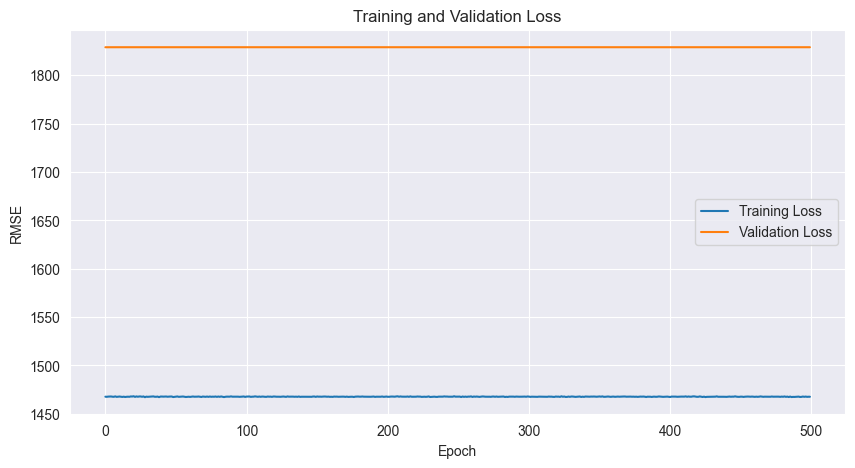

Final validation RMSE: 1828.9875
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.6598, Val RMSE: 1316.1202



  1%|▏         | 7/500 [00:00<00:07, 69.43it/s]

Epoch 10: Train RMSE: 1656.7096, Val RMSE: 1315.4972



  6%|▌         | 30/500 [00:00<00:04, 101.38it/s]

Epoch 20: Train RMSE: 1656.7544, Val RMSE: 1315.5768
Epoch 30: Train RMSE: 1656.7522, Val RMSE: 1315.6270



  9%|▊         | 43/500 [00:00<00:04, 110.36it/s]

Epoch 40: Train RMSE: 1656.7075, Val RMSE: 1315.6575



 11%|█         | 55/500 [00:00<00:03, 111.98it/s]

Epoch 50: Train RMSE: 1656.7065, Val RMSE: 1315.6741
Epoch 60: Train RMSE: 1656.8010, Val RMSE: 1315.6799



 13%|█▎        | 67/500 [00:00<00:03, 111.80it/s]

Epoch 70: Train RMSE: 1656.7192, Val RMSE: 1315.6820



 18%|█▊        | 91/500 [00:00<00:03, 111.60it/s]

Epoch 80: Train RMSE: 1656.6809, Val RMSE: 1315.6832
Epoch 90: Train RMSE: 1656.7496, Val RMSE: 1315.6840



 21%|██        | 105/500 [00:00<00:03, 118.90it/s]

Epoch 100: Train RMSE: 1656.6940, Val RMSE: 1315.6846



 24%|██▎       | 118/500 [00:01<00:03, 120.24it/s]

Epoch 110: Train RMSE: 1656.6176, Val RMSE: 1315.6847
Epoch 120: Train RMSE: 1656.6908, Val RMSE: 1315.6847



 26%|██▌       | 131/500 [00:01<00:03, 117.47it/s]

Epoch 130: Train RMSE: 1656.7900, Val RMSE: 1315.6847



 29%|██▊       | 143/500 [00:01<00:03, 115.96it/s]

Epoch 140: Train RMSE: 1656.7402, Val RMSE: 1315.6847
Epoch 150: Train RMSE: 1656.7386, Val RMSE: 1315.6847



 31%|███       | 155/500 [00:01<00:03, 113.26it/s]

Epoch 160: Train RMSE: 1656.7761, Val RMSE: 1315.6848



 36%|███▌      | 179/500 [00:01<00:02, 110.65it/s]

Epoch 170: Train RMSE: 1656.6770, Val RMSE: 1315.6848
Epoch 180: Train RMSE: 1656.6462, Val RMSE: 1315.6848



 38%|███▊      | 191/500 [00:01<00:02, 109.02it/s]

Epoch 190: Train RMSE: 1656.7583, Val RMSE: 1315.6848



 41%|████      | 204/500 [00:01<00:02, 111.93it/s]

Epoch 200: Train RMSE: 1656.8521, Val RMSE: 1315.6848
Epoch 210: Train RMSE: 1656.7224, Val RMSE: 1315.6848



 43%|████▎     | 216/500 [00:01<00:02, 109.54it/s]

Epoch 220: Train RMSE: 1656.7534, Val RMSE: 1315.6848



 48%|████▊     | 240/500 [00:02<00:02, 114.10it/s]

Epoch 230: Train RMSE: 1656.6187, Val RMSE: 1315.6848
Epoch 240: Train RMSE: 1656.7523, Val RMSE: 1315.6848



 51%|█████     | 255/500 [00:02<00:02, 121.87it/s]

Epoch 250: Train RMSE: 1656.7029, Val RMSE: 1315.6848



 54%|█████▎    | 268/500 [00:02<00:01, 120.29it/s]

Epoch 260: Train RMSE: 1656.7128, Val RMSE: 1315.6848
Epoch 270: Train RMSE: 1656.7041, Val RMSE: 1315.6848



 56%|█████▌    | 281/500 [00:02<00:01, 113.99it/s]

Epoch 280: Train RMSE: 1656.7645, Val RMSE: 1315.6848



 59%|█████▊    | 293/500 [00:02<00:01, 111.46it/s]

Epoch 290: Train RMSE: 1656.6881, Val RMSE: 1315.6848
Epoch 300: Train RMSE: 1656.5507, Val RMSE: 1315.6848



 61%|██████    | 306/500 [00:02<00:01, 115.04it/s]

Epoch 310: Train RMSE: 1656.7617, Val RMSE: 1315.6848



 66%|██████▌   | 330/500 [00:02<00:01, 114.29it/s]

Epoch 320: Train RMSE: 1656.8448, Val RMSE: 1315.6848
Epoch 330: Train RMSE: 1656.6925, Val RMSE: 1315.6848



 68%|██████▊   | 342/500 [00:03<00:01, 112.30it/s]

Epoch 340: Train RMSE: 1656.6335, Val RMSE: 1315.6848



 71%|███████   | 355/500 [00:03<00:01, 116.00it/s]

Epoch 350: Train RMSE: 1656.7656, Val RMSE: 1315.6848
Epoch 360: Train RMSE: 1656.6315, Val RMSE: 1315.6848



 73%|███████▎  | 367/500 [00:03<00:01, 114.66it/s]

Epoch 370: Train RMSE: 1656.7810, Val RMSE: 1315.6848



 78%|███████▊  | 392/500 [00:03<00:00, 118.39it/s]

Epoch 380: Train RMSE: 1656.6899, Val RMSE: 1315.6848
Epoch 390: Train RMSE: 1656.7069, Val RMSE: 1315.6848



 81%|████████  | 405/500 [00:03<00:00, 118.59it/s]

Epoch 400: Train RMSE: 1656.8152, Val RMSE: 1315.6848



 83%|████████▎ | 417/500 [00:03<00:00, 114.26it/s]

Epoch 410: Train RMSE: 1656.6422, Val RMSE: 1315.6848
Epoch 420: Train RMSE: 1656.7908, Val RMSE: 1315.6848



 86%|████████▌ | 429/500 [00:03<00:00, 111.97it/s]

Epoch 430: Train RMSE: 1656.8802, Val RMSE: 1315.6848



 91%|█████████ | 456/500 [00:04<00:00, 119.88it/s]

Epoch 440: Train RMSE: 1656.7756, Val RMSE: 1315.6848
Epoch 450: Train RMSE: 1656.8264, Val RMSE: 1315.6848
Epoch 460: Train RMSE: 1656.6407, Val RMSE: 1315.6848



 96%|█████████▌| 481/500 [00:04<00:00, 112.88it/s]

Epoch 470: Train RMSE: 1656.8042, Val RMSE: 1315.6848
Epoch 480: Train RMSE: 1656.6676, Val RMSE: 1315.6848



 99%|█████████▉| 496/500 [00:04<00:00, 121.32it/s]

Epoch 490: Train RMSE: 1656.7246, Val RMSE: 1315.6848


100%|██████████| 500/500 [00:04<00:00, 114.05it/s]


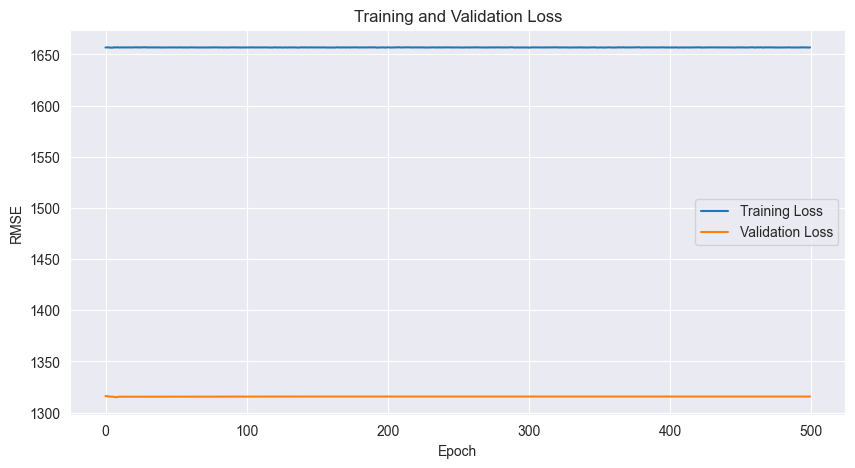

Final validation RMSE: 1315.0270
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1552.0221, Val RMSE: 2262.4919



  2%|▏         | 8/500 [00:00<00:06, 74.80it/s]

Epoch 10: Train RMSE: 1551.9014, Val RMSE: 2262.2747



  4%|▎         | 18/500 [00:00<00:05, 83.59it/s]

Epoch 20: Train RMSE: 1551.8414, Val RMSE: 2261.5244



  5%|▌         | 27/500 [00:00<00:06, 74.85it/s]

Epoch 30: Train RMSE: 1551.7458, Val RMSE: 2261.2651



  9%|▉         | 45/500 [00:00<00:05, 77.02it/s]

Epoch 40: Train RMSE: 1551.8008, Val RMSE: 2261.4858



 11%|█         | 53/500 [00:00<00:05, 74.92it/s]

Epoch 50: Train RMSE: 1552.0040, Val RMSE: 2261.0039



 12%|█▏        | 61/500 [00:00<00:06, 71.52it/s]

Epoch 60: Train RMSE: 1551.7629, Val RMSE: 2260.8862



 18%|█▊        | 89/500 [00:01<00:05, 72.35it/s]

Epoch 70: Train RMSE: 1551.8303, Val RMSE: 2260.8850
Epoch 80: Train RMSE: 1551.6366, Val RMSE: 2260.8599



 19%|█▉        | 97/500 [00:01<00:05, 71.90it/s]

Epoch 90: Train RMSE: 1551.7147, Val RMSE: 2260.8347
Epoch 100: Train RMSE: 1551.6467, Val RMSE: 2260.8247



 25%|██▍       | 124/500 [00:01<00:04, 78.90it/s]

Epoch 110: Train RMSE: 1551.7404, Val RMSE: 2260.8213
Epoch 120: Train RMSE: 1551.7296, Val RMSE: 2260.8203



 29%|██▉       | 145/500 [00:01<00:03, 89.31it/s]

Epoch 130: Train RMSE: 1551.9369, Val RMSE: 2260.8196
Epoch 140: Train RMSE: 1551.7067, Val RMSE: 2260.8193



 33%|███▎      | 165/500 [00:02<00:03, 90.79it/s]

Epoch 150: Train RMSE: 1551.8771, Val RMSE: 2260.8191
Epoch 160: Train RMSE: 1551.6035, Val RMSE: 2260.8191



 37%|███▋      | 187/500 [00:02<00:03, 98.47it/s]

Epoch 170: Train RMSE: 1551.9409, Val RMSE: 2260.8188
Epoch 180: Train RMSE: 1551.6306, Val RMSE: 2260.8188
Epoch 190: Train RMSE: 1551.9847, Val RMSE: 2260.8188



 42%|████▏     | 210/500 [00:02<00:02, 103.83it/s]


Epoch 200: Train RMSE: 1551.7396, Val RMSE: 2260.8188
Epoch 210: Train RMSE: 1551.7643, Val RMSE: 2260.8186
Epoch 220: Train RMSE: 1551.9672, Val RMSE: 2260.8186


 49%|████▉     | 245/500 [00:02<00:02, 107.26it/s]

Epoch 230: Train RMSE: 1552.0032, Val RMSE: 2260.8186
Epoch 240: Train RMSE: 1551.4890, Val RMSE: 2260.8186
Epoch 250: Train RMSE: 1551.9265, Val RMSE: 2260.8186



 54%|█████▍    | 271/500 [00:03<00:02, 113.91it/s]

Epoch 260: Train RMSE: 1551.5061, Val RMSE: 2260.8186
Epoch 270: Train RMSE: 1551.9775, Val RMSE: 2260.8186
Epoch 280: Train RMSE: 1551.8564, Val RMSE: 2260.8186



 61%|██████    | 306/500 [00:03<00:01, 108.26it/s]

Epoch 290: Train RMSE: 1551.7947, Val RMSE: 2260.8186
Epoch 300: Train RMSE: 1551.8070, Val RMSE: 2260.8186
Epoch 310: Train RMSE: 1551.8077, Val RMSE: 2260.8186



 68%|██████▊   | 341/500 [00:03<00:01, 106.31it/s]

Epoch 320: Train RMSE: 1552.0645, Val RMSE: 2260.8186
Epoch 330: Train RMSE: 1551.5752, Val RMSE: 2260.8186
Epoch 340: Train RMSE: 1551.7361, Val RMSE: 2260.8186



 73%|███████▎  | 364/500 [00:03<00:01, 106.37it/s]

Epoch 350: Train RMSE: 1552.0465, Val RMSE: 2260.8186
Epoch 360: Train RMSE: 1551.7129, Val RMSE: 2260.8186
Epoch 370: Train RMSE: 1551.9000, Val RMSE: 2260.8186



 80%|████████  | 401/500 [00:04<00:00, 112.81it/s]

Epoch 380: Train RMSE: 1552.0006, Val RMSE: 2260.8186
Epoch 390: Train RMSE: 1551.8597, Val RMSE: 2260.8186
Epoch 400: Train RMSE: 1551.5493, Val RMSE: 2260.8186



 85%|████████▍ | 424/500 [00:04<00:00, 105.44it/s]

Epoch 410: Train RMSE: 1551.7996, Val RMSE: 2260.8186
Epoch 420: Train RMSE: 1551.5995, Val RMSE: 2260.8186
Epoch 430: Train RMSE: 1551.8114, Val RMSE: 2260.8186



 91%|█████████ | 456/500 [00:04<00:00, 89.66it/s]

Epoch 440: Train RMSE: 1551.8003, Val RMSE: 2260.8186
Epoch 450: Train RMSE: 1551.6854, Val RMSE: 2260.8186
Epoch 460: Train RMSE: 1551.9655, Val RMSE: 2260.8186



 98%|█████████▊| 490/500 [00:05<00:00, 103.32it/s]

Epoch 470: Train RMSE: 1551.8556, Val RMSE: 2260.8186
Epoch 480: Train RMSE: 1551.8389, Val RMSE: 2260.8186
Epoch 490: Train RMSE: 1551.6838, Val RMSE: 2260.8186


100%|██████████| 500/500 [00:05<00:00, 92.99it/s] 


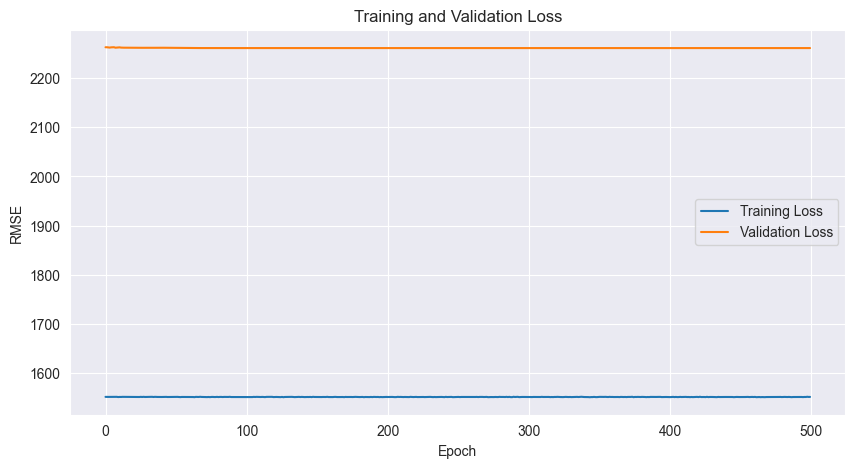

Final validation RMSE: 2260.8186
  Fold 4/5
Input size: 437



  2%|▏         | 9/500 [00:00<00:05, 82.87it/s]

Epoch 0: Train RMSE: 1755.8650, Val RMSE: 2261.7996
Epoch 10: Train RMSE: 1755.6593, Val RMSE: 2261.8767



  8%|▊         | 38/500 [00:00<00:04, 95.20it/s]

Epoch 20: Train RMSE: 1755.5164, Val RMSE: 2261.9109
Epoch 30: Train RMSE: 1755.4519, Val RMSE: 2261.9199
Epoch 40: Train RMSE: 1755.3802, Val RMSE: 2261.9358



 14%|█▍        | 69/500 [00:00<00:04, 95.36it/s]

Epoch 50: Train RMSE: 1755.5264, Val RMSE: 2261.9409
Epoch 60: Train RMSE: 1755.3352, Val RMSE: 2261.9419



 18%|█▊        | 90/500 [00:00<00:04, 95.53it/s]

Epoch 70: Train RMSE: 1755.3002, Val RMSE: 2261.9451
Epoch 80: Train RMSE: 1755.3109, Val RMSE: 2261.9460



 22%|██▏       | 110/500 [00:01<00:04, 94.69it/s]

Epoch 90: Train RMSE: 1755.4600, Val RMSE: 2261.9463
Epoch 100: Train RMSE: 1755.4415, Val RMSE: 2261.9463



 24%|██▍       | 120/500 [00:01<00:04, 93.90it/s]

Epoch 110: Train RMSE: 1755.4310, Val RMSE: 2261.9468
Epoch 120: Train RMSE: 1755.4210, Val RMSE: 2261.9468



 28%|██▊       | 140/500 [00:01<00:03, 91.27it/s]

Epoch 130: Train RMSE: 1755.3473, Val RMSE: 2261.9468
Epoch 140: Train RMSE: 1755.2480, Val RMSE: 2261.9468



 32%|███▏      | 161/500 [00:01<00:03, 94.73it/s]

Epoch 150: Train RMSE: 1755.4972, Val RMSE: 2261.9468
Epoch 160: Train RMSE: 1755.4170, Val RMSE: 2261.9468
Epoch 170: Train RMSE: 1755.2671, Val RMSE: 2261.9468



 39%|███▊      | 193/500 [00:02<00:03, 91.95it/s]

Epoch 180: Train RMSE: 1755.3134, Val RMSE: 2261.9468
Epoch 190: Train RMSE: 1755.4344, Val RMSE: 2261.9468



 43%|████▎     | 214/500 [00:02<00:03, 94.98it/s]

Epoch 200: Train RMSE: 1755.1670, Val RMSE: 2261.9468
Epoch 210: Train RMSE: 1755.4536, Val RMSE: 2261.9468
Epoch 220: Train RMSE: 1755.3771, Val RMSE: 2261.9468



 49%|████▉     | 245/500 [00:02<00:02, 91.81it/s]

Epoch 230: Train RMSE: 1755.2682, Val RMSE: 2261.9468
Epoch 240: Train RMSE: 1755.5492, Val RMSE: 2261.9468



 53%|█████▎    | 266/500 [00:02<00:02, 96.89it/s]

Epoch 250: Train RMSE: 1755.3922, Val RMSE: 2261.9468
Epoch 260: Train RMSE: 1755.3866, Val RMSE: 2261.9468
Epoch 270: Train RMSE: 1755.5724, Val RMSE: 2261.9468



 59%|█████▉    | 297/500 [00:03<00:02, 95.25it/s]

Epoch 280: Train RMSE: 1755.6460, Val RMSE: 2261.9468
Epoch 290: Train RMSE: 1755.2950, Val RMSE: 2261.9468



 64%|██████▎   | 318/500 [00:03<00:01, 96.42it/s]

Epoch 300: Train RMSE: 1755.2891, Val RMSE: 2261.9468
Epoch 310: Train RMSE: 1755.2808, Val RMSE: 2261.9468



 66%|██████▌   | 328/500 [00:03<00:02, 85.50it/s]

Epoch 320: Train RMSE: 1755.4236, Val RMSE: 2261.9468
Epoch 330: Train RMSE: 1755.5350, Val RMSE: 2261.9468



 71%|███████   | 356/500 [00:03<00:01, 83.01it/s]

Epoch 340: Train RMSE: 1755.4474, Val RMSE: 2261.9468
Epoch 350: Train RMSE: 1755.4487, Val RMSE: 2261.9468



 75%|███████▌  | 375/500 [00:04<00:01, 76.09it/s]

Epoch 360: Train RMSE: 1755.3704, Val RMSE: 2261.9468
Epoch 370: Train RMSE: 1755.3510, Val RMSE: 2261.9468



 79%|███████▉  | 394/500 [00:04<00:01, 82.28it/s]

Epoch 380: Train RMSE: 1755.4065, Val RMSE: 2261.9468
Epoch 390: Train RMSE: 1755.6348, Val RMSE: 2261.9468



 83%|████████▎ | 414/500 [00:04<00:00, 88.49it/s]

Epoch 400: Train RMSE: 1755.3829, Val RMSE: 2261.9468
Epoch 410: Train RMSE: 1755.3478, Val RMSE: 2261.9468
Epoch 420: Train RMSE: 1755.2543, Val RMSE: 2261.9468



 89%|████████▉ | 444/500 [00:04<00:00, 91.29it/s]

Epoch 430: Train RMSE: 1755.4498, Val RMSE: 2261.9468
Epoch 440: Train RMSE: 1755.4711, Val RMSE: 2261.9468



 93%|█████████▎| 465/500 [00:05<00:00, 93.84it/s]

Epoch 450: Train RMSE: 1755.4066, Val RMSE: 2261.9468
Epoch 460: Train RMSE: 1755.5685, Val RMSE: 2261.9468
Epoch 470: Train RMSE: 1755.4022, Val RMSE: 2261.9468



100%|██████████| 500/500 [00:05<00:00, 91.75it/s]

Epoch 480: Train RMSE: 1755.4465, Val RMSE: 2261.9468
Epoch 490: Train RMSE: 1755.3591, Val RMSE: 2261.9468


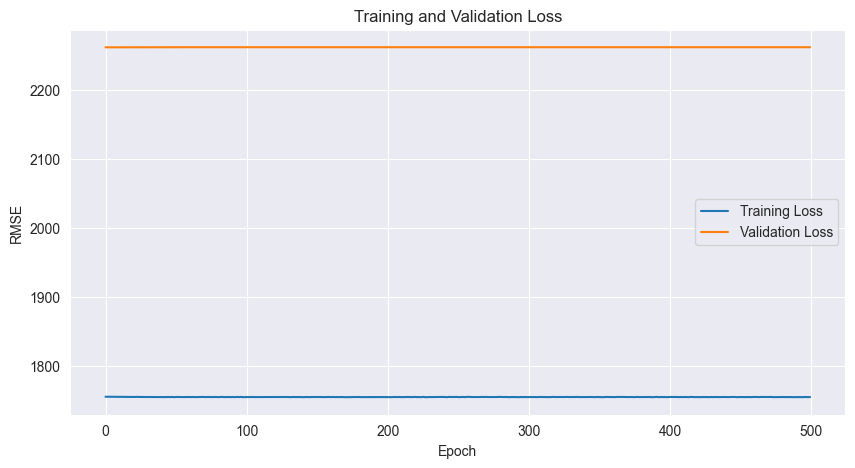

Final validation RMSE: 2261.7913
  Fold 5/5
Input size: 437



  2%|▏         | 8/500 [00:00<00:06, 76.06it/s]

Epoch 0: Train RMSE: 1867.8761, Val RMSE: 2493.0674
Epoch 10: Train RMSE: 1867.4857, Val RMSE: 2493.4199



  7%|▋         | 36/500 [00:00<00:05, 88.45it/s]

Epoch 20: Train RMSE: 1867.5614, Val RMSE: 2493.2898
Epoch 30: Train RMSE: 1867.3850, Val RMSE: 2493.3267



 11%|█         | 54/500 [00:00<00:05, 82.93it/s]

Epoch 40: Train RMSE: 1867.3523, Val RMSE: 2493.3521
Epoch 50: Train RMSE: 1867.3335, Val RMSE: 2493.4885



 15%|█▍        | 73/500 [00:00<00:04, 85.47it/s]

Epoch 60: Train RMSE: 1867.3712, Val RMSE: 2493.7322
Epoch 70: Train RMSE: 1867.2146, Val RMSE: 2493.7798



 18%|█▊        | 91/500 [00:01<00:04, 85.15it/s]

Epoch 80: Train RMSE: 1867.5397, Val RMSE: 2493.8250
Epoch 90: Train RMSE: 1867.6158, Val RMSE: 2493.8450



 24%|██▍       | 119/500 [00:01<00:04, 86.96it/s]

Epoch 100: Train RMSE: 1867.4237, Val RMSE: 2493.8525
Epoch 110: Train RMSE: 1867.1534, Val RMSE: 2493.8557



 26%|██▌       | 128/500 [00:01<00:05, 70.24it/s]

Epoch 120: Train RMSE: 1867.4242, Val RMSE: 2493.8572



 29%|██▉       | 144/500 [00:01<00:04, 72.90it/s]

Epoch 130: Train RMSE: 1867.4094, Val RMSE: 2493.8582
Epoch 140: Train RMSE: 1867.3065, Val RMSE: 2493.8586



 32%|███▏      | 161/500 [00:02<00:04, 75.98it/s]

Epoch 150: Train RMSE: 1867.0724, Val RMSE: 2493.8589
Epoch 160: Train RMSE: 1867.1951, Val RMSE: 2493.8589



 37%|███▋      | 186/500 [00:02<00:04, 78.05it/s]

Epoch 170: Train RMSE: 1867.2241, Val RMSE: 2493.8591
Epoch 180: Train RMSE: 1867.2557, Val RMSE: 2493.8591



 41%|████      | 204/500 [00:02<00:03, 81.48it/s]

Epoch 190: Train RMSE: 1867.5510, Val RMSE: 2493.8591
Epoch 200: Train RMSE: 1867.0763, Val RMSE: 2493.8591



 45%|████▍     | 223/500 [00:02<00:03, 85.03it/s]

Epoch 210: Train RMSE: 1867.5911, Val RMSE: 2493.8591
Epoch 220: Train RMSE: 1867.2246, Val RMSE: 2493.8591



 48%|████▊     | 241/500 [00:02<00:03, 83.14it/s]

Epoch 230: Train RMSE: 1867.4021, Val RMSE: 2493.8591
Epoch 240: Train RMSE: 1867.4772, Val RMSE: 2493.8591



 54%|█████▍    | 269/500 [00:03<00:02, 88.05it/s]

Epoch 250: Train RMSE: 1867.1466, Val RMSE: 2493.8591
Epoch 260: Train RMSE: 1867.4786, Val RMSE: 2493.8591



 57%|█████▋    | 287/500 [00:03<00:02, 84.42it/s]

Epoch 270: Train RMSE: 1867.2686, Val RMSE: 2493.8591
Epoch 280: Train RMSE: 1867.2852, Val RMSE: 2493.8591



 61%|██████    | 305/500 [00:03<00:02, 82.35it/s]

Epoch 290: Train RMSE: 1867.5054, Val RMSE: 2493.8591
Epoch 300: Train RMSE: 1867.2578, Val RMSE: 2493.8591



 65%|██████▍   | 323/500 [00:03<00:02, 84.29it/s]

Epoch 310: Train RMSE: 1867.2301, Val RMSE: 2493.8591
Epoch 320: Train RMSE: 1867.3840, Val RMSE: 2493.8594



 66%|██████▋   | 332/500 [00:04<00:02, 83.90it/s]

Epoch 330: Train RMSE: 1867.2584, Val RMSE: 2493.8594



 70%|███████   | 350/500 [00:04<00:02, 70.02it/s]

Epoch 340: Train RMSE: 1867.2386, Val RMSE: 2493.8594
Epoch 350: Train RMSE: 1867.6063, Val RMSE: 2493.8594



 74%|███████▍  | 369/500 [00:04<00:01, 80.11it/s]

Epoch 360: Train RMSE: 1867.3628, Val RMSE: 2493.8594
Epoch 370: Train RMSE: 1867.2250, Val RMSE: 2493.8594



 79%|███████▉  | 397/500 [00:04<00:01, 83.24it/s]

Epoch 380: Train RMSE: 1867.1857, Val RMSE: 2493.8594
Epoch 390: Train RMSE: 1867.3362, Val RMSE: 2493.8594



 83%|████████▎ | 416/500 [00:05<00:00, 86.10it/s]

Epoch 400: Train RMSE: 1867.2798, Val RMSE: 2493.8594
Epoch 410: Train RMSE: 1867.2544, Val RMSE: 2493.8594



 87%|████████▋ | 434/500 [00:05<00:00, 81.16it/s]

Epoch 420: Train RMSE: 1867.2949, Val RMSE: 2493.8594
Epoch 430: Train RMSE: 1867.4159, Val RMSE: 2493.8594



 90%|█████████ | 452/500 [00:05<00:00, 83.54it/s]

Epoch 440: Train RMSE: 1867.2411, Val RMSE: 2493.8594
Epoch 450: Train RMSE: 1867.4454, Val RMSE: 2493.8594



 94%|█████████▍| 471/500 [00:05<00:00, 83.81it/s]

Epoch 460: Train RMSE: 1867.4169, Val RMSE: 2493.8594
Epoch 470: Train RMSE: 1867.4651, Val RMSE: 2493.8594



100%|██████████| 500/500 [00:06<00:00, 81.57it/s]

Epoch 480: Train RMSE: 1867.1642, Val RMSE: 2493.8594
Epoch 490: Train RMSE: 1867.1678, Val RMSE: 2493.8594


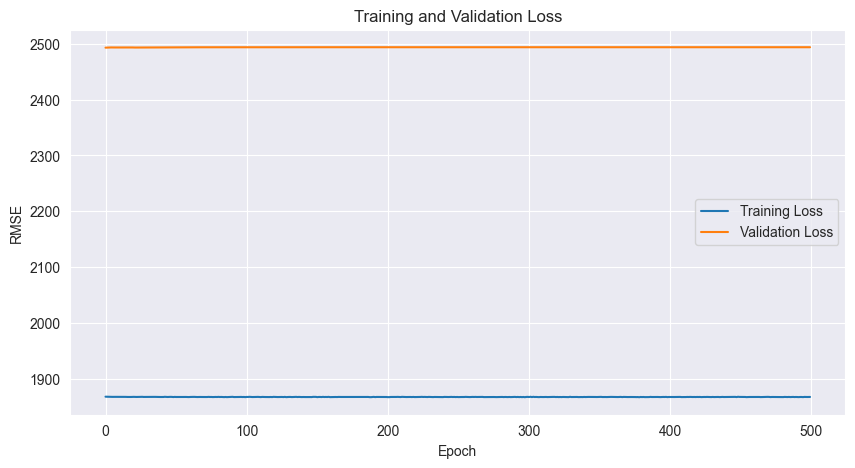

Final validation RMSE: 2493.0674
  Avg RMSE: 2031.9384 ± 417.8539

Testing: hidden_size=128, layers=2, lr=0.0001
  Fold 1/5
Input size: 437



  8%|▊         | 39/500 [00:00<00:01, 384.57it/s]

Epoch 0: Train RMSE: 1467.9824, Val RMSE: 1828.9055
Epoch 10: Train RMSE: 1467.8777, Val RMSE: 1828.9296
Epoch 20: Train RMSE: 1467.9062, Val RMSE: 1828.9429
Epoch 30: Train RMSE: 1467.8571, Val RMSE: 1828.9490
Epoch 40: Train RMSE: 1467.7968, Val RMSE: 1828.9507
Epoch 50: Train RMSE: 1467.8281, Val RMSE: 1828.9523
Epoch 60: Train RMSE: 1467.8064, Val RMSE: 1828.9530
Epoch 70: Train RMSE: 1467.8118, Val RMSE: 1828.9530



 16%|█▌        | 81/500 [00:00<00:01, 403.66it/s]

Epoch 80: Train RMSE: 1467.8181, Val RMSE: 1828.9534



 25%|██▍       | 124/500 [00:00<00:00, 412.17it/s]

Epoch 90: Train RMSE: 1467.7626, Val RMSE: 1828.9546
Epoch 100: Train RMSE: 1467.8135, Val RMSE: 1828.9551
Epoch 110: Train RMSE: 1467.7494, Val RMSE: 1828.9552
Epoch 120: Train RMSE: 1467.7938, Val RMSE: 1828.9551
Epoch 130: Train RMSE: 1467.8566, Val RMSE: 1828.9551
Epoch 140: Train RMSE: 1467.8529, Val RMSE: 1828.9551
Epoch 150: Train RMSE: 1467.7509, Val RMSE: 1828.9551
Epoch 160: Train RMSE: 1467.8403, Val RMSE: 1828.9551



 33%|███▎      | 166/500 [00:00<00:00, 411.61it/s]

Epoch 170: Train RMSE: 1467.8499, Val RMSE: 1828.9551



 50%|█████     | 250/500 [00:00<00:00, 409.63it/s]

Epoch 180: Train RMSE: 1467.8236, Val RMSE: 1828.9551
Epoch 190: Train RMSE: 1467.8584, Val RMSE: 1828.9551
Epoch 200: Train RMSE: 1467.7668, Val RMSE: 1828.9551
Epoch 210: Train RMSE: 1467.7847, Val RMSE: 1828.9551
Epoch 220: Train RMSE: 1467.8083, Val RMSE: 1828.9551
Epoch 230: Train RMSE: 1467.8795, Val RMSE: 1828.9551
Epoch 240: Train RMSE: 1467.8706, Val RMSE: 1828.9551
Epoch 250: Train RMSE: 1467.8275, Val RMSE: 1828.9551
Epoch 260: Train RMSE: 1467.8015, Val RMSE: 1828.9551



 67%|██████▋   | 335/500 [00:00<00:00, 414.90it/s]

Epoch 270: Train RMSE: 1467.7990, Val RMSE: 1828.9551
Epoch 280: Train RMSE: 1467.7850, Val RMSE: 1828.9548
Epoch 290: Train RMSE: 1467.8615, Val RMSE: 1828.9548
Epoch 300: Train RMSE: 1467.8737, Val RMSE: 1828.9548
Epoch 310: Train RMSE: 1467.7578, Val RMSE: 1828.9551
Epoch 320: Train RMSE: 1467.7318, Val RMSE: 1828.9548
Epoch 330: Train RMSE: 1467.7894, Val RMSE: 1828.9548
Epoch 340: Train RMSE: 1467.8467, Val RMSE: 1828.9548
Epoch 350: Train RMSE: 1467.8589, Val RMSE: 1828.9548



 84%|████████▎ | 418/500 [00:01<00:00, 399.97it/s]

Epoch 360: Train RMSE: 1467.8396, Val RMSE: 1828.9548
Epoch 370: Train RMSE: 1467.8346, Val RMSE: 1828.9548
Epoch 380: Train RMSE: 1467.8354, Val RMSE: 1828.9548
Epoch 390: Train RMSE: 1467.8589, Val RMSE: 1828.9548
Epoch 400: Train RMSE: 1467.7479, Val RMSE: 1828.9548
Epoch 410: Train RMSE: 1467.8427, Val RMSE: 1828.9551
Epoch 420: Train RMSE: 1467.7615, Val RMSE: 1828.9551
Epoch 430: Train RMSE: 1467.8196, Val RMSE: 1828.9551
Epoch 440: Train RMSE: 1467.8246, Val RMSE: 1828.9548



100%|██████████| 500/500 [00:01<00:00, 416.93it/s]


Epoch 450: Train RMSE: 1467.9330, Val RMSE: 1828.9548
Epoch 460: Train RMSE: 1467.8687, Val RMSE: 1828.9548
Epoch 470: Train RMSE: 1467.8630, Val RMSE: 1828.9548
Epoch 480: Train RMSE: 1467.8579, Val RMSE: 1828.9548
Epoch 490: Train RMSE: 1467.8439, Val RMSE: 1828.9548


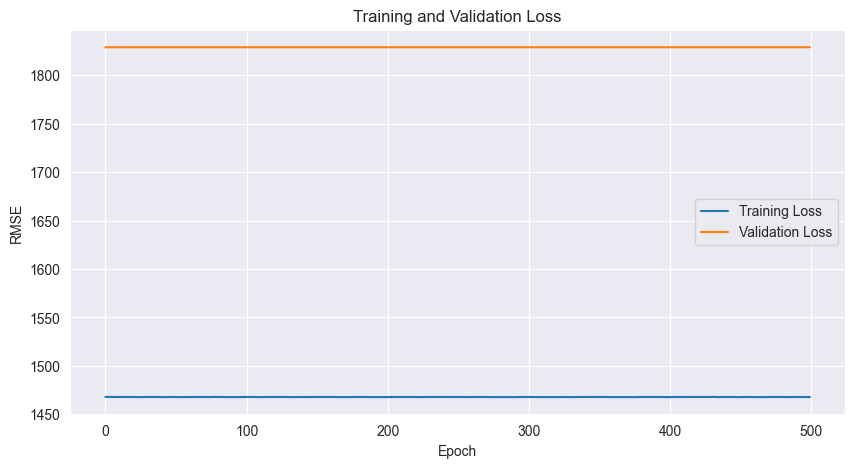

Final validation RMSE: 1828.9015
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.7592, Val RMSE: 1315.4005



  8%|▊         | 39/500 [00:00<00:01, 383.90it/s]

Epoch 10: Train RMSE: 1656.6967, Val RMSE: 1315.4744
Epoch 20: Train RMSE: 1656.6132, Val RMSE: 1315.4509
Epoch 30: Train RMSE: 1656.7396, Val RMSE: 1315.4939
Epoch 40: Train RMSE: 1656.6720, Val RMSE: 1315.6260
Epoch 50: Train RMSE: 1656.6094, Val RMSE: 1315.6495
Epoch 60: Train RMSE: 1656.6353, Val RMSE: 1315.6503
Epoch 70: Train RMSE: 1656.5804, Val RMSE: 1315.6519



 17%|█▋        | 83/500 [00:00<00:01, 414.33it/s]

Epoch 80: Train RMSE: 1656.5621, Val RMSE: 1315.6536
Epoch 90: Train RMSE: 1656.7552, Val RMSE: 1315.6536



 25%|██▌       | 125/500 [00:00<00:00, 383.13it/s]

Epoch 100: Train RMSE: 1656.7905, Val RMSE: 1315.6550
Epoch 110: Train RMSE: 1656.5596, Val RMSE: 1315.6597
Epoch 120: Train RMSE: 1656.6145, Val RMSE: 1315.6597
Epoch 130: Train RMSE: 1656.5851, Val RMSE: 1315.6576
Epoch 140: Train RMSE: 1656.8381, Val RMSE: 1315.6571
Epoch 150: Train RMSE: 1656.6813, Val RMSE: 1315.6573
Epoch 160: Train RMSE: 1656.6346, Val RMSE: 1315.6577



 33%|███▎      | 164/500 [00:00<00:00, 375.65it/s]

Epoch 170: Train RMSE: 1656.5986, Val RMSE: 1315.6581



 40%|████      | 202/500 [00:00<00:00, 367.92it/s]

Epoch 180: Train RMSE: 1656.5732, Val RMSE: 1315.6581
Epoch 190: Train RMSE: 1656.6891, Val RMSE: 1315.6582
Epoch 200: Train RMSE: 1656.5942, Val RMSE: 1315.6584
Epoch 210: Train RMSE: 1656.8132, Val RMSE: 1315.6587
Epoch 220: Train RMSE: 1656.6105, Val RMSE: 1315.6586
Epoch 230: Train RMSE: 1656.7034, Val RMSE: 1315.6587



 48%|████▊     | 239/500 [00:00<00:00, 366.38it/s]

Epoch 240: Train RMSE: 1656.6863, Val RMSE: 1315.6588
Epoch 250: Train RMSE: 1656.5416, Val RMSE: 1315.6588



 63%|██████▎   | 316/500 [00:00<00:00, 371.51it/s]

Epoch 260: Train RMSE: 1656.7527, Val RMSE: 1315.6587
Epoch 270: Train RMSE: 1656.7576, Val RMSE: 1315.6587
Epoch 280: Train RMSE: 1656.7892, Val RMSE: 1315.6586
Epoch 290: Train RMSE: 1656.5262, Val RMSE: 1315.6586
Epoch 300: Train RMSE: 1656.6832, Val RMSE: 1315.6584
Epoch 310: Train RMSE: 1656.5708, Val RMSE: 1315.6584
Epoch 320: Train RMSE: 1656.7615, Val RMSE: 1315.6584
Epoch 330: Train RMSE: 1656.7615, Val RMSE: 1315.6581



 78%|███████▊  | 392/500 [00:01<00:00, 375.42it/s]

Epoch 340: Train RMSE: 1656.6062, Val RMSE: 1315.6578
Epoch 350: Train RMSE: 1656.6046, Val RMSE: 1315.6577
Epoch 360: Train RMSE: 1656.5605, Val RMSE: 1315.6577
Epoch 370: Train RMSE: 1656.4872, Val RMSE: 1315.6576
Epoch 380: Train RMSE: 1656.6473, Val RMSE: 1315.6575
Epoch 390: Train RMSE: 1656.6770, Val RMSE: 1315.6578
Epoch 400: Train RMSE: 1656.7712, Val RMSE: 1315.6580
Epoch 410: Train RMSE: 1656.6600, Val RMSE: 1315.6584



 95%|█████████▍| 474/500 [00:01<00:00, 391.57it/s]

Epoch 420: Train RMSE: 1656.7559, Val RMSE: 1315.6584
Epoch 430: Train RMSE: 1656.6946, Val RMSE: 1315.6584
Epoch 440: Train RMSE: 1656.5255, Val RMSE: 1315.6584
Epoch 450: Train RMSE: 1656.7090, Val RMSE: 1315.6584
Epoch 460: Train RMSE: 1656.6180, Val RMSE: 1315.6587
Epoch 470: Train RMSE: 1656.7058, Val RMSE: 1315.6587
Epoch 480: Train RMSE: 1656.7412, Val RMSE: 1315.6586
Epoch 490: Train RMSE: 1656.6288, Val RMSE: 1315.6588


100%|██████████| 500/500 [00:01<00:00, 378.61it/s]


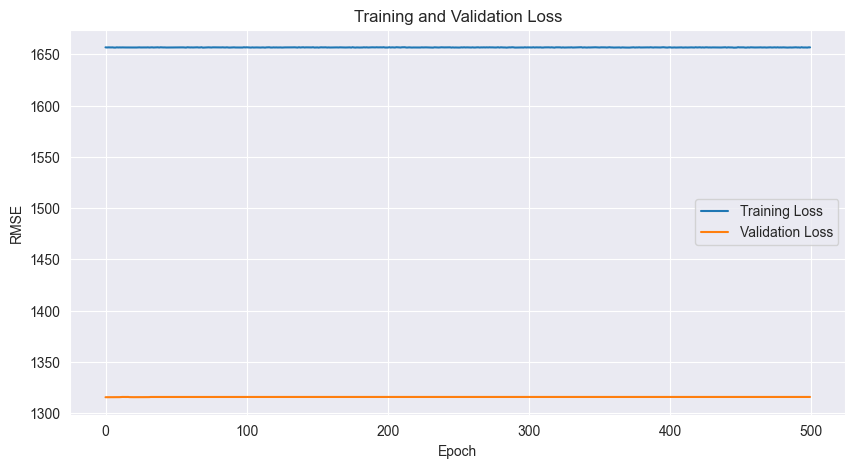

Final validation RMSE: 1315.3938
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1552.0475, Val RMSE: 2262.4360
Epoch 10: Train RMSE: 1552.0070, Val RMSE: 2262.4319
Epoch 20: Train RMSE: 1551.9884, Val RMSE: 2262.4019



  5%|▍         | 24/500 [00:00<00:02, 234.25it/s]

Epoch 30: Train RMSE: 1552.0532, Val RMSE: 2262.3972
Epoch 40: Train RMSE: 1552.0891, Val RMSE: 2262.3950



 16%|█▌        | 80/500 [00:00<00:01, 269.83it/s]

Epoch 50: Train RMSE: 1552.0212, Val RMSE: 2262.3933
Epoch 60: Train RMSE: 1551.9690, Val RMSE: 2262.3936
Epoch 70: Train RMSE: 1552.1216, Val RMSE: 2262.3933
Epoch 80: Train RMSE: 1552.0835, Val RMSE: 2262.3931



 23%|██▎       | 115/500 [00:00<00:01, 299.02it/s]

Epoch 90: Train RMSE: 1552.0563, Val RMSE: 2262.3928
Epoch 100: Train RMSE: 1552.0573, Val RMSE: 2262.3928
Epoch 110: Train RMSE: 1552.0326, Val RMSE: 2262.3928



 30%|██▉       | 148/500 [00:00<00:01, 308.04it/s]

Epoch 120: Train RMSE: 1552.0223, Val RMSE: 2262.3928
Epoch 130: Train RMSE: 1552.0601, Val RMSE: 2262.3928
Epoch 140: Train RMSE: 1552.0508, Val RMSE: 2262.3928
Epoch 150: Train RMSE: 1551.9669, Val RMSE: 2262.3928



 36%|███▌      | 181/500 [00:00<00:01, 313.96it/s]

Epoch 160: Train RMSE: 1551.9736, Val RMSE: 2262.3928
Epoch 170: Train RMSE: 1551.9863, Val RMSE: 2262.3928
Epoch 180: Train RMSE: 1552.1282, Val RMSE: 2262.3928



 43%|████▎     | 213/500 [00:00<00:00, 303.65it/s]

Epoch 190: Train RMSE: 1552.1075, Val RMSE: 2262.3928
Epoch 200: Train RMSE: 1551.9755, Val RMSE: 2262.3928
Epoch 210: Train RMSE: 1552.0120, Val RMSE: 2262.3928
Epoch 220: Train RMSE: 1552.0317, Val RMSE: 2262.3928



 49%|████▉     | 244/500 [00:00<00:00, 304.29it/s]

Epoch 230: Train RMSE: 1552.0297, Val RMSE: 2262.3928
Epoch 240: Train RMSE: 1552.1246, Val RMSE: 2262.3928



 55%|█████▌    | 276/500 [00:00<00:00, 307.67it/s]

Epoch 250: Train RMSE: 1551.9473, Val RMSE: 2262.3928
Epoch 260: Train RMSE: 1552.0530, Val RMSE: 2262.3928
Epoch 270: Train RMSE: 1552.0212, Val RMSE: 2262.3928
Epoch 280: Train RMSE: 1552.0188, Val RMSE: 2262.3928
Epoch 290: Train RMSE: 1552.0422, Val RMSE: 2262.3928



 62%|██████▏   | 309/500 [00:01<00:00, 312.20it/s]

Epoch 300: Train RMSE: 1552.0062, Val RMSE: 2262.3928
Epoch 310: Train RMSE: 1552.0088, Val RMSE: 2262.3928



 68%|██████▊   | 341/500 [00:01<00:00, 309.07it/s]

Epoch 320: Train RMSE: 1552.0221, Val RMSE: 2262.3928
Epoch 330: Train RMSE: 1551.9838, Val RMSE: 2262.3928
Epoch 340: Train RMSE: 1551.9906, Val RMSE: 2262.3928
Epoch 350: Train RMSE: 1552.0258, Val RMSE: 2262.3928
Epoch 360: Train RMSE: 1552.0283, Val RMSE: 2262.3928



 75%|███████▌  | 375/500 [00:01<00:00, 316.30it/s]

Epoch 370: Train RMSE: 1552.0939, Val RMSE: 2262.3928
Epoch 380: Train RMSE: 1552.0352, Val RMSE: 2262.3928



 81%|████████▏ | 407/500 [00:01<00:00, 308.68it/s]

Epoch 390: Train RMSE: 1552.0609, Val RMSE: 2262.3928
Epoch 400: Train RMSE: 1551.9846, Val RMSE: 2262.3928
Epoch 410: Train RMSE: 1552.0946, Val RMSE: 2262.3928
Epoch 420: Train RMSE: 1552.0621, Val RMSE: 2262.3928
Epoch 430: Train RMSE: 1552.0613, Val RMSE: 2262.3928



 88%|████████▊ | 439/500 [00:01<00:00, 311.65it/s]

Epoch 440: Train RMSE: 1552.0162, Val RMSE: 2262.3928
Epoch 450: Train RMSE: 1552.0255, Val RMSE: 2262.3928



100%|██████████| 500/500 [00:01<00:00, 306.15it/s]


Epoch 460: Train RMSE: 1551.9471, Val RMSE: 2262.3928
Epoch 470: Train RMSE: 1552.1262, Val RMSE: 2262.3928
Epoch 480: Train RMSE: 1551.9944, Val RMSE: 2262.3928
Epoch 490: Train RMSE: 1552.0123, Val RMSE: 2262.3928


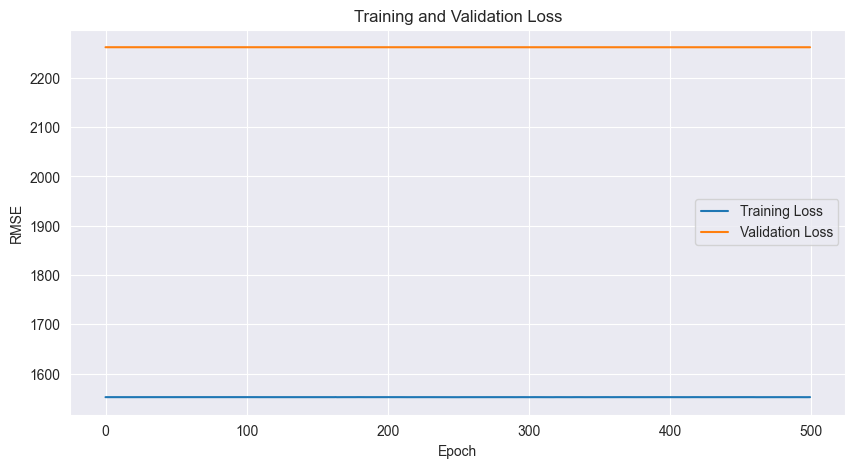

Final validation RMSE: 2262.3928
  Fold 4/5
Input size: 437



  7%|▋         | 34/500 [00:00<00:01, 332.50it/s]

Epoch 0: Train RMSE: 1755.9261, Val RMSE: 2261.7844
Epoch 10: Train RMSE: 1755.9125, Val RMSE: 2261.7913
Epoch 20: Train RMSE: 1755.8873, Val RMSE: 2261.7966
Epoch 30: Train RMSE: 1755.9374, Val RMSE: 2261.8003
Epoch 40: Train RMSE: 1755.8911, Val RMSE: 2261.8015
Epoch 50: Train RMSE: 1755.8954, Val RMSE: 2261.8022
Epoch 60: Train RMSE: 1755.9202, Val RMSE: 2261.8027



 20%|██        | 100/500 [00:00<00:01, 299.77it/s]


Epoch 70: Train RMSE: 1755.8973, Val RMSE: 2261.8030
Epoch 80: Train RMSE: 1755.9043, Val RMSE: 2261.8030
Epoch 90: Train RMSE: 1755.8728, Val RMSE: 2261.8030
Epoch 100: Train RMSE: 1755.9338, Val RMSE: 2261.8032
Epoch 110: Train RMSE: 1755.8676, Val RMSE: 2261.8032
Epoch 120: Train RMSE: 1755.9100, Val RMSE: 2261.8032
Epoch 130: Train RMSE: 1755.9010, Val RMSE: 2261.8032


 41%|████▏     | 207/500 [00:00<00:00, 339.05it/s]

Epoch 140: Train RMSE: 1755.8776, Val RMSE: 2261.8032
Epoch 150: Train RMSE: 1755.8655, Val RMSE: 2261.8032
Epoch 160: Train RMSE: 1755.8589, Val RMSE: 2261.8030
Epoch 170: Train RMSE: 1755.9012, Val RMSE: 2261.8030
Epoch 180: Train RMSE: 1755.9159, Val RMSE: 2261.8030
Epoch 190: Train RMSE: 1755.8888, Val RMSE: 2261.8032
Epoch 200: Train RMSE: 1755.9281, Val RMSE: 2261.8032
Epoch 210: Train RMSE: 1755.8444, Val RMSE: 2261.8032



 55%|█████▌    | 275/500 [00:00<00:00, 317.99it/s]

Epoch 220: Train RMSE: 1755.9136, Val RMSE: 2261.8032
Epoch 230: Train RMSE: 1755.9331, Val RMSE: 2261.8032
Epoch 240: Train RMSE: 1755.8843, Val RMSE: 2261.8032
Epoch 250: Train RMSE: 1755.9336, Val RMSE: 2261.8032
Epoch 260: Train RMSE: 1755.8950, Val RMSE: 2261.8032
Epoch 270: Train RMSE: 1755.8585, Val RMSE: 2261.8032



 69%|██████▉   | 347/500 [00:01<00:00, 337.08it/s]

Epoch 280: Train RMSE: 1755.8969, Val RMSE: 2261.8032
Epoch 290: Train RMSE: 1755.8867, Val RMSE: 2261.8032
Epoch 300: Train RMSE: 1755.8497, Val RMSE: 2261.8032
Epoch 310: Train RMSE: 1755.8676, Val RMSE: 2261.8032
Epoch 320: Train RMSE: 1755.8888, Val RMSE: 2261.8032
Epoch 330: Train RMSE: 1755.8624, Val RMSE: 2261.8032
Epoch 340: Train RMSE: 1755.8790, Val RMSE: 2261.8032
Epoch 350: Train RMSE: 1755.8989, Val RMSE: 2261.8032



 83%|████████▎ | 415/500 [00:01<00:00, 327.91it/s]

Epoch 360: Train RMSE: 1755.9181, Val RMSE: 2261.8032
Epoch 370: Train RMSE: 1755.9215, Val RMSE: 2261.8032
Epoch 380: Train RMSE: 1755.8994, Val RMSE: 2261.8032
Epoch 390: Train RMSE: 1755.8854, Val RMSE: 2261.8032
Epoch 400: Train RMSE: 1755.8823, Val RMSE: 2261.8032
Epoch 410: Train RMSE: 1755.8904, Val RMSE: 2261.8032
Epoch 420: Train RMSE: 1755.8575, Val RMSE: 2261.8032



 96%|█████████▌| 480/500 [00:01<00:00, 311.32it/s]

Epoch 430: Train RMSE: 1755.9043, Val RMSE: 2261.8032
Epoch 440: Train RMSE: 1755.9012, Val RMSE: 2261.8032
Epoch 450: Train RMSE: 1755.8719, Val RMSE: 2261.8032
Epoch 460: Train RMSE: 1755.9048, Val RMSE: 2261.8032
Epoch 470: Train RMSE: 1755.9410, Val RMSE: 2261.8032
Epoch 480: Train RMSE: 1755.8684, Val RMSE: 2261.8032
Epoch 490: Train RMSE: 1755.9331, Val RMSE: 2261.8032


100%|██████████| 500/500 [00:01<00:00, 321.31it/s]


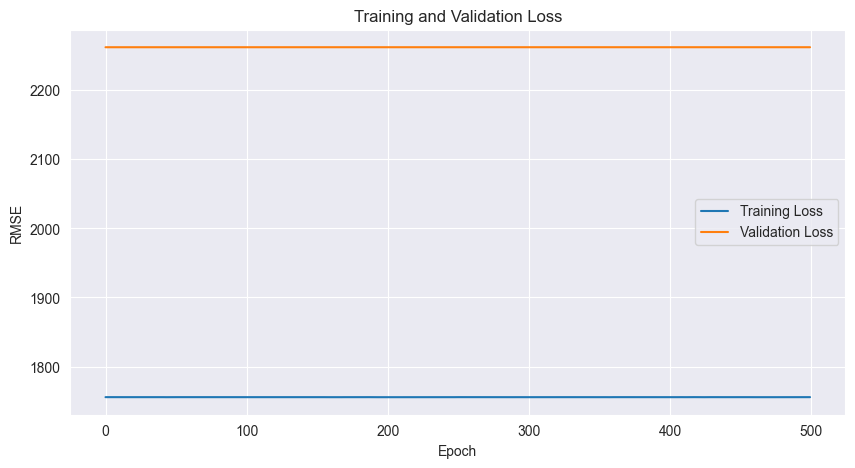

Final validation RMSE: 2261.7844
  Fold 5/5
Input size: 437



  4%|▍         | 22/500 [00:00<00:02, 219.03it/s]

Epoch 0: Train RMSE: 1867.5253, Val RMSE: 2492.9944
Epoch 10: Train RMSE: 1867.6296, Val RMSE: 2493.0398
Epoch 20: Train RMSE: 1867.6877, Val RMSE: 2493.0398
Epoch 30: Train RMSE: 1867.7610, Val RMSE: 2493.0398
Epoch 40: Train RMSE: 1867.6470, Val RMSE: 2493.0400



 19%|█▉        | 94/500 [00:00<00:01, 228.20it/s]

Epoch 50: Train RMSE: 1867.6429, Val RMSE: 2493.0400
Epoch 60: Train RMSE: 1867.6116, Val RMSE: 2493.0403
Epoch 70: Train RMSE: 1867.6459, Val RMSE: 2493.0400
Epoch 80: Train RMSE: 1867.7014, Val RMSE: 2493.0403
Epoch 90: Train RMSE: 1867.6049, Val RMSE: 2493.0403



 30%|██▉       | 149/500 [00:00<00:01, 251.43it/s]

Epoch 100: Train RMSE: 1867.5918, Val RMSE: 2493.0403
Epoch 110: Train RMSE: 1867.6216, Val RMSE: 2493.0403
Epoch 120: Train RMSE: 1867.6763, Val RMSE: 2493.0403
Epoch 130: Train RMSE: 1867.6448, Val RMSE: 2493.0403
Epoch 140: Train RMSE: 1867.4854, Val RMSE: 2493.0403
Epoch 150: Train RMSE: 1867.7067, Val RMSE: 2493.0403



 35%|███▌      | 176/500 [00:00<00:01, 255.12it/s]

Epoch 160: Train RMSE: 1867.7280, Val RMSE: 2493.0403
Epoch 170: Train RMSE: 1867.5536, Val RMSE: 2493.0403
Epoch 180: Train RMSE: 1867.6425, Val RMSE: 2493.0403



 45%|████▌     | 226/500 [00:01<00:01, 181.63it/s]

Epoch 190: Train RMSE: 1867.6752, Val RMSE: 2493.0403
Epoch 200: Train RMSE: 1867.6376, Val RMSE: 2493.0403
Epoch 210: Train RMSE: 1867.7019, Val RMSE: 2493.0403
Epoch 220: Train RMSE: 1867.5697, Val RMSE: 2493.0403
Epoch 230: Train RMSE: 1867.6128, Val RMSE: 2493.0403



 56%|█████▌    | 280/500 [00:01<00:01, 217.82it/s]

Epoch 240: Train RMSE: 1867.6034, Val RMSE: 2493.0403
Epoch 250: Train RMSE: 1867.5801, Val RMSE: 2493.0403
Epoch 260: Train RMSE: 1867.6863, Val RMSE: 2493.0403
Epoch 270: Train RMSE: 1867.6610, Val RMSE: 2493.0403
Epoch 280: Train RMSE: 1867.6503, Val RMSE: 2493.0403
Epoch 290: Train RMSE: 1867.7332, Val RMSE: 2493.0403



 66%|██████▌   | 328/500 [00:01<00:00, 216.30it/s]

Epoch 300: Train RMSE: 1867.6460, Val RMSE: 2493.0403
Epoch 310: Train RMSE: 1867.6685, Val RMSE: 2493.0403
Epoch 320: Train RMSE: 1867.6605, Val RMSE: 2493.0403
Epoch 330: Train RMSE: 1867.6356, Val RMSE: 2493.0403
Epoch 340: Train RMSE: 1867.4988, Val RMSE: 2493.0403



 75%|███████▌  | 376/500 [00:01<00:00, 223.02it/s]

Epoch 350: Train RMSE: 1867.7333, Val RMSE: 2493.0403
Epoch 360: Train RMSE: 1867.6077, Val RMSE: 2493.0403
Epoch 370: Train RMSE: 1867.5308, Val RMSE: 2493.0403
Epoch 380: Train RMSE: 1867.6403, Val RMSE: 2493.0403
Epoch 390: Train RMSE: 1867.5505, Val RMSE: 2493.0403
Epoch 400: Train RMSE: 1867.6870, Val RMSE: 2493.0403



 91%|█████████ | 453/500 [00:02<00:00, 235.18it/s]

Epoch 410: Train RMSE: 1867.6522, Val RMSE: 2493.0403
Epoch 420: Train RMSE: 1867.6820, Val RMSE: 2493.0403
Epoch 430: Train RMSE: 1867.6807, Val RMSE: 2493.0403
Epoch 440: Train RMSE: 1867.6305, Val RMSE: 2493.0403
Epoch 450: Train RMSE: 1867.7872, Val RMSE: 2493.0403



100%|██████████| 500/500 [00:02<00:00, 221.43it/s]

Epoch 460: Train RMSE: 1867.6394, Val RMSE: 2493.0403
Epoch 470: Train RMSE: 1867.6346, Val RMSE: 2493.0403
Epoch 480: Train RMSE: 1867.6548, Val RMSE: 2493.0403
Epoch 490: Train RMSE: 1867.4728, Val RMSE: 2493.0403


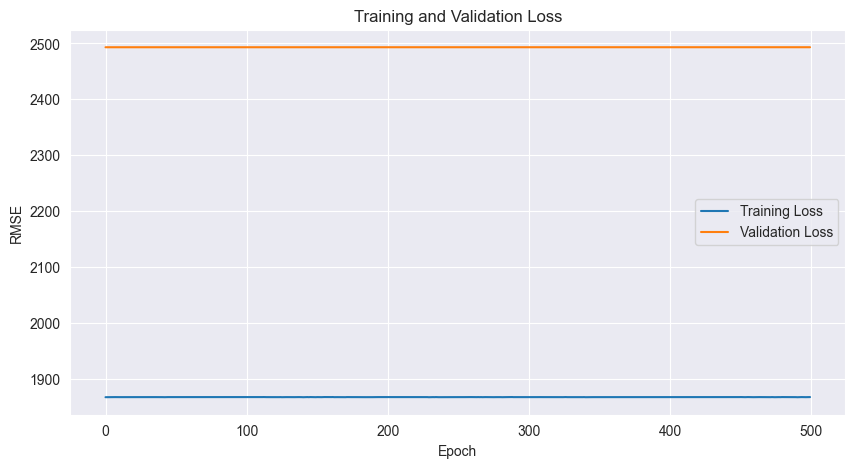

Final validation RMSE: 2492.9941
  Avg RMSE: 2032.2933 ± 417.8924

Testing: hidden_size=128, layers=2, lr=0.001
  Fold 1/5
Input size: 437



  9%|▊         | 43/500 [00:00<00:01, 423.66it/s]

Epoch 0: Train RMSE: 1467.7233, Val RMSE: 1828.9795
Epoch 10: Train RMSE: 1467.7120, Val RMSE: 1829.0038
Epoch 20: Train RMSE: 1467.7023, Val RMSE: 1829.0157
Epoch 30: Train RMSE: 1467.7573, Val RMSE: 1829.0206
Epoch 40: Train RMSE: 1467.7419, Val RMSE: 1829.0238
Epoch 50: Train RMSE: 1467.7568, Val RMSE: 1829.0253
Epoch 60: Train RMSE: 1467.5807, Val RMSE: 1829.0259
Epoch 70: Train RMSE: 1467.3629, Val RMSE: 1829.0261
Epoch 80: Train RMSE: 1467.6772, Val RMSE: 1829.0264



 26%|██▌       | 130/500 [00:00<00:00, 418.78it/s]

Epoch 90: Train RMSE: 1467.6630, Val RMSE: 1829.0264
Epoch 100: Train RMSE: 1467.2573, Val RMSE: 1829.0265
Epoch 110: Train RMSE: 1467.3120, Val RMSE: 1829.0266
Epoch 120: Train RMSE: 1467.3910, Val RMSE: 1829.0266
Epoch 130: Train RMSE: 1467.6785, Val RMSE: 1829.0265
Epoch 140: Train RMSE: 1467.6211, Val RMSE: 1829.0266
Epoch 150: Train RMSE: 1467.5035, Val RMSE: 1829.0266
Epoch 160: Train RMSE: 1467.6014, Val RMSE: 1829.0266



 34%|███▍      | 172/500 [00:00<00:00, 411.91it/s]

Epoch 170: Train RMSE: 1467.3657, Val RMSE: 1829.0266



 43%|████▎     | 216/500 [00:00<00:00, 421.13it/s]

Epoch 180: Train RMSE: 1467.5947, Val RMSE: 1829.0265
Epoch 190: Train RMSE: 1467.3531, Val RMSE: 1829.0265
Epoch 200: Train RMSE: 1467.6976, Val RMSE: 1829.0265
Epoch 210: Train RMSE: 1467.5990, Val RMSE: 1829.0266
Epoch 220: Train RMSE: 1467.5870, Val RMSE: 1829.0266
Epoch 230: Train RMSE: 1467.3171, Val RMSE: 1829.0266
Epoch 240: Train RMSE: 1467.6554, Val RMSE: 1829.0266
Epoch 250: Train RMSE: 1467.6884, Val RMSE: 1829.0266



 52%|█████▏    | 259/500 [00:00<00:00, 359.85it/s]


Epoch 260: Train RMSE: 1467.7208, Val RMSE: 1829.0266
Epoch 270: Train RMSE: 1467.7123, Val RMSE: 1829.0266
Epoch 280: Train RMSE: 1467.3413, Val RMSE: 1829.0266
Epoch 290: Train RMSE: 1467.4562, Val RMSE: 1829.0266


 59%|█████▉    | 297/500 [00:00<00:00, 308.99it/s]

Epoch 300: Train RMSE: 1467.6678, Val RMSE: 1829.0266
Epoch 310: Train RMSE: 1467.7360, Val RMSE: 1829.0266



 67%|██████▋   | 333/500 [00:00<00:00, 320.12it/s]

Epoch 320: Train RMSE: 1467.7808, Val RMSE: 1829.0266
Epoch 330: Train RMSE: 1467.6168, Val RMSE: 1829.0265
Epoch 340: Train RMSE: 1467.7128, Val RMSE: 1829.0265
Epoch 350: Train RMSE: 1467.7336, Val RMSE: 1829.0265
Epoch 360: Train RMSE: 1467.6069, Val RMSE: 1829.0266



 73%|███████▎  | 367/500 [00:01<00:00, 312.82it/s]

Epoch 370: Train RMSE: 1467.3242, Val RMSE: 1829.0266



 87%|████████▋ | 434/500 [00:01<00:00, 318.58it/s]

Epoch 380: Train RMSE: 1467.4039, Val RMSE: 1829.0266
Epoch 390: Train RMSE: 1467.5385, Val RMSE: 1829.0266
Epoch 400: Train RMSE: 1467.5261, Val RMSE: 1829.0266
Epoch 410: Train RMSE: 1467.6624, Val RMSE: 1829.0266
Epoch 420: Train RMSE: 1467.4716, Val RMSE: 1829.0266
Epoch 430: Train RMSE: 1467.5111, Val RMSE: 1829.0266
Epoch 440: Train RMSE: 1467.3130, Val RMSE: 1829.0266



100%|██████████| 500/500 [00:01<00:00, 346.68it/s]


Epoch 450: Train RMSE: 1467.6774, Val RMSE: 1829.0266
Epoch 460: Train RMSE: 1467.6443, Val RMSE: 1829.0266
Epoch 470: Train RMSE: 1467.6716, Val RMSE: 1829.0266
Epoch 480: Train RMSE: 1467.4644, Val RMSE: 1829.0266
Epoch 490: Train RMSE: 1467.4523, Val RMSE: 1829.0266


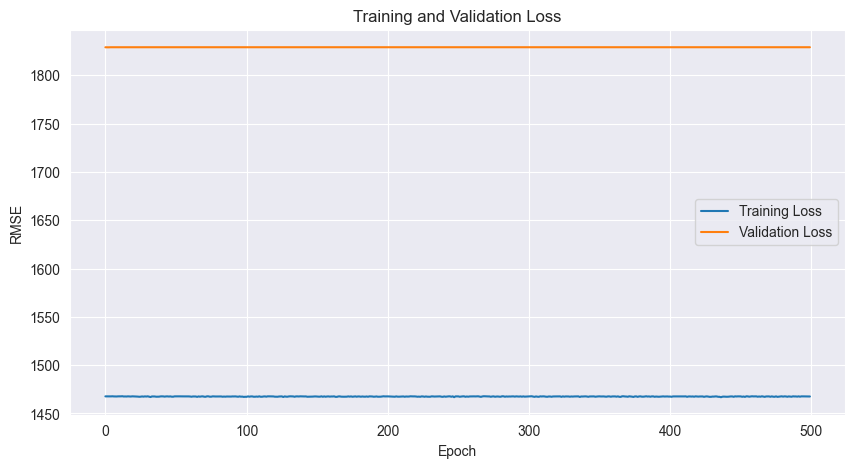

Final validation RMSE: 1828.9309
  Fold 2/5
Input size: 437



  6%|▌         | 29/500 [00:00<00:01, 284.14it/s]

Epoch 0: Train RMSE: 1656.6525, Val RMSE: 1315.7069
Epoch 10: Train RMSE: 1656.5601, Val RMSE: 1315.9265
Epoch 20: Train RMSE: 1656.5695, Val RMSE: 1315.9537
Epoch 30: Train RMSE: 1656.6130, Val RMSE: 1315.9707
Epoch 40: Train RMSE: 1656.4799, Val RMSE: 1315.9868
Epoch 50: Train RMSE: 1656.5599, Val RMSE: 1316.0048
Epoch 60: Train RMSE: 1656.5253, Val RMSE: 1316.0135



 29%|██▉       | 144/500 [00:00<00:00, 365.50it/s]

Epoch 70: Train RMSE: 1656.5254, Val RMSE: 1316.0214
Epoch 80: Train RMSE: 1656.8199, Val RMSE: 1316.0253
Epoch 90: Train RMSE: 1656.4016, Val RMSE: 1316.0272
Epoch 100: Train RMSE: 1656.6749, Val RMSE: 1316.0283
Epoch 110: Train RMSE: 1656.2240, Val RMSE: 1316.0293
Epoch 120: Train RMSE: 1656.5419, Val RMSE: 1316.0297
Epoch 130: Train RMSE: 1656.4960, Val RMSE: 1316.0298
Epoch 140: Train RMSE: 1656.6987, Val RMSE: 1316.0299



 46%|████▌     | 229/500 [00:00<00:00, 401.13it/s]

Epoch 150: Train RMSE: 1656.5586, Val RMSE: 1316.0299
Epoch 160: Train RMSE: 1656.6381, Val RMSE: 1316.0299
Epoch 170: Train RMSE: 1656.5182, Val RMSE: 1316.0299
Epoch 180: Train RMSE: 1656.5155, Val RMSE: 1316.0299
Epoch 190: Train RMSE: 1656.4207, Val RMSE: 1316.0299
Epoch 200: Train RMSE: 1656.6526, Val RMSE: 1316.0299
Epoch 210: Train RMSE: 1656.5149, Val RMSE: 1316.0299
Epoch 220: Train RMSE: 1656.4617, Val RMSE: 1316.0299
Epoch 230: Train RMSE: 1656.6130, Val RMSE: 1316.0299



 54%|█████▍    | 270/500 [00:00<00:00, 371.97it/s]

Epoch 240: Train RMSE: 1656.5770, Val RMSE: 1316.0299
Epoch 250: Train RMSE: 1656.1890, Val RMSE: 1316.0299
Epoch 260: Train RMSE: 1656.3705, Val RMSE: 1316.0299
Epoch 270: Train RMSE: 1656.5040, Val RMSE: 1316.0299
Epoch 280: Train RMSE: 1656.3317, Val RMSE: 1316.0299
Epoch 290: Train RMSE: 1656.6270, Val RMSE: 1316.0299
Epoch 300: Train RMSE: 1656.2684, Val RMSE: 1316.0299



 69%|██████▉   | 345/500 [00:00<00:00, 349.36it/s]

Epoch 310: Train RMSE: 1656.5631, Val RMSE: 1316.0299
Epoch 320: Train RMSE: 1656.4384, Val RMSE: 1316.0299
Epoch 330: Train RMSE: 1656.3934, Val RMSE: 1316.0299
Epoch 340: Train RMSE: 1656.3485, Val RMSE: 1316.0300
Epoch 350: Train RMSE: 1656.5387, Val RMSE: 1316.0300
Epoch 360: Train RMSE: 1656.6669, Val RMSE: 1316.0300
Epoch 370: Train RMSE: 1656.3691, Val RMSE: 1316.0300
Epoch 380: Train RMSE: 1656.3507, Val RMSE: 1316.0300
Epoch 390: Train RMSE: 1656.8302, Val RMSE: 1316.0300



 94%|█████████▍| 471/500 [00:01<00:00, 369.90it/s]

Epoch 400: Train RMSE: 1656.3409, Val RMSE: 1316.0300
Epoch 410: Train RMSE: 1656.4576, Val RMSE: 1316.0300
Epoch 420: Train RMSE: 1656.5178, Val RMSE: 1316.0300
Epoch 430: Train RMSE: 1656.1356, Val RMSE: 1316.0300
Epoch 440: Train RMSE: 1656.2635, Val RMSE: 1316.0300
Epoch 450: Train RMSE: 1656.7096, Val RMSE: 1316.0300
Epoch 460: Train RMSE: 1656.5604, Val RMSE: 1316.0300
Epoch 470: Train RMSE: 1656.6157, Val RMSE: 1316.0300


100%|██████████| 500/500 [00:01<00:00, 368.69it/s]


Epoch 480: Train RMSE: 1656.7571, Val RMSE: 1316.0300
Epoch 490: Train RMSE: 1656.4109, Val RMSE: 1316.0300


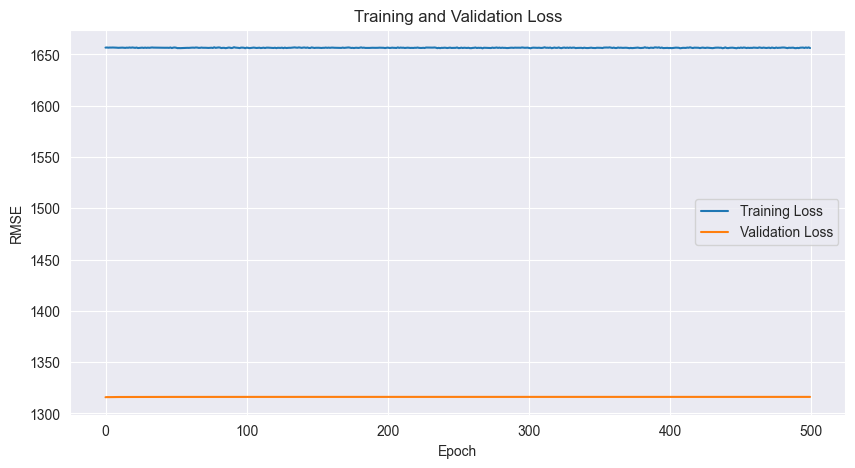

Final validation RMSE: 1315.7069
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1552.0065, Val RMSE: 2262.3184
Epoch 10: Train RMSE: 1551.9866, Val RMSE: 2262.1675



  5%|▌         | 26/500 [00:00<00:01, 250.81it/s]

Epoch 20: Train RMSE: 1552.1069, Val RMSE: 2261.9968
Epoch 30: Train RMSE: 1552.0261, Val RMSE: 2261.8928
Epoch 40: Train RMSE: 1552.1311, Val RMSE: 2261.7878



 10%|█         | 52/500 [00:00<00:01, 243.01it/s]

Epoch 50: Train RMSE: 1551.9061, Val RMSE: 2261.6936
Epoch 60: Train RMSE: 1551.9784, Val RMSE: 2261.6492



 16%|█▌        | 78/500 [00:00<00:01, 248.39it/s]

Epoch 70: Train RMSE: 1551.9512, Val RMSE: 2261.6902
Epoch 80: Train RMSE: 1551.9843, Val RMSE: 2261.6787
Epoch 90: Train RMSE: 1552.1270, Val RMSE: 2261.6721
Epoch 100: Train RMSE: 1551.9568, Val RMSE: 2261.6689



 22%|██▏       | 112/500 [00:00<00:01, 281.76it/s]

Epoch 110: Train RMSE: 1551.7816, Val RMSE: 2261.6672
Epoch 120: Train RMSE: 1552.0087, Val RMSE: 2261.6663
Epoch 130: Train RMSE: 1551.9990, Val RMSE: 2261.6658



 29%|██▉       | 145/500 [00:00<00:01, 296.48it/s]

Epoch 140: Train RMSE: 1551.9315, Val RMSE: 2261.6655
Epoch 150: Train RMSE: 1551.8547, Val RMSE: 2261.6655
Epoch 160: Train RMSE: 1551.8285, Val RMSE: 2261.6653
Epoch 170: Train RMSE: 1551.9474, Val RMSE: 2261.6653



 36%|███▌      | 178/500 [00:00<00:01, 306.87it/s]

Epoch 180: Train RMSE: 1551.8550, Val RMSE: 2261.6653
Epoch 190: Train RMSE: 1551.9211, Val RMSE: 2261.6653
Epoch 200: Train RMSE: 1551.9757, Val RMSE: 2261.6653



 50%|████▉     | 248/500 [00:00<00:00, 329.98it/s]

Epoch 210: Train RMSE: 1551.7855, Val RMSE: 2261.6653
Epoch 220: Train RMSE: 1551.9757, Val RMSE: 2261.6653
Epoch 230: Train RMSE: 1551.8422, Val RMSE: 2261.6653
Epoch 240: Train RMSE: 1551.9740, Val RMSE: 2261.6653



 56%|█████▋    | 282/500 [00:00<00:00, 332.77it/s]

Epoch 250: Train RMSE: 1551.9197, Val RMSE: 2261.6653
Epoch 260: Train RMSE: 1551.8101, Val RMSE: 2261.6653
Epoch 270: Train RMSE: 1552.0173, Val RMSE: 2261.6653
Epoch 280: Train RMSE: 1551.9913, Val RMSE: 2261.6653



 63%|██████▎   | 316/500 [00:01<00:00, 329.02it/s]

Epoch 290: Train RMSE: 1551.9880, Val RMSE: 2261.6653
Epoch 300: Train RMSE: 1551.8503, Val RMSE: 2261.6653
Epoch 310: Train RMSE: 1551.9200, Val RMSE: 2261.6653



 70%|██████▉   | 349/500 [00:01<00:00, 321.16it/s]

Epoch 320: Train RMSE: 1551.8545, Val RMSE: 2261.6653
Epoch 330: Train RMSE: 1551.7925, Val RMSE: 2261.6653
Epoch 340: Train RMSE: 1551.9648, Val RMSE: 2261.6653
Epoch 350: Train RMSE: 1551.8457, Val RMSE: 2261.6653



 76%|███████▋  | 382/500 [00:01<00:00, 315.62it/s]

Epoch 360: Train RMSE: 1552.0510, Val RMSE: 2261.6653
Epoch 370: Train RMSE: 1552.0240, Val RMSE: 2261.6653
Epoch 380: Train RMSE: 1551.6333, Val RMSE: 2261.6653



 84%|████████▎ | 418/500 [00:01<00:00, 327.68it/s]

Epoch 390: Train RMSE: 1551.9994, Val RMSE: 2261.6653
Epoch 400: Train RMSE: 1552.0747, Val RMSE: 2261.6653
Epoch 410: Train RMSE: 1552.0497, Val RMSE: 2261.6653
Epoch 420: Train RMSE: 1552.0875, Val RMSE: 2261.6653



 91%|█████████ | 453/500 [00:01<00:00, 333.55it/s]

Epoch 430: Train RMSE: 1551.9152, Val RMSE: 2261.6653
Epoch 440: Train RMSE: 1551.9222, Val RMSE: 2261.6653
Epoch 450: Train RMSE: 1551.9125, Val RMSE: 2261.6653
Epoch 460: Train RMSE: 1551.9547, Val RMSE: 2261.6653



 97%|█████████▋| 487/500 [00:01<00:00, 329.01it/s]

Epoch 470: Train RMSE: 1551.8805, Val RMSE: 2261.6653
Epoch 480: Train RMSE: 1551.8263, Val RMSE: 2261.6653
Epoch 490: Train RMSE: 1551.9738, Val RMSE: 2261.6653


100%|██████████| 500/500 [00:01<00:00, 313.51it/s]


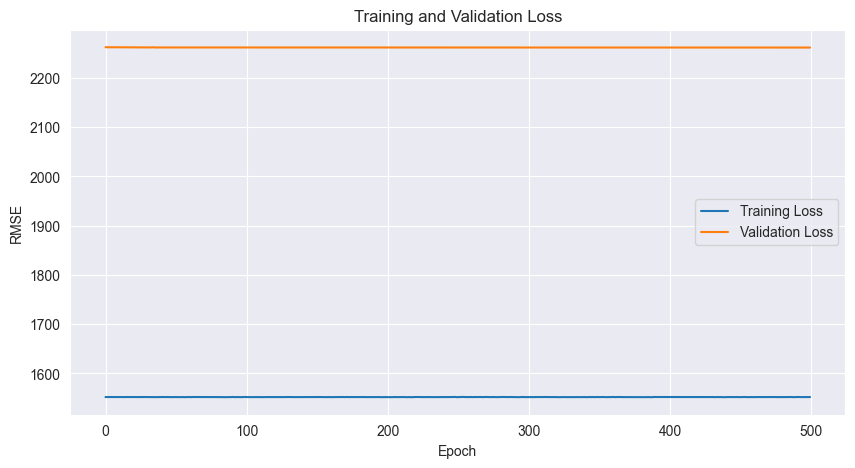

Final validation RMSE: 2261.5994
  Fold 4/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1755.8530, Val RMSE: 2261.7397



  6%|▌         | 28/500 [00:00<00:01, 278.72it/s]

Epoch 10: Train RMSE: 1755.7258, Val RMSE: 2261.8599
Epoch 20: Train RMSE: 1755.6283, Val RMSE: 2261.8896
Epoch 30: Train RMSE: 1755.6079, Val RMSE: 2261.9094
Epoch 40: Train RMSE: 1755.5022, Val RMSE: 2261.9216
Epoch 50: Train RMSE: 1755.4341, Val RMSE: 2261.9285



 12%|█▏        | 59/500 [00:00<00:01, 291.24it/s]

Epoch 60: Train RMSE: 1755.5836, Val RMSE: 2261.9319
Epoch 70: Train RMSE: 1755.5227, Val RMSE: 2261.9336



 18%|█▊        | 89/500 [00:00<00:01, 286.53it/s]


Epoch 80: Train RMSE: 1755.3141, Val RMSE: 2261.9351
Epoch 90: Train RMSE: 1755.4575, Val RMSE: 2261.9353
Epoch 100: Train RMSE: 1755.5170, Val RMSE: 2261.9358
Epoch 110: Train RMSE: 1755.4669, Val RMSE: 2261.9358


 24%|██▎       | 118/500 [00:00<00:01, 286.05it/s]

Epoch 120: Train RMSE: 1755.5054, Val RMSE: 2261.9358
Epoch 130: Train RMSE: 1755.4801, Val RMSE: 2261.9358



 36%|███▌      | 178/500 [00:00<00:01, 291.89it/s]

Epoch 140: Train RMSE: 1755.5670, Val RMSE: 2261.9360
Epoch 150: Train RMSE: 1755.4370, Val RMSE: 2261.9360
Epoch 160: Train RMSE: 1755.4740, Val RMSE: 2261.9358
Epoch 170: Train RMSE: 1755.5206, Val RMSE: 2261.9358
Epoch 180: Train RMSE: 1755.5332, Val RMSE: 2261.9358
Epoch 190: Train RMSE: 1755.4347, Val RMSE: 2261.9358



 42%|████▏     | 208/500 [00:00<00:01, 286.78it/s]

Epoch 200: Train RMSE: 1755.3684, Val RMSE: 2261.9358
Epoch 210: Train RMSE: 1755.4430, Val RMSE: 2261.9358
Epoch 220: Train RMSE: 1755.5104, Val RMSE: 2261.9358
Epoch 230: Train RMSE: 1755.5287, Val RMSE: 2261.9358



 47%|████▋     | 237/500 [00:00<00:00, 275.62it/s]

Epoch 240: Train RMSE: 1755.4266, Val RMSE: 2261.9358
Epoch 250: Train RMSE: 1755.5161, Val RMSE: 2261.9358



 59%|█████▊    | 293/500 [00:01<00:00, 270.84it/s]

Epoch 260: Train RMSE: 1755.4624, Val RMSE: 2261.9358
Epoch 270: Train RMSE: 1755.4901, Val RMSE: 2261.9358
Epoch 280: Train RMSE: 1755.5226, Val RMSE: 2261.9358
Epoch 290: Train RMSE: 1755.4236, Val RMSE: 2261.9358
Epoch 300: Train RMSE: 1755.5217, Val RMSE: 2261.9358
Epoch 310: Train RMSE: 1755.4017, Val RMSE: 2261.9358



 71%|███████   | 353/500 [00:01<00:00, 280.69it/s]

Epoch 320: Train RMSE: 1755.4266, Val RMSE: 2261.9360
Epoch 330: Train RMSE: 1755.6101, Val RMSE: 2261.9360
Epoch 340: Train RMSE: 1755.4128, Val RMSE: 2261.9360
Epoch 350: Train RMSE: 1755.4338, Val RMSE: 2261.9360
Epoch 360: Train RMSE: 1755.5106, Val RMSE: 2261.9360
Epoch 370: Train RMSE: 1755.5317, Val RMSE: 2261.9360



 83%|████████▎ | 413/500 [00:01<00:00, 282.15it/s]

Epoch 380: Train RMSE: 1755.4912, Val RMSE: 2261.9360
Epoch 390: Train RMSE: 1755.3584, Val RMSE: 2261.9360
Epoch 400: Train RMSE: 1755.4458, Val RMSE: 2261.9360
Epoch 410: Train RMSE: 1755.4622, Val RMSE: 2261.9360
Epoch 420: Train RMSE: 1755.4608, Val RMSE: 2261.9360
Epoch 430: Train RMSE: 1755.5377, Val RMSE: 2261.9360



 95%|█████████▌| 475/500 [00:01<00:00, 292.53it/s]

Epoch 440: Train RMSE: 1755.5122, Val RMSE: 2261.9360
Epoch 450: Train RMSE: 1755.4631, Val RMSE: 2261.9360
Epoch 460: Train RMSE: 1755.5199, Val RMSE: 2261.9360
Epoch 470: Train RMSE: 1755.4672, Val RMSE: 2261.9360
Epoch 480: Train RMSE: 1755.4890, Val RMSE: 2261.9360


100%|██████████| 500/500 [00:01<00:00, 286.44it/s]

Epoch 490: Train RMSE: 1755.5940, Val RMSE: 2261.9360


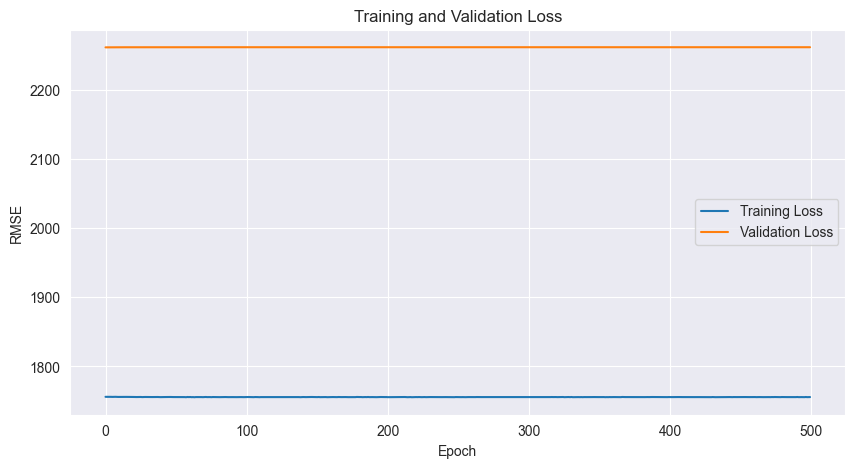

Final validation RMSE: 2261.7397
  Fold 5/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1867.6379, Val RMSE: 2493.1467
Epoch 10: Train RMSE: 1867.6400, Val RMSE: 2493.3967



  4%|▍         | 19/500 [00:00<00:02, 189.80it/s]

Epoch 20: Train RMSE: 1867.3999, Val RMSE: 2493.2463
Epoch 30: Train RMSE: 1867.3749, Val RMSE: 2493.4424



 12%|█▏        | 60/500 [00:00<00:02, 196.85it/s]

Epoch 40: Train RMSE: 1867.2843, Val RMSE: 2493.5029
Epoch 50: Train RMSE: 1867.1636, Val RMSE: 2493.7549



 17%|█▋        | 83/500 [00:00<00:01, 208.70it/s]

Epoch 60: Train RMSE: 1867.2382, Val RMSE: 2493.7671
Epoch 70: Train RMSE: 1867.3016, Val RMSE: 2493.6497
Epoch 80: Train RMSE: 1867.3326, Val RMSE: 2493.6521



 21%|██        | 106/500 [00:00<00:01, 214.93it/s]

Epoch 90: Train RMSE: 1867.2488, Val RMSE: 2493.6533
Epoch 100: Train RMSE: 1867.4100, Val RMSE: 2493.6541



 26%|██▌       | 128/500 [00:00<00:01, 209.49it/s]

Epoch 110: Train RMSE: 1867.3584, Val RMSE: 2493.6545
Epoch 120: Train RMSE: 1867.4021, Val RMSE: 2493.6545
Epoch 130: Train RMSE: 1867.3641, Val RMSE: 2493.6548



 30%|███       | 151/500 [00:00<00:01, 211.98it/s]

Epoch 140: Train RMSE: 1867.1940, Val RMSE: 2493.6548
Epoch 150: Train RMSE: 1867.2126, Val RMSE: 2493.6545



 35%|███▍      | 173/500 [00:00<00:01, 213.39it/s]

Epoch 160: Train RMSE: 1867.2986, Val RMSE: 2493.6548
Epoch 170: Train RMSE: 1867.4041, Val RMSE: 2493.6545
Epoch 180: Train RMSE: 1867.3693, Val RMSE: 2493.6548



 39%|███▉      | 195/500 [00:00<00:01, 215.28it/s]

Epoch 190: Train RMSE: 1867.3643, Val RMSE: 2493.6548
Epoch 200: Train RMSE: 1867.2922, Val RMSE: 2493.6550



 43%|████▎     | 217/500 [00:01<00:01, 211.01it/s]

Epoch 210: Train RMSE: 1867.3329, Val RMSE: 2493.6548
Epoch 220: Train RMSE: 1867.3005, Val RMSE: 2493.6548
Epoch 230: Train RMSE: 1867.2712, Val RMSE: 2493.6548



 48%|████▊     | 240/500 [00:01<00:01, 214.64it/s]

Epoch 240: Train RMSE: 1867.2678, Val RMSE: 2493.6548
Epoch 250: Train RMSE: 1867.2458, Val RMSE: 2493.6548



 57%|█████▋    | 285/500 [00:01<00:00, 217.25it/s]

Epoch 260: Train RMSE: 1867.2366, Val RMSE: 2493.6548
Epoch 270: Train RMSE: 1867.2646, Val RMSE: 2493.6548
Epoch 280: Train RMSE: 1867.2578, Val RMSE: 2493.6548
Epoch 290: Train RMSE: 1867.2988, Val RMSE: 2493.6548
Epoch 300: Train RMSE: 1867.2732, Val RMSE: 2493.6550



 66%|██████▋   | 332/500 [00:01<00:00, 221.15it/s]

Epoch 310: Train RMSE: 1867.2749, Val RMSE: 2493.6550
Epoch 320: Train RMSE: 1867.3262, Val RMSE: 2493.6550
Epoch 330: Train RMSE: 1867.2892, Val RMSE: 2493.6550



 71%|███████   | 355/500 [00:01<00:00, 221.61it/s]

Epoch 340: Train RMSE: 1867.2987, Val RMSE: 2493.6550
Epoch 350: Train RMSE: 1867.1295, Val RMSE: 2493.6550



 76%|███████▌  | 378/500 [00:01<00:00, 218.25it/s]

Epoch 360: Train RMSE: 1867.3071, Val RMSE: 2493.6550
Epoch 370: Train RMSE: 1867.4037, Val RMSE: 2493.6550
Epoch 380: Train RMSE: 1867.3279, Val RMSE: 2493.6548



 80%|████████  | 400/500 [00:01<00:00, 218.35it/s]

Epoch 390: Train RMSE: 1867.3623, Val RMSE: 2493.6548
Epoch 400: Train RMSE: 1867.1726, Val RMSE: 2493.6548



 84%|████████▍ | 422/500 [00:01<00:00, 218.10it/s]

Epoch 410: Train RMSE: 1867.2465, Val RMSE: 2493.6548
Epoch 420: Train RMSE: 1867.3141, Val RMSE: 2493.6550
Epoch 430: Train RMSE: 1867.4575, Val RMSE: 2493.6550



 89%|████████▉ | 445/500 [00:02<00:00, 220.62it/s]

Epoch 440: Train RMSE: 1867.2928, Val RMSE: 2493.6550
Epoch 450: Train RMSE: 1867.2681, Val RMSE: 2493.6550



 94%|█████████▎| 468/500 [00:02<00:00, 214.38it/s]

Epoch 460: Train RMSE: 1867.2634, Val RMSE: 2493.6550
Epoch 470: Train RMSE: 1867.2656, Val RMSE: 2493.6550
Epoch 480: Train RMSE: 1867.4045, Val RMSE: 2493.6550



100%|██████████| 500/500 [00:02<00:00, 214.52it/s]

Epoch 490: Train RMSE: 1867.3094, Val RMSE: 2493.6548


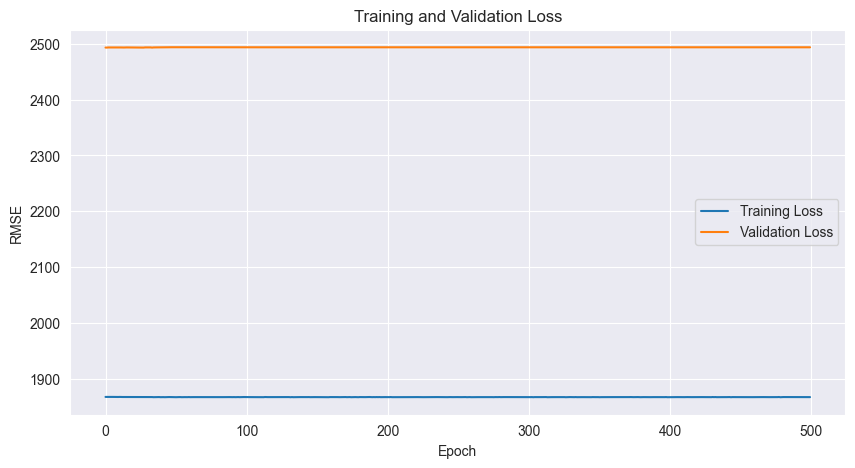

Final validation RMSE: 2493.1069
  Avg RMSE: 2032.2168 ± 417.7148

Testing: hidden_size=128, layers=2, lr=0.01
  Fold 1/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1467.8398, Val RMSE: 1829.0176
Epoch 10: Train RMSE: 1467.8929, Val RMSE: 1828.9828



  8%|▊         | 38/500 [00:00<00:01, 376.90it/s]

Epoch 20: Train RMSE: 1467.6029, Val RMSE: 1828.9849
Epoch 30: Train RMSE: 1467.9281, Val RMSE: 1828.9861
Epoch 40: Train RMSE: 1467.9005, Val RMSE: 1828.9872
Epoch 50: Train RMSE: 1467.7825, Val RMSE: 1828.9878
Epoch 60: Train RMSE: 1467.8822, Val RMSE: 1828.9880
Epoch 70: Train RMSE: 1467.6305, Val RMSE: 1828.9882
Epoch 80: Train RMSE: 1467.8754, Val RMSE: 1828.9882



 17%|█▋        | 85/500 [00:00<00:00, 428.15it/s]

Epoch 90: Train RMSE: 1467.8765, Val RMSE: 1828.9882
Epoch 100: Train RMSE: 1467.7974, Val RMSE: 1828.9883



 34%|███▍      | 171/500 [00:00<00:00, 425.41it/s]

Epoch 110: Train RMSE: 1467.7936, Val RMSE: 1828.9883
Epoch 120: Train RMSE: 1467.8188, Val RMSE: 1828.9883
Epoch 130: Train RMSE: 1467.8876, Val RMSE: 1828.9883
Epoch 140: Train RMSE: 1467.9222, Val RMSE: 1828.9883
Epoch 150: Train RMSE: 1467.9774, Val RMSE: 1828.9883
Epoch 160: Train RMSE: 1467.6344, Val RMSE: 1828.9883
Epoch 170: Train RMSE: 1467.8079, Val RMSE: 1828.9883
Epoch 180: Train RMSE: 1467.8701, Val RMSE: 1828.9883
Epoch 190: Train RMSE: 1467.8798, Val RMSE: 1828.9883



 51%|█████▏    | 257/500 [00:00<00:00, 421.67it/s]

Epoch 200: Train RMSE: 1467.9097, Val RMSE: 1828.9883
Epoch 210: Train RMSE: 1467.8801, Val RMSE: 1828.9883
Epoch 220: Train RMSE: 1467.7771, Val RMSE: 1828.9883
Epoch 230: Train RMSE: 1468.0737, Val RMSE: 1828.9883
Epoch 240: Train RMSE: 1468.1322, Val RMSE: 1828.9883
Epoch 250: Train RMSE: 1467.7561, Val RMSE: 1828.9883
Epoch 260: Train RMSE: 1468.2057, Val RMSE: 1828.9883
Epoch 270: Train RMSE: 1467.6311, Val RMSE: 1828.9883
Epoch 280: Train RMSE: 1467.8906, Val RMSE: 1828.9883



 68%|██████▊   | 342/500 [00:00<00:00, 406.47it/s]

Epoch 290: Train RMSE: 1467.9785, Val RMSE: 1828.9883
Epoch 300: Train RMSE: 1468.1390, Val RMSE: 1828.9883
Epoch 310: Train RMSE: 1467.7383, Val RMSE: 1828.9883
Epoch 320: Train RMSE: 1467.9838, Val RMSE: 1828.9883
Epoch 330: Train RMSE: 1467.9901, Val RMSE: 1828.9883
Epoch 340: Train RMSE: 1467.9102, Val RMSE: 1828.9883
Epoch 350: Train RMSE: 1468.1479, Val RMSE: 1828.9883
Epoch 360: Train RMSE: 1467.9261, Val RMSE: 1828.9883
Epoch 370: Train RMSE: 1467.7277, Val RMSE: 1828.9883



 86%|████████▌ | 429/500 [00:01<00:00, 417.93it/s]

Epoch 380: Train RMSE: 1468.0402, Val RMSE: 1828.9883
Epoch 390: Train RMSE: 1467.9869, Val RMSE: 1828.9883
Epoch 400: Train RMSE: 1467.7070, Val RMSE: 1828.9883
Epoch 410: Train RMSE: 1467.9148, Val RMSE: 1828.9883
Epoch 420: Train RMSE: 1467.8354, Val RMSE: 1828.9883
Epoch 430: Train RMSE: 1467.8029, Val RMSE: 1828.9883
Epoch 440: Train RMSE: 1467.8256, Val RMSE: 1828.9883
Epoch 450: Train RMSE: 1467.9868, Val RMSE: 1828.9883
Epoch 460: Train RMSE: 1467.8276, Val RMSE: 1828.9883
Epoch 470: Train RMSE: 1467.9812, Val RMSE: 1828.9883



100%|██████████| 500/500 [00:01<00:00, 421.62it/s]


Epoch 480: Train RMSE: 1467.8604, Val RMSE: 1828.9883
Epoch 490: Train RMSE: 1467.9539, Val RMSE: 1828.9883


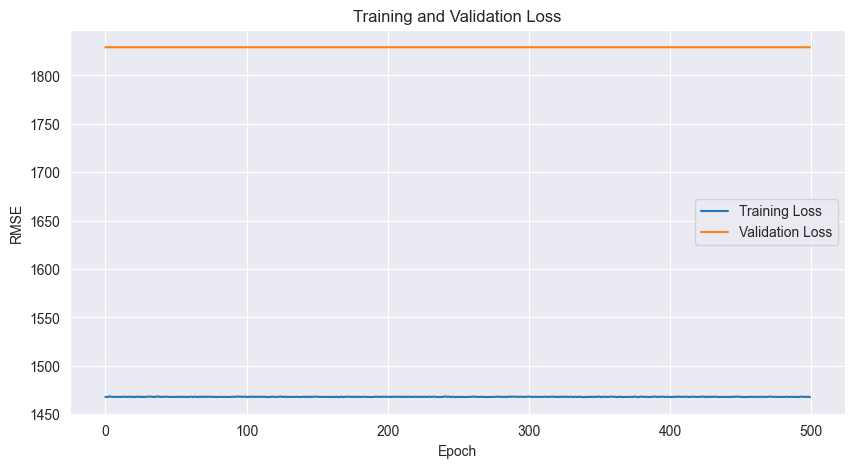

Final validation RMSE: 1828.9741
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.7310, Val RMSE: 1315.9474
Epoch 10: Train RMSE: 1656.7058, Val RMSE: 1316.1611
Epoch 20: Train RMSE: 1656.6627, Val RMSE: 1316.4722



  8%|▊         | 38/500 [00:00<00:01, 376.42it/s]

Epoch 30: Train RMSE: 1656.5873, Val RMSE: 1316.7119
Epoch 40: Train RMSE: 1656.5940, Val RMSE: 1316.8445
Epoch 50: Train RMSE: 1656.5082, Val RMSE: 1316.9413
Epoch 60: Train RMSE: 1656.3373, Val RMSE: 1316.9926
Epoch 70: Train RMSE: 1656.6580, Val RMSE: 1317.0182



 16%|█▌        | 78/500 [00:00<00:01, 386.87it/s]

Epoch 80: Train RMSE: 1656.6910, Val RMSE: 1317.0286
Epoch 90: Train RMSE: 1656.4047, Val RMSE: 1317.0323
Epoch 100: Train RMSE: 1656.6428, Val RMSE: 1317.0356



 24%|██▎       | 118/500 [00:00<00:00, 391.75it/s]


Epoch 110: Train RMSE: 1656.6163, Val RMSE: 1317.0375
Epoch 120: Train RMSE: 1656.8002, Val RMSE: 1317.0382
Epoch 130: Train RMSE: 1656.5884, Val RMSE: 1317.0388
Epoch 140: Train RMSE: 1656.7598, Val RMSE: 1317.0389
Epoch 150: Train RMSE: 1656.3768, Val RMSE: 1317.0391


 32%|███▏      | 158/500 [00:00<00:00, 381.58it/s]

Epoch 160: Train RMSE: 1656.5109, Val RMSE: 1317.0392
Epoch 170: Train RMSE: 1656.7133, Val RMSE: 1317.0392



 39%|███▉      | 197/500 [00:00<00:00, 356.67it/s]

Epoch 180: Train RMSE: 1656.3804, Val RMSE: 1317.0391
Epoch 190: Train RMSE: 1656.3540, Val RMSE: 1317.0392
Epoch 200: Train RMSE: 1656.4849, Val RMSE: 1317.0392
Epoch 210: Train RMSE: 1656.6790, Val RMSE: 1317.0392
Epoch 220: Train RMSE: 1656.6931, Val RMSE: 1317.0392



 47%|████▋     | 233/500 [00:00<00:00, 355.55it/s]

Epoch 230: Train RMSE: 1656.5631, Val RMSE: 1317.0392
Epoch 240: Train RMSE: 1656.5164, Val RMSE: 1317.0392



 54%|█████▍    | 269/500 [00:00<00:00, 350.82it/s]

Epoch 250: Train RMSE: 1656.6232, Val RMSE: 1317.0392
Epoch 260: Train RMSE: 1656.7314, Val RMSE: 1317.0391
Epoch 270: Train RMSE: 1656.5592, Val RMSE: 1317.0391
Epoch 280: Train RMSE: 1656.8007, Val RMSE: 1317.0391
Epoch 290: Train RMSE: 1656.5144, Val RMSE: 1317.0391
Epoch 300: Train RMSE: 1656.3954, Val RMSE: 1317.0391



 61%|██████▏   | 307/500 [00:00<00:00, 356.11it/s]

Epoch 310: Train RMSE: 1656.8187, Val RMSE: 1317.0391
Epoch 320: Train RMSE: 1656.7147, Val RMSE: 1317.0391



 76%|███████▋  | 382/500 [00:01<00:00, 359.48it/s]

Epoch 330: Train RMSE: 1656.6301, Val RMSE: 1317.0391
Epoch 340: Train RMSE: 1656.6226, Val RMSE: 1317.0391
Epoch 350: Train RMSE: 1656.7834, Val RMSE: 1317.0392
Epoch 360: Train RMSE: 1656.6237, Val RMSE: 1317.0392
Epoch 370: Train RMSE: 1656.7787, Val RMSE: 1317.0392
Epoch 380: Train RMSE: 1656.5343, Val RMSE: 1317.0392
Epoch 390: Train RMSE: 1656.5381, Val RMSE: 1317.0392
Epoch 400: Train RMSE: 1656.6987, Val RMSE: 1317.0392



 93%|█████████▎| 463/500 [00:01<00:00, 373.96it/s]

Epoch 410: Train RMSE: 1656.7200, Val RMSE: 1317.0392
Epoch 420: Train RMSE: 1656.7482, Val RMSE: 1317.0392
Epoch 430: Train RMSE: 1656.5232, Val RMSE: 1317.0392
Epoch 440: Train RMSE: 1656.6885, Val RMSE: 1317.0392
Epoch 450: Train RMSE: 1656.4011, Val RMSE: 1317.0392
Epoch 460: Train RMSE: 1656.6914, Val RMSE: 1317.0392
Epoch 470: Train RMSE: 1656.4412, Val RMSE: 1317.0392
Epoch 480: Train RMSE: 1656.7065, Val RMSE: 1317.0392
Epoch 490: Train RMSE: 1656.4821, Val RMSE: 1317.0392


100%|██████████| 500/500 [00:01<00:00, 367.06it/s]


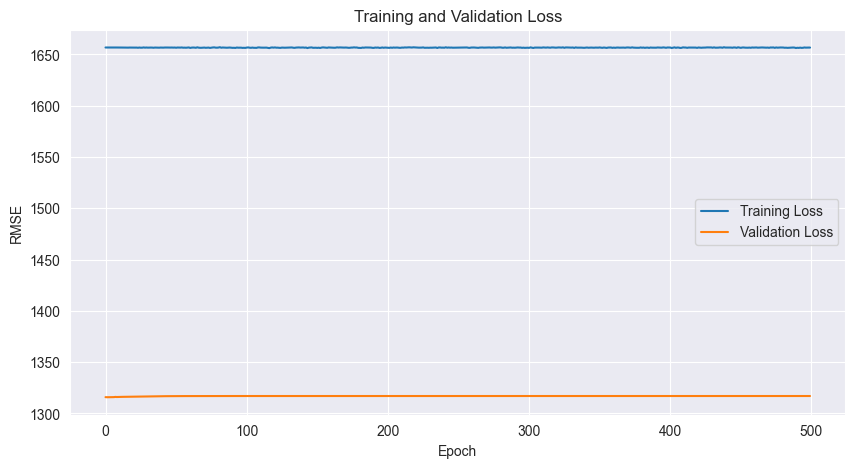

Final validation RMSE: 1315.8622
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1552.0541, Val RMSE: 2262.7532
Epoch 10: Train RMSE: 1551.7505, Val RMSE: 2262.3547



  6%|▌         | 29/500 [00:00<00:01, 284.51it/s]

Epoch 20: Train RMSE: 1551.9877, Val RMSE: 2262.0356
Epoch 30: Train RMSE: 1551.9194, Val RMSE: 2261.7935
Epoch 40: Train RMSE: 1551.8751, Val RMSE: 2261.6565
Epoch 50: Train RMSE: 1551.8995, Val RMSE: 2261.5759



 12%|█▏        | 61/500 [00:00<00:01, 304.68it/s]

Epoch 60: Train RMSE: 1551.8757, Val RMSE: 2261.5322
Epoch 70: Train RMSE: 1551.8090, Val RMSE: 2261.5085
Epoch 80: Train RMSE: 1551.8519, Val RMSE: 2261.4956



 19%|█▉        | 94/500 [00:00<00:01, 314.81it/s]

Epoch 90: Train RMSE: 1551.8898, Val RMSE: 2261.4885
Epoch 100: Train RMSE: 1551.8531, Val RMSE: 2261.4846
Epoch 110: Train RMSE: 1551.8505, Val RMSE: 2261.4827
Epoch 120: Train RMSE: 1551.8551, Val RMSE: 2261.4817



 25%|██▌       | 126/500 [00:00<00:01, 316.00it/s]

Epoch 130: Train RMSE: 1551.8870, Val RMSE: 2261.4812
Epoch 140: Train RMSE: 1551.8458, Val RMSE: 2261.4807
Epoch 150: Train RMSE: 1551.8807, Val RMSE: 2261.4807



 38%|███▊      | 192/500 [00:00<00:00, 318.21it/s]

Epoch 160: Train RMSE: 1551.8761, Val RMSE: 2261.4807
Epoch 170: Train RMSE: 1551.8718, Val RMSE: 2261.4807
Epoch 180: Train RMSE: 1551.8754, Val RMSE: 2261.4805
Epoch 190: Train RMSE: 1551.8746, Val RMSE: 2261.4805
Epoch 200: Train RMSE: 1551.9113, Val RMSE: 2261.4805



 45%|████▍     | 224/500 [00:00<00:00, 316.48it/s]

Epoch 210: Train RMSE: 1551.8679, Val RMSE: 2261.4805
Epoch 220: Train RMSE: 1551.8756, Val RMSE: 2261.4805



 52%|█████▏    | 262/500 [00:00<00:00, 334.86it/s]

Epoch 230: Train RMSE: 1551.8409, Val RMSE: 2261.4805
Epoch 240: Train RMSE: 1551.8815, Val RMSE: 2261.4805
Epoch 250: Train RMSE: 1551.8536, Val RMSE: 2261.4805
Epoch 260: Train RMSE: 1551.8076, Val RMSE: 2261.4805
Epoch 270: Train RMSE: 1551.8512, Val RMSE: 2261.4805
Epoch 280: Train RMSE: 1551.8529, Val RMSE: 2261.4805



 59%|█████▉    | 297/500 [00:00<00:00, 339.06it/s]

Epoch 290: Train RMSE: 1551.8739, Val RMSE: 2261.4805
Epoch 300: Train RMSE: 1551.8705, Val RMSE: 2261.4805



 66%|██████▌   | 331/500 [00:01<00:00, 336.51it/s]

Epoch 310: Train RMSE: 1551.8746, Val RMSE: 2261.4805
Epoch 320: Train RMSE: 1551.8466, Val RMSE: 2261.4805
Epoch 330: Train RMSE: 1551.8287, Val RMSE: 2261.4805
Epoch 340: Train RMSE: 1551.7820, Val RMSE: 2261.4805
Epoch 350: Train RMSE: 1551.8613, Val RMSE: 2261.4805



 73%|███████▎  | 365/500 [00:01<00:00, 334.04it/s]

Epoch 360: Train RMSE: 1551.8560, Val RMSE: 2261.4805
Epoch 370: Train RMSE: 1551.8778, Val RMSE: 2261.4805



 80%|███████▉  | 399/500 [00:01<00:00, 326.54it/s]

Epoch 380: Train RMSE: 1551.8661, Val RMSE: 2261.4805
Epoch 390: Train RMSE: 1551.8813, Val RMSE: 2261.4805
Epoch 400: Train RMSE: 1551.8783, Val RMSE: 2261.4805
Epoch 410: Train RMSE: 1551.8687, Val RMSE: 2261.4805
Epoch 420: Train RMSE: 1551.8230, Val RMSE: 2261.4805



 86%|████████▋ | 432/500 [00:01<00:00, 325.33it/s]

Epoch 430: Train RMSE: 1551.8363, Val RMSE: 2261.4805
Epoch 440: Train RMSE: 1551.8406, Val RMSE: 2261.4805



 93%|█████████▎| 467/500 [00:01<00:00, 332.18it/s]

Epoch 450: Train RMSE: 1551.8055, Val RMSE: 2261.4805
Epoch 460: Train RMSE: 1551.7965, Val RMSE: 2261.4805
Epoch 470: Train RMSE: 1551.8497, Val RMSE: 2261.4805
Epoch 480: Train RMSE: 1551.8448, Val RMSE: 2261.4805
Epoch 490: Train RMSE: 1551.8402, Val RMSE: 2261.4805


100%|██████████| 500/500 [00:01<00:00, 325.44it/s]


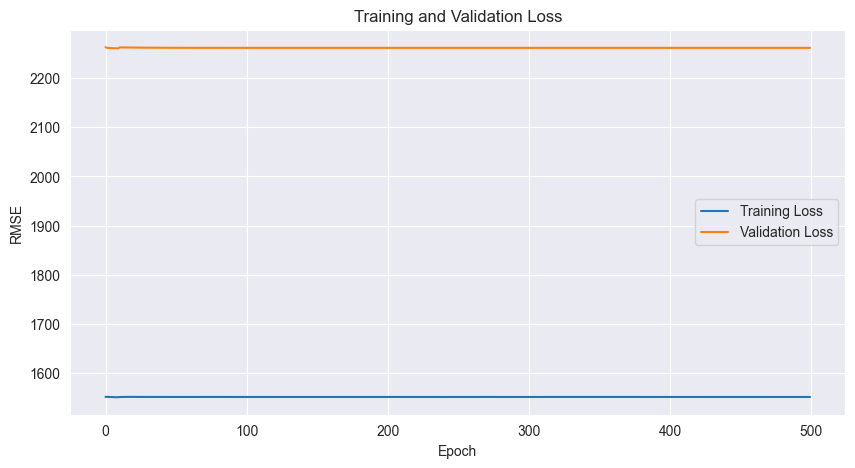

Final validation RMSE: 2260.4624
  Fold 4/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1755.9194, Val RMSE: 2261.8494
Epoch 10: Train RMSE: 1754.8485, Val RMSE: 2262.1470



  5%|▌         | 25/500 [00:00<00:01, 244.23it/s]

Epoch 20: Train RMSE: 1754.5001, Val RMSE: 2262.3049
Epoch 30: Train RMSE: 1754.1254, Val RMSE: 2262.4080
Epoch 40: Train RMSE: 1754.0231, Val RMSE: 2262.4658
Epoch 50: Train RMSE: 1753.9167, Val RMSE: 2262.5015



 11%|█         | 55/500 [00:00<00:01, 270.32it/s]

Epoch 60: Train RMSE: 1753.9258, Val RMSE: 2262.5227
Epoch 70: Train RMSE: 1753.7682, Val RMSE: 2262.5325



 23%|██▎       | 116/500 [00:00<00:01, 292.88it/s]

Epoch 80: Train RMSE: 1754.0466, Val RMSE: 2262.5381
Epoch 90: Train RMSE: 1753.8926, Val RMSE: 2262.5413
Epoch 100: Train RMSE: 1753.9370, Val RMSE: 2262.5430
Epoch 110: Train RMSE: 1753.8367, Val RMSE: 2262.5437
Epoch 120: Train RMSE: 1753.7456, Val RMSE: 2262.5442
Epoch 130: Train RMSE: 1753.9829, Val RMSE: 2262.5444



 35%|███▌      | 175/500 [00:00<00:01, 271.33it/s]

Epoch 140: Train RMSE: 1753.5732, Val RMSE: 2262.5444
Epoch 150: Train RMSE: 1753.9465, Val RMSE: 2262.5444
Epoch 160: Train RMSE: 1753.6727, Val RMSE: 2262.5447
Epoch 170: Train RMSE: 1753.7101, Val RMSE: 2262.5447
Epoch 180: Train RMSE: 1753.7693, Val RMSE: 2262.5447
Epoch 190: Train RMSE: 1753.8910, Val RMSE: 2262.5447



 47%|████▋     | 235/500 [00:00<00:00, 281.46it/s]

Epoch 200: Train RMSE: 1753.8826, Val RMSE: 2262.5447
Epoch 210: Train RMSE: 1753.6771, Val RMSE: 2262.5447
Epoch 220: Train RMSE: 1753.8484, Val RMSE: 2262.5447
Epoch 230: Train RMSE: 1753.8256, Val RMSE: 2262.5447
Epoch 240: Train RMSE: 1753.7369, Val RMSE: 2262.5447
Epoch 250: Train RMSE: 1753.9814, Val RMSE: 2262.5447



 59%|█████▊    | 293/500 [00:01<00:00, 281.59it/s]

Epoch 260: Train RMSE: 1754.0653, Val RMSE: 2262.5447
Epoch 270: Train RMSE: 1753.7872, Val RMSE: 2262.5447
Epoch 280: Train RMSE: 1753.6591, Val RMSE: 2262.5449
Epoch 290: Train RMSE: 1753.8445, Val RMSE: 2262.5447
Epoch 300: Train RMSE: 1753.9730, Val RMSE: 2262.5447
Epoch 310: Train RMSE: 1753.7864, Val RMSE: 2262.5447



 70%|███████   | 352/500 [00:01<00:00, 286.02it/s]

Epoch 320: Train RMSE: 1753.8651, Val RMSE: 2262.5447
Epoch 330: Train RMSE: 1753.7214, Val RMSE: 2262.5447
Epoch 340: Train RMSE: 1753.7804, Val RMSE: 2262.5447
Epoch 350: Train RMSE: 1753.8070, Val RMSE: 2262.5447
Epoch 360: Train RMSE: 1753.9149, Val RMSE: 2262.5447
Epoch 370: Train RMSE: 1754.0280, Val RMSE: 2262.5447



 83%|████████▎ | 415/500 [00:01<00:00, 300.90it/s]

Epoch 380: Train RMSE: 1753.8999, Val RMSE: 2262.5447
Epoch 390: Train RMSE: 1753.9113, Val RMSE: 2262.5447
Epoch 400: Train RMSE: 1753.6553, Val RMSE: 2262.5447
Epoch 410: Train RMSE: 1753.9635, Val RMSE: 2262.5447
Epoch 420: Train RMSE: 1753.6621, Val RMSE: 2262.5447
Epoch 430: Train RMSE: 1753.7220, Val RMSE: 2262.5447
Epoch 440: Train RMSE: 1753.8264, Val RMSE: 2262.5447



100%|██████████| 500/500 [00:01<00:00, 289.79it/s]

Epoch 450: Train RMSE: 1753.8777, Val RMSE: 2262.5447
Epoch 460: Train RMSE: 1753.8876, Val RMSE: 2262.5447
Epoch 470: Train RMSE: 1753.9401, Val RMSE: 2262.5447
Epoch 480: Train RMSE: 1753.9236, Val RMSE: 2262.5449
Epoch 490: Train RMSE: 1753.6952, Val RMSE: 2262.5447


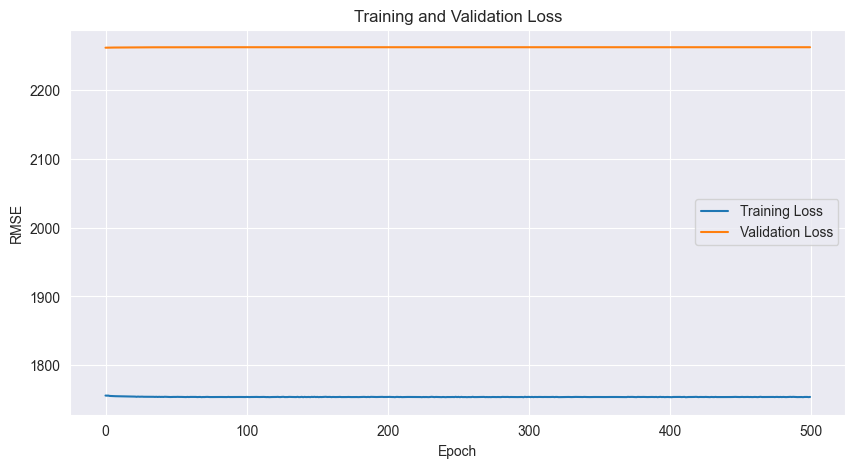

Final validation RMSE: 2261.8494
  Fold 5/5
Input size: 437



  4%|▍         | 22/500 [00:00<00:02, 219.12it/s]

Epoch 0: Train RMSE: 1867.6842, Val RMSE: 2493.3928
Epoch 10: Train RMSE: 1866.8666, Val RMSE: 2494.2097
Epoch 20: Train RMSE: 1866.7043, Val RMSE: 2494.5789
Epoch 30: Train RMSE: 1866.5439, Val RMSE: 2494.8687
Epoch 40: Train RMSE: 1866.4301, Val RMSE: 2495.0117



 19%|█▉        | 95/500 [00:00<00:01, 234.15it/s]

Epoch 50: Train RMSE: 1866.3800, Val RMSE: 2495.0901
Epoch 60: Train RMSE: 1866.3069, Val RMSE: 2495.1362
Epoch 70: Train RMSE: 1866.3920, Val RMSE: 2495.1616
Epoch 80: Train RMSE: 1866.3251, Val RMSE: 2495.1748
Epoch 90: Train RMSE: 1866.2894, Val RMSE: 2495.1816



 28%|██▊       | 142/500 [00:00<00:01, 226.15it/s]

Epoch 100: Train RMSE: 1866.2018, Val RMSE: 2495.1848
Epoch 110: Train RMSE: 1866.2969, Val RMSE: 2495.1868
Epoch 120: Train RMSE: 1866.3832, Val RMSE: 2495.1877
Epoch 130: Train RMSE: 1866.3373, Val RMSE: 2495.1882
Epoch 140: Train RMSE: 1866.3722, Val RMSE: 2495.1885



 39%|███▊      | 193/500 [00:00<00:01, 239.03it/s]

Epoch 150: Train RMSE: 1866.2574, Val RMSE: 2495.1885
Epoch 160: Train RMSE: 1866.1986, Val RMSE: 2495.1887
Epoch 170: Train RMSE: 1866.1605, Val RMSE: 2495.1887
Epoch 180: Train RMSE: 1866.2660, Val RMSE: 2495.1887
Epoch 190: Train RMSE: 1866.4795, Val RMSE: 2495.1887
Epoch 200: Train RMSE: 1866.2596, Val RMSE: 2495.1887



 49%|████▊     | 243/500 [00:01<00:01, 237.79it/s]

Epoch 210: Train RMSE: 1866.2146, Val RMSE: 2495.1887
Epoch 220: Train RMSE: 1866.3497, Val RMSE: 2495.1887
Epoch 230: Train RMSE: 1866.1605, Val RMSE: 2495.1887
Epoch 240: Train RMSE: 1866.3311, Val RMSE: 2495.1887
Epoch 250: Train RMSE: 1866.2688, Val RMSE: 2495.1887



 58%|█████▊    | 292/500 [00:01<00:00, 231.22it/s]

Epoch 260: Train RMSE: 1866.3157, Val RMSE: 2495.1887
Epoch 270: Train RMSE: 1866.2904, Val RMSE: 2495.1887
Epoch 280: Train RMSE: 1866.3634, Val RMSE: 2495.1887
Epoch 290: Train RMSE: 1866.3842, Val RMSE: 2495.1887
Epoch 300: Train RMSE: 1866.3340, Val RMSE: 2495.1887



 69%|██████▊   | 343/500 [00:01<00:00, 241.64it/s]

Epoch 310: Train RMSE: 1866.3179, Val RMSE: 2495.1887
Epoch 320: Train RMSE: 1866.2263, Val RMSE: 2495.1887
Epoch 330: Train RMSE: 1866.3542, Val RMSE: 2495.1887
Epoch 340: Train RMSE: 1866.2510, Val RMSE: 2495.1887
Epoch 350: Train RMSE: 1866.3126, Val RMSE: 2495.1887



 79%|███████▊  | 393/500 [00:01<00:00, 238.10it/s]

Epoch 360: Train RMSE: 1866.3629, Val RMSE: 2495.1887
Epoch 370: Train RMSE: 1866.3094, Val RMSE: 2495.1887
Epoch 380: Train RMSE: 1866.2455, Val RMSE: 2495.1887
Epoch 390: Train RMSE: 1866.3325, Val RMSE: 2495.1887
Epoch 400: Train RMSE: 1866.3528, Val RMSE: 2495.1887



 88%|████████▊ | 441/500 [00:01<00:00, 229.94it/s]

Epoch 410: Train RMSE: 1866.2664, Val RMSE: 2495.1887
Epoch 420: Train RMSE: 1866.3810, Val RMSE: 2495.1887
Epoch 430: Train RMSE: 1866.2418, Val RMSE: 2495.1887
Epoch 440: Train RMSE: 1866.3315, Val RMSE: 2495.1887
Epoch 450: Train RMSE: 1866.2314, Val RMSE: 2495.1887



100%|██████████| 500/500 [00:02<00:00, 232.47it/s]

Epoch 460: Train RMSE: 1866.3928, Val RMSE: 2495.1887
Epoch 470: Train RMSE: 1866.4225, Val RMSE: 2495.1887
Epoch 480: Train RMSE: 1866.2266, Val RMSE: 2495.1887
Epoch 490: Train RMSE: 1866.2916, Val RMSE: 2495.1887


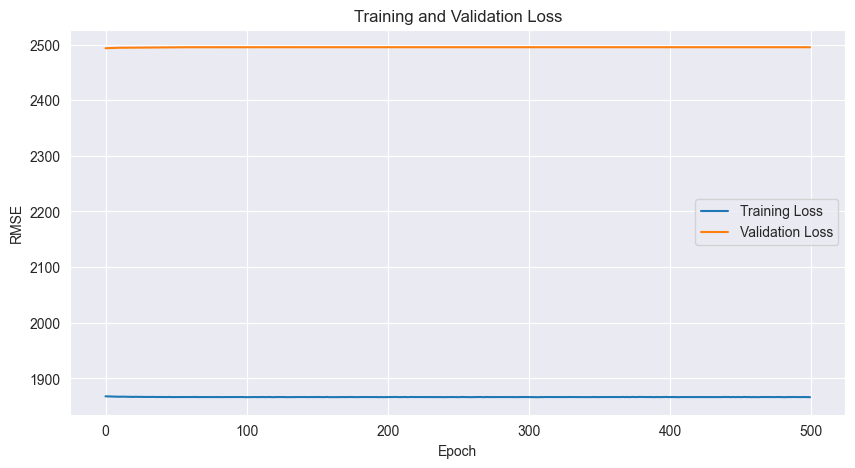

Final validation RMSE: 2493.3928
  Avg RMSE: 2032.1082 ± 417.6079

Testing: hidden_size=128, layers=5, lr=0.0001
  Fold 1/5
Input size: 437



  4%|▍         | 21/500 [00:00<00:02, 202.75it/s]

Epoch 0: Train RMSE: 1467.8450, Val RMSE: 1828.8905
Epoch 10: Train RMSE: 1467.6771, Val RMSE: 1828.9124
Epoch 20: Train RMSE: 1467.9332, Val RMSE: 1828.9008
Epoch 30: Train RMSE: 1467.7551, Val RMSE: 1828.8931



  8%|▊         | 42/500 [00:00<00:02, 206.93it/s]

Epoch 40: Train RMSE: 1467.8219, Val RMSE: 1828.8973



 13%|█▎        | 63/500 [00:00<00:02, 200.86it/s]

Epoch 50: Train RMSE: 1467.8398, Val RMSE: 1828.8971
Epoch 60: Train RMSE: 1467.6604, Val RMSE: 1828.8973
Epoch 70: Train RMSE: 1467.7246, Val RMSE: 1828.8976
Epoch 80: Train RMSE: 1467.7653, Val RMSE: 1828.8976



 17%|█▋        | 85/500 [00:00<00:01, 207.92it/s]

Epoch 90: Train RMSE: 1467.7861, Val RMSE: 1828.8977



 26%|██▌       | 128/500 [00:00<00:01, 211.14it/s]

Epoch 100: Train RMSE: 1467.7876, Val RMSE: 1828.8978
Epoch 110: Train RMSE: 1467.7737, Val RMSE: 1828.8977
Epoch 120: Train RMSE: 1467.7008, Val RMSE: 1828.8978
Epoch 130: Train RMSE: 1467.9606, Val RMSE: 1828.8978
Epoch 140: Train RMSE: 1467.8744, Val RMSE: 1828.8978



 34%|███▍      | 171/500 [00:00<00:01, 206.37it/s]

Epoch 150: Train RMSE: 1467.5289, Val RMSE: 1828.8978
Epoch 160: Train RMSE: 1467.8616, Val RMSE: 1828.8978
Epoch 170: Train RMSE: 1467.6416, Val RMSE: 1828.8978
Epoch 180: Train RMSE: 1467.6350, Val RMSE: 1828.8978



 39%|███▊      | 193/500 [00:00<00:01, 208.51it/s]

Epoch 190: Train RMSE: 1467.8461, Val RMSE: 1828.8978



 43%|████▎     | 214/500 [00:01<00:01, 189.54it/s]

Epoch 200: Train RMSE: 1467.7023, Val RMSE: 1828.8978
Epoch 210: Train RMSE: 1467.6475, Val RMSE: 1828.8978
Epoch 220: Train RMSE: 1467.7056, Val RMSE: 1828.8979
Epoch 230: Train RMSE: 1467.6166, Val RMSE: 1828.8979



 51%|█████     | 253/500 [00:01<00:01, 180.24it/s]

Epoch 240: Train RMSE: 1467.7292, Val RMSE: 1828.8979
Epoch 250: Train RMSE: 1468.1428, Val RMSE: 1828.8979
Epoch 260: Train RMSE: 1467.7897, Val RMSE: 1828.8978



 55%|█████▍    | 273/500 [00:01<00:01, 185.12it/s]

Epoch 270: Train RMSE: 1467.9264, Val RMSE: 1828.8978



 59%|█████▉    | 294/500 [00:01<00:01, 191.84it/s]

Epoch 280: Train RMSE: 1467.8096, Val RMSE: 1828.8978
Epoch 290: Train RMSE: 1467.8063, Val RMSE: 1828.8978
Epoch 300: Train RMSE: 1467.7421, Val RMSE: 1828.8978
Epoch 310: Train RMSE: 1467.8065, Val RMSE: 1828.8978



 64%|██████▎   | 318/500 [00:01<00:00, 204.83it/s]

Epoch 320: Train RMSE: 1467.3967, Val RMSE: 1828.8978



 73%|███████▎  | 364/500 [00:01<00:00, 211.69it/s]

Epoch 330: Train RMSE: 1467.9335, Val RMSE: 1828.8978
Epoch 340: Train RMSE: 1467.7511, Val RMSE: 1828.8978
Epoch 350: Train RMSE: 1467.6703, Val RMSE: 1828.8978
Epoch 360: Train RMSE: 1467.8264, Val RMSE: 1828.8978
Epoch 370: Train RMSE: 1467.5103, Val RMSE: 1828.8978



 82%|████████▏ | 408/500 [00:02<00:00, 206.47it/s]

Epoch 380: Train RMSE: 1467.7251, Val RMSE: 1828.8978
Epoch 390: Train RMSE: 1467.6654, Val RMSE: 1828.8978
Epoch 400: Train RMSE: 1467.7904, Val RMSE: 1828.8978
Epoch 410: Train RMSE: 1467.6249, Val RMSE: 1828.8978
Epoch 420: Train RMSE: 1467.8918, Val RMSE: 1828.8978



 91%|█████████▏| 457/500 [00:02<00:00, 222.45it/s]

Epoch 430: Train RMSE: 1467.5543, Val RMSE: 1828.8978
Epoch 440: Train RMSE: 1467.8052, Val RMSE: 1828.8978
Epoch 450: Train RMSE: 1467.6277, Val RMSE: 1828.8978
Epoch 460: Train RMSE: 1467.9233, Val RMSE: 1828.8978
Epoch 470: Train RMSE: 1467.7084, Val RMSE: 1828.8978



100%|██████████| 500/500 [00:02<00:00, 205.25it/s]

Epoch 480: Train RMSE: 1467.5295, Val RMSE: 1828.8978
Epoch 490: Train RMSE: 1467.7168, Val RMSE: 1828.8978


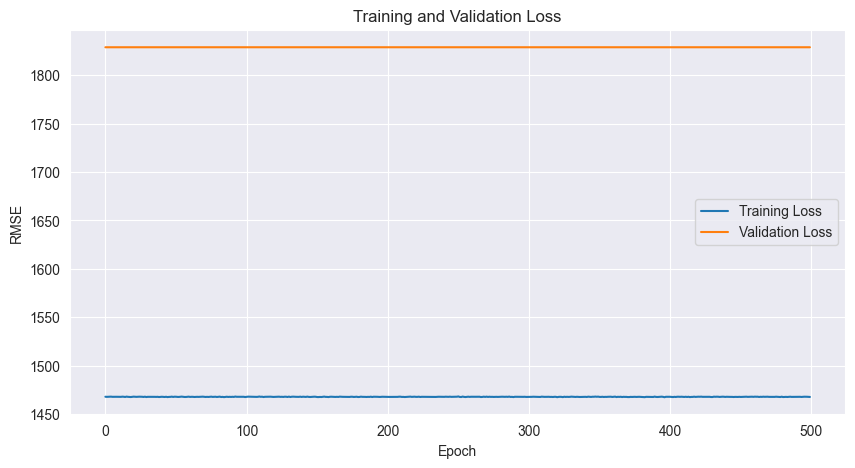

Final validation RMSE: 1828.8652
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.7689, Val RMSE: 1315.9646



  4%|▎         | 18/500 [00:00<00:02, 176.75it/s]

Epoch 10: Train RMSE: 1656.6815, Val RMSE: 1316.0750
Epoch 20: Train RMSE: 1656.8224, Val RMSE: 1316.1177
Epoch 30: Train RMSE: 1656.4314, Val RMSE: 1316.1299



  8%|▊         | 38/500 [00:00<00:02, 187.94it/s]

Epoch 40: Train RMSE: 1656.6184, Val RMSE: 1316.1364



 15%|█▌        | 76/500 [00:00<00:02, 179.03it/s]

Epoch 50: Train RMSE: 1656.8629, Val RMSE: 1316.1378
Epoch 60: Train RMSE: 1656.6036, Val RMSE: 1316.1366
Epoch 70: Train RMSE: 1656.8085, Val RMSE: 1316.1361
Epoch 80: Train RMSE: 1656.6394, Val RMSE: 1316.1359



 22%|██▏       | 112/500 [00:00<00:02, 175.59it/s]

Epoch 90: Train RMSE: 1656.7008, Val RMSE: 1316.1361
Epoch 100: Train RMSE: 1656.7629, Val RMSE: 1316.1362
Epoch 110: Train RMSE: 1656.7975, Val RMSE: 1316.1364
Epoch 120: Train RMSE: 1656.3341, Val RMSE: 1316.1364



 30%|███       | 152/500 [00:00<00:01, 186.70it/s]

Epoch 130: Train RMSE: 1656.5868, Val RMSE: 1316.1364
Epoch 140: Train RMSE: 1656.7261, Val RMSE: 1316.1364
Epoch 150: Train RMSE: 1656.8967, Val RMSE: 1316.1364
Epoch 160: Train RMSE: 1656.6898, Val RMSE: 1316.1364



 38%|███▊      | 191/500 [00:01<00:01, 189.38it/s]

Epoch 170: Train RMSE: 1656.6875, Val RMSE: 1316.1364
Epoch 180: Train RMSE: 1656.7848, Val RMSE: 1316.1364
Epoch 190: Train RMSE: 1656.5773, Val RMSE: 1316.1364
Epoch 200: Train RMSE: 1656.7699, Val RMSE: 1316.1364



 46%|████▌     | 230/500 [00:01<00:01, 186.39it/s]


Epoch 210: Train RMSE: 1656.6089, Val RMSE: 1316.1364
Epoch 220: Train RMSE: 1656.5806, Val RMSE: 1316.1364
Epoch 230: Train RMSE: 1656.7665, Val RMSE: 1316.1365
Epoch 240: Train RMSE: 1656.8132, Val RMSE: 1316.1365
Epoch 250: Train RMSE: 1656.7208, Val RMSE: 1316.1365


 60%|█████▉    | 298/500 [00:01<00:00, 208.93it/s]

Epoch 260: Train RMSE: 1656.6836, Val RMSE: 1316.1365
Epoch 270: Train RMSE: 1656.7812, Val RMSE: 1316.1365
Epoch 280: Train RMSE: 1656.7023, Val RMSE: 1316.1365
Epoch 290: Train RMSE: 1656.7410, Val RMSE: 1316.1365
Epoch 300: Train RMSE: 1656.5640, Val RMSE: 1316.1364



 68%|██████▊   | 340/500 [00:01<00:00, 193.48it/s]

Epoch 310: Train RMSE: 1656.7773, Val RMSE: 1316.1364
Epoch 320: Train RMSE: 1656.7809, Val RMSE: 1316.1364
Epoch 330: Train RMSE: 1656.5232, Val RMSE: 1316.1364
Epoch 340: Train RMSE: 1656.6183, Val RMSE: 1316.1364



 76%|███████▌  | 379/500 [00:02<00:00, 182.10it/s]

Epoch 350: Train RMSE: 1656.6746, Val RMSE: 1316.1364
Epoch 360: Train RMSE: 1656.6566, Val RMSE: 1316.1364
Epoch 370: Train RMSE: 1656.6348, Val RMSE: 1316.1364
Epoch 380: Train RMSE: 1656.3687, Val RMSE: 1316.1364



 84%|████████▍ | 421/500 [00:02<00:00, 192.87it/s]

Epoch 390: Train RMSE: 1656.6641, Val RMSE: 1316.1364
Epoch 400: Train RMSE: 1656.6721, Val RMSE: 1316.1364
Epoch 410: Train RMSE: 1656.5554, Val RMSE: 1316.1365
Epoch 420: Train RMSE: 1656.6866, Val RMSE: 1316.1365



 92%|█████████▏| 462/500 [00:02<00:00, 191.81it/s]

Epoch 430: Train RMSE: 1656.5023, Val RMSE: 1316.1365
Epoch 440: Train RMSE: 1656.7709, Val RMSE: 1316.1365
Epoch 450: Train RMSE: 1656.6554, Val RMSE: 1316.1365
Epoch 460: Train RMSE: 1656.6123, Val RMSE: 1316.1365



100%|██████████| 500/500 [00:02<00:00, 189.93it/s]


Epoch 470: Train RMSE: 1656.7107, Val RMSE: 1316.1365
Epoch 480: Train RMSE: 1656.7052, Val RMSE: 1316.1365
Epoch 490: Train RMSE: 1656.7010, Val RMSE: 1316.1365


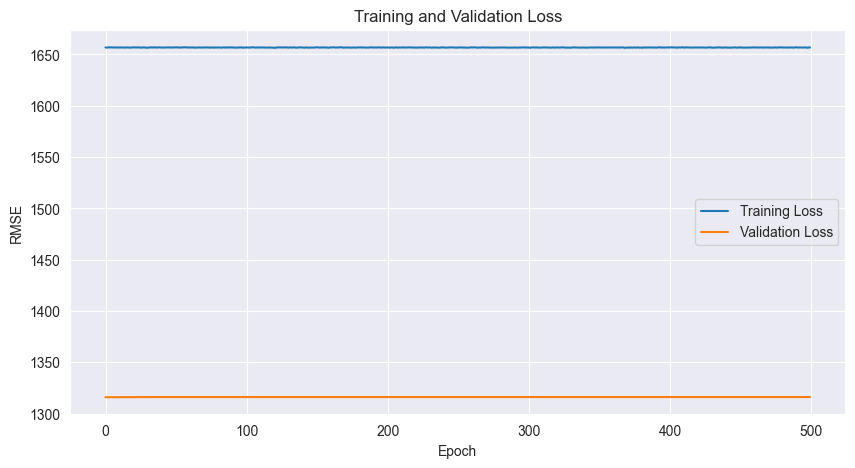

Final validation RMSE: 1315.9646
  Fold 3/5
Input size: 437



  2%|▏         | 12/500 [00:00<00:04, 112.15it/s]

Epoch 0: Train RMSE: 1552.1001, Val RMSE: 2262.6023
Epoch 10: Train RMSE: 1552.0959, Val RMSE: 2262.4150
Epoch 20: Train RMSE: 1552.1124, Val RMSE: 2262.4812



 12%|█▏        | 61/500 [00:00<00:02, 151.73it/s]

Epoch 30: Train RMSE: 1552.0183, Val RMSE: 2262.5046
Epoch 40: Train RMSE: 1552.1659, Val RMSE: 2262.4851
Epoch 50: Train RMSE: 1552.0771, Val RMSE: 2262.4797
Epoch 60: Train RMSE: 1552.0543, Val RMSE: 2262.4824



 19%|█▉        | 97/500 [00:00<00:02, 167.15it/s]

Epoch 70: Train RMSE: 1552.0402, Val RMSE: 2262.4773
Epoch 80: Train RMSE: 1552.1284, Val RMSE: 2262.4761
Epoch 90: Train RMSE: 1551.9358, Val RMSE: 2262.4756
Epoch 100: Train RMSE: 1552.0641, Val RMSE: 2262.4753



 26%|██▌       | 131/500 [00:00<00:02, 159.04it/s]

Epoch 110: Train RMSE: 1552.0615, Val RMSE: 2262.4751
Epoch 120: Train RMSE: 1552.0406, Val RMSE: 2262.4749
Epoch 130: Train RMSE: 1552.0547, Val RMSE: 2262.4749
Epoch 140: Train RMSE: 1552.1289, Val RMSE: 2262.4749



 37%|███▋      | 184/500 [00:01<00:01, 169.92it/s]

Epoch 150: Train RMSE: 1551.9523, Val RMSE: 2262.4749
Epoch 160: Train RMSE: 1552.1400, Val RMSE: 2262.4749
Epoch 170: Train RMSE: 1552.0664, Val RMSE: 2262.4749
Epoch 180: Train RMSE: 1552.1017, Val RMSE: 2262.4749



 44%|████▍     | 221/500 [00:01<00:01, 171.41it/s]

Epoch 190: Train RMSE: 1552.1135, Val RMSE: 2262.4749
Epoch 200: Train RMSE: 1552.0420, Val RMSE: 2262.4749
Epoch 210: Train RMSE: 1552.0343, Val RMSE: 2262.4749
Epoch 220: Train RMSE: 1551.9991, Val RMSE: 2262.4749



 52%|█████▏    | 258/500 [00:01<00:01, 146.30it/s]

Epoch 230: Train RMSE: 1552.0638, Val RMSE: 2262.4746
Epoch 240: Train RMSE: 1552.0685, Val RMSE: 2262.4746
Epoch 250: Train RMSE: 1551.9926, Val RMSE: 2262.4749
Epoch 260: Train RMSE: 1552.1829, Val RMSE: 2262.4749



 58%|█████▊    | 292/500 [00:01<00:01, 151.20it/s]

Epoch 270: Train RMSE: 1552.1375, Val RMSE: 2262.4749
Epoch 280: Train RMSE: 1552.1003, Val RMSE: 2262.4749
Epoch 290: Train RMSE: 1552.0157, Val RMSE: 2262.4749
Epoch 300: Train RMSE: 1552.0602, Val RMSE: 2262.4749



 69%|██████▉   | 346/500 [00:02<00:00, 168.48it/s]

Epoch 310: Train RMSE: 1552.0380, Val RMSE: 2262.4749
Epoch 320: Train RMSE: 1552.0461, Val RMSE: 2262.4749
Epoch 330: Train RMSE: 1552.0532, Val RMSE: 2262.4749
Epoch 340: Train RMSE: 1552.0887, Val RMSE: 2262.4749



 76%|███████▋  | 382/500 [00:02<00:00, 169.13it/s]

Epoch 350: Train RMSE: 1552.0325, Val RMSE: 2262.4749
Epoch 360: Train RMSE: 1551.9781, Val RMSE: 2262.4749
Epoch 370: Train RMSE: 1552.0145, Val RMSE: 2262.4749
Epoch 380: Train RMSE: 1552.0540, Val RMSE: 2262.4749



 83%|████████▎ | 417/500 [00:02<00:00, 163.99it/s]

Epoch 390: Train RMSE: 1552.1388, Val RMSE: 2262.4749
Epoch 400: Train RMSE: 1552.0198, Val RMSE: 2262.4749
Epoch 410: Train RMSE: 1552.1663, Val RMSE: 2262.4749
Epoch 420: Train RMSE: 1552.0309, Val RMSE: 2262.4749



 90%|█████████ | 450/500 [00:02<00:00, 153.17it/s]

Epoch 430: Train RMSE: 1551.9940, Val RMSE: 2262.4749
Epoch 440: Train RMSE: 1552.0563, Val RMSE: 2262.4746
Epoch 450: Train RMSE: 1551.9991, Val RMSE: 2262.4746
Epoch 460: Train RMSE: 1551.9528, Val RMSE: 2262.4746



100%|██████████| 500/500 [00:03<00:00, 156.32it/s]

Epoch 470: Train RMSE: 1551.9366, Val RMSE: 2262.4746
Epoch 480: Train RMSE: 1552.0607, Val RMSE: 2262.4746
Epoch 490: Train RMSE: 1552.0857, Val RMSE: 2262.4746


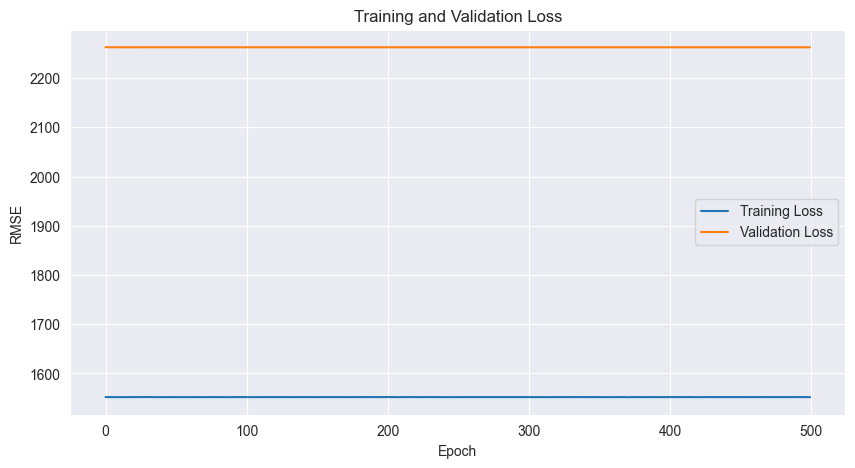

Final validation RMSE: 2262.3655
  Fold 4/5
Input size: 437



  3%|▎         | 13/500 [00:00<00:03, 124.91it/s]

Epoch 0: Train RMSE: 1755.9659, Val RMSE: 2261.8225
Epoch 10: Train RMSE: 1755.8817, Val RMSE: 2261.8457
Epoch 20: Train RMSE: 1755.7916, Val RMSE: 2261.8120



 12%|█▏        | 59/500 [00:00<00:03, 144.73it/s]

Epoch 30: Train RMSE: 1755.9368, Val RMSE: 2261.8496
Epoch 40: Train RMSE: 1755.8662, Val RMSE: 2261.8550
Epoch 50: Train RMSE: 1755.8085, Val RMSE: 2261.8586



 15%|█▍        | 74/500 [00:00<00:03, 138.37it/s]

Epoch 60: Train RMSE: 1755.7900, Val RMSE: 2261.8611
Epoch 70: Train RMSE: 1755.8989, Val RMSE: 2261.8625
Epoch 80: Train RMSE: 1755.8655, Val RMSE: 2261.8635



 21%|██        | 105/500 [00:00<00:02, 142.90it/s]

Epoch 90: Train RMSE: 1755.8663, Val RMSE: 2261.8640
Epoch 100: Train RMSE: 1755.8206, Val RMSE: 2261.8643
Epoch 110: Train RMSE: 1755.7935, Val RMSE: 2261.8645
Epoch 120: Train RMSE: 1755.9406, Val RMSE: 2261.8645



 31%|███       | 154/500 [00:01<00:02, 141.96it/s]

Epoch 130: Train RMSE: 1755.8030, Val RMSE: 2261.8645
Epoch 140: Train RMSE: 1755.7213, Val RMSE: 2261.8645
Epoch 150: Train RMSE: 1755.8173, Val RMSE: 2261.8645



 37%|███▋      | 186/500 [00:01<00:02, 148.80it/s]

Epoch 160: Train RMSE: 1755.7722, Val RMSE: 2261.8645
Epoch 170: Train RMSE: 1755.7888, Val RMSE: 2261.8645
Epoch 180: Train RMSE: 1755.8696, Val RMSE: 2261.8645
Epoch 190: Train RMSE: 1755.8358, Val RMSE: 2261.8645



 43%|████▎     | 217/500 [00:01<00:01, 149.50it/s]

Epoch 200: Train RMSE: 1755.7885, Val RMSE: 2261.8645
Epoch 210: Train RMSE: 1755.8782, Val RMSE: 2261.8645
Epoch 220: Train RMSE: 1755.7948, Val RMSE: 2261.8645



 49%|████▉     | 247/500 [00:01<00:01, 143.31it/s]

Epoch 230: Train RMSE: 1755.9203, Val RMSE: 2261.8645
Epoch 240: Train RMSE: 1755.7921, Val RMSE: 2261.8645
Epoch 250: Train RMSE: 1755.7169, Val RMSE: 2261.8645



 56%|█████▌    | 278/500 [00:01<00:01, 145.27it/s]

Epoch 260: Train RMSE: 1755.8058, Val RMSE: 2261.8645
Epoch 270: Train RMSE: 1755.8475, Val RMSE: 2261.8645
Epoch 280: Train RMSE: 1755.7775, Val RMSE: 2261.8645
Epoch 290: Train RMSE: 1755.8602, Val RMSE: 2261.8645



 65%|██████▌   | 326/500 [00:02<00:01, 142.17it/s]

Epoch 300: Train RMSE: 1755.7953, Val RMSE: 2261.8645
Epoch 310: Train RMSE: 1755.8987, Val RMSE: 2261.8645
Epoch 320: Train RMSE: 1755.8549, Val RMSE: 2261.8645



 72%|███████▏  | 358/500 [00:02<00:00, 148.53it/s]

Epoch 330: Train RMSE: 1755.7996, Val RMSE: 2261.8645
Epoch 340: Train RMSE: 1755.8258, Val RMSE: 2261.8645
Epoch 350: Train RMSE: 1755.8033, Val RMSE: 2261.8645
Epoch 360: Train RMSE: 1755.8655, Val RMSE: 2261.8645



 78%|███████▊  | 388/500 [00:02<00:00, 146.11it/s]

Epoch 370: Train RMSE: 1755.6952, Val RMSE: 2261.8645
Epoch 380: Train RMSE: 1755.8756, Val RMSE: 2261.8645
Epoch 390: Train RMSE: 1755.7888, Val RMSE: 2261.8645



 84%|████████▎ | 418/500 [00:02<00:00, 139.44it/s]

Epoch 400: Train RMSE: 1755.8550, Val RMSE: 2261.8645
Epoch 410: Train RMSE: 1755.7491, Val RMSE: 2261.8645
Epoch 420: Train RMSE: 1755.8156, Val RMSE: 2261.8645



 89%|████████▉ | 447/500 [00:03<00:00, 135.06it/s]

Epoch 430: Train RMSE: 1755.7568, Val RMSE: 2261.8645
Epoch 440: Train RMSE: 1755.8165, Val RMSE: 2261.8645
Epoch 450: Train RMSE: 1755.8894, Val RMSE: 2261.8645



 95%|█████████▌| 475/500 [00:03<00:00, 135.73it/s]

Epoch 460: Train RMSE: 1755.8644, Val RMSE: 2261.8645
Epoch 470: Train RMSE: 1755.8862, Val RMSE: 2261.8645
Epoch 480: Train RMSE: 1755.8667, Val RMSE: 2261.8645



100%|██████████| 500/500 [00:03<00:00, 142.48it/s]


Epoch 490: Train RMSE: 1755.7861, Val RMSE: 2261.8645


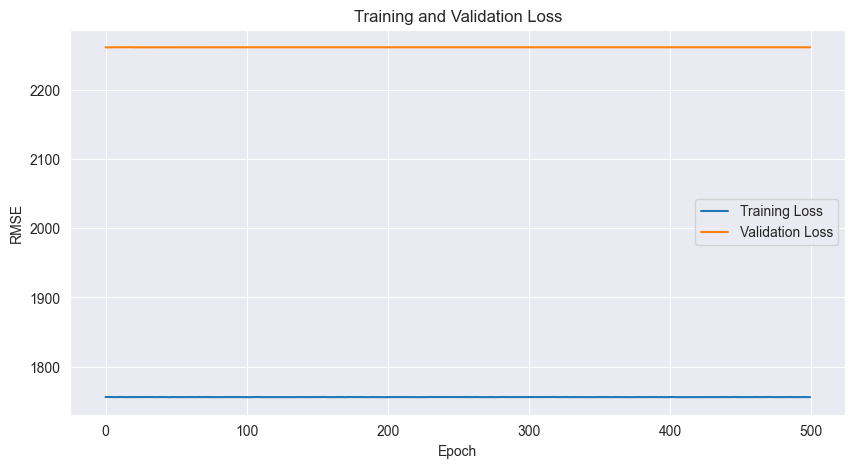

Final validation RMSE: 2261.7375
  Fold 5/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1867.6769, Val RMSE: 2493.1980



  2%|▏         | 11/500 [00:00<00:04, 106.02it/s]

Epoch 10: Train RMSE: 1867.6007, Val RMSE: 2493.2520


Epoch 20: Train RMSE: 1867.6783, Val RMSE: 2493.2629


  4%|▍         | 22/500 [00:00<00:04, 105.20it/s]

Epoch 30: Train RMSE: 1867.7299, Val RMSE: 2493.2742



  7%|▋         | 33/500 [00:00<00:04, 104.12it/s]

Epoch 40: Train RMSE: 1867.7054, Val RMSE: 2493.2708



 11%|█         | 55/500 [00:00<00:04, 101.01it/s]

Epoch 50: Train RMSE: 1867.6332, Val RMSE: 2493.2686
Epoch 60: Train RMSE: 1867.6819, Val RMSE: 2493.2690



 13%|█▎        | 66/500 [00:00<00:04, 101.83it/s]

Epoch 70: Train RMSE: 1867.6648, Val RMSE: 2493.2708



 18%|█▊        | 89/500 [00:00<00:03, 104.66it/s]

Epoch 80: Train RMSE: 1867.6527, Val RMSE: 2493.2717
Epoch 90: Train RMSE: 1867.6777, Val RMSE: 2493.2725



 20%|██        | 100/500 [00:00<00:03, 105.30it/s]

Epoch 100: Train RMSE: 1867.5974, Val RMSE: 2493.2727



 22%|██▏       | 111/500 [00:01<00:03, 102.38it/s]

Epoch 110: Train RMSE: 1867.7170, Val RMSE: 2493.2729



 24%|██▍       | 122/500 [00:01<00:03, 99.23it/s] 

Epoch 120: Train RMSE: 1867.6677, Val RMSE: 2493.2727



 26%|██▋       | 132/500 [00:01<00:03, 97.69it/s]

Epoch 130: Train RMSE: 1867.6119, Val RMSE: 2493.2727
Epoch 140: Train RMSE: 1867.6040, Val RMSE: 2493.2727



 29%|██▊       | 143/500 [00:01<00:03, 99.73it/s]

Epoch 150: Train RMSE: 1867.6735, Val RMSE: 2493.2727



 33%|███▎      | 165/500 [00:01<00:03, 101.91it/s]

Epoch 160: Train RMSE: 1867.7023, Val RMSE: 2493.2727
Epoch 170: Train RMSE: 1867.6411, Val RMSE: 2493.2727



 35%|███▌      | 176/500 [00:01<00:03, 101.17it/s]

Epoch 180: Train RMSE: 1867.6732, Val RMSE: 2493.2727



 40%|███▉      | 199/500 [00:01<00:02, 105.15it/s]

Epoch 190: Train RMSE: 1867.6665, Val RMSE: 2493.2727
Epoch 200: Train RMSE: 1867.6294, Val RMSE: 2493.2729



 42%|████▏     | 211/500 [00:02<00:02, 107.80it/s]

Epoch 210: Train RMSE: 1867.6852, Val RMSE: 2493.2727



 44%|████▍     | 222/500 [00:02<00:02, 105.56it/s]

Epoch 220: Train RMSE: 1867.6287, Val RMSE: 2493.2727
Epoch 230: Train RMSE: 1867.6278, Val RMSE: 2493.2727



 47%|████▋     | 233/500 [00:02<00:02, 103.52it/s]

Epoch 240: Train RMSE: 1867.6769, Val RMSE: 2493.2727



 51%|█████     | 255/500 [00:02<00:02, 100.77it/s]

Epoch 250: Train RMSE: 1867.6531, Val RMSE: 2493.2727
Epoch 260: Train RMSE: 1867.6958, Val RMSE: 2493.2727



 53%|█████▎    | 267/500 [00:02<00:02, 105.45it/s]

Epoch 270: Train RMSE: 1867.6665, Val RMSE: 2493.2727



 56%|█████▌    | 278/500 [00:02<00:02, 95.05it/s] 

Epoch 280: Train RMSE: 1867.7125, Val RMSE: 2493.2727



 58%|█████▊    | 288/500 [00:02<00:02, 88.07it/s]

Epoch 290: Train RMSE: 1867.6624, Val RMSE: 2493.2727



 62%|██████▏   | 308/500 [00:03<00:02, 89.57it/s]

Epoch 300: Train RMSE: 1867.7267, Val RMSE: 2493.2727



 64%|██████▍   | 320/500 [00:03<00:01, 96.91it/s]

Epoch 310: Train RMSE: 1867.6177, Val RMSE: 2493.2729
Epoch 320: Train RMSE: 1867.7462, Val RMSE: 2493.2727



 66%|██████▌   | 331/500 [00:03<00:01, 98.66it/s]

Epoch 330: Train RMSE: 1867.6813, Val RMSE: 2493.2729



 68%|██████▊   | 342/500 [00:03<00:01, 100.79it/s]

Epoch 340: Train RMSE: 1867.6733, Val RMSE: 2493.2729
Epoch 350: Train RMSE: 1867.6416, Val RMSE: 2493.2729



 75%|███████▍  | 374/500 [00:03<00:01, 101.49it/s]

Epoch 360: Train RMSE: 1867.6742, Val RMSE: 2493.2729
Epoch 370: Train RMSE: 1867.6967, Val RMSE: 2493.2727
Epoch 380: Train RMSE: 1867.6409, Val RMSE: 2493.2729



 82%|████████▏ | 409/500 [00:04<00:00, 102.27it/s]

Epoch 390: Train RMSE: 1867.6807, Val RMSE: 2493.2729
Epoch 400: Train RMSE: 1867.7035, Val RMSE: 2493.2729
Epoch 410: Train RMSE: 1867.7078, Val RMSE: 2493.2729



 87%|████████▋ | 434/500 [00:04<00:00, 110.96it/s]

Epoch 420: Train RMSE: 1867.7164, Val RMSE: 2493.2729
Epoch 430: Train RMSE: 1867.6910, Val RMSE: 2493.2729
Epoch 440: Train RMSE: 1867.6313, Val RMSE: 2493.2729



 94%|█████████▍| 471/500 [00:04<00:00, 108.70it/s]

Epoch 450: Train RMSE: 1867.7167, Val RMSE: 2493.2729
Epoch 460: Train RMSE: 1867.6244, Val RMSE: 2493.2727
Epoch 470: Train RMSE: 1867.6334, Val RMSE: 2493.2727



100%|██████████| 500/500 [00:04<00:00, 102.89it/s]

Epoch 480: Train RMSE: 1867.6479, Val RMSE: 2493.2729
Epoch 490: Train RMSE: 1867.7538, Val RMSE: 2493.2729


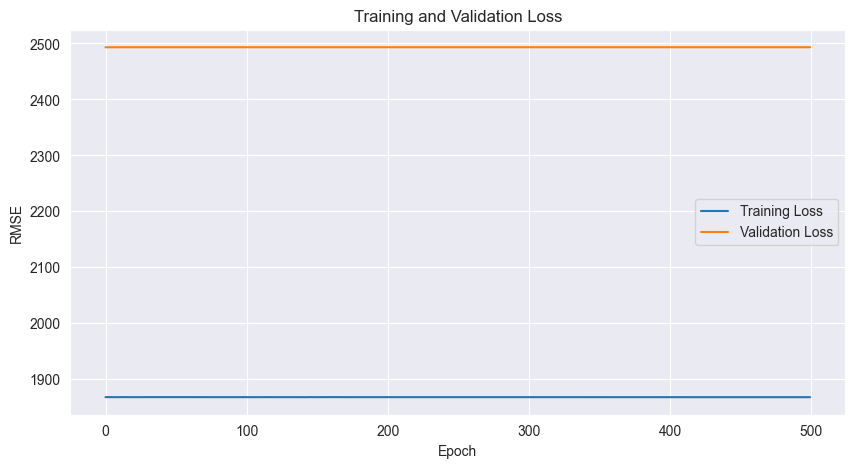

Final validation RMSE: 2493.1980
  Avg RMSE: 2032.4262 ± 417.7369

Testing: hidden_size=128, layers=5, lr=0.001
  Fold 1/5
Input size: 437



  4%|▍         | 20/500 [00:00<00:02, 193.88it/s]

Epoch 0: Train RMSE: 1467.9728, Val RMSE: 1828.9008
Epoch 10: Train RMSE: 1467.8706, Val RMSE: 1828.9869
Epoch 20: Train RMSE: 1467.8363, Val RMSE: 1828.9889
Epoch 30: Train RMSE: 1467.9047, Val RMSE: 1828.9893
Epoch 40: Train RMSE: 1467.8729, Val RMSE: 1828.9912



 18%|█▊        | 88/500 [00:00<00:01, 211.57it/s]

Epoch 50: Train RMSE: 1467.8737, Val RMSE: 1828.9941
Epoch 60: Train RMSE: 1467.7332, Val RMSE: 1828.9966
Epoch 70: Train RMSE: 1467.8411, Val RMSE: 1828.9980
Epoch 80: Train RMSE: 1467.7812, Val RMSE: 1828.9987
Epoch 90: Train RMSE: 1467.9523, Val RMSE: 1828.9991



 27%|██▋       | 136/500 [00:00<00:01, 225.82it/s]

Epoch 100: Train RMSE: 1467.6881, Val RMSE: 1828.9991
Epoch 110: Train RMSE: 1467.9880, Val RMSE: 1828.9993
Epoch 120: Train RMSE: 1467.6309, Val RMSE: 1828.9995
Epoch 130: Train RMSE: 1467.7566, Val RMSE: 1828.9995
Epoch 140: Train RMSE: 1467.6948, Val RMSE: 1828.9995
Epoch 150: Train RMSE: 1467.6539, Val RMSE: 1828.9996



 37%|███▋      | 183/500 [00:00<00:01, 219.01it/s]

Epoch 160: Train RMSE: 1467.7363, Val RMSE: 1828.9995
Epoch 170: Train RMSE: 1467.6610, Val RMSE: 1828.9995
Epoch 180: Train RMSE: 1467.8073, Val RMSE: 1828.9995
Epoch 190: Train RMSE: 1467.9437, Val RMSE: 1828.9995
Epoch 200: Train RMSE: 1467.5408, Val RMSE: 1828.9995



 51%|█████     | 255/500 [00:01<00:01, 231.63it/s]

Epoch 210: Train RMSE: 1467.8024, Val RMSE: 1828.9995
Epoch 220: Train RMSE: 1467.7959, Val RMSE: 1828.9995
Epoch 230: Train RMSE: 1467.6917, Val RMSE: 1828.9996
Epoch 240: Train RMSE: 1467.7827, Val RMSE: 1828.9996
Epoch 250: Train RMSE: 1467.8889, Val RMSE: 1828.9995



 56%|█████▌    | 280/500 [00:01<00:00, 236.51it/s]

Epoch 260: Train RMSE: 1467.8656, Val RMSE: 1828.9996
Epoch 270: Train RMSE: 1467.7045, Val RMSE: 1828.9996
Epoch 280: Train RMSE: 1467.7798, Val RMSE: 1828.9996
Epoch 290: Train RMSE: 1467.6086, Val RMSE: 1828.9996
Epoch 300: Train RMSE: 1467.7083, Val RMSE: 1828.9996



 65%|██████▌   | 326/500 [00:01<00:00, 194.75it/s]

Epoch 310: Train RMSE: 1467.8745, Val RMSE: 1828.9996
Epoch 320: Train RMSE: 1467.8197, Val RMSE: 1828.9996
Epoch 330: Train RMSE: 1467.8555, Val RMSE: 1828.9996
Epoch 340: Train RMSE: 1467.7637, Val RMSE: 1828.9996



 79%|███████▉  | 397/500 [00:01<00:00, 216.44it/s]

Epoch 350: Train RMSE: 1467.8932, Val RMSE: 1828.9995
Epoch 360: Train RMSE: 1467.7247, Val RMSE: 1828.9995
Epoch 370: Train RMSE: 1467.6661, Val RMSE: 1828.9996
Epoch 380: Train RMSE: 1467.7670, Val RMSE: 1828.9996
Epoch 390: Train RMSE: 1467.6780, Val RMSE: 1828.9996
Epoch 400: Train RMSE: 1467.7231, Val RMSE: 1828.9996



 89%|████████▉ | 444/500 [00:02<00:00, 217.25it/s]

Epoch 410: Train RMSE: 1467.8542, Val RMSE: 1828.9996
Epoch 420: Train RMSE: 1467.8107, Val RMSE: 1828.9996
Epoch 430: Train RMSE: 1467.6345, Val RMSE: 1828.9996
Epoch 440: Train RMSE: 1467.9117, Val RMSE: 1828.9995
Epoch 450: Train RMSE: 1467.7050, Val RMSE: 1828.9996



 98%|█████████▊| 488/500 [00:02<00:00, 200.57it/s]

Epoch 460: Train RMSE: 1467.8362, Val RMSE: 1828.9996
Epoch 470: Train RMSE: 1467.6510, Val RMSE: 1828.9996
Epoch 480: Train RMSE: 1467.8101, Val RMSE: 1828.9996
Epoch 490: Train RMSE: 1467.7454, Val RMSE: 1828.9996


100%|██████████| 500/500 [00:02<00:00, 212.07it/s]


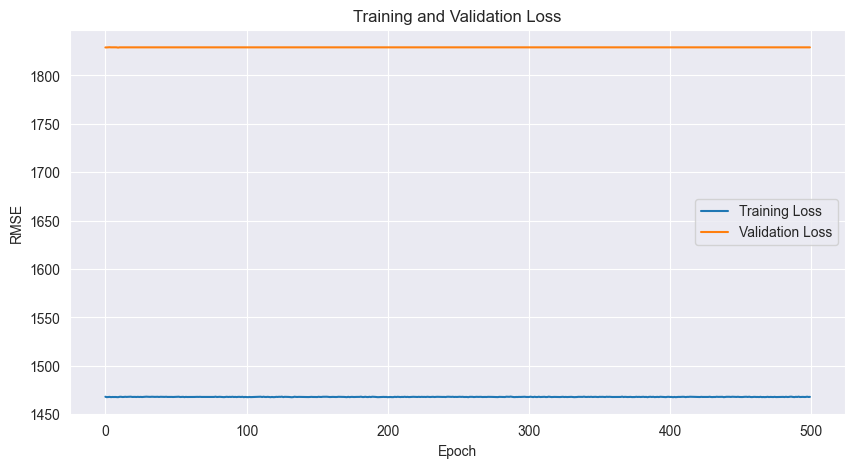

Final validation RMSE: 1828.7411
  Fold 2/5
Input size: 437



  4%|▎         | 18/500 [00:00<00:02, 176.89it/s]

Epoch 0: Train RMSE: 1656.6509, Val RMSE: 1315.7871
Epoch 10: Train RMSE: 1656.6746, Val RMSE: 1316.0980
Epoch 20: Train RMSE: 1656.7103, Val RMSE: 1316.1241
Epoch 30: Train RMSE: 1656.8047, Val RMSE: 1316.1910



 12%|█▏        | 59/500 [00:00<00:02, 181.59it/s]

Epoch 40: Train RMSE: 1656.5491, Val RMSE: 1316.2432
Epoch 50: Train RMSE: 1656.6432, Val RMSE: 1316.3038
Epoch 60: Train RMSE: 1656.5614, Val RMSE: 1316.3357
Epoch 70: Train RMSE: 1656.4015, Val RMSE: 1316.3466



 24%|██▍       | 119/500 [00:00<00:01, 192.66it/s]

Epoch 80: Train RMSE: 1656.6993, Val RMSE: 1316.3567
Epoch 90: Train RMSE: 1656.5251, Val RMSE: 1316.3611
Epoch 100: Train RMSE: 1656.5110, Val RMSE: 1316.3632
Epoch 110: Train RMSE: 1656.5717, Val RMSE: 1316.3643



 28%|██▊       | 139/500 [00:00<00:01, 186.86it/s]

Epoch 120: Train RMSE: 1656.7554, Val RMSE: 1316.3651
Epoch 130: Train RMSE: 1656.7725, Val RMSE: 1316.3654
Epoch 140: Train RMSE: 1656.6952, Val RMSE: 1316.3656
Epoch 150: Train RMSE: 1656.5364, Val RMSE: 1316.3656



 40%|████      | 202/500 [00:01<00:01, 199.94it/s]

Epoch 160: Train RMSE: 1656.5404, Val RMSE: 1316.3657
Epoch 170: Train RMSE: 1656.7299, Val RMSE: 1316.3657
Epoch 180: Train RMSE: 1656.6985, Val RMSE: 1316.3657
Epoch 190: Train RMSE: 1656.5955, Val RMSE: 1316.3657
Epoch 200: Train RMSE: 1656.6910, Val RMSE: 1316.3657



 49%|████▉     | 245/500 [00:01<00:01, 200.85it/s]

Epoch 210: Train RMSE: 1656.7816, Val RMSE: 1316.3657
Epoch 220: Train RMSE: 1656.5701, Val RMSE: 1316.3657
Epoch 230: Train RMSE: 1656.5990, Val RMSE: 1316.3657
Epoch 240: Train RMSE: 1656.6648, Val RMSE: 1316.3658
Epoch 250: Train RMSE: 1656.7455, Val RMSE: 1316.3658



 57%|█████▋    | 286/500 [00:01<00:01, 184.72it/s]

Epoch 260: Train RMSE: 1656.6088, Val RMSE: 1316.3658
Epoch 270: Train RMSE: 1656.7461, Val RMSE: 1316.3658
Epoch 280: Train RMSE: 1656.5724, Val RMSE: 1316.3657
Epoch 290: Train RMSE: 1656.8113, Val RMSE: 1316.3657



 65%|██████▌   | 325/500 [00:01<00:00, 187.40it/s]

Epoch 300: Train RMSE: 1656.5236, Val RMSE: 1316.3658
Epoch 310: Train RMSE: 1656.7280, Val RMSE: 1316.3658
Epoch 320: Train RMSE: 1656.6674, Val RMSE: 1316.3658
Epoch 330: Train RMSE: 1656.6869, Val RMSE: 1316.3658
Epoch 340: Train RMSE: 1656.6343, Val RMSE: 1316.3658



 73%|███████▎  | 367/500 [00:01<00:00, 187.43it/s]

Epoch 350: Train RMSE: 1656.6183, Val RMSE: 1316.3658
Epoch 360: Train RMSE: 1656.6121, Val RMSE: 1316.3658
Epoch 370: Train RMSE: 1656.8677, Val RMSE: 1316.3658
Epoch 380: Train RMSE: 1656.6755, Val RMSE: 1316.3660



 85%|████████▌ | 427/500 [00:02<00:00, 192.40it/s]

Epoch 390: Train RMSE: 1656.7112, Val RMSE: 1316.3658
Epoch 400: Train RMSE: 1656.6235, Val RMSE: 1316.3660
Epoch 410: Train RMSE: 1656.6813, Val RMSE: 1316.3660
Epoch 420: Train RMSE: 1656.5618, Val RMSE: 1316.3660
Epoch 430: Train RMSE: 1656.4576, Val RMSE: 1316.3660



 93%|█████████▎| 467/500 [00:02<00:00, 193.96it/s]

Epoch 440: Train RMSE: 1656.6763, Val RMSE: 1316.3658
Epoch 450: Train RMSE: 1656.5294, Val RMSE: 1316.3658
Epoch 460: Train RMSE: 1656.7164, Val RMSE: 1316.3660
Epoch 470: Train RMSE: 1656.5310, Val RMSE: 1316.3660
Epoch 480: Train RMSE: 1656.7260, Val RMSE: 1316.3660



100%|██████████| 500/500 [00:02<00:00, 188.91it/s]


Epoch 490: Train RMSE: 1656.7653, Val RMSE: 1316.3660


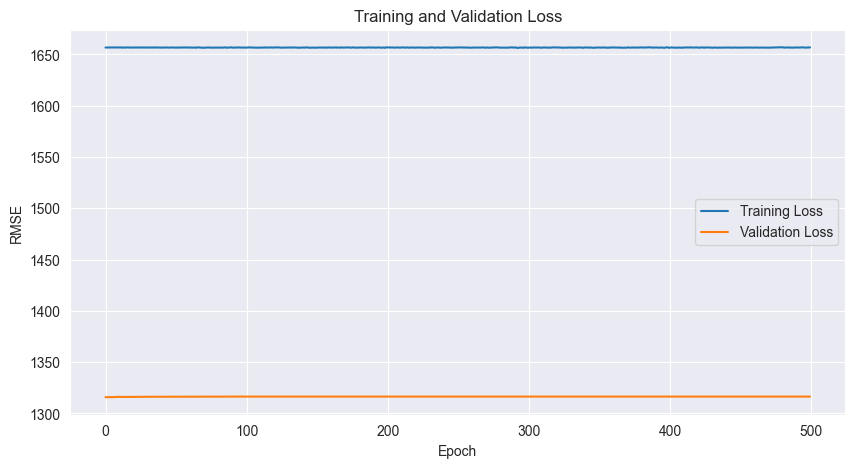

Final validation RMSE: 1315.7511
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1551.9867, Val RMSE: 2262.2429



  3%|▎         | 14/500 [00:00<00:03, 132.69it/s]

Epoch 10: Train RMSE: 1552.0952, Val RMSE: 2262.5063



  9%|▉         | 44/500 [00:00<00:04, 101.15it/s]

Epoch 20: Train RMSE: 1551.9666, Val RMSE: 2261.7783
Epoch 30: Train RMSE: 1551.9286, Val RMSE: 2261.7209
Epoch 40: Train RMSE: 1551.8650, Val RMSE: 2261.7446



 14%|█▍        | 69/500 [00:00<00:04, 104.62it/s]

Epoch 50: Train RMSE: 1551.8075, Val RMSE: 2261.6621
Epoch 60: Train RMSE: 1551.9084, Val RMSE: 2261.6077
Epoch 70: Train RMSE: 1551.8777, Val RMSE: 2261.5818



 19%|█▉        | 94/500 [00:00<00:03, 111.68it/s]

Epoch 80: Train RMSE: 1551.8658, Val RMSE: 2261.5571
Epoch 90: Train RMSE: 1552.0608, Val RMSE: 2261.5491
Epoch 100: Train RMSE: 1551.8442, Val RMSE: 2261.5464



 27%|██▋       | 135/500 [00:01<00:02, 124.03it/s]

Epoch 110: Train RMSE: 1552.0205, Val RMSE: 2261.5442
Epoch 120: Train RMSE: 1551.8212, Val RMSE: 2261.5427
Epoch 130: Train RMSE: 1551.8827, Val RMSE: 2261.5425



 33%|███▎      | 166/500 [00:01<00:02, 138.58it/s]

Epoch 140: Train RMSE: 1551.8165, Val RMSE: 2261.5420
Epoch 150: Train RMSE: 1551.9440, Val RMSE: 2261.5417
Epoch 160: Train RMSE: 1551.9003, Val RMSE: 2261.5417
Epoch 170: Train RMSE: 1551.9132, Val RMSE: 2261.5415



 40%|███▉      | 199/500 [00:01<00:02, 149.23it/s]

Epoch 180: Train RMSE: 1551.9197, Val RMSE: 2261.5415
Epoch 190: Train RMSE: 1551.9576, Val RMSE: 2261.5415
Epoch 200: Train RMSE: 1551.8213, Val RMSE: 2261.5415



 46%|████▌     | 231/500 [00:01<00:01, 149.04it/s]

Epoch 210: Train RMSE: 1551.9800, Val RMSE: 2261.5415
Epoch 220: Train RMSE: 1551.9480, Val RMSE: 2261.5415
Epoch 230: Train RMSE: 1552.0470, Val RMSE: 2261.5415
Epoch 240: Train RMSE: 1551.8560, Val RMSE: 2261.5415



 57%|█████▋    | 284/500 [00:02<00:01, 163.26it/s]

Epoch 250: Train RMSE: 1551.9232, Val RMSE: 2261.5415
Epoch 260: Train RMSE: 1551.9622, Val RMSE: 2261.5415
Epoch 270: Train RMSE: 1551.9360, Val RMSE: 2261.5415
Epoch 280: Train RMSE: 1551.8749, Val RMSE: 2261.5415



 64%|██████▎   | 318/500 [00:02<00:01, 155.82it/s]

Epoch 290: Train RMSE: 1551.9996, Val RMSE: 2261.5415
Epoch 300: Train RMSE: 1551.8573, Val RMSE: 2261.5415
Epoch 310: Train RMSE: 1551.9039, Val RMSE: 2261.5415
Epoch 320: Train RMSE: 1551.8438, Val RMSE: 2261.5415



 70%|███████   | 352/500 [00:02<00:00, 160.78it/s]

Epoch 330: Train RMSE: 1551.8680, Val RMSE: 2261.5415
Epoch 340: Train RMSE: 1551.8265, Val RMSE: 2261.5415
Epoch 350: Train RMSE: 1551.8948, Val RMSE: 2261.5415
Epoch 360: Train RMSE: 1551.8353, Val RMSE: 2261.5415



 78%|███████▊  | 388/500 [00:02<00:00, 167.47it/s]

Epoch 370: Train RMSE: 1551.7747, Val RMSE: 2261.5415
Epoch 380: Train RMSE: 1551.9613, Val RMSE: 2261.5415
Epoch 390: Train RMSE: 1551.9406, Val RMSE: 2261.5415
Epoch 400: Train RMSE: 1551.9810, Val RMSE: 2261.5415



 88%|████████▊ | 442/500 [00:03<00:00, 167.68it/s]

Epoch 410: Train RMSE: 1551.9772, Val RMSE: 2261.5415
Epoch 420: Train RMSE: 1551.8265, Val RMSE: 2261.5413
Epoch 430: Train RMSE: 1551.9718, Val RMSE: 2261.5413
Epoch 440: Train RMSE: 1551.9038, Val RMSE: 2261.5413



 96%|█████████▌| 478/500 [00:03<00:00, 163.69it/s]

Epoch 450: Train RMSE: 1551.9348, Val RMSE: 2261.5413
Epoch 460: Train RMSE: 1551.7529, Val RMSE: 2261.5413
Epoch 470: Train RMSE: 1551.8289, Val RMSE: 2261.5413
Epoch 480: Train RMSE: 1551.9126, Val RMSE: 2261.5413



100%|██████████| 500/500 [00:03<00:00, 141.73it/s]


Epoch 490: Train RMSE: 1552.0129, Val RMSE: 2261.5413


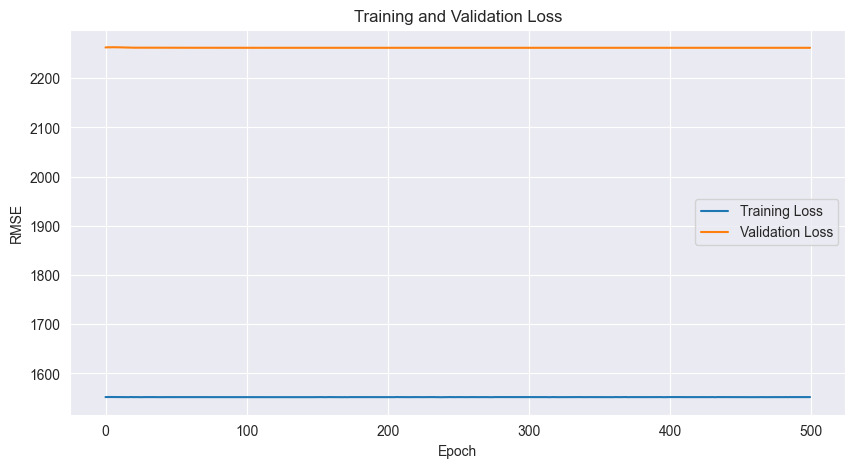

Final validation RMSE: 2261.5413
  Fold 4/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1755.9904, Val RMSE: 2261.9153



  2%|▏         | 12/500 [00:00<00:04, 112.62it/s]

Epoch 10: Train RMSE: 1755.6954, Val RMSE: 2261.8494
Epoch 20: Train RMSE: 1755.7400, Val RMSE: 2261.8660



  5%|▌         | 25/500 [00:00<00:04, 117.21it/s]

Epoch 30: Train RMSE: 1755.4944, Val RMSE: 2261.8613



 11%|█         | 55/500 [00:00<00:03, 134.93it/s]

Epoch 40: Train RMSE: 1755.6232, Val RMSE: 2261.9026
Epoch 50: Train RMSE: 1755.5905, Val RMSE: 2261.9238
Epoch 60: Train RMSE: 1755.6555, Val RMSE: 2261.9338



 17%|█▋        | 83/500 [00:00<00:03, 132.13it/s]

Epoch 70: Train RMSE: 1755.6008, Val RMSE: 2261.9358
Epoch 80: Train RMSE: 1755.6593, Val RMSE: 2261.9370



 19%|█▉        | 97/500 [00:00<00:03, 133.71it/s]

Epoch 90: Train RMSE: 1755.6337, Val RMSE: 2261.9373



 22%|██▏       | 111/500 [00:00<00:02, 134.02it/s]

Epoch 100: Train RMSE: 1755.4595, Val RMSE: 2261.9375
Epoch 110: Train RMSE: 1755.5684, Val RMSE: 2261.9377



 25%|██▌       | 125/500 [00:00<00:02, 133.99it/s]

Epoch 120: Train RMSE: 1755.6337, Val RMSE: 2261.9377



 28%|██▊       | 139/500 [00:01<00:02, 131.34it/s]

Epoch 130: Train RMSE: 1755.6106, Val RMSE: 2261.9377
Epoch 140: Train RMSE: 1755.5448, Val RMSE: 2261.9377



 31%|███       | 153/500 [00:01<00:02, 132.13it/s]

Epoch 150: Train RMSE: 1755.4973, Val RMSE: 2261.9377



 33%|███▎      | 167/500 [00:01<00:02, 132.12it/s]

Epoch 160: Train RMSE: 1755.5273, Val RMSE: 2261.9377
Epoch 170: Train RMSE: 1755.6010, Val RMSE: 2261.9377



 36%|███▌      | 181/500 [00:01<00:02, 132.93it/s]

Epoch 180: Train RMSE: 1755.4961, Val RMSE: 2261.9377



 39%|███▉      | 195/500 [00:01<00:02, 133.90it/s]

Epoch 190: Train RMSE: 1755.5597, Val RMSE: 2261.9377
Epoch 200: Train RMSE: 1755.5591, Val RMSE: 2261.9377



 42%|████▏     | 210/500 [00:01<00:02, 137.41it/s]

Epoch 210: Train RMSE: 1755.4592, Val RMSE: 2261.9377



 48%|████▊     | 239/500 [00:01<00:01, 139.09it/s]

Epoch 220: Train RMSE: 1755.4698, Val RMSE: 2261.9377
Epoch 230: Train RMSE: 1755.5450, Val RMSE: 2261.9377
Epoch 240: Train RMSE: 1755.5372, Val RMSE: 2261.9377



 54%|█████▎    | 268/500 [00:02<00:01, 137.13it/s]

Epoch 250: Train RMSE: 1755.6311, Val RMSE: 2261.9377
Epoch 260: Train RMSE: 1755.4873, Val RMSE: 2261.9377
Epoch 270: Train RMSE: 1755.5615, Val RMSE: 2261.9377



 60%|█████▉    | 299/500 [00:02<00:01, 144.25it/s]

Epoch 280: Train RMSE: 1755.6952, Val RMSE: 2261.9377
Epoch 290: Train RMSE: 1755.5927, Val RMSE: 2261.9377
Epoch 300: Train RMSE: 1755.5032, Val RMSE: 2261.9377



 66%|██████▌   | 328/500 [00:02<00:01, 136.25it/s]

Epoch 310: Train RMSE: 1755.5032, Val RMSE: 2261.9377
Epoch 320: Train RMSE: 1755.5051, Val RMSE: 2261.9377
Epoch 330: Train RMSE: 1755.6323, Val RMSE: 2261.9377



 72%|███████▏  | 359/500 [00:02<00:00, 144.17it/s]

Epoch 340: Train RMSE: 1755.6090, Val RMSE: 2261.9377
Epoch 350: Train RMSE: 1755.6194, Val RMSE: 2261.9377
Epoch 360: Train RMSE: 1755.4838, Val RMSE: 2261.9377
Epoch 370: Train RMSE: 1755.6091, Val RMSE: 2261.9377



 81%|████████  | 404/500 [00:02<00:00, 136.97it/s]

Epoch 380: Train RMSE: 1755.5411, Val RMSE: 2261.9380
Epoch 390: Train RMSE: 1755.5913, Val RMSE: 2261.9380
Epoch 400: Train RMSE: 1755.6328, Val RMSE: 2261.9380



 86%|████████▋ | 432/500 [00:03<00:00, 131.45it/s]

Epoch 410: Train RMSE: 1755.5482, Val RMSE: 2261.9380
Epoch 420: Train RMSE: 1755.6108, Val RMSE: 2261.9380
Epoch 430: Train RMSE: 1755.5271, Val RMSE: 2261.9380



 92%|█████████▏| 461/500 [00:03<00:00, 137.28it/s]

Epoch 440: Train RMSE: 1755.6121, Val RMSE: 2261.9380
Epoch 450: Train RMSE: 1755.5840, Val RMSE: 2261.9380
Epoch 460: Train RMSE: 1755.6516, Val RMSE: 2261.9380



100%|██████████| 500/500 [00:03<00:00, 136.33it/s]

Epoch 470: Train RMSE: 1755.5807, Val RMSE: 2261.9380
Epoch 480: Train RMSE: 1755.6088, Val RMSE: 2261.9380
Epoch 490: Train RMSE: 1755.6692, Val RMSE: 2261.9380


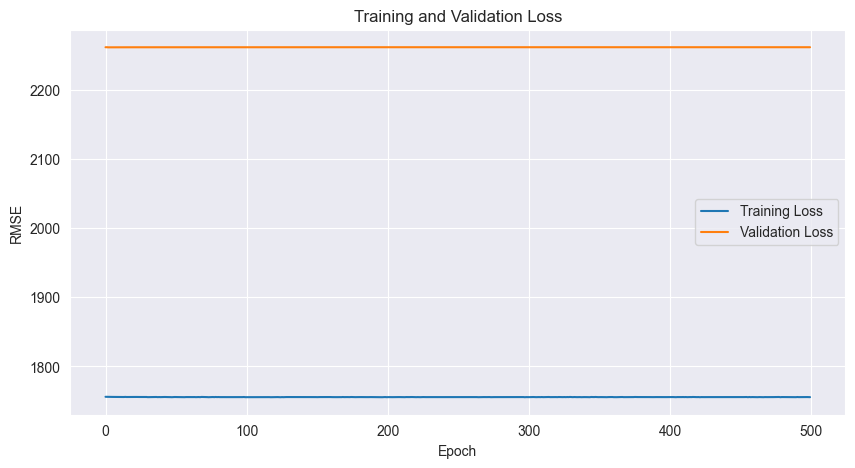

Final validation RMSE: 2261.7832
  Fold 5/5
Input size: 437



  2%|▏         | 10/500 [00:00<00:05, 93.22it/s]

Epoch 0: Train RMSE: 1867.6855, Val RMSE: 2493.2622
Epoch 10: Train RMSE: 1867.5432, Val RMSE: 2493.2754
Epoch 20: Train RMSE: 1867.6512, Val RMSE: 2493.4006



  7%|▋         | 33/500 [00:00<00:04, 97.63it/s] 

Epoch 30: Train RMSE: 1867.5710, Val RMSE: 2493.4929



  9%|▊         | 43/500 [00:00<00:04, 96.52it/s]

Epoch 40: Train RMSE: 1867.4330, Val RMSE: 2493.5222
Epoch 50: Train RMSE: 1867.5754, Val RMSE: 2493.5332



 11%|█         | 54/500 [00:00<00:04, 100.91it/s]

Epoch 60: Train RMSE: 1867.4268, Val RMSE: 2493.5383



 15%|█▌        | 76/500 [00:00<00:04, 100.75it/s]

Epoch 70: Train RMSE: 1867.2678, Val RMSE: 2493.5405
Epoch 80: Train RMSE: 1867.5800, Val RMSE: 2493.5417



 22%|██▏       | 110/500 [00:01<00:03, 106.67it/s]

Epoch 90: Train RMSE: 1867.5906, Val RMSE: 2493.5420
Epoch 100: Train RMSE: 1867.6263, Val RMSE: 2493.5425
Epoch 110: Train RMSE: 1867.4663, Val RMSE: 2493.5425



 27%|██▋       | 134/500 [00:01<00:03, 109.05it/s]

Epoch 120: Train RMSE: 1867.4226, Val RMSE: 2493.5427
Epoch 130: Train RMSE: 1867.5354, Val RMSE: 2493.5427
Epoch 140: Train RMSE: 1867.4597, Val RMSE: 2493.5427



 31%|███▏      | 157/500 [00:01<00:03, 106.32it/s]

Epoch 150: Train RMSE: 1867.4047, Val RMSE: 2493.5430
Epoch 160: Train RMSE: 1867.5603, Val RMSE: 2493.5427



 38%|███▊      | 192/500 [00:01<00:03, 98.06it/s]

Epoch 170: Train RMSE: 1867.5154, Val RMSE: 2493.5427
Epoch 180: Train RMSE: 1867.4532, Val RMSE: 2493.5427
Epoch 190: Train RMSE: 1867.3597, Val RMSE: 2493.5430



 43%|████▎     | 215/500 [00:02<00:02, 99.07it/s] 

Epoch 200: Train RMSE: 1867.4852, Val RMSE: 2493.5430
Epoch 210: Train RMSE: 1867.4286, Val RMSE: 2493.5430



 48%|████▊     | 238/500 [00:02<00:02, 101.09it/s]

Epoch 220: Train RMSE: 1867.4546, Val RMSE: 2493.5430
Epoch 230: Train RMSE: 1867.5270, Val RMSE: 2493.5430
Epoch 240: Train RMSE: 1867.4937, Val RMSE: 2493.5430



 52%|█████▏    | 261/500 [00:02<00:02, 104.38it/s]

Epoch 250: Train RMSE: 1867.5356, Val RMSE: 2493.5430
Epoch 260: Train RMSE: 1867.4071, Val RMSE: 2493.5430
Epoch 270: Train RMSE: 1867.6084, Val RMSE: 2493.5430



 59%|█████▉    | 294/500 [00:02<00:01, 103.75it/s]

Epoch 280: Train RMSE: 1867.5433, Val RMSE: 2493.5430
Epoch 290: Train RMSE: 1867.4608, Val RMSE: 2493.5430
Epoch 300: Train RMSE: 1867.3931, Val RMSE: 2493.5430



 65%|██████▌   | 327/500 [00:03<00:01, 103.38it/s]

Epoch 310: Train RMSE: 1867.3517, Val RMSE: 2493.5430
Epoch 320: Train RMSE: 1867.4918, Val RMSE: 2493.5430
Epoch 330: Train RMSE: 1867.5608, Val RMSE: 2493.5430



 73%|███████▎  | 363/500 [00:03<00:01, 113.85it/s]

Epoch 340: Train RMSE: 1867.3964, Val RMSE: 2493.5430
Epoch 350: Train RMSE: 1867.4419, Val RMSE: 2493.5430
Epoch 360: Train RMSE: 1867.3153, Val RMSE: 2493.5430



 78%|███████▊  | 388/500 [00:03<00:01, 111.39it/s]

Epoch 370: Train RMSE: 1867.4735, Val RMSE: 2493.5430
Epoch 380: Train RMSE: 1867.3456, Val RMSE: 2493.5430
Epoch 390: Train RMSE: 1867.4976, Val RMSE: 2493.5430



 85%|████████▌ | 425/500 [00:04<00:00, 114.80it/s]

Epoch 400: Train RMSE: 1867.3146, Val RMSE: 2493.5430
Epoch 410: Train RMSE: 1867.5469, Val RMSE: 2493.5430
Epoch 420: Train RMSE: 1867.2996, Val RMSE: 2493.5430



 90%|████████▉ | 449/500 [00:04<00:00, 110.81it/s]

Epoch 430: Train RMSE: 1867.4437, Val RMSE: 2493.5430
Epoch 440: Train RMSE: 1867.5304, Val RMSE: 2493.5430
Epoch 450: Train RMSE: 1867.4315, Val RMSE: 2493.5427



 94%|█████████▍| 472/500 [00:04<00:00, 106.44it/s]

Epoch 460: Train RMSE: 1867.4512, Val RMSE: 2493.5427
Epoch 470: Train RMSE: 1867.3884, Val RMSE: 2493.5427
Epoch 480: Train RMSE: 1867.4521, Val RMSE: 2493.5427



100%|██████████| 500/500 [00:04<00:00, 105.29it/s]

Epoch 490: Train RMSE: 1867.4678, Val RMSE: 2493.5427


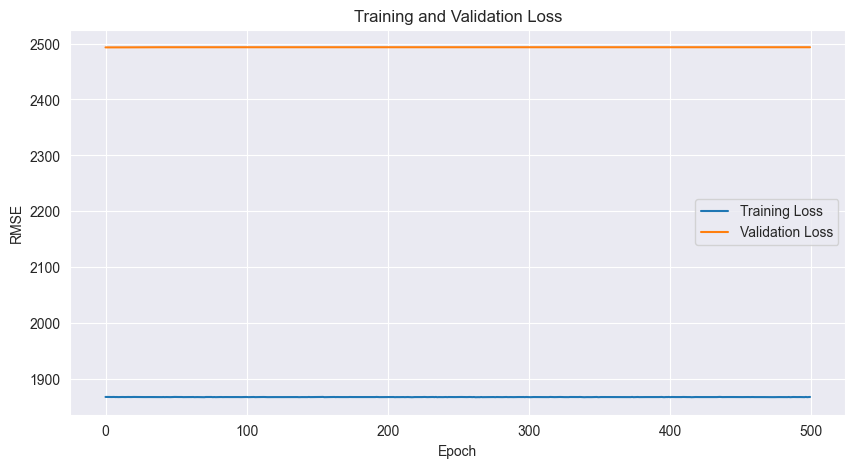

Final validation RMSE: 2493.1790
  Avg RMSE: 2032.1991 ± 417.7325

Testing: hidden_size=128, layers=5, lr=0.01
  Fold 1/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1467.8193, Val RMSE: 1829.0150



  4%|▍         | 22/500 [00:00<00:02, 213.06it/s]

Epoch 10: Train RMSE: 1467.2827, Val RMSE: 1828.9763
Epoch 20: Train RMSE: 1467.5985, Val RMSE: 1828.9896
Epoch 30: Train RMSE: 1467.5100, Val RMSE: 1828.9912
Epoch 40: Train RMSE: 1467.5599, Val RMSE: 1828.9927



  9%|▉         | 45/500 [00:00<00:02, 222.67it/s]

Epoch 50: Train RMSE: 1467.6522, Val RMSE: 1829.0254



 18%|█▊        | 90/500 [00:00<00:02, 200.19it/s]

Epoch 60: Train RMSE: 1467.4376, Val RMSE: 1829.0262
Epoch 70: Train RMSE: 1468.0660, Val RMSE: 1829.0269
Epoch 80: Train RMSE: 1467.2628, Val RMSE: 1829.0272


Epoch 90: Train RMSE: 1467.5802, Val RMSE: 1829.0273



 22%|██▏       | 111/500 [00:00<00:01, 198.88it/s]


Epoch 100: Train RMSE: 1467.4418, Val RMSE: 1829.0275
Epoch 110: Train RMSE: 1467.1990, Val RMSE: 1829.0275
Epoch 120: Train RMSE: 1467.9060, Val RMSE: 1829.0275
Epoch 130: Train RMSE: 1468.0919, Val RMSE: 1829.0276


 26%|██▋       | 132/500 [00:00<00:01, 202.24it/s]

Epoch 140: Train RMSE: 1467.8268, Val RMSE: 1829.0275



 35%|███▌      | 175/500 [00:00<00:01, 204.12it/s]

Epoch 150: Train RMSE: 1466.8169, Val RMSE: 1829.0276
Epoch 160: Train RMSE: 1466.6891, Val RMSE: 1829.0276
Epoch 170: Train RMSE: 1467.7180, Val RMSE: 1829.0275
Epoch 180: Train RMSE: 1467.8695, Val RMSE: 1829.0275
Epoch 190: Train RMSE: 1467.2891, Val RMSE: 1829.0275



 43%|████▎     | 217/500 [00:01<00:01, 201.30it/s]

Epoch 200: Train RMSE: 1467.8014, Val RMSE: 1829.0275
Epoch 210: Train RMSE: 1468.4492, Val RMSE: 1829.0275
Epoch 220: Train RMSE: 1467.2819, Val RMSE: 1829.0275
Epoch 230: Train RMSE: 1467.9551, Val RMSE: 1829.0275



 48%|████▊     | 238/500 [00:01<00:01, 203.50it/s]

Epoch 240: Train RMSE: 1467.2456, Val RMSE: 1829.0275



 57%|█████▋    | 283/500 [00:01<00:01, 212.86it/s]

Epoch 250: Train RMSE: 1467.2168, Val RMSE: 1829.0275
Epoch 260: Train RMSE: 1468.0292, Val RMSE: 1829.0275
Epoch 270: Train RMSE: 1468.1027, Val RMSE: 1829.0275
Epoch 280: Train RMSE: 1467.0300, Val RMSE: 1829.0275
Epoch 290: Train RMSE: 1467.4833, Val RMSE: 1829.0275



 65%|██████▌   | 326/500 [00:01<00:00, 195.81it/s]

Epoch 300: Train RMSE: 1467.6417, Val RMSE: 1829.0275
Epoch 310: Train RMSE: 1467.1952, Val RMSE: 1829.0275
Epoch 320: Train RMSE: 1467.7092, Val RMSE: 1829.0275
Epoch 330: Train RMSE: 1467.9725, Val RMSE: 1829.0275



 74%|███████▍  | 369/500 [00:01<00:00, 203.28it/s]

Epoch 340: Train RMSE: 1467.2026, Val RMSE: 1829.0275
Epoch 350: Train RMSE: 1467.0529, Val RMSE: 1829.0275
Epoch 360: Train RMSE: 1467.4976, Val RMSE: 1829.0275
Epoch 370: Train RMSE: 1466.8870, Val RMSE: 1829.0275
Epoch 380: Train RMSE: 1467.0426, Val RMSE: 1829.0275



 82%|████████▏ | 412/500 [00:02<00:00, 205.26it/s]

Epoch 390: Train RMSE: 1467.7893, Val RMSE: 1829.0275
Epoch 400: Train RMSE: 1467.6361, Val RMSE: 1829.0275
Epoch 410: Train RMSE: 1467.6462, Val RMSE: 1829.0275
Epoch 420: Train RMSE: 1467.6658, Val RMSE: 1829.0275



 87%|████████▋ | 433/500 [00:02<00:00, 204.25it/s]

Epoch 430: Train RMSE: 1467.9156, Val RMSE: 1829.0275



 91%|█████████ | 455/500 [00:02<00:00, 208.18it/s]

Epoch 440: Train RMSE: 1467.5868, Val RMSE: 1829.0275
Epoch 450: Train RMSE: 1467.5826, Val RMSE: 1829.0275
Epoch 460: Train RMSE: 1467.7904, Val RMSE: 1829.0275
Epoch 470: Train RMSE: 1466.9066, Val RMSE: 1829.0275



 96%|█████████▌| 478/500 [00:02<00:00, 211.84it/s]

Epoch 480: Train RMSE: 1467.2448, Val RMSE: 1829.0275



100%|██████████| 500/500 [00:02<00:00, 205.48it/s]

Epoch 490: Train RMSE: 1467.2554, Val RMSE: 1829.0275


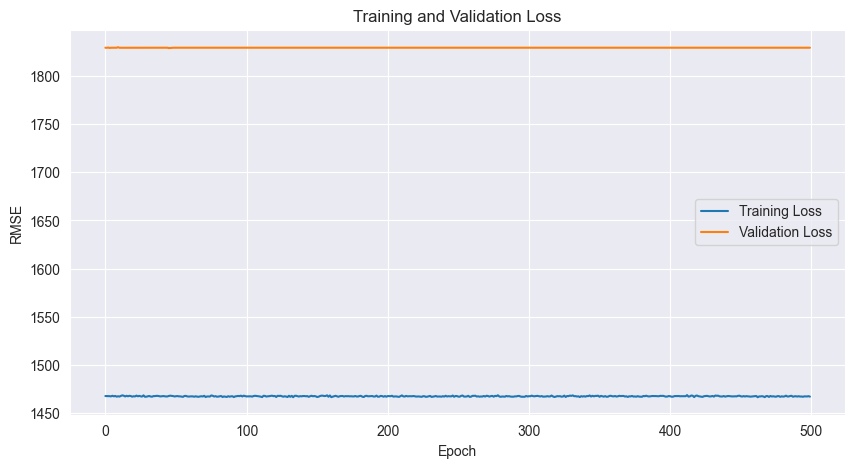

Final validation RMSE: 1828.6127
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.7716, Val RMSE: 1315.7568
Epoch 10: Train RMSE: 1656.5941, Val RMSE: 1316.4651



  4%|▍         | 20/500 [00:00<00:02, 192.88it/s]

Epoch 20: Train RMSE: 1656.7123, Val RMSE: 1316.6143
Epoch 30: Train RMSE: 1656.4863, Val RMSE: 1316.7240



  8%|▊         | 40/500 [00:00<00:02, 193.70it/s]

Epoch 40: Train RMSE: 1656.8503, Val RMSE: 1316.0836
Epoch 50: Train RMSE: 1656.5162, Val RMSE: 1316.0364



 12%|█▏        | 60/500 [00:00<00:02, 184.14it/s]

Epoch 60: Train RMSE: 1656.6799, Val RMSE: 1316.0286
Epoch 70: Train RMSE: 1656.6215, Val RMSE: 1316.0386



 16%|█▌        | 79/500 [00:00<00:02, 180.41it/s]

Epoch 80: Train RMSE: 1656.8022, Val RMSE: 1316.0460
Epoch 90: Train RMSE: 1656.8314, Val RMSE: 1316.0560



 20%|█▉        | 98/500 [00:00<00:02, 173.32it/s]

Epoch 100: Train RMSE: 1657.0562, Val RMSE: 1316.0619
Epoch 110: Train RMSE: 1656.4509, Val RMSE: 1316.0663



 23%|██▎       | 116/500 [00:00<00:02, 174.87it/s]

Epoch 120: Train RMSE: 1656.7919, Val RMSE: 1316.0681



 27%|██▋       | 134/500 [00:00<00:02, 174.90it/s]

Epoch 130: Train RMSE: 1656.8147, Val RMSE: 1316.0687



 30%|███       | 152/500 [00:00<00:01, 174.88it/s]

Epoch 140: Train RMSE: 1656.4817, Val RMSE: 1316.0695
Epoch 150: Train RMSE: 1656.8757, Val RMSE: 1316.0699
Epoch 160: Train RMSE: 1656.6525, Val RMSE: 1316.0703



 34%|███▍      | 170/500 [00:00<00:01, 173.34it/s]

Epoch 170: Train RMSE: 1656.9889, Val RMSE: 1316.0704



 38%|███▊      | 188/500 [00:01<00:01, 175.19it/s]

Epoch 180: Train RMSE: 1656.5009, Val RMSE: 1316.0704
Epoch 190: Train RMSE: 1656.5099, Val RMSE: 1316.0706



 42%|████▏     | 208/500 [00:01<00:01, 180.02it/s]

Epoch 200: Train RMSE: 1656.4703, Val RMSE: 1316.0706
Epoch 210: Train RMSE: 1656.6403, Val RMSE: 1316.0706



 45%|████▌     | 227/500 [00:01<00:01, 181.60it/s]

Epoch 220: Train RMSE: 1656.6138, Val RMSE: 1316.0706
Epoch 230: Train RMSE: 1656.7186, Val RMSE: 1316.0706



 49%|████▉     | 246/500 [00:01<00:01, 180.66it/s]

Epoch 240: Train RMSE: 1656.8716, Val RMSE: 1316.0706
Epoch 250: Train RMSE: 1656.5790, Val RMSE: 1316.0706



 53%|█████▎    | 265/500 [00:01<00:01, 179.62it/s]

Epoch 260: Train RMSE: 1656.8311, Val RMSE: 1316.0706
Epoch 270: Train RMSE: 1656.6132, Val RMSE: 1316.0706



 57%|█████▋    | 283/500 [00:01<00:01, 177.31it/s]

Epoch 280: Train RMSE: 1656.3083, Val RMSE: 1316.0706
Epoch 290: Train RMSE: 1656.7388, Val RMSE: 1316.0707



 60%|██████    | 301/500 [00:01<00:01, 177.91it/s]

Epoch 300: Train RMSE: 1656.5796, Val RMSE: 1316.0707
Epoch 310: Train RMSE: 1656.5637, Val RMSE: 1316.0707



 64%|██████▍   | 320/500 [00:01<00:00, 180.18it/s]

Epoch 320: Train RMSE: 1656.1482, Val RMSE: 1316.0707
Epoch 330: Train RMSE: 1656.7260, Val RMSE: 1316.0706



 68%|██████▊   | 339/500 [00:01<00:00, 182.24it/s]

Epoch 340: Train RMSE: 1656.6737, Val RMSE: 1316.0707
Epoch 350: Train RMSE: 1656.9275, Val RMSE: 1316.0707



 72%|███████▏  | 358/500 [00:02<00:00, 176.31it/s]

Epoch 360: Train RMSE: 1656.6381, Val RMSE: 1316.0706
Epoch 370: Train RMSE: 1656.6821, Val RMSE: 1316.0707



 75%|███████▌  | 377/500 [00:02<00:00, 179.48it/s]


Epoch 380: Train RMSE: 1656.5021, Val RMSE: 1316.0707
Epoch 390: Train RMSE: 1656.7489, Val RMSE: 1316.0707


 79%|███████▉  | 395/500 [00:02<00:00, 170.35it/s]

Epoch 400: Train RMSE: 1656.5056, Val RMSE: 1316.0707



 83%|████████▎ | 413/500 [00:02<00:00, 170.44it/s]

Epoch 410: Train RMSE: 1656.3821, Val RMSE: 1316.0707



 86%|████████▌ | 431/500 [00:02<00:00, 168.48it/s]

Epoch 420: Train RMSE: 1656.5607, Val RMSE: 1316.0707
Epoch 430: Train RMSE: 1656.4784, Val RMSE: 1316.0707
Epoch 440: Train RMSE: 1656.8579, Val RMSE: 1316.0707



 90%|█████████ | 450/500 [00:02<00:00, 172.44it/s]

Epoch 450: Train RMSE: 1656.2898, Val RMSE: 1316.0708



 94%|█████████▍| 469/500 [00:02<00:00, 175.96it/s]

Epoch 460: Train RMSE: 1656.4136, Val RMSE: 1316.0708
Epoch 470: Train RMSE: 1656.3363, Val RMSE: 1316.0708
Epoch 480: Train RMSE: 1656.8058, Val RMSE: 1316.0708



 97%|█████████▋| 487/500 [00:02<00:00, 174.68it/s]

Epoch 490: Train RMSE: 1656.7295, Val RMSE: 1316.0708


100%|██████████| 500/500 [00:02<00:00, 176.65it/s]


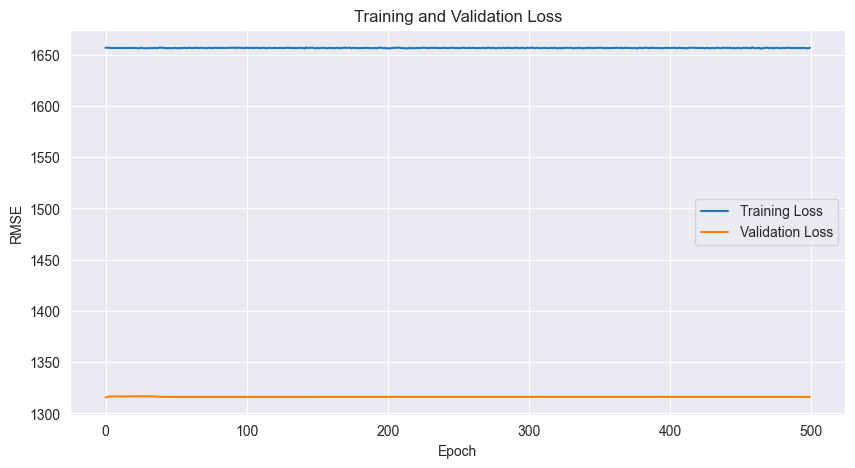

Final validation RMSE: 1315.7568
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1551.9515, Val RMSE: 2262.4646



  3%|▎         | 15/500 [00:00<00:03, 145.25it/s]

Epoch 10: Train RMSE: 1551.9351, Val RMSE: 2261.6650
Epoch 20: Train RMSE: 1551.8386, Val RMSE: 2261.5107



  6%|▌         | 30/500 [00:00<00:03, 132.46it/s]

Epoch 30: Train RMSE: 1551.9586, Val RMSE: 2261.3772



  9%|▉         | 44/500 [00:00<00:03, 117.25it/s]

Epoch 40: Train RMSE: 1551.7191, Val RMSE: 2261.2588
Epoch 50: Train RMSE: 1551.7441, Val RMSE: 2261.1702



 11%|█         | 56/500 [00:00<00:04, 110.44it/s]

Epoch 60: Train RMSE: 1551.7361, Val RMSE: 2261.1292



 16%|█▌        | 79/500 [00:00<00:03, 107.63it/s]

Epoch 70: Train RMSE: 1551.6534, Val RMSE: 2261.1077
Epoch 80: Train RMSE: 1551.7695, Val RMSE: 2261.0933



 18%|█▊        | 90/500 [00:00<00:03, 108.31it/s]

Epoch 90: Train RMSE: 1551.8630, Val RMSE: 2261.0837



 20%|██        | 102/500 [00:00<00:03, 108.80it/s]

Epoch 100: Train RMSE: 1551.7051, Val RMSE: 2261.0784
Epoch 110: Train RMSE: 1551.7716, Val RMSE: 2261.0754



 23%|██▎       | 113/500 [00:01<00:03, 105.53it/s]

Epoch 120: Train RMSE: 1551.8794, Val RMSE: 2261.0740



 28%|██▊       | 141/500 [00:01<00:02, 121.07it/s]

Epoch 130: Train RMSE: 1551.7257, Val RMSE: 2261.0732
Epoch 140: Train RMSE: 1551.8793, Val RMSE: 2261.0725



 31%|███       | 156/500 [00:01<00:02, 128.66it/s]

Epoch 150: Train RMSE: 1551.7529, Val RMSE: 2261.0725



 34%|███▍      | 171/500 [00:01<00:02, 133.36it/s]

Epoch 160: Train RMSE: 1551.4510, Val RMSE: 2261.0723
Epoch 170: Train RMSE: 1551.8419, Val RMSE: 2261.0723



 37%|███▋      | 187/500 [00:01<00:02, 138.50it/s]

Epoch 180: Train RMSE: 1551.8390, Val RMSE: 2261.0723
Epoch 190: Train RMSE: 1551.6003, Val RMSE: 2261.0723



 41%|████      | 203/500 [00:01<00:02, 141.88it/s]

Epoch 200: Train RMSE: 1551.9119, Val RMSE: 2261.0723
Epoch 210: Train RMSE: 1551.6875, Val RMSE: 2261.0723



 44%|████▎     | 218/500 [00:01<00:01, 143.68it/s]

Epoch 220: Train RMSE: 1551.5885, Val RMSE: 2261.0723



 50%|████▉     | 248/500 [00:01<00:01, 140.79it/s]

Epoch 230: Train RMSE: 1551.9194, Val RMSE: 2261.0723
Epoch 240: Train RMSE: 1551.8796, Val RMSE: 2261.0723
Epoch 250: Train RMSE: 1551.9878, Val RMSE: 2261.0723



 56%|█████▌    | 278/500 [00:02<00:01, 140.63it/s]

Epoch 260: Train RMSE: 1551.7809, Val RMSE: 2261.0723
Epoch 270: Train RMSE: 1551.5704, Val RMSE: 2261.0723
Epoch 280: Train RMSE: 1551.4624, Val RMSE: 2261.0723



 62%|██████▏   | 310/500 [00:02<00:01, 148.67it/s]

Epoch 290: Train RMSE: 1552.1234, Val RMSE: 2261.0723
Epoch 300: Train RMSE: 1551.9786, Val RMSE: 2261.0723
Epoch 310: Train RMSE: 1551.7994, Val RMSE: 2261.0723
Epoch 320: Train RMSE: 1551.7728, Val RMSE: 2261.0723



 68%|██████▊   | 341/500 [00:02<00:01, 151.13it/s]

Epoch 330: Train RMSE: 1551.8358, Val RMSE: 2261.0723
Epoch 340: Train RMSE: 1551.9170, Val RMSE: 2261.0723
Epoch 350: Train RMSE: 1551.9122, Val RMSE: 2261.0723



 78%|███████▊  | 390/500 [00:02<00:00, 151.80it/s]

Epoch 360: Train RMSE: 1551.7949, Val RMSE: 2261.0723
Epoch 370: Train RMSE: 1551.9733, Val RMSE: 2261.0723
Epoch 380: Train RMSE: 1552.0060, Val RMSE: 2261.0723
Epoch 390: Train RMSE: 1552.1377, Val RMSE: 2261.0723



 84%|████████▍ | 422/500 [00:03<00:00, 152.63it/s]

Epoch 400: Train RMSE: 1551.8215, Val RMSE: 2261.0723
Epoch 410: Train RMSE: 1552.0481, Val RMSE: 2261.0723
Epoch 420: Train RMSE: 1551.8837, Val RMSE: 2261.0723
Epoch 430: Train RMSE: 1551.5823, Val RMSE: 2261.0723



 94%|█████████▍| 470/500 [00:03<00:00, 153.15it/s]

Epoch 440: Train RMSE: 1551.9144, Val RMSE: 2261.0723
Epoch 450: Train RMSE: 1551.8622, Val RMSE: 2261.0723
Epoch 460: Train RMSE: 1551.6394, Val RMSE: 2261.0723
Epoch 470: Train RMSE: 1551.8580, Val RMSE: 2261.0723



100%|██████████| 500/500 [00:03<00:00, 137.63it/s]


Epoch 480: Train RMSE: 1551.8298, Val RMSE: 2261.0723
Epoch 490: Train RMSE: 1551.6779, Val RMSE: 2261.0723


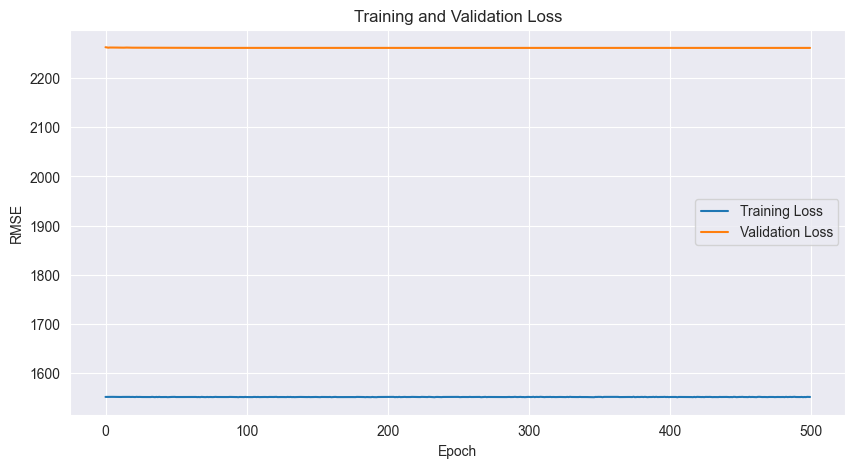

Final validation RMSE: 2261.0723
  Fold 4/5
Input size: 437



  3%|▎         | 13/500 [00:00<00:03, 128.22it/s]

Epoch 0: Train RMSE: 1755.9031, Val RMSE: 2261.8572
Epoch 10: Train RMSE: 1755.5668, Val RMSE: 2261.8811
Epoch 20: Train RMSE: 1755.2272, Val RMSE: 2261.9670



 10%|█         | 50/500 [00:00<00:04, 102.99it/s]

Epoch 30: Train RMSE: 1755.1576, Val RMSE: 2262.0203
Epoch 40: Train RMSE: 1754.9866, Val RMSE: 2262.0383
Epoch 50: Train RMSE: 1754.9421, Val RMSE: 2262.0544



 15%|█▌        | 75/500 [00:00<00:03, 112.28it/s]

Epoch 60: Train RMSE: 1755.0682, Val RMSE: 2262.0605
Epoch 70: Train RMSE: 1754.9641, Val RMSE: 2262.0637
Epoch 80: Train RMSE: 1755.0544, Val RMSE: 2262.0664



 20%|██        | 102/500 [00:00<00:03, 116.69it/s]

Epoch 90: Train RMSE: 1755.0820, Val RMSE: 2262.0671
Epoch 100: Train RMSE: 1755.2861, Val RMSE: 2262.0681
Epoch 110: Train RMSE: 1755.1052, Val RMSE: 2262.0686



 28%|██▊       | 141/500 [00:01<00:02, 119.88it/s]

Epoch 120: Train RMSE: 1754.6626, Val RMSE: 2262.0688
Epoch 130: Train RMSE: 1754.7520, Val RMSE: 2262.0688
Epoch 140: Train RMSE: 1754.9921, Val RMSE: 2262.0688



 33%|███▎      | 167/500 [00:01<00:02, 121.31it/s]

Epoch 150: Train RMSE: 1754.9264, Val RMSE: 2262.0688
Epoch 160: Train RMSE: 1754.9575, Val RMSE: 2262.0688
Epoch 170: Train RMSE: 1754.9596, Val RMSE: 2262.0691



 42%|████▏     | 211/500 [00:01<00:02, 119.89it/s]

Epoch 180: Train RMSE: 1754.9733, Val RMSE: 2262.0691
Epoch 190: Train RMSE: 1755.1086, Val RMSE: 2262.0691
Epoch 200: Train RMSE: 1755.0225, Val RMSE: 2262.0691
Epoch 210: Train RMSE: 1755.0752, Val RMSE: 2262.0691



 49%|████▊     | 243/500 [00:02<00:01, 136.70it/s]

Epoch 220: Train RMSE: 1755.0826, Val RMSE: 2262.0691
Epoch 230: Train RMSE: 1755.1610, Val RMSE: 2262.0691
Epoch 240: Train RMSE: 1755.2251, Val RMSE: 2262.0691
Epoch 250: Train RMSE: 1754.8881, Val RMSE: 2262.0691



 58%|█████▊    | 288/500 [00:02<00:01, 137.49it/s]

Epoch 260: Train RMSE: 1754.9292, Val RMSE: 2262.0691
Epoch 270: Train RMSE: 1754.8999, Val RMSE: 2262.0691
Epoch 280: Train RMSE: 1754.8057, Val RMSE: 2262.0691



 64%|██████▍   | 319/500 [00:02<00:01, 143.34it/s]

Epoch 290: Train RMSE: 1754.7588, Val RMSE: 2262.0691
Epoch 300: Train RMSE: 1754.7612, Val RMSE: 2262.0691
Epoch 310: Train RMSE: 1755.0712, Val RMSE: 2262.0691
Epoch 320: Train RMSE: 1755.0005, Val RMSE: 2262.0691



 70%|██████▉   | 349/500 [00:02<00:01, 138.72it/s]

Epoch 330: Train RMSE: 1755.0288, Val RMSE: 2262.0691
Epoch 340: Train RMSE: 1755.0101, Val RMSE: 2262.0691
Epoch 350: Train RMSE: 1754.9639, Val RMSE: 2262.0691



 76%|███████▌  | 380/500 [00:03<00:00, 143.31it/s]

Epoch 360: Train RMSE: 1755.0675, Val RMSE: 2262.0691
Epoch 370: Train RMSE: 1755.3606, Val RMSE: 2262.0691
Epoch 380: Train RMSE: 1755.0525, Val RMSE: 2262.0691
Epoch 390: Train RMSE: 1755.3300, Val RMSE: 2262.0691



 86%|████████▌ | 428/500 [00:03<00:00, 147.17it/s]

Epoch 400: Train RMSE: 1754.9999, Val RMSE: 2262.0691
Epoch 410: Train RMSE: 1755.0248, Val RMSE: 2262.0691
Epoch 420: Train RMSE: 1755.1753, Val RMSE: 2262.0691



 89%|████████▊ | 443/500 [00:03<00:00, 145.46it/s]

Epoch 430: Train RMSE: 1755.2852, Val RMSE: 2262.0691
Epoch 440: Train RMSE: 1755.2043, Val RMSE: 2262.0691
Epoch 450: Train RMSE: 1755.2657, Val RMSE: 2262.0691



 97%|█████████▋| 486/500 [00:03<00:00, 133.68it/s]

Epoch 460: Train RMSE: 1754.8829, Val RMSE: 2262.0691
Epoch 470: Train RMSE: 1755.0148, Val RMSE: 2262.0691
Epoch 480: Train RMSE: 1755.2123, Val RMSE: 2262.0691



100%|██████████| 500/500 [00:03<00:00, 128.08it/s]

Epoch 490: Train RMSE: 1754.7438, Val RMSE: 2262.0691


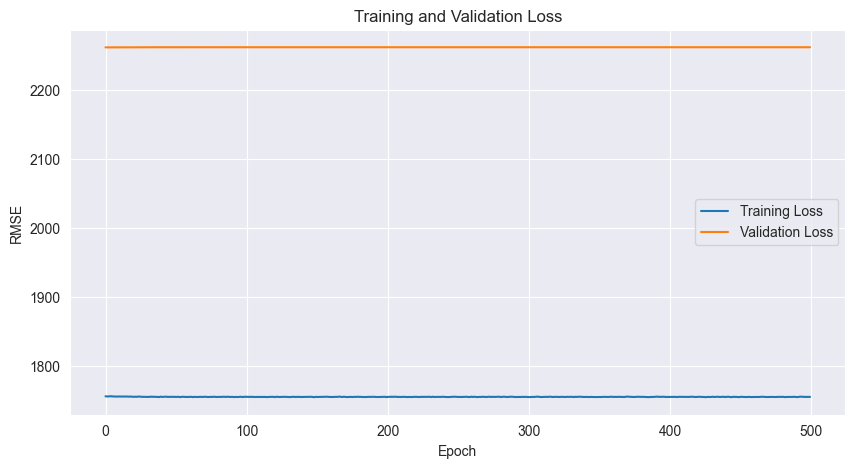

Final validation RMSE: 2261.7791
  Fold 5/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1867.7953, Val RMSE: 2493.4399



  2%|▏         | 8/500 [00:00<00:06, 77.98it/s]

Epoch 10: Train RMSE: 1867.4417, Val RMSE: 2493.3386



  6%|▌         | 28/500 [00:00<00:05, 89.79it/s]

Epoch 20: Train RMSE: 1867.4095, Val RMSE: 2493.4290



  8%|▊         | 38/500 [00:00<00:05, 91.64it/s]

Epoch 30: Train RMSE: 1867.3372, Val RMSE: 2493.5713



 10%|▉         | 49/500 [00:00<00:04, 95.85it/s]

Epoch 40: Train RMSE: 1867.6646, Val RMSE: 2493.6135
Epoch 50: Train RMSE: 1866.7661, Val RMSE: 2493.6331



 12%|█▏        | 61/500 [00:00<00:04, 100.73it/s]

Epoch 60: Train RMSE: 1867.1273, Val RMSE: 2493.6558



 14%|█▍        | 72/500 [00:00<00:04, 100.90it/s]

Epoch 70: Train RMSE: 1867.1233, Val RMSE: 2493.6638
Epoch 80: Train RMSE: 1867.0751, Val RMSE: 2493.6687



 17%|█▋        | 83/500 [00:00<00:04, 100.23it/s]

Epoch 90: Train RMSE: 1867.4561, Val RMSE: 2493.6704



 21%|██        | 105/500 [00:01<00:03, 99.93it/s]

Epoch 100: Train RMSE: 1867.2671, Val RMSE: 2493.6716
Epoch 110: Train RMSE: 1866.7850, Val RMSE: 2493.6724



 23%|██▎       | 116/500 [00:01<00:03, 100.61it/s]

Epoch 120: Train RMSE: 1867.3672, Val RMSE: 2493.6726



 28%|██▊       | 138/500 [00:01<00:03, 102.56it/s]

Epoch 130: Train RMSE: 1867.2455, Val RMSE: 2493.6729
Epoch 140: Train RMSE: 1867.2773, Val RMSE: 2493.6731



 30%|██▉       | 149/500 [00:01<00:03, 100.76it/s]

Epoch 150: Train RMSE: 1866.6577, Val RMSE: 2493.6729



 34%|███▍      | 171/500 [00:01<00:03, 103.18it/s]

Epoch 160: Train RMSE: 1867.0360, Val RMSE: 2493.6729
Epoch 170: Train RMSE: 1867.1168, Val RMSE: 2493.6731
Epoch 180: Train RMSE: 1866.9871, Val RMSE: 2493.6731



 39%|███▉      | 194/500 [00:01<00:02, 103.07it/s]

Epoch 190: Train RMSE: 1867.4464, Val RMSE: 2493.6731
Epoch 200: Train RMSE: 1867.6667, Val RMSE: 2493.6731



 41%|████      | 205/500 [00:02<00:02, 103.96it/s]

Epoch 210: Train RMSE: 1867.3435, Val RMSE: 2493.6731



 45%|████▌     | 227/500 [00:02<00:02, 99.33it/s] 

Epoch 220: Train RMSE: 1866.9369, Val RMSE: 2493.6731



 47%|████▋     | 237/500 [00:02<00:02, 99.44it/s]

Epoch 230: Train RMSE: 1866.7692, Val RMSE: 2493.6731



 49%|████▉     | 247/500 [00:02<00:02, 98.96it/s]

Epoch 240: Train RMSE: 1867.0848, Val RMSE: 2493.6731



 51%|█████▏    | 257/500 [00:02<00:02, 97.12it/s]

Epoch 250: Train RMSE: 1867.3246, Val RMSE: 2493.6731



 53%|█████▎    | 267/500 [00:02<00:02, 97.45it/s]

Epoch 260: Train RMSE: 1867.4980, Val RMSE: 2493.6731



 55%|█████▌    | 277/500 [00:02<00:02, 96.75it/s]

Epoch 270: Train RMSE: 1866.6835, Val RMSE: 2493.6731



 57%|█████▋    | 287/500 [00:02<00:02, 93.82it/s]

Epoch 280: Train RMSE: 1867.2838, Val RMSE: 2493.6731



 59%|█████▉    | 297/500 [00:03<00:02, 94.79it/s]

Epoch 290: Train RMSE: 1867.2319, Val RMSE: 2493.6731



 61%|██████▏   | 307/500 [00:03<00:02, 95.11it/s]

Epoch 300: Train RMSE: 1867.2891, Val RMSE: 2493.6731



 63%|██████▎   | 317/500 [00:03<00:01, 95.24it/s]

Epoch 310: Train RMSE: 1867.2767, Val RMSE: 2493.6731



 65%|██████▌   | 327/500 [00:03<00:01, 95.52it/s]

Epoch 320: Train RMSE: 1867.4180, Val RMSE: 2493.6731



 67%|██████▋   | 337/500 [00:03<00:01, 96.33it/s]

Epoch 330: Train RMSE: 1866.6143, Val RMSE: 2493.6731



 69%|██████▉   | 347/500 [00:03<00:01, 96.62it/s]

Epoch 340: Train RMSE: 1867.1370, Val RMSE: 2493.6731



 71%|███████▏  | 357/500 [00:03<00:01, 95.38it/s]

Epoch 350: Train RMSE: 1866.8624, Val RMSE: 2493.6731



 73%|███████▎  | 367/500 [00:03<00:01, 96.20it/s]

Epoch 360: Train RMSE: 1867.1484, Val RMSE: 2493.6731



 75%|███████▌  | 377/500 [00:03<00:01, 96.48it/s]

Epoch 370: Train RMSE: 1867.1162, Val RMSE: 2493.6731



 77%|███████▋  | 387/500 [00:03<00:01, 96.21it/s]

Epoch 380: Train RMSE: 1867.2931, Val RMSE: 2493.6731



 79%|███████▉  | 397/500 [00:04<00:01, 92.60it/s]

Epoch 390: Train RMSE: 1867.0864, Val RMSE: 2493.6731



 81%|████████▏ | 407/500 [00:04<00:00, 93.10it/s]

Epoch 400: Train RMSE: 1867.3833, Val RMSE: 2493.6731



 83%|████████▎ | 417/500 [00:04<00:00, 93.07it/s]

Epoch 410: Train RMSE: 1867.3734, Val RMSE: 2493.6731



 86%|████████▌ | 428/500 [00:04<00:00, 95.16it/s]

Epoch 420: Train RMSE: 1867.2352, Val RMSE: 2493.6731



 88%|████████▊ | 438/500 [00:04<00:00, 96.13it/s]

Epoch 430: Train RMSE: 1867.0378, Val RMSE: 2493.6731
Epoch 440: Train RMSE: 1867.3557, Val RMSE: 2493.6731



 90%|████████▉ | 449/500 [00:04<00:00, 99.23it/s]

Epoch 450: Train RMSE: 1866.9385, Val RMSE: 2493.6731



 94%|█████████▍| 471/500 [00:04<00:00, 102.16it/s]

Epoch 460: Train RMSE: 1867.2562, Val RMSE: 2493.6731
Epoch 470: Train RMSE: 1867.3043, Val RMSE: 2493.6731
Epoch 480: Train RMSE: 1867.5546, Val RMSE: 2493.6731



100%|██████████| 500/500 [00:05<00:00, 98.28it/s] 

Epoch 490: Train RMSE: 1866.9152, Val RMSE: 2493.6731


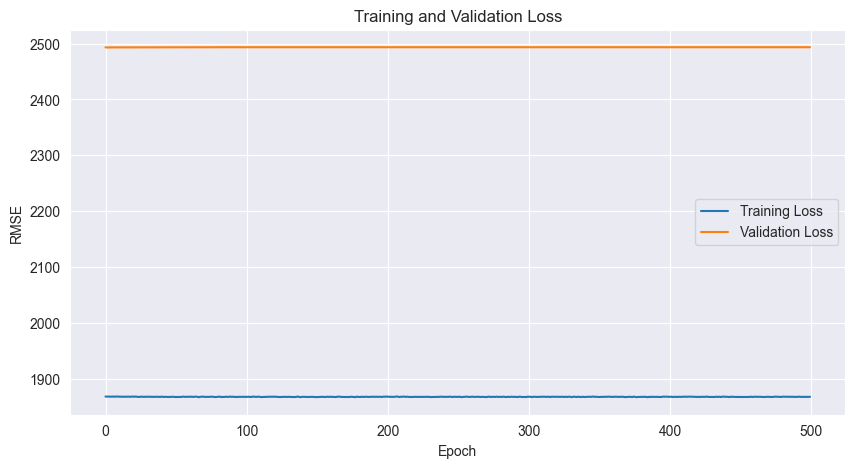

Final validation RMSE: 2493.2390
  Avg RMSE: 2032.0920 ± 417.7043

Testing: hidden_size=128, layers=10, lr=0.0001
  Fold 1/5
Input size: 437



  2%|▏         | 10/500 [00:00<00:05, 95.03it/s]

Epoch 0: Train RMSE: 1467.8110, Val RMSE: 1828.9723
Epoch 10: Train RMSE: 1467.9691, Val RMSE: 1828.9836



  6%|▌         | 31/500 [00:00<00:04, 101.78it/s]

Epoch 20: Train RMSE: 1468.0640, Val RMSE: 1828.9929
Epoch 30: Train RMSE: 1467.7938, Val RMSE: 1829.0311
Epoch 40: Train RMSE: 1467.7626, Val RMSE: 1829.0387



 13%|█▎        | 66/500 [00:00<00:04, 106.05it/s]

Epoch 50: Train RMSE: 1467.8101, Val RMSE: 1829.0048
Epoch 60: Train RMSE: 1467.8677, Val RMSE: 1829.0032
Epoch 70: Train RMSE: 1468.2046, Val RMSE: 1829.0032



 20%|██        | 102/500 [00:00<00:03, 109.76it/s]

Epoch 80: Train RMSE: 1467.7506, Val RMSE: 1829.0035
Epoch 90: Train RMSE: 1467.5227, Val RMSE: 1829.0037
Epoch 100: Train RMSE: 1468.0009, Val RMSE: 1829.0038



 25%|██▍       | 124/500 [00:01<00:03, 108.79it/s]

Epoch 110: Train RMSE: 1467.7698, Val RMSE: 1829.0038
Epoch 120: Train RMSE: 1468.0208, Val RMSE: 1829.0038
Epoch 130: Train RMSE: 1467.7898, Val RMSE: 1829.0038



 32%|███▏      | 159/500 [00:01<00:03, 108.84it/s]

Epoch 140: Train RMSE: 1467.6788, Val RMSE: 1829.0038
Epoch 150: Train RMSE: 1467.9681, Val RMSE: 1829.0038
Epoch 160: Train RMSE: 1467.6166, Val RMSE: 1829.0038



 36%|███▌      | 181/500 [00:01<00:03, 102.09it/s]

Epoch 170: Train RMSE: 1467.9661, Val RMSE: 1829.0038
Epoch 180: Train RMSE: 1467.8434, Val RMSE: 1829.0038



 41%|████      | 203/500 [00:01<00:02, 101.27it/s]

Epoch 190: Train RMSE: 1467.8064, Val RMSE: 1829.0038
Epoch 200: Train RMSE: 1467.8752, Val RMSE: 1829.0038
Epoch 210: Train RMSE: 1468.0333, Val RMSE: 1829.0038



 48%|████▊     | 238/500 [00:02<00:02, 108.92it/s]

Epoch 220: Train RMSE: 1467.7952, Val RMSE: 1829.0038
Epoch 230: Train RMSE: 1467.7017, Val RMSE: 1829.0038
Epoch 240: Train RMSE: 1467.9344, Val RMSE: 1829.0038



 52%|█████▏    | 262/500 [00:02<00:02, 108.76it/s]

Epoch 250: Train RMSE: 1467.9154, Val RMSE: 1829.0038
Epoch 260: Train RMSE: 1467.8115, Val RMSE: 1829.0038
Epoch 270: Train RMSE: 1467.8336, Val RMSE: 1829.0038



 59%|█████▉    | 296/500 [00:02<00:01, 106.73it/s]

Epoch 280: Train RMSE: 1467.7859, Val RMSE: 1829.0038
Epoch 290: Train RMSE: 1467.5875, Val RMSE: 1829.0038
Epoch 300: Train RMSE: 1467.7338, Val RMSE: 1829.0038



 66%|██████▌   | 329/500 [00:03<00:01, 106.22it/s]

Epoch 310: Train RMSE: 1467.7184, Val RMSE: 1829.0038
Epoch 320: Train RMSE: 1468.0692, Val RMSE: 1829.0038
Epoch 330: Train RMSE: 1467.9294, Val RMSE: 1829.0038



 70%|███████   | 351/500 [00:03<00:01, 102.59it/s]

Epoch 340: Train RMSE: 1467.8685, Val RMSE: 1829.0038
Epoch 350: Train RMSE: 1467.6349, Val RMSE: 1829.0038



 75%|███████▍  | 373/500 [00:03<00:01, 105.47it/s]

Epoch 360: Train RMSE: 1467.9633, Val RMSE: 1829.0038
Epoch 370: Train RMSE: 1467.7915, Val RMSE: 1829.0038
Epoch 380: Train RMSE: 1467.7642, Val RMSE: 1829.0037



 81%|████████▏ | 407/500 [00:03<00:00, 110.52it/s]

Epoch 390: Train RMSE: 1467.8417, Val RMSE: 1829.0038
Epoch 400: Train RMSE: 1467.7344, Val RMSE: 1829.0038
Epoch 410: Train RMSE: 1467.7061, Val RMSE: 1829.0038



 88%|████████▊ | 441/500 [00:04<00:00, 107.72it/s]

Epoch 420: Train RMSE: 1467.8346, Val RMSE: 1829.0038
Epoch 430: Train RMSE: 1467.8097, Val RMSE: 1829.0038
Epoch 440: Train RMSE: 1467.9232, Val RMSE: 1829.0038



 93%|█████████▎| 464/500 [00:04<00:00, 107.69it/s]

Epoch 450: Train RMSE: 1467.8684, Val RMSE: 1829.0038
Epoch 460: Train RMSE: 1467.7224, Val RMSE: 1829.0038
Epoch 470: Train RMSE: 1468.1783, Val RMSE: 1829.0038



100%|██████████| 500/500 [00:04<00:00, 106.39it/s]

Epoch 480: Train RMSE: 1467.8790, Val RMSE: 1829.0038
Epoch 490: Train RMSE: 1467.7208, Val RMSE: 1829.0038


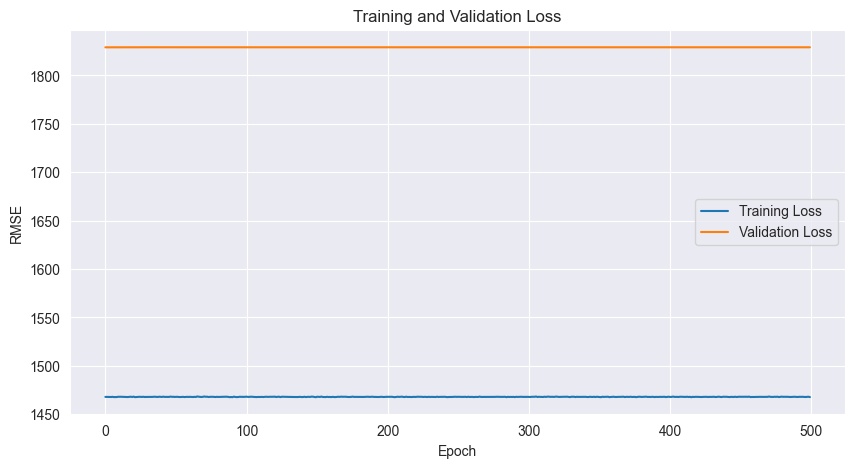

Final validation RMSE: 1828.9500
  Fold 2/5
Input size: 437



  2%|▏         | 9/500 [00:00<00:05, 85.76it/s]

Epoch 0: Train RMSE: 1656.6909, Val RMSE: 1315.7529
Epoch 10: Train RMSE: 1656.7610, Val RMSE: 1315.9189



  7%|▋         | 37/500 [00:00<00:05, 90.80it/s]

Epoch 20: Train RMSE: 1656.7578, Val RMSE: 1315.9044
Epoch 30: Train RMSE: 1656.8798, Val RMSE: 1315.7916



 12%|█▏        | 58/500 [00:00<00:04, 95.08it/s]

Epoch 40: Train RMSE: 1656.8148, Val RMSE: 1315.7831
Epoch 50: Train RMSE: 1656.7026, Val RMSE: 1315.7817



 16%|█▌        | 79/500 [00:00<00:04, 94.58it/s]

Epoch 60: Train RMSE: 1656.5017, Val RMSE: 1315.8032
Epoch 70: Train RMSE: 1656.6528, Val RMSE: 1315.8097



 18%|█▊        | 89/500 [00:00<00:04, 90.78it/s]

Epoch 80: Train RMSE: 1656.6835, Val RMSE: 1315.8142
Epoch 90: Train RMSE: 1656.7449, Val RMSE: 1315.8167



 24%|██▎       | 118/500 [00:01<00:04, 79.92it/s]

Epoch 100: Train RMSE: 1656.6790, Val RMSE: 1315.8167
Epoch 110: Train RMSE: 1656.7035, Val RMSE: 1315.8167



 27%|██▋       | 136/500 [00:01<00:04, 83.80it/s]

Epoch 120: Train RMSE: 1656.6576, Val RMSE: 1315.8165
Epoch 130: Train RMSE: 1656.7289, Val RMSE: 1315.8163



 31%|███       | 156/500 [00:01<00:03, 90.52it/s]

Epoch 140: Train RMSE: 1656.7225, Val RMSE: 1315.8163
Epoch 150: Train RMSE: 1656.5530, Val RMSE: 1315.8163



 35%|███▌      | 176/500 [00:02<00:03, 92.82it/s]

Epoch 160: Train RMSE: 1656.8850, Val RMSE: 1315.8163
Epoch 170: Train RMSE: 1656.7236, Val RMSE: 1315.8163



 39%|███▉      | 196/500 [00:02<00:03, 91.99it/s]

Epoch 180: Train RMSE: 1656.4833, Val RMSE: 1315.8163
Epoch 190: Train RMSE: 1656.6366, Val RMSE: 1315.8163



 43%|████▎     | 216/500 [00:02<00:03, 91.88it/s]

Epoch 200: Train RMSE: 1656.7937, Val RMSE: 1315.8163
Epoch 210: Train RMSE: 1656.6299, Val RMSE: 1315.8163



 47%|████▋     | 236/500 [00:02<00:03, 87.76it/s]

Epoch 220: Train RMSE: 1656.8649, Val RMSE: 1315.8163
Epoch 230: Train RMSE: 1656.4376, Val RMSE: 1315.8163



 51%|█████     | 256/500 [00:02<00:02, 90.94it/s]

Epoch 240: Train RMSE: 1656.6937, Val RMSE: 1315.8163
Epoch 250: Train RMSE: 1656.6167, Val RMSE: 1315.8163



 55%|█████▌    | 277/500 [00:03<00:02, 94.34it/s]

Epoch 260: Train RMSE: 1656.6390, Val RMSE: 1315.8163
Epoch 270: Train RMSE: 1656.7733, Val RMSE: 1315.8163
Epoch 280: Train RMSE: 1656.8125, Val RMSE: 1315.8163



 62%|██████▏   | 308/500 [00:03<00:01, 97.07it/s]

Epoch 290: Train RMSE: 1656.7247, Val RMSE: 1315.8163
Epoch 300: Train RMSE: 1656.7417, Val RMSE: 1315.8162



 66%|██████▌   | 328/500 [00:03<00:01, 95.27it/s]

Epoch 310: Train RMSE: 1656.6974, Val RMSE: 1315.8163
Epoch 320: Train RMSE: 1656.7080, Val RMSE: 1315.8162



 70%|██████▉   | 348/500 [00:03<00:01, 93.62it/s]

Epoch 330: Train RMSE: 1656.5184, Val RMSE: 1315.8162
Epoch 340: Train RMSE: 1656.7356, Val RMSE: 1315.8162



 74%|███████▎  | 368/500 [00:04<00:01, 94.32it/s]

Epoch 350: Train RMSE: 1656.8617, Val RMSE: 1315.8162
Epoch 360: Train RMSE: 1656.7407, Val RMSE: 1315.8162



 78%|███████▊  | 388/500 [00:04<00:01, 94.33it/s]

Epoch 370: Train RMSE: 1656.7404, Val RMSE: 1315.8162
Epoch 380: Train RMSE: 1656.6715, Val RMSE: 1315.8162



 82%|████████▏ | 408/500 [00:04<00:00, 92.28it/s]

Epoch 390: Train RMSE: 1656.8152, Val RMSE: 1315.8163
Epoch 400: Train RMSE: 1656.6621, Val RMSE: 1315.8163



 86%|████████▌ | 428/500 [00:04<00:00, 91.64it/s]

Epoch 410: Train RMSE: 1656.7471, Val RMSE: 1315.8163
Epoch 420: Train RMSE: 1656.7623, Val RMSE: 1315.8163



 90%|████████▉ | 448/500 [00:04<00:00, 93.42it/s]

Epoch 430: Train RMSE: 1656.6829, Val RMSE: 1315.8163
Epoch 440: Train RMSE: 1656.7816, Val RMSE: 1315.8163



 94%|█████████▎| 468/500 [00:05<00:00, 91.90it/s]

Epoch 450: Train RMSE: 1656.6559, Val RMSE: 1315.8163
Epoch 460: Train RMSE: 1656.6084, Val RMSE: 1315.8163



 98%|█████████▊| 488/500 [00:05<00:00, 92.92it/s]

Epoch 470: Train RMSE: 1656.6892, Val RMSE: 1315.8163
Epoch 480: Train RMSE: 1656.6815, Val RMSE: 1315.8163



100%|██████████| 500/500 [00:05<00:00, 90.81it/s]


Epoch 490: Train RMSE: 1656.7338, Val RMSE: 1315.8163


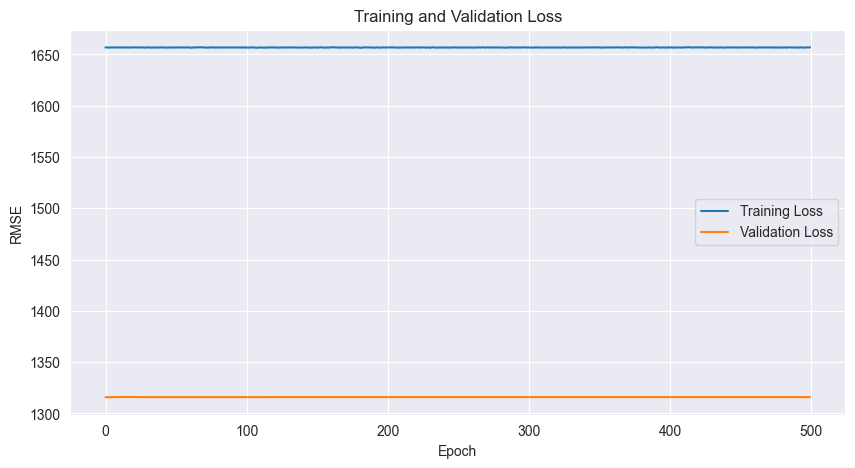

Final validation RMSE: 1315.7305
  Fold 3/5
Input size: 437



  1%|▏         | 7/500 [00:00<00:07, 62.82it/s]

Epoch 0: Train RMSE: 1552.1458, Val RMSE: 2262.1450
Epoch 10: Train RMSE: 1551.9670, Val RMSE: 2262.1279



  6%|▌         | 28/500 [00:00<00:08, 56.96it/s]

Epoch 20: Train RMSE: 1552.0505, Val RMSE: 2262.1072
Epoch 30: Train RMSE: 1551.9440, Val RMSE: 2262.0930



 11%|█         | 53/500 [00:00<00:06, 72.05it/s]

Epoch 40: Train RMSE: 1552.0077, Val RMSE: 2262.0977
Epoch 50: Train RMSE: 1551.9812, Val RMSE: 2262.0972



 14%|█▍        | 69/500 [00:00<00:05, 74.92it/s]

Epoch 60: Train RMSE: 1552.0668, Val RMSE: 2262.0979
Epoch 70: Train RMSE: 1552.1731, Val RMSE: 2262.0994



 19%|█▉        | 94/500 [00:01<00:05, 77.21it/s]

Epoch 80: Train RMSE: 1551.9183, Val RMSE: 2262.0991
Epoch 90: Train RMSE: 1552.0157, Val RMSE: 2262.0994



 22%|██▏       | 112/500 [00:01<00:04, 79.69it/s]

Epoch 100: Train RMSE: 1551.8484, Val RMSE: 2262.0994
Epoch 110: Train RMSE: 1552.0038, Val RMSE: 2262.0994



 26%|██▌       | 130/500 [00:01<00:04, 82.15it/s]

Epoch 120: Train RMSE: 1551.9712, Val RMSE: 2262.0991
Epoch 130: Train RMSE: 1551.9603, Val RMSE: 2262.0994



 31%|███       | 156/500 [00:02<00:04, 80.44it/s]

Epoch 140: Train RMSE: 1551.9900, Val RMSE: 2262.0991
Epoch 150: Train RMSE: 1551.9760, Val RMSE: 2262.0994



 35%|███▍      | 174/500 [00:02<00:03, 83.45it/s]

Epoch 160: Train RMSE: 1552.0380, Val RMSE: 2262.0994
Epoch 170: Train RMSE: 1551.9626, Val RMSE: 2262.0994



 38%|███▊      | 192/500 [00:02<00:03, 84.27it/s]

Epoch 180: Train RMSE: 1551.9786, Val RMSE: 2262.0991
Epoch 190: Train RMSE: 1552.0160, Val RMSE: 2262.0991



 42%|████▏     | 210/500 [00:02<00:03, 81.33it/s]

Epoch 200: Train RMSE: 1551.9296, Val RMSE: 2262.0991
Epoch 210: Train RMSE: 1552.1971, Val RMSE: 2262.0991



 47%|████▋     | 236/500 [00:03<00:03, 77.58it/s]

Epoch 220: Train RMSE: 1552.0781, Val RMSE: 2262.0991
Epoch 230: Train RMSE: 1552.0692, Val RMSE: 2262.0991



 50%|█████     | 252/500 [00:03<00:03, 73.80it/s]

Epoch 240: Train RMSE: 1552.0220, Val RMSE: 2262.0991
Epoch 250: Train RMSE: 1551.9171, Val RMSE: 2262.0991



 54%|█████▍    | 269/500 [00:03<00:03, 76.58it/s]

Epoch 260: Train RMSE: 1552.0558, Val RMSE: 2262.0991
Epoch 270: Train RMSE: 1551.9536, Val RMSE: 2262.0991



 59%|█████▉    | 297/500 [00:03<00:02, 84.92it/s]

Epoch 280: Train RMSE: 1552.0598, Val RMSE: 2262.0991
Epoch 290: Train RMSE: 1551.9119, Val RMSE: 2262.0991



 63%|██████▎   | 315/500 [00:04<00:02, 82.41it/s]

Epoch 300: Train RMSE: 1551.9722, Val RMSE: 2262.0991
Epoch 310: Train RMSE: 1552.0494, Val RMSE: 2262.0991



 67%|██████▋   | 333/500 [00:04<00:02, 80.44it/s]

Epoch 320: Train RMSE: 1551.9117, Val RMSE: 2262.0991
Epoch 330: Train RMSE: 1551.9628, Val RMSE: 2262.0991



 71%|███████   | 353/500 [00:04<00:01, 87.23it/s]

Epoch 340: Train RMSE: 1552.0398, Val RMSE: 2262.0991
Epoch 350: Train RMSE: 1551.9966, Val RMSE: 2262.0991



 74%|███████▍  | 371/500 [00:04<00:01, 86.16it/s]

Epoch 360: Train RMSE: 1552.0435, Val RMSE: 2262.0991
Epoch 370: Train RMSE: 1551.9241, Val RMSE: 2262.0991



 78%|███████▊  | 389/500 [00:04<00:01, 83.21it/s]

Epoch 380: Train RMSE: 1551.9016, Val RMSE: 2262.0991
Epoch 390: Train RMSE: 1552.0134, Val RMSE: 2262.0991



 83%|████████▎ | 416/500 [00:05<00:01, 81.86it/s]

Epoch 400: Train RMSE: 1551.9885, Val RMSE: 2262.0991
Epoch 410: Train RMSE: 1551.9781, Val RMSE: 2262.0991



 87%|████████▋ | 434/500 [00:05<00:00, 81.01it/s]

Epoch 420: Train RMSE: 1551.9302, Val RMSE: 2262.0991
Epoch 430: Train RMSE: 1552.0416, Val RMSE: 2262.0991



 90%|█████████ | 452/500 [00:05<00:00, 80.29it/s]

Epoch 440: Train RMSE: 1551.9703, Val RMSE: 2262.0991
Epoch 450: Train RMSE: 1551.9897, Val RMSE: 2262.0991



 94%|█████████▍| 470/500 [00:05<00:00, 82.36it/s]

Epoch 460: Train RMSE: 1552.0148, Val RMSE: 2262.0991
Epoch 470: Train RMSE: 1552.0137, Val RMSE: 2262.0991



100%|█████████▉| 498/500 [00:06<00:00, 86.75it/s]

Epoch 480: Train RMSE: 1552.0468, Val RMSE: 2262.0991
Epoch 490: Train RMSE: 1551.9728, Val RMSE: 2262.0991


100%|██████████| 500/500 [00:06<00:00, 79.82it/s]


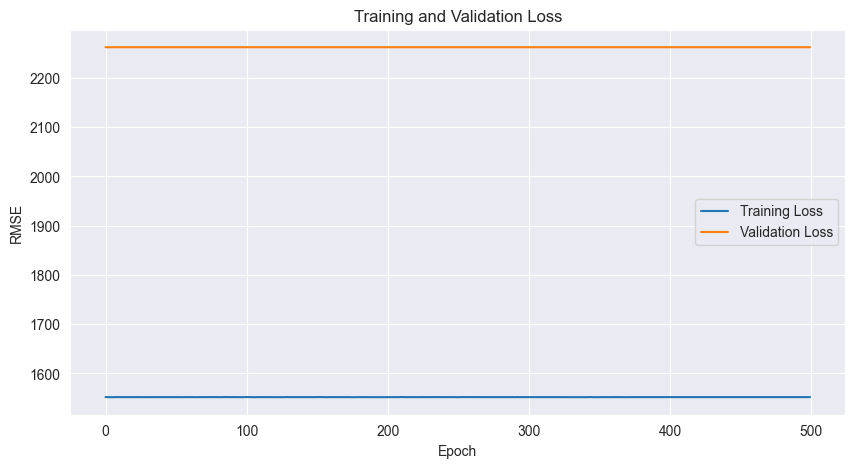

Final validation RMSE: 2262.0928
  Fold 4/5
Input size: 437



  1%|          | 6/500 [00:00<00:08, 56.66it/s]

Epoch 0: Train RMSE: 1755.8126, Val RMSE: 2261.7959
Epoch 10: Train RMSE: 1755.8293, Val RMSE: 2261.8198



  5%|▌         | 27/500 [00:00<00:08, 57.21it/s]

Epoch 20: Train RMSE: 1755.8042, Val RMSE: 2261.7837
Epoch 30: Train RMSE: 1755.6899, Val RMSE: 2261.7830



 11%|█         | 53/500 [00:01<00:08, 51.83it/s]

Epoch 40: Train RMSE: 1755.8242, Val RMSE: 2261.7932
Epoch 50: Train RMSE: 1755.8528, Val RMSE: 2261.7939



 15%|█▍        | 73/500 [00:01<00:07, 58.25it/s]

Epoch 60: Train RMSE: 1755.8159, Val RMSE: 2261.7942
Epoch 70: Train RMSE: 1755.8450, Val RMSE: 2261.7944



 17%|█▋        | 87/500 [00:01<00:06, 60.90it/s]

Epoch 80: Train RMSE: 1755.8169, Val RMSE: 2261.7949
Epoch 90: Train RMSE: 1755.7676, Val RMSE: 2261.7949



 22%|██▏       | 108/500 [00:01<00:06, 61.93it/s]

Epoch 100: Train RMSE: 1755.8252, Val RMSE: 2261.7947
Epoch 110: Train RMSE: 1755.7633, Val RMSE: 2261.7944



 26%|██▌       | 131/500 [00:02<00:05, 70.42it/s]

Epoch 120: Train RMSE: 1755.8337, Val RMSE: 2261.7947
Epoch 130: Train RMSE: 1755.8965, Val RMSE: 2261.7947



 31%|███       | 155/500 [00:02<00:04, 72.91it/s]

Epoch 140: Train RMSE: 1755.7465, Val RMSE: 2261.7947
Epoch 150: Train RMSE: 1755.7463, Val RMSE: 2261.7947



 34%|███▍      | 171/500 [00:02<00:04, 71.93it/s]

Epoch 160: Train RMSE: 1755.8629, Val RMSE: 2261.7947
Epoch 170: Train RMSE: 1755.7917, Val RMSE: 2261.7947



 39%|███▉      | 195/500 [00:03<00:04, 72.74it/s]

Epoch 180: Train RMSE: 1755.8683, Val RMSE: 2261.7947
Epoch 190: Train RMSE: 1755.8286, Val RMSE: 2261.7947



 42%|████▏     | 211/500 [00:03<00:03, 73.10it/s]

Epoch 200: Train RMSE: 1755.6721, Val RMSE: 2261.7947
Epoch 210: Train RMSE: 1755.7314, Val RMSE: 2261.7947



 45%|████▌     | 226/500 [00:03<00:04, 66.10it/s]

Epoch 220: Train RMSE: 1755.9225, Val RMSE: 2261.7947
Epoch 230: Train RMSE: 1755.7849, Val RMSE: 2261.7947



 51%|█████     | 254/500 [00:03<00:03, 64.70it/s]

Epoch 240: Train RMSE: 1755.7892, Val RMSE: 2261.7947
Epoch 250: Train RMSE: 1755.8872, Val RMSE: 2261.7944



 54%|█████▎    | 268/500 [00:04<00:03, 66.19it/s]

Epoch 260: Train RMSE: 1755.8306, Val RMSE: 2261.7947
Epoch 270: Train RMSE: 1755.7054, Val RMSE: 2261.7947



 59%|█████▉    | 294/500 [00:04<00:02, 74.98it/s]

Epoch 280: Train RMSE: 1755.7673, Val RMSE: 2261.7947
Epoch 290: Train RMSE: 1755.7788, Val RMSE: 2261.7947



 62%|██████▏   | 311/500 [00:04<00:02, 77.91it/s]

Epoch 300: Train RMSE: 1755.8529, Val RMSE: 2261.7947
Epoch 310: Train RMSE: 1755.7931, Val RMSE: 2261.7947



 67%|██████▋   | 336/500 [00:05<00:02, 78.11it/s]

Epoch 320: Train RMSE: 1755.8290, Val RMSE: 2261.7947
Epoch 330: Train RMSE: 1755.7811, Val RMSE: 2261.7947



 71%|███████   | 353/500 [00:05<00:01, 78.27it/s]

Epoch 340: Train RMSE: 1755.8518, Val RMSE: 2261.7947
Epoch 350: Train RMSE: 1755.8328, Val RMSE: 2261.7947



 74%|███████▍  | 369/500 [00:05<00:01, 76.88it/s]

Epoch 360: Train RMSE: 1755.7675, Val RMSE: 2261.7947
Epoch 370: Train RMSE: 1755.8021, Val RMSE: 2261.7947



 79%|███████▉  | 394/500 [00:05<00:01, 75.58it/s]

Epoch 380: Train RMSE: 1755.7480, Val RMSE: 2261.7947
Epoch 390: Train RMSE: 1755.8110, Val RMSE: 2261.7947



 82%|████████▏ | 410/500 [00:06<00:01, 69.46it/s]

Epoch 400: Train RMSE: 1755.8474, Val RMSE: 2261.7947
Epoch 410: Train RMSE: 1755.7939, Val RMSE: 2261.7947



 85%|████████▌ | 425/500 [00:06<00:01, 54.58it/s]

Epoch 420: Train RMSE: 1755.7064, Val RMSE: 2261.7947



 88%|████████▊ | 441/500 [00:06<00:00, 64.98it/s]

Epoch 430: Train RMSE: 1755.9045, Val RMSE: 2261.7947
Epoch 440: Train RMSE: 1755.8132, Val RMSE: 2261.7947



 93%|█████████▎| 465/500 [00:06<00:00, 74.41it/s]

Epoch 450: Train RMSE: 1755.8430, Val RMSE: 2261.7947
Epoch 460: Train RMSE: 1755.8499, Val RMSE: 2261.7947



 96%|█████████▋| 482/500 [00:07<00:00, 76.84it/s]

Epoch 470: Train RMSE: 1755.6744, Val RMSE: 2261.7947
Epoch 480: Train RMSE: 1755.9089, Val RMSE: 2261.7947



100%|██████████| 500/500 [00:07<00:00, 67.86it/s]


Epoch 490: Train RMSE: 1755.8716, Val RMSE: 2261.7947


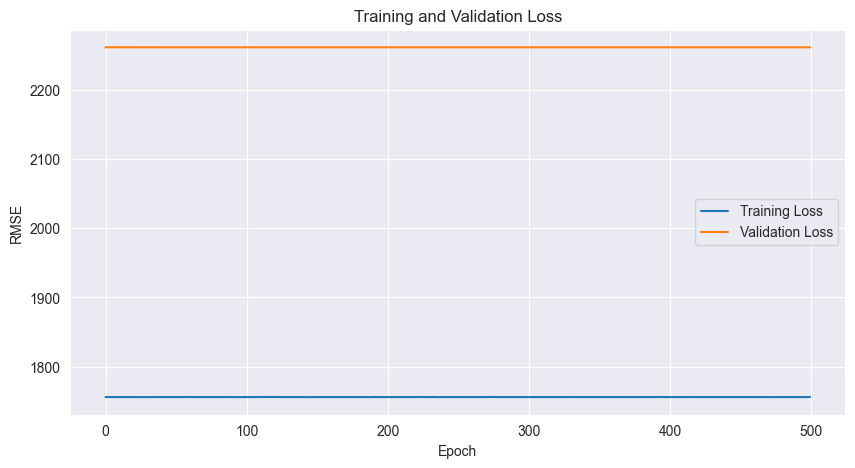

Final validation RMSE: 2261.7673
  Fold 5/5
Input size: 437



  1%|          | 6/500 [00:00<00:09, 54.88it/s]

Epoch 0: Train RMSE: 1867.7283, Val RMSE: 2493.1711
Epoch 10: Train RMSE: 1867.6538, Val RMSE: 2493.2087



  6%|▋         | 32/500 [00:00<00:08, 57.99it/s]

Epoch 20: Train RMSE: 1867.7452, Val RMSE: 2493.1062
Epoch 30: Train RMSE: 1867.7367, Val RMSE: 2493.0901



 10%|█         | 50/500 [00:00<00:08, 55.30it/s]

Epoch 40: Train RMSE: 1867.8218, Val RMSE: 2493.1128
Epoch 50: Train RMSE: 1867.7625, Val RMSE: 2493.0706



 14%|█▍        | 70/500 [00:01<00:07, 57.62it/s]

Epoch 60: Train RMSE: 1867.7872, Val RMSE: 2493.1003
Epoch 70: Train RMSE: 1867.7703, Val RMSE: 2493.1030



 18%|█▊        | 88/500 [00:01<00:07, 58.01it/s]

Epoch 80: Train RMSE: 1867.7870, Val RMSE: 2493.1365
Epoch 90: Train RMSE: 1867.6952, Val RMSE: 2493.1096



 21%|██        | 106/500 [00:01<00:06, 57.28it/s]

Epoch 100: Train RMSE: 1867.6993, Val RMSE: 2493.1079
Epoch 110: Train RMSE: 1867.7106, Val RMSE: 2493.1082



 26%|██▌       | 130/500 [00:02<00:06, 55.12it/s]

Epoch 120: Train RMSE: 1867.6349, Val RMSE: 2493.1055
Epoch 130: Train RMSE: 1867.7466, Val RMSE: 2493.1052



 29%|██▊       | 143/500 [00:02<00:07, 46.48it/s]

Epoch 140: Train RMSE: 1867.8546, Val RMSE: 2493.1050



 31%|███▏      | 157/500 [00:02<00:06, 55.01it/s]

Epoch 150: Train RMSE: 1867.6738, Val RMSE: 2493.1055
Epoch 160: Train RMSE: 1867.7037, Val RMSE: 2493.1055



 35%|███▌      | 177/500 [00:03<00:05, 58.40it/s]

Epoch 170: Train RMSE: 1867.6813, Val RMSE: 2493.1052
Epoch 180: Train RMSE: 1867.7771, Val RMSE: 2493.1050



 40%|████      | 202/500 [00:03<00:05, 57.53it/s]

Epoch 190: Train RMSE: 1867.7551, Val RMSE: 2493.1050
Epoch 200: Train RMSE: 1867.7798, Val RMSE: 2493.1052



 44%|████▍     | 222/500 [00:03<00:04, 58.85it/s]

Epoch 210: Train RMSE: 1867.7354, Val RMSE: 2493.1052
Epoch 220: Train RMSE: 1867.7577, Val RMSE: 2493.1055



 47%|████▋     | 236/500 [00:04<00:04, 58.64it/s]

Epoch 230: Train RMSE: 1867.7545, Val RMSE: 2493.1055
Epoch 240: Train RMSE: 1867.7257, Val RMSE: 2493.1052



 53%|█████▎    | 263/500 [00:04<00:03, 62.15it/s]

Epoch 250: Train RMSE: 1867.6750, Val RMSE: 2493.1052
Epoch 260: Train RMSE: 1867.6906, Val RMSE: 2493.1055



 57%|█████▋    | 284/500 [00:04<00:03, 62.05it/s]

Epoch 270: Train RMSE: 1867.7896, Val RMSE: 2493.1055
Epoch 280: Train RMSE: 1867.6282, Val RMSE: 2493.1055



 60%|█████▉    | 298/500 [00:05<00:03, 62.16it/s]

Epoch 290: Train RMSE: 1867.7502, Val RMSE: 2493.1055
Epoch 300: Train RMSE: 1867.7733, Val RMSE: 2493.1055



 64%|██████▎   | 318/500 [00:05<00:03, 57.91it/s]

Epoch 310: Train RMSE: 1867.6548, Val RMSE: 2493.1055
Epoch 320: Train RMSE: 1867.7186, Val RMSE: 2493.1055



 67%|██████▋   | 336/500 [00:05<00:03, 54.05it/s]

Epoch 330: Train RMSE: 1867.7479, Val RMSE: 2493.1055
Epoch 340: Train RMSE: 1867.7443, Val RMSE: 2493.1055



 72%|███████▏  | 361/500 [00:06<00:02, 46.94it/s]

Epoch 350: Train RMSE: 1867.7748, Val RMSE: 2493.1052
Epoch 360: Train RMSE: 1867.6921, Val RMSE: 2493.1055



 76%|███████▌  | 380/500 [00:06<00:02, 51.05it/s]

Epoch 370: Train RMSE: 1867.7828, Val RMSE: 2493.1055
Epoch 380: Train RMSE: 1867.6416, Val RMSE: 2493.1055



 80%|███████▉  | 398/500 [00:07<00:01, 54.71it/s]

Epoch 390: Train RMSE: 1867.6488, Val RMSE: 2493.1055
Epoch 400: Train RMSE: 1867.6989, Val RMSE: 2493.1057



 84%|████████▍ | 422/500 [00:07<00:01, 55.13it/s]

Epoch 410: Train RMSE: 1867.8831, Val RMSE: 2493.1060
Epoch 420: Train RMSE: 1867.8198, Val RMSE: 2493.1060



 88%|████████▊ | 440/500 [00:07<00:01, 55.10it/s]

Epoch 430: Train RMSE: 1867.6689, Val RMSE: 2493.1060
Epoch 440: Train RMSE: 1867.7419, Val RMSE: 2493.1062



 92%|█████████▏| 458/500 [00:08<00:00, 51.43it/s]

Epoch 450: Train RMSE: 1867.6945, Val RMSE: 2493.1060



 94%|█████████▍| 470/500 [00:08<00:00, 52.56it/s]

Epoch 460: Train RMSE: 1867.6697, Val RMSE: 2493.1060
Epoch 470: Train RMSE: 1867.7190, Val RMSE: 2493.1060



 98%|█████████▊| 488/500 [00:08<00:00, 54.43it/s]

Epoch 480: Train RMSE: 1867.8427, Val RMSE: 2493.1062
Epoch 490: Train RMSE: 1867.7139, Val RMSE: 2493.1062



100%|██████████| 500/500 [00:08<00:00, 55.60it/s]


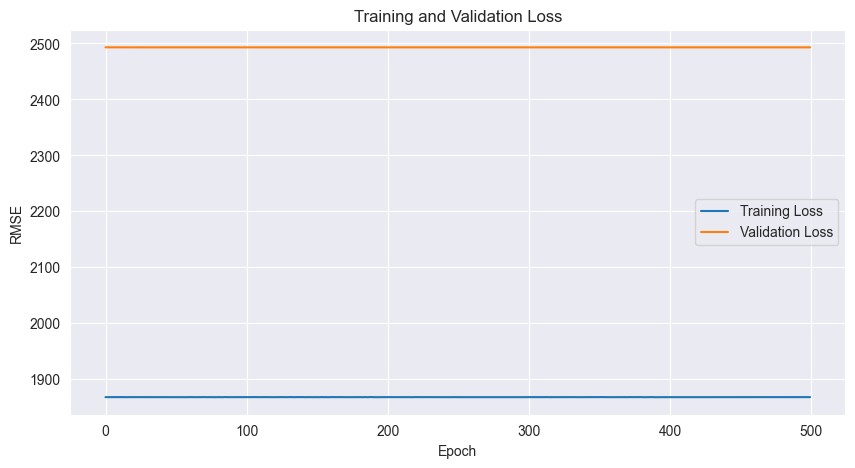

Final validation RMSE: 2493.0579
  Avg RMSE: 2032.3197 ± 417.7513

Testing: hidden_size=128, layers=10, lr=0.001
  Fold 1/5
Input size: 437



  2%|▏         | 8/500 [00:00<00:06, 77.89it/s]

Epoch 0: Train RMSE: 1467.9818, Val RMSE: 1829.0072
Epoch 10: Train RMSE: 1467.4962, Val RMSE: 1829.0099



  8%|▊         | 42/500 [00:00<00:04, 105.54it/s]

Epoch 20: Train RMSE: 1467.8844, Val RMSE: 1829.0166
Epoch 30: Train RMSE: 1467.4603, Val RMSE: 1829.0172
Epoch 40: Train RMSE: 1466.8136, Val RMSE: 1829.0203



 13%|█▎        | 64/500 [00:00<00:04, 105.00it/s]

Epoch 50: Train RMSE: 1467.1635, Val RMSE: 1829.0302
Epoch 60: Train RMSE: 1467.1925, Val RMSE: 1829.0311
Epoch 70: Train RMSE: 1467.1331, Val RMSE: 1829.0327



 19%|█▉        | 96/500 [00:00<00:04, 98.63it/s]

Epoch 80: Train RMSE: 1467.0336, Val RMSE: 1829.0334
Epoch 90: Train RMSE: 1467.0594, Val RMSE: 1829.0338



 23%|██▎       | 116/500 [00:01<00:04, 93.39it/s]

Epoch 100: Train RMSE: 1467.1727, Val RMSE: 1829.0339
Epoch 110: Train RMSE: 1467.0966, Val RMSE: 1829.0341



 27%|██▋       | 136/500 [00:01<00:03, 92.86it/s]

Epoch 120: Train RMSE: 1467.0634, Val RMSE: 1829.0339
Epoch 130: Train RMSE: 1467.1941, Val RMSE: 1829.0341



 31%|███       | 156/500 [00:01<00:03, 91.24it/s]

Epoch 140: Train RMSE: 1467.1113, Val RMSE: 1829.0341
Epoch 150: Train RMSE: 1466.7440, Val RMSE: 1829.0341



 35%|███▌      | 176/500 [00:01<00:03, 90.68it/s]

Epoch 160: Train RMSE: 1467.4875, Val RMSE: 1829.0341
Epoch 170: Train RMSE: 1467.2351, Val RMSE: 1829.0341



 39%|███▉      | 196/500 [00:02<00:03, 88.96it/s]

Epoch 180: Train RMSE: 1467.1670, Val RMSE: 1829.0341
Epoch 190: Train RMSE: 1467.4365, Val RMSE: 1829.0341



 43%|████▎     | 215/500 [00:02<00:03, 90.64it/s]

Epoch 200: Train RMSE: 1467.0518, Val RMSE: 1829.0341
Epoch 210: Train RMSE: 1466.9387, Val RMSE: 1829.0341



 47%|████▋     | 235/500 [00:02<00:02, 89.93it/s]

Epoch 220: Train RMSE: 1467.3462, Val RMSE: 1829.0341
Epoch 230: Train RMSE: 1467.2219, Val RMSE: 1829.0341



 51%|█████     | 255/500 [00:02<00:02, 90.85it/s]

Epoch 240: Train RMSE: 1466.7532, Val RMSE: 1829.0341
Epoch 250: Train RMSE: 1466.9264, Val RMSE: 1829.0341



 56%|█████▌    | 279/500 [00:02<00:02, 103.43it/s]

Epoch 260: Train RMSE: 1466.7577, Val RMSE: 1829.0341
Epoch 270: Train RMSE: 1466.9635, Val RMSE: 1829.0341
Epoch 280: Train RMSE: 1467.5320, Val RMSE: 1829.0341



 62%|██████▏   | 312/500 [00:03<00:01, 104.10it/s]

Epoch 290: Train RMSE: 1467.4327, Val RMSE: 1829.0341
Epoch 300: Train RMSE: 1467.2870, Val RMSE: 1829.0341
Epoch 310: Train RMSE: 1466.7683, Val RMSE: 1829.0341



 67%|██████▋   | 334/500 [00:03<00:01, 105.95it/s]

Epoch 320: Train RMSE: 1467.1072, Val RMSE: 1829.0341
Epoch 330: Train RMSE: 1467.0697, Val RMSE: 1829.0341
Epoch 340: Train RMSE: 1467.0020, Val RMSE: 1829.0341



 74%|███████▎  | 368/500 [00:03<00:01, 105.65it/s]

Epoch 350: Train RMSE: 1467.6276, Val RMSE: 1829.0341
Epoch 360: Train RMSE: 1467.2201, Val RMSE: 1829.0341
Epoch 370: Train RMSE: 1466.9390, Val RMSE: 1829.0341



 80%|████████  | 401/500 [00:04<00:00, 101.56it/s]

Epoch 380: Train RMSE: 1467.2721, Val RMSE: 1829.0341
Epoch 390: Train RMSE: 1467.4993, Val RMSE: 1829.0341
Epoch 400: Train RMSE: 1467.2411, Val RMSE: 1829.0341



 85%|████████▍ | 423/500 [00:04<00:00, 103.83it/s]

Epoch 410: Train RMSE: 1466.9694, Val RMSE: 1829.0341
Epoch 420: Train RMSE: 1467.4349, Val RMSE: 1829.0341
Epoch 430: Train RMSE: 1467.4464, Val RMSE: 1829.0341



 91%|█████████ | 456/500 [00:04<00:00, 102.67it/s]

Epoch 440: Train RMSE: 1467.2336, Val RMSE: 1829.0341
Epoch 450: Train RMSE: 1467.4437, Val RMSE: 1829.0341
Epoch 460: Train RMSE: 1466.8973, Val RMSE: 1829.0341



 96%|█████████▌| 478/500 [00:04<00:00, 105.02it/s]

Epoch 470: Train RMSE: 1467.5763, Val RMSE: 1829.0341
Epoch 480: Train RMSE: 1467.3076, Val RMSE: 1829.0341



100%|██████████| 500/500 [00:05<00:00, 97.57it/s] 

Epoch 490: Train RMSE: 1467.7194, Val RMSE: 1829.0341


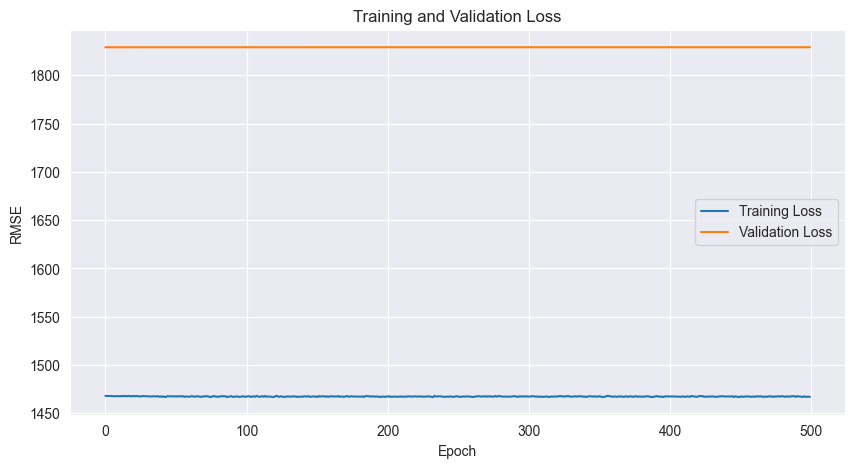

Final validation RMSE: 1828.9858
  Fold 2/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1656.8401, Val RMSE: 1315.3579



  2%|▏         | 10/500 [00:00<00:05, 96.79it/s]

Epoch 10: Train RMSE: 1656.7048, Val RMSE: 1315.8450



  4%|▍         | 20/500 [00:00<00:05, 91.62it/s]

Epoch 20: Train RMSE: 1656.7291, Val RMSE: 1315.7805



  6%|▌         | 30/500 [00:00<00:05, 92.05it/s]

Epoch 30: Train RMSE: 1656.7900, Val RMSE: 1315.8439



 10%|█         | 50/500 [00:00<00:04, 93.55it/s]

Epoch 40: Train RMSE: 1656.7526, Val RMSE: 1315.8683



 12%|█▏        | 60/500 [00:00<00:04, 93.44it/s]

Epoch 50: Train RMSE: 1656.7113, Val RMSE: 1315.8756


Epoch 60: Train RMSE: 1656.7998, Val RMSE: 1315.8862


 16%|█▌        | 80/500 [00:00<00:04, 95.09it/s]

Epoch 70: Train RMSE: 1656.7050, Val RMSE: 1315.8936
Epoch 80: Train RMSE: 1656.6495, Val RMSE: 1315.8961



 18%|█▊        | 90/500 [00:00<00:04, 93.16it/s]

Epoch 90: Train RMSE: 1656.7877, Val RMSE: 1315.8981



 20%|██        | 100/500 [00:01<00:04, 93.56it/s]

Epoch 100: Train RMSE: 1656.7064, Val RMSE: 1315.8992



 22%|██▏       | 110/500 [00:01<00:04, 92.57it/s]

Epoch 110: Train RMSE: 1656.7568, Val RMSE: 1315.8997



 24%|██▍       | 120/500 [00:01<00:04, 92.26it/s]

Epoch 120: Train RMSE: 1656.7300, Val RMSE: 1315.9000



 26%|██▌       | 130/500 [00:01<00:04, 90.52it/s]

Epoch 130: Train RMSE: 1656.7260, Val RMSE: 1315.9001



 30%|███       | 150/500 [00:01<00:03, 93.47it/s]

Epoch 140: Train RMSE: 1656.6757, Val RMSE: 1315.9003



 32%|███▏      | 160/500 [00:01<00:03, 94.69it/s]

Epoch 150: Train RMSE: 1656.6055, Val RMSE: 1315.9003
Epoch 160: Train RMSE: 1656.6963, Val RMSE: 1315.9003



 34%|███▍      | 170/500 [00:01<00:03, 93.41it/s]

Epoch 170: Train RMSE: 1656.7716, Val RMSE: 1315.9003



 36%|███▌      | 180/500 [00:01<00:03, 93.38it/s]

Epoch 180: Train RMSE: 1656.7515, Val RMSE: 1315.9003



 38%|███▊      | 190/500 [00:02<00:03, 92.05it/s]

Epoch 190: Train RMSE: 1656.6576, Val RMSE: 1315.9003



 40%|████      | 201/500 [00:02<00:03, 96.14it/s]

Epoch 200: Train RMSE: 1656.7765, Val RMSE: 1315.9003
Epoch 210: Train RMSE: 1656.6910, Val RMSE: 1315.9003



 42%|████▏     | 212/500 [00:02<00:02, 97.92it/s]

Epoch 220: Train RMSE: 1656.6432, Val RMSE: 1315.9003



 46%|████▋     | 232/500 [00:02<00:02, 97.86it/s]

Epoch 230: Train RMSE: 1656.7914, Val RMSE: 1315.9004



 48%|████▊     | 242/500 [00:02<00:02, 97.05it/s]

Epoch 240: Train RMSE: 1656.6285, Val RMSE: 1315.9004



 50%|█████     | 252/500 [00:02<00:02, 97.20it/s]

Epoch 250: Train RMSE: 1656.7684, Val RMSE: 1315.9004



 52%|█████▏    | 262/500 [00:02<00:02, 97.79it/s]

Epoch 260: Train RMSE: 1656.6870, Val RMSE: 1315.9004



 54%|█████▍    | 272/500 [00:02<00:02, 95.55it/s]

Epoch 270: Train RMSE: 1656.8933, Val RMSE: 1315.9004



 56%|█████▋    | 282/500 [00:02<00:02, 91.97it/s]

Epoch 280: Train RMSE: 1656.7330, Val RMSE: 1315.9004



 58%|█████▊    | 292/500 [00:03<00:02, 90.32it/s]

Epoch 290: Train RMSE: 1656.8279, Val RMSE: 1315.9004



 60%|██████    | 302/500 [00:03<00:02, 89.50it/s]

Epoch 300: Train RMSE: 1656.6849, Val RMSE: 1315.9004



 62%|██████▏   | 311/500 [00:03<00:02, 87.20it/s]

Epoch 310: Train RMSE: 1656.6816, Val RMSE: 1315.9004



 64%|██████▍   | 320/500 [00:03<00:02, 84.26it/s]

Epoch 320: Train RMSE: 1656.7312, Val RMSE: 1315.9004



 66%|██████▌   | 329/500 [00:03<00:02, 81.76it/s]

Epoch 330: Train RMSE: 1656.6819, Val RMSE: 1315.9004



 68%|██████▊   | 338/500 [00:03<00:02, 80.76it/s]

Epoch 340: Train RMSE: 1656.7542, Val RMSE: 1315.9004



 71%|███████   | 356/500 [00:03<00:01, 78.17it/s]

Epoch 350: Train RMSE: 1656.7339, Val RMSE: 1315.9004



 73%|███████▎  | 364/500 [00:04<00:01, 77.97it/s]

Epoch 360: Train RMSE: 1656.6631, Val RMSE: 1315.9004



 74%|███████▍  | 372/500 [00:04<00:01, 77.73it/s]

Epoch 370: Train RMSE: 1656.7852, Val RMSE: 1315.9004



 76%|███████▌  | 380/500 [00:04<00:01, 76.79it/s]

Epoch 380: Train RMSE: 1656.7380, Val RMSE: 1315.9004



 79%|███████▉  | 397/500 [00:04<00:01, 78.16it/s]

Epoch 390: Train RMSE: 1656.6659, Val RMSE: 1315.9004



 81%|████████  | 405/500 [00:04<00:01, 77.11it/s]

Epoch 400: Train RMSE: 1656.6705, Val RMSE: 1315.9004



 83%|████████▎ | 413/500 [00:04<00:01, 77.70it/s]

Epoch 410: Train RMSE: 1656.6888, Val RMSE: 1315.9004



 84%|████████▍ | 421/500 [00:04<00:01, 77.77it/s]

Epoch 420: Train RMSE: 1656.5603, Val RMSE: 1315.9004



 86%|████████▌ | 429/500 [00:04<00:00, 78.05it/s]

Epoch 430: Train RMSE: 1656.6884, Val RMSE: 1315.9004



 89%|████████▉ | 445/500 [00:05<00:00, 77.20it/s]

Epoch 440: Train RMSE: 1656.7454, Val RMSE: 1315.9004



 91%|█████████ | 454/500 [00:05<00:00, 80.46it/s]

Epoch 450: Train RMSE: 1656.7910, Val RMSE: 1315.9004



 93%|█████████▎| 463/500 [00:05<00:00, 78.92it/s]

Epoch 460: Train RMSE: 1656.6469, Val RMSE: 1315.9004



 94%|█████████▍| 472/500 [00:05<00:00, 79.71it/s]

Epoch 470: Train RMSE: 1656.6888, Val RMSE: 1315.9004



 96%|█████████▋| 482/500 [00:05<00:00, 85.41it/s]

Epoch 480: Train RMSE: 1656.8138, Val RMSE: 1315.9004



100%|██████████| 500/500 [00:05<00:00, 87.84it/s]

Epoch 490: Train RMSE: 1656.7025, Val RMSE: 1315.9004


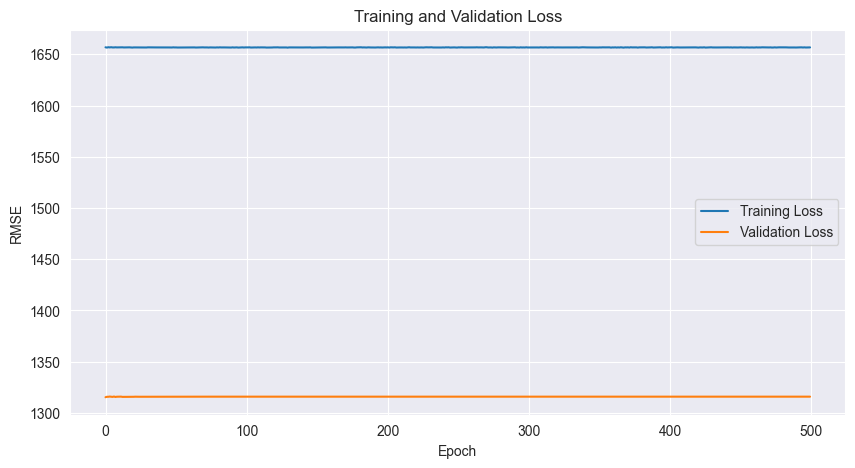

Final validation RMSE: 1315.3579
  Fold 3/5
Input size: 437



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Train RMSE: 1552.0527, Val RMSE: 2262.2993



  1%|▏         | 7/500 [00:00<00:07, 69.63it/s]

Epoch 10: Train RMSE: 1551.9685, Val RMSE: 2262.7715



  5%|▍         | 23/500 [00:00<00:06, 71.65it/s]

Epoch 20: Train RMSE: 1551.9980, Val RMSE: 2262.2434



  6%|▋         | 32/500 [00:00<00:06, 75.57it/s]

Epoch 30: Train RMSE: 1552.1520, Val RMSE: 2262.2961



  8%|▊         | 40/500 [00:00<00:05, 76.75it/s]

Epoch 40: Train RMSE: 1551.8915, Val RMSE: 2262.3088



 11%|█▏        | 57/500 [00:00<00:05, 79.05it/s]

Epoch 50: Train RMSE: 1552.0851, Val RMSE: 2262.3184



 13%|█▎        | 66/500 [00:00<00:05, 80.55it/s]

Epoch 60: Train RMSE: 1551.9872, Val RMSE: 2262.3164



 15%|█▌        | 75/500 [00:00<00:05, 81.54it/s]

Epoch 70: Train RMSE: 1552.0122, Val RMSE: 2262.3152



 17%|█▋        | 84/500 [00:01<00:05, 76.84it/s]

Epoch 80: Train RMSE: 1551.8856, Val RMSE: 2262.3152



 18%|█▊        | 92/500 [00:01<00:05, 77.47it/s]

Epoch 90: Train RMSE: 1551.8600, Val RMSE: 2262.3142



 20%|██        | 100/500 [00:01<00:05, 76.30it/s]

Epoch 100: Train RMSE: 1552.0486, Val RMSE: 2262.3135



 22%|██▏       | 109/500 [00:01<00:05, 78.01it/s]

Epoch 110: Train RMSE: 1551.9545, Val RMSE: 2262.3135



 25%|██▌       | 125/500 [00:01<00:04, 77.35it/s]

Epoch 120: Train RMSE: 1551.9938, Val RMSE: 2262.3135



 27%|██▋       | 133/500 [00:01<00:04, 78.06it/s]

Epoch 130: Train RMSE: 1551.9283, Val RMSE: 2262.3135



 28%|██▊       | 141/500 [00:01<00:04, 75.95it/s]

Epoch 140: Train RMSE: 1552.0437, Val RMSE: 2262.3135



 30%|██▉       | 149/500 [00:01<00:04, 75.21it/s]

Epoch 150: Train RMSE: 1551.9847, Val RMSE: 2262.3135



 33%|███▎      | 165/500 [00:02<00:04, 75.12it/s]

Epoch 160: Train RMSE: 1551.9926, Val RMSE: 2262.3135



 35%|███▍      | 173/500 [00:02<00:04, 74.98it/s]

Epoch 170: Train RMSE: 1552.0417, Val RMSE: 2262.3135



 36%|███▋      | 182/500 [00:02<00:04, 76.93it/s]

Epoch 180: Train RMSE: 1552.0321, Val RMSE: 2262.3135



 38%|███▊      | 190/500 [00:02<00:04, 76.61it/s]

Epoch 190: Train RMSE: 1551.9729, Val RMSE: 2262.3135



 40%|███▉      | 198/500 [00:02<00:04, 75.26it/s]


Epoch 200: Train RMSE: 1552.0054, Val RMSE: 2262.3135


 43%|████▎     | 214/500 [00:02<00:03, 74.62it/s]

Epoch 210: Train RMSE: 1551.9459, Val RMSE: 2262.3135



 44%|████▍     | 222/500 [00:02<00:03, 73.99it/s]

Epoch 220: Train RMSE: 1551.9542, Val RMSE: 2262.3135



 46%|████▌     | 230/500 [00:03<00:03, 74.58it/s]

Epoch 230: Train RMSE: 1551.9333, Val RMSE: 2262.3135



 49%|████▉     | 246/500 [00:03<00:03, 75.29it/s]

Epoch 240: Train RMSE: 1552.0247, Val RMSE: 2262.3135



 51%|█████     | 254/500 [00:03<00:03, 75.00it/s]

Epoch 250: Train RMSE: 1551.9534, Val RMSE: 2262.3135



 52%|█████▏    | 262/500 [00:03<00:03, 75.02it/s]

Epoch 260: Train RMSE: 1552.0134, Val RMSE: 2262.3135



 54%|█████▍    | 270/500 [00:03<00:03, 75.54it/s]

Epoch 270: Train RMSE: 1551.8501, Val RMSE: 2262.3135



 56%|█████▌    | 278/500 [00:03<00:02, 74.93it/s]

Epoch 280: Train RMSE: 1551.9142, Val RMSE: 2262.3135



 59%|█████▉    | 295/500 [00:03<00:02, 76.00it/s]

Epoch 290: Train RMSE: 1552.0209, Val RMSE: 2262.3135



 61%|██████    | 303/500 [00:03<00:02, 75.92it/s]

Epoch 300: Train RMSE: 1552.0398, Val RMSE: 2262.3135



 62%|██████▏   | 311/500 [00:04<00:02, 75.97it/s]

Epoch 310: Train RMSE: 1551.9148, Val RMSE: 2262.3135



 64%|██████▍   | 319/500 [00:04<00:02, 74.73it/s]

Epoch 320: Train RMSE: 1551.9353, Val RMSE: 2262.3135



 67%|██████▋   | 335/500 [00:04<00:02, 73.45it/s]

Epoch 330: Train RMSE: 1551.9445, Val RMSE: 2262.3135



 69%|██████▊   | 343/500 [00:04<00:02, 74.81it/s]

Epoch 340: Train RMSE: 1552.0140, Val RMSE: 2262.3135



 70%|███████   | 351/500 [00:04<00:01, 75.52it/s]

Epoch 350: Train RMSE: 1552.0817, Val RMSE: 2262.3135



 72%|███████▏  | 359/500 [00:04<00:01, 75.05it/s]

Epoch 360: Train RMSE: 1551.8799, Val RMSE: 2262.3135



 75%|███████▌  | 376/500 [00:04<00:01, 76.10it/s]

Epoch 370: Train RMSE: 1551.9883, Val RMSE: 2262.3135



 77%|███████▋  | 384/500 [00:05<00:01, 74.52it/s]

Epoch 380: Train RMSE: 1552.0073, Val RMSE: 2262.3135



 78%|███████▊  | 392/500 [00:05<00:01, 75.27it/s]

Epoch 390: Train RMSE: 1551.9078, Val RMSE: 2262.3135



 80%|████████  | 400/500 [00:05<00:01, 74.10it/s]

Epoch 400: Train RMSE: 1551.8944, Val RMSE: 2262.3135



 83%|████████▎ | 416/500 [00:05<00:01, 75.14it/s]

Epoch 410: Train RMSE: 1552.0361, Val RMSE: 2262.3135



 85%|████████▍ | 424/500 [00:05<00:01, 75.85it/s]

Epoch 420: Train RMSE: 1552.0365, Val RMSE: 2262.3135



 86%|████████▋ | 432/500 [00:05<00:00, 76.69it/s]

Epoch 430: Train RMSE: 1551.9835, Val RMSE: 2262.3135



 88%|████████▊ | 440/500 [00:05<00:00, 77.30it/s]

Epoch 440: Train RMSE: 1551.9814, Val RMSE: 2262.3135



 91%|█████████▏| 457/500 [00:06<00:00, 80.12it/s]

Epoch 450: Train RMSE: 1551.9913, Val RMSE: 2262.3135



 93%|█████████▎| 466/500 [00:06<00:00, 81.39it/s]

Epoch 460: Train RMSE: 1552.0977, Val RMSE: 2262.3135



 95%|█████████▌| 475/500 [00:06<00:00, 79.05it/s]

Epoch 470: Train RMSE: 1551.9275, Val RMSE: 2262.3132
Epoch 480: Train RMSE: 1551.9196, Val RMSE: 2262.3132



 98%|█████████▊| 491/500 [00:06<00:00, 72.16it/s]

Epoch 490: Train RMSE: 1551.9294, Val RMSE: 2262.3132



100%|██████████| 500/500 [00:06<00:00, 75.79it/s]


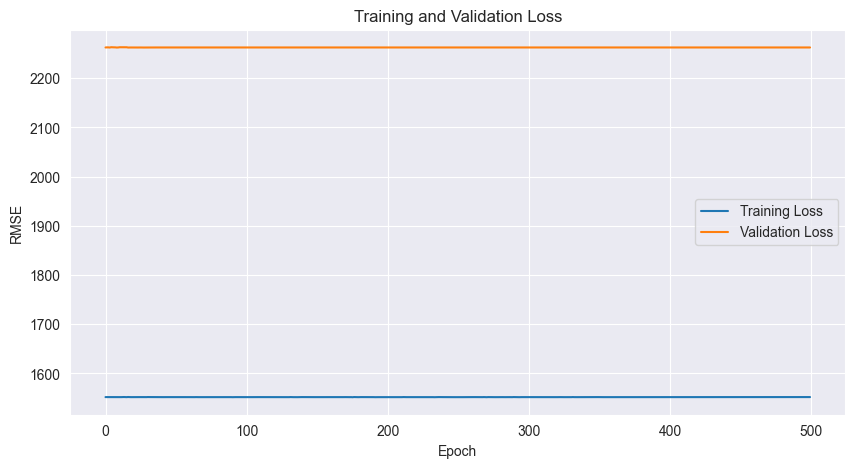

Final validation RMSE: 2262.1387
  Fold 4/5
Input size: 437



  1%|          | 5/500 [00:00<00:10, 47.71it/s]

Epoch 0: Train RMSE: 1755.7828, Val RMSE: 2261.7881



  2%|▏         | 11/500 [00:00<00:09, 54.22it/s]

Epoch 10: Train RMSE: 1755.7371, Val RMSE: 2261.8215



  3%|▎         | 17/500 [00:00<00:08, 56.17it/s]

Epoch 20: Train RMSE: 1755.6357, Val RMSE: 2261.8596



  6%|▋         | 32/500 [00:00<00:07, 62.62it/s]

Epoch 30: Train RMSE: 1755.7173, Val RMSE: 2261.8833



  8%|▊         | 39/500 [00:00<00:07, 63.85it/s]

Epoch 40: Train RMSE: 1755.5209, Val RMSE: 2262.1533



 11%|█         | 53/500 [00:00<00:06, 65.40it/s]

Epoch 50: Train RMSE: 1755.7964, Val RMSE: 2262.1799



 12%|█▏        | 61/500 [00:00<00:06, 67.87it/s]

Epoch 60: Train RMSE: 1755.8473, Val RMSE: 2261.9956



 17%|█▋        | 84/500 [00:01<00:06, 62.48it/s]

Epoch 70: Train RMSE: 1755.4739, Val RMSE: 2262.3040
Epoch 80: Train RMSE: 1755.5475, Val RMSE: 2261.9849



 20%|██        | 100/500 [00:01<00:05, 66.74it/s]

Epoch 90: Train RMSE: 1755.7682, Val RMSE: 2261.9856
Epoch 100: Train RMSE: 1755.4741, Val RMSE: 2261.9861



 24%|██▍       | 122/500 [00:01<00:05, 67.22it/s]

Epoch 110: Train RMSE: 1755.5454, Val RMSE: 2261.9866
Epoch 120: Train RMSE: 1755.5116, Val RMSE: 2261.9868



 29%|██▊       | 143/500 [00:02<00:05, 67.15it/s]

Epoch 130: Train RMSE: 1755.8939, Val RMSE: 2261.9868
Epoch 140: Train RMSE: 1755.6189, Val RMSE: 2261.9871



 32%|███▏      | 158/500 [00:02<00:05, 67.14it/s]

Epoch 150: Train RMSE: 1755.6239, Val RMSE: 2261.9868
Epoch 160: Train RMSE: 1755.6101, Val RMSE: 2261.9866



 36%|███▌      | 179/500 [00:02<00:04, 65.43it/s]

Epoch 170: Train RMSE: 1755.5439, Val RMSE: 2261.9868
Epoch 180: Train RMSE: 1755.7836, Val RMSE: 2261.9868



 40%|████      | 201/500 [00:03<00:04, 66.66it/s]

Epoch 190: Train RMSE: 1755.5232, Val RMSE: 2261.9868
Epoch 200: Train RMSE: 1755.2972, Val RMSE: 2261.9868



 45%|████▍     | 223/500 [00:03<00:04, 68.36it/s]

Epoch 210: Train RMSE: 1755.5150, Val RMSE: 2261.9871
Epoch 220: Train RMSE: 1755.5813, Val RMSE: 2261.9871



 49%|████▉     | 245/500 [00:03<00:03, 70.22it/s]

Epoch 230: Train RMSE: 1755.6097, Val RMSE: 2261.9871
Epoch 240: Train RMSE: 1755.7072, Val RMSE: 2261.9866



 52%|█████▏    | 261/500 [00:03<00:03, 71.31it/s]

Epoch 250: Train RMSE: 1755.4791, Val RMSE: 2261.9871
Epoch 260: Train RMSE: 1755.5645, Val RMSE: 2261.9866



 57%|█████▋    | 285/500 [00:04<00:03, 71.04it/s]

Epoch 270: Train RMSE: 1755.6759, Val RMSE: 2261.9866
Epoch 280: Train RMSE: 1755.6029, Val RMSE: 2261.9866



 60%|██████    | 301/500 [00:04<00:02, 71.30it/s]

Epoch 290: Train RMSE: 1755.7148, Val RMSE: 2261.9866
Epoch 300: Train RMSE: 1755.5757, Val RMSE: 2261.9866



 65%|██████▌   | 325/500 [00:04<00:02, 72.75it/s]

Epoch 310: Train RMSE: 1755.6918, Val RMSE: 2261.9866
Epoch 320: Train RMSE: 1755.6743, Val RMSE: 2261.9866



 68%|██████▊   | 341/500 [00:05<00:02, 72.43it/s]

Epoch 330: Train RMSE: 1755.4514, Val RMSE: 2261.9868
Epoch 340: Train RMSE: 1755.4465, Val RMSE: 2261.9868



 73%|███████▎  | 365/500 [00:05<00:01, 72.87it/s]

Epoch 350: Train RMSE: 1755.6121, Val RMSE: 2261.9871
Epoch 360: Train RMSE: 1755.5081, Val RMSE: 2261.9871



 76%|███████▌  | 381/500 [00:05<00:01, 75.43it/s]

Epoch 370: Train RMSE: 1755.5237, Val RMSE: 2261.9871
Epoch 380: Train RMSE: 1755.6909, Val RMSE: 2261.9871



 81%|████████  | 405/500 [00:05<00:01, 73.25it/s]

Epoch 390: Train RMSE: 1755.6294, Val RMSE: 2261.9871
Epoch 400: Train RMSE: 1755.5928, Val RMSE: 2261.9871



 84%|████████▍ | 421/500 [00:06<00:01, 73.37it/s]

Epoch 410: Train RMSE: 1755.6897, Val RMSE: 2261.9871
Epoch 420: Train RMSE: 1755.7065, Val RMSE: 2261.9871



 87%|████████▋ | 437/500 [00:06<00:00, 70.70it/s]


Epoch 430: Train RMSE: 1755.3260, Val RMSE: 2261.9871
Epoch 440: Train RMSE: 1755.4745, Val RMSE: 2261.9871


 92%|█████████▏| 461/500 [00:06<00:00, 60.73it/s]

Epoch 450: Train RMSE: 1755.6483, Val RMSE: 2261.9871
Epoch 460: Train RMSE: 1755.5096, Val RMSE: 2261.9871



 97%|█████████▋| 485/500 [00:07<00:00, 67.40it/s]

Epoch 470: Train RMSE: 1755.5316, Val RMSE: 2261.9871
Epoch 480: Train RMSE: 1755.4686, Val RMSE: 2261.9871



100%|██████████| 500/500 [00:07<00:00, 67.67it/s]

Epoch 490: Train RMSE: 1755.6041, Val RMSE: 2261.9871


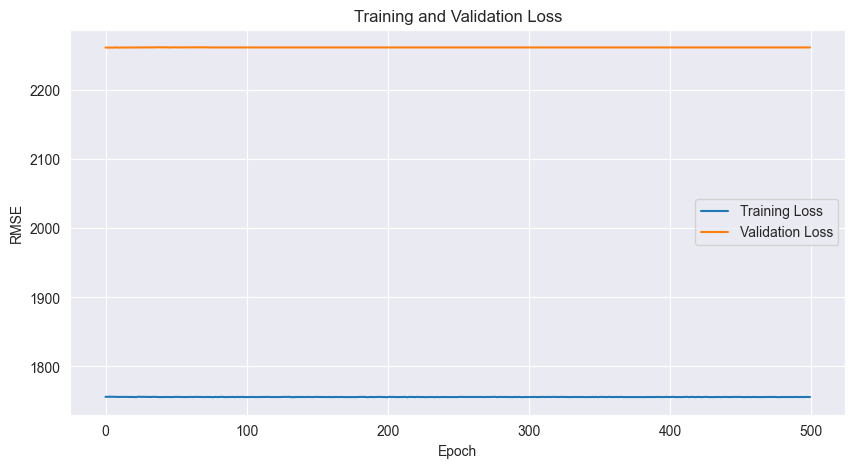

Final validation RMSE: 2261.7417
  Fold 5/5
Input size: 437



  1%|          | 4/500 [00:00<00:12, 38.68it/s]

Epoch 0: Train RMSE: 1867.6310, Val RMSE: 2493.3088



  4%|▍         | 21/500 [00:00<00:09, 51.77it/s]

Epoch 10: Train RMSE: 1867.5861, Val RMSE: 2493.4473
Epoch 20: Train RMSE: 1867.5012, Val RMSE: 2493.3564



  8%|▊         | 39/500 [00:00<00:08, 53.54it/s]

Epoch 30: Train RMSE: 1867.3687, Val RMSE: 2493.6404
Epoch 40: Train RMSE: 1867.4142, Val RMSE: 2493.6528



 11%|█▏        | 57/500 [00:01<00:08, 54.59it/s]

Epoch 50: Train RMSE: 1867.6270, Val RMSE: 2493.6829
Epoch 60: Train RMSE: 1867.5596, Val RMSE: 2493.6113



 16%|█▌        | 81/500 [00:01<00:07, 55.82it/s]

Epoch 70: Train RMSE: 1867.5460, Val RMSE: 2493.4749
Epoch 80: Train RMSE: 1867.4688, Val RMSE: 2493.5427



 20%|█▉        | 99/500 [00:01<00:07, 56.48it/s]

Epoch 90: Train RMSE: 1867.4250, Val RMSE: 2493.5439
Epoch 100: Train RMSE: 1867.5328, Val RMSE: 2493.5508



 23%|██▎       | 117/500 [00:02<00:07, 54.44it/s]

Epoch 110: Train RMSE: 1867.5040, Val RMSE: 2493.5508
Epoch 120: Train RMSE: 1867.5470, Val RMSE: 2493.5510



 28%|██▊       | 141/500 [00:02<00:06, 53.83it/s]

Epoch 130: Train RMSE: 1867.4956, Val RMSE: 2493.5513
Epoch 140: Train RMSE: 1867.6710, Val RMSE: 2493.5513



 32%|███▏      | 159/500 [00:02<00:06, 55.91it/s]

Epoch 150: Train RMSE: 1867.2534, Val RMSE: 2493.5513
Epoch 160: Train RMSE: 1867.6180, Val RMSE: 2493.5513



 35%|███▌      | 177/500 [00:03<00:06, 47.24it/s]

Epoch 170: Train RMSE: 1867.2905, Val RMSE: 2493.5513
Epoch 180: Train RMSE: 1867.7970, Val RMSE: 2493.5513



 40%|████      | 201/500 [00:03<00:05, 54.24it/s]

Epoch 190: Train RMSE: 1867.2845, Val RMSE: 2493.5513
Epoch 200: Train RMSE: 1867.4877, Val RMSE: 2493.5513



 44%|████▍     | 219/500 [00:04<00:05, 55.14it/s]

Epoch 210: Train RMSE: 1867.4707, Val RMSE: 2493.5513
Epoch 220: Train RMSE: 1867.4359, Val RMSE: 2493.5513



 47%|████▋     | 237/500 [00:04<00:04, 54.86it/s]

Epoch 230: Train RMSE: 1867.6107, Val RMSE: 2493.5513
Epoch 240: Train RMSE: 1867.3688, Val RMSE: 2493.5513



 52%|█████▏    | 261/500 [00:04<00:04, 53.93it/s]

Epoch 250: Train RMSE: 1867.4219, Val RMSE: 2493.5513
Epoch 260: Train RMSE: 1867.3519, Val RMSE: 2493.5513



 56%|█████▌    | 279/500 [00:05<00:04, 55.02it/s]

Epoch 270: Train RMSE: 1867.5731, Val RMSE: 2493.5513
Epoch 280: Train RMSE: 1867.5449, Val RMSE: 2493.5513



 59%|█████▉    | 297/500 [00:05<00:03, 53.71it/s]

Epoch 290: Train RMSE: 1867.5458, Val RMSE: 2493.5513
Epoch 300: Train RMSE: 1867.5272, Val RMSE: 2493.5513



 64%|██████▍   | 321/500 [00:05<00:03, 55.97it/s]

Epoch 310: Train RMSE: 1867.4565, Val RMSE: 2493.5513
Epoch 320: Train RMSE: 1867.5961, Val RMSE: 2493.5513



 68%|██████▊   | 339/500 [00:06<00:02, 54.03it/s]

Epoch 330: Train RMSE: 1867.4836, Val RMSE: 2493.5513
Epoch 340: Train RMSE: 1867.3912, Val RMSE: 2493.5513



 71%|███████▏  | 357/500 [00:06<00:02, 56.12it/s]

Epoch 350: Train RMSE: 1867.5569, Val RMSE: 2493.5513
Epoch 360: Train RMSE: 1867.4565, Val RMSE: 2493.5513



 75%|███████▌  | 375/500 [00:06<00:02, 55.14it/s]

Epoch 370: Train RMSE: 1867.5536, Val RMSE: 2493.5513



 77%|███████▋  | 387/500 [00:07<00:02, 45.64it/s]

Epoch 380: Train RMSE: 1867.5591, Val RMSE: 2493.5513
Epoch 390: Train RMSE: 1867.4269, Val RMSE: 2493.5513



 82%|████████▏ | 411/500 [00:07<00:01, 52.09it/s]

Epoch 400: Train RMSE: 1867.5028, Val RMSE: 2493.5513
Epoch 410: Train RMSE: 1867.4855, Val RMSE: 2493.5513



 86%|████████▌ | 430/500 [00:08<00:01, 57.40it/s]

Epoch 420: Train RMSE: 1867.4193, Val RMSE: 2493.5513
Epoch 430: Train RMSE: 1867.4531, Val RMSE: 2493.5513



 90%|████████▉ | 448/500 [00:08<00:01, 48.75it/s]

Epoch 440: Train RMSE: 1867.5272, Val RMSE: 2493.5513



 92%|█████████▏| 462/500 [00:08<00:00, 55.41it/s]

Epoch 450: Train RMSE: 1867.5559, Val RMSE: 2493.5513
Epoch 460: Train RMSE: 1867.4711, Val RMSE: 2493.5513



 96%|█████████▌| 480/500 [00:08<00:00, 54.50it/s]

Epoch 470: Train RMSE: 1867.4071, Val RMSE: 2493.5513
Epoch 480: Train RMSE: 1867.4185, Val RMSE: 2493.5513



100%|██████████| 500/500 [00:09<00:00, 53.57it/s]

Epoch 490: Train RMSE: 1867.7272, Val RMSE: 2493.5513


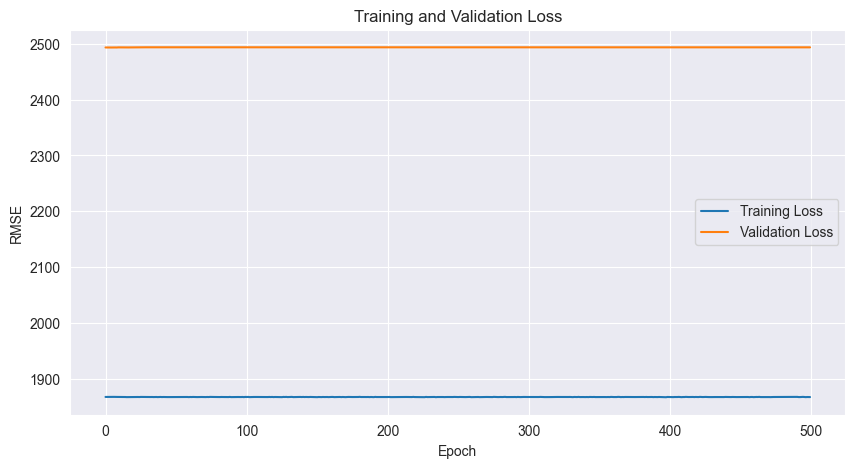

Final validation RMSE: 2493.2375
  Avg RMSE: 2032.2923 ± 417.9175

Testing: hidden_size=128, layers=10, lr=0.01
  Fold 1/5
Input size: 437



  2%|▏         | 10/500 [00:00<00:04, 99.37it/s]

Epoch 0: Train RMSE: 1467.7592, Val RMSE: 1829.0453
Epoch 10: Train RMSE: 1467.6416, Val RMSE: 1829.0139
Epoch 20: Train RMSE: 1468.1018, Val RMSE: 1829.0151



  9%|▉         | 47/500 [00:00<00:03, 113.68it/s]

Epoch 30: Train RMSE: 1467.5540, Val RMSE: 1828.9984
Epoch 40: Train RMSE: 1467.7827, Val RMSE: 1828.9988
Epoch 50: Train RMSE: 1467.7515, Val RMSE: 1828.9989



 17%|█▋        | 83/500 [00:00<00:03, 113.26it/s]

Epoch 60: Train RMSE: 1467.6416, Val RMSE: 1828.9990
Epoch 70: Train RMSE: 1467.6636, Val RMSE: 1828.9991
Epoch 80: Train RMSE: 1467.9192, Val RMSE: 1828.9993



 21%|██▏       | 107/500 [00:00<00:03, 114.23it/s]

Epoch 90: Train RMSE: 1467.6487, Val RMSE: 1828.9993
Epoch 100: Train RMSE: 1467.3784, Val RMSE: 1828.9993
Epoch 110: Train RMSE: 1467.7557, Val RMSE: 1828.9993



 29%|██▊       | 143/500 [00:01<00:03, 112.02it/s]

Epoch 120: Train RMSE: 1467.8254, Val RMSE: 1828.9991
Epoch 130: Train RMSE: 1467.7208, Val RMSE: 1828.9993
Epoch 140: Train RMSE: 1467.6754, Val RMSE: 1828.9993



 33%|███▎      | 167/500 [00:01<00:02, 112.06it/s]

Epoch 150: Train RMSE: 1467.9084, Val RMSE: 1828.9993
Epoch 160: Train RMSE: 1467.8628, Val RMSE: 1828.9993
Epoch 170: Train RMSE: 1467.9696, Val RMSE: 1828.9993



 41%|████      | 203/500 [00:01<00:02, 114.01it/s]

Epoch 180: Train RMSE: 1467.5283, Val RMSE: 1828.9993
Epoch 190: Train RMSE: 1467.9517, Val RMSE: 1828.9993
Epoch 200: Train RMSE: 1467.9016, Val RMSE: 1828.9993



 45%|████▌     | 227/500 [00:02<00:02, 113.72it/s]

Epoch 210: Train RMSE: 1467.7742, Val RMSE: 1828.9993
Epoch 220: Train RMSE: 1467.8954, Val RMSE: 1828.9993
Epoch 230: Train RMSE: 1467.9823, Val RMSE: 1828.9993



 50%|█████     | 251/500 [00:02<00:02, 109.85it/s]

Epoch 240: Train RMSE: 1467.7015, Val RMSE: 1828.9993
Epoch 250: Train RMSE: 1467.6400, Val RMSE: 1828.9993
Epoch 260: Train RMSE: 1467.7521, Val RMSE: 1828.9993



 57%|█████▋    | 287/500 [00:02<00:01, 111.06it/s]

Epoch 270: Train RMSE: 1467.7783, Val RMSE: 1828.9993
Epoch 280: Train RMSE: 1467.6771, Val RMSE: 1828.9993
Epoch 290: Train RMSE: 1467.7025, Val RMSE: 1828.9993



 65%|██████▍   | 323/500 [00:02<00:01, 114.39it/s]

Epoch 300: Train RMSE: 1467.9082, Val RMSE: 1828.9993
Epoch 310: Train RMSE: 1467.9131, Val RMSE: 1828.9993
Epoch 320: Train RMSE: 1467.6240, Val RMSE: 1828.9993



 69%|██████▉   | 347/500 [00:03<00:01, 108.46it/s]

Epoch 330: Train RMSE: 1467.6362, Val RMSE: 1828.9993
Epoch 340: Train RMSE: 1467.8569, Val RMSE: 1828.9993
Epoch 350: Train RMSE: 1467.5774, Val RMSE: 1828.9993



 77%|███████▋  | 384/500 [00:03<00:00, 116.08it/s]

Epoch 360: Train RMSE: 1467.9083, Val RMSE: 1828.9993
Epoch 370: Train RMSE: 1467.7273, Val RMSE: 1828.9993
Epoch 380: Train RMSE: 1468.0116, Val RMSE: 1828.9993



 82%|████████▏ | 409/500 [00:03<00:00, 118.23it/s]

Epoch 390: Train RMSE: 1467.7700, Val RMSE: 1828.9993
Epoch 400: Train RMSE: 1467.7858, Val RMSE: 1828.9993
Epoch 410: Train RMSE: 1467.4944, Val RMSE: 1828.9993



 87%|████████▋ | 435/500 [00:03<00:00, 121.47it/s]

Epoch 420: Train RMSE: 1467.8716, Val RMSE: 1828.9993
Epoch 430: Train RMSE: 1467.8274, Val RMSE: 1828.9993
Epoch 440: Train RMSE: 1467.7310, Val RMSE: 1828.9993



 95%|█████████▍| 474/500 [00:04<00:00, 120.76it/s]

Epoch 450: Train RMSE: 1467.8870, Val RMSE: 1828.9993
Epoch 460: Train RMSE: 1467.6290, Val RMSE: 1828.9993
Epoch 470: Train RMSE: 1467.8988, Val RMSE: 1828.9993



100%|██████████| 500/500 [00:04<00:00, 114.27it/s]

Epoch 480: Train RMSE: 1467.6770, Val RMSE: 1828.9993
Epoch 490: Train RMSE: 1467.7277, Val RMSE: 1828.9993


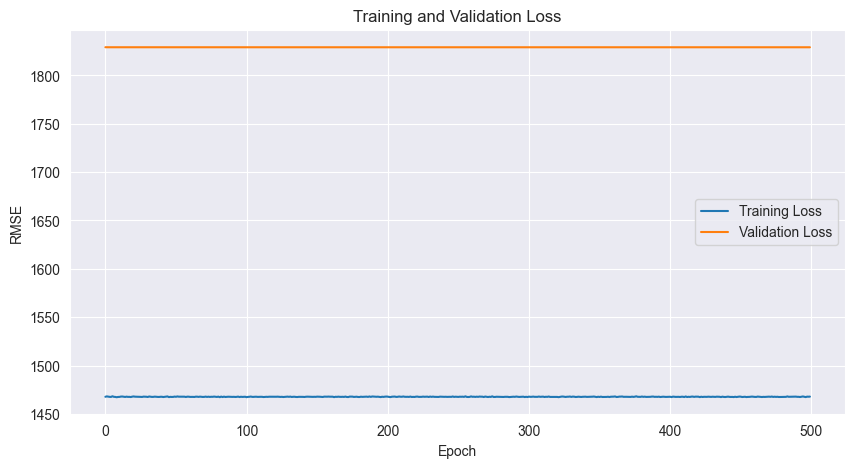

Final validation RMSE: 1828.9980
  Fold 2/5
Input size: 437



  2%|▏         | 10/500 [00:00<00:05, 92.97it/s]

Epoch 0: Train RMSE: 1656.7938, Val RMSE: 1315.8472
Epoch 10: Train RMSE: 1656.6653, Val RMSE: 1316.1301
Epoch 20: Train RMSE: 1656.7767, Val RMSE: 1315.8773



  7%|▋         | 33/500 [00:00<00:04, 101.89it/s]

Epoch 30: Train RMSE: 1656.8062, Val RMSE: 1315.9436
Epoch 40: Train RMSE: 1656.6493, Val RMSE: 1315.9832



 13%|█▎        | 66/500 [00:00<00:04, 103.46it/s]

Epoch 50: Train RMSE: 1656.6561, Val RMSE: 1315.9949
Epoch 60: Train RMSE: 1656.8043, Val RMSE: 1316.0011
Epoch 70: Train RMSE: 1656.7000, Val RMSE: 1316.0050



 20%|█▉        | 99/500 [00:00<00:03, 102.41it/s]

Epoch 80: Train RMSE: 1656.6583, Val RMSE: 1316.0084
Epoch 90: Train RMSE: 1656.6606, Val RMSE: 1316.0103
Epoch 100: Train RMSE: 1656.9221, Val RMSE: 1316.0111



 24%|██▍       | 121/500 [00:01<00:03, 101.85it/s]

Epoch 110: Train RMSE: 1656.7981, Val RMSE: 1316.0114
Epoch 120: Train RMSE: 1656.7314, Val RMSE: 1316.0116



 28%|██▊       | 142/500 [00:01<00:03, 97.24it/s]

Epoch 130: Train RMSE: 1656.6129, Val RMSE: 1316.0116
Epoch 140: Train RMSE: 1656.7419, Val RMSE: 1316.0117



 30%|███       | 152/500 [00:01<00:03, 96.68it/s]

Epoch 150: Train RMSE: 1656.5908, Val RMSE: 1316.0117



 34%|███▍      | 172/500 [00:01<00:04, 78.77it/s]

Epoch 160: Train RMSE: 1656.6387, Val RMSE: 1316.0117
Epoch 170: Train RMSE: 1656.6080, Val RMSE: 1316.0117



 38%|███▊      | 191/500 [00:02<00:03, 85.22it/s]

Epoch 180: Train RMSE: 1656.5890, Val RMSE: 1316.0117
Epoch 190: Train RMSE: 1656.7574, Val RMSE: 1316.0117



 42%|████▏     | 211/500 [00:02<00:03, 86.98it/s]

Epoch 200: Train RMSE: 1656.6609, Val RMSE: 1316.0117
Epoch 210: Train RMSE: 1656.6868, Val RMSE: 1316.0117



 46%|████▌     | 231/500 [00:02<00:02, 90.76it/s]

Epoch 220: Train RMSE: 1656.7668, Val RMSE: 1316.0117
Epoch 230: Train RMSE: 1656.5787, Val RMSE: 1316.0117



 50%|█████     | 250/500 [00:02<00:02, 86.24it/s]

Epoch 240: Train RMSE: 1656.7578, Val RMSE: 1316.0117
Epoch 250: Train RMSE: 1656.5524, Val RMSE: 1316.0117



 54%|█████▍    | 269/500 [00:02<00:02, 83.53it/s]

Epoch 260: Train RMSE: 1656.6149, Val RMSE: 1316.0117
Epoch 270: Train RMSE: 1656.7571, Val RMSE: 1316.0117



 59%|█████▉    | 296/500 [00:03<00:02, 83.75it/s]

Epoch 280: Train RMSE: 1656.7327, Val RMSE: 1316.0117
Epoch 290: Train RMSE: 1656.4823, Val RMSE: 1316.0117



 63%|██████▎   | 316/500 [00:03<00:02, 88.51it/s]

Epoch 300: Train RMSE: 1656.8206, Val RMSE: 1316.0117
Epoch 310: Train RMSE: 1656.6826, Val RMSE: 1316.0117



 67%|██████▋   | 336/500 [00:03<00:01, 90.13it/s]

Epoch 320: Train RMSE: 1656.6847, Val RMSE: 1316.0117
Epoch 330: Train RMSE: 1656.6292, Val RMSE: 1316.0117



 71%|███████   | 356/500 [00:03<00:01, 87.39it/s]

Epoch 340: Train RMSE: 1656.6805, Val RMSE: 1316.0117
Epoch 350: Train RMSE: 1656.7959, Val RMSE: 1316.0117



 75%|███████▍  | 374/500 [00:04<00:01, 87.94it/s]

Epoch 360: Train RMSE: 1656.7159, Val RMSE: 1316.0117
Epoch 370: Train RMSE: 1656.7671, Val RMSE: 1316.0117



 79%|███████▊  | 393/500 [00:04<00:01, 88.76it/s]

Epoch 380: Train RMSE: 1656.8905, Val RMSE: 1316.0117
Epoch 390: Train RMSE: 1656.9437, Val RMSE: 1316.0117



 83%|████████▎ | 414/500 [00:04<00:00, 95.20it/s]

Epoch 400: Train RMSE: 1656.6858, Val RMSE: 1316.0117
Epoch 410: Train RMSE: 1656.8484, Val RMSE: 1316.0117
Epoch 420: Train RMSE: 1656.7117, Val RMSE: 1316.0117



 89%|████████▉ | 447/500 [00:04<00:00, 103.28it/s]

Epoch 430: Train RMSE: 1656.8910, Val RMSE: 1316.0117
Epoch 440: Train RMSE: 1656.7131, Val RMSE: 1316.0117
Epoch 450: Train RMSE: 1656.9297, Val RMSE: 1316.0117



 94%|█████████▍| 469/500 [00:05<00:00, 102.71it/s]

Epoch 460: Train RMSE: 1656.6014, Val RMSE: 1316.0117
Epoch 470: Train RMSE: 1656.6246, Val RMSE: 1316.0117



 98%|█████████▊| 490/500 [00:05<00:00, 90.89it/s]

Epoch 480: Train RMSE: 1656.5173, Val RMSE: 1316.0117
Epoch 490: Train RMSE: 1656.8770, Val RMSE: 1316.0117



100%|██████████| 500/500 [00:05<00:00, 91.81it/s]


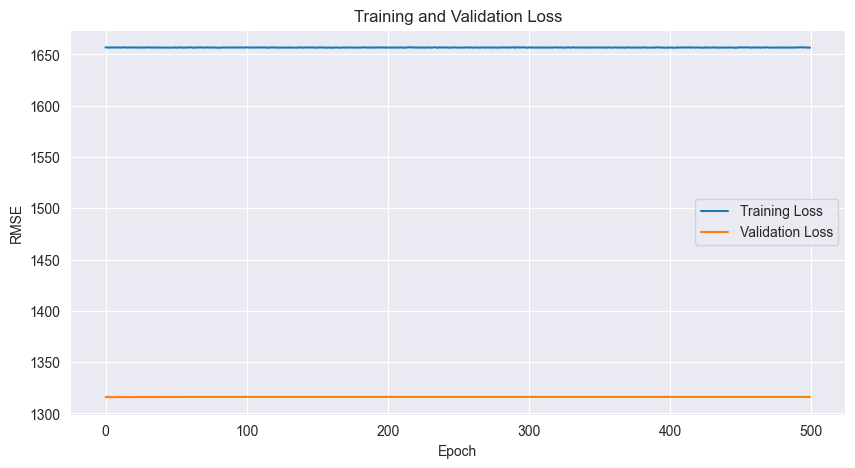

Final validation RMSE: 1315.7220
  Fold 3/5
Input size: 437



  2%|▏         | 8/500 [00:00<00:06, 78.86it/s]

Epoch 0: Train RMSE: 1551.9877, Val RMSE: 2262.1128
Epoch 10: Train RMSE: 1551.9049, Val RMSE: 2261.9119



  7%|▋         | 35/500 [00:00<00:05, 82.67it/s]

Epoch 20: Train RMSE: 1551.9248, Val RMSE: 2261.8994
Epoch 30: Train RMSE: 1551.9797, Val RMSE: 2261.7700



 11%|█         | 53/500 [00:00<00:05, 74.77it/s]

Epoch 40: Train RMSE: 1551.8088, Val RMSE: 2261.6838
Epoch 50: Train RMSE: 1551.8903, Val RMSE: 2261.6355



 14%|█▍        | 69/500 [00:00<00:06, 68.32it/s]

Epoch 60: Train RMSE: 1551.9346, Val RMSE: 2261.6140
Epoch 70: Train RMSE: 1551.8821, Val RMSE: 2261.6021



 18%|█▊        | 90/500 [00:01<00:06, 64.25it/s]

Epoch 80: Train RMSE: 1551.9557, Val RMSE: 2261.5955
Epoch 90: Train RMSE: 1551.7094, Val RMSE: 2261.5923



 22%|██▏       | 112/500 [00:01<00:05, 68.11it/s]

Epoch 100: Train RMSE: 1551.7738, Val RMSE: 2261.5903
Epoch 110: Train RMSE: 1551.8793, Val RMSE: 2261.5894



 28%|██▊       | 139/500 [00:01<00:04, 82.12it/s]

Epoch 120: Train RMSE: 1552.0153, Val RMSE: 2261.5886
Epoch 130: Train RMSE: 1552.1052, Val RMSE: 2261.5884



 31%|███▏      | 157/500 [00:02<00:04, 83.32it/s]

Epoch 140: Train RMSE: 1551.8035, Val RMSE: 2261.5884
Epoch 150: Train RMSE: 1551.8325, Val RMSE: 2261.5881



 35%|███▌      | 175/500 [00:02<00:03, 84.79it/s]

Epoch 160: Train RMSE: 1551.9128, Val RMSE: 2261.5881
Epoch 170: Train RMSE: 1551.9080, Val RMSE: 2261.5881



 39%|███▉      | 194/500 [00:02<00:03, 85.20it/s]

Epoch 180: Train RMSE: 1551.9166, Val RMSE: 2261.5881
Epoch 190: Train RMSE: 1551.8268, Val RMSE: 2261.5881



 42%|████▏     | 212/500 [00:02<00:03, 84.43it/s]

Epoch 200: Train RMSE: 1551.8875, Val RMSE: 2261.5881
Epoch 210: Train RMSE: 1551.7681, Val RMSE: 2261.5881



 46%|████▌     | 230/500 [00:02<00:03, 83.62it/s]

Epoch 220: Train RMSE: 1551.8328, Val RMSE: 2261.5881
Epoch 230: Train RMSE: 1551.7152, Val RMSE: 2261.5881



 52%|█████▏    | 258/500 [00:03<00:02, 86.11it/s]

Epoch 240: Train RMSE: 1551.9006, Val RMSE: 2261.5881
Epoch 250: Train RMSE: 1551.8879, Val RMSE: 2261.5881



 55%|█████▌    | 276/500 [00:03<00:02, 86.72it/s]

Epoch 260: Train RMSE: 1551.7389, Val RMSE: 2261.5881
Epoch 270: Train RMSE: 1551.8531, Val RMSE: 2261.5881



 59%|█████▉    | 294/500 [00:03<00:02, 86.46it/s]

Epoch 280: Train RMSE: 1551.9192, Val RMSE: 2261.5881
Epoch 290: Train RMSE: 1551.8746, Val RMSE: 2261.5881



 63%|██████▎   | 313/500 [00:03<00:02, 88.36it/s]

Epoch 300: Train RMSE: 1551.8539, Val RMSE: 2261.5881
Epoch 310: Train RMSE: 1551.9438, Val RMSE: 2261.5881



 66%|██████▋   | 332/500 [00:04<00:01, 88.62it/s]

Epoch 320: Train RMSE: 1551.8323, Val RMSE: 2261.5881
Epoch 330: Train RMSE: 1551.8845, Val RMSE: 2261.5881



 70%|███████   | 350/500 [00:04<00:01, 88.69it/s]

Epoch 340: Train RMSE: 1551.9275, Val RMSE: 2261.5881
Epoch 350: Train RMSE: 1551.9395, Val RMSE: 2261.5881



 74%|███████▍  | 370/500 [00:04<00:01, 69.53it/s]

Epoch 360: Train RMSE: 1551.6619, Val RMSE: 2261.5881
Epoch 370: Train RMSE: 1551.8054, Val RMSE: 2261.5881



 79%|███████▉  | 397/500 [00:04<00:01, 79.23it/s]

Epoch 380: Train RMSE: 1551.8651, Val RMSE: 2261.5881
Epoch 390: Train RMSE: 1551.8334, Val RMSE: 2261.5881



 83%|████████▎ | 415/500 [00:05<00:01, 81.65it/s]

Epoch 400: Train RMSE: 1551.9672, Val RMSE: 2261.5881
Epoch 410: Train RMSE: 1551.9342, Val RMSE: 2261.5881



 87%|████████▋ | 434/500 [00:05<00:00, 85.36it/s]

Epoch 420: Train RMSE: 1551.9727, Val RMSE: 2261.5881
Epoch 430: Train RMSE: 1551.9259, Val RMSE: 2261.5881



 90%|█████████ | 452/500 [00:05<00:00, 86.08it/s]

Epoch 440: Train RMSE: 1551.8959, Val RMSE: 2261.5881
Epoch 450: Train RMSE: 1551.9016, Val RMSE: 2261.5881



 94%|█████████▍| 470/500 [00:05<00:00, 84.79it/s]

Epoch 460: Train RMSE: 1551.7748, Val RMSE: 2261.5881
Epoch 470: Train RMSE: 1551.8590, Val RMSE: 2261.5881



 98%|█████████▊| 489/500 [00:06<00:00, 86.23it/s]

Epoch 480: Train RMSE: 1551.8319, Val RMSE: 2261.5881
Epoch 490: Train RMSE: 1551.9557, Val RMSE: 2261.5881



100%|██████████| 500/500 [00:06<00:00, 81.20it/s]


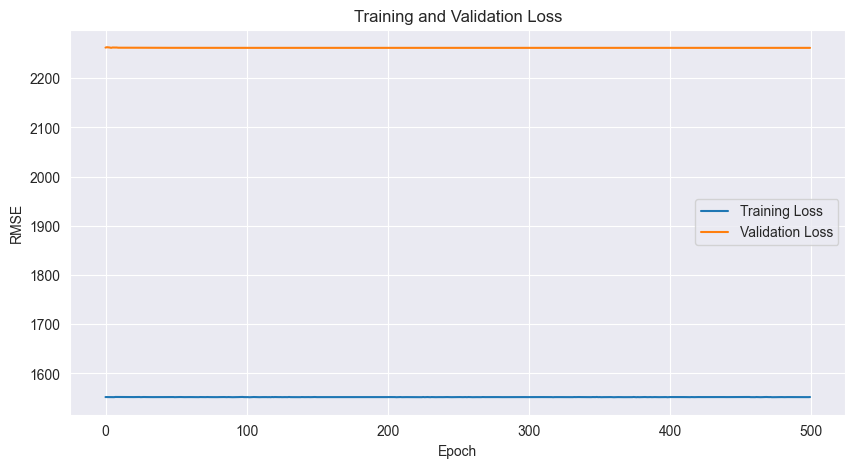

Final validation RMSE: 2261.5881
  Fold 4/5
Input size: 437



  1%|          | 6/500 [00:00<00:09, 52.18it/s]

Epoch 0: Train RMSE: 1755.9861, Val RMSE: 2261.7920
Epoch 10: Train RMSE: 1755.8059, Val RMSE: 2261.8396



  6%|▌         | 29/500 [00:00<00:06, 70.51it/s]

Epoch 20: Train RMSE: 1755.5787, Val RMSE: 2261.8953
Epoch 30: Train RMSE: 1755.3745, Val RMSE: 2261.9302



 11%|█         | 55/500 [00:00<00:05, 76.89it/s]

Epoch 40: Train RMSE: 1755.3792, Val RMSE: 2261.9583
Epoch 50: Train RMSE: 1755.4250, Val RMSE: 2261.9729



 14%|█▍        | 71/500 [00:00<00:05, 75.84it/s]

Epoch 60: Train RMSE: 1755.2039, Val RMSE: 2261.9819
Epoch 70: Train RMSE: 1755.3573, Val RMSE: 2261.9875



 19%|█▉        | 97/500 [00:01<00:05, 78.94it/s]

Epoch 80: Train RMSE: 1755.2667, Val RMSE: 2261.9919
Epoch 90: Train RMSE: 1755.4349, Val RMSE: 2261.9944



 23%|██▎       | 114/500 [00:01<00:04, 79.32it/s]

Epoch 100: Train RMSE: 1755.1074, Val RMSE: 2261.9956
Epoch 110: Train RMSE: 1755.1581, Val RMSE: 2261.9966



 26%|██▌       | 130/500 [00:01<00:04, 78.98it/s]

Epoch 120: Train RMSE: 1755.1605, Val RMSE: 2261.9968
Epoch 130: Train RMSE: 1755.1608, Val RMSE: 2261.9971



 30%|██▉       | 149/500 [00:01<00:04, 79.32it/s]

Epoch 140: Train RMSE: 1754.9960, Val RMSE: 2261.9973
Epoch 150: Train RMSE: 1755.2469, Val RMSE: 2261.9976



 35%|███▌      | 176/500 [00:02<00:04, 79.41it/s]

Epoch 160: Train RMSE: 1755.1095, Val RMSE: 2261.9973
Epoch 170: Train RMSE: 1754.9258, Val RMSE: 2261.9976



 38%|███▊      | 192/500 [00:02<00:03, 78.02it/s]

Epoch 180: Train RMSE: 1755.1736, Val RMSE: 2261.9976
Epoch 190: Train RMSE: 1754.9004, Val RMSE: 2261.9976



 42%|████▏     | 208/500 [00:02<00:03, 77.07it/s]


Epoch 200: Train RMSE: 1755.2720, Val RMSE: 2261.9976
Epoch 210: Train RMSE: 1755.1709, Val RMSE: 2261.9976


 47%|████▋     | 233/500 [00:03<00:03, 76.52it/s]

Epoch 220: Train RMSE: 1755.2592, Val RMSE: 2261.9976
Epoch 230: Train RMSE: 1755.0988, Val RMSE: 2261.9976



 50%|████▉     | 249/500 [00:03<00:03, 75.24it/s]

Epoch 240: Train RMSE: 1755.2675, Val RMSE: 2261.9976
Epoch 250: Train RMSE: 1755.0156, Val RMSE: 2261.9976



 55%|█████▍    | 274/500 [00:03<00:03, 74.90it/s]

Epoch 260: Train RMSE: 1755.1274, Val RMSE: 2261.9976
Epoch 270: Train RMSE: 1755.0966, Val RMSE: 2261.9976



 58%|█████▊    | 290/500 [00:03<00:03, 57.78it/s]

Epoch 280: Train RMSE: 1755.4613, Val RMSE: 2261.9976
Epoch 290: Train RMSE: 1755.4854, Val RMSE: 2261.9976



 63%|██████▎   | 315/500 [00:04<00:02, 70.36it/s]

Epoch 300: Train RMSE: 1754.9456, Val RMSE: 2261.9976
Epoch 310: Train RMSE: 1755.1553, Val RMSE: 2261.9976



 66%|██████▌   | 331/500 [00:04<00:02, 71.46it/s]

Epoch 320: Train RMSE: 1755.0349, Val RMSE: 2261.9976
Epoch 330: Train RMSE: 1755.1603, Val RMSE: 2261.9976



 71%|███████   | 355/500 [00:04<00:02, 71.31it/s]

Epoch 340: Train RMSE: 1755.2124, Val RMSE: 2261.9976
Epoch 350: Train RMSE: 1755.1405, Val RMSE: 2261.9976



 74%|███████▍  | 371/500 [00:05<00:01, 71.18it/s]

Epoch 360: Train RMSE: 1755.1428, Val RMSE: 2261.9976
Epoch 370: Train RMSE: 1755.3810, Val RMSE: 2261.9976



 79%|███████▉  | 395/500 [00:05<00:01, 72.62it/s]

Epoch 380: Train RMSE: 1755.3353, Val RMSE: 2261.9976
Epoch 390: Train RMSE: 1754.9197, Val RMSE: 2261.9976



 82%|████████▏ | 411/500 [00:05<00:01, 70.87it/s]

Epoch 400: Train RMSE: 1755.1517, Val RMSE: 2261.9976
Epoch 410: Train RMSE: 1755.2870, Val RMSE: 2261.9976



 87%|████████▋ | 436/500 [00:05<00:00, 76.31it/s]

Epoch 420: Train RMSE: 1755.0863, Val RMSE: 2261.9976
Epoch 430: Train RMSE: 1755.3177, Val RMSE: 2261.9976



 90%|█████████ | 452/500 [00:06<00:00, 73.20it/s]

Epoch 440: Train RMSE: 1755.1331, Val RMSE: 2261.9976
Epoch 450: Train RMSE: 1755.2649, Val RMSE: 2261.9976



 94%|█████████▎| 468/500 [00:06<00:00, 73.19it/s]

Epoch 460: Train RMSE: 1755.1863, Val RMSE: 2261.9976
Epoch 470: Train RMSE: 1755.2013, Val RMSE: 2261.9976



 99%|█████████▊| 493/500 [00:06<00:00, 71.00it/s]

Epoch 480: Train RMSE: 1755.1050, Val RMSE: 2261.9976
Epoch 490: Train RMSE: 1755.2141, Val RMSE: 2261.9976


100%|██████████| 500/500 [00:06<00:00, 73.18it/s]


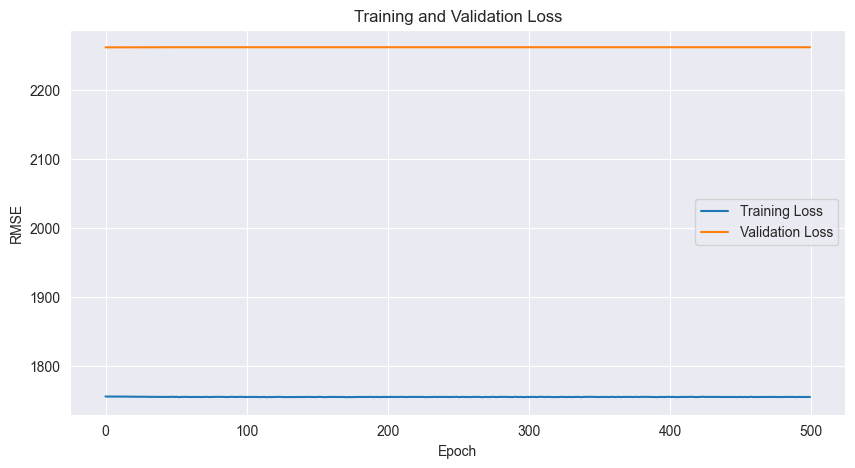

Final validation RMSE: 2261.7512
  Fold 5/5
Input size: 437



  1%|          | 4/500 [00:00<00:13, 37.06it/s]

Epoch 0: Train RMSE: 1867.7441, Val RMSE: 2493.2539



  4%|▍         | 22/500 [00:00<00:09, 52.00it/s]

Epoch 10: Train RMSE: 1867.4912, Val RMSE: 2493.4255
Epoch 20: Train RMSE: 1867.5580, Val RMSE: 2493.6631



  8%|▊         | 41/500 [00:00<00:08, 56.99it/s]

Epoch 30: Train RMSE: 1867.5789, Val RMSE: 2493.6208
Epoch 40: Train RMSE: 1867.6233, Val RMSE: 2493.6570



 12%|█▏        | 59/500 [00:01<00:08, 53.87it/s]

Epoch 50: Train RMSE: 1867.4352, Val RMSE: 2493.6890
Epoch 60: Train RMSE: 1867.6603, Val RMSE: 2493.7319



 16%|█▌        | 78/500 [00:01<00:07, 58.19it/s]

Epoch 70: Train RMSE: 1867.4407, Val RMSE: 2493.6750



 18%|█▊        | 90/500 [00:01<00:08, 48.10it/s]

Epoch 80: Train RMSE: 1867.2985, Val RMSE: 2493.7261
Epoch 90: Train RMSE: 1867.2957, Val RMSE: 2493.7405



 22%|██▏       | 108/500 [00:02<00:07, 50.51it/s]

Epoch 100: Train RMSE: 1866.9358, Val RMSE: 2493.7444



 24%|██▍       | 120/500 [00:02<00:07, 50.97it/s]

Epoch 110: Train RMSE: 1867.2434, Val RMSE: 2493.7456
Epoch 120: Train RMSE: 1867.3328, Val RMSE: 2493.7461



 28%|██▊       | 138/500 [00:02<00:06, 52.31it/s]

Epoch 130: Train RMSE: 1867.3326, Val RMSE: 2493.7461
Epoch 140: Train RMSE: 1867.0128, Val RMSE: 2493.7463



 32%|███▏      | 158/500 [00:02<00:05, 58.29it/s]

Epoch 150: Train RMSE: 1867.3507, Val RMSE: 2493.7463
Epoch 160: Train RMSE: 1867.3368, Val RMSE: 2493.7461



 36%|███▌      | 178/500 [00:03<00:05, 55.12it/s]

Epoch 170: Train RMSE: 1867.3203, Val RMSE: 2493.7466



 38%|███▊      | 190/500 [00:03<00:06, 51.37it/s]

Epoch 180: Train RMSE: 1867.4282, Val RMSE: 2493.7463
Epoch 190: Train RMSE: 1867.4551, Val RMSE: 2493.7463



 42%|████▏     | 208/500 [00:03<00:05, 52.04it/s]

Epoch 200: Train RMSE: 1867.3682, Val RMSE: 2493.7463
Epoch 210: Train RMSE: 1867.1542, Val RMSE: 2493.7463



 45%|████▌     | 226/500 [00:04<00:05, 52.96it/s]

Epoch 220: Train RMSE: 1867.4935, Val RMSE: 2493.7463
Epoch 230: Train RMSE: 1867.5675, Val RMSE: 2493.7463



 50%|█████     | 251/500 [00:04<00:04, 56.69it/s]

Epoch 240: Train RMSE: 1867.0990, Val RMSE: 2493.7463
Epoch 250: Train RMSE: 1867.3704, Val RMSE: 2493.7463



 54%|█████▍    | 269/500 [00:05<00:04, 55.87it/s]

Epoch 260: Train RMSE: 1867.5026, Val RMSE: 2493.7463
Epoch 270: Train RMSE: 1867.3837, Val RMSE: 2493.7463



 57%|█████▋    | 287/500 [00:05<00:04, 44.95it/s]

Epoch 280: Train RMSE: 1867.5161, Val RMSE: 2493.7463



 59%|█████▉    | 297/500 [00:05<00:04, 46.95it/s]

Epoch 290: Train RMSE: 1867.3593, Val RMSE: 2493.7463
Epoch 300: Train RMSE: 1867.0383, Val RMSE: 2493.7463



 64%|██████▍   | 321/500 [00:06<00:03, 52.27it/s]

Epoch 310: Train RMSE: 1867.4829, Val RMSE: 2493.7463
Epoch 320: Train RMSE: 1867.1138, Val RMSE: 2493.7463



 68%|██████▊   | 339/500 [00:06<00:03, 50.49it/s]

Epoch 330: Train RMSE: 1867.5060, Val RMSE: 2493.7463



 70%|███████   | 351/500 [00:06<00:02, 50.65it/s]

Epoch 340: Train RMSE: 1867.2263, Val RMSE: 2493.7463
Epoch 350: Train RMSE: 1867.2308, Val RMSE: 2493.7463



 74%|███████▍  | 369/500 [00:07<00:02, 51.64it/s]

Epoch 360: Train RMSE: 1867.3499, Val RMSE: 2493.7463
Epoch 370: Train RMSE: 1867.0428, Val RMSE: 2493.7463



 77%|███████▋  | 387/500 [00:07<00:02, 53.36it/s]

Epoch 380: Train RMSE: 1867.3395, Val RMSE: 2493.7463
Epoch 390: Train RMSE: 1867.1771, Val RMSE: 2493.7463



 82%|████████▏ | 411/500 [00:07<00:01, 54.42it/s]

Epoch 400: Train RMSE: 1867.8123, Val RMSE: 2493.7463
Epoch 410: Train RMSE: 1867.2369, Val RMSE: 2493.7463



 86%|████████▌ | 429/500 [00:08<00:01, 53.95it/s]

Epoch 420: Train RMSE: 1867.3475, Val RMSE: 2493.7463
Epoch 430: Train RMSE: 1867.2938, Val RMSE: 2493.7463



 89%|████████▉ | 447/500 [00:08<00:01, 52.31it/s]

Epoch 440: Train RMSE: 1867.4697, Val RMSE: 2493.7463
Epoch 450: Train RMSE: 1867.3577, Val RMSE: 2493.7463



 94%|█████████▍| 471/500 [00:08<00:00, 52.94it/s]

Epoch 460: Train RMSE: 1867.3314, Val RMSE: 2493.7463
Epoch 470: Train RMSE: 1867.2897, Val RMSE: 2493.7463



 98%|█████████▊| 490/500 [00:09<00:00, 58.35it/s]

Epoch 480: Train RMSE: 1867.1338, Val RMSE: 2493.7463
Epoch 490: Train RMSE: 1867.0680, Val RMSE: 2493.7463



100%|██████████| 500/500 [00:09<00:00, 52.03it/s]


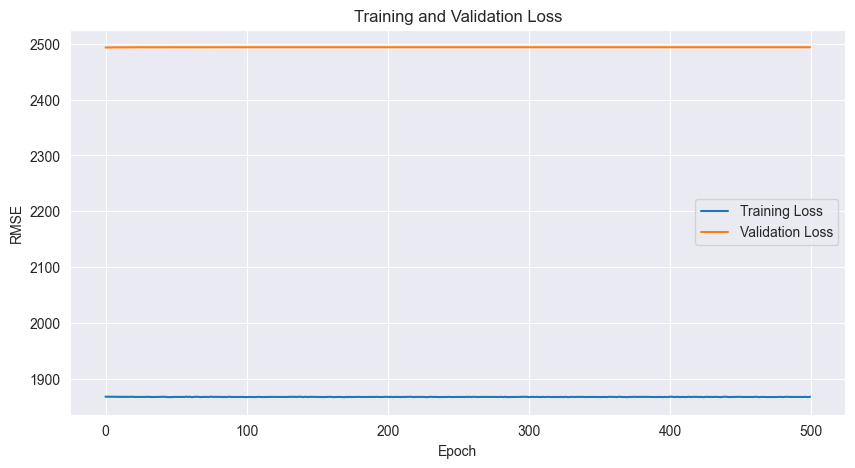

Final validation RMSE: 2493.1687
  Avg RMSE: 2032.2456 ± 417.7168

Best parameters: hidden_size=32, num_layers=10, learning_rate=0.01
Best average RMSE: 2031.7761

Top 5 models:


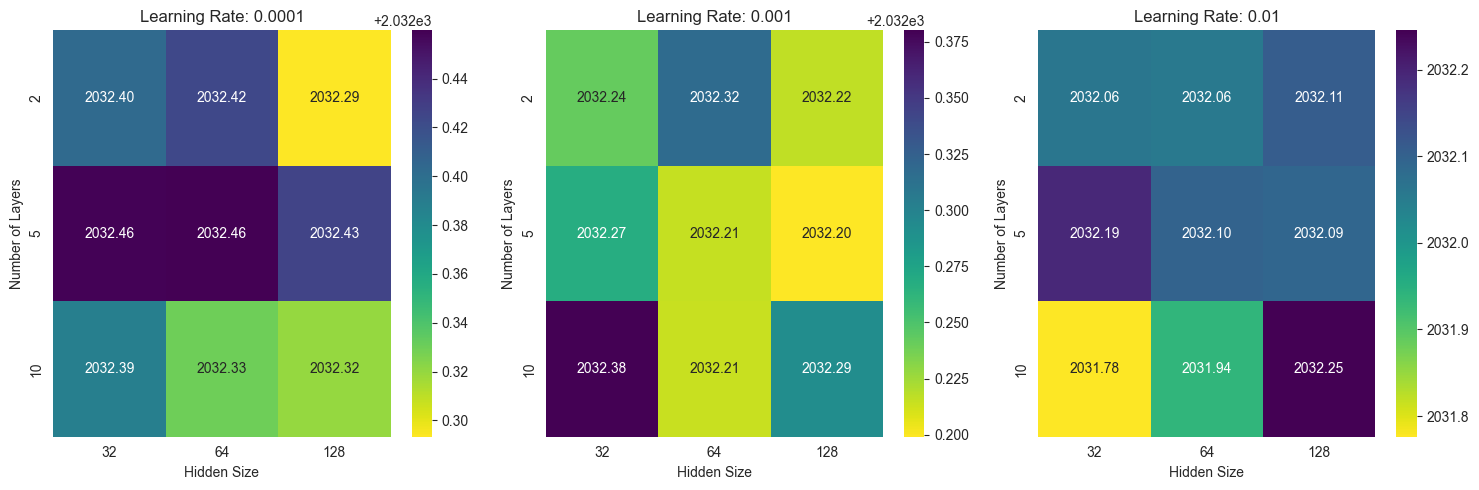

In [160]:
# Define hyperparameter search space (smaller for demonstration)
hidden_sizes = [32, 64, 128]
layers_options = [2, 5, 10]
learning_rates = [1e-4, 1e-3, 1e-2]

# Run hyperparameter tuning
best_params, results_df = tune_hyperparameters(
    X_trains, y_trains, X_tests, y_tests,
    hidden_sizes=hidden_sizes,
    layers_options=layers_options,
    learning_rates=learning_rates,
    epochs=500,  # Reduced for faster tuning
    verbose=True
)

# Display top 5 models
print("\nTop 5 models:")
results_df[['hidden_size', 'num_layers', 'learning_rate', 'avg_rmse', 'std_rmse']].head(5)

# Visualize results with a heatmap
plt.figure(figsize=(15, 5))

# Create pivot tables for each learning rate
for i, lr in enumerate(learning_rates):
    plt.subplot(1, len(learning_rates), i+1)
    
    # Filter for current learning rate and pivot
    df_lr = results_df[results_df['learning_rate'] == lr]
    pivot = df_lr.pivot_table(
        index='num_layers', 
        columns='hidden_size', 
        values='avg_rmse'
    )
    
    # Plot heatmap
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='viridis_r')
    plt.title(f'Learning Rate: {lr}')
    plt.ylabel('Number of Layers')
    plt.xlabel('Hidden Size')

plt.tight_layout()
plt.show()